In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import json

import os
import math
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm


from sklearn.neighbors import KernelDensity 
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate


import xgboost
from xgboost import XGBRegressor, XGBClassifier

from tqdm import tqdm

import sys

thismodule = sys.modules[__name__]

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import seaborn as sns

def create_cyan_to_black_cmap(color1, color2, cmap_name = 'cyan_to_black'):
    colors = [color1, color2]
    return LinearSegmentedColormap.from_list(cmap_name, colors)

# Create the colormap
NP_cmap = create_cyan_to_black_cmap('black', mcolors.to_rgb('darkcyan'), cmap_name = 'NP_cmap')
SM_cmap = create_cyan_to_black_cmap(mcolors.to_rgb('coral'), 'black', cmap_name = 'SM_cmap')

In [3]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import XG, KDE_fitter, max_num_bins
from AUX_MLL_BL import Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve

In [4]:
import matplotlib as mpl
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 

In [5]:
BPs2plot = [2,5,8,11,14]
cmap = cm.get_cmap('Blues', 18)
#cmap = ['coral']
wjets_color = 'coral'
wgamma_color = 'red'
ttgamma_color = 'purple'

# custom functions

In [6]:
def MLL_aprox_discovery_ox(pred_XG_SM, pred_XG_NP, B_expected, S_expected):
   
    pspb_B_data = np.median([im / (1 - im) for im in pred_XG_SM])
    pspb_S_data = np.median([im / (1 - im) for im in pred_XG_NP])
   
    f0 = -2 * S_expected
    fB = 2 * B_expected * np.log( 1 + (pspb_B_data * S_expected / B_expected) )
    fS = 2 * S_expected * np.log( 1 + (pspb_S_data * S_expected / B_expected) )
   
    return (f0 + fB + fS)**0.5



def MLL_aprox_discovery_KDE(pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, S_expected):
   
    pspb_B_data = np.median(pS_B_data/pB_B_data)
    pspb_S_data = np.median(pS_S_data/pB_S_data)
   
    f0 = -2 * S_expected
    fB = 2 * B_expected * np.log( 1 + (pspb_B_data * S_expected / B_expected) )
    fS = 2 * S_expected * np.log( 1 + (pspb_S_data * S_expected / B_expected) )
   
    return (f0 + fB + fS)**0.5


# Reading the data

## SM

In [7]:
ttgamma_cross = 0.13 * 1000 #[fb]
ttgamma_NLO   = 1.46 # k-factor [14 TeV]

wgamma_cross = 0.944 * 1000 #[fb]
wgamma_NLO   = 2.37 # k-factor [14 TeV]

wjets_cross = 168.12 * 1000 #[fb]
wjets_NLO   = 1.27 # k-factor [14 TeV]

ttjets_cross = 29.0495 * 1000 # [fb]
ttjets_NLO   = 1.47

zjets_cross = 65.85 * 1000 # [fb] solo rama leptonica
zjets_NLO   = 1.35

wz_cross = 0.90 * 1000 # [fb]
wz_NLO   = 1.62

zz_cross = 0.2616 * 1000
zz_NLO   = 1.29

ww_cross = 0.409 * 1000
ww_NLO   = 1.40

tj_cross = 1.598 * 1000
tj_NLO   = 1.03

tb_cross = 2.882 * 1000
tb_NLO   = 1.34

tw_cross = 1.441 * 1000
tw_NLO   = 1.

In [8]:
wgamma_fidcross  = 584.6234
wjets_fidcross   = 600.5788
ttgamma_fidcross = 24.98413

ttjets_fidcross  = 180.510721
zjets_fidcross   = 33.609922
wz_fidcross      = 6.740334
zz_fidcross      = 0.843997
ww_fidcross      = 15.8203
tj_fidcross      = 7.9070
tb_fidcross      = 11.52578
tw_fidcross      = 12.72042

bkg = ['wgamma', 'wjets', 'ttgamma',
       'zjets',
       'ttjets',
       'tj', 'tb', 'tw',
       'ww', 'zz', 'wz'
      ]

B_fidcross_tot = 0
for i, ibkg in enumerate(bkg):
    B_fidcross_tot = B_fidcross_tot + globals()[ibkg + '_fidcross']
B_fidcross_tot

1479.8648040000003

In [9]:
wgamma_aceptancia_init  = wgamma_fidcross / (wgamma_cross * wgamma_NLO)
wjets_aceptancia_init   = wjets_fidcross / (wjets_cross * wjets_NLO)
ttgamma_aceptancia_init = ttgamma_fidcross / (ttgamma_cross * ttgamma_NLO)
ttjets_aceptancia_init  = ttjets_fidcross / (ttjets_cross * ttjets_NLO)
zjets_aceptancia_init   = zjets_fidcross / (zjets_cross * zjets_NLO)
wz_aceptancia_init      = wz_fidcross / (wz_cross * wz_NLO)
zz_aceptancia_init      = zz_fidcross / (zz_cross * zz_NLO)
ww_aceptancia_init      = ww_fidcross / (ww_cross * ww_NLO)
tj_aceptancia_init      = tj_fidcross / (tj_cross * tj_NLO)
tb_aceptancia_init      = tb_fidcross / (tb_cross * tb_NLO)
tw_aceptancia_init      = tw_fidcross / (tw_cross * tw_NLO)

In [10]:
wgamma_expected  = 58462.34
wjets_expected   = 60057.88
ttgamma_expected = 2498.413

ttjets_expected  = 18051.0721
zjets_expected   = 3360.9922
wz_expected      = 674.0334
zz_expected      = 84.3997
ww_expected      = 1582.03
tj_expected      = 790.70
tb_expected      = 1152.578
tw_expected      = 1272.042

B_expected = 0
for i, ibkg in enumerate(bkg):
    B_expected = B_expected + globals()[ibkg + '_expected']
B_expected

147986.4804

In [11]:
sample = 200_000 # Number of signal and background events to train and validate

wgamma_sample  = int(round(sample * wgamma_fidcross / B_fidcross_tot))
wjets_sample   = int(round(sample * wjets_fidcross / B_fidcross_tot))
ttgamma_sample = int(round(sample * ttgamma_fidcross / B_fidcross_tot))
ttjets_sample = int(round(sample * ttjets_fidcross / B_fidcross_tot))
zjets_sample = int(round(sample * zjets_fidcross / B_fidcross_tot))
wz_sample = int(round(sample * wz_fidcross / B_fidcross_tot))
zz_sample = int(round(sample * zz_fidcross / B_fidcross_tot))
ww_sample = int(round(sample * ww_fidcross / B_fidcross_tot))
tj_sample = int(round(sample * tj_fidcross / B_fidcross_tot))
tb_sample = int(round(sample * tb_fidcross / B_fidcross_tot))
tw_sample = int(round(sample * tw_fidcross / B_fidcross_tot))

print(wgamma_sample)
print(wjets_sample)
print(ttgamma_sample)
print(ttjets_sample)
print(zjets_sample)
print(wz_sample)
print(zz_sample)
print(ww_sample)
print(tj_sample)
print(tb_sample)
print(tw_sample)

79010
81167
3377
24396
4542
911
114
2138
1069
1558
1719


In [12]:
datFolderwgamma  = '../data/Wgamma/'
datFolderwjets   = '../data/Wjets/'
datFolderttgamma = '../data/ttGamma/'
datFolderttjets  = '../data/ttjets/'
datFolderzjets   = '../data/Zlep+j/'
datFolderwz      = '../data/wz/'
datFolderww      = '../data/ww/'
datFolderzz      = '../data/zz/'
datFoldertj      = '../data/singleTop+j/'
datFoldertb      = '../data/singleTop+b/'
datFoldertw      = '../data/singleTop+W/'

for i, ibkg in enumerate(bkg):
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'photon_4.dat', delimiter=' ')
    setattr(thismodule, 'photon_' + ibkg, aux)
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'jet_4.dat', delimiter=' ')
    setattr(thismodule, 'jet_' + ibkg, aux)
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'lepton_4.dat', delimiter=' ')
    setattr(thismodule, 'lepton_' + ibkg, aux)
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'MET_4.dat', delimiter=' ')
    setattr(thismodule, 'MET_' + ibkg, aux)
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'hadinfo_4.dat', delimiter=' ')
    setattr(thismodule, 'hadinfo_' + ibkg, aux)

In [13]:
for i, ibkg in enumerate(bkg):
    if i == 0:
        photon_SM  = globals()['photon_' + ibkg][:globals()[ibkg + '_sample']]
        jet_SM     = globals()['jet_' + ibkg][:globals()[ibkg + '_sample']]
        lepton_SM  = globals()['lepton_' + ibkg][:globals()[ibkg + '_sample']]
        MET_SM     = globals()['MET_' + ibkg][:globals()[ibkg + '_sample']]
        hadinfo_SM = globals()['hadinfo_' + ibkg][:globals()[ibkg + '_sample']]
    else:
        photon_SM  = np.concatenate([photon_SM, globals()['photon_' + ibkg][:globals()[ibkg + '_sample']]])
        jet_SM     = np.concatenate([jet_SM, globals()['jet_' + ibkg][:globals()[ibkg + '_sample']]])
        lepton_SM  = np.concatenate([lepton_SM, globals()['lepton_' + ibkg][:globals()[ibkg + '_sample']]])
        MET_SM     = np.concatenate([MET_SM, globals()['MET_' + ibkg][:globals()[ibkg + '_sample']]])
        hadinfo_SM = np.concatenate([hadinfo_SM, globals()['hadinfo_' + ibkg][:globals()[ibkg + '_sample']]])

In [14]:
bkg_flag = np.zeros(len(photon_SM))

for i, ibkg in enumerate(bkg):
    if i == 0:
        bkg_flag[:globals()[ibkg + '_sample']] = i + 1
        end_ind = globals()[ibkg + '_sample']
    else:
        init_ind = end_ind
        end_ind  = end_ind + globals()[ibkg + '_sample']
        bkg_flag[(init_ind):(end_ind)] = i + 1

In [15]:
wjets_pool  = len(photon_wjets[wjets_sample:])
pool_sample = int(wjets_pool * B_fidcross_tot / wjets_fidcross)

wgamma_pool_sample  = int(round(pool_sample * wgamma_fidcross / B_fidcross_tot))
wjets_pool_sample   = int(round(pool_sample * wjets_fidcross / B_fidcross_tot))
ttgamma_pool_sample = int(round(pool_sample * ttgamma_fidcross / B_fidcross_tot))
ttjets_pool_sample  = int(round(pool_sample * ttjets_fidcross / B_fidcross_tot))
zjets_pool_sample   = int(round(pool_sample * zjets_fidcross / B_fidcross_tot))
wz_pool_sample      = int(round(pool_sample * wz_fidcross / B_fidcross_tot))
zz_pool_sample      = int(round(pool_sample * zz_fidcross / B_fidcross_tot))
ww_pool_sample      = int(round(pool_sample * ww_fidcross / B_fidcross_tot))
tj_pool_sample      = int(round(pool_sample * tj_fidcross / B_fidcross_tot))
tb_pool_sample      = int(round(pool_sample * tb_fidcross / B_fidcross_tot))
tw_pool_sample      = int(round(pool_sample * tw_fidcross / B_fidcross_tot))

print(wgamma_pool_sample)
print(wjets_pool_sample)
print(ttgamma_pool_sample)
print(ttjets_pool_sample)
print(zjets_pool_sample)
print(wz_pool_sample)
print(zz_pool_sample)
print(ww_pool_sample)
print(tj_pool_sample)
print(tb_pool_sample)
print(tw_sample)

173444
178178
7412
53553
9971
2000
250
4694
2346
3419
1719


In [16]:
for i, ibkg in enumerate(bkg):
    if i == 0:
        photon_SM_pool  = globals()['photon_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
        jet_SM_pool     = globals()['jet_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
        lepton_SM_pool  = globals()['lepton_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
        MET_SM_pool     = globals()['MET_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
        hadinfo_SM_pool = globals()['hadinfo_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
    else:
        photon_SM_pool  = np.concatenate([photon_SM_pool, globals()['photon_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])
        jet_SM_pool     = np.concatenate([jet_SM_pool, globals()['jet_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])
        lepton_SM_pool  = np.concatenate([lepton_SM_pool, globals()['lepton_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])
        MET_SM_pool     = np.concatenate([MET_SM_pool, globals()['MET_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])
        hadinfo_SM_pool = np.concatenate([hadinfo_SM_pool, globals()['hadinfo_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])

In [17]:
bkg_flag_pool = np.zeros(len(photon_SM_pool))

for i, ibkg in enumerate(bkg):
    if i == 0:
        bkg_flag_pool[:globals()[ibkg + '_pool_sample']] = i + 1
        end_ind = globals()[ibkg + '_pool_sample']
    else:
        init_ind = end_ind
        end_ind  = end_ind + globals()[ibkg + '_pool_sample']
        bkg_flag_pool[(init_ind):(end_ind)] = i + 1

In [18]:
print(photon_wjets.shape)
print(photon_ttgamma.shape)
print(photon_wgamma.shape)
print(photon_ttjets.shape)
print(photon_zjets.shape)
print(photon_wz.shape)
print(photon_zz.shape)
print(photon_ww.shape)
print(photon_tj.shape)
print(photon_tb.shape)
print(photon_tw.shape)

(259345, 4)
(2710879, 4)
(3579946, 4)
(92997, 4)
(15123, 4)
(9246, 4)
(2501, 4)
(27629, 4)
(4804, 4)
(5969, 4)
(17655, 4)


### Other variables

In [19]:
# other variables

ST_SM = photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

MET_sig_SM = np.divide( MET_SM[:,0],np.sqrt(hadinfo_SM[:,0]) )

m_eff_SM = MET_SM[:,0] + photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

phi_MET_photon_SM = np.absolute( MET_SM[:,2] - photon_SM[:,2] )
phi_MET_jet_SM    = np.absolute( MET_SM[:,2] - jet_SM[:,2] )
phi_MET_lepton_SM = np.absolute( MET_SM[:,2] - lepton_SM[:,2] )

mT_photon_SM = np.sqrt( (2*photon_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_photon_SM)) )
mT_jet_SM    = np.sqrt( (2*jet_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_jet_SM)) )
mT_lepton_SM = np.sqrt( (2*lepton_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_lepton_SM)) )

phi_photon_jet_SM    = np.absolute( photon_SM[:,2] - jet_SM[:,2] )
phi_photon_lepton_SM = np.absolute( photon_SM[:,2] - lepton_SM[:,2] )
phi_lepton_jet_SM    = np.absolute( lepton_SM[:,2] - jet_SM[:,2] )

phi_photon_jet_SM[phi_photon_jet_SM>np.pi]       = (2.* np.pi) - phi_photon_jet_SM[phi_photon_jet_SM>np.pi]
phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi] = (2.* np.pi) - phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi]
phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]

deltaR_photon_jet_SM    = np.sqrt( (photon_SM[:,1]-jet_SM[:,1])**2 + (phi_photon_jet_SM)**2 )
deltaR_photon_lepton_SM = np.sqrt( (photon_SM[:,1]-lepton_SM[:,1])**2 + (phi_photon_lepton_SM)**2 )
deltaR_lepton_jet_SM    = np.sqrt( (lepton_SM[:,1]-jet_SM[:,1])**2 + (phi_lepton_jet_SM)**2 )

In [20]:
# other variables, individual channels pool sample:

ST_SM_pool = photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

MET_sig_SM_pool = np.divide( MET_SM_pool[:,0],np.sqrt(hadinfo_SM_pool[:,0]) )

m_eff_SM_pool = MET_SM_pool[:,0] + photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

phi_MET_photon_SM_pool = np.absolute( MET_SM_pool[:,2] - photon_SM_pool[:,2] )
phi_MET_jet_SM_pool    = np.absolute( MET_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_MET_lepton_SM_pool = np.absolute( MET_SM_pool[:,2] - lepton_SM_pool[:,2] )

mT_photon_SM_pool = np.sqrt( (2*photon_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_photon_SM_pool)) )
mT_jet_SM_pool    = np.sqrt( (2*jet_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_jet_SM_pool)) )
mT_lepton_SM_pool = np.sqrt( (2*lepton_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_lepton_SM_pool)) )

phi_photon_jet_SM_pool    = np.absolute( photon_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_photon_lepton_SM_pool = np.absolute( photon_SM_pool[:,2] - lepton_SM_pool[:,2] )
phi_lepton_jet_SM_pool    = np.absolute( lepton_SM_pool[:,2] - jet_SM_pool[:,2] )

phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]
phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi] = (2.* np.pi) - phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi]
phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]

deltaR_photon_jet_SM_pool    = np.sqrt( (photon_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_photon_jet_SM_pool)**2 )
deltaR_photon_lepton_SM_pool = np.sqrt( (photon_SM_pool[:,1]-lepton_SM_pool[:,1])**2 + (phi_photon_lepton_SM_pool)**2 )
deltaR_lepton_jet_SM_pool    = np.sqrt( (lepton_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_lepton_jet_SM_pool)**2 )

## NP

In [21]:
######
# NP #
######

datFolderNP = '../data/Signal/'

photon_NP  = []
jet_NP     = []
lepton_NP  = []
MET_NP     = []
hadinfo_NP = []
name       = []
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    name.append('BP' + str(i))
    photon_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_photon_5.dat', delimiter=' ') )
    jet_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_jet_5.dat', delimiter=' ') )
    lepton_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_lepton_5.dat', delimiter=' ') )
    MET_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_MET_5.dat', delimiter=' ') )
    hadinfo_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_hadinfo_5.dat', delimiter=' ') )

In [22]:
print('SM', lepton_SM.shape)
for i in range(len(jet_NP)):
    print(name[i], lepton_NP[i].shape)

SM (200001, 5)
BP1 (524041, 5)
BP2 (492157, 5)
BP3 (414951, 5)
BP4 (603424, 5)
BP5 (533112, 5)
BP6 (406048, 5)
BP7 (631234, 5)
BP8 (560590, 5)
BP9 (451741, 5)
BP10 (652300, 5)
BP11 (583750, 5)
BP12 (488317, 5)
BP13 (670737, 5)
BP14 (602479, 5)
BP15 (516051, 5)


In [23]:
cross_section_bps    = np.asarray([190, 189, 189, 92, 92, 92, 49, 48, 48, 27, 27, 27, 16, 16, 16])
branching_ratios_bps = np.asarray([0.14, 0.37, 0.73, 0.15, 0.36, 0.67, 0.16, 0.36, 0.62, 0.17, 0.35, 0.58, 0.16, 0.32, 0.52])

signal_cross        = cross_section_bps * branching_ratios_bps *  0.2134 # fb
signal_init_sim_eve = np.asarray([1836673, 2e6, 2400081, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6])
#signal_cut_ev       = np.asarray([238160,246196,242249,301575,266047,203155,315960,280065,225958,326687,292051,244271,334782,301215,258277]) #OLD
signal_cut_ev       = np.asarray([524041, 492157, 414951, 603424, 533112, 406048, 631234, 560590, 451741, 652300, 583750, 488317, 670737, 602479, 516051])
signal_NLO          = 1.25

cross       = signal_cross * signal_NLO
aceptancia  = signal_cut_ev / (1. * signal_init_sim_eve)
luminosidad = 100

signal_fidcross = cross * aceptancia
S_expected = cross * aceptancia * luminosidad

print('fiducial cross section: ', signal_fidcross)
print('Events expected: ', S_expected)

fiducial cross section:  [2.02450796 4.59030589 6.36297195 1.11064713 2.35495829 3.33821603
 0.66005614 1.29200298 1.79306845 0.39933235 0.73575485 1.01992452
 0.22901644 0.41142086 0.57265147]
Events expected:  [202.4507965  459.03058905 636.29719543 111.06471288 235.49582866
 333.82160293  66.00561444 129.20029848 179.30684468  39.93323524
  73.57548516 101.99245228  22.90164413  41.14208595  57.26514737]


In [24]:
# other variables NEW PHYSICS
ST_NP      = []
MET_sig_NP = []
m_eff_NP   = []

phi_MET_photon_NP = []
phi_MET_jet_NP    = []
phi_MET_lepton_NP = []

mT_photon_NP = []
mT_jet_NP    = []
mT_lepton_NP = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

deltaR_photon_jet_NP    = []
deltaR_photon_lepton_NP = []
deltaR_lepton_jet_NP    = []

for i in range(len(photon_NP)):
    ST_NP.append( photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    MET_sig_NP.append( np.divide( MET_NP[i][:,0],np.sqrt(hadinfo_NP[i][:,0]) ) )

    m_eff_NP.append( MET_NP[i][:,0] + photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    phi_MET_photon_NP.append( np.absolute( MET_NP[i][:,2] - photon_NP[i][:,2] ) )
    phi_MET_jet_NP.append( np.absolute( MET_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_MET_lepton_NP.append( np.absolute( MET_NP[i][:,2] - lepton_NP[i][:,2] ) )

    mT_photon_NP.append( np.sqrt( (2*photon_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_photon_NP[i])) ) )
    mT_jet_NP.append( np.sqrt( (2*jet_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_jet_NP[i])) ) )
    mT_lepton_NP.append( np.sqrt( (2*lepton_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_lepton_NP[i])) ) )

    phi_photon_jet_NP.append( np.absolute( photon_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_photon_lepton_NP.append( np.absolute( photon_NP[i][:,2] - lepton_NP[i][:,2] ) )
    phi_lepton_jet_NP.append( np.absolute( lepton_NP[i][:,2] - jet_NP[i][:,2] ) )

    phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]
    phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi] = (2.* np.pi) - phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi]
    phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]

    deltaR_photon_jet_NP.append( np.sqrt( (photon_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_photon_jet_NP[i])**2 ) )
    deltaR_photon_lepton_NP.append( np.sqrt( (photon_NP[i][:,1]-lepton_NP[i][:,1])**2 + (phi_photon_lepton_NP[i])**2 ) )
    deltaR_lepton_jet_NP.append( np.sqrt( (lepton_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_lepton_jet_NP[i])**2 ) )

In [25]:
print(photon_SM.shape)
print(photon_NP[0].shape)

(200001, 4)
(524041, 4)


# Analysis

## training

In [26]:
# LOW LEVEL VARIABLES ----------------------

print(photon_SM.shape)
print(jet_SM.shape)
print(lepton_SM.shape)
print(MET_SM.shape)
#-------------------------------------------

# HIGH LEVEL VARIABLES ----------------------
print(hadinfo_SM.shape)
print(ST_SM.shape)
print(MET_sig_SM.shape)
print(m_eff_SM.shape)
print(mT_photon_SM.shape)
print(mT_jet_SM.shape)
print(mT_lepton_SM.shape)
#-------------------------------------------

(200001, 4)
(200001, 3)
(200001, 5)
(200001, 3)
(200001, 3)
(200001,)
(200001,)
(200001,)
(200001,)
(200001,)
(200001,)


In [138]:
# bp correspond to benchmark points (bp + 1) !!!!
bp = 12

# LOW LEVEL VARIABLES ----------------------


print(photon_NP[bp].shape)
print(jet_NP[bp].shape)
print(lepton_NP[bp].shape)
print(MET_NP[bp].shape)
#-------------------------------------------

# HIGH LEVEL VARIABLES ----------------------

print(hadinfo_NP[bp].shape)
print(ST_NP[bp].shape)
print(MET_sig_NP[bp].shape)
print(m_eff_NP[bp].shape)
print(mT_photon_NP[bp].shape)
print(mT_jet_NP[bp].shape)
print(mT_lepton_NP[bp].shape)
#-------------------------------------------

(670737, 4)
(670737, 3)
(670737, 5)
(670737, 3)
(670737, 3)
(670737,)
(670737,)
(670737,)
(670737,)
(670737,)
(670737,)


In [139]:
nobs = np.min( (len(photon_SM), len(photon_NP[bp])) )
nobs

200001

In [140]:
df = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']
#np.random.seed(28890)

SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

df[lst[0]]= np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][:nobs,0]])
df[lst[1]]= np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][:nobs,1]])
df[lst[2]]= np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][:nobs,2]])
df[lst[3]]= np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][:nobs,3]])

df[lst[4]]= np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][:nobs,0]])
df[lst[5]]= np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][:nobs,1]])
df[lst[6]]= np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][:nobs,2]])

df[lst[7]]= np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][:nobs,0]])
df[lst[8]]= np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][:nobs,1]])
df[lst[9]]= np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][:nobs,2]])
df[lst[10]]= np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][:nobs,3]])
df[lst[11]]= np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][:nobs,4]])

df[lst[12]]= np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][:nobs,0]])
df[lst[13]]= np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][:nobs,2]])

df[lst[14]]= np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][:nobs,0]])
df[lst[15]]= np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][:nobs,1]])
df[lst[16]]= np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][:nobs,2]])

df[lst[17]]= np.concatenate([ST_SM[SM_indices], ST_NP[bp][:nobs]])
df[lst[18]]= np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][:nobs]])
#df[lst[19]]= np.concatenate([m_eff_SM[SM_indices], m_eff_NP[bp][:nobs]])

df[lst[19]]= np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][:nobs]])
df[lst[20]]= np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][:nobs]])
df[lst[21]]= np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][:nobs]])

#%df[lst[22]]= np.concatenate([phi_MET_photon_SM[SM_indices], phi_MET_photon_NP[bp][:nobs]])
#%df[lst[23]]= np.concatenate([phi_MET_jet_SM[SM_indices], phi_MET_jet_NP[bp][:nobs]])
#%df[lst[24]]= np.concatenate([phi_MET_lepton_SM[SM_indices], phi_MET_lepton_NP[bp][:nobs]])

#%df[lst[25]]= np.concatenate([deltaR_photon_jet_SM[SM_indices], deltaR_photon_jet_NP[bp][:nobs]])
#%df[lst[26]]= np.concatenate([deltaR_photon_lepton_SM[SM_indices], deltaR_photon_lepton_NP[bp][:nobs]])
#%df[lst[27]]= np.concatenate([deltaR_lepton_jet_SM[SM_indices], deltaR_lepton_jet_NP[bp][:nobs]])


df['bkg_flag']= np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][:nobs]))) )

df[lst[22]]= np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][:nobs]))])

df_array = np.asarray(df)
df

photon $p_T$ [GeV]  photon $\eta$  photon $\phi$  num photon  \
0                   264.48          1.724          0.310         1.0   
1                    75.20          1.406         -0.723         1.0   
2                    48.00          1.737         -0.309         1.0   
3                    18.08         -1.942         -0.778         1.0   
4                    25.33         -2.325          0.173         1.0   
...                    ...            ...            ...         ...   
399997               60.00         -1.344          2.279         1.0   
399998               39.94          0.875          0.413         1.0   
399999               57.76         -1.387          1.882         1.0   
400000              131.35         -0.984          1.122         1.0   
400001               63.83         -0.097          2.690         1.0   

        jet $p_T$ [GeV]  jet $\eta$  jet $\phi$  lepton $p_T$ [GeV]  \
0                120.28       0.843      -1.715               84.11   
1                187.90      -1.936      -0.266              101.72   
2                365.61       1.736       2.898              214.03   
3                248.47      -0.306       2.498              163.89   
4                393.61       0.458       0.351              151.09   
...                 ...         ...         ...                 ...   
399997           112.12      -2.846       2.453               29.83   
399998           258.55      -0.749      -1.187               61.76   
399999           328.73      -1.186      -0.731               34.10   
400000           324.86      -1.669      -2.812               73.67   
400001           151.20      -0.841      -0.140               42.33   

        lepton $\eta$  lepton $\phi$  ...  $H_T$ [GeV]  $H_T$ (jets) [GeV]  \
0               0.914         -2.950  ...       468.87              120.28   
1              -0.292          2.746  ...       435.82              258.90   
2               1.744         -0.319  ...       676.08              414.05   
3              -1.954         -0.766  ...       592.28              410.31   
4              -1.756          2.656  ...      1254.37             1077.95   
...               ...            ...  ...          ...                 ...   
399997         -0.887         -0.416  ...       201.95              112.12   
399998          1.854          2.266  ...       393.55              291.85   
399999         -1.537          3.031  ...       547.02              455.16   
400000          0.896         -1.305  ...       701.97              496.95   
400001          0.309          0.099  ...       401.00              294.84   

        num_jets  $S_T$ [GeV]  MET sig [GeV]  $m_T$ photon [GeV]  \
0            1.0       468.87       8.283223          404.317772   
1            2.0       364.82       8.919204          219.133407   
2            3.0       627.64       5.135081           29.845397   
3            4.0       430.44       4.535518           36.798449   
4            4.0       570.03       2.933330           85.063362   
...          ...          ...            ...                 ...   
399997       1.0       201.95      11.148476          194.091989   
399998       2.0       360.25      10.821604          127.316245   
399999       4.0       420.59      12.721232           66.769196   
400000       3.0       529.88      13.615922          246.540709   
400001       2.0       257.36       9.754814            6.698755   

        $m_T$ jet [GeV]  $m_T$ lepton [GeV]  bkg_flag  SM=0 - NP=1  
0            237.155949           77.761042       1.0          0.0  
1            369.389385           61.031751       1.0          0.0  
2            436.604307           64.682333       2.0          0.0  
3            291.977349          112.260265       2.0          0.0  
4            313.893690           65.385601       2.0          0.0  
...                 ...                 ...       ...          ...  
399997       266.545580           17.414498       0.0

In [141]:
df_test = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

df_test[lst[0]]= np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][nobs:,0]])
df_test[lst[1]]= np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][nobs:,1]])
df_test[lst[2]]= np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][nobs:,2]])
df_test[lst[3]]= np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][nobs:,3]])

df_test[lst[4]]= np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][nobs:,0]])
df_test[lst[5]]= np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][nobs:,1]])
df_test[lst[6]]= np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][nobs:,2]])

df_test[lst[7]]= np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][nobs:,0]])
df_test[lst[8]]= np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][nobs:,1]])
df_test[lst[9]]= np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][nobs:,2]])
df_test[lst[10]]= np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][nobs:,3]])
df_test[lst[11]]= np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][nobs:,4]])

df_test[lst[12]]= np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][nobs:,0]])
df_test[lst[13]]= np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][nobs:,2]])

df_test[lst[14]]= np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][nobs:,0]])
df_test[lst[15]]= np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][nobs:,1]])
df_test[lst[16]]= np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][nobs:,2]])

df_test[lst[17]]= np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][nobs:]])
df_test[lst[18]]= np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][nobs:]])
#df_test[lst[19]]= np.concatenate([m_eff_SM_pool[SM_indices], m_eff_NP[bp][nobs:]])

df_test[lst[19]]= np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][nobs:]])
df_test[lst[20]]= np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][nobs:]])
df_test[lst[21]]= np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][nobs:]])

#%df_test[lst[22]]= np.concatenate([phi_MET_photon_SM_pool[SM_indices], phi_MET_photon_NP[bp][nobs:]])
#%df_test[lst[23]]= np.concatenate([phi_MET_jet_SM_pool[SM_indices], phi_MET_jet_NP[bp][nobs:]])
#%df_test[lst[24]]= np.concatenate([phi_MET_lepton_SM_pool[SM_indices], phi_MET_lepton_NP[bp][nobs:]])

#%df_test[lst[25]]= np.concatenate([deltaR_photon_jet_SM_pool[SM_indices], deltaR_photon_jet_NP[bp][nobs:]])
#%df_test[lst[26]]= np.concatenate([deltaR_photon_lepton_SM_pool[SM_indices], deltaR_photon_lepton_NP[bp][nobs:]])
#%df_test[lst[27]]= np.concatenate([deltaR_lepton_jet_SM_pool[SM_indices], deltaR_lepton_jet_NP[bp][nobs:]])


df_test['bkg_flag_pool']= np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][nobs:]))) )

df_test[lst[22]]= np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][nobs:]))])

df_test_array = np.asarray(df_test)
df_test

photon $p_T$ [GeV]  photon $\eta$  photon $\phi$  num photon  \
0                    18.46         -1.434          1.509         1.0   
1                    18.11          0.612         -0.872         1.0   
2                   166.81         -1.008          1.534         1.0   
3                    52.25         -1.759         -1.089         1.0   
4                    13.86         -1.911          2.937         1.0   
...                    ...            ...            ...         ...   
909772               36.81          0.144         -2.984         1.0   
909773               14.99          1.898          1.620         1.0   
909774               40.28         -1.014          0.543         1.0   
909775               60.81          0.827          1.098         1.0   
909776               22.51         -0.251         -2.035         1.0   

        jet $p_T$ [GeV]  jet $\eta$  jet $\phi$  lepton $p_T$ [GeV]  \
0                134.45       0.219      -1.776               55.04   
1                250.15       0.211       0.211               25.36   
2                185.64      -1.568      -1.534               13.22   
3                140.44       0.181      -0.168               18.51   
4                114.56      -0.846       2.148               44.68   
...                 ...         ...         ...                 ...   
909772           380.41       1.366      -0.867               21.77   
909773           174.46      -1.581       2.382               10.16   
909774           106.82      -2.215      -0.195               14.04   
909775           365.75       2.539       2.879               24.05   
909776           149.82      -0.390       2.009               20.82   

        lepton $\eta$  lepton $\phi$  ...  $H_T$ [GeV]  $H_T$ (jets) [GeV]  \
0              -1.087          2.544  ...       268.64              195.14   
1              -1.523          2.427  ...       293.62              250.15   
2              -0.176         -3.074  ...       501.34              321.31   
3               1.338         -2.297  ...       310.97              240.21   
4              -2.022          0.177  ...       205.31              146.77   
...               ...            ...  ...          ...                 ...   
909772          0.656         -2.279  ...       762.45              703.87   
909773         -0.719         -1.537  ...       301.47              276.32   
909774          0.079         -2.421  ...       161.14              106.82   
909775          2.177         -0.610  ...       808.43              723.57   
909776         -0.864         -1.898  ...       193.15              149.82   

        num_jets  $S_T$ [GeV]  MET sig [GeV]  $m_T$ photon [GeV]  \
0            2.0       207.95       7.048707           10.919297   
1            1.0       293.62      15.155809          115.043576   
2            3.0       365.67       5.525527           62.420610   
3            2.0       211.20      11.018274          170.004031   
4            2.0       173.10       7.069058           56.819230   
...          ...          ...            ...                 ...   
909772       2.0       438.99       6.337710            3.771897   
909773       4.0       199.61      13.112447           97.066091   
909774       1.0       161.14       9.825042          135.222609   
909775       4.0       450.61       3.769225          133.863505   
909776       1.0       193.15       9.143866           49.158520   

        $m_T$ jet [GeV]  $m_T$ lepton [GeV]  bkg_flag_pool  SM=0 - NP=1  
0            248.990101           94.730557            2.0          0.0  
1            509.460781           77.400273            1.0          0.0  
2            293.237630           70.424954            2.0          0.0  
3            328.513821           46.707434            2.0          0.0  
4            204.794177          105.476860            2.0          0.0  
...                 ...                 ...            ...          ...  
909772       455.6

In [142]:
nobs = len(df_array)

train_size = int(0.80 * nobs)
#%test_size  = int(0.15 * nobs)
val_size   = nobs - train_size #%- test_size 

random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

train_indices = random_indices[:train_size]
#%test_indices  = random_indices[train_size:(train_size + test_size)]
#%val_indices   = random_indices[(train_size + test_size):]
val_indices   = random_indices[train_size:]

In [143]:
print('Variables to analyze:', df.columns[:22])

Variables to analyze: Index(['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$', 'lepton $p_T$ [GeV]',
       'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$', '$H_T$ [GeV]', '$H_T$ (jets) [GeV]',
       'num_jets', '$S_T$ [GeV]', 'MET sig [GeV]', '$m_T$ photon [GeV]',
       '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]'],
      dtype='object')


In [144]:
print('Bkg flag:', df.columns[22]) # Just to check

Bkg flag: bkg_flag


In [145]:
X_train        = df_array[train_indices, :22]
bkg_flag_train = df_array[train_indices, 22]
y_mon_train    = df_array[train_indices, -1]

X_test        = df_test_array[:, :22]
bkg_flag_test = df_test_array[:, 22]
y_mon_test    = df_test_array[:, -1]

X_val        = df_array[val_indices, :22]
bkg_flag_val = df_array[val_indices, 22]
y_mon_val    = df_array[val_indices, -1]

In [146]:
for i, ibkg in enumerate(bkg):
    ind_train = np.where(bkg_flag_train == (i + 1))[0]
    if(len(ind_train) < globals()[ibkg + '_expected']): 
        print('In training there are less ' + ibkg + ' events {} than expected {}'.format(len(ind_train), globals()[ibkg + '_expected']))
        
    ind_test = np.where(bkg_flag_test == (i + 1))[0]
    if(len(ind_test) < globals()[ibkg + '_expected']): 
        print('In testing there are less ' + ibkg + ' events {} than expected {}'.format(len(ind_test), globals()[ibkg + '_expected']))
        
    ind_val = np.where(bkg_flag_val == (i + 1))[0]
    if(len(ind_val) < globals()[ibkg + '_expected']): 
        print('In val there are less ' + ibkg + ' events {} than expected {}'.format(len(ind_val), globals()[ibkg + '_expected']))

In [147]:
# to normalize
x_scaler = preprocessing.MinMaxScaler()
x_scaler = x_scaler.fit(X_train)

X_mon_train = x_scaler.transform(X_train)
X_mon_test  = x_scaler.transform(X_test)
X_mon_val   = x_scaler.transform(X_val)

In [148]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators  = 500,
    learning_rate = 0.1,
    reg_lambda    = 0.0, reg_alpha = 0.0,
    early_stopping_rounds = 50,#early stopping
    eval_metric = 'logloss',
    gamma = 0.0, objective = 'binary:logistic',
    max_depth = 5)

# FIT
classifier.fit(X_mon_train, y_mon_train, 
               eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
               verbose  =True)

[0]	validation_0-logloss:0.64989	validation_1-logloss:0.64996
[1]	validation_0-logloss:0.61413	validation_1-logloss:0.61410
[2]	validation_0-logloss:0.58376	validation_1-logloss:0.58369
[3]	validation_0-logloss:0.55848	validation_1-logloss:0.55827
[4]	validation_0-logloss:0.53632	validation_1-logloss:0.53615
[5]	validation_0-logloss:0.51762	validation_1-logloss:0.51736
[6]	validation_0-logloss:0.50093	validation_1-logloss:0.50047
[7]	validation_0-logloss:0.48608	validation_1-logloss:0.48564
[8]	validation_0-logloss:0.47334	validation_1-logloss:0.47281
[9]	validation_0-logloss:0.46169	validation_1-logloss:0.46121
[10]	validation_0-logloss:0.45154	validation_1-logloss:0.45103
[11]	validation_0-logloss:0.44208	validation_1-logloss:0.44157
[12]	validation_0-logloss:0.43350	validation_1-logloss:0.43294
[13]	validation_0-logloss:0.42612	validation_1-logloss:0.42560
[14]	validation_0-logloss:0.41987	validation_1-logloss:0.41933
[15]	validation_0-logloss:0.41381	validation_1-logloss:0.41327
[1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=0.0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [149]:
# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]

In [150]:
print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (320001, 22)
y_mon_train :  (320001,)
X_mon_val :  (80001, 22)
y_mon_val :  (80001,)
X_mon_test :  (909777, 22)
y_mon_test :  (909777,)



In [151]:
# Let's estimate the ROC Curve
nvals = 50
tpr_total = np.zeros(nvals) 
fpr_total = np.zeros(nvals) 
tpr_bkg   = np.zeros((len(bkg), nvals))
fpr_bkg   = np.zeros((len(bkg), nvals))

for ith, th in tqdm(enumerate(np.linspace(0,1, nvals))):
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_total[ith] = len(tp) / (len(tp) + len(fn))
    fpr_total[ith] = len(fp) / (len(fp) + len(tn))

    for i, ibkg in enumerate(bkg):
        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == (i + 1)) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == (i + 1)) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]
    
        tpr_bkg[i, ith] = len(tp) / (len(tp) + len(fn))
        fpr_bkg[i, ith] = len(fp) / (len(fp) + len(tn))

50it [00:03, 13.00it/s]


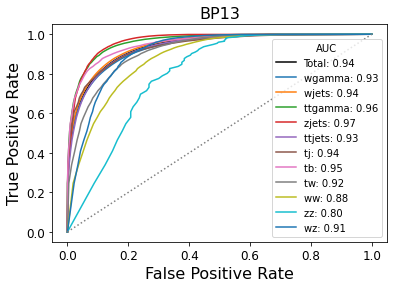

In [152]:
plt.plot(fpr_total, tpr_total, c = 'black', label = 'Total: {:.2f}'.format(auc(fpr_total, tpr_total)))

for i, ibkg in enumerate(bkg):
    plt.plot(fpr_bkg[i,:], tpr_bkg[i,:], label = ibkg + ': {:.2f}'.format(auc(fpr_bkg[i,:], tpr_bkg[i,:])))
plt.legend(title = 'AUC')

plt.ylabel("True Positive Rate",fontsize=16)
plt.xlabel("False Positive Rate",fontsize=16)
plt.plot([0,1],[0,1],ls=":",color="grey")
plt.title(r"BP" + str(bp + 1),fontsize=16)
plt.savefig('../graph/ROC_BP' + str(bp + 1) + '.png', bbox_inches='tight')

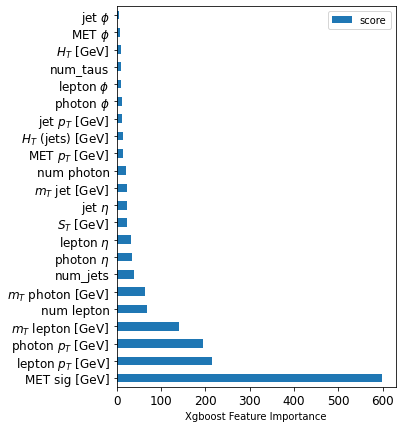

In [153]:
fig, ax = plt.subplots(figsize = (5,7))

feature_important = classifier.get_booster().get_score(importance_type='gain')
values = list(feature_important.values())

data = pd.DataFrame(data=values, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(len(lst) - 1, columns="score").plot(kind='barh', ax = ax) ## plot top 20 features

ax.set_xlabel("Xgboost Feature Importance")
ax.set_yticklabels(np.asarray(lst)[np.argsort(values)[::-1]])

plt.savefig('../graph/ImpVars_BP' + str(bp + 1) + '_zjets.png', bbox_inches='tight')

In [154]:
plt.hist(y_pred_xg[np.where(bkg_flag_test == 0)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = 'black', label = 'BP' + str(bp + 1), lw = 2)
plt.hist(y_pred_xg[np.where(bkg_flag_test == 3)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 1)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 2)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
#plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.savefig('../graph/MLOutput_dist_BP' + str(bp + 1) + '_zjets.png', bbox_inches="tight")

In [155]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

In [156]:
len(np.where(bkg_flag_test != 0)[0])

439041

In [157]:
len(np.where(bkg_flag_test == 0)[0])

470736

Text(0.5, 1.0, 'BP13')

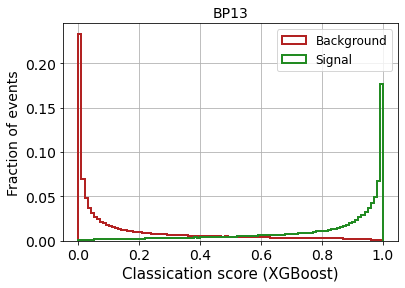

In [158]:
# XGBoost

########################
# CLASSIFICATION SCORE #
########################
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('BP' + str(bp + 1), fontsize=14)

#plt.savefig('../graph/' + '2monian-output.pdf', format="pdf", bbox_inches="tight")

In [159]:
S_expected[bp]

22.901644128

In [160]:
S_expected[bp] / np.sqrt(B_expected)

0.05953270842776485

In [161]:
B_expected

147986.4804

In [122]:
print('MLL aproximated Z:')
print( MLL_aprox_discovery_ox(pred_XG_SM, pred_XG_NP, int(B_expected), int(S_expected[bp]))) 

MLL aproximated Z:
nan


/tmp/ipykernel_134961/1019789035.py:10: RuntimeWarning: invalid value encountered in scalar power
  return (f0 + fB + fS)**0.5


## Sequential selection criteria

In [177]:
nbins = 10
indices_aux = np.arange(len(df_test_array))
        
n_np0      = len(np.where(df_test_array[:, 22] == 0)[0])

n_wgamma0  = len(np.where(df_test_array[:, 22] == 1)[0])
n_wjets0   = len(np.where(df_test_array[:, 22] == 2)[0])
n_ttgamma0 = len(np.where(df_test_array[:, 22] == 3)[0])
n_ttjets0  = len(np.where(df_test_array[:, 22] == 4)[0])
n_zjets0   = len(np.where(df_test_array[:, 22] == 5)[0])
n_wz0      = len(np.where(df_test_array[:, 22] == 6)[0])
n_zz0      = len(np.where(df_test_array[:, 22] == 7)[0])
n_ww0      = len(np.where(df_test_array[:, 22] == 8)[0])
n_tj0      = len(np.where(df_test_array[:, 22] == 9)[0])
n_tb0      = len(np.where(df_test_array[:, 22] == 10)[0])
n_tw0      = len(np.where(df_test_array[:, 22] == 11)[0])

sup_cuts = {}
inf_cuts = {}
random_vars = np.random.choice(range(len(df_test.columns) - 2), size = 100, replace = True)
random_vars = np.concatenate((np.random.choice(range(len(df_test.columns) - 3), size = len(df_test.columns) - 3, replace = False), random_vars))
#random_vars = list(np.argsort(values)[::-1])*10

for ivar in random_vars:
    #print(indices_aux)
    cuts = np.linspace(np.min(df_test_array[indices_aux,ivar]), np.max(df_test_array[indices_aux,ivar]), nbins)
    Z_sup = np.zeros(nbins)
    Z_inf = np.zeros(nbins)

    indices = []
    Z = []
    for icut, cut in enumerate(cuts): 
        
        # Superior ------------------------------------------------------------------------------------
        indices_sup = indices_aux[np.where( (df_test_array[indices_aux,ivar] >= cut) )[0]]
        indices.append(indices_sup)
        n_np      = len(np.where(df_test_array[indices_sup, 22] == 0)[0])
        
        n_wgamma  = len(np.where(df_test_array[indices_sup, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_sup, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_sup, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_sup, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_sup, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_sup, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_sup, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_sup, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_sup, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_sup, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_sup, 22] == 11)[0])

        wgamma_expected  = wgamma_cross * wgamma_NLO * luminosidad * (n_wgamma * wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = wjets_cross * wjets_NLO * luminosidad * (n_wjets * wjets_aceptancia_init / n_wjets0)
        ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
        zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
        wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
        zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
        ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
        tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
        tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
        tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)

        S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                             zjets_expected + wz_expected + zz_expected + ww_expected + \
                             tj_expected + tb_expected + tw_expected)
        #if B_expected > 5: Z_sup[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and (S_expected_aux > 5): 
            Z_sup[icut] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
            Z.append( np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)) )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------

        # Inferior ------------------------------------------------------------------------------------
        indices_inf = indices_aux[np.where( (df_test_array[indices_aux,ivar] <= cut) )[0]]
        indices.append(indices_inf)
        
        n_np      = len(np.where(df_test_array[indices_inf, 22] == 0)[0])
        
        n_wgamma  = len(np.where(df_test_array[indices_inf, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_inf, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_inf, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_inf, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_inf, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_inf, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_inf, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_inf, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_inf, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_inf, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_inf, 22] == 11)[0])

        wgamma_expected  = wgamma_cross * wgamma_NLO * luminosidad * (n_wgamma * wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = wjets_cross * wjets_NLO * luminosidad * (n_wjets * wjets_aceptancia_init / n_wjets0)
        ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
        zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
        wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
        zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
        ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
        tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
        tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
        tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)

        S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                             zjets_expected + wz_expected + zz_expected + ww_expected + \
                             tj_expected + tb_expected + tw_expected)
        
        #if B_expected > 5: Z_inf[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and (S_expected_aux > 5): 
            Z_inf[icut] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
            Z.append( np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)) )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------
    max_cut = np.argmax(np.asarray(Z))
    #print('Z = ' + str(Z[max_cut]))
    indices_aux = indices[max_cut]
    max_cut = np.argmax((Z_inf, Z_sup))
    if max_cut >= len(Z_inf):
        print(df_test.columns[ivar] + ' >= ' + str(cuts[max_cut - len(Z_sup)]) + '; Z = ' + str(Z_sup[max_cut - len(Z_inf)]))
    #%    indices_aux = indices_aux[np.where( (df_test_array[indices_aux,ivar] >= cuts[max_cut - len(Z_sup)]) )[0]]
        if df.columns[ivar] in inf_cuts.keys():
            inf_cuts[df_test.columns[ivar]] = cuts[max_cut - len(Z_sup)]
        inf_cuts.setdefault(df_test.columns[ivar], cuts[max_cut - len(Z_sup)])
        sup_cuts.setdefault(df_test.columns[ivar], 999999)
    else:
        print(df_test.columns[ivar] + ' <= ' + str(cuts[max_cut]) + '; Z = ' + str(Z_inf[max_cut]))
    #%    indices_aux = indices_aux[np.where( (df_array[indices_aux,ivar] <= cuts[max_cut]) )[0]]
        if df.columns[ivar] in sup_cuts.keys():
            sup_cuts[df_test.columns[ivar]] = cuts[max_cut]
        sup_cuts.setdefault(df_test.columns[ivar], cuts[max_cut])
        inf_cuts.setdefault(df_test.columns[ivar], -999999)   
    
    
n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

wgamma_expected  = wgamma_cross * wgamma_NLO * luminosidad * (n_wgamma * wgamma_aceptancia_init / n_wgamma0)
wjets_expected   = wjets_cross * wjets_NLO * luminosidad * (n_wjets * wjets_aceptancia_init / n_wjets0)
ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)

S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

# Formula discovery
B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                     zjets_expected + wz_expected + zz_expected + ww_expected + \
                     tj_expected + tb_expected + tw_expected)
if (B_expected_aux > 5) and (S_expected_aux > 5): 
    print('\n')
    print('Z = ', np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)))
    print('Expected Background = ' + str(B_expected_aux))
    print('Expected Signal = ' + str(S_expected_aux))

num_jets <= 5.333333333333333; Z = 0.05819834297611935
lepton $\eta$ <= 2.5; Z = 0.05819834297611935
photon $p_T$ [GeV] <= 216.17888888888888; Z = 0.05895849525465873
$H_T$ [GeV] <= 1541.4066666666665; Z = 0.05913950009519109
photon $\phi$ <= 3.142; Z = 0.05913950009519109
num photon <= 1.0; Z = 0.059447012730142766
num_taus <= 1.1111111111111112; Z = 0.059451570549235375
MET sig [GeV] >= 8.523177641175952; Z = 0.0749133750529197
photon $\eta$ <= 2.369; Z = 0.0749133750529197
lepton $p_T$ [GeV] <= 106.75222222222222; Z = 0.07838791647273119
$S_T$ [GeV] <= 910.2266666666666; Z = 0.0784538329988565
num lepton <= 1.3333333333333333; Z = 0.07863407161818331
MET $p_T$ [GeV] <= 837.2433333333333; Z = 0.07863743660322457
$H_T$ (jets) [GeV] <= 1181.0977777777778; Z = 0.07866016207824393
$m_T$ photon [GeV] >= 76.04317417547233; Z = 0.08563131682897587
lepton $\phi$ <= 3.142; Z = 0.08563131682897587
$m_T$ jet [GeV] >= 188.7172337756313; Z = 0.08631083612282349
jet $p_T$ [GeV] <= 619.29; Z = 0.08

In [178]:
sup_cuts

{'num_jets': 5.0,
 'lepton $\\eta$': 2.5,
 'photon $p_T$ [GeV]': 193.23,
 '$H_T$ [GeV]': 1233.36,
 'photon $\\phi$': 3.142,
 'num photon': 1.0,
 'num_taus': 0.0,
 'MET sig [GeV]': 29.56828150753617,
 'photon $\\eta$': 2.369,
 'lepton $p_T$ [GeV]': 53.0,
 '$S_T$ [GeV]': 779.64,
 'num lepton': 1.0,
 'MET $p_T$ [GeV]': 837.1,
 '$H_T$ (jets) [GeV]': 1060.63,
 '$m_T$ photon [GeV]': 616.794636014305,
 'lepton $\\phi$': 3.142,
 '$m_T$ jet [GeV]': 1423.988118037463,
 'jet $p_T$ [GeV]': 619.28,
 'jet $\\phi$': 3.142,
 'jet $\\eta$': 2.45,
 'MET $\\phi$': 3.142,
 '$m_T$ lepton [GeV]': 274.0906480372929}

In [179]:
inf_cuts

{'num_jets': -999999,
 'lepton $\\eta$': -999999,
 'photon $p_T$ [GeV]': -999999,
 '$H_T$ [GeV]': -999999,
 'photon $\\phi$': -999999,
 'num photon': -999999,
 'num_taus': -999999,
 'MET sig [GeV]': 8.523177641175952,
 'photon $\\eta$': -999999,
 'lepton $p_T$ [GeV]': -999999,
 '$S_T$ [GeV]': -999999,
 'num lepton': 0.1111111111111111,
 'MET $p_T$ [GeV]': -999999,
 '$H_T$ (jets) [GeV]': -999999,
 '$m_T$ photon [GeV]': 76.04317417547233,
 'lepton $\\phi$': -999999,
 '$m_T$ jet [GeV]': 326.05429323018905,
 'jet $p_T$ [GeV]': -999999,
 'jet $\\phi$': -999999,
 'jet $\\eta$': -2.5207777777777776,
 'MET $\\phi$': -999999,
 '$m_T$ lepton [GeV]': -999999}

In [180]:
write = True
if write:
    with open('../data/cuts/BP' + str(bp+1) + '_supCuts_ALL.txt', "w") as fp:
        json.dump(sup_cuts, fp)

    with open('../data/cuts/BP' + str(bp+1) + '_infCuts_ALL.txt', "w") as fp:
        json.dump(inf_cuts, fp)
else:
    with open('../data/cuts/BP' + str(bp+1) + '_supCuts_ALL.txt', "r") as fp:
        # Load the dictionary from the file
        sup_cuts = json.load(fp)
    with open('../data/cuts/BP' + str(bp+1) + '_infCuts_ALL.txt', "r") as fp:
        # Load the dictionary from the file
        inf_cuts = json.load(fp)

In [189]:
SM_test_pool = np.where(df_test_array[:,22] > 0)[0]
NP_test_pool = np.where(df_test_array[:,22] == 0)[0]

SM_indices = np.random.choice(SM_test_pool, size = int(B_expected), replace = False)
NP_indices = np.random.choice(NP_test_pool, size = int(S_expected[bp]), replace = False)
indices_aux = np.concatenate((NP_indices, SM_indices))

n_np0  = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

n_wgamma0  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets0   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma0 = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
n_ttjets0  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
n_zjets0   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
n_wz0      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
n_zz0      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
n_ww0      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
n_tj0      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
n_tb0      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
n_tw0      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

#indices_aux = np.arange(len(df_test_array))

variables = list(sup_cuts.keys())
for i in range(len(variables)):
    ind_var = np.where(df_test.columns == variables[i])[0][0]
    indices_aux = indices_aux[np.where( (df_test_array[indices_aux, ind_var] <= sup_cuts[variables[i]]) & 
                            (df_test_array[indices_aux, ind_var] > inf_cuts[variables[i]])
                           )[0]]


In [190]:
n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

wgamma_expected  = wgamma_cross * wgamma_NLO * luminosidad * (n_wgamma * wgamma_aceptancia_init / n_wgamma0)
wjets_expected   = wjets_cross * wjets_NLO * luminosidad * (n_wjets * wjets_aceptancia_init / n_wjets0)
ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)

S_expected_aux = n_np#int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

# Formula discovery
B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                     zjets_expected + wz_expected + zz_expected + ww_expected + \
                     tj_expected + tb_expected + tw_expected)
if (B_expected_aux >= 5) and (S_expected_aux >= 5): 
    print('\n')
    print('Z = ', np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)))
    print('Expected Background = ' + str(B_expected_aux))
    print('Expected Signal = ' + str(S_expected_aux))



Z =  0.07007127667637769
Expected Background = 7330
Expected Signal = 6


In [191]:
nexperiments = 2000

SM_test_pool = np.where(df_test_array[:,22] > 0)[0]
NP_test_pool = np.where(df_test_array[:,22] == 0)[0]

q0_exp = np.zeros(nexperiments)
B_observed_exp = np.zeros(nexperiments)
S_observed_exp = np.zeros(nexperiments)
for nexp in tqdm(range(nexperiments)):
    # Let's create a pseudo-experiment
    SM_indices = np.random.choice(SM_test_pool, size = np.random.poisson(int(B_expected)), replace = False)
    NP_indices = np.random.choice(NP_test_pool, size = np.random.poisson(int(S_expected[bp])), replace = False)
    indices_aux = np.concatenate((NP_indices, SM_indices))

    # Let's make the cuts

    variables = list(sup_cuts.keys())
    for i in range(len(variables)):
        #print(variables[i] + '<=' + str(sup_cuts[variables[i]]))
        #print(variables[i] + '>=' + str(inf_cuts[variables[i]]))
        ind_var = np.where(df_test.columns == variables[i])[0][0]
        indices_aux = indices_aux[np.where( (df_test_array[indices_aux, ind_var] <= sup_cuts[variables[i]]) & 
                                (df_test_array[indices_aux, ind_var] > inf_cuts[variables[i]])
                               )[0]]

    # Let's calculate everything
    
    n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])
    
    n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
    n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
    n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
    n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
    n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
    n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
    n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
    n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
    n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
    n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
    n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

    #S_expected_aux = n_np
    S_observed_exp[nexp] = n_np

    # Formula discovery
    B_observed_exp[nexp] = n_ttgamma + n_wgamma + n_wjets + \
                           n_ttjets + n_zjets + n_wz + \
                           n_zz + n_ww + n_tj + \
                           n_tb + n_tw
        
    N_observed = n_np + n_ttgamma + n_wgamma + n_wjets+ \
                 n_ttjets + n_zjets + n_wz + \
                 n_zz + n_ww + n_tj + \
                 n_tb + n_tw
    
    if (B_expected_aux >= 5) and (S_expected_aux >= 5): 
        q0_exp[nexp] = -2 * N_observed * np.log(B_expected_aux / N_observed) -2 * (N_observed - B_expected_aux)
        #Z_exp[nexp] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
        #%print('\n')
        #%print('Z = ', Z_exp[nexp])
        #%print('Expected Background = ' + str(B_expected_aux))
        #%print('Expected Signal = ' + str(S_expected_aux))
    else:
        q0_exp[nexp] = -99
        #print('Expected Background = ' + str(B_observed_exp))
        #print('Expected Signal = ' + str(S_observed_exp))
    #%print('------------------------------------------')
        

100%|████████████████████████████████████████████████████████████████| 2000/2000 [00:51<00:00, 38.54it/s]


(array([  6., 107., 360., 535., 504., 317., 130.,  30.,   9.,   2.]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <BarContainer object of 10 artists>)

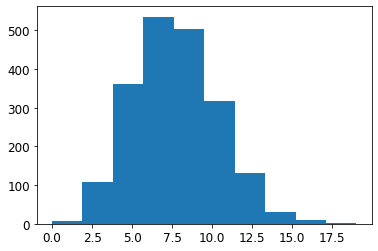

In [192]:
plt.hist(S_observed_exp)

In [193]:
plt.hist(B_observed_exp)

(array([ 15.,  49., 128., 305., 447., 461., 340., 187.,  50.,  18.]),
 array([7032. , 7074.9, 7117.8, 7160.7, 7203.6, 7246.5, 7289.4, 7332.3,
        7375.2, 7418.1, 7461. ]),
 <BarContainer object of 10 artists>)

In [194]:
print('Final results: for BP ' + str(bp+1) + '\n ')
print('Z = ' + str(np.sqrt(np.median(q0_exp))) + '; Z_std = ' + str(np.std(q0_exp) / (2 * np.sqrt(np.median(q0_exp)))))
print('B_exp = ' + str(np.mean(B_observed_exp)) + '; B_exp_std = ' + str(np.std(B_observed_exp)))
print('S_exp = ' + str(np.mean(S_observed_exp)) + '; S_exp_std = ' + str(np.std(S_observed_exp)))

Final results: for BP 13
 
Z = 0.8657907483712852; Z_std = 0.9820851561097457
B_exp = 7251.012; B_exp_std = 70.1959746424252
S_exp = 7.622; S_exp_std = 2.780668265003936


In [67]:
imp_vars = np.array(['MET sig [GeV]', 'lepton $p_T$ [GeV]', '$m_T$ lepton [GeV]',
       '$m_T$ photon [GeV]'])
#imp_vars = np.asarray(lst)[np.argsort(values)[::-1]][:4]


In [68]:
imp_vars

array(['MET sig [GeV]', 'lepton $p_T$ [GeV]', '$m_T$ lepton [GeV]',
       '$m_T$ photon [GeV]'], dtype='<U18')

In [69]:
SM = df_test.loc[df_test['bkg_flag_pool'] > 0]
NP = df_test.loc[df_test['bkg_flag_pool'] == 0]

limites = [[4,41], [0,400], [0,600], [0,700]]
ylimites = [[0,0.18], [0,0.15], [0,0.03], [0,0.02]]

fig,ax = plt.subplots(4,4, figsize = (15,15), gridspec_kw={'hspace':0.1, 'wspace':0.1})

for i in range(4):
    for j in range(4):
        if i != 3: ax[i,j].set_xticklabels([])
        if j != 0: ax[i,j].set_yticklabels([])
        if i >= j:
            if i==j:
                sns.kdeplot(NP[imp_vars[i]], ax = ax[i,j], color = 'darkcyan', lw=2, ls = 'solid')
                sns.kdeplot(SM[imp_vars[i]], ax = ax[i,j], color = 'coral', lw=2, ls = '--')
                ax[i,j].set_ylabel('')
                ax[i,j].set_xlabel('')
                ax[i,j].set_xlim(limites[i])
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = sup_cuts[imp_vars[i]], x2 = 1000, color = 'black', alpha = 0.4)
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = -1, x2 = inf_cuts[imp_vars[i]], color = 'black', alpha = 0.4)
                ax[i,j].set_ylim(ylimites[i])
            else:
                im_SM = ax[i,j].scatter(SM[imp_vars[j]], SM[imp_vars[i]], s = 0.8, marker = '.', 
                                        c = pred_XG_SM, cmap = SM_cmap, vmin = 0, vmax = 1, alpha = (1-pred_XG_SM))
                im_NP = ax[i,j].scatter(NP[imp_vars[j]], NP[imp_vars[i]], s = 0.8, marker = '*', 
                                        c = pred_XG_NP, cmap = NP_cmap, vmin = 0, vmax = 1, alpha = pred_XG_NP)
                ax[i,j].set_xlim(SM[imp_vars[j]].min(), SM[imp_vars[j]].max())
                ax[i,j].set_ylim(SM[imp_vars[i]].min(), SM[imp_vars[i]].max())
                ax[i,j].set_xlim(limites[j])
                ax[i,j].set_ylim(limites[i])
                ax[i,j].fill_betweenx(y = [-1, 10000], x1 = sup_cuts[imp_vars[j]], x2 = 1000, color = 'black', alpha = 0.4)
                ax[i,j].fill_betweenx(y = [-1, 10000], x1 = -1, x2 = inf_cuts[imp_vars[j]], color = 'black', alpha = 0.4)
                ax[i,j].fill_between(x = [inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]], y1 = sup_cuts[imp_vars[i]], y2 = 1000, color = 'black', alpha = 0.4)
                ax[i,j].fill_between(x = [inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]], y1 = -1, y2 = inf_cuts[imp_vars[i]], color = 'black', alpha = 0.4)
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], inf_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[sup_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], inf_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([sup_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                
            ax[i,j].grid(which = 'both')
        else:
            ax[i,j].axis('off')

ax[3,0].set_xlabel(imp_vars[0])
ax[3,1].set_xlabel(imp_vars[1])
ax[3,2].set_xlabel(imp_vars[2])
ax[3,3].set_xlabel(imp_vars[3])

ax[0,0].set_ylabel(imp_vars[0])
ax[1,0].set_ylabel(imp_vars[1])
ax[2,0].set_ylabel(imp_vars[2])
ax[3,0].set_ylabel(imp_vars[3])

ax[0,0].set_xticklabels([])

ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([])

ax[2,2].set_yticklabels([])
ax[2,2].set_xticklabels([])

ax[3,3].set_yticklabels([])
ax[0,0].set_yticklabels([])

cbar_SM = plt.colorbar(im_SM, ax = ax[0,2], orientation = 'horizontal')
cbar_SM.set_label('$P(SM|x)$', labelpad=-50)
cbar_NP = plt.colorbar(im_NP, ax = ax[0,2], orientation = 'horizontal')
cbar_NP.set_label('$P(NP|x)$', labelpad=-50)

plt.savefig('../graph/BP' + str(bp+1) + '/ImpVars_dist_OLD.pdf')

## BinnedLikelihood

In [70]:
print(pred_XG_SM.shape)
print(pred_XG_NP.shape)

(439041,)
(324040,)


In [71]:
B_expected = int(B_expected)

In [155]:
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]] # range of our data (between 0 and 1 if its the ML output)

bins_to_test=range(1,500) # number of bins we are testing to see if condition holds

# FIND THE NUMBER OF BINS:
num_bins = max_num_bins(pred_XG_SM, int(B_expected), range_dat, MIN_EVS, bins_to_test)

print('\n FOR BIN LIKELIHOOD WE ARE SETTING:')
print('min number of Background events allowed per bin: ', MIN_EVS)
print('number of bins we are going to use: ', num_bins)
print('range of our data: ', range_dat)

At least 5 B events per bin, range = [[0, 1]]:
# bins:  224 OK

 FOR BIN LIKELIHOOD WE ARE SETTING:
min number of Background events allowed per bin:  5
number of bins we are going to use:  224
range of our data:  [[0, 1]]


In [156]:
# Z Poisson Bin Likelihood (Asimov data set)
D_or_E = 'discovery'
store_Z_asimov = []

Z_asimov = Z_BL_asimov(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), 25, range_dat, MIN_EVS, linear_bins=True) 
store_Z_asimov.append( Z_asimov )
    
    
print('\n FINAL RESULT for BP' + str(bp+1) + ':\n')
print(store_Z_asimov)


 FINAL RESULT for BP1:

[2.0082248257137674]


In [157]:
# requested number of pseudo experiments
num_pseudo = 2000

# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []

    
print('B_expected: ', B_expected)
print('S_expected: ', S_expected[bp])
print('')

#Z_BL = BL_test_fast(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True, path = '../graph/BP' + str(bp+1) + '/') 
Z_BL = BL_test_fast(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 

store_Z_BL.append( list(Z_BL) )

print('muhat mean: ', Z_BL[2])
print('Z_bins: ', Z_BL[0])
print('std Z_bins: ', Z_BL[1])
print('Z_bins mu=0: ', Z_BL[3])
print('std Z_bins mu=0: ', Z_BL[4])
print('')
print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)

B_expected:  147986
S_expected:  202.45079649725346

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


muhat mean:  1.028125
Z_bins:  2.0175272376703317
std Z_bins:  0.8628754231237187
Z_bins mu=0:  2.0189762198568157
std Z_bins mu=0:  0.831968896206629

--------


 FINAL RESULT:

[[2.0175272376703317, 0.8628754231237187, 1.028125, 2.0189762198568157, 0.831968896206629]]


B_expected:  147986
S_expected:  202.45079649725346

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


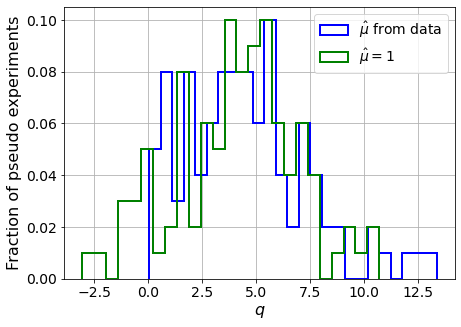

muhat mean:  1.0092043807903361
Z_bins:  2.0811436686027958
std Z_bins:  0.6888901505352494
Z_bins mu=0:  2.0796310719802613
std Z_bins mu=0:  0.6872851003165914

--------


 FINAL RESULT:

[[2.0811436686027958, 0.6888901505352494, 1.0092043807903361, 2.0796310719802613, 0.6872851003165914]]


In [158]:
# requested number of pseudo experiments
num_pseudo = 100

# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []

    
print('B_expected: ', B_expected)
print('S_expected: ', S_expected[bp])
print('')

#Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True, path = '../graph/BP' + str(bp+1) + '/') 
Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 

store_Z_BL.append( list(Z_BL) )

print('muhat mean: ', Z_BL[2])
print('Z_bins: ', Z_BL[0])
print('std Z_bins: ', Z_BL[1])
print('Z_bins mu=0: ', Z_BL[3])
print('std Z_bins mu=0: ', Z_BL[4])
print('')
print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)

## loop pseudo exps. Fix ML and KDE

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf  2151.66378942  2013.53428755  1843.62405184
  1643.69758171  1402.18250311  1107.36022748   744.87670133
   296.77911631  -281.88868635 -1017.15099543 -2092.48214707]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf  1801.25202889


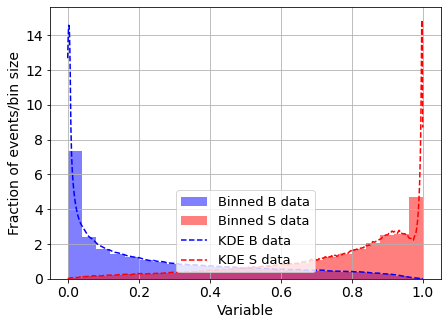

KDE Kernel:  epanechnikov
Background bandwidth:  0.008287452507534925
Signal bandwidth:  0.0031053121543406503


In [53]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs

# outputs:
# 1st -> background PDF
# 2nd -> signal PDF
# 3rd -> (normalization factor of the background PDF)**-1
# 4th -> (normalization factor of the signal PDF)**-1
# 5th -> background bandwidth
# 6th -> signal bandwidth
kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                        20000, # Numero de datos para fitear
                                                                                        np.logspace(-4.0, 0.05, 20), 
                                                                                        set_kernel='epanechnikov')

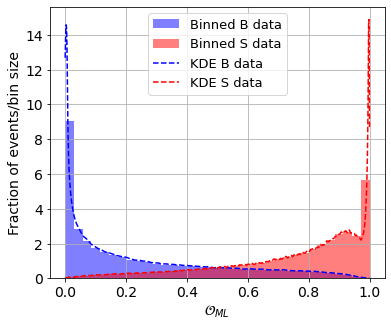

In [70]:
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

# points
s_vals = np.linspace(min_val,max_val,1000)

# evaluate the PDFs for each value of s
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )

# normalize
dens_bkg = dens_bkg / norm_factor_SM
dens_sig = dens_sig / norm_factor_NP

plt.figure(figsize=(6,5))

plt.hist(pred_XG_SM, 35, range=[min_val,max_val], density=True, color='blue',alpha=0.5, linewidth=2, label=r'Binned B data');
plt.hist(pred_XG_NP, 35, range=[min_val,max_val], density=True, color='red',alpha=0.5, linewidth=2, label=r'Binned S data');

plt.plot(s_vals, dens_bkg, color='blue',label=r'KDE B data',linestyle='dashed');
plt.plot(s_vals, dens_sig, color='red',label=r'KDE S data',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.yscale('log')
plt.xlabel("$\mathcal{O}_{ML}$",fontsize=14)
plt.ylabel("Fraction of events/bin size",fontsize=14)
plt.grid()
plt.legend(loc='upper center',fontsize=13)

plt.savefig('../graph/KDE_fit_BP' + str(bp+1) + '.pdf')

In [54]:
print(norm_factor_SM)
print(norm_factor_NP)

97.97245046006259
271.8735532200964


In [55]:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

print('This may take a while...')

pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
print('1 done')
pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
print('2 done')

# Normalize
pB_B_data = pB_B_data / norm_factor_SM
pS_B_data = pS_B_data / norm_factor_NP

This may take a while...
1 done
2 done


In [56]:
# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
print('3 done')
pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
print('4 done')

# Normalize
pB_S_data = pB_S_data / norm_factor_SM
pS_S_data = pS_S_data / norm_factor_NP
   

3 done
4 done


(array([143422., 138086.,   6451.,   4478.,   3429.,   2722.,   3403.,
          4645.,   5681.,  11725.]),
 array([7.08305385e-03, 1.52018219e+00, 3.03328133e+00, 4.54638047e+00,
        6.05947960e+00, 7.57257874e+00, 9.08567788e+00, 1.05987770e+01,
        1.21118762e+01, 1.36249753e+01, 1.51380744e+01]),
 [<matplotlib.patches.Polygon at 0x7f0a856c35e0>])

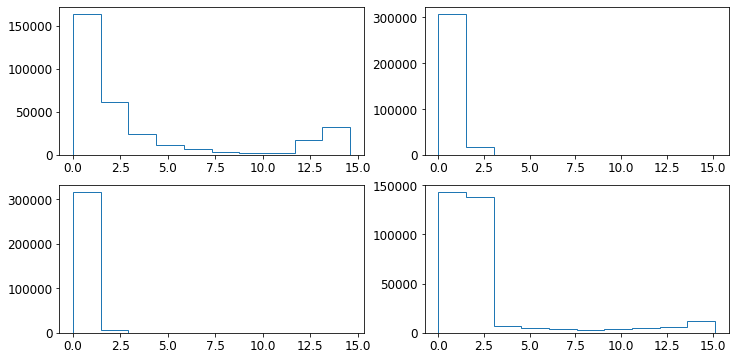

In [57]:
fig,ax = plt.subplots(2,2, figsize = (12,6))

ax[0,0].hist(pB_B_data, histtype = 'step')
ax[0,1].hist(pS_B_data, histtype = 'step')

ax[1,0].hist(pB_S_data, histtype = 'step')
ax[1,1].hist(pS_S_data, histtype = 'step')

In [ ]:
# indeces (to later build a random pseudo experiment)
indices_B = [i for i in range(len(pS_B_data))]
indices_S = [i for i in range(len(pS_S_data))]
        
        

In [ ]:
# loop over the number of pseudo experiments
#np.random.seed(91218)
Z_MLL = []
Z_MLL_std = []
Z_MLL_mu = []
Z_MLL_std_mu = []
for iloop in range(20): 
    print(iloop)
    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    for its in tqdm(range(200)):

        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)



        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)

        pB_S_data_shuf = []
        pS_S_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_S_data_shuf.append(pB_S_data[i])
            pS_S_data_shuf.append(pS_S_data[i])

        pB_S_data_shuf  = np.array(pB_S_data_shuf)
        pS_S_data_shuf  = np.array(pS_S_data_shuf)

        # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
        prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

        # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
        prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])



        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

        # approximation: mu_hat=1 (discovery)
        q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



        # ESTIMATE mu_hat for this particular ensemble (implicit equation)
        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        # reference points
        sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


        # we need (implicit eq. for mu_hat) = 1
        # conditions considering the reference points
        if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
            print('muhat = 2.1')
            muhat_selected_MLL = 2.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
            print('muhat = -0.1')
            muhat_selected_MLL = -0.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif sum_muhat_zero < 1 < sum_muhat_two:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break

        elif sum_muhat_two < 1 < sum_muhat_zero:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break


        # save the computed mu_hat (within range) for each pseudo_experiment
        muhat_selected_MLL_list.append(muhat_selected_MLL)


        # compute the test statistic for each pseudo_exp considering mu_hat
        if muhat_selected_MLL > 0:
            q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

        else:
            q_muhat_MLL.append( 0 )
            
    

    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
    Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL.append( Z_MLL_aux )
    Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


    # With the approximation of mu_hat
    Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_mu.append( Z_MLL_mu_aux )
    Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )

In [ ]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.savefig('../graph/loopBP6_KDEfijo.pdf')

## Loop varying KDE

In [ ]:
B_expected

In [ ]:
Z_MLL = []
Z_MLL_std = []
Z_MLL_mu = []
Z_MLL_std_mu = []
for iloop in range(20):
    print(iloop)
    kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                            50000, # Numero de datos para fitear
                                                                                            np.logspace(-4.0, 0.05, 20), 
                                                                                            set_kernel='epanechnikov')
    print('This may take a while...')

    pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
    print('1 done')
    pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
    print('2 done')

    # Normalize
    pB_B_data = pB_B_data / norm_factor_SM
    pS_B_data = pS_B_data / norm_factor_NP
    
    pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
    print('3 done')
    pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
    print('4 done')

    # Normalize
    pB_S_data = pB_S_data / norm_factor_SM
    pS_S_data = pS_S_data / norm_factor_NP
    
    # indeces (to later build a random pseudo experiment)
    indices_B = [i for i in range(len(pS_B_data))]
    indices_S = [i for i in range(len(pS_S_data))]
    # loop over the number of pseudo experiments
    #np.random.seed(91218)

    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    for its in tqdm(range(50)):

        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)



        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)

        pB_S_data_shuf = []
        pS_S_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_S_data_shuf.append(pB_S_data[i])
            pS_S_data_shuf.append(pS_S_data[i])

        pB_S_data_shuf  = np.array(pB_S_data_shuf)
        pS_S_data_shuf  = np.array(pS_S_data_shuf)

        # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
        prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

        # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
        prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])



        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

        # approximation: mu_hat=1 (discovery)
        q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



        # ESTIMATE mu_hat for this particular ensemble (implicit equation)
        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        # reference points
        sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


        # we need (implicit eq. for mu_hat) = 1
        # conditions considering the reference points
        if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
            print('muhat = 2.1')
            muhat_selected_MLL = 2.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
            print('muhat = -0.1')
            muhat_selected_MLL = -0.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif sum_muhat_zero < 1 < sum_muhat_two:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break

        elif sum_muhat_two < 1 < sum_muhat_zero:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break


        # save the computed mu_hat (within range) for each pseudo_experiment
        muhat_selected_MLL_list.append(muhat_selected_MLL)


        # compute the test statistic for each pseudo_exp considering mu_hat
        if muhat_selected_MLL > 0:
            q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

        else:
            q_muhat_MLL.append( 0 )



    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
    Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL.append( Z_MLL_aux )
    Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


    # With the approximation of mu_hat
    Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_mu.append( Z_MLL_mu_aux )
    Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )

In [ ]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.savefig('../graph/loopBP6_50000_KDEvariable_B_2.pdf')

## loop varying ML

In [162]:
lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

In [163]:
#B_expected = 200_000 #ttgamma_expected + Wjets_expected + Wgamma_expected #+ \
             #ttjets_expected + zjets_expected #+ \
             #tj_expected + tb_expected + tw_expected
            #+ wz_expected + zz_expected + ww_expected + \


In [164]:
B_expected

147986.4804

0
AUC:0.9374529826407074
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


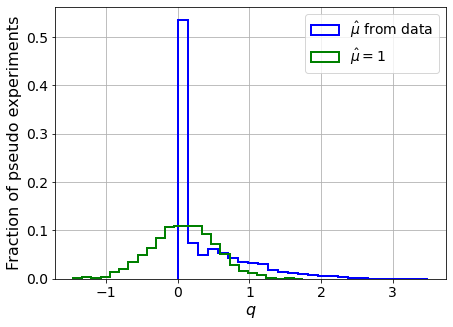

Z BL:(0.28921788847224467, 0.9343563486315678, 1.0248000000000002, 0.29134443995750425, 0.7727136321624182) with 15 bins


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  9396.96329828  9200.40452973  8947.53371873
  8627.02555193  8237.71457038  7764.32359424  7186.32913194
  6493.35064503  5634.41210188  4571.7458438   3290.64479269
  1740.13014839  -115.24755118 -2289.95477998 -5150.27004667]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf  7810.8946875
 

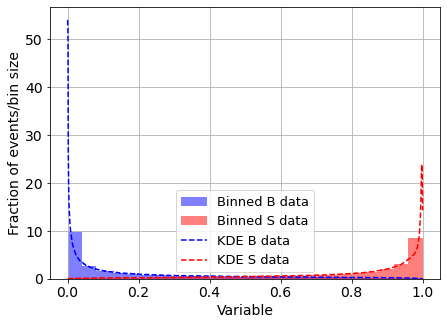

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.009554383733920618
0.009554383733920618
3 done
4 done
0.002244987742106982
0.002244987742106982
B_expected:  147986
S_expected:  22



  0%|                                                                   | 2/2000 [00:02<32:11,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3220827781070834
<p_{s}(Sdata)> = 2.811277160351765
<p_{b}(Bdata)> = 9.876254096647736
<p_{s}(Bdata)> = 0.30539512785575174


  0%|                                                                   | 3/2000 [00:02<24:05,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24797642232164915
<p_{s}(Sdata)> = 4.372237623904976
<p_{b}(Bdata)> = 9.975754091037892
<p_{s}(Bdata)> = 0.30412990105923804


  0%|▏                                                                  | 4/2000 [00:03<20:18,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32965047778160594
<p_{s}(Sdata)> = 5.592773769233162
<p_{b}(Bdata)> = 10.000545044123061
<p_{s}(Bdata)> = 0.30071283897613454


  0%|▏                                                                  | 5/2000 [00:03<18:15,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29027539760453336
<p_{s}(Sdata)> = 7.465306962465693
<p_{b}(Bdata)> = 9.952638608028884
<p_{s}(Bdata)> = 0.30286040103593187


  0%|▏                                                                  | 6/2000 [00:03<16:59,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.1303607945148897
<p_{s}(Sdata)> = 3.0684731961308023
<p_{b}(Bdata)> = 9.999325189220066
<p_{s}(Bdata)> = 0.3019767054892862


  0%|▏                                                                  | 7/2000 [00:04<18:06,  1.83it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5514760610923349
<p_{s}(Sdata)> = 5.013042227785723
<p_{b}(Bdata)> = 9.891860944037335
<p_{s}(Bdata)> = 0.305707067000114


  0%|▎                                                                  | 8/2000 [00:04<17:01,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39377657800041144
<p_{s}(Sdata)> = 4.549365540358509
<p_{b}(Bdata)> = 9.961833804891338
<p_{s}(Bdata)> = 0.3014176443811306


  0%|▎                                                                  | 9/2000 [00:05<16:22,  2.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29983359376892854
<p_{s}(Sdata)> = 5.560790561463822
<p_{b}(Bdata)> = 9.924648606163636
<p_{s}(Bdata)> = 0.30423189835346837


  1%|▎                                                                 | 11/2000 [00:09<37:45,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.39360398580844624
<p_{s}(Sdata)> = 4.726593231810867
<p_{b}(Bdata)> = 9.980848542175634
<p_{s}(Bdata)> = 0.3010385326603913


  1%|▍                                                                 | 12/2000 [00:09<30:41,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44073215309276276
<p_{s}(Sdata)> = 4.443406530302475
<p_{b}(Bdata)> = 9.89094061285361
<p_{s}(Bdata)> = 0.3013259734235832


  1%|▍                                                                 | 13/2000 [00:10<25:45,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3016254243723365
<p_{s}(Sdata)> = 3.5947547517210494
<p_{b}(Bdata)> = 9.951157415679562
<p_{s}(Bdata)> = 0.3028783768398202


  1%|▍                                                                 | 14/2000 [00:10<22:24,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2516549052765964
<p_{s}(Sdata)> = 3.5115269436302987
<p_{b}(Bdata)> = 9.988244951859045
<p_{s}(Bdata)> = 0.302136431526889


  1%|▌                                                                 | 17/2000 [00:16<39:10,  1.19s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.22033360879167918
<p_{s}(Sdata)> = 7.743016708794422
<p_{b}(Bdata)> = 9.954821089168561
<p_{s}(Bdata)> = 0.30353648892924917


  1%|▌                                                                 | 18/2000 [00:16<31:45,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2011838311630548
<p_{s}(Sdata)> = 5.583233719407462
<p_{b}(Bdata)> = 9.975856506975559
<p_{s}(Bdata)> = 0.3030316308223756


  1%|▋                                                                 | 19/2000 [00:16<26:32,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2565065441079068
<p_{s}(Sdata)> = 3.847642763743646
<p_{b}(Bdata)> = 9.976371637387365
<p_{s}(Bdata)> = 0.30028785238761313


  1%|▋                                                                 | 21/2000 [00:18<26:44,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1679733754754521
<p_{s}(Sdata)> = 8.831309578428419
<p_{b}(Bdata)> = 9.886525869356346
<p_{s}(Bdata)> = 0.30116598473329287


  1%|▋                                                                 | 22/2000 [00:19<23:05,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35511399815728245
<p_{s}(Sdata)> = 5.567287914000593
<p_{b}(Bdata)> = 9.953594088287867
<p_{s}(Bdata)> = 0.3022509414945754


  1%|▊                                                                 | 23/2000 [00:19<20:29,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3154856457776163
<p_{s}(Sdata)> = 3.208081223011128
<p_{b}(Bdata)> = 9.965183124136397
<p_{s}(Bdata)> = 0.30349778660944765


  1%|▊                                                                 | 24/2000 [00:20<18:37,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25064001098140076
<p_{s}(Sdata)> = 6.641689980685327
<p_{b}(Bdata)> = 9.949888626702185
<p_{s}(Bdata)> = 0.30226333701151625


  1%|▊                                                                 | 26/2000 [00:21<20:01,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2002461392371987
<p_{s}(Sdata)> = 4.974942068058073
<p_{b}(Bdata)> = 9.928950936987286
<p_{s}(Bdata)> = 0.30194507898636397


  1%|▉                                                                 | 27/2000 [00:21<18:22,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.246299922084083
<p_{s}(Sdata)> = 6.634866183844751
<p_{b}(Bdata)> = 9.934048435098912
<p_{s}(Bdata)> = 0.3037499900128732


  2%|█                                                                 | 31/2000 [00:31<50:21,  1.53s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28549520117569366
<p_{s}(Sdata)> = 6.680938546073446
<p_{b}(Bdata)> = 9.886657340934839
<p_{s}(Bdata)> = 0.301979718710083


  2%|█                                                                 | 32/2000 [00:31<39:35,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25876309992920443
<p_{s}(Sdata)> = 4.453091609027269
<p_{b}(Bdata)> = 9.902149499679131
<p_{s}(Bdata)> = 0.3039230602268656


  2%|█▏                                                                | 35/2000 [00:35<40:47,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2602019131575368
<p_{s}(Sdata)> = 5.565217613568742
<p_{b}(Bdata)> = 10.001509712532165
<p_{s}(Bdata)> = 0.3031471369881011


  2%|█▏                                                                | 36/2000 [00:36<34:39,  1.06s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.32408240558706214
<p_{s}(Sdata)> = 5.656348736096107
<p_{b}(Bdata)> = 10.009346081714472
<p_{s}(Bdata)> = 0.30445554857237067


  2%|█▏                                                                | 37/2000 [00:37<30:19,  1.08it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3640681488330075
<p_{s}(Sdata)> = 3.4534336754032573
<p_{b}(Bdata)> = 9.91647728753646
<p_{s}(Bdata)> = 0.30558620583846907


  2%|█▎                                                                | 38/2000 [00:37<25:32,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3420509718291259
<p_{s}(Sdata)> = 2.5761466390242265
<p_{b}(Bdata)> = 9.994008640379505
<p_{s}(Bdata)> = 0.30204092095386603


  2%|█▎                                                                | 41/2000 [00:40<30:35,  1.07it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5541160519460882
<p_{s}(Sdata)> = 6.315514968994666
<p_{b}(Bdata)> = 10.011881228289253
<p_{s}(Bdata)> = 0.30473225540219034


  2%|█▍                                                                | 42/2000 [00:41<27:29,  1.19it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.31400480217075677
<p_{s}(Sdata)> = 6.535350860834018
<p_{b}(Bdata)> = 9.983146068209516
<p_{s}(Bdata)> = 0.3052736341766307


  2%|█▍                                                                | 44/2000 [00:45<44:48,  1.37s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.27904124998129165
<p_{s}(Sdata)> = 4.819729144538133
<p_{b}(Bdata)> = 9.82722921535514
<p_{s}(Bdata)> = 0.306313222649635


  2%|█▌                                                                | 46/2000 [00:49<49:22,  1.52s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28894157755650773
<p_{s}(Sdata)> = 4.504841867447787
<p_{b}(Bdata)> = 9.892503252355855
<p_{s}(Bdata)> = 0.30223724966673193


  2%|█▌                                                                | 48/2000 [00:51<38:49,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2527103630086966
<p_{s}(Sdata)> = 4.336337011201643
<p_{b}(Bdata)> = 9.96966709399743
<p_{s}(Bdata)> = 0.3013985998570508


  2%|█▌                                                                | 49/2000 [00:52<33:12,  1.02s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3189821962020554
<p_{s}(Sdata)> = 5.268194325310295
<p_{b}(Bdata)> = 9.890006598230029
<p_{s}(Bdata)> = 0.30699077227884136


  2%|█▋                                                                | 50/2000 [00:52<27:32,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5899951052951466
<p_{s}(Sdata)> = 7.149220607038378
<p_{b}(Bdata)> = 9.927038589539466
<p_{s}(Bdata)> = 0.3016129353254731


  3%|█▋                                                                | 51/2000 [00:53<23:30,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30350208819198377
<p_{s}(Sdata)> = 4.825038048767254
<p_{b}(Bdata)> = 9.950834085307719
<p_{s}(Bdata)> = 0.30330664359476844


  3%|█▊                                                                | 54/2000 [00:56<32:15,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5268892521611713
<p_{s}(Sdata)> = 5.203721659449819
<p_{b}(Bdata)> = 9.928695232095583
<p_{s}(Bdata)> = 0.3023149068516977


  3%|█▉                                                                | 57/2000 [01:00<36:14,  1.12s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2186044952138442
<p_{s}(Sdata)> = 6.816750201529443
<p_{b}(Bdata)> = 9.990553679047288
<p_{s}(Bdata)> = 0.30462349775966313


  3%|██                                                                | 64/2000 [01:16<58:41,  1.82s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.40300250755010636
<p_{s}(Sdata)> = 4.471672870066439
<p_{b}(Bdata)> = 9.955039440533483
<p_{s}(Bdata)> = 0.3039627178985848


  3%|██▏                                                               | 66/2000 [01:17<39:55,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5231745680296542
<p_{s}(Sdata)> = 4.150407436324723
<p_{b}(Bdata)> = 9.921597052474517
<p_{s}(Bdata)> = 0.3034993902781853


  4%|██▎                                                               | 70/2000 [01:25<44:21,  1.38s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3015843196921947
<p_{s}(Sdata)> = 5.703930163730036
<p_{b}(Bdata)> = 10.082381303041442
<p_{s}(Bdata)> = 0.30135288334469257


  4%|██▎                                                               | 71/2000 [01:25<35:13,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29498415534619754
<p_{s}(Sdata)> = 4.122058269870617
<p_{b}(Bdata)> = 9.902298863134467
<p_{s}(Bdata)> = 0.30258704541783776


  4%|██▍                                                               | 72/2000 [01:25<28:50,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25288041465284394
<p_{s}(Sdata)> = 4.335696098118371
<p_{b}(Bdata)> = 9.975265623825225
<p_{s}(Bdata)> = 0.30279809084272796


  4%|██▍                                                               | 74/2000 [01:29<42:55,  1.34s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.43248042164094064
<p_{s}(Sdata)> = 4.906485650076619
<p_{b}(Bdata)> = 9.859863186273273
<p_{s}(Bdata)> = 0.3032592803209421


  4%|██▌                                                               | 76/2000 [01:32<37:52,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22441343755679707
<p_{s}(Sdata)> = 4.203595116750504
<p_{b}(Bdata)> = 9.93083983812118
<p_{s}(Bdata)> = 0.30283558470421557


  4%|██▌                                                               | 77/2000 [01:32<30:50,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31646541483818874
<p_{s}(Sdata)> = 2.863230363393052
<p_{b}(Bdata)> = 9.886519724127478
<p_{s}(Bdata)> = 0.3029070701049444


  4%|██▌                                                               | 78/2000 [01:33<27:41,  1.16it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.27312953685260266
<p_{s}(Sdata)> = 3.9768673044651055
<p_{b}(Bdata)> = 9.933529970428266
<p_{s}(Bdata)> = 0.30524902304024387


  4%|██▌                                                               | 79/2000 [01:33<23:41,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24199217543512466
<p_{s}(Sdata)> = 4.0438973273434415
<p_{b}(Bdata)> = 9.924662208321035
<p_{s}(Bdata)> = 0.3026447035716496


  4%|██▋                                                               | 82/2000 [01:38<34:54,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3963946599981889
<p_{s}(Sdata)> = 3.8168519056866113
<p_{b}(Bdata)> = 9.920692227909543
<p_{s}(Bdata)> = 0.3015773855522098


  4%|██▊                                                               | 85/2000 [01:44<46:51,  1.47s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1905446067996931
<p_{s}(Sdata)> = 6.272632422136736
<p_{b}(Bdata)> = 9.97067734016744
<p_{s}(Bdata)> = 0.3036300286629906


  4%|██▊                                                               | 87/2000 [01:46<38:22,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2788995263704276
<p_{s}(Sdata)> = 3.7834994507096766
<p_{b}(Bdata)> = 9.93595743312703
<p_{s}(Bdata)> = 0.303399451553981


  4%|██▉                                                               | 89/2000 [01:48<33:40,  1.06s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2893374078268931
<p_{s}(Sdata)> = 6.063519750464373
<p_{b}(Bdata)> = 10.010584675534338
<p_{s}(Bdata)> = 0.30609492423761625


  5%|███                                                               | 91/2000 [01:50<34:27,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19912197621257388
<p_{s}(Sdata)> = 4.213790197257038
<p_{b}(Bdata)> = 9.836489814446455
<p_{s}(Bdata)> = 0.3051370609489288


  5%|███                                                               | 92/2000 [01:51<28:16,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2369262386972408
<p_{s}(Sdata)> = 3.9617274355172496
<p_{b}(Bdata)> = 10.003436691241212
<p_{s}(Bdata)> = 0.30124547922002176


  5%|███                                                               | 93/2000 [01:51<23:58,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45876114259262724
<p_{s}(Sdata)> = 3.875181162434524
<p_{b}(Bdata)> = 9.912658919667736
<p_{s}(Bdata)> = 0.30269226768337526


  5%|███                                                               | 94/2000 [01:52<20:57,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34577368935467173
<p_{s}(Sdata)> = 3.570895397913322
<p_{b}(Bdata)> = 9.952865945277557
<p_{s}(Bdata)> = 0.3009262781755809


  5%|███▏                                                              | 95/2000 [01:52<18:46,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36302965801278275
<p_{s}(Sdata)> = 3.3990713860094792
<p_{b}(Bdata)> = 9.922927617056345
<p_{s}(Bdata)> = 0.30403083740957926


  5%|███▏                                                              | 96/2000 [01:52<17:17,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21847804432146986
<p_{s}(Sdata)> = 3.436104328357457
<p_{b}(Bdata)> = 9.942963812314932
<p_{s}(Bdata)> = 0.3027288391754876


  5%|███▏                                                              | 97/2000 [01:53<16:15,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4280742843732635
<p_{s}(Sdata)> = 3.6380287791835313
<p_{b}(Bdata)> = 9.996798531323027
<p_{s}(Bdata)> = 0.30449625190054364


  5%|███▎                                                              | 99/2000 [01:55<21:40,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4891684341081625
<p_{s}(Sdata)> = 2.146948072962169
<p_{b}(Bdata)> = 9.958444046250861
<p_{s}(Bdata)> = 0.3015726236427534


  5%|███▎                                                             | 100/2000 [01:55<19:18,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2853542516342618
<p_{s}(Sdata)> = 5.580602899159594
<p_{b}(Bdata)> = 9.906398195797413
<p_{s}(Bdata)> = 0.30039865375300345


  5%|███▎                                                             | 101/2000 [01:56<19:22,  1.63it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3220998416688694
<p_{s}(Sdata)> = 6.051297109356313
<p_{b}(Bdata)> = 9.917702271843607
<p_{s}(Bdata)> = 0.30513779067122987


  5%|███▎                                                             | 102/2000 [01:56<17:43,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26015078696266747
<p_{s}(Sdata)> = 5.031374874701881
<p_{b}(Bdata)> = 9.860462460995981
<p_{s}(Bdata)> = 0.30365969024655287


  5%|███▍                                                             | 104/2000 [01:58<22:57,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3012797566763028
<p_{s}(Sdata)> = 3.117355556599872
<p_{b}(Bdata)> = 9.927976640684843
<p_{s}(Bdata)> = 0.303234487553116


  5%|███▍                                                             | 105/2000 [01:59<20:16,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2471920420124752
<p_{s}(Sdata)> = 5.287242652738725
<p_{b}(Bdata)> = 9.997889727502256
<p_{s}(Bdata)> = 0.301882347762212


  5%|███▍                                                             | 106/2000 [01:59<18:21,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22988720326591644
<p_{s}(Sdata)> = 6.286811732272807
<p_{b}(Bdata)> = 9.978140250095695
<p_{s}(Bdata)> = 0.30331806322833194


  5%|███▍                                                             | 107/2000 [02:00<18:44,  1.68it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.385461538783852
<p_{s}(Sdata)> = 4.73972470330957
<p_{b}(Bdata)> = 9.876806728817554
<p_{s}(Bdata)> = 0.30453574949096096


  5%|███▌                                                             | 108/2000 [02:00<17:15,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26425554697643455
<p_{s}(Sdata)> = 4.652613561956545
<p_{b}(Bdata)> = 9.953047911840903
<p_{s}(Bdata)> = 0.30339117172044333


  5%|███▌                                                             | 109/2000 [02:01<17:57,  1.75it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20587022299723517
<p_{s}(Sdata)> = 6.6992139656736
<p_{b}(Bdata)> = 9.996359666636511
<p_{s}(Bdata)> = 0.30403370935388174


  6%|███▌                                                             | 111/2000 [02:05<35:16,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20972530101532924
<p_{s}(Sdata)> = 4.226478037668143
<p_{b}(Bdata)> = 9.901436338363505
<p_{s}(Bdata)> = 0.30081837230617275


  6%|███▋                                                             | 112/2000 [02:05<28:49,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3721507296272777
<p_{s}(Sdata)> = 3.3449448698326965
<p_{b}(Bdata)> = 9.893278443307029
<p_{s}(Bdata)> = 0.3018178852760376


  6%|███▋                                                             | 113/2000 [02:06<24:17,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21257020955225692
<p_{s}(Sdata)> = 3.821698557810949
<p_{b}(Bdata)> = 9.96728133208371
<p_{s}(Bdata)> = 0.3018202488937216


  6%|███▋                                                             | 114/2000 [02:06<22:49,  1.38it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3142689995132783
<p_{s}(Sdata)> = 5.848608676340298
<p_{b}(Bdata)> = 9.926071300949816
<p_{s}(Bdata)> = 0.30463978415906784


  6%|███▊                                                             | 116/2000 [02:08<28:01,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.331087465053334
<p_{s}(Sdata)> = 5.081787509209188
<p_{b}(Bdata)> = 9.952529244527074
<p_{s}(Bdata)> = 0.301477531648592


  6%|███▊                                                             | 117/2000 [02:09<23:44,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28191863833638875
<p_{s}(Sdata)> = 3.1512357718086608
<p_{b}(Bdata)> = 9.90671912477509
<p_{s}(Bdata)> = 0.3011610034525638


  6%|███▊                                                             | 118/2000 [02:10<22:40,  1.38it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.31179400184456185
<p_{s}(Sdata)> = 4.602362828165025
<p_{b}(Bdata)> = 9.992985020828035
<p_{s}(Bdata)> = 0.30658238210752164


  6%|███▊                                                             | 119/2000 [02:10<19:59,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2838144458603047
<p_{s}(Sdata)> = 5.23697670834065
<p_{b}(Bdata)> = 9.950703331314557
<p_{s}(Bdata)> = 0.3024636864358014


  6%|███▉                                                             | 120/2000 [02:10<18:05,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21826593237372194
<p_{s}(Sdata)> = 7.786843496547887
<p_{b}(Bdata)> = 9.904368592087444
<p_{s}(Bdata)> = 0.30176413442257555


  6%|███▉                                                             | 123/2000 [02:17<44:41,  1.43s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.12503055059968457
<p_{s}(Sdata)> = 9.28295442338243
<p_{b}(Bdata)> = 9.925226326433366
<p_{s}(Bdata)> = 0.30634268857403646


  6%|████                                                             | 124/2000 [02:17<35:24,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2580739537205321
<p_{s}(Sdata)> = 4.991021263306407
<p_{b}(Bdata)> = 9.997536827147508
<p_{s}(Bdata)> = 0.30207280855234014


  6%|████                                                             | 125/2000 [02:18<28:51,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.336776980651922
<p_{s}(Sdata)> = 5.944582771856534
<p_{b}(Bdata)> = 9.930320553662618
<p_{s}(Bdata)> = 0.3026846392987209


  6%|████                                                             | 126/2000 [02:18<24:17,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3040225654115486
<p_{s}(Sdata)> = 2.9820377073639266
<p_{b}(Bdata)> = 9.893867687893831
<p_{s}(Bdata)> = 0.3022922457858266


  6%|████▏                                                            | 127/2000 [02:19<21:06,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5426696523945622
<p_{s}(Sdata)> = 4.413870558885498
<p_{b}(Bdata)> = 10.000362765119153
<p_{s}(Bdata)> = 0.30269628801322657


  6%|████▏                                                            | 128/2000 [02:19<20:40,  1.51it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16814780656834816
<p_{s}(Sdata)> = 6.009656134592175
<p_{b}(Bdata)> = 9.960343503256158
<p_{s}(Bdata)> = 0.30364477436141324


  6%|████▏                                                            | 130/2000 [02:22<26:01,  1.20it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24686520411506932
<p_{s}(Sdata)> = 4.555392027103812
<p_{b}(Bdata)> = 9.890736938082222
<p_{s}(Bdata)> = 0.3066397882624217


  7%|████▎                                                            | 132/2000 [02:23<22:29,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3745953716563946
<p_{s}(Sdata)> = 3.771695799297161
<p_{b}(Bdata)> = 9.931933071795804
<p_{s}(Bdata)> = 0.30513845507218823


  7%|████▎                                                            | 133/2000 [02:23<19:50,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2713056242907945
<p_{s}(Sdata)> = 3.330965688706284
<p_{b}(Bdata)> = 9.824460708183176
<p_{s}(Bdata)> = 0.3027703513418164


  7%|████▎                                                            | 134/2000 [02:24<17:56,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.593582010475342
<p_{s}(Sdata)> = 5.758232528075141
<p_{b}(Bdata)> = 9.962301502845612
<p_{s}(Bdata)> = 0.3028012090458364


  7%|████▍                                                            | 135/2000 [02:24<18:17,  1.70it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23984438790450108
<p_{s}(Sdata)> = 5.541307704825009
<p_{b}(Bdata)> = 9.913041459270197
<p_{s}(Bdata)> = 0.30585193418841755


  7%|████▍                                                            | 136/2000 [02:25<16:55,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41199526006351334
<p_{s}(Sdata)> = 3.8195422963568317
<p_{b}(Bdata)> = 9.88704333181154
<p_{s}(Bdata)> = 0.3016120716331443


  7%|████▍                                                            | 137/2000 [02:25<15:55,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3180324075564049
<p_{s}(Sdata)> = 5.061403512371646
<p_{b}(Bdata)> = 9.912105931678878
<p_{s}(Bdata)> = 0.3042940040099906


  7%|████▌                                                            | 139/2000 [02:30<37:23,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3302117133724015
<p_{s}(Sdata)> = 2.9149587579101306
<p_{b}(Bdata)> = 9.991498093418981
<p_{s}(Bdata)> = 0.302237725467184


  7%|████▌                                                            | 141/2000 [02:33<39:54,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.378183112563746
<p_{s}(Sdata)> = 5.4494782779190025
<p_{b}(Bdata)> = 9.911495888373233
<p_{s}(Bdata)> = 0.303365829021577


  7%|████▌                                                            | 142/2000 [02:33<31:58,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30597938552799187
<p_{s}(Sdata)> = 3.2665745137258857
<p_{b}(Bdata)> = 10.00439895610722
<p_{s}(Bdata)> = 0.3023344070044074


  7%|████▋                                                            | 143/2000 [02:34<28:05,  1.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3469674112220556
<p_{s}(Sdata)> = 4.964132131759333
<p_{b}(Bdata)> = 9.863248964983011
<p_{s}(Bdata)> = 0.30657089389667097


  7%|████▋                                                            | 144/2000 [02:34<23:48,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49717715990100975
<p_{s}(Sdata)> = 4.304770469426619
<p_{b}(Bdata)> = 9.925976947712803
<p_{s}(Bdata)> = 0.3026298988628863


  7%|████▊                                                            | 147/2000 [02:38<30:35,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20025095378091784
<p_{s}(Sdata)> = 6.511102534230166
<p_{b}(Bdata)> = 9.895460954343521
<p_{s}(Bdata)> = 0.3028596547191034


  7%|████▊                                                            | 149/2000 [02:43<45:28,  1.47s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19175195514009893
<p_{s}(Sdata)> = 7.295122201639078
<p_{b}(Bdata)> = 9.98120590661198
<p_{s}(Bdata)> = 0.3043776522352433


  8%|████▉                                                            | 150/2000 [02:43<35:52,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2319239734189033
<p_{s}(Sdata)> = 6.313764213480195
<p_{b}(Bdata)> = 9.924307291691392
<p_{s}(Bdata)> = 0.3027525593336476


  8%|████▉                                                            | 151/2000 [02:43<29:07,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5306474453375168
<p_{s}(Sdata)> = 3.866158479757649
<p_{b}(Bdata)> = 9.856171268344413
<p_{s}(Bdata)> = 0.30560262300046664


  8%|████▉                                                            | 152/2000 [02:44<24:26,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.311084882000894
<p_{s}(Sdata)> = 4.644501713515893
<p_{b}(Bdata)> = 9.859526058787642
<p_{s}(Bdata)> = 0.3032545315285705


  8%|████▉                                                            | 153/2000 [02:44<21:15,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24341504000471934
<p_{s}(Sdata)> = 5.246766769040955
<p_{b}(Bdata)> = 9.885157378766285
<p_{s}(Bdata)> = 0.3026578157758461


  8%|█████                                                            | 155/2000 [02:48<35:17,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2942044326644064
<p_{s}(Sdata)> = 3.9360362533223694
<p_{b}(Bdata)> = 10.007969614616506
<p_{s}(Bdata)> = 0.3017487933464238


  8%|█████                                                            | 156/2000 [02:48<28:47,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36694474102797736
<p_{s}(Sdata)> = 5.831874516091631
<p_{b}(Bdata)> = 9.950171523153552
<p_{s}(Bdata)> = 0.3024774002939186


  8%|█████                                                            | 157/2000 [02:49<24:09,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26304801247841253
<p_{s}(Sdata)> = 3.701597930536506
<p_{b}(Bdata)> = 9.960589965692145
<p_{s}(Bdata)> = 0.3009856340756893


  8%|█████▏                                                           | 158/2000 [02:49<22:35,  1.36it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24305243055008913
<p_{s}(Sdata)> = 4.819379935580267
<p_{b}(Bdata)> = 9.969845812100983
<p_{s}(Bdata)> = 0.30704557565971197


  8%|█████▏                                                           | 159/2000 [02:50<19:50,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34739400759733907
<p_{s}(Sdata)> = 4.474620427776232
<p_{b}(Bdata)> = 9.91875968149796
<p_{s}(Bdata)> = 0.30388273861035425


  8%|█████▏                                                           | 161/2000 [02:53<33:48,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.242925220689429
<p_{s}(Sdata)> = 5.432753994765799
<p_{b}(Bdata)> = 9.920163125943647
<p_{s}(Bdata)> = 0.3035626034199593


  8%|█████▎                                                           | 163/2000 [02:55<25:43,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23128791712267038
<p_{s}(Sdata)> = 7.385260815562346
<p_{b}(Bdata)> = 9.973081950282822
<p_{s}(Bdata)> = 0.3016223066247583


  8%|█████▎                                                           | 165/2000 [02:58<33:47,  1.10s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2259474514555282
<p_{s}(Sdata)> = 5.897662491060189
<p_{b}(Bdata)> = 9.895347212895214
<p_{s}(Bdata)> = 0.30464337795880453


  8%|█████▍                                                           | 167/2000 [03:01<37:30,  1.23s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2520431490919763
<p_{s}(Sdata)> = 5.756837974039141
<p_{b}(Bdata)> = 9.95682875283521
<p_{s}(Bdata)> = 0.3049576217474653


  8%|█████▍                                                           | 168/2000 [03:01<30:17,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2047001426840997
<p_{s}(Sdata)> = 5.828347754228482
<p_{b}(Bdata)> = 9.908100719937469
<p_{s}(Bdata)> = 0.30339273290389956


  8%|█████▍                                                           | 169/2000 [03:02<25:13,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2495460509564391
<p_{s}(Sdata)> = 6.179389543202997
<p_{b}(Bdata)> = 9.906697390466018
<p_{s}(Bdata)> = 0.30487873443127106


  8%|█████▌                                                           | 170/2000 [03:02<21:44,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2858879856605034
<p_{s}(Sdata)> = 4.810942046965685
<p_{b}(Bdata)> = 9.942852820944154
<p_{s}(Bdata)> = 0.30375188132334263


  9%|█████▌                                                           | 171/2000 [03:03<19:15,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2835102439021123
<p_{s}(Sdata)> = 4.3891751453587045
<p_{b}(Bdata)> = 9.950800795869608
<p_{s}(Bdata)> = 0.30186634858129036


  9%|█████▌                                                           | 172/2000 [03:03<17:29,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3779160898937347
<p_{s}(Sdata)> = 5.340958548751308
<p_{b}(Bdata)> = 9.90538793767298
<p_{s}(Bdata)> = 0.3020777738524136


  9%|█████▋                                                           | 174/2000 [03:06<30:35,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24230107604582782
<p_{s}(Sdata)> = 5.563847382542494
<p_{b}(Bdata)> = 10.050617250344908
<p_{s}(Bdata)> = 0.29885733043301616


  9%|█████▋                                                           | 176/2000 [03:09<32:34,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.37778420565916354
<p_{s}(Sdata)> = 3.8555636298970937
<p_{b}(Bdata)> = 10.03033641433836
<p_{s}(Bdata)> = 0.30390497147063195


  9%|█████▊                                                           | 177/2000 [03:09<26:53,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19594933597097522
<p_{s}(Sdata)> = 7.20492657941382
<p_{b}(Bdata)> = 9.944953581445537
<p_{s}(Bdata)> = 0.30237976789647947


  9%|█████▊                                                           | 178/2000 [03:10<22:52,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31865126863073107
<p_{s}(Sdata)> = 4.066795118561727
<p_{b}(Bdata)> = 9.953347240462232
<p_{s}(Bdata)> = 0.30187051443844143


  9%|█████▊                                                           | 179/2000 [03:10<20:07,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19293132880975936
<p_{s}(Sdata)> = 4.140389262901677
<p_{b}(Bdata)> = 10.007372871629334
<p_{s}(Bdata)> = 0.30133734044069677


  9%|█████▉                                                           | 182/2000 [03:17<43:21,  1.43s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.245636706669983
<p_{s}(Sdata)> = 7.099023822820933
<p_{b}(Bdata)> = 9.893608677048697
<p_{s}(Bdata)> = 0.30282965782012966


  9%|█████▉                                                           | 183/2000 [03:17<34:16,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25120058223754693
<p_{s}(Sdata)> = 4.151378828373297
<p_{b}(Bdata)> = 9.970532123754168
<p_{s}(Bdata)> = 0.3043323620182701


  9%|█████▉                                                           | 184/2000 [03:17<27:58,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3405463939806098
<p_{s}(Sdata)> = 3.907829320360647
<p_{b}(Bdata)> = 9.866055427621461
<p_{s}(Bdata)> = 0.3051980778539422


  9%|██████                                                           | 185/2000 [03:18<23:35,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27426344026504357
<p_{s}(Sdata)> = 4.67310057267167
<p_{b}(Bdata)> = 9.91726111435633
<p_{s}(Bdata)> = 0.30350248289719994


  9%|██████                                                           | 186/2000 [03:18<20:28,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2480438466665203
<p_{s}(Sdata)> = 3.696621400230651
<p_{b}(Bdata)> = 9.90576101355449
<p_{s}(Bdata)> = 0.30148135836322365


  9%|██████                                                           | 187/2000 [03:19<18:16,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.684426153132372
<p_{s}(Sdata)> = 4.5561231014751895
<p_{b}(Bdata)> = 9.90462341204316
<p_{s}(Bdata)> = 0.30288959474398675


  9%|██████                                                           | 188/2000 [03:19<16:45,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24489193114754398
<p_{s}(Sdata)> = 6.0767548013350385
<p_{b}(Bdata)> = 9.960355375889527
<p_{s}(Bdata)> = 0.30133092435799474


  9%|██████▏                                                          | 189/2000 [03:20<15:43,  1.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32093907235474534
<p_{s}(Sdata)> = 4.263826493502581
<p_{b}(Bdata)> = 9.883028730700714
<p_{s}(Bdata)> = 0.3024510362875684


 10%|██████▏                                                          | 190/2000 [03:20<16:38,  1.81it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.32626753427302363
<p_{s}(Sdata)> = 4.31832580336767
<p_{b}(Bdata)> = 10.009788173647403
<p_{s}(Bdata)> = 0.3065514653414433


 10%|██████▏                                                          | 191/2000 [03:21<15:36,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36138319235616395
<p_{s}(Sdata)> = 4.985130358270419
<p_{b}(Bdata)> = 9.938957510866652
<p_{s}(Bdata)> = 0.30193005183311405


 10%|██████▎                                                          | 194/2000 [03:24<23:24,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3099369097528397
<p_{s}(Sdata)> = 6.846839592951607
<p_{b}(Bdata)> = 9.952589098849119
<p_{s}(Bdata)> = 0.302568129948934


 10%|██████▎                                                          | 195/2000 [03:24<20:25,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21459332159876354
<p_{s}(Sdata)> = 4.696404269371589
<p_{b}(Bdata)> = 9.945799831664837
<p_{s}(Bdata)> = 0.30266209588400766


 10%|██████▍                                                          | 197/2000 [03:28<32:54,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.35874280040493817
<p_{s}(Sdata)> = 6.011854617175938
<p_{b}(Bdata)> = 9.922120717736128
<p_{s}(Bdata)> = 0.30192594537961065


 10%|██████▌                                                          | 201/2000 [03:35<39:33,  1.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23639485004591979
<p_{s}(Sdata)> = 7.452989268852815
<p_{b}(Bdata)> = 9.916581274726322
<p_{s}(Bdata)> = 0.3026230920365048


 10%|██████▌                                                          | 202/2000 [03:36<31:35,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24287122815030257
<p_{s}(Sdata)> = 5.815343393909195
<p_{b}(Bdata)> = 9.97121981875006
<p_{s}(Bdata)> = 0.30316603064906605


 10%|██████▌                                                          | 203/2000 [03:36<26:02,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2500538768555858
<p_{s}(Sdata)> = 4.9549099187105625
<p_{b}(Bdata)> = 9.99018610684049
<p_{s}(Bdata)> = 0.3017497806649045


 10%|██████▋                                                          | 204/2000 [03:36<22:07,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3686421300767546
<p_{s}(Sdata)> = 1.815594326511194
<p_{b}(Bdata)> = 9.973532105777688
<p_{s}(Bdata)> = 0.30472467063754377


 10%|██████▋                                                          | 206/2000 [03:40<32:50,  1.10s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3186473551336406
<p_{s}(Sdata)> = 6.757757129637184
<p_{b}(Bdata)> = 9.902380598293574
<p_{s}(Bdata)> = 0.3064559686690166


 10%|██████▋                                                          | 207/2000 [03:40<28:42,  1.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3311788287273415
<p_{s}(Sdata)> = 7.34450897068166
<p_{b}(Bdata)> = 10.010899593760426
<p_{s}(Bdata)> = 0.3037519437339082


 10%|██████▊                                                          | 208/2000 [03:41<23:59,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24747097118443984
<p_{s}(Sdata)> = 5.66234981950892
<p_{b}(Bdata)> = 9.934575618059347
<p_{s}(Bdata)> = 0.302591536077037


 10%|██████▊                                                          | 209/2000 [03:41<20:43,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26149740928333937
<p_{s}(Sdata)> = 1.7344199398119464
<p_{b}(Bdata)> = 9.902498372612456
<p_{s}(Bdata)> = 0.30291851743426873


 10%|██████▊                                                          | 210/2000 [03:42<18:23,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33362776982171544
<p_{s}(Sdata)> = 2.6079307531906832
<p_{b}(Bdata)> = 9.937043826852364
<p_{s}(Bdata)> = 0.30248212983643075


 11%|██████▊                                                          | 211/2000 [03:42<18:23,  1.62it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.29611326785081354
<p_{s}(Sdata)> = 3.1132605684445482
<p_{b}(Bdata)> = 9.848541659984068
<p_{s}(Bdata)> = 0.3059210341848408


 11%|██████▉                                                          | 212/2000 [03:43<16:49,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3640192243645496
<p_{s}(Sdata)> = 3.7504820121921525
<p_{b}(Bdata)> = 10.009716481356598
<p_{s}(Bdata)> = 0.30145220433333664


 11%|██████▉                                                          | 213/2000 [03:43<15:42,  1.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24783685528642674
<p_{s}(Sdata)> = 3.606082742735689
<p_{b}(Bdata)> = 9.949304419153695
<p_{s}(Bdata)> = 0.3012241435002422


 11%|██████▉                                                          | 215/2000 [03:46<27:04,  1.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24459318459449453
<p_{s}(Sdata)> = 5.470118665902815
<p_{b}(Bdata)> = 9.916331821469042
<p_{s}(Bdata)> = 0.3050924062195389


 11%|███████                                                          | 216/2000 [03:46<22:50,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39967110395309985
<p_{s}(Sdata)> = 5.177715227104288
<p_{b}(Bdata)> = 9.948345762540619
<p_{s}(Bdata)> = 0.30343885390060915


 11%|███████                                                          | 217/2000 [03:47<19:51,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2998799962380913
<p_{s}(Sdata)> = 3.389787023692436
<p_{b}(Bdata)> = 9.897312561190633
<p_{s}(Bdata)> = 0.3006601614663953


 11%|███████                                                          | 218/2000 [03:47<17:46,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3174109496436882
<p_{s}(Sdata)> = 4.5667155703410875
<p_{b}(Bdata)> = 9.866908042177325
<p_{s}(Bdata)> = 0.3036337794476299


 11%|███████▏                                                         | 220/2000 [03:51<31:58,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.34099109479224593
<p_{s}(Sdata)> = 2.835218985574528
<p_{b}(Bdata)> = 9.966065891631473
<p_{s}(Bdata)> = 0.30216399242238956


 11%|███████▏                                                         | 223/2000 [03:55<36:39,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.34770532801427223
<p_{s}(Sdata)> = 3.453824310531465
<p_{b}(Bdata)> = 9.939530738116066
<p_{s}(Bdata)> = 0.3014504960465603


 11%|███████▎                                                         | 224/2000 [03:56<29:30,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.327593994359117
<p_{s}(Sdata)> = 4.694407462969397
<p_{b}(Bdata)> = 9.953572697151717
<p_{s}(Bdata)> = 0.30216794764638144


 11%|███████▎                                                         | 226/2000 [03:58<28:27,  1.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2022184377808376
<p_{s}(Sdata)> = 7.640470960413485
<p_{b}(Bdata)> = 9.909979514583988
<p_{s}(Bdata)> = 0.3058315409717962


 11%|███████▍                                                         | 228/2000 [04:01<37:42,  1.28s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2400673590548621
<p_{s}(Sdata)> = 4.770419825604358
<p_{b}(Bdata)> = 9.856979086940603
<p_{s}(Bdata)> = 0.30381594883796176


 11%|███████▍                                                         | 229/2000 [04:02<30:19,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.37270129360416865
<p_{s}(Sdata)> = 4.753640505487551
<p_{b}(Bdata)> = 9.970176866779951
<p_{s}(Bdata)> = 0.3030104672056234


 12%|███████▌                                                         | 232/2000 [04:06<34:15,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.34044300398162436
<p_{s}(Sdata)> = 5.235945391947985
<p_{b}(Bdata)> = 9.949658249709548
<p_{s}(Bdata)> = 0.3040320744656295


 12%|███████▌                                                         | 233/2000 [04:06<27:54,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2966305383898117
<p_{s}(Sdata)> = 2.8279941656845935
<p_{b}(Bdata)> = 9.937999653504281
<p_{s}(Bdata)> = 0.30216408934203753


 12%|███████▋                                                         | 235/2000 [04:08<24:39,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33496966990506993
<p_{s}(Sdata)> = 4.201462789022214
<p_{b}(Bdata)> = 9.96733349982475
<p_{s}(Bdata)> = 0.303885190660639


 12%|███████▋                                                         | 236/2000 [04:08<21:10,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2752901691289683
<p_{s}(Sdata)> = 4.17228978618371
<p_{b}(Bdata)> = 10.016986200713701
<p_{s}(Bdata)> = 0.3033597113938589


 12%|███████▋                                                         | 238/2000 [04:12<34:39,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26211431203237184
<p_{s}(Sdata)> = 5.020215653079705
<p_{b}(Bdata)> = 9.919283574595669
<p_{s}(Bdata)> = 0.3024091728934403


 12%|███████▊                                                         | 240/2000 [04:15<35:25,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2088398871631457
<p_{s}(Sdata)> = 6.095019833264414
<p_{b}(Bdata)> = 9.972672002008569
<p_{s}(Bdata)> = 0.3027196160344587


 12%|███████▉                                                         | 245/2000 [04:24<46:39,  1.60s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4048612977190587
<p_{s}(Sdata)> = 4.041372889912358
<p_{b}(Bdata)> = 9.886950984287395
<p_{s}(Bdata)> = 0.30315972574313743


 12%|████████                                                         | 247/2000 [04:26<32:31,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.34836962627132306
<p_{s}(Sdata)> = 5.4339120035954895
<p_{b}(Bdata)> = 9.995888411729632
<p_{s}(Bdata)> = 0.30019247878356775


 12%|████████                                                         | 249/2000 [04:30<41:22,  1.42s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.6483794033120268
<p_{s}(Sdata)> = 7.035764916288745
<p_{b}(Bdata)> = 9.915903297394532
<p_{s}(Bdata)> = 0.30144181131469416


 13%|████████▏                                                        | 251/2000 [04:32<38:00,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3544429176828234
<p_{s}(Sdata)> = 3.8027847228048093
<p_{b}(Bdata)> = 9.929966236304864
<p_{s}(Bdata)> = 0.3042521070762551


 13%|████████▏                                                        | 252/2000 [04:33<30:28,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.32683546444420436
<p_{s}(Sdata)> = 2.157522537765677
<p_{b}(Bdata)> = 9.908857950887638
<p_{s}(Bdata)> = 0.29992683534919795


 13%|████████▎                                                        | 254/2000 [04:36<37:27,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.42572889740153874
<p_{s}(Sdata)> = 7.783979081696081
<p_{b}(Bdata)> = 9.859104526112406
<p_{s}(Bdata)> = 0.3020493491308978


 13%|████████▎                                                        | 255/2000 [04:37<31:44,  1.09s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2713733205633995
<p_{s}(Sdata)> = 6.1464704243253685
<p_{b}(Bdata)> = 9.928470271803672
<p_{s}(Bdata)> = 0.3051117614989734


 13%|████████▎                                                        | 257/2000 [04:39<26:45,  1.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3491097819119489
<p_{s}(Sdata)> = 6.559181250570869
<p_{b}(Bdata)> = 9.94067869889702
<p_{s}(Bdata)> = 0.30458039190822367


 13%|████████▍                                                        | 259/2000 [04:40<22:47,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21769942552943045
<p_{s}(Sdata)> = 6.302829050913288
<p_{b}(Bdata)> = 9.878070219247572
<p_{s}(Bdata)> = 0.3028670916762175


 13%|████████▍                                                        | 260/2000 [04:40<20:04,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23636810546031956
<p_{s}(Sdata)> = 5.4130099505266775
<p_{b}(Bdata)> = 9.905817502427446
<p_{s}(Bdata)> = 0.30084631034016773


 13%|████████▍                                                        | 261/2000 [04:41<17:50,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28198451091177085
<p_{s}(Sdata)> = 3.2777961248845857
<p_{b}(Bdata)> = 9.93986888894842
<p_{s}(Bdata)> = 0.3038372772844033


 13%|████████▌                                                        | 262/2000 [04:41<16:17,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2902753107065103
<p_{s}(Sdata)> = 8.030531009351606
<p_{b}(Bdata)> = 9.96805602955702
<p_{s}(Bdata)> = 0.30269774636727337


 13%|████████▌                                                        | 263/2000 [04:42<15:16,  1.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33940805315277245
<p_{s}(Sdata)> = 5.098752279756847
<p_{b}(Bdata)> = 9.942907802648039
<p_{s}(Bdata)> = 0.30347684537753045


 13%|████████▋                                                        | 266/2000 [04:46<27:20,  1.06it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21773320313827965
<p_{s}(Sdata)> = 4.998018388731994
<p_{b}(Bdata)> = 9.955264455283615
<p_{s}(Bdata)> = 0.3054974996861992


 13%|████████▋                                                        | 267/2000 [04:46<24:33,  1.18it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2667101286747133
<p_{s}(Sdata)> = 4.975780411921426
<p_{b}(Bdata)> = 9.93350240777851
<p_{s}(Bdata)> = 0.3049323147509721


 13%|████████▋                                                        | 268/2000 [04:47<21:01,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25289414877458394
<p_{s}(Sdata)> = 4.1184050721832195
<p_{b}(Bdata)> = 9.875125367358645
<p_{s}(Bdata)> = 0.3020853130243313


 13%|████████▋                                                        | 269/2000 [04:47<18:29,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3470818897352484
<p_{s}(Sdata)> = 3.887328068789189
<p_{b}(Bdata)> = 9.983563606046989
<p_{s}(Bdata)> = 0.3046891788361189


 14%|████████▊                                                        | 273/2000 [04:52<27:48,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3635804647864174
<p_{s}(Sdata)> = 3.638044195668655
<p_{b}(Bdata)> = 9.891442189902168
<p_{s}(Bdata)> = 0.3037454504258211


 14%|█████████                                                        | 277/2000 [05:00<39:31,  1.38s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2649950197235947
<p_{s}(Sdata)> = 4.631244252171487
<p_{b}(Bdata)> = 9.95919326780856
<p_{s}(Bdata)> = 0.30247183899624785


 14%|█████████                                                        | 278/2000 [05:01<31:27,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22028252719783512
<p_{s}(Sdata)> = 6.12452841149729
<p_{b}(Bdata)> = 9.973250027712119
<p_{s}(Bdata)> = 0.30299630179999365


 14%|█████████                                                        | 280/2000 [05:02<26:49,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21983525619799266
<p_{s}(Sdata)> = 5.27252194692899
<p_{b}(Bdata)> = 10.000995335493787
<p_{s}(Bdata)> = 0.30448021203832437


 14%|█████████▏                                                       | 281/2000 [05:03<22:36,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3722625741954119
<p_{s}(Sdata)> = 4.746288085355401
<p_{b}(Bdata)> = 9.909593926210666
<p_{s}(Bdata)> = 0.30433936728285577


 14%|█████████▏                                                       | 282/2000 [05:03<19:37,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5191123347705504
<p_{s}(Sdata)> = 2.5314341595277874
<p_{b}(Bdata)> = 9.962285689258165
<p_{s}(Bdata)> = 0.30430255964537833


 14%|█████████▏                                                       | 283/2000 [05:04<19:17,  1.48it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5043157494794395
<p_{s}(Sdata)> = 6.072226828561855
<p_{b}(Bdata)> = 9.92140679379152
<p_{s}(Bdata)> = 0.30626013103520605


 14%|█████████▏                                                       | 284/2000 [05:04<17:18,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23079017188504586
<p_{s}(Sdata)> = 5.882629826932877
<p_{b}(Bdata)> = 9.910942485349306
<p_{s}(Bdata)> = 0.30166811605659494


 14%|█████████▎                                                       | 287/2000 [05:08<25:51,  1.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20496154188256058
<p_{s}(Sdata)> = 7.194297672345677
<p_{b}(Bdata)> = 9.981467868918768
<p_{s}(Bdata)> = 0.3066207970715446


 15%|█████████▍                                                       | 292/2000 [05:19<52:55,  1.86s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.35122818611499174
<p_{s}(Sdata)> = 4.257150720183775
<p_{b}(Bdata)> = 9.930580572118338
<p_{s}(Bdata)> = 0.3032901099466238


 15%|█████████▌                                                       | 294/2000 [05:22<40:15,  1.42s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.7178333297035915
<p_{s}(Sdata)> = 6.0301740679629035
<p_{b}(Bdata)> = 10.012536561012432
<p_{s}(Bdata)> = 0.30181348786632944


 15%|█████████▌                                                       | 295/2000 [05:22<33:27,  1.18s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.22291448222747454
<p_{s}(Sdata)> = 6.3873176224618895
<p_{b}(Bdata)> = 9.867155132910941
<p_{s}(Bdata)> = 0.30419133592560854


 15%|█████████▋                                                       | 297/2000 [05:25<36:17,  1.28s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2261861566835561
<p_{s}(Sdata)> = 7.818965833964622
<p_{b}(Bdata)> = 9.93256185768442
<p_{s}(Bdata)> = 0.30458093872521985


 15%|█████████▋                                                       | 298/2000 [05:26<30:45,  1.08s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3040869134968857
<p_{s}(Sdata)> = 5.603917140746772
<p_{b}(Bdata)> = 9.95527841094101
<p_{s}(Bdata)> = 0.3048173969317038


 15%|█████████▋                                                       | 299/2000 [05:26<25:16,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32762153758057677
<p_{s}(Sdata)> = 5.2600751807941615
<p_{b}(Bdata)> = 10.0118617857525
<p_{s}(Bdata)> = 0.3044062645302004


 15%|█████████▊                                                       | 300/2000 [05:27<21:24,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3155992276067765
<p_{s}(Sdata)> = 5.113273158489787
<p_{b}(Bdata)> = 9.907500987373172
<p_{s}(Bdata)> = 0.30282114214256795


 15%|█████████▊                                                       | 303/2000 [05:33<41:38,  1.47s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21591873200209463
<p_{s}(Sdata)> = 2.7942453681602064
<p_{b}(Bdata)> = 9.959416770576512
<p_{s}(Bdata)> = 0.30264547631760924


 15%|█████████▉                                                       | 304/2000 [05:33<32:51,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26269923841427684
<p_{s}(Sdata)> = 3.1066682849312643
<p_{b}(Bdata)> = 9.836487873365591
<p_{s}(Bdata)> = 0.30409145030131274


 15%|█████████▉                                                       | 306/2000 [05:35<26:37,  1.06it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.7982128388474352
<p_{s}(Sdata)> = 6.9852863052143235
<p_{b}(Bdata)> = 9.906940983873932
<p_{s}(Bdata)> = 0.3074007972247748


 15%|█████████▉                                                       | 307/2000 [05:35<22:24,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.8913664384526312
<p_{s}(Sdata)> = 2.6664798134887198
<p_{b}(Bdata)> = 10.003378533708542
<p_{s}(Bdata)> = 0.3022112532004139


 15%|██████████                                                       | 308/2000 [05:36<19:24,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.313351981871741
<p_{s}(Sdata)> = 3.467023275554913
<p_{b}(Bdata)> = 9.917051466805493
<p_{s}(Bdata)> = 0.3015972054740755


 16%|██████████                                                       | 310/2000 [05:39<27:20,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2846376493352942
<p_{s}(Sdata)> = 3.2274007997569436
<p_{b}(Bdata)> = 9.961805164919378
<p_{s}(Bdata)> = 0.30411051658132804


 16%|██████████▏                                                      | 315/2000 [05:51<49:34,  1.77s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24639710446146557
<p_{s}(Sdata)> = 4.627646376538678
<p_{b}(Bdata)> = 9.862218436850029
<p_{s}(Bdata)> = 0.30284078276296256


 16%|██████████▎                                                      | 319/2000 [05:56<32:52,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3248098354129607
<p_{s}(Sdata)> = 4.525670667108709
<p_{b}(Bdata)> = 9.936687859330396
<p_{s}(Bdata)> = 0.3017600783303963


 16%|██████████▍                                                      | 320/2000 [05:56<26:44,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35274279828103156
<p_{s}(Sdata)> = 5.194212754733617
<p_{b}(Bdata)> = 9.948733346919648
<p_{s}(Bdata)> = 0.3036169644119535


 16%|██████████▍                                                      | 321/2000 [05:56<22:26,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29320918502753357
<p_{s}(Sdata)> = 2.8245761463962675
<p_{b}(Bdata)> = 9.927868792983189
<p_{s}(Bdata)> = 0.29939418767434606


 16%|██████████▋                                                      | 329/2000 [06:10<45:46,  1.64s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.30652860791234077
<p_{s}(Sdata)> = 5.307784811681798
<p_{b}(Bdata)> = 9.924712901795425
<p_{s}(Bdata)> = 0.3062519715106405


 16%|██████████▋                                                      | 330/2000 [06:10<35:41,  1.28s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.419853278260893
<p_{s}(Sdata)> = 2.9635513824662505
<p_{b}(Bdata)> = 9.91143065411932
<p_{s}(Bdata)> = 0.30365020693729294


 17%|██████████▊                                                      | 331/2000 [06:11<28:51,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.38407444230447835
<p_{s}(Sdata)> = 4.705694886765273
<p_{b}(Bdata)> = 9.90715104292272
<p_{s}(Bdata)> = 0.30268343074509496


 17%|██████████▉                                                      | 336/2000 [06:23<53:57,  1.95s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3167573390841177
<p_{s}(Sdata)> = 4.1895473074133225
<p_{b}(Bdata)> = 9.955144056798618
<p_{s}(Bdata)> = 0.3009411375174707


 17%|██████████▉                                                      | 337/2000 [06:24<41:27,  1.50s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2826829722154313
<p_{s}(Sdata)> = 3.682571900908888
<p_{b}(Bdata)> = 9.969924876391339
<p_{s}(Bdata)> = 0.30127136793457826


 17%|███████████                                                      | 339/2000 [06:26<36:26,  1.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2825332682968532
<p_{s}(Sdata)> = 4.757775877664511
<p_{b}(Bdata)> = 9.911095851319564
<p_{s}(Bdata)> = 0.30060089213532515


 17%|███████████▏                                                     | 343/2000 [06:32<32:14,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26626109472568066
<p_{s}(Sdata)> = 3.619130523776316
<p_{b}(Bdata)> = 9.913405185587601
<p_{s}(Bdata)> = 0.3038490770893801


 17%|███████████▏                                                     | 344/2000 [06:32<26:20,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31173304546850855
<p_{s}(Sdata)> = 3.0292724538708904
<p_{b}(Bdata)> = 9.949366096202777
<p_{s}(Bdata)> = 0.30266070213929147


 17%|███████████▎                                                     | 349/2000 [06:39<30:10,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21680835853729868
<p_{s}(Sdata)> = 5.378229233875965
<p_{b}(Bdata)> = 9.977872431898657
<p_{s}(Bdata)> = 0.30333109327853547


 18%|███████████▍                                                     | 351/2000 [06:42<38:21,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4348486988863541
<p_{s}(Sdata)> = 2.859608340865992
<p_{b}(Bdata)> = 9.961201766812632
<p_{s}(Bdata)> = 0.30487033340261127


 18%|███████████▍                                                     | 352/2000 [06:43<30:28,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21625210176655527
<p_{s}(Sdata)> = 4.240403330999856
<p_{b}(Bdata)> = 9.996724393622536
<p_{s}(Bdata)> = 0.30026448031338326


 18%|███████████▍                                                     | 353/2000 [06:43<26:32,  1.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.7489195060811566
<p_{s}(Sdata)> = 9.259149343040571
<p_{b}(Bdata)> = 9.939952572284845
<p_{s}(Bdata)> = 0.30366174565790005


 18%|███████████▌                                                     | 354/2000 [06:44<22:11,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2550669572613558
<p_{s}(Sdata)> = 3.9304542801742524
<p_{b}(Bdata)> = 9.979113502576181
<p_{s}(Bdata)> = 0.30310108651990775


 18%|███████████▌                                                     | 355/2000 [06:44<19:07,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33507616202216073
<p_{s}(Sdata)> = 4.628736744918076
<p_{b}(Bdata)> = 9.938062530526738
<p_{s}(Bdata)> = 0.3029294714336723


 18%|███████████▋                                                     | 358/2000 [06:49<32:10,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.31891859768831254
<p_{s}(Sdata)> = 4.218979596513913
<p_{b}(Bdata)> = 9.967922356319313
<p_{s}(Bdata)> = 0.3031953437990765


 18%|███████████▋                                                     | 360/2000 [06:53<40:01,  1.46s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2934371161870615
<p_{s}(Sdata)> = 3.640344263785473
<p_{b}(Bdata)> = 10.016248554425287
<p_{s}(Bdata)> = 0.30666269552305053


 18%|███████████▊                                                     | 363/2000 [06:57<32:19,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20270438937480934
<p_{s}(Sdata)> = 5.501422132283811
<p_{b}(Bdata)> = 9.956277716105957
<p_{s}(Bdata)> = 0.3019402195706495


 18%|███████████▉                                                     | 367/2000 [07:03<36:27,  1.34s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19726120670572284
<p_{s}(Sdata)> = 6.923099544800223
<p_{b}(Bdata)> = 9.905141210917908
<p_{s}(Bdata)> = 0.30131603265857626


 18%|████████████                                                     | 370/2000 [07:07<32:14,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30040268536245956
<p_{s}(Sdata)> = 4.031457443042857
<p_{b}(Bdata)> = 9.876805118898018
<p_{s}(Bdata)> = 0.30327142373038385


 19%|████████████                                                     | 371/2000 [07:07<26:12,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3251028799136158
<p_{s}(Sdata)> = 5.888259063603335
<p_{b}(Bdata)> = 9.986420079274682
<p_{s}(Bdata)> = 0.3012192447119008


 19%|████████████                                                     | 372/2000 [07:08<21:57,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35039004635310944
<p_{s}(Sdata)> = 3.2227937815406564
<p_{b}(Bdata)> = 9.921090046910473
<p_{s}(Bdata)> = 0.30304904650897646


 19%|████████████                                                     | 373/2000 [07:08<18:56,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22631148334662252
<p_{s}(Sdata)> = 5.231812179461223
<p_{b}(Bdata)> = 9.93419308637579
<p_{s}(Bdata)> = 0.3036636998961677


 19%|████████████▏                                                    | 374/2000 [07:09<16:49,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2229970923391064
<p_{s}(Sdata)> = 4.873090044260982
<p_{b}(Bdata)> = 10.038665884524328
<p_{s}(Bdata)> = 0.3004862897579992


 19%|████████████▏                                                    | 376/2000 [07:10<16:21,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33751459948616386
<p_{s}(Sdata)> = 5.241529569697962
<p_{b}(Bdata)> = 9.889505390781403
<p_{s}(Bdata)> = 0.3033747441279864


 19%|████████████▎                                                    | 377/2000 [07:10<15:04,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3926006637525696
<p_{s}(Sdata)> = 2.5610857326047176
<p_{b}(Bdata)> = 9.892760442400656
<p_{s}(Bdata)> = 0.3018794663045281


 19%|████████████▎                                                    | 379/2000 [07:12<16:53,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3240034302873691
<p_{s}(Sdata)> = 4.940874498998796
<p_{b}(Bdata)> = 9.986321734082935
<p_{s}(Bdata)> = 0.3019399048882689


 19%|████████████▎                                                    | 380/2000 [07:12<15:23,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20741979912699052
<p_{s}(Sdata)> = 5.143531449158613
<p_{b}(Bdata)> = 9.902377532427007
<p_{s}(Bdata)> = 0.3031872090638571


 19%|████████████▍                                                    | 381/2000 [07:13<14:22,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3391883855834956
<p_{s}(Sdata)> = 5.68644619596586
<p_{b}(Bdata)> = 9.841283235953549
<p_{s}(Bdata)> = 0.30366824497343015


 19%|████████████▍                                                    | 382/2000 [07:13<15:05,  1.79it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25018265154962316
<p_{s}(Sdata)> = 5.855530465948875
<p_{b}(Bdata)> = 9.902399023571892
<p_{s}(Bdata)> = 0.3050663933590946


 19%|████████████▍                                                    | 383/2000 [07:14<15:40,  1.72it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2402645962073894
<p_{s}(Sdata)> = 5.915249899103749
<p_{b}(Bdata)> = 9.867822910430897
<p_{s}(Bdata)> = 0.30579338586124566


 19%|████████████▍                                                    | 384/2000 [07:15<14:36,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2638290299868223
<p_{s}(Sdata)> = 3.3740726264199723
<p_{b}(Bdata)> = 9.964390172607574
<p_{s}(Bdata)> = 0.3033842407182349


 19%|████████████▌                                                    | 386/2000 [07:18<26:39,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7102376149648423
<p_{s}(Sdata)> = 4.590617375658199
<p_{b}(Bdata)> = 9.901938781230143
<p_{s}(Bdata)> = 0.3045617717573228


 19%|████████████▌                                                    | 387/2000 [07:18<23:39,  1.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4053284768556628
<p_{s}(Sdata)> = 1.9282596875982356
<p_{b}(Bdata)> = 9.928321510366093
<p_{s}(Bdata)> = 0.3071118727901586


 19%|████████████▌                                                    | 388/2000 [07:19<21:42,  1.24it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18826584108824435
<p_{s}(Sdata)> = 8.523216848200875
<p_{b}(Bdata)> = 9.88624613232875
<p_{s}(Bdata)> = 0.30678400747571855


 20%|████████████▋                                                    | 391/2000 [07:24<33:38,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2073182015997124
<p_{s}(Sdata)> = 4.011739343641985
<p_{b}(Bdata)> = 9.906671289262018
<p_{s}(Bdata)> = 0.2999935217960893


 20%|████████████▊                                                    | 393/2000 [07:27<34:41,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3745767095256995
<p_{s}(Sdata)> = 5.068679894349144
<p_{b}(Bdata)> = 9.955650975777747
<p_{s}(Bdata)> = 0.3029017356739592


 20%|████████████▊                                                    | 395/2000 [07:30<33:59,  1.27s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.48361561323505864
<p_{s}(Sdata)> = 3.920735238688029
<p_{b}(Bdata)> = 9.97158266882866
<p_{s}(Bdata)> = 0.30266735096534686


 20%|████████████▊                                                    | 396/2000 [07:30<27:16,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2581622622795074
<p_{s}(Sdata)> = 4.817444897438771
<p_{b}(Bdata)> = 9.812575875008708
<p_{s}(Bdata)> = 0.30359158516549944


 20%|█████████████                                                    | 400/2000 [07:40<48:45,  1.83s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.26940311763079455
<p_{s}(Sdata)> = 7.4245889441163255
<p_{b}(Bdata)> = 9.93525943244116
<p_{s}(Bdata)> = 0.30414302453507847


 20%|█████████████                                                    | 402/2000 [07:44<46:45,  1.76s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.323594268344956
<p_{s}(Sdata)> = 5.05759314358812
<p_{b}(Bdata)> = 9.975769939834578
<p_{s}(Bdata)> = 0.2996005670954369


 20%|█████████████                                                    | 403/2000 [07:44<36:15,  1.36s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1889218478776318
<p_{s}(Sdata)> = 6.316781883249161
<p_{b}(Bdata)> = 10.001761282976945
<p_{s}(Bdata)> = 0.30230653359950227


 20%|█████████████▏                                                   | 407/2000 [07:52<40:10,  1.51s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23147513468941408
<p_{s}(Sdata)> = 5.8378067546107015
<p_{b}(Bdata)> = 9.900590250577446
<p_{s}(Bdata)> = 0.30300725095899905


 20%|█████████████▎                                                   | 408/2000 [07:52<31:43,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27734239567893204
<p_{s}(Sdata)> = 3.7979025733705525
<p_{b}(Bdata)> = 9.938395275244673
<p_{s}(Bdata)> = 0.3028250957141529


 20%|█████████████▎                                                   | 410/2000 [07:56<38:14,  1.44s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24846075324109032
<p_{s}(Sdata)> = 3.6966261042061856
<p_{b}(Bdata)> = 9.905546109717799
<p_{s}(Bdata)> = 0.30321461178742454


 21%|█████████████▎                                                   | 411/2000 [07:57<30:20,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23938012802372033
<p_{s}(Sdata)> = 7.187708464006324
<p_{b}(Bdata)> = 9.942429290852266
<p_{s}(Bdata)> = 0.30251715976199794


 21%|█████████████▍                                                   | 413/2000 [07:59<25:53,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27817876260187163
<p_{s}(Sdata)> = 2.2265854224897557
<p_{b}(Bdata)> = 9.945206428608357
<p_{s}(Bdata)> = 0.3042960264630354


 21%|█████████████▍                                                   | 414/2000 [07:59<23:06,  1.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26084985382901105
<p_{s}(Sdata)> = 3.959107233705771
<p_{b}(Bdata)> = 9.962951405562537
<p_{s}(Bdata)> = 0.30733777224306447


 21%|█████████████▍                                                   | 415/2000 [08:00<19:40,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23131233523889433
<p_{s}(Sdata)> = 4.851862931083752
<p_{b}(Bdata)> = 9.919224782278944
<p_{s}(Bdata)> = 0.3014254705609927


 21%|█████████████▌                                                   | 416/2000 [08:00<17:14,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2002966420419779
<p_{s}(Sdata)> = 5.831450281255229
<p_{b}(Bdata)> = 9.946738977867277
<p_{s}(Bdata)> = 0.30051083328937567


 21%|█████████████▌                                                   | 417/2000 [08:01<15:33,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29332147646806483
<p_{s}(Sdata)> = 3.337640825186461
<p_{b}(Bdata)> = 9.958034779672673
<p_{s}(Bdata)> = 0.3026467649688962


 21%|█████████████▌                                                   | 418/2000 [08:01<14:20,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24461737577058176
<p_{s}(Sdata)> = 3.672871945674712
<p_{b}(Bdata)> = 10.027779611606027
<p_{s}(Bdata)> = 0.3030099333387899


 21%|█████████████▋                                                   | 421/2000 [08:05<24:36,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33155380275731783
<p_{s}(Sdata)> = 6.7447484234122
<p_{b}(Bdata)> = 9.983288752264963
<p_{s}(Bdata)> = 0.30034893102546295


 21%|█████████████▋                                                   | 422/2000 [08:05<20:42,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23394926247117115
<p_{s}(Sdata)> = 5.403918591514014
<p_{b}(Bdata)> = 9.985755857117455
<p_{s}(Bdata)> = 0.30046677065128846


 21%|█████████████▊                                                   | 424/2000 [08:08<25:15,  1.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17603526992611707
<p_{s}(Sdata)> = 5.340064121648396
<p_{b}(Bdata)> = 9.950708436005746
<p_{s}(Bdata)> = 0.30508859136939026


 21%|█████████████▊                                                   | 425/2000 [08:08<21:09,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25374891276321393
<p_{s}(Sdata)> = 6.155354165760997
<p_{b}(Bdata)> = 9.869664963005299
<p_{s}(Bdata)> = 0.3059420817787831


 21%|█████████████▉                                                   | 428/2000 [08:11<23:06,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16428546913093722
<p_{s}(Sdata)> = 6.19487401075713
<p_{b}(Bdata)> = 9.91287467515538
<p_{s}(Bdata)> = 0.3000262751907299


 21%|█████████████▉                                                   | 429/2000 [08:12<19:50,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3861025613915088
<p_{s}(Sdata)> = 3.3692103547920773
<p_{b}(Bdata)> = 9.904637984127074
<p_{s}(Bdata)> = 0.30318964453473646


 22%|█████████████▉                                                   | 430/2000 [08:12<17:22,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38261133556295557
<p_{s}(Sdata)> = 2.9124008522911438
<p_{b}(Bdata)> = 9.911696522824139
<p_{s}(Bdata)> = 0.30295401525250243


 22%|██████████████                                                   | 431/2000 [08:13<15:38,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28475312000744896
<p_{s}(Sdata)> = 3.4924912659599436
<p_{b}(Bdata)> = 9.940758907082346
<p_{s}(Bdata)> = 0.30254135156575745


 22%|██████████████                                                   | 433/2000 [08:15<22:29,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2562504615869725
<p_{s}(Sdata)> = 4.505829053705213
<p_{b}(Bdata)> = 9.901256524132013
<p_{s}(Bdata)> = 0.30259567548454075


 22%|██████████████                                                   | 434/2000 [08:16<19:09,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2647865467564941
<p_{s}(Sdata)> = 4.082153497080943
<p_{b}(Bdata)> = 9.925140462382597
<p_{s}(Bdata)> = 0.30295560072750116


 22%|██████████████▏                                                  | 436/2000 [08:17<17:37,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.260711369585828
<p_{s}(Sdata)> = 4.471203019087812
<p_{b}(Bdata)> = 9.954548940470653
<p_{s}(Bdata)> = 0.3021042705049707


 22%|██████████████▏                                                  | 437/2000 [08:17<15:45,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22432303866260864
<p_{s}(Sdata)> = 5.499710854105654
<p_{b}(Bdata)> = 9.980109477222182
<p_{s}(Bdata)> = 0.3013127505724968


 22%|██████████████▏                                                  | 438/2000 [08:18<15:54,  1.64it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2798801325622436
<p_{s}(Sdata)> = 6.635098292647086
<p_{b}(Bdata)> = 9.917059339959996
<p_{s}(Bdata)> = 0.3061143130037216


 22%|██████████████▎                                                  | 439/2000 [08:18<14:34,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18528314332729323
<p_{s}(Sdata)> = 8.226879688638679
<p_{b}(Bdata)> = 9.843385378308517
<p_{s}(Bdata)> = 0.30224971139176704


 22%|██████████████▎                                                  | 440/2000 [08:19<13:39,  1.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3267185205105482
<p_{s}(Sdata)> = 3.9542336667227365
<p_{b}(Bdata)> = 9.912059793731187
<p_{s}(Bdata)> = 0.3034194750790116


 22%|██████████████▎                                                  | 441/2000 [08:19<12:59,  2.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6357003889770204
<p_{s}(Sdata)> = 3.6356715931529853
<p_{b}(Bdata)> = 10.04793498593932
<p_{s}(Bdata)> = 0.3035825372976349


 22%|██████████████▎                                                  | 442/2000 [08:20<13:58,  1.86it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.28119694289097735
<p_{s}(Sdata)> = 5.538650682583195
<p_{b}(Bdata)> = 9.959183770752688
<p_{s}(Bdata)> = 0.3074825773230181


 22%|██████████████▍                                                  | 443/2000 [08:20<13:13,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16333361518095277
<p_{s}(Sdata)> = 7.858801399584722
<p_{b}(Bdata)> = 9.935659675795218
<p_{s}(Bdata)> = 0.3025867271594562


 22%|██████████████▍                                                  | 444/2000 [08:21<14:10,  1.83it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24937691794459835
<p_{s}(Sdata)> = 4.354243609010687
<p_{b}(Bdata)> = 9.92505227961689
<p_{s}(Bdata)> = 0.30719302282983935


 22%|██████████████▍                                                  | 445/2000 [08:21<13:24,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3306434497927348
<p_{s}(Sdata)> = 3.6078567656770733
<p_{b}(Bdata)> = 9.890761174579598
<p_{s}(Bdata)> = 0.30301215938706977


 22%|██████████████▍                                                  | 446/2000 [08:22<12:48,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21310404070981934
<p_{s}(Sdata)> = 5.313483525287287
<p_{b}(Bdata)> = 9.936027528225534
<p_{s}(Bdata)> = 0.302184453177126


 22%|██████████████▌                                                  | 449/2000 [08:27<30:49,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19607146232291156
<p_{s}(Sdata)> = 5.312544463697617
<p_{b}(Bdata)> = 9.945535493127796
<p_{s}(Bdata)> = 0.3015617120942281


 23%|██████████████▋                                                  | 451/2000 [08:30<33:42,  1.31s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.32804365939693625
<p_{s}(Sdata)> = 3.9092537661965325
<p_{b}(Bdata)> = 9.86554402945264
<p_{s}(Bdata)> = 0.3044516346682138


 23%|██████████████▋                                                  | 452/2000 [08:31<27:05,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22990977680489383
<p_{s}(Sdata)> = 4.298318077311521
<p_{b}(Bdata)> = 9.942030399743802
<p_{s}(Bdata)> = 0.3019459263835225


 23%|██████████████▊                                                  | 454/2000 [08:34<29:11,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26192956899674635
<p_{s}(Sdata)> = 5.143244268966743
<p_{b}(Bdata)> = 9.964753656213071
<p_{s}(Bdata)> = 0.3024019896994777


 23%|██████████████▊                                                  | 456/2000 [08:36<27:27,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26129259031824703
<p_{s}(Sdata)> = 6.951482522671612
<p_{b}(Bdata)> = 10.007745652646822
<p_{s}(Bdata)> = 0.3040975482095292


 23%|██████████████▉                                                  | 458/2000 [08:39<31:51,  1.24s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2359678101778021
<p_{s}(Sdata)> = 6.338835226646398
<p_{b}(Bdata)> = 9.979954623169291
<p_{s}(Bdata)> = 0.3067220140823226


 23%|██████████████▉                                                  | 459/2000 [08:39<25:42,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.32821462947426255
<p_{s}(Sdata)> = 4.118641456857745
<p_{b}(Bdata)> = 9.997247660423595
<p_{s}(Bdata)> = 0.3022162624093538


 23%|███████████████                                                  | 462/2000 [08:43<26:25,  1.03s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2996020397031575
<p_{s}(Sdata)> = 8.130056571123932
<p_{b}(Bdata)> = 9.87290591932444
<p_{s}(Bdata)> = 0.3047321640136749


 23%|███████████████                                                  | 464/2000 [08:44<21:08,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42680205939749094
<p_{s}(Sdata)> = 5.618847894848212
<p_{b}(Bdata)> = 9.906291880924991
<p_{s}(Bdata)> = 0.30054638871891404


 23%|███████████████                                                  | 465/2000 [08:44<18:11,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3118717523049312
<p_{s}(Sdata)> = 3.283771965730393
<p_{b}(Bdata)> = 9.962448140523993
<p_{s}(Bdata)> = 0.303798023710846


 23%|███████████████▏                                                 | 466/2000 [08:45<16:13,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25007306457246176
<p_{s}(Sdata)> = 4.320268590641451
<p_{b}(Bdata)> = 9.878443528317703
<p_{s}(Bdata)> = 0.3036440001612968


 23%|███████████████▏                                                 | 467/2000 [08:45<14:42,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2977528143088507
<p_{s}(Sdata)> = 6.712409370672618
<p_{b}(Bdata)> = 10.00048362236064
<p_{s}(Bdata)> = 0.30263783208640493


 23%|███████████████▏                                                 | 468/2000 [08:46<13:41,  1.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5237367934098955
<p_{s}(Sdata)> = 2.926325367991914
<p_{b}(Bdata)> = 9.969035612559358
<p_{s}(Bdata)> = 0.3021677240822889


 24%|███████████████▎                                                 | 471/2000 [08:52<34:33,  1.36s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25407946287804073
<p_{s}(Sdata)> = 2.860125383389642
<p_{b}(Bdata)> = 9.949418181346504
<p_{s}(Bdata)> = 0.3035247896281021


 24%|███████████████▎                                                 | 472/2000 [08:53<28:57,  1.14s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.26603031965070884
<p_{s}(Sdata)> = 5.6003511346792365
<p_{b}(Bdata)> = 9.938703003330057
<p_{s}(Bdata)> = 0.30591569788907164


 24%|███████████████▎                                                 | 473/2000 [08:53<23:39,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25463744737112576
<p_{s}(Sdata)> = 4.530036899848858
<p_{b}(Bdata)> = 9.979800319272378
<p_{s}(Bdata)> = 0.3005320452689699


 24%|███████████████▍                                                 | 475/2000 [08:54<19:14,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17925724142673272
<p_{s}(Sdata)> = 6.787321406120761
<p_{b}(Bdata)> = 9.988980196594284
<p_{s}(Bdata)> = 0.30309787682096456


 24%|███████████████▍                                                 | 476/2000 [08:55<16:48,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21598207550740076
<p_{s}(Sdata)> = 5.163324372194438
<p_{b}(Bdata)> = 9.951577872287857
<p_{s}(Bdata)> = 0.3032438670625708


 24%|███████████████▌                                                 | 477/2000 [08:55<15:06,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4192646843384021
<p_{s}(Sdata)> = 2.549584291693326
<p_{b}(Bdata)> = 9.989662359619073
<p_{s}(Bdata)> = 0.3010956880311034


 24%|███████████████▌                                                 | 479/2000 [08:58<21:39,  1.17it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.40279050261929045
<p_{s}(Sdata)> = 2.4994529642493144
<p_{b}(Bdata)> = 9.913466849398004
<p_{s}(Bdata)> = 0.3057285937339824


 24%|███████████████▋                                                 | 482/2000 [09:03<33:05,  1.31s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3006557430214531
<p_{s}(Sdata)> = 3.256107809157629
<p_{b}(Bdata)> = 9.943660169024433
<p_{s}(Bdata)> = 0.3032316963561905


 24%|███████████████▋                                                 | 483/2000 [09:04<26:37,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25003091141067535
<p_{s}(Sdata)> = 3.6029790596663376
<p_{b}(Bdata)> = 9.882069442432135
<p_{s}(Bdata)> = 0.3018801918040206


 24%|███████████████▋                                                 | 484/2000 [09:04<22:03,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5325457713138761
<p_{s}(Sdata)> = 7.01373135306217
<p_{b}(Bdata)> = 9.947558254574858
<p_{s}(Bdata)> = 0.3027826519144724


 24%|███████████████▊                                                 | 488/2000 [09:10<30:22,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.7309738726048443
<p_{s}(Sdata)> = 5.5154575469463
<p_{b}(Bdata)> = 10.02389911559031
<p_{s}(Bdata)> = 0.3015103896400485


 24%|███████████████▉                                                 | 490/2000 [09:13<30:27,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2910089093474249
<p_{s}(Sdata)> = 5.158455100455542
<p_{b}(Bdata)> = 9.964638901888945
<p_{s}(Bdata)> = 0.3019472437998442


 25%|████████████████                                                 | 493/2000 [09:20<41:45,  1.66s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24927623424474477
<p_{s}(Sdata)> = 5.317771798949468
<p_{b}(Bdata)> = 10.006497197847036
<p_{s}(Bdata)> = 0.3015858813256808


 25%|████████████████                                                 | 494/2000 [09:20<32:32,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33387770721322985
<p_{s}(Sdata)> = 3.649733362551274
<p_{b}(Bdata)> = 9.942644572348074
<p_{s}(Bdata)> = 0.3048419938710843


 25%|████████████████                                                 | 495/2000 [09:21<26:07,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2319716617404326
<p_{s}(Sdata)> = 3.4319198617195363
<p_{b}(Bdata)> = 9.906076804383362
<p_{s}(Bdata)> = 0.30191684052220885


 25%|████████████████                                                 | 496/2000 [09:21<21:36,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26376203516784846
<p_{s}(Sdata)> = 3.962478875113624
<p_{b}(Bdata)> = 9.979355835806285
<p_{s}(Bdata)> = 0.3020152938124093


 25%|████████████████▏                                                | 497/2000 [09:22<19:53,  1.26it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24859527702599513
<p_{s}(Sdata)> = 4.538502047484951
<p_{b}(Bdata)> = 9.869042299260702
<p_{s}(Bdata)> = 0.30495175052107165


 25%|████████████████▏                                                | 499/2000 [09:25<27:38,  1.10s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.35454339645267796
<p_{s}(Sdata)> = 4.51564321315685
<p_{b}(Bdata)> = 9.935304481699538
<p_{s}(Bdata)> = 0.3068638419026348


 25%|████████████████▎                                                | 500/2000 [09:26<24:02,  1.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2602644850307954
<p_{s}(Sdata)> = 6.220487552495229
<p_{b}(Bdata)> = 9.863482208570444
<p_{s}(Bdata)> = 0.3055851794391883


 25%|████████████████▎                                                | 502/2000 [09:28<27:21,  1.10s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.26388252584529065
<p_{s}(Sdata)> = 4.5792870065877045
<p_{b}(Bdata)> = 9.942237827563352
<p_{s}(Bdata)> = 0.3065103941560751


 25%|████████████████▎                                                | 503/2000 [09:29<23:51,  1.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2007790362735678
<p_{s}(Sdata)> = 6.170418645978419
<p_{b}(Bdata)> = 9.972332859070232
<p_{s}(Bdata)> = 0.30544451740511425


 25%|████████████████▍                                                | 504/2000 [09:29<20:00,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25244884898347425
<p_{s}(Sdata)> = 5.826863084567147
<p_{b}(Bdata)> = 9.849877290682132
<p_{s}(Bdata)> = 0.30397897632584014


 25%|████████████████▍                                                | 505/2000 [09:30<17:18,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35076008933174463
<p_{s}(Sdata)> = 3.250089023659996
<p_{b}(Bdata)> = 9.953080709897513
<p_{s}(Bdata)> = 0.302089071022592


 25%|████████████████▌                                                | 508/2000 [09:34<24:13,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23650481495402767
<p_{s}(Sdata)> = 5.98945847223427
<p_{b}(Bdata)> = 9.913184246372449
<p_{s}(Bdata)> = 0.3035012554706738


 25%|████████████████▌                                                | 509/2000 [09:34<20:16,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33269377887754026
<p_{s}(Sdata)> = 3.421404172387832
<p_{b}(Bdata)> = 9.98551525808006
<p_{s}(Bdata)> = 0.30258623279040064


 26%|████████████████▌                                                | 510/2000 [09:35<17:27,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2557555225104025
<p_{s}(Sdata)> = 3.969912285655179
<p_{b}(Bdata)> = 9.964418849380094
<p_{s}(Bdata)> = 0.3029193793964397


 26%|████████████████▌                                                | 511/2000 [09:35<15:30,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18620846264789429
<p_{s}(Sdata)> = 6.94263089101025
<p_{b}(Bdata)> = 9.934440530796625
<p_{s}(Bdata)> = 0.30376142993585775


 26%|████████████████▋                                                | 512/2000 [09:35<14:09,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2169967105536929
<p_{s}(Sdata)> = 8.093508238341249
<p_{b}(Bdata)> = 9.92542886225281
<p_{s}(Bdata)> = 0.29979973184005165


 26%|████████████████▋                                                | 514/2000 [09:39<26:55,  1.09s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.28154437074538086
<p_{s}(Sdata)> = 5.237090080345826
<p_{b}(Bdata)> = 9.944738119521137
<p_{s}(Bdata)> = 0.3055975701950641


 26%|████████████████▋                                                | 515/2000 [09:40<23:33,  1.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2844416019237989
<p_{s}(Sdata)> = 5.8451400297465606
<p_{b}(Bdata)> = 9.88175701428642
<p_{s}(Bdata)> = 0.30519676718631683


 26%|████████████████▊                                                | 516/2000 [09:40<19:48,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3065424267375404
<p_{s}(Sdata)> = 4.354630612208392
<p_{b}(Bdata)> = 10.022492789750597
<p_{s}(Bdata)> = 0.3013629732058501


 26%|████████████████▊                                                | 519/2000 [09:46<31:28,  1.28s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23833760661865622
<p_{s}(Sdata)> = 3.941644440977677
<p_{b}(Bdata)> = 9.982315717148737
<p_{s}(Bdata)> = 0.30350380262337207


 26%|████████████████▉                                                | 521/2000 [09:50<37:30,  1.52s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.23730990843674504
<p_{s}(Sdata)> = 5.629590202846242
<p_{b}(Bdata)> = 10.002014451671124
<p_{s}(Bdata)> = 0.3068200926533053


 26%|████████████████▉                                                | 522/2000 [09:50<29:31,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3071478431420384
<p_{s}(Sdata)> = 2.6262339858618384
<p_{b}(Bdata)> = 9.92910081779725
<p_{s}(Bdata)> = 0.303503730788479


 26%|████████████████▉                                                | 523/2000 [09:51<23:59,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2168022061995592
<p_{s}(Sdata)> = 2.612275568685539
<p_{b}(Bdata)> = 9.902691741626088
<p_{s}(Bdata)> = 0.30107050179745365


 26%|█████████████████                                                | 524/2000 [09:51<20:03,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3844875088150571
<p_{s}(Sdata)> = 5.56083685090661
<p_{b}(Bdata)> = 9.853284178741605
<p_{s}(Bdata)> = 0.30311389186380217


 26%|█████████████████▏                                               | 527/2000 [09:55<22:34,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24164451397410153
<p_{s}(Sdata)> = 5.549338859507906
<p_{b}(Bdata)> = 9.91717702534076
<p_{s}(Bdata)> = 0.3040384735632895


 26%|█████████████████▏                                               | 528/2000 [09:55<19:03,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23990052771817003
<p_{s}(Sdata)> = 5.738876840394462
<p_{b}(Bdata)> = 9.84994945192419
<p_{s}(Bdata)> = 0.30416672725159766


 26%|█████████████████▏                                               | 529/2000 [09:56<16:36,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23072845855617383
<p_{s}(Sdata)> = 4.01613053831452
<p_{b}(Bdata)> = 9.931989978986568
<p_{s}(Bdata)> = 0.30128055228854883


 27%|█████████████████▎                                               | 532/2000 [10:00<26:47,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1971389859239165
<p_{s}(Sdata)> = 5.806428130800671
<p_{b}(Bdata)> = 9.885490574617084
<p_{s}(Bdata)> = 0.3015844191733726


 27%|█████████████████▎                                               | 533/2000 [10:01<23:22,  1.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.27039827792487187
<p_{s}(Sdata)> = 6.334353172400764
<p_{b}(Bdata)> = 9.9210040275877
<p_{s}(Bdata)> = 0.30432813288244875


 27%|█████████████████▎                                               | 534/2000 [10:01<19:35,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35149010388163543
<p_{s}(Sdata)> = 5.310320866862394
<p_{b}(Bdata)> = 9.954573977148147
<p_{s}(Bdata)> = 0.30192873950385496


 27%|█████████████████▍                                               | 535/2000 [10:02<16:57,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22326719065671258
<p_{s}(Sdata)> = 7.993326502749865
<p_{b}(Bdata)> = 9.973450924148269
<p_{s}(Bdata)> = 0.3008461936993529


 27%|█████████████████▍                                               | 536/2000 [10:02<15:07,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3811592891541912
<p_{s}(Sdata)> = 4.900716531841377
<p_{b}(Bdata)> = 9.997025694145629
<p_{s}(Bdata)> = 0.2997787892931501


 27%|█████████████████▍                                               | 537/2000 [10:03<13:50,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35813780360040376
<p_{s}(Sdata)> = 3.8881983948862118
<p_{b}(Bdata)> = 10.066959777690371
<p_{s}(Bdata)> = 0.3001502408123332


 27%|█████████████████▋                                               | 544/2000 [10:15<38:44,  1.60s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.4247846732438241
<p_{s}(Sdata)> = 5.947229434883022
<p_{b}(Bdata)> = 9.843349379764659
<p_{s}(Bdata)> = 0.305129408855728


 27%|█████████████████▋                                               | 546/2000 [10:18<37:45,  1.56s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29521818766629765
<p_{s}(Sdata)> = 4.467234016837428
<p_{b}(Bdata)> = 9.895345587883508
<p_{s}(Bdata)> = 0.30310025054245976


 27%|█████████████████▊                                               | 549/2000 [10:23<33:31,  1.39s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3923913583217866
<p_{s}(Sdata)> = 6.202009551188445
<p_{b}(Bdata)> = 10.010291961885262
<p_{s}(Bdata)> = 0.3010660510758142


 28%|█████████████████▉                                               | 552/2000 [10:29<37:28,  1.55s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3039179553670108
<p_{s}(Sdata)> = 4.138256406686588
<p_{b}(Bdata)> = 9.939460347706463
<p_{s}(Bdata)> = 0.30428093675971124


 28%|██████████████████                                               | 554/2000 [10:32<35:04,  1.46s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.35952946735310387
<p_{s}(Sdata)> = 4.468218614414168
<p_{b}(Bdata)> = 9.958200088128653
<p_{s}(Bdata)> = 0.3021048841586253


 28%|██████████████████                                               | 556/2000 [10:33<26:32,  1.10s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.47104857043299536
<p_{s}(Sdata)> = 5.669254674638434
<p_{b}(Bdata)> = 9.903617546710214
<p_{s}(Bdata)> = 0.30739604746056215


 28%|██████████████████                                               | 557/2000 [10:34<21:46,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2383391445267794
<p_{s}(Sdata)> = 4.965302971197781
<p_{b}(Bdata)> = 9.890035319048273
<p_{s}(Bdata)> = 0.3035424300860832


 28%|██████████████████▏                                              | 559/2000 [10:38<31:50,  1.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20802481244558937
<p_{s}(Sdata)> = 7.173221185325329
<p_{b}(Bdata)> = 9.956874953917502
<p_{s}(Bdata)> = 0.3003886046658775


 28%|██████████████████▎                                              | 562/2000 [10:43<35:38,  1.49s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.35236344145882936
<p_{s}(Sdata)> = 4.5280234335566005
<p_{b}(Bdata)> = 9.822637270695974
<p_{s}(Bdata)> = 0.3068977792505494


 28%|██████████████████▎                                              | 563/2000 [10:44<28:09,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30780918572448374
<p_{s}(Sdata)> = 5.139805704468193
<p_{b}(Bdata)> = 9.861943094147104
<p_{s}(Bdata)> = 0.30494850328674594


 28%|██████████████████▍                                              | 566/2000 [10:48<29:46,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24521936816029036
<p_{s}(Sdata)> = 4.540812332657835
<p_{b}(Bdata)> = 9.921255460447924
<p_{s}(Bdata)> = 0.3040964272989294


 28%|██████████████████▍                                              | 567/2000 [10:48<24:08,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30262188458639355
<p_{s}(Sdata)> = 1.8738756220280322
<p_{b}(Bdata)> = 9.980381802099673
<p_{s}(Bdata)> = 0.3035010675714764


 28%|██████████████████▍                                              | 569/2000 [10:50<20:28,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20303621166712085
<p_{s}(Sdata)> = 5.240678316505064
<p_{b}(Bdata)> = 9.899299041394928
<p_{s}(Bdata)> = 0.3019439477552357


 28%|██████████████████▌                                              | 570/2000 [10:50<17:28,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2689978207700259
<p_{s}(Sdata)> = 2.4862762455738268
<p_{b}(Bdata)> = 9.922201220619177
<p_{s}(Bdata)> = 0.30312851759660964


 29%|██████████████████▌                                              | 571/2000 [10:51<15:22,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25207430837975175
<p_{s}(Sdata)> = 4.993628008656004
<p_{b}(Bdata)> = 9.927217498798752
<p_{s}(Bdata)> = 0.3019428103733458


 29%|██████████████████▌                                              | 572/2000 [10:51<13:56,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40374738764371076
<p_{s}(Sdata)> = 3.2949981884316997
<p_{b}(Bdata)> = 10.017584993816785
<p_{s}(Bdata)> = 0.3020397044818794


 29%|██████████████████▌                                              | 573/2000 [10:52<12:58,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25426545289264035
<p_{s}(Sdata)> = 4.842742983702149
<p_{b}(Bdata)> = 9.957163514770476
<p_{s}(Bdata)> = 0.30208112567344964


 29%|██████████████████▊                                              | 577/2000 [10:56<21:06,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23387644668219
<p_{s}(Sdata)> = 3.729869837763542
<p_{b}(Bdata)> = 9.94338801963067
<p_{s}(Bdata)> = 0.30180297913723186


 29%|██████████████████▊                                              | 578/2000 [10:56<17:54,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22446688927975428
<p_{s}(Sdata)> = 7.3797834313980815
<p_{b}(Bdata)> = 10.00207168479964
<p_{s}(Bdata)> = 0.30142812434016125


 29%|██████████████████▊                                              | 580/2000 [10:58<18:03,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4785878621020885
<p_{s}(Sdata)> = 4.25232477621306
<p_{b}(Bdata)> = 9.923906923935109
<p_{s}(Bdata)> = 0.30237450805053817


 29%|██████████████████▉                                              | 581/2000 [10:59<15:45,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2642794438220093
<p_{s}(Sdata)> = 4.495126084812034
<p_{b}(Bdata)> = 10.039955274683404
<p_{s}(Bdata)> = 0.3030453735338312


 29%|██████████████████▉                                              | 583/2000 [11:02<25:12,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2663718559051063
<p_{s}(Sdata)> = 4.559443872864766
<p_{b}(Bdata)> = 9.941812213496469
<p_{s}(Bdata)> = 0.30391827484152734


 29%|███████████████████                                              | 585/2000 [11:06<31:22,  1.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2451942986507343
<p_{s}(Sdata)> = 4.393387175708973
<p_{b}(Bdata)> = 9.926711480599488
<p_{s}(Bdata)> = 0.3040327297020492


 29%|███████████████████                                              | 587/2000 [11:09<32:01,  1.36s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1788525334354729
<p_{s}(Sdata)> = 6.77459085787224
<p_{b}(Bdata)> = 9.97610247469062
<p_{s}(Bdata)> = 0.3029030326752534


 29%|███████████████████                                              | 588/2000 [11:09<25:32,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2879523853619266
<p_{s}(Sdata)> = 3.3672158714401923
<p_{b}(Bdata)> = 10.003374209187662
<p_{s}(Bdata)> = 0.30402181040441556


 29%|███████████████████▏                                             | 589/2000 [11:10<20:59,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3086649644398174
<p_{s}(Sdata)> = 4.876534345440876
<p_{b}(Bdata)> = 9.921603999301109
<p_{s}(Bdata)> = 0.305002814025464


 30%|███████████████████▏                                             | 591/2000 [11:12<23:04,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19696295379960188
<p_{s}(Sdata)> = 4.3065024263104235
<p_{b}(Bdata)> = 10.00211611377757
<p_{s}(Bdata)> = 0.3033227124073034


 30%|███████████████████▎                                             | 596/2000 [11:21<37:53,  1.62s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.31279578685659887
<p_{s}(Sdata)> = 3.522031525418763
<p_{b}(Bdata)> = 9.953139433748154
<p_{s}(Bdata)> = 0.301839203706701


 30%|███████████████████▍                                             | 597/2000 [11:22<29:37,  1.27s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2762238471788503
<p_{s}(Sdata)> = 3.16966547783249
<p_{b}(Bdata)> = 9.925509928439425
<p_{s}(Bdata)> = 0.3030203406783267


 30%|███████████████████▍                                             | 598/2000 [11:22<23:48,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23064618967381317
<p_{s}(Sdata)> = 5.903607250294548
<p_{b}(Bdata)> = 9.943791148175743
<p_{s}(Bdata)> = 0.30451391662094435


 30%|███████████████████▌                                             | 600/2000 [11:25<27:48,  1.19s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.26633343444185065
<p_{s}(Sdata)> = 6.858936401038002
<p_{b}(Bdata)> = 9.936084145148254
<p_{s}(Bdata)> = 0.3048161167780377


 30%|███████████████████▌                                             | 601/2000 [11:26<22:35,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24128027495764368
<p_{s}(Sdata)> = 2.3035507720001376
<p_{b}(Bdata)> = 9.88302444933595
<p_{s}(Bdata)> = 0.30218924457905405


 30%|███████████████████▌                                             | 602/2000 [11:26<18:52,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21270121649044565
<p_{s}(Sdata)> = 5.880255013325632
<p_{b}(Bdata)> = 9.88808261723358
<p_{s}(Bdata)> = 0.3023623524274262


 30%|███████████████████▌                                             | 603/2000 [11:27<17:37,  1.32it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26562259184597753
<p_{s}(Sdata)> = 6.1599007866189215
<p_{b}(Bdata)> = 10.012717434496961
<p_{s}(Bdata)> = 0.30535125930044676


 30%|███████████████████▋                                             | 604/2000 [11:27<15:28,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4437844833492651
<p_{s}(Sdata)> = 4.751288952957386
<p_{b}(Bdata)> = 9.892186046135695
<p_{s}(Bdata)> = 0.30358587980643376


 30%|███████████████████▊                                             | 608/2000 [11:34<29:46,  1.28s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1972649197667012
<p_{s}(Sdata)> = 7.425011674555537
<p_{b}(Bdata)> = 9.919946309767736
<p_{s}(Bdata)> = 0.3041686907537001


 30%|███████████████████▊                                             | 610/2000 [11:38<34:55,  1.51s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5170858426842838
<p_{s}(Sdata)> = 4.483124266061805
<p_{b}(Bdata)> = 9.911561025213613
<p_{s}(Bdata)> = 0.3032873926689477


 31%|███████████████████▉                                             | 612/2000 [11:40<27:39,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2757308160411238
<p_{s}(Sdata)> = 3.3866201709861437
<p_{b}(Bdata)> = 9.943322055876076
<p_{s}(Bdata)> = 0.30428781790572146


 31%|███████████████████▉                                             | 614/2000 [11:42<23:04,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4327799407546525
<p_{s}(Sdata)> = 2.6263159113408268
<p_{b}(Bdata)> = 9.908171333271442
<p_{s}(Bdata)> = 0.30528030572407744


 31%|███████████████████▉                                             | 615/2000 [11:42<19:13,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47121647692136215
<p_{s}(Sdata)> = 4.407690432771716
<p_{b}(Bdata)> = 9.926297981441735
<p_{s}(Bdata)> = 0.302901212464643


 31%|████████████████████                                             | 616/2000 [11:43<16:37,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34750053293428457
<p_{s}(Sdata)> = 4.111742464964653
<p_{b}(Bdata)> = 9.946461699260931
<p_{s}(Bdata)> = 0.3041122704340119


 31%|████████████████████                                             | 617/2000 [11:43<14:40,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37595691385711977
<p_{s}(Sdata)> = 3.696975153111303
<p_{b}(Bdata)> = 9.816517553125205
<p_{s}(Bdata)> = 0.3035478739193212


 31%|████████████████████                                             | 619/2000 [11:45<18:21,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3880703406714264
<p_{s}(Sdata)> = 3.1009138112138097
<p_{b}(Bdata)> = 9.907595584702934
<p_{s}(Bdata)> = 0.30453855107454486


 31%|████████████████████▏                                            | 622/2000 [11:49<21:50,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2521922073301039
<p_{s}(Sdata)> = 5.442680395041988
<p_{b}(Bdata)> = 9.833583811376238
<p_{s}(Bdata)> = 0.3024420785821616


 31%|████████████████████▎                                            | 624/2000 [11:51<23:34,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.31979772199472134
<p_{s}(Sdata)> = 1.5680868934349237
<p_{b}(Bdata)> = 9.957711081981186
<p_{s}(Bdata)> = 0.30436507984666517


 31%|████████████████████▍                                            | 627/2000 [11:55<25:54,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3508695075567174
<p_{s}(Sdata)> = 4.000480387033252
<p_{b}(Bdata)> = 9.980951516883147
<p_{s}(Bdata)> = 0.30277112373044135


 31%|████████████████████▍                                            | 628/2000 [11:55<21:08,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.459149518339742
<p_{s}(Sdata)> = 3.467594912005486
<p_{b}(Bdata)> = 9.93751250199019
<p_{s}(Bdata)> = 0.30409017799183824


 31%|████████████████████▍                                            | 629/2000 [11:56<17:47,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3707179674152082
<p_{s}(Sdata)> = 4.2111374011521905
<p_{b}(Bdata)> = 9.910383472783915
<p_{s}(Bdata)> = 0.3023729910241432


 32%|████████████████████▌                                            | 632/2000 [12:03<36:21,  1.59s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19641971321240637
<p_{s}(Sdata)> = 5.037032120014036
<p_{b}(Bdata)> = 9.999069250354612
<p_{s}(Bdata)> = 0.30099082907071767


 32%|████████████████████▌                                            | 634/2000 [12:05<29:58,  1.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5476356195626536
<p_{s}(Sdata)> = 3.2969753240609254
<p_{b}(Bdata)> = 9.90803805346564
<p_{s}(Bdata)> = 0.3000663183707344


 32%|████████████████████▋                                            | 635/2000 [12:06<23:58,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.35915165924887527
<p_{s}(Sdata)> = 4.111505499063356
<p_{b}(Bdata)> = 9.87051435811743
<p_{s}(Bdata)> = 0.30327340598667824


 32%|████████████████████▋                                            | 636/2000 [12:06<19:47,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3563122365281412
<p_{s}(Sdata)> = 5.2468441387126
<p_{b}(Bdata)> = 9.91512478398464
<p_{s}(Bdata)> = 0.3025981083431641


 32%|████████████████████▋                                            | 637/2000 [12:07<16:54,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18154159315380275
<p_{s}(Sdata)> = 6.819316089451676
<p_{b}(Bdata)> = 9.89117865666527
<p_{s}(Bdata)> = 0.3028058394331632


 32%|████████████████████▋                                            | 638/2000 [12:07<14:50,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26955616148386463
<p_{s}(Sdata)> = 3.39022123467557
<p_{b}(Bdata)> = 9.94528037705861
<p_{s}(Bdata)> = 0.30375687012941666


 32%|████████████████████▊                                            | 639/2000 [12:08<13:23,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2705560717980847
<p_{s}(Sdata)> = 2.7234654352927463
<p_{b}(Bdata)> = 10.02873051370478
<p_{s}(Bdata)> = 0.3036789250621239


 32%|████████████████████▊                                            | 640/2000 [12:08<13:39,  1.66it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22674458864187705
<p_{s}(Sdata)> = 5.958985363814897
<p_{b}(Bdata)> = 9.969820768534463
<p_{s}(Bdata)> = 0.304904662165168


 32%|████████████████████▊                                            | 641/2000 [12:09<12:32,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2967092131689632
<p_{s}(Sdata)> = 5.636933374439787
<p_{b}(Bdata)> = 9.990596599861725
<p_{s}(Bdata)> = 0.3019560932552322


 32%|████████████████████▊                                            | 642/2000 [12:09<13:05,  1.73it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24231095632955657
<p_{s}(Sdata)> = 5.127352697891432
<p_{b}(Bdata)> = 9.964904673850944
<p_{s}(Bdata)> = 0.3042246951040079


 32%|████████████████████▉                                            | 643/2000 [12:10<12:10,  1.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2262425765910688
<p_{s}(Sdata)> = 7.0691288852272125
<p_{b}(Bdata)> = 9.860803153224257
<p_{s}(Bdata)> = 0.30394723968425286


 32%|████████████████████▉                                            | 644/2000 [12:10<11:30,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5660918524321408
<p_{s}(Sdata)> = 5.870840420145583
<p_{b}(Bdata)> = 9.914094715005374
<p_{s}(Bdata)> = 0.3027879254794894


 32%|████████████████████▉                                            | 645/2000 [12:11<12:16,  1.84it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.30920710241452815
<p_{s}(Sdata)> = 6.49900614188386
<p_{b}(Bdata)> = 9.958648196032701
<p_{s}(Bdata)> = 0.3048948211455899


 32%|████████████████████▉                                            | 646/2000 [12:11<12:52,  1.75it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20133923935335393
<p_{s}(Sdata)> = 5.363745539183339
<p_{b}(Bdata)> = 9.880140873300112
<p_{s}(Bdata)> = 0.3061370032585743


 32%|█████████████████████                                            | 647/2000 [12:12<12:00,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33123308985969846
<p_{s}(Sdata)> = 5.704417380807442
<p_{b}(Bdata)> = 9.96232920278426
<p_{s}(Bdata)> = 0.3029808300899201


 32%|█████████████████████                                            | 648/2000 [12:12<11:21,  1.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4231771105130211
<p_{s}(Sdata)> = 4.327927439667744
<p_{b}(Bdata)> = 9.89701173419782
<p_{s}(Bdata)> = 0.30230481927411323


 32%|█████████████████████                                            | 649/2000 [12:13<11:03,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23895576588408934
<p_{s}(Sdata)> = 3.9610429455585376
<p_{b}(Bdata)> = 9.906623858614571
<p_{s}(Bdata)> = 0.3016847056206804


 32%|█████████████████████▏                                           | 650/2000 [12:13<10:42,  2.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30559063169806583
<p_{s}(Sdata)> = 4.579173157604766
<p_{b}(Bdata)> = 9.846418005059443
<p_{s}(Bdata)> = 0.3043168703101348


 33%|█████████████████████▏                                           | 651/2000 [12:14<10:30,  2.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24958330920425384
<p_{s}(Sdata)> = 5.326917080779998
<p_{b}(Bdata)> = 9.869477800597387
<p_{s}(Bdata)> = 0.30430856804476064


 33%|█████████████████████▎                                           | 657/2000 [12:25<31:55,  1.43s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21715643383985833
<p_{s}(Sdata)> = 5.715062777151808
<p_{b}(Bdata)> = 9.910977790210278
<p_{s}(Bdata)> = 0.30219798472973725


 33%|█████████████████████▍                                           | 658/2000 [12:25<26:33,  1.19s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3267139693899978
<p_{s}(Sdata)> = 3.6060745725850922
<p_{b}(Bdata)> = 9.936651164296292
<p_{s}(Bdata)> = 0.3070615977973794


 33%|█████████████████████▍                                           | 659/2000 [12:26<22:46,  1.02s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2000534864064804
<p_{s}(Sdata)> = 6.652260210883066
<p_{b}(Bdata)> = 9.85136097797988
<p_{s}(Bdata)> = 0.30669743271083155


 33%|█████████████████████▍                                           | 660/2000 [12:26<18:54,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47871924489320267
<p_{s}(Sdata)> = 3.6864931818041278
<p_{b}(Bdata)> = 9.912184381811334
<p_{s}(Bdata)> = 0.30292613651868194


 33%|█████████████████████▌                                           | 663/2000 [12:29<17:47,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29649529708462063
<p_{s}(Sdata)> = 4.314167091679662
<p_{b}(Bdata)> = 9.8578358237644
<p_{s}(Bdata)> = 0.30341817984706443


 33%|█████████████████████▌                                           | 664/2000 [12:30<15:22,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28452281903272797
<p_{s}(Sdata)> = 3.534906174948855
<p_{b}(Bdata)> = 9.988266339749648
<p_{s}(Bdata)> = 0.30291603929135447


 33%|█████████████████████▌                                           | 665/2000 [12:30<13:45,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37710971485373296
<p_{s}(Sdata)> = 5.440818595833295
<p_{b}(Bdata)> = 9.990347636913873
<p_{s}(Bdata)> = 0.30296082910057437


 33%|█████████████████████▋                                           | 666/2000 [12:30<12:34,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29008646999429566
<p_{s}(Sdata)> = 2.0860669790991557
<p_{b}(Bdata)> = 9.990263109422974
<p_{s}(Bdata)> = 0.3022028860522958


 33%|█████████████████████▋                                           | 667/2000 [12:31<11:47,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27653324783524086
<p_{s}(Sdata)> = 2.0819044320784688
<p_{b}(Bdata)> = 9.998850002498262
<p_{s}(Bdata)> = 0.30149379759310885


 34%|█████████████████████▊                                           | 671/2000 [12:38<27:02,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24228726459618494
<p_{s}(Sdata)> = 5.824156396057892
<p_{b}(Bdata)> = 9.921492506389692
<p_{s}(Bdata)> = 0.3026977246425515


 34%|█████████████████████▉                                           | 674/2000 [12:40<20:42,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22797385786012134
<p_{s}(Sdata)> = 6.556665120555442
<p_{b}(Bdata)> = 9.967914582871893
<p_{s}(Bdata)> = 0.3030331272645121


 34%|█████████████████████▉                                           | 675/2000 [12:41<18:41,  1.18it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18384654754822913
<p_{s}(Sdata)> = 7.582026847268206
<p_{b}(Bdata)> = 9.897415609321074
<p_{s}(Bdata)> = 0.30360341546802616


 34%|██████████████████████                                           | 678/2000 [12:47<31:08,  1.41s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2726401134579012
<p_{s}(Sdata)> = 4.692472979773164
<p_{b}(Bdata)> = 9.97965877445852
<p_{s}(Bdata)> = 0.3017882667876809


 34%|██████████████████████                                           | 679/2000 [12:47<26:00,  1.18s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.392943932073165
<p_{s}(Sdata)> = 5.4106841358536775
<p_{b}(Bdata)> = 10.003247082533216
<p_{s}(Bdata)> = 0.30462122025560306


 34%|██████████████████████                                           | 680/2000 [12:48<21:10,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22048123055357227
<p_{s}(Sdata)> = 5.121964957449583
<p_{b}(Bdata)> = 9.88288529893176
<p_{s}(Bdata)> = 0.3049995519303376


 34%|██████████████████████▏                                          | 681/2000 [12:48<17:44,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3134778274067818
<p_{s}(Sdata)> = 3.7021819016573336
<p_{b}(Bdata)> = 9.93240991199719
<p_{s}(Bdata)> = 0.3046056172497981


 34%|██████████████████████▏                                          | 682/2000 [12:49<15:19,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29348977150853806
<p_{s}(Sdata)> = 5.904392198586293
<p_{b}(Bdata)> = 9.946695526957022
<p_{s}(Bdata)> = 0.3009060736188784


 34%|██████████████████████▏                                          | 684/2000 [12:53<26:01,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2992987428457059
<p_{s}(Sdata)> = 5.7803052814281095
<p_{b}(Bdata)> = 9.940111833660602
<p_{s}(Bdata)> = 0.30321142687708635


 34%|██████████████████████▎                                          | 685/2000 [12:53<21:07,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5381060062346209
<p_{s}(Sdata)> = 5.582985692361966
<p_{b}(Bdata)> = 9.962929031483085
<p_{s}(Bdata)> = 0.30117280172088134


 34%|██████████████████████▎                                          | 686/2000 [12:54<18:54,  1.16it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19720965179368194
<p_{s}(Sdata)> = 7.468279228326566
<p_{b}(Bdata)> = 9.874065657961896
<p_{s}(Bdata)> = 0.3056610460599472


 34%|██████████████████████▎                                          | 687/2000 [12:54<16:07,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3248154655804325
<p_{s}(Sdata)> = 3.2670579334343084
<p_{b}(Bdata)> = 9.965090394038638
<p_{s}(Bdata)> = 0.30277507905036705


 34%|██████████████████████▎                                          | 688/2000 [12:55<14:18,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24764299940503484
<p_{s}(Sdata)> = 5.679093808682025
<p_{b}(Bdata)> = 9.89968125127562
<p_{s}(Bdata)> = 0.30336679405559797


 34%|██████████████████████▍                                          | 689/2000 [12:55<14:06,  1.55it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22781332530687323
<p_{s}(Sdata)> = 4.626294481712648
<p_{b}(Bdata)> = 9.8597623481617
<p_{s}(Bdata)> = 0.30714474638458733


 35%|██████████████████████▍                                          | 691/2000 [12:57<15:53,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34575588831192683
<p_{s}(Sdata)> = 9.952602061792055
<p_{b}(Bdata)> = 9.915490389891401
<p_{s}(Bdata)> = 0.30342012396625295


 35%|██████████████████████▌                                          | 694/2000 [13:02<27:33,  1.27s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19694440435629457
<p_{s}(Sdata)> = 6.828587774203468
<p_{b}(Bdata)> = 9.919464550421823
<p_{s}(Bdata)> = 0.30102268260741494


 35%|██████████████████████▌                                          | 695/2000 [13:03<22:14,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.721645495493328
<p_{s}(Sdata)> = 8.595761565119622
<p_{b}(Bdata)> = 9.971677271119585
<p_{s}(Bdata)> = 0.30297042463045726


 35%|██████████████████████▌                                          | 696/2000 [13:03<19:38,  1.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26294777705526606
<p_{s}(Sdata)> = 6.791203189592753
<p_{b}(Bdata)> = 9.966966170966174
<p_{s}(Bdata)> = 0.30660407639812237


 35%|██████████████████████▋                                          | 698/2000 [13:05<20:37,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40885400815770045
<p_{s}(Sdata)> = 2.7820160470453166
<p_{b}(Bdata)> = 9.959565348640812
<p_{s}(Bdata)> = 0.30185491717121155


 35%|██████████████████████▊                                          | 700/2000 [13:08<23:43,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.6299615791943759
<p_{s}(Sdata)> = 3.4697891122213473
<p_{b}(Bdata)> = 9.891575447027954
<p_{s}(Bdata)> = 0.30417715916602367


 35%|██████████████████████▊                                          | 701/2000 [13:09<19:25,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33882477700748787
<p_{s}(Sdata)> = 6.211748201560377
<p_{b}(Bdata)> = 9.937708047553663
<p_{s}(Bdata)> = 0.30396421576514504


 35%|██████████████████████▊                                          | 703/2000 [13:11<20:11,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4304099990306353
<p_{s}(Sdata)> = 2.6329423102716722
<p_{b}(Bdata)> = 10.00122636221052
<p_{s}(Bdata)> = 0.3036213899438871


 35%|██████████████████████▉                                          | 705/2000 [13:14<27:06,  1.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2791473084417481
<p_{s}(Sdata)> = 5.029262270015786
<p_{b}(Bdata)> = 9.922451062774934
<p_{s}(Bdata)> = 0.3026150120309571


 35%|██████████████████████▉                                          | 706/2000 [13:15<21:51,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2589422096792569
<p_{s}(Sdata)> = 2.4898655967828995
<p_{b}(Bdata)> = 9.917786482833408
<p_{s}(Bdata)> = 0.3043637052721228


 35%|███████████████████████                                          | 708/2000 [13:19<30:00,  1.39s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2922493493551381
<p_{s}(Sdata)> = 3.5682637940989346
<p_{b}(Bdata)> = 9.920227697812805
<p_{s}(Bdata)> = 0.30402833703891474


 35%|███████████████████████                                          | 709/2000 [13:19<23:49,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4479618114778439
<p_{s}(Sdata)> = 3.795501459192335
<p_{b}(Bdata)> = 9.987367556782035
<p_{s}(Bdata)> = 0.303505426831622


 36%|███████████████████████                                          | 710/2000 [13:20<19:33,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.334810456069085
<p_{s}(Sdata)> = 5.043224158758735
<p_{b}(Bdata)> = 9.856892000376174
<p_{s}(Bdata)> = 0.30309905649474717


 36%|███████████████████████                                          | 711/2000 [13:20<16:31,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2439258823554366
<p_{s}(Sdata)> = 7.815415354085226
<p_{b}(Bdata)> = 9.911963262012582
<p_{s}(Bdata)> = 0.303214006776015


 36%|███████████████████████▏                                         | 712/2000 [13:21<14:25,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4390075457382411
<p_{s}(Sdata)> = 3.7869698601403874
<p_{b}(Bdata)> = 9.91840843428797
<p_{s}(Bdata)> = 0.30360847644794414


 36%|███████████████████████▏                                         | 714/2000 [13:22<13:29,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23096182588686906
<p_{s}(Sdata)> = 5.545620145772224
<p_{b}(Bdata)> = 9.854857573647063
<p_{s}(Bdata)> = 0.3038438161758267


 36%|███████████████████████▏                                         | 715/2000 [13:23<13:28,  1.59it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3418757817968254
<p_{s}(Sdata)> = 5.334068938167869
<p_{b}(Bdata)> = 9.997860288876879
<p_{s}(Bdata)> = 0.30502315183915685


 36%|███████████████████████▎                                         | 717/2000 [13:26<23:20,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3840804968627833
<p_{s}(Sdata)> = 2.668057477777848
<p_{b}(Bdata)> = 9.96593847550132
<p_{s}(Bdata)> = 0.302414497956298


 36%|███████████████████████▎                                         | 718/2000 [13:27<19:10,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30538047594242085
<p_{s}(Sdata)> = 3.4385376049387264
<p_{b}(Bdata)> = 9.815808766302299
<p_{s}(Bdata)> = 0.30348507062857516


 36%|███████████████████████▎                                         | 719/2000 [13:27<16:21,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2836534093822683
<p_{s}(Sdata)> = 3.199245357437142
<p_{b}(Bdata)> = 9.992892755730292
<p_{s}(Bdata)> = 0.3048165438543682


 36%|███████████████████████▍                                         | 723/2000 [13:32<24:03,  1.13s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.35545110891328485
<p_{s}(Sdata)> = 7.076767831647892
<p_{b}(Bdata)> = 9.911346677115844
<p_{s}(Bdata)> = 0.30550381531389453


 36%|███████████████████████▌                                         | 724/2000 [13:33<20:53,  1.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20960805415288558
<p_{s}(Sdata)> = 4.364122692259434
<p_{b}(Bdata)> = 9.965882544428737
<p_{s}(Bdata)> = 0.3042469247727337


 36%|███████████████████████▌                                         | 726/2000 [13:35<20:17,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43399232236857943
<p_{s}(Sdata)> = 4.104347632641676
<p_{b}(Bdata)> = 9.970137419383764
<p_{s}(Bdata)> = 0.3019587680716931


 36%|███████████████████████▋                                         | 728/2000 [13:36<17:00,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7706701938138237
<p_{s}(Sdata)> = 3.463185063529197
<p_{b}(Bdata)> = 9.942568569066355
<p_{s}(Bdata)> = 0.3035102130256006


 37%|███████████████████████▊                                         | 731/2000 [13:41<25:14,  1.19s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15563317486098874
<p_{s}(Sdata)> = 10.37263930892232
<p_{b}(Bdata)> = 10.032035933833173
<p_{s}(Bdata)> = 0.3014268369545803


 37%|███████████████████████▊                                         | 733/2000 [13:43<21:19,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30731777567618473
<p_{s}(Sdata)> = 5.081308183282382
<p_{b}(Bdata)> = 9.897581759435651
<p_{s}(Bdata)> = 0.30501160493476964


 37%|███████████████████████▉                                         | 735/2000 [13:45<19:12,  1.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5158594794902613
<p_{s}(Sdata)> = 3.6781241696042737
<p_{b}(Bdata)> = 9.964809998703005
<p_{s}(Bdata)> = 0.3059526637935008


 37%|███████████████████████▉                                         | 736/2000 [13:45<17:24,  1.21it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.29974474048956945
<p_{s}(Sdata)> = 4.659530455263029
<p_{b}(Bdata)> = 9.939878483111464
<p_{s}(Bdata)> = 0.30536012471353646


 37%|███████████████████████▉                                         | 737/2000 [13:46<14:56,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3195166546440482
<p_{s}(Sdata)> = 2.9893369504500864
<p_{b}(Bdata)> = 9.930063056388974
<p_{s}(Bdata)> = 0.3033359464783511


 37%|███████████████████████▉                                         | 738/2000 [13:46<14:26,  1.46it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21246430812893774
<p_{s}(Sdata)> = 5.975818050686619
<p_{b}(Bdata)> = 9.962360472629538
<p_{s}(Bdata)> = 0.3056884050540644


 37%|████████████████████████                                         | 739/2000 [13:47<12:56,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36872840807713464
<p_{s}(Sdata)> = 3.056484304663986
<p_{b}(Bdata)> = 9.858248915495508
<p_{s}(Bdata)> = 0.30349313426880337


 37%|████████████████████████                                         | 742/2000 [13:52<25:50,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3292318714361823
<p_{s}(Sdata)> = 3.5704844834862914
<p_{b}(Bdata)> = 9.82859897213078
<p_{s}(Bdata)> = 0.3041151513085806


 37%|████████████████████████▏                                        | 746/2000 [13:57<23:47,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2992323025197059
<p_{s}(Sdata)> = 4.79741033554322
<p_{b}(Bdata)> = 9.955979811379805
<p_{s}(Bdata)> = 0.3016094573529843


 37%|████████████████████████▎                                        | 747/2000 [13:57<19:24,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30636075047645067
<p_{s}(Sdata)> = 5.923754459214775
<p_{b}(Bdata)> = 9.89647179437912
<p_{s}(Bdata)> = 0.30293242511195273


 37%|████████████████████████▎                                        | 748/2000 [13:57<16:19,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25935182261143025
<p_{s}(Sdata)> = 6.374576747376441
<p_{b}(Bdata)> = 9.873418316947355
<p_{s}(Bdata)> = 0.3007168133885016


 38%|████████████████████████▍                                        | 750/2000 [14:00<19:05,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6462757015156751
<p_{s}(Sdata)> = 3.079117382249997
<p_{b}(Bdata)> = 9.933280002557668
<p_{s}(Bdata)> = 0.30210033254217217


 38%|████████████████████████▍                                        | 751/2000 [14:00<16:07,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3279379213760849
<p_{s}(Sdata)> = 3.0734212228259516
<p_{b}(Bdata)> = 9.96161663661045
<p_{s}(Bdata)> = 0.30479699705126895


 38%|████████████████████████▍                                        | 752/2000 [14:01<14:03,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45920874934222716
<p_{s}(Sdata)> = 4.594775701568353
<p_{b}(Bdata)> = 9.948646711750232
<p_{s}(Bdata)> = 0.30261927755887835


 38%|████████████████████████▍                                        | 753/2000 [14:01<12:35,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48040249131999474
<p_{s}(Sdata)> = 2.651155138123
<p_{b}(Bdata)> = 9.905248287694457
<p_{s}(Bdata)> = 0.3048703779326841


 38%|████████████████████████▌                                        | 755/2000 [14:02<12:23,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16760880057309768
<p_{s}(Sdata)> = 7.152755743984714
<p_{b}(Bdata)> = 9.908735907851955
<p_{s}(Bdata)> = 0.29913291653038704


 38%|████████████████████████▌                                        | 756/2000 [14:03<11:26,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2946757496095264
<p_{s}(Sdata)> = 5.652200277588794
<p_{b}(Bdata)> = 9.957983820670108
<p_{s}(Bdata)> = 0.30358313089132605


 38%|████████████████████████▋                                        | 758/2000 [14:07<23:56,  1.16s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2098288154974575
<p_{s}(Sdata)> = 8.862223947526118
<p_{b}(Bdata)> = 9.972000799403755
<p_{s}(Bdata)> = 0.3024256562326211


 38%|████████████████████████▋                                        | 760/2000 [14:08<18:00,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.490681709209198
<p_{s}(Sdata)> = 5.015563205438984
<p_{b}(Bdata)> = 9.999028816807034
<p_{s}(Bdata)> = 0.30225467960209706


 38%|████████████████████████▋                                        | 761/2000 [14:09<15:21,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21627088761947846
<p_{s}(Sdata)> = 6.410546700885753
<p_{b}(Bdata)> = 9.925338214711903
<p_{s}(Bdata)> = 0.3030687939723868


 38%|████████████████████████▊                                        | 762/2000 [14:09<14:46,  1.40it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2508023992107379
<p_{s}(Sdata)> = 5.647475876078635
<p_{b}(Bdata)> = 9.88516551469749
<p_{s}(Bdata)> = 0.30511302930477585


 38%|████████████████████████▊                                        | 763/2000 [14:10<13:03,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2327283753197877
<p_{s}(Sdata)> = 6.49189846043297
<p_{b}(Bdata)> = 9.956770716494583
<p_{s}(Bdata)> = 0.3039019869105425


 38%|████████████████████████▊                                        | 765/2000 [14:13<20:56,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22109702682883758
<p_{s}(Sdata)> = 4.610752661174431
<p_{b}(Bdata)> = 9.975680258846465
<p_{s}(Bdata)> = 0.30325549149682457


 38%|████████████████████████▉                                        | 766/2000 [14:13<17:30,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21894922252207252
<p_{s}(Sdata)> = 4.851920504792495
<p_{b}(Bdata)> = 9.998702810739712
<p_{s}(Bdata)> = 0.3026439340880188


 38%|████████████████████████▉                                        | 768/2000 [14:16<23:45,  1.16s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3367979704937746
<p_{s}(Sdata)> = 5.2932572651198315
<p_{b}(Bdata)> = 9.914076974556645
<p_{s}(Bdata)> = 0.3065643789244026


 38%|█████████████████████████                                        | 770/2000 [14:19<22:52,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.43329565771158207
<p_{s}(Sdata)> = 3.0907737499964703
<p_{b}(Bdata)> = 9.925831363486218
<p_{s}(Bdata)> = 0.30388422338619847


 39%|█████████████████████████▏                                       | 774/2000 [14:24<24:45,  1.21s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.23679229646835404
<p_{s}(Sdata)> = 4.6984800022078
<p_{b}(Bdata)> = 9.896663428127146
<p_{s}(Bdata)> = 0.30526431689213124


 39%|█████████████████████████▏                                       | 775/2000 [14:24<21:09,  1.04s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.34600592449269774
<p_{s}(Sdata)> = 5.150909224919818
<p_{b}(Bdata)> = 9.900655655440348
<p_{s}(Bdata)> = 0.3072335248497184


 39%|█████████████████████████▏                                       | 776/2000 [14:25<17:36,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24713859749611344
<p_{s}(Sdata)> = 3.8265618663245675
<p_{b}(Bdata)> = 9.934872121209896
<p_{s}(Bdata)> = 0.30357280725249924


 39%|█████████████████████████▎                                       | 779/2000 [14:29<23:09,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3067867881684676
<p_{s}(Sdata)> = 5.730466982969898
<p_{b}(Bdata)> = 9.97789320396205
<p_{s}(Bdata)> = 0.3024034262185959


 39%|█████████████████████████▍                                       | 783/2000 [14:36<26:15,  1.29s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.21724151238272466
<p_{s}(Sdata)> = 7.954291117598441
<p_{b}(Bdata)> = 9.925397699622925
<p_{s}(Bdata)> = 0.30580204847804


 39%|█████████████████████████▌                                       | 785/2000 [14:37<19:45,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3063061163857747
<p_{s}(Sdata)> = 3.799554394609696
<p_{b}(Bdata)> = 9.88255547118993
<p_{s}(Bdata)> = 0.30399650547849183


 39%|█████████████████████████▌                                       | 787/2000 [14:40<21:45,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.36444357309426634
<p_{s}(Sdata)> = 2.098159729233037
<p_{b}(Bdata)> = 9.911561519805113
<p_{s}(Bdata)> = 0.30548890502696646


 40%|█████████████████████████▋                                       | 790/2000 [14:45<27:06,  1.34s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3714105891781284
<p_{s}(Sdata)> = 4.686569046240752
<p_{b}(Bdata)> = 9.944616059378284
<p_{s}(Bdata)> = 0.3028068472798145


 40%|█████████████████████████▋                                       | 792/2000 [14:46<20:30,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24737881106841175
<p_{s}(Sdata)> = 6.303042818637389
<p_{b}(Bdata)> = 10.034269740046195
<p_{s}(Bdata)> = 0.3018515106915933


 40%|█████████████████████████▊                                       | 793/2000 [14:47<17:08,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31246027416106936
<p_{s}(Sdata)> = 3.066600097692424
<p_{b}(Bdata)> = 9.962749384363363
<p_{s}(Bdata)> = 0.3011479623001214


 40%|█████████████████████████▊                                       | 794/2000 [14:47<14:43,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2665460208683853
<p_{s}(Sdata)> = 4.334998000749127
<p_{b}(Bdata)> = 9.832555253527143
<p_{s}(Bdata)> = 0.303126618801063


 40%|█████████████████████████▊                                       | 795/2000 [14:48<12:56,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26817032067616053
<p_{s}(Sdata)> = 3.081218087827146
<p_{b}(Bdata)> = 9.930153412638038
<p_{s}(Bdata)> = 0.3018212327775264
muhat = 2.1
<p_{b}(Sdata)> = 0.20947011975586233
<p_{s}(Sdata)> = 7.908245003683885
<p_{b}(Bdata)> = 9.993304043618142
<p_{s}(Bdata)> = 0.30650268944829573


 40%|█████████████████████████▉                                       | 797/2000 [14:49<12:47,  1.57it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1768384461575747
<p_{s}(Sdata)> = 9.118685757067745
<p_{b}(Bdata)> = 9.93281097102817
<p_{s}(Bdata)> = 0.30401692357353965


 40%|█████████████████████████▉                                       | 798/2000 [14:49<11:36,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2233809690859266
<p_{s}(Sdata)> = 5.003292442127464
<p_{b}(Bdata)> = 9.88405193945514
<p_{s}(Bdata)> = 0.30282406378841


 40%|█████████████████████████▉                                       | 799/2000 [14:50<10:53,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6170227209813676
<p_{s}(Sdata)> = 1.2369219212730016
<p_{b}(Bdata)> = 9.831473177540856
<p_{s}(Bdata)> = 0.30297674805027325


 40%|██████████████████████████                                       | 800/2000 [14:50<10:14,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20355249537378192
<p_{s}(Sdata)> = 5.59406866268493
<p_{b}(Bdata)> = 9.881760749343888
<p_{s}(Bdata)> = 0.30288719316081725


 40%|██████████████████████████                                       | 801/2000 [14:51<09:59,  2.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24905554364027846
<p_{s}(Sdata)> = 7.483588248767627
<p_{b}(Bdata)> = 9.894310330321838
<p_{s}(Bdata)> = 0.3017005419696793


 40%|██████████████████████████                                       | 802/2000 [14:51<09:40,  2.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32723599748345433
<p_{s}(Sdata)> = 3.954383836128773
<p_{b}(Bdata)> = 9.909621978101592
<p_{s}(Bdata)> = 0.30464563548133133


 40%|██████████████████████████▏                                      | 804/2000 [14:55<21:41,  1.09s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.4718255856266741
<p_{s}(Sdata)> = 7.9888836307314985
<p_{b}(Bdata)> = 9.901935798849411
<p_{s}(Bdata)> = 0.3064432337294141


 40%|██████████████████████████▏                                      | 806/2000 [14:57<19:07,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28482608035646195
<p_{s}(Sdata)> = 3.5219307551983756
<p_{b}(Bdata)> = 9.87419842140938
<p_{s}(Bdata)> = 0.3000366692715346


 40%|██████████████████████████▎                                      | 810/2000 [15:03<24:41,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28441249805312996
<p_{s}(Sdata)> = 5.736899636395158
<p_{b}(Bdata)> = 9.929300153118053
<p_{s}(Bdata)> = 0.3019895948818237


 41%|██████████████████████████▎                                      | 811/2000 [15:04<19:53,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22069809838986104
<p_{s}(Sdata)> = 9.261647169774724
<p_{b}(Bdata)> = 9.938519281809016
<p_{s}(Bdata)> = 0.3006346655414376


 41%|██████████████████████████▍                                      | 815/2000 [15:10<26:46,  1.36s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.7317791750439957
<p_{s}(Sdata)> = 3.3009835540190147
<p_{b}(Bdata)> = 9.90893104259002
<p_{s}(Bdata)> = 0.30211557204780604


 41%|██████████████████████████▌                                      | 817/2000 [15:12<22:10,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21333616149747908
<p_{s}(Sdata)> = 6.5325319180054935
<p_{b}(Bdata)> = 10.006942960219629
<p_{s}(Bdata)> = 0.3033152240525387


 41%|██████████████████████████▌                                      | 818/2000 [15:13<19:25,  1.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2337920333346746
<p_{s}(Sdata)> = 6.0077297584814024
<p_{b}(Bdata)> = 9.934934313749043
<p_{s}(Bdata)> = 0.30581424385525896


 41%|██████████████████████████▋                                      | 820/2000 [15:15<19:03,  1.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.537758596004469
<p_{s}(Sdata)> = 6.837967185648953
<p_{b}(Bdata)> = 9.940198396424178
<p_{s}(Bdata)> = 0.3051097300925989


 41%|██████████████████████████▋                                      | 822/2000 [15:18<22:09,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2410295139460419
<p_{s}(Sdata)> = 6.129396962669017
<p_{b}(Bdata)> = 9.904399656691146
<p_{s}(Bdata)> = 0.30300012709111557


 41%|██████████████████████████▋                                      | 823/2000 [15:18<18:04,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22846601633295235
<p_{s}(Sdata)> = 4.712009774431175
<p_{b}(Bdata)> = 10.017257134107695
<p_{s}(Bdata)> = 0.3014973294829361


 41%|██████████████████████████▊                                      | 824/2000 [15:19<16:21,  1.20it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2926593176483059
<p_{s}(Sdata)> = 6.915066726585232
<p_{b}(Bdata)> = 9.956762340204671
<p_{s}(Bdata)> = 0.3049924333230341


 41%|██████████████████████████▊                                      | 826/2000 [15:23<24:09,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24417936181836938
<p_{s}(Sdata)> = 5.642020552779561
<p_{b}(Bdata)> = 9.921850257777304
<p_{s}(Bdata)> = 0.3019625666642114


 41%|██████████████████████████▉                                      | 828/2000 [15:25<21:42,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23538285669677167
<p_{s}(Sdata)> = 3.7859672548692545
<p_{b}(Bdata)> = 9.944309892859897
<p_{s}(Bdata)> = 0.300830431730294


 42%|██████████████████████████▉                                      | 830/2000 [15:27<18:09,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2592663421308757
<p_{s}(Sdata)> = 3.905469901548783
<p_{b}(Bdata)> = 9.961067620370313
<p_{s}(Bdata)> = 0.3011359104487992


 42%|███████████████████████████                                      | 833/2000 [15:31<22:40,  1.17s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2948601117322218
<p_{s}(Sdata)> = 3.0360476761233106
<p_{b}(Bdata)> = 9.933562022834026
<p_{s}(Bdata)> = 0.3064621978551686


 42%|███████████████████████████▏                                     | 835/2000 [15:33<18:54,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5072438485314802
<p_{s}(Sdata)> = 2.8542036745005417
<p_{b}(Bdata)> = 9.867784419062353
<p_{s}(Bdata)> = 0.303569916707163


 42%|███████████████████████████▏                                     | 836/2000 [15:33<15:46,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2691509634454119
<p_{s}(Sdata)> = 5.094752727598584
<p_{b}(Bdata)> = 9.934221317009476
<p_{s}(Bdata)> = 0.301302585047473


 42%|███████████████████████████▎                                     | 839/2000 [15:37<21:59,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.34853311875534965
<p_{s}(Sdata)> = 4.206049066965405
<p_{b}(Bdata)> = 9.897116117603376
<p_{s}(Bdata)> = 0.3037671554804351


 42%|███████████████████████████▎                                     | 842/2000 [15:43<30:36,  1.59s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1804464957524339
<p_{s}(Sdata)> = 5.962113990783848
<p_{b}(Bdata)> = 9.987607406235501
<p_{s}(Bdata)> = 0.3019360172550117


 42%|███████████████████████████▍                                     | 843/2000 [15:44<24:01,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.41170230114170575
<p_{s}(Sdata)> = 2.3871185145949756
<p_{b}(Bdata)> = 9.96254703952693
<p_{s}(Bdata)> = 0.3049358958421067


 42%|███████████████████████████▍                                     | 846/2000 [15:48<25:36,  1.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25009224634280924
<p_{s}(Sdata)> = 5.28115249804545
<p_{b}(Bdata)> = 9.94908342617626
<p_{s}(Bdata)> = 0.3023336596006301


 42%|███████████████████████████▌                                     | 847/2000 [15:49<20:27,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2593897412868136
<p_{s}(Sdata)> = 5.102881720816368
<p_{b}(Bdata)> = 9.924837305990545
<p_{s}(Bdata)> = 0.3032310345263822


 42%|███████████████████████████▌                                     | 848/2000 [15:49<16:49,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.241663450309488
<p_{s}(Sdata)> = 3.996824099282562
<p_{b}(Bdata)> = 9.917789966609828
<p_{s}(Bdata)> = 0.3013116944397915


 42%|███████████████████████████▋                                     | 850/2000 [15:53<25:05,  1.31s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20410121772885656
<p_{s}(Sdata)> = 7.08260957321539
<p_{b}(Bdata)> = 9.976920723278036
<p_{s}(Bdata)> = 0.30311584222409993


 43%|███████████████████████████▋                                     | 852/2000 [15:56<25:33,  1.34s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30267534933157275
<p_{s}(Sdata)> = 3.023192828235523
<p_{b}(Bdata)> = 10.030003652587588
<p_{s}(Bdata)> = 0.3001465995930603


 43%|███████████████████████████▋                                     | 853/2000 [15:57<20:24,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3236902918906113
<p_{s}(Sdata)> = 2.4994324156764978
<p_{b}(Bdata)> = 9.895144648641974
<p_{s}(Bdata)> = 0.3031986986045802


 43%|███████████████████████████▊                                     | 854/2000 [15:57<16:47,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15860351416725363
<p_{s}(Sdata)> = 7.236228468406003
<p_{b}(Bdata)> = 9.914329271731889
<p_{s}(Bdata)> = 0.30284427598939045


 43%|███████████████████████████▊                                     | 857/2000 [16:01<18:12,  1.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20684824832668
<p_{s}(Sdata)> = 6.1324339299233355
<p_{b}(Bdata)> = 9.956344472131175
<p_{s}(Bdata)> = 0.30440207071355485


 43%|███████████████████████████▉                                     | 858/2000 [16:01<16:22,  1.16it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2488982245265049
<p_{s}(Sdata)> = 7.10136163028832
<p_{b}(Bdata)> = 9.946283116615643
<p_{s}(Bdata)> = 0.30442129369268256


 43%|███████████████████████████▉                                     | 859/2000 [16:02<14:00,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3647009085170097
<p_{s}(Sdata)> = 3.066785884160533
<p_{b}(Bdata)> = 9.896087537050995
<p_{s}(Bdata)> = 0.3035609435932939


 43%|███████████████████████████▉                                     | 860/2000 [16:02<13:22,  1.42it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21003606356862398
<p_{s}(Sdata)> = 5.123788902853691
<p_{b}(Bdata)> = 10.018914191229326
<p_{s}(Bdata)> = 0.30459391645970907


 43%|████████████████████████████                                     | 862/2000 [16:05<18:20,  1.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26468527925137436
<p_{s}(Sdata)> = 7.383073612756946
<p_{b}(Bdata)> = 9.95838792606825
<p_{s}(Bdata)> = 0.30446490838423923


 43%|████████████████████████████                                     | 863/2000 [16:05<15:20,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38692697908312146
<p_{s}(Sdata)> = 6.428889051384819
<p_{b}(Bdata)> = 9.96812390194028
<p_{s}(Bdata)> = 0.3043277378642279


 43%|████████████████████████████                                     | 864/2000 [16:06<14:16,  1.33it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23583044415388263
<p_{s}(Sdata)> = 5.455155408494252
<p_{b}(Bdata)> = 9.94647618719243
<p_{s}(Bdata)> = 0.3038623888532207


 43%|████████████████████████████                                     | 865/2000 [16:06<12:29,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6825034685749711
<p_{s}(Sdata)> = 4.853542924595583
<p_{b}(Bdata)> = 10.096026845011691
<p_{s}(Bdata)> = 0.3005854628992563


 43%|████████████████████████████▏                                    | 866/2000 [16:07<11:19,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31080626940929
<p_{s}(Sdata)> = 4.088606656390889
<p_{b}(Bdata)> = 9.907015756957984
<p_{s}(Bdata)> = 0.3039208595646532


 43%|████████████████████████████▏                                    | 867/2000 [16:07<10:24,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2271752403880565
<p_{s}(Sdata)> = 5.095584176192597
<p_{b}(Bdata)> = 9.931043434923225
<p_{s}(Bdata)> = 0.30224498130587835


 43%|████████████████████████████▏                                    | 868/2000 [16:08<09:47,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27524589541590333
<p_{s}(Sdata)> = 2.8533811955023825
<p_{b}(Bdata)> = 9.957418562238251
<p_{s}(Bdata)> = 0.3021563571006775


 43%|████████████████████████████▏                                    | 869/2000 [16:08<09:22,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2300705002185416
<p_{s}(Sdata)> = 6.29324215104717
<p_{b}(Bdata)> = 9.841119163302983
<p_{s}(Bdata)> = 0.3038648086473046


 44%|████████████████████████████▎                                    | 870/2000 [16:09<09:04,  2.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18562205019395678
<p_{s}(Sdata)> = 4.639036514119089
<p_{b}(Bdata)> = 9.934772064228298
<p_{s}(Bdata)> = 0.30070033265276186


 44%|████████████████████████████▎                                    | 871/2000 [16:09<08:51,  2.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22167806141035884
<p_{s}(Sdata)> = 4.307367777358352
<p_{b}(Bdata)> = 9.969923631527685
<p_{s}(Bdata)> = 0.3044965010458413


 44%|████████████████████████████▎                                    | 872/2000 [16:10<08:40,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19517753757623896
<p_{s}(Sdata)> = 5.409749035595486
<p_{b}(Bdata)> = 9.903360102810252
<p_{s}(Bdata)> = 0.30283536731230043


 44%|████████████████████████████▎                                    | 873/2000 [16:10<08:32,  2.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2603001364574813
<p_{s}(Sdata)> = 4.387697295987091
<p_{b}(Bdata)> = 9.929479474682623
<p_{s}(Bdata)> = 0.3031136034609743


 44%|████████████████████████████▍                                    | 874/2000 [16:10<08:26,  2.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6092470844561287
<p_{s}(Sdata)> = 6.045048439509279
<p_{b}(Bdata)> = 9.84517241432436
<p_{s}(Bdata)> = 0.30201806708186707


 44%|████████████████████████████▍                                    | 876/2000 [16:12<10:05,  1.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28365920881083556
<p_{s}(Sdata)> = 7.667636737206714
<p_{b}(Bdata)> = 9.916418449929937
<p_{s}(Bdata)> = 0.30069852587395174


 44%|████████████████████████████▌                                    | 877/2000 [16:12<10:33,  1.77it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22757120934123976
<p_{s}(Sdata)> = 5.943611851046661
<p_{b}(Bdata)> = 9.938126747547475
<p_{s}(Bdata)> = 0.30608274417123116


 44%|████████████████████████████▌                                    | 878/2000 [16:13<09:52,  1.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28734994214863696
<p_{s}(Sdata)> = 3.2075826391033933
<p_{b}(Bdata)> = 9.949833391278412
<p_{s}(Bdata)> = 0.3008486409796088


 44%|████████████████████████████▌                                    | 879/2000 [16:13<10:24,  1.80it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2152911442419543
<p_{s}(Sdata)> = 6.799759321982877
<p_{b}(Bdata)> = 9.964713511142595
<p_{s}(Bdata)> = 0.3050409875150562


 44%|████████████████████████████▋                                    | 881/2000 [16:15<12:36,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34532151833389957
<p_{s}(Sdata)> = 3.6279945549105475
<p_{b}(Bdata)> = 9.998193162498573
<p_{s}(Bdata)> = 0.30234922808543313


 44%|████████████████████████████▋                                    | 882/2000 [16:16<11:18,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.335110780132604
<p_{s}(Sdata)> = 5.723799443199407
<p_{b}(Bdata)> = 9.879840971854737
<p_{s}(Bdata)> = 0.3014404979009108


 44%|████████████████████████████▋                                    | 884/2000 [16:18<16:49,  1.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3781435396924016
<p_{s}(Sdata)> = 6.924593392707829
<p_{b}(Bdata)> = 10.001601928721112
<p_{s}(Bdata)> = 0.3042594053703185


 44%|████████████████████████████▊                                    | 886/2000 [16:21<20:30,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25146098244648624
<p_{s}(Sdata)> = 6.496698310779252
<p_{b}(Bdata)> = 9.934288336475053
<p_{s}(Bdata)> = 0.3015656111544332


 44%|████████████████████████████▊                                    | 887/2000 [16:22<16:49,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5983253909772805
<p_{s}(Sdata)> = 4.688736808519631
<p_{b}(Bdata)> = 9.938966373783975
<p_{s}(Bdata)> = 0.30439205730662117


 44%|████████████████████████████▉                                    | 890/2000 [16:27<25:18,  1.37s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3216078013357921
<p_{s}(Sdata)> = 2.428176725928752
<p_{b}(Bdata)> = 9.942054793621397
<p_{s}(Bdata)> = 0.3051928336923449


 45%|████████████████████████████▉                                    | 892/2000 [16:30<22:13,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21592357273072077
<p_{s}(Sdata)> = 4.70370755381592
<p_{b}(Bdata)> = 9.91362817502586
<p_{s}(Bdata)> = 0.30315657902506504


 45%|█████████████████████████████                                    | 894/2000 [16:31<17:00,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20380470883193744
<p_{s}(Sdata)> = 5.289106233249323
<p_{b}(Bdata)> = 9.940363309325006
<p_{s}(Bdata)> = 0.304063033465404


 45%|█████████████████████████████                                    | 895/2000 [16:32<14:20,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3126504330899944
<p_{s}(Sdata)> = 2.575527732141339
<p_{b}(Bdata)> = 9.93906847283799
<p_{s}(Bdata)> = 0.3028624872371123


 45%|█████████████████████████████                                    | 896/2000 [16:32<12:27,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29918134458135104
<p_{s}(Sdata)> = 4.680173930529735
<p_{b}(Bdata)> = 10.051719218492705
<p_{s}(Bdata)> = 0.3007767010531622


 45%|█████████████████████████████▏                                   | 898/2000 [16:36<21:47,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5239324627147135
<p_{s}(Sdata)> = 3.1843086165330625
<p_{b}(Bdata)> = 9.85762987737485
<p_{s}(Bdata)> = 0.303962825699233


 45%|█████████████████████████████▏                                   | 899/2000 [16:36<17:41,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45848640272343055
<p_{s}(Sdata)> = 4.251731313758942
<p_{b}(Bdata)> = 9.965804033598953
<p_{s}(Bdata)> = 0.30109029115664976


 45%|█████████████████████████████▍                                   | 904/2000 [16:44<25:34,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20529074906712116
<p_{s}(Sdata)> = 5.016668482956223
<p_{b}(Bdata)> = 9.9226027707121
<p_{s}(Bdata)> = 0.30124565081149096


 45%|█████████████████████████████▍                                   | 905/2000 [16:45<21:23,  1.17s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.27499135219223975
<p_{s}(Sdata)> = 5.039369648003186
<p_{b}(Bdata)> = 9.918131555975425
<p_{s}(Bdata)> = 0.30632601795662817


 45%|█████████████████████████████▍                                   | 906/2000 [16:45<17:23,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2863742557110317
<p_{s}(Sdata)> = 5.186957236340414
<p_{b}(Bdata)> = 9.908844980933427
<p_{s}(Bdata)> = 0.3017979558624536


 45%|█████████████████████████████▌                                   | 909/2000 [16:48<18:46,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33526545610366065
<p_{s}(Sdata)> = 3.7205101582328437
<p_{b}(Bdata)> = 9.948971203175056
<p_{s}(Bdata)> = 0.3015599211456581


 46%|█████████████████████████████▌                                   | 910/2000 [16:49<15:35,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40392597879413744
<p_{s}(Sdata)> = 2.7415258176758215
<p_{b}(Bdata)> = 9.985370488287586
<p_{s}(Bdata)> = 0.302788704257066


 46%|█████████████████████████████▌                                   | 911/2000 [16:49<13:17,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3340652521118205
<p_{s}(Sdata)> = 3.5624583294029204
<p_{b}(Bdata)> = 9.976573240571275
<p_{s}(Bdata)> = 0.3025992435902252


 46%|█████████████████████████████▋                                   | 912/2000 [16:50<11:44,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30514343161126267
<p_{s}(Sdata)> = 5.169281699364022
<p_{b}(Bdata)> = 9.860966872222978
<p_{s}(Bdata)> = 0.30112328809944255


 46%|█████████████████████████████▋                                   | 915/2000 [16:53<14:04,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3627054437519239
<p_{s}(Sdata)> = 6.470972125218753
<p_{b}(Bdata)> = 9.940271856274842
<p_{s}(Bdata)> = 0.30222899145687576


 46%|█████████████████████████████▊                                   | 916/2000 [16:53<12:13,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3007647046481681
<p_{s}(Sdata)> = 7.928484651980185
<p_{b}(Bdata)> = 9.99767605335156
<p_{s}(Bdata)> = 0.3015432440489181


 46%|█████████████████████████████▊                                   | 918/2000 [16:57<19:49,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2607086552707999
<p_{s}(Sdata)> = 4.00724276124941
<p_{b}(Bdata)> = 9.8511934380549
<p_{s}(Bdata)> = 0.3044917454572185


 46%|█████████████████████████████▊                                   | 919/2000 [16:57<17:18,  1.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3794878186749963
<p_{s}(Sdata)> = 4.726649472622948
<p_{b}(Bdata)> = 9.953494287407723
<p_{s}(Bdata)> = 0.3049472565375163


 46%|█████████████████████████████▉                                   | 920/2000 [16:58<14:31,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.346940420857901
<p_{s}(Sdata)> = 6.037404535756756
<p_{b}(Bdata)> = 9.9024700817136
<p_{s}(Bdata)> = 0.30234262655683125


 46%|█████████████████████████████▉                                   | 921/2000 [16:58<12:32,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19558838966260816
<p_{s}(Sdata)> = 6.920979425414709
<p_{b}(Bdata)> = 9.927987398932823
<p_{s}(Bdata)> = 0.3014459066936361


 46%|██████████████████████████████                                   | 924/2000 [17:03<19:57,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.34542094426889086
<p_{s}(Sdata)> = 3.8922790570331047
<p_{b}(Bdata)> = 9.894707323081741
<p_{s}(Bdata)> = 0.30182572922356704


 46%|██████████████████████████████                                   | 925/2000 [17:03<16:20,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19786559603100776
<p_{s}(Sdata)> = 6.198226574093473
<p_{b}(Bdata)> = 9.953720433342726
<p_{s}(Bdata)> = 0.30225057106821746


 46%|██████████████████████████████▏                                  | 928/2000 [17:08<19:37,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28831377311995754
<p_{s}(Sdata)> = 4.983658978039552
<p_{b}(Bdata)> = 9.918780873475546
<p_{s}(Bdata)> = 0.30037578875771825


 46%|██████████████████████████████▏                                  | 929/2000 [17:08<16:04,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3292293817267284
<p_{s}(Sdata)> = 4.7243580409927945
<p_{b}(Bdata)> = 9.966852206352224
<p_{s}(Bdata)> = 0.3022732970129549


 46%|██████████████████████████████▏                                  | 930/2000 [17:09<13:35,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36384803908144747
<p_{s}(Sdata)> = 6.469370504385476
<p_{b}(Bdata)> = 9.99680453184923
<p_{s}(Bdata)> = 0.30394399735441585


 47%|██████████████████████████████▎                                  | 931/2000 [17:09<11:51,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31023146414355035
<p_{s}(Sdata)> = 3.296980492164709
<p_{b}(Bdata)> = 10.016329293665331
<p_{s}(Bdata)> = 0.3031629859449633


 47%|██████████████████████████████▎                                  | 932/2000 [17:09<10:42,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2758000128845417
<p_{s}(Sdata)> = 5.009078271198631
<p_{b}(Bdata)> = 9.979904459567875
<p_{s}(Bdata)> = 0.3026325012426878


 47%|██████████████████████████████▎                                  | 933/2000 [17:10<10:03,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1765957885778551
<p_{s}(Sdata)> = 7.612949139962557
<p_{b}(Bdata)> = 9.920331395417804
<p_{s}(Bdata)> = 0.3023189101260197


 47%|██████████████████████████████▎                                  | 934/2000 [17:10<09:22,  1.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29635422076462586
<p_{s}(Sdata)> = 3.4866118579253147
<p_{b}(Bdata)> = 9.974482911067241
<p_{s}(Bdata)> = 0.3019866145178731


 47%|██████████████████████████████▍                                  | 938/2000 [17:19<23:30,  1.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25462572075253614
<p_{s}(Sdata)> = 3.831873156215667
<p_{b}(Bdata)> = 9.830097282989406
<p_{s}(Bdata)> = 0.30475131171988507


 47%|██████████████████████████████▌                                  | 940/2000 [17:22<23:15,  1.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21992594571128027
<p_{s}(Sdata)> = 3.2327209254498004
<p_{b}(Bdata)> = 9.858929365279863
<p_{s}(Bdata)> = 0.3028069742603448


 47%|██████████████████████████████▌                                  | 941/2000 [17:22<18:37,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.38875705898170276
<p_{s}(Sdata)> = 4.514372612400957
<p_{b}(Bdata)> = 9.974823212090309
<p_{s}(Bdata)> = 0.3021000411337073


 47%|██████████████████████████████▋                                  | 943/2000 [17:23<14:23,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5223123918011374
<p_{s}(Sdata)> = 5.91457372364802
<p_{b}(Bdata)> = 9.99843855970958
<p_{s}(Bdata)> = 0.3008210430474125


 47%|██████████████████████████████▋                                  | 944/2000 [17:24<13:22,  1.32it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2278857705662393
<p_{s}(Sdata)> = 6.723962757101661
<p_{b}(Bdata)> = 9.908451033513556
<p_{s}(Bdata)> = 0.307707654108695


 47%|██████████████████████████████▋                                  | 945/2000 [17:24<11:43,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2221247470896176
<p_{s}(Sdata)> = 4.390586564391133
<p_{b}(Bdata)> = 9.939091185930671
<p_{s}(Bdata)> = 0.30335055153414203


 47%|██████████████████████████████▊                                  | 947/2000 [17:26<12:24,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24610412270466944
<p_{s}(Sdata)> = 5.574553455968987
<p_{b}(Bdata)> = 9.919102083112394
<p_{s}(Bdata)> = 0.30108384615019995


 47%|██████████████████████████████▊                                  | 948/2000 [17:26<11:01,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2157790633083964
<p_{s}(Sdata)> = 6.55066418496817
<p_{b}(Bdata)> = 9.907280688547829
<p_{s}(Bdata)> = 0.3029984917201835


 48%|██████████████████████████████▉                                  | 952/2000 [17:37<33:26,  1.91s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2564960455929644
<p_{s}(Sdata)> = 7.345690118961993
<p_{b}(Bdata)> = 9.942573008124269
<p_{s}(Bdata)> = 0.3048676025321986


 48%|██████████████████████████████▉                                  | 953/2000 [17:38<25:43,  1.47s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28573917466388443
<p_{s}(Sdata)> = 4.311033989557952
<p_{b}(Bdata)> = 9.968077584326185
<p_{s}(Bdata)> = 0.3001482882593351


 48%|███████████████████████████████                                  | 954/2000 [17:38<21:14,  1.22s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.28756225639517263
<p_{s}(Sdata)> = 6.087849226597088
<p_{b}(Bdata)> = 9.878233593453245
<p_{s}(Bdata)> = 0.3034803523606824


 48%|███████████████████████████████                                  | 955/2000 [17:39<17:09,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30082543862709454
<p_{s}(Sdata)> = 3.532268621315272
<p_{b}(Bdata)> = 9.964832307156223
<p_{s}(Bdata)> = 0.3037909501377628


 48%|███████████████████████████████                                  | 957/2000 [17:41<19:04,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17199977160825408
<p_{s}(Sdata)> = 6.835026155355559
<p_{b}(Bdata)> = 9.937887503239796
<p_{s}(Bdata)> = 0.3015360789927027


 48%|███████████████████████████████▏                                 | 958/2000 [17:42<15:39,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2270923753924135
<p_{s}(Sdata)> = 4.36496674242855
<p_{b}(Bdata)> = 9.910655788343272
<p_{s}(Bdata)> = 0.30014124324084923


 48%|███████████████████████████████▏                                 | 959/2000 [17:42<13:14,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34942669525196024
<p_{s}(Sdata)> = 4.186628354860507
<p_{b}(Bdata)> = 9.936321676700251
<p_{s}(Bdata)> = 0.29923143672232416


 48%|███████████████████████████████▏                                 | 961/2000 [17:45<17:41,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3323296691180293
<p_{s}(Sdata)> = 4.904272507804849
<p_{b}(Bdata)> = 9.990983704918698
<p_{s}(Bdata)> = 0.30181908944810876


 48%|███████████████████████████████▎                                 | 962/2000 [17:46<14:40,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2338072482287255
<p_{s}(Sdata)> = 6.264108226318065
<p_{b}(Bdata)> = 9.95593873605987
<p_{s}(Bdata)> = 0.30281291288000284


 48%|███████████████████████████████▎                                 | 963/2000 [17:46<12:35,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32942555324775846
<p_{s}(Sdata)> = 2.815127048697181
<p_{b}(Bdata)> = 9.967032134059238
<p_{s}(Bdata)> = 0.30199761068819375


 48%|███████████████████████████████▎                                 | 965/2000 [17:48<13:26,  1.28it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26667164258847337
<p_{s}(Sdata)> = 6.097087184013045
<p_{b}(Bdata)> = 9.921915975661058
<p_{s}(Bdata)> = 0.30555923631267506


 48%|███████████████████████████████▍                                 | 966/2000 [17:48<11:40,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23541063556665356
<p_{s}(Sdata)> = 6.063767095822645
<p_{b}(Bdata)> = 9.97798173014987
<p_{s}(Bdata)> = 0.30329624686578216


 48%|███████████████████████████████▍                                 | 967/2000 [17:49<11:23,  1.51it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.27979330580342027
<p_{s}(Sdata)> = 6.418258796141772
<p_{b}(Bdata)> = 9.881793246191274
<p_{s}(Bdata)> = 0.30507788817280973


 48%|███████████████████████████████▍                                 | 968/2000 [17:50<11:11,  1.54it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.30933081991911066
<p_{s}(Sdata)> = 4.390451816562117
<p_{b}(Bdata)> = 9.95323986297167
<p_{s}(Bdata)> = 0.30575663739093917


 48%|███████████████████████████████▍                                 | 969/2000 [17:50<11:10,  1.54it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24714866127024962
<p_{s}(Sdata)> = 4.802088022860117
<p_{b}(Bdata)> = 9.930021297133814
<p_{s}(Bdata)> = 0.3055146029446731


 48%|███████████████████████████████▌                                 | 970/2000 [17:51<10:06,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3055976570285107
<p_{s}(Sdata)> = 3.2955732278624437
<p_{b}(Bdata)> = 9.878471639818526
<p_{s}(Bdata)> = 0.30099856555826005


 49%|███████████████████████████████▋                                 | 975/2000 [17:58<20:39,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2279176662419426
<p_{s}(Sdata)> = 5.974677041608061
<p_{b}(Bdata)> = 9.932373280427479
<p_{s}(Bdata)> = 0.3044535438451747


 49%|███████████████████████████████▊                                 | 977/2000 [18:00<17:11,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18498833745396104
<p_{s}(Sdata)> = 8.305738081095983
<p_{b}(Bdata)> = 9.983213910133603
<p_{s}(Bdata)> = 0.304435248342689


 49%|███████████████████████████████▊                                 | 978/2000 [18:01<14:15,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33895363660304534
<p_{s}(Sdata)> = 1.646755991392018
<p_{b}(Bdata)> = 9.915721182742228
<p_{s}(Bdata)> = 0.30156136230685016


 49%|███████████████████████████████▊                                 | 980/2000 [18:03<15:01,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46625355611633207
<p_{s}(Sdata)> = 4.011215249662514
<p_{b}(Bdata)> = 9.95708416777384
<p_{s}(Bdata)> = 0.30167972248014296


 49%|███████████████████████████████▉                                 | 982/2000 [18:06<18:47,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.308052934918069
<p_{s}(Sdata)> = 3.1998837324912133
<p_{b}(Bdata)> = 9.95195536172221
<p_{s}(Bdata)> = 0.30307311525160324


 49%|███████████████████████████████▉                                 | 984/2000 [18:07<14:21,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23059832434512212
<p_{s}(Sdata)> = 5.3903241542940865
<p_{b}(Bdata)> = 9.955264639801161
<p_{s}(Bdata)> = 0.30286374639233116


 49%|████████████████████████████████                                 | 985/2000 [18:08<12:24,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3588405902594078
<p_{s}(Sdata)> = 2.4074888912075596
<p_{b}(Bdata)> = 9.945682560097145
<p_{s}(Bdata)> = 0.30358216283753137


 49%|████████████████████████████████▏                                | 989/2000 [18:13<19:22,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.46105707273245833
<p_{s}(Sdata)> = 1.7124305857854487
<p_{b}(Bdata)> = 9.939856852476881
<p_{s}(Bdata)> = 0.29980303581207524


 50%|████████████████████████████████▏                                | 990/2000 [18:14<16:44,  1.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.34163772135754394
<p_{s}(Sdata)> = 5.23132169722037
<p_{b}(Bdata)> = 9.932932323127051
<p_{s}(Bdata)> = 0.30376814595774626


 50%|████████████████████████████████▏                                | 991/2000 [18:15<13:59,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.763558479573152
<p_{s}(Sdata)> = 1.812715209454591
<p_{b}(Bdata)> = 9.962033723690373
<p_{s}(Bdata)> = 0.302797733641374


 50%|████████████████████████████████▏                                | 992/2000 [18:15<12:04,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22121858884221057
<p_{s}(Sdata)> = 5.736068140700142
<p_{b}(Bdata)> = 9.939335131053427
<p_{s}(Bdata)> = 0.30395574923739255


 50%|████████████████████████████████▎                                | 993/2000 [18:15<10:42,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20393348160573352
<p_{s}(Sdata)> = 4.9052328629225475
<p_{b}(Bdata)> = 9.980421457544706
<p_{s}(Bdata)> = 0.30050317040049984


 50%|████████████████████████████████▎                                | 995/2000 [18:19<18:13,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28684339089393673
<p_{s}(Sdata)> = 5.786811806171116
<p_{b}(Bdata)> = 9.96915888331776
<p_{s}(Bdata)> = 0.30333281515330446


 50%|████████████████████████████████▍                                | 997/2000 [18:21<16:25,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3039204243091085
<p_{s}(Sdata)> = 4.633639601674668
<p_{b}(Bdata)> = 9.980936924052706
<p_{s}(Bdata)> = 0.303017576841611


 50%|████████████████████████████████▍                                | 999/2000 [18:23<16:59,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.38674806418746
<p_{s}(Sdata)> = 3.7707039019104083
<p_{b}(Bdata)> = 9.985962997540463
<p_{s}(Bdata)> = 0.3038693203850534


 50%|████████████████████████████████                                | 1000/2000 [18:24<14:07,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20722858186574103
<p_{s}(Sdata)> = 6.278679032614537
<p_{b}(Bdata)> = 9.992432767310552
<p_{s}(Bdata)> = 0.3023638899128086


 50%|████████████████████████████████                                | 1002/2000 [18:27<18:07,  1.09s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20712409518575042
<p_{s}(Sdata)> = 6.300889274545481
<p_{b}(Bdata)> = 9.91334850415905
<p_{s}(Bdata)> = 0.3055185812525183


 50%|████████████████████████████████▏                               | 1004/2000 [18:29<17:23,  1.05s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2958763292655576
<p_{s}(Sdata)> = 7.885594195608751
<p_{b}(Bdata)> = 9.886393250965286
<p_{s}(Bdata)> = 0.30585674877523616


 50%|████████████████████████████████▎                               | 1008/2000 [18:36<24:03,  1.45s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3395681661269799
<p_{s}(Sdata)> = 5.680510464958494
<p_{b}(Bdata)> = 9.9215349707177
<p_{s}(Bdata)> = 0.30447294953034265


 50%|████████████████████████████████▎                               | 1009/2000 [18:37<19:01,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3156721981708068
<p_{s}(Sdata)> = 3.000492081732604
<p_{b}(Bdata)> = 9.94182645001019
<p_{s}(Bdata)> = 0.30311721922414236


 50%|████████████████████████████████▎                               | 1010/2000 [18:37<15:32,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4093733526839231
<p_{s}(Sdata)> = 5.2109391058844245
<p_{b}(Bdata)> = 9.983646981956797
<p_{s}(Bdata)> = 0.3037634995608658


 51%|████████████████████████████████▍                               | 1013/2000 [18:42<21:42,  1.32s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2947892313659232
<p_{s}(Sdata)> = 4.909405927023548
<p_{b}(Bdata)> = 9.861616959846465
<p_{s}(Bdata)> = 0.30484582210259714


 51%|████████████████████████████████▌                               | 1017/2000 [18:48<20:53,  1.27s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22462964607876368
<p_{s}(Sdata)> = 4.710112132972925
<p_{b}(Bdata)> = 9.94101239972087
<p_{s}(Bdata)> = 0.3013249278838703


 51%|████████████████████████████████▌                               | 1018/2000 [18:49<16:47,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23934858986344104
<p_{s}(Sdata)> = 5.5252315507820295
<p_{b}(Bdata)> = 9.888814303432628
<p_{s}(Bdata)> = 0.30355724753361923


 51%|████████████████████████████████▋                               | 1021/2000 [18:52<16:33,  1.01s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.24069049161646922
<p_{s}(Sdata)> = 6.868655978114638
<p_{b}(Bdata)> = 9.882267562179948
<p_{s}(Bdata)> = 0.3082492933597457


 51%|████████████████████████████████▋                               | 1023/2000 [18:55<19:10,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3111617230185055
<p_{s}(Sdata)> = 6.426359002073579
<p_{b}(Bdata)> = 9.907966299489415
<p_{s}(Bdata)> = 0.3037520664309001


 51%|████████████████████████████████▊                               | 1025/2000 [18:56<14:12,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23114224629248797
<p_{s}(Sdata)> = 4.845851455674029
<p_{b}(Bdata)> = 9.916161963865852
<p_{s}(Bdata)> = 0.30366382095265926


 51%|████████████████████████████████▊                               | 1026/2000 [18:57<12:57,  1.25it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2225679908176576
<p_{s}(Sdata)> = 5.496270584187394
<p_{b}(Bdata)> = 9.885547186932097
<p_{s}(Bdata)> = 0.3091600577762636


 51%|████████████████████████████████▉                               | 1028/2000 [18:59<14:59,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23626058477683753
<p_{s}(Sdata)> = 4.64031506968598
<p_{b}(Bdata)> = 9.954464245511035
<p_{s}(Bdata)> = 0.3036029552320442


 51%|████████████████████████████████▉                               | 1029/2000 [19:00<13:30,  1.20it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.45453927678003836
<p_{s}(Sdata)> = 4.209643285158078
<p_{b}(Bdata)> = 9.891145419845586
<p_{s}(Bdata)> = 0.3057729997888274


 52%|████████████████████████████████▉                               | 1031/2000 [19:03<17:33,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4200572149008149
<p_{s}(Sdata)> = 3.6187445180051907
<p_{b}(Bdata)> = 9.94954996362649
<p_{s}(Bdata)> = 0.3047080111884672


 52%|█████████████████████████████████                               | 1032/2000 [19:03<14:22,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2373069643667788
<p_{s}(Sdata)> = 5.251003960902925
<p_{b}(Bdata)> = 9.950848181845883
<p_{s}(Bdata)> = 0.30373643150084123


 52%|█████████████████████████████████                               | 1035/2000 [19:06<14:27,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2459661518942804
<p_{s}(Sdata)> = 3.509555858056047
<p_{b}(Bdata)> = 9.973574459558781
<p_{s}(Bdata)> = 0.3013001323623281


 52%|█████████████████████████████████▏                              | 1036/2000 [19:06<12:11,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2564035453620049
<p_{s}(Sdata)> = 6.445435470716966
<p_{b}(Bdata)> = 9.971961300157508
<p_{s}(Bdata)> = 0.3019019406757801


 52%|█████████████████████████████████▏                              | 1038/2000 [19:09<13:52,  1.16it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2825860002392185
<p_{s}(Sdata)> = 5.60471607291804
<p_{b}(Bdata)> = 10.056537425797382
<p_{s}(Bdata)> = 0.3031134939266217


 52%|█████████████████████████████████▏                              | 1039/2000 [19:09<11:47,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18726295794427444
<p_{s}(Sdata)> = 7.548131881239935
<p_{b}(Bdata)> = 9.852051868796453
<p_{s}(Bdata)> = 0.3038629766612676


 52%|█████████████████████████████████▎                              | 1041/2000 [19:12<15:53,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29635321888482014
<p_{s}(Sdata)> = 4.751192480588717
<p_{b}(Bdata)> = 9.931306160750578
<p_{s}(Bdata)> = 0.3027446008006236


 52%|█████████████████████████████████▎                              | 1042/2000 [19:12<14:01,  1.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.28376194347000355
<p_{s}(Sdata)> = 5.197088768944714
<p_{b}(Bdata)> = 9.939455269955142
<p_{s}(Bdata)> = 0.30635127526158296


 52%|█████████████████████████████████▍                              | 1045/2000 [19:17<17:35,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29438927059494346
<p_{s}(Sdata)> = 3.7467050529177994
<p_{b}(Bdata)> = 9.919324788689199
<p_{s}(Bdata)> = 0.30112205677055554


 52%|█████████████████████████████████▍                              | 1046/2000 [19:17<14:21,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2701304217643468
<p_{s}(Sdata)> = 3.4159007067711324
<p_{b}(Bdata)> = 10.005966170535642
<p_{s}(Bdata)> = 0.30387526265331394


 52%|█████████████████████████████████▌                              | 1048/2000 [19:21<19:07,  1.21s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.32218106164576227
<p_{s}(Sdata)> = 5.4018136796412515
<p_{b}(Bdata)> = 9.876276747372641
<p_{s}(Bdata)> = 0.306248627481289


 52%|█████████████████████████████████▌                              | 1049/2000 [19:21<15:27,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24585206977787386
<p_{s}(Sdata)> = 5.920396901765692
<p_{b}(Bdata)> = 9.955135188661425
<p_{s}(Bdata)> = 0.3028200151198651


 53%|█████████████████████████████████▋                              | 1051/2000 [19:22<12:17,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3241910845978732
<p_{s}(Sdata)> = 4.332505589124873
<p_{b}(Bdata)> = 9.884010141450359
<p_{s}(Bdata)> = 0.30462122436882266


 53%|█████████████████████████████████▋                              | 1053/2000 [19:26<18:31,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23824019160113424
<p_{s}(Sdata)> = 3.570905432319724
<p_{b}(Bdata)> = 9.931874190144983
<p_{s}(Bdata)> = 0.3053305671324069


 53%|█████████████████████████████████▋                              | 1054/2000 [19:26<15:00,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1704422403467912
<p_{s}(Sdata)> = 6.833523688899149
<p_{b}(Bdata)> = 9.986153170407434
<p_{s}(Bdata)> = 0.30080665751360264


 53%|█████████████████████████████████▊                              | 1055/2000 [19:27<13:27,  1.17it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22754082875011444
<p_{s}(Sdata)> = 4.910544562190664
<p_{b}(Bdata)> = 10.005306752359827
<p_{s}(Bdata)> = 0.30448818596750715


 53%|█████████████████████████████████▊                              | 1057/2000 [19:29<15:57,  1.02s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.37372938175976617
<p_{s}(Sdata)> = 6.000710604979094
<p_{b}(Bdata)> = 9.92821812515986
<p_{s}(Bdata)> = 0.30476399281314515


 53%|█████████████████████████████████▊                              | 1058/2000 [19:30<14:03,  1.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23309831482061147
<p_{s}(Sdata)> = 4.459071814890343
<p_{b}(Bdata)> = 9.871421881372102
<p_{s}(Bdata)> = 0.3072469720353396


 53%|█████████████████████████████████▉                              | 1059/2000 [19:30<11:52,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29278844849533125
<p_{s}(Sdata)> = 3.5123874167581515
<p_{b}(Bdata)> = 9.971061898107779
<p_{s}(Bdata)> = 0.30152286630608005


 53%|█████████████████████████████████▉                              | 1061/2000 [19:34<17:12,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2739444346533103
<p_{s}(Sdata)> = 4.650948477304043
<p_{b}(Bdata)> = 9.917494452954402
<p_{s}(Bdata)> = 0.3022570758770117


 53%|█████████████████████████████████▉                              | 1062/2000 [19:34<14:03,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23371921544140759
<p_{s}(Sdata)> = 5.616643366457319
<p_{b}(Bdata)> = 9.953936064375615
<p_{s}(Bdata)> = 0.30297927173175637


 53%|██████████████████████████████████                              | 1064/2000 [19:37<17:31,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22883113943445021
<p_{s}(Sdata)> = 4.3117914532245845
<p_{b}(Bdata)> = 10.037477237133622
<p_{s}(Bdata)> = 0.30164721262852495


 53%|██████████████████████████████████▏                             | 1067/2000 [19:41<17:01,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26618666392181123
<p_{s}(Sdata)> = 2.9292161308508655
<p_{b}(Bdata)> = 9.909657801301679
<p_{s}(Bdata)> = 0.30280536607934494


 53%|██████████████████████████████████▏                             | 1069/2000 [19:45<21:21,  1.38s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27488239564793837
<p_{s}(Sdata)> = 3.4578512618822264
<p_{b}(Bdata)> = 9.895190584805238
<p_{s}(Bdata)> = 0.3040227397438806


 54%|██████████████████████████████████▍                             | 1075/2000 [19:56<24:28,  1.59s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23867401456115026
<p_{s}(Sdata)> = 7.506906663015471
<p_{b}(Bdata)> = 9.856720127502014
<p_{s}(Bdata)> = 0.30341119026857366


 54%|██████████████████████████████████▍                             | 1076/2000 [19:57<19:06,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3937641997201628
<p_{s}(Sdata)> = 4.193455842966122
<p_{b}(Bdata)> = 9.857213610071634
<p_{s}(Bdata)> = 0.3053531132609525


 54%|██████████████████████████████████▍                             | 1077/2000 [19:57<15:19,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5609169621247441
<p_{s}(Sdata)> = 4.403528105106797
<p_{b}(Bdata)> = 9.90715118164606
<p_{s}(Bdata)> = 0.3046445041208962


 54%|██████████████████████████████████▍                             | 1078/2000 [19:58<12:42,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22049930708704435
<p_{s}(Sdata)> = 4.699140990727674
<p_{b}(Bdata)> = 9.990142215032146
<p_{s}(Bdata)> = 0.30429761503252395


 54%|██████████████████████████████████▌                             | 1080/2000 [19:59<10:58,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27372805114157484
<p_{s}(Sdata)> = 4.193792630869519
<p_{b}(Bdata)> = 10.010761357547533
<p_{s}(Bdata)> = 0.3021903276383832


 54%|██████████████████████████████████▌                             | 1081/2000 [19:59<09:42,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41284538052132885
<p_{s}(Sdata)> = 3.7787362093128993
<p_{b}(Bdata)> = 9.908264980920208
<p_{s}(Bdata)> = 0.30334339590084153


 54%|██████████████████████████████████▋                             | 1083/2000 [20:01<11:32,  1.32it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4060881170931129
<p_{s}(Sdata)> = 3.0939156326332915
<p_{b}(Bdata)> = 9.910431046859616
<p_{s}(Bdata)> = 0.3069786912984403


 54%|██████████████████████████████████▋                             | 1084/2000 [20:02<10:03,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4429071434812546
<p_{s}(Sdata)> = 1.7794979890565497
<p_{b}(Bdata)> = 9.98377335866909
<p_{s}(Bdata)> = 0.3033828576357744


 54%|██████████████████████████████████▊                             | 1086/2000 [20:06<18:28,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2246103697753347
<p_{s}(Sdata)> = 6.953317728037214
<p_{b}(Bdata)> = 9.948349535419013
<p_{s}(Bdata)> = 0.3024827805355563


 55%|██████████████████████████████████▉                             | 1090/2000 [20:12<19:43,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3556105622210372
<p_{s}(Sdata)> = 3.4734653299458076
<p_{b}(Bdata)> = 9.866016904019324
<p_{s}(Bdata)> = 0.30258806486711276


 55%|██████████████████████████████████▉                             | 1093/2000 [20:17<22:18,  1.48s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.8210312368958982
<p_{s}(Sdata)> = 7.216197174055619
<p_{b}(Bdata)> = 9.974476206768536
<p_{s}(Bdata)> = 0.3019838955010249


 55%|███████████████████████████████████                             | 1096/2000 [20:21<17:11,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5809185201894623
<p_{s}(Sdata)> = 5.34328657466192
<p_{b}(Bdata)> = 9.976169778322658
<p_{s}(Bdata)> = 0.30186322992860365


 55%|███████████████████████████████████                             | 1097/2000 [20:21<14:00,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.8521472360605845
<p_{s}(Sdata)> = 6.73032078136177
<p_{b}(Bdata)> = 9.982917442820359
<p_{s}(Bdata)> = 0.3026134757255149


 55%|███████████████████████████████████▏                            | 1099/2000 [20:22<11:18,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2727807523675522
<p_{s}(Sdata)> = 4.575236958597324
<p_{b}(Bdata)> = 9.957453755299696
<p_{s}(Bdata)> = 0.3024633697905088


 55%|███████████████████████████████████▏                            | 1100/2000 [20:23<09:50,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31825887730422897
<p_{s}(Sdata)> = 4.63421433270978
<p_{b}(Bdata)> = 9.955606085767224
<p_{s}(Bdata)> = 0.3018802018751695


 55%|███████████████████████████████████▎                            | 1105/2000 [20:32<23:48,  1.60s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2736906678337968
<p_{s}(Sdata)> = 4.580033255336812
<p_{b}(Bdata)> = 9.885559621604772
<p_{s}(Bdata)> = 0.3063025398101057


 55%|███████████████████████████████████▍                            | 1106/2000 [20:32<18:37,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24541573858318183
<p_{s}(Sdata)> = 6.1821010287089875
<p_{b}(Bdata)> = 9.949682000015638
<p_{s}(Bdata)> = 0.3028847705819465


 55%|███████████████████████████████████▍                            | 1107/2000 [20:33<14:57,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2775930683610635
<p_{s}(Sdata)> = 4.795739531328475
<p_{b}(Bdata)> = 9.892932542027802
<p_{s}(Bdata)> = 0.3039901293278662


 55%|███████████████████████████████████▍                            | 1108/2000 [20:33<12:29,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21533445517970154
<p_{s}(Sdata)> = 8.729271472271662
<p_{b}(Bdata)> = 9.931376297603771
<p_{s}(Bdata)> = 0.30501310343032745


 55%|███████████████████████████████████▍                            | 1109/2000 [20:34<11:30,  1.29it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2679130248559817
<p_{s}(Sdata)> = 5.724794045160722
<p_{b}(Bdata)> = 9.927604989213258
<p_{s}(Bdata)> = 0.3057082277878341


 56%|███████████████████████████████████▌                            | 1110/2000 [20:34<10:50,  1.37it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2882736762830068
<p_{s}(Sdata)> = 4.882763084608954
<p_{b}(Bdata)> = 9.967319218573785
<p_{s}(Bdata)> = 0.3082215555755081


 56%|███████████████████████████████████▌                            | 1111/2000 [20:35<09:30,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21904242259155984
<p_{s}(Sdata)> = 4.973761689179983
<p_{b}(Bdata)> = 9.880225373036549
<p_{s}(Bdata)> = 0.30307987352532545


 56%|███████████████████████████████████▋                            | 1114/2000 [20:38<12:16,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21779760443349025
<p_{s}(Sdata)> = 5.5751720367262205
<p_{b}(Bdata)> = 9.879741931009056
<p_{s}(Bdata)> = 0.30340454454758675


 56%|███████████████████████████████████▋                            | 1116/2000 [20:40<14:01,  1.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.28468544970745263
<p_{s}(Sdata)> = 7.377863531077301
<p_{b}(Bdata)> = 9.97186836073581
<p_{s}(Bdata)> = 0.30503881602401844


 56%|███████████████████████████████████▊                            | 1118/2000 [20:42<15:02,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19666283221053796
<p_{s}(Sdata)> = 5.799139337822954
<p_{b}(Bdata)> = 9.931589826268016
<p_{s}(Bdata)> = 0.3027630432689935


 56%|███████████████████████████████████▊                            | 1120/2000 [20:45<17:04,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2637438581617125
<p_{s}(Sdata)> = 6.368451712653192
<p_{b}(Bdata)> = 9.90874209582763
<p_{s}(Bdata)> = 0.3029963480773133


 56%|███████████████████████████████████▊                            | 1121/2000 [20:46<14:41,  1.00s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3256941349852449
<p_{s}(Sdata)> = 3.963861676505742
<p_{b}(Bdata)> = 9.899392469665322
<p_{s}(Bdata)> = 0.3059166403173799


 56%|███████████████████████████████████▉                            | 1122/2000 [20:47<13:01,  1.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2194389135154072
<p_{s}(Sdata)> = 5.437261516834951
<p_{b}(Bdata)> = 9.915279332286097
<p_{s}(Bdata)> = 0.3068558883694327


 56%|███████████████████████████████████▉                            | 1124/2000 [20:49<15:03,  1.03s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.23002066337498767
<p_{s}(Sdata)> = 5.697003989092493
<p_{b}(Bdata)> = 9.947889350602534
<p_{s}(Bdata)> = 0.3064783493066768


 56%|████████████████████████████████████                            | 1126/2000 [20:50<11:43,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46499885956278214
<p_{s}(Sdata)> = 4.194630305728007
<p_{b}(Bdata)> = 10.029741954213577
<p_{s}(Bdata)> = 0.30131371021921394


 56%|████████████████████████████████████▏                           | 1129/2000 [20:57<20:34,  1.42s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.18646514858728774
<p_{s}(Sdata)> = 9.559141237298938
<p_{b}(Bdata)> = 9.849437427051674
<p_{s}(Bdata)> = 0.3052774109887939


 56%|████████████████████████████████████▏                           | 1130/2000 [20:57<17:06,  1.18s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2296175585901351
<p_{s}(Sdata)> = 4.132620135411396
<p_{b}(Bdata)> = 9.899541813224701
<p_{s}(Bdata)> = 0.30621518454863306


 57%|████████████████████████████████████▏                           | 1131/2000 [20:58<13:52,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26817547809404685
<p_{s}(Sdata)> = 4.859514218162963
<p_{b}(Bdata)> = 9.932743170207207
<p_{s}(Bdata)> = 0.30433762689754995


 57%|████████████████████████████████████▏                           | 1132/2000 [20:58<11:33,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29279244591612247
<p_{s}(Sdata)> = 5.747384102971601
<p_{b}(Bdata)> = 9.933417491841382
<p_{s}(Bdata)> = 0.30148814524726236


 57%|████████████████████████████████████▎                           | 1136/2000 [21:06<23:12,  1.61s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.4361446455449436
<p_{s}(Sdata)> = 4.344725791925037
<p_{b}(Bdata)> = 9.920774525634965
<p_{s}(Bdata)> = 0.30557397075919973


 57%|████████████████████████████████████▍                           | 1138/2000 [21:08<17:01,  1.18s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.21313308821625887
<p_{s}(Sdata)> = 7.415561739840982
<p_{b}(Bdata)> = 9.956526231670098
<p_{s}(Bdata)> = 0.3061274134887625


 57%|████████████████████████████████████▍                           | 1139/2000 [21:08<13:45,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23468299725781586
<p_{s}(Sdata)> = 4.791096522524013
<p_{b}(Bdata)> = 9.921262834649388
<p_{s}(Bdata)> = 0.301899331603952


 57%|████████████████████████████████████▍                           | 1140/2000 [21:09<12:16,  1.17it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.30148695510675994
<p_{s}(Sdata)> = 4.855455954693864
<p_{b}(Bdata)> = 9.909086994065257
<p_{s}(Bdata)> = 0.3046775463636574


 57%|████████████████████████████████████▌                           | 1141/2000 [21:09<10:27,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24936492231333704
<p_{s}(Sdata)> = 4.199947422325768
<p_{b}(Bdata)> = 10.008332542007947
<p_{s}(Bdata)> = 0.3028282019949525


 57%|████████████████████████████████████▌                           | 1142/2000 [21:10<09:09,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29283997424574704
<p_{s}(Sdata)> = 5.212153811118295
<p_{b}(Bdata)> = 9.848590349167901
<p_{s}(Bdata)> = 0.30405258318053385


 57%|████████████████████████████████████▌                           | 1143/2000 [21:10<08:14,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19924406155503135
<p_{s}(Sdata)> = 7.688351854336366
<p_{b}(Bdata)> = 9.991249360027851
<p_{s}(Bdata)> = 0.3023822916807475


 57%|████████████████████████████████████▌                           | 1144/2000 [21:11<07:36,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34042131477889087
<p_{s}(Sdata)> = 5.7959780209193275
<p_{b}(Bdata)> = 9.938266610715033
<p_{s}(Bdata)> = 0.3030053101928037


 57%|████████████████████████████████████▋                           | 1145/2000 [21:11<07:10,  1.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3241771620701819
<p_{s}(Sdata)> = 2.7757227813738665
<p_{b}(Bdata)> = 9.941810074973349
<p_{s}(Bdata)> = 0.3032119792950949


 57%|████████████████████████████████████▋                           | 1146/2000 [21:12<06:52,  2.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3101278079154073
<p_{s}(Sdata)> = 5.281647884699383
<p_{b}(Bdata)> = 9.973047205733465
<p_{s}(Bdata)> = 0.3037957101668956


 57%|████████████████████████████████████▋                           | 1147/2000 [21:12<06:42,  2.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6534852273602979
<p_{s}(Sdata)> = 5.791170612564907
<p_{b}(Bdata)> = 9.996925474440932
<p_{s}(Bdata)> = 0.30182731779486205


 57%|████████████████████████████████████▋                           | 1148/2000 [21:13<06:34,  2.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20499740953808782
<p_{s}(Sdata)> = 7.412978453662948
<p_{b}(Bdata)> = 9.848377289205986
<p_{s}(Bdata)> = 0.3025030577626367


 57%|████████████████████████████████████▊                           | 1149/2000 [21:13<06:25,  2.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21912252300473198
<p_{s}(Sdata)> = 4.408940317019266
<p_{b}(Bdata)> = 10.067443145060631
<p_{s}(Bdata)> = 0.3010702302070134


 58%|████████████████████████████████████▉                           | 1154/2000 [21:22<19:42,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21252274807827295
<p_{s}(Sdata)> = 5.954362823341077
<p_{b}(Bdata)> = 9.939094237564563
<p_{s}(Bdata)> = 0.30327964380642675


 58%|████████████████████████████████████▉                           | 1156/2000 [21:24<16:34,  1.18s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.4367737231294131
<p_{s}(Sdata)> = 5.268353864675776
<p_{b}(Bdata)> = 9.930852330876649
<p_{s}(Bdata)> = 0.30536086691289066


 58%|█████████████████████████████████████                           | 1157/2000 [21:25<13:28,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20059787494298792
<p_{s}(Sdata)> = 5.105907005378784
<p_{b}(Bdata)> = 9.927497421670937
<p_{s}(Bdata)> = 0.3022202781953802


 58%|█████████████████████████████████████                           | 1158/2000 [21:25<12:01,  1.17it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1629376519236712
<p_{s}(Sdata)> = 8.269773571397884
<p_{b}(Bdata)> = 9.894140210808565
<p_{s}(Bdata)> = 0.3064695313569259


 58%|█████████████████████████████████████                           | 1160/2000 [21:27<10:31,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2189445380582847
<p_{s}(Sdata)> = 3.8803230924080965
<p_{b}(Bdata)> = 10.001132918858387
<p_{s}(Bdata)> = 0.3011359529172981


 58%|█████████████████████████████████████▏                          | 1161/2000 [21:27<09:59,  1.40it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.30319728603951096
<p_{s}(Sdata)> = 5.692892186446268
<p_{b}(Bdata)> = 9.948155504489304
<p_{s}(Bdata)> = 0.3079626815674315


 58%|█████████████████████████████████████▎                          | 1165/2000 [21:34<17:04,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2819575442613041
<p_{s}(Sdata)> = 3.8099478681177126
<p_{b}(Bdata)> = 9.889554372164197
<p_{s}(Bdata)> = 0.30170654160398963


 58%|█████████████████████████████████████▎                          | 1166/2000 [21:35<13:44,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38124103024579925
<p_{s}(Sdata)> = 2.883271685251815
<p_{b}(Bdata)> = 9.914598670540387
<p_{s}(Bdata)> = 0.3011575547024159


 58%|█████████████████████████████████████▎                          | 1167/2000 [21:35<11:24,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33950934933061083
<p_{s}(Sdata)> = 5.570390463682343
<p_{b}(Bdata)> = 9.956221335790918
<p_{s}(Bdata)> = 0.3022867240662779


 59%|█████████████████████████████████████▍                          | 1171/2000 [21:43<20:23,  1.48s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21761419888413652
<p_{s}(Sdata)> = 3.9454027882533875
<p_{b}(Bdata)> = 9.916008962369473
<p_{s}(Bdata)> = 0.30011665320818776


 59%|█████████████████████████████████████▌                          | 1172/2000 [21:44<16:01,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2039010963415791
<p_{s}(Sdata)> = 6.309496767437025
<p_{b}(Bdata)> = 9.916055879665256
<p_{s}(Bdata)> = 0.3027745780618605


 59%|█████████████████████████████████████▌                          | 1173/2000 [21:44<13:01,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49212458062376163
<p_{s}(Sdata)> = 3.2908875334881733
<p_{b}(Bdata)> = 9.943323561145105
<p_{s}(Bdata)> = 0.30091684480184794


 59%|█████████████████████████████████████▌                          | 1174/2000 [21:44<10:57,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6050248225586027
<p_{s}(Sdata)> = 4.221658474210624
<p_{b}(Bdata)> = 9.964481792837717
<p_{s}(Bdata)> = 0.30440861471304104


 59%|█████████████████████████████████████▌                          | 1175/2000 [21:45<09:26,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38760322639057965
<p_{s}(Sdata)> = 4.55322676518482
<p_{b}(Bdata)> = 9.975856014305029
<p_{s}(Bdata)> = 0.3012395258930038


 59%|█████████████████████████████████████▋                          | 1176/2000 [21:45<08:21,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24357616472931762
<p_{s}(Sdata)> = 4.1308482849734585
<p_{b}(Bdata)> = 9.935795848691468
<p_{s}(Bdata)> = 0.3022647725992583


 59%|█████████████████████████████████████▋                          | 1177/2000 [21:46<07:39,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2873425796149555
<p_{s}(Sdata)> = 4.9095567655505
<p_{b}(Bdata)> = 9.955898776096952
<p_{s}(Bdata)> = 0.3026111573372353


 59%|█████████████████████████████████████▋                          | 1178/2000 [21:46<07:11,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21141825226099548
<p_{s}(Sdata)> = 4.710016879899848
<p_{b}(Bdata)> = 9.905003667960248
<p_{s}(Bdata)> = 0.3037263772476947


 59%|█████████████████████████████████████▋                          | 1179/2000 [21:47<06:48,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34025421220329766
<p_{s}(Sdata)> = 2.285358270407556
<p_{b}(Bdata)> = 9.971562754155112
<p_{s}(Bdata)> = 0.3028524073308618


 59%|█████████████████████████████████████▊                          | 1180/2000 [21:47<07:18,  1.87it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3724490971818323
<p_{s}(Sdata)> = 4.1644171866073005
<p_{b}(Bdata)> = 9.958368893686304
<p_{s}(Bdata)> = 0.3076359124781977


 59%|█████████████████████████████████████▊                          | 1181/2000 [21:48<07:42,  1.77it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2681117949083163
<p_{s}(Sdata)> = 3.9644707251970064
<p_{b}(Bdata)> = 9.979213543978355
<p_{s}(Bdata)> = 0.3045837867537371


 59%|█████████████████████████████████████▊                          | 1182/2000 [21:49<07:55,  1.72it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2257285930905854
<p_{s}(Sdata)> = 5.0363992254196495
<p_{b}(Bdata)> = 9.866142486481138
<p_{s}(Bdata)> = 0.3076358509759202


 59%|█████████████████████████████████████▊                          | 1183/2000 [21:49<08:04,  1.69it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3157609507410527
<p_{s}(Sdata)> = 5.1541861609897355
<p_{b}(Bdata)> = 9.877305929393017
<p_{s}(Bdata)> = 0.3053888626395947


 59%|█████████████████████████████████████▉                          | 1185/2000 [21:53<16:03,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4126978525037358
<p_{s}(Sdata)> = 3.652188815324632
<p_{b}(Bdata)> = 9.951691836699
<p_{s}(Bdata)> = 0.3019790047855028


 59%|█████████████████████████████████████▉                          | 1186/2000 [21:54<12:59,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26333358919550204
<p_{s}(Sdata)> = 3.077992682570363
<p_{b}(Bdata)> = 10.008011692825912
<p_{s}(Bdata)> = 0.30319993883354474


 59%|█████████████████████████████████████▉                          | 1187/2000 [21:54<10:51,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27099178527951345
<p_{s}(Sdata)> = 5.274211963632919
<p_{b}(Bdata)> = 9.932211243892704
<p_{s}(Bdata)> = 0.3007214741763242


 59%|██████████████████████████████████████                          | 1188/2000 [21:55<09:23,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3042842426135897
<p_{s}(Sdata)> = 4.307207874725521
<p_{b}(Bdata)> = 9.964534076410448
<p_{s}(Bdata)> = 0.3024480000067773


 60%|██████████████████████████████████████▏                         | 1193/2000 [22:04<18:38,  1.39s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2768027077392629
<p_{s}(Sdata)> = 5.511154147937976
<p_{b}(Bdata)> = 9.980998843822992
<p_{s}(Bdata)> = 0.30318156971808097


 60%|██████████████████████████████████████▏                         | 1194/2000 [22:04<14:46,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29328023623867977
<p_{s}(Sdata)> = 5.588759684835971
<p_{b}(Bdata)> = 9.949071240986557
<p_{s}(Bdata)> = 0.30220168664334385


 60%|██████████████████████████████████████▏                         | 1195/2000 [22:05<12:03,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22329748009536915
<p_{s}(Sdata)> = 5.658320817505235
<p_{b}(Bdata)> = 9.967218616251227
<p_{s}(Bdata)> = 0.3001619588573529


 60%|██████████████████████████████████████▎                         | 1196/2000 [22:05<10:09,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21994525130073755
<p_{s}(Sdata)> = 4.732347073907879
<p_{b}(Bdata)> = 9.883220040181065
<p_{s}(Bdata)> = 0.3047397003745755


 60%|██████████████████████████████████████▍                         | 1201/2000 [22:11<13:26,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2220910684988421
<p_{s}(Sdata)> = 4.5582419135350545
<p_{b}(Bdata)> = 9.945056610618375
<p_{s}(Bdata)> = 0.3022754949570236


 60%|██████████████████████████████████████▍                         | 1203/2000 [22:14<15:14,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.40036958096612835
<p_{s}(Sdata)> = 3.584985710760525
<p_{b}(Bdata)> = 9.870922183545742
<p_{s}(Bdata)> = 0.3042040702364157


 60%|██████████████████████████████████████▌                         | 1204/2000 [22:15<12:24,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2075176872162727
<p_{s}(Sdata)> = 7.279061602715836
<p_{b}(Bdata)> = 9.979842800743773
<p_{s}(Bdata)> = 0.3019516253044973


 60%|██████████████████████████████████████▌                         | 1206/2000 [22:17<11:35,  1.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22018538837719764
<p_{s}(Sdata)> = 5.669925084998251
<p_{b}(Bdata)> = 9.968843404163922
<p_{s}(Bdata)> = 0.3065397136447134


 61%|██████████████████████████████████████▊                         | 1211/2000 [22:27<22:27,  1.71s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.24100633081573639
<p_{s}(Sdata)> = 6.13013592173484
<p_{b}(Bdata)> = 9.962270451301919
<p_{s}(Bdata)> = 0.3044730252025345


 61%|██████████████████████████████████████▊                         | 1212/2000 [22:27<17:24,  1.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25327285303325364
<p_{s}(Sdata)> = 5.040517234691703
<p_{b}(Bdata)> = 9.899328008146744
<p_{s}(Bdata)> = 0.302760261037493


 61%|██████████████████████████████████████▊                         | 1213/2000 [22:27<13:51,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2637463709680816
<p_{s}(Sdata)> = 4.725383035047493
<p_{b}(Bdata)> = 9.89751395841729
<p_{s}(Bdata)> = 0.3040568898743544


 61%|██████████████████████████████████████▉                         | 1217/2000 [22:35<19:30,  1.49s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.39698674861187294
<p_{s}(Sdata)> = 5.76988376737666
<p_{b}(Bdata)> = 9.999891306533527
<p_{s}(Bdata)> = 0.3032321110722115


 61%|██████████████████████████████████████▉                         | 1218/2000 [22:35<16:02,  1.23s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.26078471007407733
<p_{s}(Sdata)> = 7.0187372526274805
<p_{b}(Bdata)> = 9.809861733672573
<p_{s}(Bdata)> = 0.30718068854159797


 61%|███████████████████████████████████████                         | 1219/2000 [22:36<12:54,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32591467677117325
<p_{s}(Sdata)> = 5.56584046060217
<p_{b}(Bdata)> = 9.988467406520675
<p_{s}(Bdata)> = 0.3014967389541624


 61%|███████████████████████████████████████▏                        | 1224/2000 [22:47<22:11,  1.72s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2950536044989615
<p_{s}(Sdata)> = 5.0291352715999205
<p_{b}(Bdata)> = 9.95840395270062
<p_{s}(Bdata)> = 0.3029514589966275


 61%|███████████████████████████████████████▏                        | 1225/2000 [22:48<17:53,  1.38s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.4279375061304886
<p_{s}(Sdata)> = 4.918232467350183
<p_{b}(Bdata)> = 9.88540504341983
<p_{s}(Bdata)> = 0.30584903510587913


 61%|███████████████████████████████████████▎                        | 1227/2000 [22:51<19:33,  1.52s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27799700748881995
<p_{s}(Sdata)> = 4.1047135719087215
<p_{b}(Bdata)> = 9.957357949971628
<p_{s}(Bdata)> = 0.30208746027074995


 61%|███████████████████████████████████████▎                        | 1229/2000 [22:54<18:28,  1.44s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19983991258935624
<p_{s}(Sdata)> = 7.026337555620114
<p_{b}(Bdata)> = 9.857584447563891
<p_{s}(Bdata)> = 0.3027626506741413


 62%|███████████████████████████████████████▍                        | 1231/2000 [22:56<13:17,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19457369241504108
<p_{s}(Sdata)> = 4.562836640146972
<p_{b}(Bdata)> = 9.987012177234465
<p_{s}(Bdata)> = 0.3033354671174434


 62%|███████████████████████████████████████▍                        | 1232/2000 [22:56<10:59,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5136965664520544
<p_{s}(Sdata)> = 4.832875191457517
<p_{b}(Bdata)> = 9.93852653186838
<p_{s}(Bdata)> = 0.301806692164866


 62%|███████████████████████████████████████▍                        | 1233/2000 [22:57<09:27,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3712470992822955
<p_{s}(Sdata)> = 3.180016072541465
<p_{b}(Bdata)> = 9.916721084192226
<p_{s}(Bdata)> = 0.2999324886079054


 62%|███████████████████████████████████████▍                        | 1234/2000 [22:57<08:17,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21393045778007466
<p_{s}(Sdata)> = 3.482046613886726
<p_{b}(Bdata)> = 9.883456539930851
<p_{s}(Bdata)> = 0.30367258265305386


 62%|███████████████████████████████████████▌                        | 1235/2000 [22:58<08:13,  1.55it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.42623038814484077
<p_{s}(Sdata)> = 5.767654629576877
<p_{b}(Bdata)> = 9.97257234022107
<p_{s}(Bdata)> = 0.3037405971629701


 62%|███████████████████████████████████████▌                        | 1236/2000 [22:58<08:06,  1.57it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20575071099370032
<p_{s}(Sdata)> = 6.86464917496656
<p_{b}(Bdata)> = 10.024810643005562
<p_{s}(Bdata)> = 0.3045873273631519


 62%|███████████████████████████████████████▌                        | 1237/2000 [22:59<07:24,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2264081914859809
<p_{s}(Sdata)> = 4.414689900559055
<p_{b}(Bdata)> = 9.910876652477363
<p_{s}(Bdata)> = 0.3023964810909954


 62%|███████████████████████████████████████▌                        | 1238/2000 [22:59<06:50,  1.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33759286332738414
<p_{s}(Sdata)> = 3.5403757636160678
<p_{b}(Bdata)> = 9.890415935405453
<p_{s}(Bdata)> = 0.30244295989448644


 62%|███████████████████████████████████████▋                        | 1239/2000 [23:00<07:08,  1.78it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2754090822766999
<p_{s}(Sdata)> = 3.9072444506727457
<p_{b}(Bdata)> = 9.907445344900552
<p_{s}(Bdata)> = 0.3071186550078987


 62%|███████████████████████████████████████▋                        | 1240/2000 [23:01<07:25,  1.71it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4374451795018009
<p_{s}(Sdata)> = 3.9844086749334346
<p_{b}(Bdata)> = 9.939672285408529
<p_{s}(Bdata)> = 0.3058182549020783


 62%|███████████████████████████████████████▋                        | 1241/2000 [23:01<06:49,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2147512011828824
<p_{s}(Sdata)> = 5.4533250885025915
<p_{b}(Bdata)> = 9.931537729129582
<p_{s}(Bdata)> = 0.30382195041849425


 62%|███████████████████████████████████████▋                        | 1242/2000 [23:01<06:25,  1.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21599625666675418
<p_{s}(Sdata)> = 5.957337787187778
<p_{b}(Bdata)> = 9.913101520283904
<p_{s}(Bdata)> = 0.30432353580228416


 62%|███████████████████████████████████████▊                        | 1244/2000 [23:04<10:48,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33467203907046245
<p_{s}(Sdata)> = 3.409180129317207
<p_{b}(Bdata)> = 10.026166054604657
<p_{s}(Bdata)> = 0.3021713276440877


 62%|███████████████████████████████████████▊                        | 1246/2000 [23:06<10:01,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2543216105180053
<p_{s}(Sdata)> = 3.3996588340573353
<p_{b}(Bdata)> = 9.912999710580863
<p_{s}(Bdata)> = 0.3039993624130407


 62%|███████████████████████████████████████▉                        | 1248/2000 [23:07<09:41,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2922183471274016
<p_{s}(Sdata)> = 6.652922517676895
<p_{b}(Bdata)> = 9.958193282710244
<p_{s}(Bdata)> = 0.30100835348946103


 63%|████████████████████████████████████████                        | 1251/2000 [23:13<16:43,  1.34s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3152834718263121
<p_{s}(Sdata)> = 6.512996717503415
<p_{b}(Bdata)> = 10.027462651272685
<p_{s}(Bdata)> = 0.3009983743472102


 63%|████████████████████████████████████████▏                       | 1254/2000 [23:17<15:17,  1.23s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.21260719689851382
<p_{s}(Sdata)> = 7.114767203081228
<p_{b}(Bdata)> = 9.919055380832692
<p_{s}(Bdata)> = 0.30564164863271365


 63%|████████████████████████████████████████▎                       | 1258/2000 [23:25<20:18,  1.64s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2594156786881274
<p_{s}(Sdata)> = 5.390749490542296
<p_{b}(Bdata)> = 10.014849250438541
<p_{s}(Bdata)> = 0.30474884090732063


 63%|████████████████████████████████████████▎                       | 1259/2000 [23:25<15:48,  1.28s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2243919206571764
<p_{s}(Sdata)> = 5.803885502649759
<p_{b}(Bdata)> = 9.938678403487986
<p_{s}(Bdata)> = 0.3022597557237114


 63%|████████████████████████████████████████▎                       | 1261/2000 [23:28<13:43,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18613001270225124
<p_{s}(Sdata)> = 6.164785585615949
<p_{b}(Bdata)> = 9.884867194121426
<p_{s}(Bdata)> = 0.3029576398670134


 63%|████████████████████████████████████████▍                       | 1262/2000 [23:28<11:13,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24123978417796355
<p_{s}(Sdata)> = 5.087422853335571
<p_{b}(Bdata)> = 9.881799617538642
<p_{s}(Bdata)> = 0.3018875186553003


 63%|████████████████████████████████████████▍                       | 1263/2000 [23:28<09:26,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34057960171714613
<p_{s}(Sdata)> = 2.877953887923116
<p_{b}(Bdata)> = 9.856504071195944
<p_{s}(Bdata)> = 0.3046310177561625


 63%|████████████████████████████████████████▍                       | 1264/2000 [23:29<08:53,  1.38it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3811943548834931
<p_{s}(Sdata)> = 3.1365207981158822
<p_{b}(Bdata)> = 9.932365252339364
<p_{s}(Bdata)> = 0.3045080033772258


 63%|████████████████████████████████████████▌                       | 1266/2000 [23:31<09:38,  1.27it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3228680331463625
<p_{s}(Sdata)> = 5.815748447669053
<p_{b}(Bdata)> = 9.93778246793061
<p_{s}(Bdata)> = 0.3043200104998445


 63%|████████████████████████████████████████▌                       | 1267/2000 [23:31<08:19,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2861010824125248
<p_{s}(Sdata)> = 4.842767207317541
<p_{b}(Bdata)> = 9.9345367311299
<p_{s}(Bdata)> = 0.302023850457368


 63%|████████████████████████████████████████▌                       | 1268/2000 [23:32<07:23,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.253657694808214
<p_{s}(Sdata)> = 5.35432112424104
<p_{b}(Bdata)> = 9.937832123040078
<p_{s}(Bdata)> = 0.30320784162329295


 63%|████████████████████████████████████████▌                       | 1269/2000 [23:32<06:45,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2543598934736223
<p_{s}(Sdata)> = 5.740247500972141
<p_{b}(Bdata)> = 9.892179287494935
<p_{s}(Bdata)> = 0.3012207005965415


 64%|████████████████████████████████████████▋                       | 1271/2000 [23:33<07:05,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25436520042046135
<p_{s}(Sdata)> = 2.577814711350624
<p_{b}(Bdata)> = 9.834571454099343
<p_{s}(Bdata)> = 0.3031587665648619


 64%|████████████████████████████████████████▋                       | 1273/2000 [23:36<09:54,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3705714448182503
<p_{s}(Sdata)> = 6.082181430499378
<p_{b}(Bdata)> = 9.881689854354438
<p_{s}(Bdata)> = 0.3031296256550603


 64%|████████████████████████████████████████▊                       | 1274/2000 [23:36<08:30,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4898232053910738
<p_{s}(Sdata)> = 2.6344192560038024
<p_{b}(Bdata)> = 9.885139528321444
<p_{s}(Bdata)> = 0.3046274637926149


 64%|████████████████████████████████████████▊                       | 1275/2000 [23:37<07:30,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19565285796520265
<p_{s}(Sdata)> = 7.724622570596765
<p_{b}(Bdata)> = 10.007772433258369
<p_{s}(Bdata)> = 0.3031217332131919


 64%|████████████████████████████████████████▊                       | 1276/2000 [23:37<06:49,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.364663981706782
<p_{s}(Sdata)> = 4.370989677300643
<p_{b}(Bdata)> = 9.864289543905448
<p_{s}(Bdata)> = 0.30294284623394124


 64%|████████████████████████████████████████▊                       | 1277/2000 [23:37<06:21,  1.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3505624333297039
<p_{s}(Sdata)> = 4.10226785273374
<p_{b}(Bdata)> = 9.990690326881328
<p_{s}(Bdata)> = 0.30302682409533876


 64%|████████████████████████████████████████▉                       | 1278/2000 [23:38<06:00,  2.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18011097886280902
<p_{s}(Sdata)> = 8.490990852349016
<p_{b}(Bdata)> = 9.984831168343451
<p_{s}(Bdata)> = 0.3043392124430461


 64%|████████████████████████████████████████▉                       | 1279/2000 [23:39<06:25,  1.87it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2310931676737949
<p_{s}(Sdata)> = 6.963442125622664
<p_{b}(Bdata)> = 9.877765630034403
<p_{s}(Bdata)> = 0.30584902476163717


 64%|████████████████████████████████████████▉                       | 1280/2000 [23:39<06:04,  1.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32306957259895325
<p_{s}(Sdata)> = 2.5535959834305144
<p_{b}(Bdata)> = 9.837522692686724
<p_{s}(Bdata)> = 0.30271271540875333


 64%|█████████████████████████████████████████                       | 1282/2000 [23:42<11:49,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42218615493801
<p_{s}(Sdata)> = 2.1151961251421123
<p_{b}(Bdata)> = 9.89959105452269
<p_{s}(Bdata)> = 0.30513159444337773


 64%|█████████████████████████████████████████                       | 1283/2000 [23:43<09:50,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29867460858539285
<p_{s}(Sdata)> = 6.160112598879059
<p_{b}(Bdata)> = 9.96906640842361
<p_{s}(Bdata)> = 0.3005084150628793


 64%|█████████████████████████████████████████                       | 1284/2000 [23:43<08:27,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23280149794136382
<p_{s}(Sdata)> = 7.937748270834824
<p_{b}(Bdata)> = 9.946162646711533
<p_{s}(Bdata)> = 0.3026572281907249


 64%|█████████████████████████████████████████                       | 1285/2000 [23:44<07:28,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3063867304524062
<p_{s}(Sdata)> = 3.824488981501201
<p_{b}(Bdata)> = 10.028603324675721
<p_{s}(Bdata)> = 0.3015630308080818


 64%|█████████████████████████████████████████▏                      | 1287/2000 [23:47<11:34,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23895563008544166
<p_{s}(Sdata)> = 3.4713007933500792
<p_{b}(Bdata)> = 9.93397068723945
<p_{s}(Bdata)> = 0.30483596715383476


 64%|█████████████████████████████████████████▏                      | 1288/2000 [23:47<09:38,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28668109643680284
<p_{s}(Sdata)> = 3.494216019855254
<p_{b}(Bdata)> = 9.888916447401067
<p_{s}(Bdata)> = 0.30326155816405553


 64%|█████████████████████████████████████████▏                      | 1289/2000 [23:47<08:16,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2573614582427182
<p_{s}(Sdata)> = 4.213476941060899
<p_{b}(Bdata)> = 9.97328774638431
<p_{s}(Bdata)> = 0.3027574582218892


 64%|█████████████████████████████████████████▎                      | 1290/2000 [23:48<07:19,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22553644121731165
<p_{s}(Sdata)> = 4.5040671710069695
<p_{b}(Bdata)> = 9.98683276689083
<p_{s}(Bdata)> = 0.30161448490834547


 65%|█████████████████████████████████████████▎                      | 1291/2000 [23:49<07:19,  1.61it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2908108956797176
<p_{s}(Sdata)> = 4.0440757744628675
<p_{b}(Bdata)> = 9.88976937674526
<p_{s}(Bdata)> = 0.3066668171551643


 65%|█████████████████████████████████████████▎                      | 1292/2000 [23:49<06:42,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30985715052546453
<p_{s}(Sdata)> = 5.340133564887751
<p_{b}(Bdata)> = 9.988923899064142
<p_{s}(Bdata)> = 0.3031027087934044


 65%|█████████████████████████████████████████▍                      | 1295/2000 [23:53<12:02,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21380851654938346
<p_{s}(Sdata)> = 4.4693190375256275
<p_{b}(Bdata)> = 9.941567930474806
<p_{s}(Bdata)> = 0.3036588419883281


 65%|█████████████████████████████████████████▍                      | 1296/2000 [23:54<10:36,  1.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.28689796939579765
<p_{s}(Sdata)> = 5.124544820293491
<p_{b}(Bdata)> = 9.936410595016708
<p_{s}(Bdata)> = 0.30576259224631963


 65%|█████████████████████████████████████████▌                      | 1298/2000 [23:57<12:28,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30578132638212285
<p_{s}(Sdata)> = 2.267762855014859
<p_{b}(Bdata)> = 9.919608631739546
<p_{s}(Bdata)> = 0.3032630791341686


 65%|█████████████████████████████████████████▌                      | 1299/2000 [23:57<10:15,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24050629626020525
<p_{s}(Sdata)> = 5.907848028370845
<p_{b}(Bdata)> = 9.842746855869876
<p_{s}(Bdata)> = 0.3036897636963345


 65%|█████████████████████████████████████████▋                      | 1301/2000 [23:59<11:02,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33850375769552155
<p_{s}(Sdata)> = 3.2985533451324485
<p_{b}(Bdata)> = 9.979788110379143
<p_{s}(Bdata)> = 0.30323655887614986


 65%|█████████████████████████████████████████▋                      | 1302/2000 [24:00<09:14,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6951066891677158
<p_{s}(Sdata)> = 1.9634858973991385
<p_{b}(Bdata)> = 9.941388291027497
<p_{s}(Bdata)> = 0.3040676142676535


 65%|█████████████████████████████████████████▋                      | 1304/2000 [24:01<08:34,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28958097720091897
<p_{s}(Sdata)> = 5.442796952786445
<p_{b}(Bdata)> = 9.938071607134049
<p_{s}(Bdata)> = 0.3040594735707749


 65%|█████████████████████████████████████████▊                      | 1305/2000 [24:02<08:11,  1.41it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3514254520619683
<p_{s}(Sdata)> = 5.668028670726641
<p_{b}(Bdata)> = 9.959117684119985
<p_{s}(Bdata)> = 0.30416237600265733


 65%|█████████████████████████████████████████▊                      | 1306/2000 [24:03<07:53,  1.47it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21375928807869912
<p_{s}(Sdata)> = 6.185408882329004
<p_{b}(Bdata)> = 9.969083703915496
<p_{s}(Bdata)> = 0.3036209620120114


 65%|█████████████████████████████████████████▊                      | 1307/2000 [24:03<07:42,  1.50it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1995806707306345
<p_{s}(Sdata)> = 7.767449188317827
<p_{b}(Bdata)> = 10.021952099472644
<p_{s}(Bdata)> = 0.30357939741960555


 65%|█████████████████████████████████████████▉                      | 1309/2000 [24:06<12:02,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19763415092050574
<p_{s}(Sdata)> = 5.398018291474517
<p_{b}(Bdata)> = 10.041112574691976
<p_{s}(Bdata)> = 0.3020915217401641


 66%|█████████████████████████████████████████▉                      | 1310/2000 [24:07<09:57,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.315402873004448
<p_{s}(Sdata)> = 3.130009530192388
<p_{b}(Bdata)> = 10.013955115536533
<p_{s}(Bdata)> = 0.3036118908484933


 66%|█████████████████████████████████████████▉                      | 1311/2000 [24:07<08:29,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3545011508961367
<p_{s}(Sdata)> = 6.387950406822281
<p_{b}(Bdata)> = 9.933627891371449
<p_{s}(Bdata)> = 0.3021793582289385


 66%|██████████████████████████████████████████                      | 1313/2000 [24:11<14:03,  1.23s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17459712146144868
<p_{s}(Sdata)> = 7.255352845541149
<p_{b}(Bdata)> = 9.886444800893281
<p_{s}(Bdata)> = 0.30620072976935575


 66%|██████████████████████████████████████████                      | 1314/2000 [24:12<11:19,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38540626126900934
<p_{s}(Sdata)> = 2.7463346705267644
<p_{b}(Bdata)> = 10.000752164767077
<p_{s}(Bdata)> = 0.3019065220552427


 66%|██████████████████████████████████████████                      | 1315/2000 [24:12<09:25,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5378800257519496
<p_{s}(Sdata)> = 3.045279498278559
<p_{b}(Bdata)> = 9.941095597085429
<p_{s}(Bdata)> = 0.30155689232405736


 66%|██████████████████████████████████████████▏                     | 1317/2000 [24:16<14:31,  1.28s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26605738239635196
<p_{s}(Sdata)> = 3.303872032201582
<p_{b}(Bdata)> = 9.933227938366857
<p_{s}(Bdata)> = 0.30214795974602693


 66%|██████████████████████████████████████████▏                     | 1318/2000 [24:17<11:40,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.35698687278457986
<p_{s}(Sdata)> = 4.712043752897689
<p_{b}(Bdata)> = 9.95931078901822
<p_{s}(Bdata)> = 0.30310344097018116


 66%|██████████████████████████████████████████▏                     | 1319/2000 [24:17<09:43,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22047085261519736
<p_{s}(Sdata)> = 7.28997906163874
<p_{b}(Bdata)> = 9.892989387454465
<p_{s}(Bdata)> = 0.3036067992598546


 66%|██████████████████████████████████████████▎                     | 1323/2000 [24:23<13:22,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23881497040123423
<p_{s}(Sdata)> = 5.000386564299515
<p_{b}(Bdata)> = 9.924015874452367
<p_{s}(Bdata)> = 0.3029326188725352


 66%|██████████████████████████████████████████▎                     | 1324/2000 [24:24<11:26,  1.02s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.24842115854248278
<p_{s}(Sdata)> = 4.226800179370696
<p_{b}(Bdata)> = 9.917558137163986
<p_{s}(Bdata)> = 0.30567535460538403


 66%|██████████████████████████████████████████▍                     | 1325/2000 [24:24<09:28,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3306469653294771
<p_{s}(Sdata)> = 3.229176040419036
<p_{b}(Bdata)> = 9.918083079488783
<p_{s}(Bdata)> = 0.30463868470255917


 66%|██████████████████████████████████████████▌                     | 1329/2000 [24:32<17:15,  1.54s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24644434724010042
<p_{s}(Sdata)> = 3.8775777632711996
<p_{b}(Bdata)> = 10.021494769464777
<p_{s}(Bdata)> = 0.30449642730566195


 66%|██████████████████████████████████████████▌                     | 1330/2000 [24:32<13:34,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3016253478403344
<p_{s}(Sdata)> = 4.648971140506031
<p_{b}(Bdata)> = 9.932960128554003
<p_{s}(Bdata)> = 0.30226159119885776


 67%|██████████████████████████████████████████▋                     | 1333/2000 [24:38<17:33,  1.58s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.38282471096342935
<p_{s}(Sdata)> = 4.855973814974549
<p_{b}(Bdata)> = 9.950709449895587
<p_{s}(Bdata)> = 0.3016598743001991


 67%|██████████████████████████████████████████▋                     | 1334/2000 [24:39<13:45,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3116842914623165
<p_{s}(Sdata)> = 5.2591075514536945
<p_{b}(Bdata)> = 10.004994737396155
<p_{s}(Bdata)> = 0.30074129320276693


 67%|██████████████████████████████████████████▋                     | 1335/2000 [24:39<11:05,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4135471602802435
<p_{s}(Sdata)> = 5.606378383530439
<p_{b}(Bdata)> = 9.942909887383447
<p_{s}(Bdata)> = 0.30331603145533953


 67%|██████████████████████████████████████████▊                     | 1336/2000 [24:40<09:50,  1.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.27166511819921607
<p_{s}(Sdata)> = 4.841688211250232
<p_{b}(Bdata)> = 9.90374914420827
<p_{s}(Bdata)> = 0.30521123073931017


 67%|██████████████████████████████████████████▊                     | 1338/2000 [24:43<11:36,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2615352423781568
<p_{s}(Sdata)> = 6.140652593558422
<p_{b}(Bdata)> = 10.022007272121838
<p_{s}(Bdata)> = 0.30224754500297263


 67%|██████████████████████████████████████████▊                     | 1339/2000 [24:43<09:34,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23228178822884413
<p_{s}(Sdata)> = 6.32255644479695
<p_{b}(Bdata)> = 9.990118906372764
<p_{s}(Bdata)> = 0.3032936987290618


 67%|██████████████████████████████████████████▉                     | 1342/2000 [24:48<14:54,  1.36s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4339217754392916
<p_{s}(Sdata)> = 5.800187400855786
<p_{b}(Bdata)> = 9.855708358605675
<p_{s}(Bdata)> = 0.30381184148444695


 67%|██████████████████████████████████████████▉                     | 1343/2000 [24:49<11:52,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21438181959153418
<p_{s}(Sdata)> = 7.27469371934309
<p_{b}(Bdata)> = 9.971148131556687
<p_{s}(Bdata)> = 0.3010871182709506


 67%|███████████████████████████████████████████                     | 1344/2000 [24:49<09:43,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31353321421319413
<p_{s}(Sdata)> = 5.2690553837201675
<p_{b}(Bdata)> = 9.946662457132245
<p_{s}(Bdata)> = 0.3041988867574954


 67%|███████████████████████████████████████████                     | 1346/2000 [24:51<09:29,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4436510056303214
<p_{s}(Sdata)> = 5.093158188567083
<p_{b}(Bdata)> = 9.905447266440717
<p_{s}(Bdata)> = 0.30370985722244254


 67%|███████████████████████████████████████████▏                    | 1349/2000 [24:54<10:36,  1.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22846112312396868
<p_{s}(Sdata)> = 7.791609790092693
<p_{b}(Bdata)> = 9.915798184445597
<p_{s}(Bdata)> = 0.30504603807951713


 68%|███████████████████████████████████████████▏                    | 1350/2000 [24:55<08:50,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22365653172631556
<p_{s}(Sdata)> = 6.670192098341189
<p_{b}(Bdata)> = 9.920826542718919
<p_{s}(Bdata)> = 0.30177477286257864


 68%|███████████████████████████████████████████▏                    | 1351/2000 [24:55<07:36,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27652565123987954
<p_{s}(Sdata)> = 5.3167953338505995
<p_{b}(Bdata)> = 9.87993528237045
<p_{s}(Bdata)> = 0.30352694464282476


 68%|███████████████████████████████████████████▎                    | 1352/2000 [24:55<06:44,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29656043669320165
<p_{s}(Sdata)> = 5.518315743799486
<p_{b}(Bdata)> = 9.917921853242632
<p_{s}(Bdata)> = 0.30078791834005825


 68%|███████████████████████████████████████████▎                    | 1353/2000 [24:56<06:07,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23517883982915677
<p_{s}(Sdata)> = 3.4567494920564847
<p_{b}(Bdata)> = 9.883287914577918
<p_{s}(Bdata)> = 0.3020545863891403


 68%|███████████████████████████████████████████▎                    | 1355/2000 [25:00<13:21,  1.24s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.21225085521701903
<p_{s}(Sdata)> = 5.655334382215805
<p_{b}(Bdata)> = 9.96075056554662
<p_{s}(Bdata)> = 0.30424088804673055


 68%|███████████████████████████████████████████▍                    | 1356/2000 [25:01<10:45,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20865990003964208
<p_{s}(Sdata)> = 6.880519446451597
<p_{b}(Bdata)> = 9.865242737948039
<p_{s}(Bdata)> = 0.3041751820588272


 68%|███████████████████████████████████████████▍                    | 1358/2000 [25:04<12:15,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27858950191031073
<p_{s}(Sdata)> = 4.442421973318792
<p_{b}(Bdata)> = 9.925423404185315
<p_{s}(Bdata)> = 0.30149637559236087


 68%|███████████████████████████████████████████▍                    | 1359/2000 [25:04<10:00,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21781331356949366
<p_{s}(Sdata)> = 5.720077470064298
<p_{b}(Bdata)> = 9.920845528223861
<p_{s}(Bdata)> = 0.30246329501494174


 68%|███████████████████████████████████████████▌                    | 1361/2000 [25:06<09:15,  1.15it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.170386613715574
<p_{s}(Sdata)> = 7.069968357473889
<p_{b}(Bdata)> = 9.917052427979081
<p_{s}(Bdata)> = 0.30453043247890066


 68%|███████████████████████████████████████████▌                    | 1362/2000 [25:06<07:54,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.307757826406643
<p_{s}(Sdata)> = 4.0691536867535385
<p_{b}(Bdata)> = 9.99918056688544
<p_{s}(Bdata)> = 0.30061378395962884


 68%|███████████████████████████████████████████▌                    | 1363/2000 [25:07<06:56,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2330006400808066
<p_{s}(Sdata)> = 3.3788368903473183
<p_{b}(Bdata)> = 9.914673261308751
<p_{s}(Bdata)> = 0.3036965355946811


 68%|███████████████████████████████████████████▋                    | 1365/2000 [25:09<08:35,  1.23it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.37500105207089124
<p_{s}(Sdata)> = 4.546110824557384
<p_{b}(Bdata)> = 9.950530426580665
<p_{s}(Bdata)> = 0.30586315619524074


 68%|███████████████████████████████████████████▋                    | 1366/2000 [25:09<07:24,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21602121542384828
<p_{s}(Sdata)> = 7.78301456327332
<p_{b}(Bdata)> = 9.962933188827806
<p_{s}(Bdata)> = 0.3017731733813374


 68%|███████████████████████████████████████████▋                    | 1367/2000 [25:10<06:37,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3794548748027744
<p_{s}(Sdata)> = 5.065863892436433
<p_{b}(Bdata)> = 9.86746713171927
<p_{s}(Bdata)> = 0.3036372520896694


 68%|███████████████████████████████████████████▊                    | 1368/2000 [25:10<06:04,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.254559940778417
<p_{s}(Sdata)> = 4.198656208266907
<p_{b}(Bdata)> = 9.918854095891245
<p_{s}(Bdata)> = 0.3031410327696177


 68%|███████████████████████████████████████████▊                    | 1369/2000 [25:11<05:38,  1.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2343022923363048
<p_{s}(Sdata)> = 4.683914824698333
<p_{b}(Bdata)> = 9.921886185474653
<p_{s}(Bdata)> = 0.3032782785391827


 68%|███████████████████████████████████████████▊                    | 1370/2000 [25:11<05:19,  1.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2885239195742115
<p_{s}(Sdata)> = 3.781946062909638
<p_{b}(Bdata)> = 10.00723507360691
<p_{s}(Bdata)> = 0.30354197680561834


 69%|███████████████████████████████████████████▉                    | 1374/2000 [25:20<14:21,  1.38s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19694938252849292
<p_{s}(Sdata)> = 8.012545600523211
<p_{b}(Bdata)> = 9.842798171223796
<p_{s}(Bdata)> = 0.3049793096403053


 69%|████████████████████████████████████████████                    | 1375/2000 [25:20<11:24,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28232125844865397
<p_{s}(Sdata)> = 3.049545360651475
<p_{b}(Bdata)> = 9.989180393305697
<p_{s}(Bdata)> = 0.29940098524708386


 69%|████████████████████████████████████████████                    | 1377/2000 [25:21<09:16,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3460619623859984
<p_{s}(Sdata)> = 4.167837251349045
<p_{b}(Bdata)> = 9.947176083495929
<p_{s}(Bdata)> = 0.30391272222344823


 69%|████████████████████████████████████████████                    | 1378/2000 [25:22<07:51,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28248613726021743
<p_{s}(Sdata)> = 5.001797196850936
<p_{b}(Bdata)> = 9.944591870441213
<p_{s}(Bdata)> = 0.30392502202454746


 69%|████████████████████████████████████████████▏                   | 1379/2000 [25:23<07:27,  1.39it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4904282198299952
<p_{s}(Sdata)> = 5.986372461486357
<p_{b}(Bdata)> = 9.878798058716546
<p_{s}(Bdata)> = 0.30538929384278507


 69%|████████████████████████████████████████████▏                   | 1380/2000 [25:23<06:36,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33313284589393205
<p_{s}(Sdata)> = 6.160501796747243
<p_{b}(Bdata)> = 9.87413782451178
<p_{s}(Bdata)> = 0.30311386350800856


 69%|████████████████████████████████████████████▏                   | 1381/2000 [25:23<05:59,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2741797305216826
<p_{s}(Sdata)> = 3.9024337646032077
<p_{b}(Bdata)> = 9.927324019828252
<p_{s}(Bdata)> = 0.30098999105596624


 69%|████████████████████████████████████████████▏                   | 1382/2000 [25:24<05:34,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2584292153018587
<p_{s}(Sdata)> = 4.305564086351424
<p_{b}(Bdata)> = 9.978725559401218
<p_{s}(Bdata)> = 0.30400190480079686


 69%|████████████████████████████████████████████▎                   | 1383/2000 [25:24<05:15,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18834701042127883
<p_{s}(Sdata)> = 5.802810963928436
<p_{b}(Bdata)> = 9.906916707782258
<p_{s}(Bdata)> = 0.3015978588682417


 69%|████████████████████████████████████████████▎                   | 1384/2000 [25:25<05:01,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24328210440291842
<p_{s}(Sdata)> = 5.0584561753522514
<p_{b}(Bdata)> = 9.889067087925815
<p_{s}(Bdata)> = 0.3054705564045449


 69%|████████████████████████████████████████████▎                   | 1385/2000 [25:25<04:52,  2.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.358782551743497
<p_{s}(Sdata)> = 3.62818849569435
<p_{b}(Bdata)> = 9.974547936715009
<p_{s}(Bdata)> = 0.3020779606858322


 69%|████████████████████████████████████████████▎                   | 1386/2000 [25:26<04:45,  2.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32817206730812276
<p_{s}(Sdata)> = 3.005038483026982
<p_{b}(Bdata)> = 9.9095653513482
<p_{s}(Bdata)> = 0.3016888264077274


 69%|████████████████████████████████████████████▍                   | 1389/2000 [25:29<08:31,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3222577831359433
<p_{s}(Sdata)> = 2.984192126534104
<p_{b}(Bdata)> = 9.93224295324273
<p_{s}(Bdata)> = 0.3013962191660907


 70%|████████████████████████████████████████████▌                   | 1391/2000 [25:31<08:39,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2606846950581028
<p_{s}(Sdata)> = 4.270749280044191
<p_{b}(Bdata)> = 9.92780429813615
<p_{s}(Bdata)> = 0.3012987298555821


 70%|████████████████████████████████████████████▋                   | 1395/2000 [25:39<15:18,  1.52s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.274264453362453
<p_{s}(Sdata)> = 3.7552350523331284
<p_{b}(Bdata)> = 9.967338620515369
<p_{s}(Bdata)> = 0.30335876064751444


 70%|████████████████████████████████████████████▋                   | 1397/2000 [25:43<15:53,  1.58s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3425815805817323
<p_{s}(Sdata)> = 5.343780524347346
<p_{b}(Bdata)> = 9.95911905188092
<p_{s}(Bdata)> = 0.30607328245553156


 70%|████████████████████████████████████████████▋                   | 1398/2000 [25:44<12:26,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26713398614252587
<p_{s}(Sdata)> = 5.529370155926711
<p_{b}(Bdata)> = 9.955459980152538
<p_{s}(Bdata)> = 0.3027331836872965


 70%|████████████████████████████████████████████▊                   | 1399/2000 [25:44<10:05,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3035081320174655
<p_{s}(Sdata)> = 4.593754663101779
<p_{b}(Bdata)> = 10.037135344839028
<p_{s}(Bdata)> = 0.30291229573032746


 70%|████████████████████████████████████████████▊                   | 1400/2000 [25:45<08:57,  1.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2059392445597619
<p_{s}(Sdata)> = 7.309297569421307
<p_{b}(Bdata)> = 9.89244863328753
<p_{s}(Bdata)> = 0.3039419572069316


 70%|████████████████████████████████████████████▊                   | 1401/2000 [25:45<07:34,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16779086994668482
<p_{s}(Sdata)> = 8.407176418283537
<p_{b}(Bdata)> = 9.99504218206494
<p_{s}(Bdata)> = 0.30335346937615587


 70%|████████████████████████████████████████████▊                   | 1402/2000 [25:46<07:11,  1.39it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3090565239353848
<p_{s}(Sdata)> = 4.745642328129407
<p_{b}(Bdata)> = 9.957748381080302
<p_{s}(Bdata)> = 0.3051032533632535


 70%|████████████████████████████████████████████▉                   | 1404/2000 [25:48<07:52,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27130429208575524
<p_{s}(Sdata)> = 3.5836146540946063
<p_{b}(Bdata)> = 9.951827591106143
<p_{s}(Bdata)> = 0.30444049779393856


 70%|████████████████████████████████████████████▉                   | 1405/2000 [25:48<06:49,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3002191624207257
<p_{s}(Sdata)> = 3.71014636762518
<p_{b}(Bdata)> = 10.000328112056058
<p_{s}(Bdata)> = 0.3018216527458355


 70%|█████████████████████████████████████████████                   | 1407/2000 [25:50<06:52,  1.44it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26834684920028407
<p_{s}(Sdata)> = 6.941580286858546
<p_{b}(Bdata)> = 9.907545683514977
<p_{s}(Bdata)> = 0.3042530899617054


 70%|█████████████████████████████████████████████                   | 1408/2000 [25:50<06:07,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2518165988781755
<p_{s}(Sdata)> = 5.220496385277931
<p_{b}(Bdata)> = 9.904529665977503
<p_{s}(Bdata)> = 0.3046891393634462


 70%|█████████████████████████████████████████████                   | 1410/2000 [25:53<09:03,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2160938912875788
<p_{s}(Sdata)> = 5.6841333219123396
<p_{b}(Bdata)> = 9.95188178149171
<p_{s}(Bdata)> = 0.30241498311716153


 71%|█████████████████████████████████████████████▏                  | 1411/2000 [25:53<07:40,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1692292953929266
<p_{s}(Sdata)> = 7.269986106069311
<p_{b}(Bdata)> = 9.927005055734355
<p_{s}(Bdata)> = 0.30249063314169194


 71%|█████████████████████████████████████████████▏                  | 1412/2000 [25:54<06:40,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25444451560232506
<p_{s}(Sdata)> = 6.078317570761711
<p_{b}(Bdata)> = 9.915257411359935
<p_{s}(Bdata)> = 0.30208975274671906


 71%|█████████████████████████████████████████████▎                  | 1416/2000 [26:00<11:32,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33324168395913994
<p_{s}(Sdata)> = 3.8186433245586233
<p_{b}(Bdata)> = 9.994600899027562
<p_{s}(Bdata)> = 0.3033931876694111


 71%|█████████████████████████████████████████████▎                  | 1417/2000 [26:00<09:22,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29481796619534545
<p_{s}(Sdata)> = 2.744196820118848
<p_{b}(Bdata)> = 9.905685025733325
<p_{s}(Bdata)> = 0.3055621397936558


 71%|█████████████████████████████████████████████▍                  | 1418/2000 [26:01<07:49,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2820227520630969
<p_{s}(Sdata)> = 4.435899107575013
<p_{b}(Bdata)> = 9.941068492651228
<p_{s}(Bdata)> = 0.303584810546223


 71%|█████████████████████████████████████████████▍                  | 1419/2000 [26:01<06:44,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3037208434108819
<p_{s}(Sdata)> = 1.7144167449792886
<p_{b}(Bdata)> = 9.931889380036548
<p_{s}(Bdata)> = 0.3042384922910684


 71%|█████████████████████████████████████████████▍                  | 1421/2000 [26:03<06:31,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36645535299518806
<p_{s}(Sdata)> = 1.963630827969014
<p_{b}(Bdata)> = 9.937351014060928
<p_{s}(Bdata)> = 0.30331553966578595


 71%|█████████████████████████████████████████████▌                  | 1422/2000 [26:03<06:23,  1.51it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19190856499574707
<p_{s}(Sdata)> = 7.830419307388402
<p_{b}(Bdata)> = 9.974869624495664
<p_{s}(Bdata)> = 0.3065631739235645


 71%|█████████████████████████████████████████████▌                  | 1424/2000 [26:07<11:03,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2765646235159831
<p_{s}(Sdata)> = 5.840400190319013
<p_{b}(Bdata)> = 9.93310597178926
<p_{s}(Bdata)> = 0.30253313370556983


 71%|█████████████████████████████████████████████▌                  | 1425/2000 [26:08<09:01,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2520719852932459
<p_{s}(Sdata)> = 4.962803106620709
<p_{b}(Bdata)> = 10.049873932032584
<p_{s}(Bdata)> = 0.30292516540941666


 71%|█████████████████████████████████████████████▋                  | 1427/2000 [26:11<11:53,  1.25s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3904760389882062
<p_{s}(Sdata)> = 4.361586210790184
<p_{b}(Bdata)> = 9.882617652951852
<p_{s}(Bdata)> = 0.3056956024975877


 71%|█████████████████████████████████████████████▋                  | 1428/2000 [26:11<09:34,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.49641215074976835
<p_{s}(Sdata)> = 5.661415909229965
<p_{b}(Bdata)> = 9.915610984240834
<p_{s}(Bdata)> = 0.30376810603053944


 72%|█████████████████████████████████████████████▊                  | 1432/2000 [26:17<10:04,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.36233934436204124
<p_{s}(Sdata)> = 3.4102727264717982
<p_{b}(Bdata)> = 9.958407821215514
<p_{s}(Bdata)> = 0.30120503708473734


 72%|█████████████████████████████████████████████▊                  | 1433/2000 [26:17<08:51,  1.07it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22741174482421714
<p_{s}(Sdata)> = 6.062537929201783
<p_{b}(Bdata)> = 9.962148842523497
<p_{s}(Bdata)> = 0.3042513627674471


 72%|█████████████████████████████████████████████▉                  | 1434/2000 [26:18<07:28,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2940246886547387
<p_{s}(Sdata)> = 3.9617742578896507
<p_{b}(Bdata)> = 10.005827355213498
<p_{s}(Bdata)> = 0.30170899750675406


 72%|█████████████████████████████████████████████▉                  | 1437/2000 [26:21<08:36,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23149910658098008
<p_{s}(Sdata)> = 4.17948459422531
<p_{b}(Bdata)> = 9.984575118406296
<p_{s}(Bdata)> = 0.3034133932142824


 72%|██████████████████████████████████████████████                  | 1439/2000 [26:23<08:24,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3080854902935585
<p_{s}(Sdata)> = 2.7435168626058553
<p_{b}(Bdata)> = 9.924725657178708
<p_{s}(Bdata)> = 0.30296328480675716


 72%|██████████████████████████████████████████████                  | 1440/2000 [26:24<07:07,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33739477859878875
<p_{s}(Sdata)> = 5.642845433729161
<p_{b}(Bdata)> = 9.883608795154892
<p_{s}(Bdata)> = 0.3045540333731241


 72%|██████████████████████████████████████████████                  | 1441/2000 [26:24<06:12,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2528794929139075
<p_{s}(Sdata)> = 6.952903235650724
<p_{b}(Bdata)> = 9.849882775561278
<p_{s}(Bdata)> = 0.30233903293685604


 72%|██████████████████████████████████████████████▏                 | 1442/2000 [26:25<05:33,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3086410339366685
<p_{s}(Sdata)> = 4.823731399987371
<p_{b}(Bdata)> = 9.912371578764287
<p_{s}(Bdata)> = 0.30337061841861646


 72%|██████████████████████████████████████████████▏                 | 1443/2000 [26:25<05:06,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23280684892264145
<p_{s}(Sdata)> = 5.043414688201604
<p_{b}(Bdata)> = 9.990393421168774
<p_{s}(Bdata)> = 0.301024811014079


 72%|██████████████████████████████████████████████▏                 | 1444/2000 [26:25<04:47,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1947212936698037
<p_{s}(Sdata)> = 5.27228381504565
<p_{b}(Bdata)> = 9.966621561734955
<p_{s}(Bdata)> = 0.30140929173331016


 72%|██████████████████████████████████████████████▏                 | 1445/2000 [26:26<04:34,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31371377666812633
<p_{s}(Sdata)> = 6.473675183988062
<p_{b}(Bdata)> = 9.955518642423986
<p_{s}(Bdata)> = 0.30307805063311616


 72%|██████████████████████████████████████████████▎                 | 1446/2000 [26:26<04:57,  1.86it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2498366763213601
<p_{s}(Sdata)> = 6.322563722421145
<p_{b}(Bdata)> = 9.950378528799018
<p_{s}(Bdata)> = 0.3051618503358822


 72%|██████████████████████████████████████████████▎                 | 1447/2000 [26:27<05:13,  1.76it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.29780654872084855
<p_{s}(Sdata)> = 4.737012521325886
<p_{b}(Bdata)> = 9.940559670562772
<p_{s}(Bdata)> = 0.30650277566067874


 72%|██████████████████████████████████████████████▎                 | 1449/2000 [26:29<07:05,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2631057522414981
<p_{s}(Sdata)> = 4.012695555066351
<p_{b}(Bdata)> = 9.921145847109651
<p_{s}(Bdata)> = 0.3041753899029853


 72%|██████████████████████████████████████████████▍                 | 1450/2000 [26:30<06:10,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3101909174824229
<p_{s}(Sdata)> = 2.7337321951749405
<p_{b}(Bdata)> = 9.941448108785083
<p_{s}(Bdata)> = 0.3013704547014072


 73%|██████████████████████████████████████████████▍                 | 1453/2000 [26:33<09:08,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28680341561497125
<p_{s}(Sdata)> = 4.593274674563739
<p_{b}(Bdata)> = 9.970847022000116
<p_{s}(Bdata)> = 0.3018670478414436


 73%|██████████████████████████████████████████████▌                 | 1454/2000 [26:34<07:35,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2666116713863702
<p_{s}(Sdata)> = 5.662481720746103
<p_{b}(Bdata)> = 9.970243415498382
<p_{s}(Bdata)> = 0.30084217802124885


 73%|██████████████████████████████████████████████▌                 | 1455/2000 [26:34<06:32,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31098148784698226
<p_{s}(Sdata)> = 4.908275500424222
<p_{b}(Bdata)> = 9.866883711549146
<p_{s}(Bdata)> = 0.3032186995372589


 73%|██████████████████████████████████████████████▌                 | 1457/2000 [26:37<08:52,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29841176699262945
<p_{s}(Sdata)> = 2.3907181091194944
<p_{b}(Bdata)> = 9.911113317930322
<p_{s}(Bdata)> = 0.30363172220615764


 73%|██████████████████████████████████████████████▋                 | 1458/2000 [26:38<07:24,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4886970543966264
<p_{s}(Sdata)> = 2.915241433555612
<p_{b}(Bdata)> = 9.940942847485918
<p_{s}(Bdata)> = 0.30241581685967917


 73%|██████████████████████████████████████████████▊                 | 1462/2000 [26:43<09:13,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23808882271487933
<p_{s}(Sdata)> = 6.582996390721721
<p_{b}(Bdata)> = 10.065003497428577
<p_{s}(Bdata)> = 0.30261664803453264


 73%|██████████████████████████████████████████████▉                 | 1465/2000 [26:46<07:39,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2377820264430906
<p_{s}(Sdata)> = 4.895039145275147
<p_{b}(Bdata)> = 9.981180908559418
<p_{s}(Bdata)> = 0.30179263713597854


 73%|██████████████████████████████████████████████▉                 | 1466/2000 [26:46<06:32,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2773124510598384
<p_{s}(Sdata)> = 5.592184554389705
<p_{b}(Bdata)> = 9.936943783908617
<p_{s}(Bdata)> = 0.30199705139943267


 74%|███████████████████████████████████████████████                 | 1471/2000 [26:56<13:09,  1.49s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3193264198049242
<p_{s}(Sdata)> = 5.640607549274947
<p_{b}(Bdata)> = 9.929439028588485
<p_{s}(Bdata)> = 0.3012699830912945


 74%|███████████████████████████████████████████████                 | 1472/2000 [26:57<10:51,  1.23s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3975427366123355
<p_{s}(Sdata)> = 5.279283662189535
<p_{b}(Bdata)> = 9.951767688337883
<p_{s}(Bdata)> = 0.3059256842225694


 74%|███████████████████████████████████████████████▏                | 1473/2000 [26:58<08:45,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24924162573636915
<p_{s}(Sdata)> = 3.2061835401870695
<p_{b}(Bdata)> = 9.909872020403652
<p_{s}(Bdata)> = 0.3039623956261153


 74%|███████████████████████████████████████████████▏                | 1475/2000 [27:00<10:01,  1.15s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.26182389649628074
<p_{s}(Sdata)> = 3.9517887961589913
<p_{b}(Bdata)> = 9.96391981052395
<p_{s}(Bdata)> = 0.30585760140465423


 74%|███████████████████████████████████████████████▏                | 1476/2000 [27:01<08:13,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3677344518596582
<p_{s}(Sdata)> = 3.9818888071694443
<p_{b}(Bdata)> = 9.964488948402584
<p_{s}(Bdata)> = 0.3038014530801824


 74%|███████████████████████████████████████████████▎                | 1480/2000 [27:08<12:45,  1.47s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3002231297128114
<p_{s}(Sdata)> = 3.651226851230887
<p_{b}(Bdata)> = 9.992275581725107
<p_{s}(Bdata)> = 0.3061906077515373


 74%|███████████████████████████████████████████████▍                | 1482/2000 [27:09<09:43,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26055091369655603
<p_{s}(Sdata)> = 4.880889671395741
<p_{b}(Bdata)> = 10.01467102390274
<p_{s}(Bdata)> = 0.3028661880939266


 74%|███████████████████████████████████████████████▍                | 1484/2000 [27:13<10:56,  1.27s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27882824168553727
<p_{s}(Sdata)> = 5.798744086157674
<p_{b}(Bdata)> = 9.911184332906029
<p_{s}(Bdata)> = 0.30363474428734083


 74%|███████████████████████████████████████████████▌                | 1485/2000 [27:13<08:48,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5078144885472208
<p_{s}(Sdata)> = 4.4680990594886145
<p_{b}(Bdata)> = 9.904539794194902
<p_{s}(Bdata)> = 0.30508559130650303


 74%|███████████████████████████████████████████████▌                | 1488/2000 [27:16<08:23,  1.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2243573939612442
<p_{s}(Sdata)> = 6.195831967196893
<p_{b}(Bdata)> = 9.90559348702306
<p_{s}(Bdata)> = 0.3065795582808336


 74%|███████████████████████████████████████████████▋                | 1490/2000 [27:18<08:17,  1.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25133494161747505
<p_{s}(Sdata)> = 6.073559330260658
<p_{b}(Bdata)> = 9.901052920874415
<p_{s}(Bdata)> = 0.3049036672161228


 75%|███████████████████████████████████████████████▋                | 1491/2000 [27:19<06:55,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2331656661189353
<p_{s}(Sdata)> = 7.040091846690261
<p_{b}(Bdata)> = 9.88495964643485
<p_{s}(Bdata)> = 0.3050787318202196


 75%|███████████████████████████████████████████████▊                | 1494/2000 [27:22<07:41,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22693472096302836
<p_{s}(Sdata)> = 7.209250525837131
<p_{b}(Bdata)> = 9.962597778307963
<p_{s}(Bdata)> = 0.30143971084943855


 75%|███████████████████████████████████████████████▊                | 1495/2000 [27:23<06:29,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20992801097007593
<p_{s}(Sdata)> = 6.8708328136561825
<p_{b}(Bdata)> = 9.848963676003399
<p_{s}(Bdata)> = 0.30539865447399184


 75%|███████████████████████████████████████████████▊                | 1496/2000 [27:23<05:38,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3049124990756619
<p_{s}(Sdata)> = 6.506735383414316
<p_{b}(Bdata)> = 9.969688551897029
<p_{s}(Bdata)> = 0.302584115124445


 75%|███████████████████████████████████████████████▉                | 1497/2000 [27:24<05:04,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23009763384709211
<p_{s}(Sdata)> = 3.8067590145008934
<p_{b}(Bdata)> = 9.96437451756505
<p_{s}(Bdata)> = 0.3027314501201307


 75%|███████████████████████████████████████████████▉                | 1498/2000 [27:24<05:08,  1.63it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3642417454678183
<p_{s}(Sdata)> = 6.5598071878578
<p_{b}(Bdata)> = 9.92341441268311
<p_{s}(Bdata)> = 0.3038597359473199


 75%|████████████████████████████████████████████████                | 1502/2000 [27:31<11:41,  1.41s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27645773937512447
<p_{s}(Sdata)> = 3.363491070357999
<p_{b}(Bdata)> = 9.91809192703766
<p_{s}(Bdata)> = 0.3022778296786796


 75%|████████████████████████████████████████████████                | 1503/2000 [27:32<09:46,  1.18s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.26957148758927657
<p_{s}(Sdata)> = 3.6470021903088385
<p_{b}(Bdata)> = 9.937837782596807
<p_{s}(Bdata)> = 0.30551270862533786


 75%|████████████████████████████████████████████████▏               | 1504/2000 [27:32<07:54,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29183875928055086
<p_{s}(Sdata)> = 3.881356876727958
<p_{b}(Bdata)> = 9.943255372611855
<p_{s}(Bdata)> = 0.30343716662434805


 75%|████████████████████████████████████████████████▏               | 1506/2000 [27:34<07:37,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35932617148007956
<p_{s}(Sdata)> = 5.673581229502012
<p_{b}(Bdata)> = 9.884141163971629
<p_{s}(Bdata)> = 0.3036202464256963


 75%|████████████████████████████████████████████████▏               | 1507/2000 [27:35<06:25,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29279941961902023
<p_{s}(Sdata)> = 5.951948391099101
<p_{b}(Bdata)> = 9.935513516378322
<p_{s}(Bdata)> = 0.30261493885740987


 75%|████████████████████████████████████████████████▎               | 1508/2000 [27:35<05:33,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22779413664595716
<p_{s}(Sdata)> = 7.279892327171847
<p_{b}(Bdata)> = 9.948979022853415
<p_{s}(Bdata)> = 0.3002272631014731


 75%|████████████████████████████████████████████████▎               | 1509/2000 [27:36<04:58,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3392988766776891
<p_{s}(Sdata)> = 4.4725617504362605
<p_{b}(Bdata)> = 9.996482257554609
<p_{s}(Bdata)> = 0.3021470732194688


 76%|████████████████████████████████████████████████▎               | 1510/2000 [27:36<04:35,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3188504347886012
<p_{s}(Sdata)> = 2.4760015406629408
<p_{b}(Bdata)> = 9.995124646809579
<p_{s}(Bdata)> = 0.30388928822680483


 76%|████████████████████████████████████████████████▍               | 1512/2000 [27:38<06:18,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31293226685784176
<p_{s}(Sdata)> = 2.9241775884007617
<p_{b}(Bdata)> = 9.896159102288166
<p_{s}(Bdata)> = 0.3032833207872882


 76%|████████████████████████████████████████████████▍               | 1513/2000 [27:39<05:29,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24135006732144154
<p_{s}(Sdata)> = 5.64972690020131
<p_{b}(Bdata)> = 10.002628364523543
<p_{s}(Bdata)> = 0.3045430678966243


 76%|████████████████████████████████████████████████▍               | 1514/2000 [27:39<04:56,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25332581708784724
<p_{s}(Sdata)> = 4.678562381687115
<p_{b}(Bdata)> = 9.9460541021879
<p_{s}(Bdata)> = 0.304834804215916


 76%|████████████████████████████████████████████████▍               | 1515/2000 [27:40<04:31,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3956132087851506
<p_{s}(Sdata)> = 3.945767341166631
<p_{b}(Bdata)> = 9.91684285032667
<p_{s}(Bdata)> = 0.30352540339445916


 76%|████████████████████████████████████████████████▌               | 1517/2000 [27:44<09:35,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26128726779322803
<p_{s}(Sdata)> = 4.286195735133323
<p_{b}(Bdata)> = 9.943984464595372
<p_{s}(Bdata)> = 0.3003008745545898


 76%|████████████████████████████████████████████████▌               | 1519/2000 [27:45<07:11,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2122756543481764
<p_{s}(Sdata)> = 4.5981368225779
<p_{b}(Bdata)> = 9.971491630157608
<p_{s}(Bdata)> = 0.30125250218467936


 76%|████████████████████████████████████████████████▋               | 1520/2000 [27:46<06:04,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3378267063674313
<p_{s}(Sdata)> = 5.822985428362505
<p_{b}(Bdata)> = 9.859566625349895
<p_{s}(Bdata)> = 0.3053653227314391


 76%|████████████████████████████████████████████████▋               | 1521/2000 [27:46<05:18,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2808525184589582
<p_{s}(Sdata)> = 4.979726175260784
<p_{b}(Bdata)> = 9.87701450409603
<p_{s}(Bdata)> = 0.30359949874576925


 76%|████████████████████████████████████████████████▊               | 1524/2000 [27:52<10:53,  1.37s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2861318718949922
<p_{s}(Sdata)> = 4.549630247217718
<p_{b}(Bdata)> = 9.94842317943588
<p_{s}(Bdata)> = 0.3059032304624458


 76%|████████████████████████████████████████████████▊               | 1525/2000 [27:53<09:07,  1.15s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.72552883263548
<p_{s}(Sdata)> = 4.601959396679302
<p_{b}(Bdata)> = 9.890813746058193
<p_{s}(Bdata)> = 0.3070511577023235


 76%|████████████████████████████████████████████████▊               | 1527/2000 [27:57<11:16,  1.43s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.32727164320417196
<p_{s}(Sdata)> = 4.6038374434999705
<p_{b}(Bdata)> = 9.817202450298101
<p_{s}(Bdata)> = 0.30328930447586355


 76%|████████████████████████████████████████████████▉               | 1528/2000 [27:57<08:55,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2870345244013387
<p_{s}(Sdata)> = 7.439424164625757
<p_{b}(Bdata)> = 9.949598012858676
<p_{s}(Bdata)> = 0.30232150855773465


 76%|████████████████████████████████████████████████▉               | 1530/2000 [28:00<09:11,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24215473970693638
<p_{s}(Sdata)> = 3.1579516507438163
<p_{b}(Bdata)> = 9.934398548025275
<p_{s}(Bdata)> = 0.3017781752318261


 77%|█████████████████████████████████████████████████               | 1532/2000 [28:02<08:48,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.48905529489143074
<p_{s}(Sdata)> = 2.3889831562918498
<p_{b}(Bdata)> = 9.920484398046598
<p_{s}(Bdata)> = 0.30159442773638795


 77%|█████████████████████████████████████████████████▏              | 1537/2000 [28:14<12:47,  1.66s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3227381624335129
<p_{s}(Sdata)> = 5.129882451742444
<p_{b}(Bdata)> = 9.907735464897362
<p_{s}(Bdata)> = 0.3050583120182746


 77%|█████████████████████████████████████████████████▎              | 1541/2000 [28:22<12:19,  1.61s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22059532948419855
<p_{s}(Sdata)> = 4.621715554223802
<p_{b}(Bdata)> = 9.961682717175199
<p_{s}(Bdata)> = 0.3034515292447331


 77%|█████████████████████████████████████████████████▍              | 1544/2000 [28:25<08:39,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3032012526555192
<p_{s}(Sdata)> = 6.566650671774935
<p_{b}(Bdata)> = 9.904402534220948
<p_{s}(Bdata)> = 0.30274345076415204


 77%|█████████████████████████████████████████████████▍              | 1545/2000 [28:25<07:03,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3158744493299796
<p_{s}(Sdata)> = 3.8337295526472634
<p_{b}(Bdata)> = 9.984192072087437
<p_{s}(Bdata)> = 0.3018336776013822


 77%|█████████████████████████████████████████████████▍              | 1546/2000 [28:26<05:55,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2578319836467244
<p_{s}(Sdata)> = 6.6166943697237155
<p_{b}(Bdata)> = 9.855092683259857
<p_{s}(Bdata)> = 0.3035449306601721


 77%|█████████████████████████████████████████████████▌              | 1548/2000 [28:28<06:13,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5350154662726454
<p_{s}(Sdata)> = 3.6796948141138768
<p_{b}(Bdata)> = 9.880148054217988
<p_{s}(Bdata)> = 0.3048426362184434


 77%|█████████████████████████████████████████████████▌              | 1549/2000 [28:28<05:48,  1.30it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.28503321530988307
<p_{s}(Sdata)> = 5.84511076956063
<p_{b}(Bdata)> = 9.865325431104065
<p_{s}(Bdata)> = 0.30498838554982644


 78%|█████████████████████████████████████████████████▌              | 1550/2000 [28:29<05:02,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3458461229311289
<p_{s}(Sdata)> = 2.5977382429598954
<p_{b}(Bdata)> = 9.857792263096853
<p_{s}(Bdata)> = 0.3052684797514622


 78%|█████████████████████████████████████████████████▋              | 1554/2000 [28:35<10:00,  1.35s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25063727824093496
<p_{s}(Sdata)> = 3.675721192725171
<p_{b}(Bdata)> = 9.875669960843648
<p_{s}(Bdata)> = 0.3040209231259235


 78%|█████████████████████████████████████████████████▊              | 1555/2000 [28:36<07:58,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33914302325219275
<p_{s}(Sdata)> = 2.317990289784099
<p_{b}(Bdata)> = 9.96246831577285
<p_{s}(Bdata)> = 0.3030079321340092


 78%|█████████████████████████████████████████████████▊              | 1556/2000 [28:36<06:33,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29088693270496513
<p_{s}(Sdata)> = 4.4482136050664165
<p_{b}(Bdata)> = 9.904249368555213
<p_{s}(Bdata)> = 0.3031774103736858


 78%|█████████████████████████████████████████████████▉              | 1559/2000 [28:40<08:21,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3355837672217
<p_{s}(Sdata)> = 3.590464270350131
<p_{b}(Bdata)> = 9.942980215102741
<p_{s}(Bdata)> = 0.3038915180933598


 78%|█████████████████████████████████████████████████▉              | 1560/2000 [28:41<06:48,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2528440510453354
<p_{s}(Sdata)> = 3.5655236944923567
<p_{b}(Bdata)> = 9.922778113815014
<p_{s}(Bdata)> = 0.30268385238198364


 78%|█████████████████████████████████████████████████▉              | 1562/2000 [28:43<06:51,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2804617331374284
<p_{s}(Sdata)> = 3.629859989276516
<p_{b}(Bdata)> = 9.93674426905815
<p_{s}(Bdata)> = 0.30075363156093743


 78%|██████████████████████████████████████████████████              | 1566/2000 [28:51<12:00,  1.66s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3312816859694858
<p_{s}(Sdata)> = 4.022722776163803
<p_{b}(Bdata)> = 10.008241644731456
<p_{s}(Bdata)> = 0.30232780099145495


 78%|██████████████████████████████████████████████████▏             | 1567/2000 [28:52<09:20,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.248609092950333
<p_{s}(Sdata)> = 5.455672243841915
<p_{b}(Bdata)> = 9.90655520722542
<p_{s}(Bdata)> = 0.30260574982688476


 78%|██████████████████████████████████████████████████▏             | 1568/2000 [28:53<07:52,  1.09s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20822397953332086
<p_{s}(Sdata)> = 6.510972770065169
<p_{b}(Bdata)> = 9.921511873252639
<p_{s}(Bdata)> = 0.30520667261202833


 78%|██████████████████████████████████████████████████▏             | 1569/2000 [28:53<06:27,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31778293536918345
<p_{s}(Sdata)> = 3.5703499167160064
<p_{b}(Bdata)> = 9.965365323611627
<p_{s}(Bdata)> = 0.3031299064135922


 78%|██████████████████████████████████████████████████▏             | 1570/2000 [28:53<05:27,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29733029038596204
<p_{s}(Sdata)> = 3.5072385849987513
<p_{b}(Bdata)> = 10.021637297001138
<p_{s}(Bdata)> = 0.3018902261962188


 79%|██████████████████████████████████████████████████▎             | 1571/2000 [28:54<04:46,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3086241135406158
<p_{s}(Sdata)> = 5.2457319693368785
<p_{b}(Bdata)> = 9.945900856759915
<p_{s}(Bdata)> = 0.3041492094149853


 79%|██████████████████████████████████████████████████▎             | 1572/2000 [28:54<04:17,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41342359377082355
<p_{s}(Sdata)> = 3.2950131998909415
<p_{b}(Bdata)> = 9.927133423650512
<p_{s}(Bdata)> = 0.30202162545174704


 79%|██████████████████████████████████████████████████▎             | 1573/2000 [28:55<03:56,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18188683310002784
<p_{s}(Sdata)> = 5.023137532466003
<p_{b}(Bdata)> = 9.942365258375773
<p_{s}(Bdata)> = 0.30409405299637937


 79%|██████████████████████████████████████████████████▍             | 1575/2000 [28:59<07:55,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26060834343405764
<p_{s}(Sdata)> = 7.179366394165186
<p_{b}(Bdata)> = 9.915459203408284
<p_{s}(Bdata)> = 0.3025659968980088


 79%|██████████████████████████████████████████████████▍             | 1576/2000 [28:59<06:51,  1.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.218319698153697
<p_{s}(Sdata)> = 7.553979098258579
<p_{b}(Bdata)> = 10.015346251766353
<p_{s}(Bdata)> = 0.3036734307689712


 79%|██████████████████████████████████████████████████▍             | 1577/2000 [29:00<05:44,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35863258839680756
<p_{s}(Sdata)> = 5.205705946449472
<p_{b}(Bdata)> = 9.872360206231917
<p_{s}(Bdata)> = 0.30369245621584856


 79%|██████████████████████████████████████████████████▍             | 1578/2000 [29:00<04:57,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23256161691216615
<p_{s}(Sdata)> = 5.3855199462201755
<p_{b}(Bdata)> = 9.957896111425423
<p_{s}(Bdata)> = 0.3025179100982613


 79%|██████████████████████████████████████████████████▌             | 1580/2000 [29:02<05:28,  1.28it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16517123202284115
<p_{s}(Sdata)> = 7.449655656867988
<p_{b}(Bdata)> = 9.933256647555346
<p_{s}(Bdata)> = 0.3063086111308298


 79%|██████████████████████████████████████████████████▌             | 1582/2000 [29:03<05:07,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45789171508066756
<p_{s}(Sdata)> = 3.877003702499014
<p_{b}(Bdata)> = 9.909281013020754
<p_{s}(Bdata)> = 0.30364985158450847


 79%|██████████████████████████████████████████████████▊             | 1586/2000 [29:09<08:02,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.36687650886138223
<p_{s}(Sdata)> = 2.5682860776288177
<p_{b}(Bdata)> = 9.905038631947276
<p_{s}(Bdata)> = 0.3034894910440621


 79%|██████████████████████████████████████████████████▊             | 1587/2000 [29:10<06:31,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30278286563911894
<p_{s}(Sdata)> = 6.372776198946964
<p_{b}(Bdata)> = 9.983688539353981
<p_{s}(Bdata)> = 0.30081894662143105


 80%|██████████████████████████████████████████████████▉             | 1590/2000 [29:14<08:35,  1.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.37751177277356895
<p_{s}(Sdata)> = 5.248950950700137
<p_{b}(Bdata)> = 9.950798334655012
<p_{s}(Bdata)> = 0.30353488843875004


 80%|██████████████████████████████████████████████████▉             | 1592/2000 [29:17<08:23,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28375075797736676
<p_{s}(Sdata)> = 4.160251476959514
<p_{b}(Bdata)> = 9.992117149230214
<p_{s}(Bdata)> = 0.3030485569391808


 80%|██████████████████████████████████████████████████▉             | 1593/2000 [29:18<06:45,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2515365827648541
<p_{s}(Sdata)> = 4.628337844885651
<p_{b}(Bdata)> = 9.903730636029053
<p_{s}(Bdata)> = 0.30344041496120694


 80%|███████████████████████████████████████████████████             | 1594/2000 [29:18<05:59,  1.13it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14001737219128543
<p_{s}(Sdata)> = 8.132144378388633
<p_{b}(Bdata)> = 9.882106051123072
<p_{s}(Bdata)> = 0.3049415210536408


 80%|███████████████████████████████████████████████████             | 1596/2000 [29:20<05:58,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28678844216776533
<p_{s}(Sdata)> = 5.029092093870828
<p_{b}(Bdata)> = 9.936544307822958
<p_{s}(Bdata)> = 0.30163588436430533


 80%|███████████████████████████████████████████████████             | 1597/2000 [29:21<05:03,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28501230743742173
<p_{s}(Sdata)> = 6.06972612288889
<p_{b}(Bdata)> = 9.905369299542341
<p_{s}(Bdata)> = 0.3032178592314231


 80%|███████████████████████████████████████████████████▏            | 1598/2000 [29:21<04:48,  1.39it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16808402746461829
<p_{s}(Sdata)> = 6.306634228166531
<p_{b}(Bdata)> = 9.870942323830922
<p_{s}(Bdata)> = 0.30571954614818353


 80%|███████████████████████████████████████████████████▎            | 1602/2000 [29:27<07:20,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22367796874911894
<p_{s}(Sdata)> = 4.868918178186722
<p_{b}(Bdata)> = 9.904778691200937
<p_{s}(Bdata)> = 0.3031497877604967


 80%|███████████████████████████████████████████████████▎            | 1603/2000 [29:27<06:00,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4521879735002742
<p_{s}(Sdata)> = 4.101364542183857
<p_{b}(Bdata)> = 9.97164518253538
<p_{s}(Bdata)> = 0.2987484534350377


 80%|███████████████████████████████████████████████████▎            | 1604/2000 [29:28<05:04,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.326992513248875
<p_{s}(Sdata)> = 2.9671379205383364
<p_{b}(Bdata)> = 9.87487423607336
<p_{s}(Bdata)> = 0.30444317885784045


 80%|███████████████████████████████████████████████████▎            | 1605/2000 [29:28<04:50,  1.36it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2733383941678748
<p_{s}(Sdata)> = 5.845036167763494
<p_{b}(Bdata)> = 9.860456642741775
<p_{s}(Bdata)> = 0.3067226024258032


 80%|███████████████████████████████████████████████████▍            | 1606/2000 [29:29<04:15,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2800077334658819
<p_{s}(Sdata)> = 5.005557021563428
<p_{b}(Bdata)> = 9.953315643355236
<p_{s}(Bdata)> = 0.30212054356136603


 80%|███████████████████████████████████████████████████▍            | 1607/2000 [29:30<04:13,  1.55it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3221645361691502
<p_{s}(Sdata)> = 5.872512594056053
<p_{b}(Bdata)> = 9.915423185413848
<p_{s}(Bdata)> = 0.3054149454575581


 80%|███████████████████████████████████████████████████▍            | 1609/2000 [29:32<06:00,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22443591069777177
<p_{s}(Sdata)> = 6.928399688655286
<p_{b}(Bdata)> = 10.006387385674417
<p_{s}(Bdata)> = 0.30161152276613346


 80%|███████████████████████████████████████████████████▌            | 1610/2000 [29:33<05:04,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2535107539900588
<p_{s}(Sdata)> = 5.7131011544883
<p_{b}(Bdata)> = 9.976306638761086
<p_{s}(Bdata)> = 0.30342179682938586


 81%|███████████████████████████████████████████████████▋            | 1614/2000 [29:39<08:52,  1.38s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3132831480253041
<p_{s}(Sdata)> = 3.27537035256661
<p_{b}(Bdata)> = 9.948867031893435
<p_{s}(Bdata)> = 0.3018325975170103


 81%|███████████████████████████████████████████████████▋            | 1615/2000 [29:40<07:02,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2877909656324792
<p_{s}(Sdata)> = 5.077907404838784
<p_{b}(Bdata)> = 9.91646792845712
<p_{s}(Bdata)> = 0.302154624944936


 81%|███████████████████████████████████████████████████▊            | 1620/2000 [29:52<12:00,  1.89s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23697536429946678
<p_{s}(Sdata)> = 6.109186878718778
<p_{b}(Bdata)> = 9.860493384672989
<p_{s}(Bdata)> = 0.3031559658185544


 81%|███████████████████████████████████████████████████▊            | 1621/2000 [29:52<09:13,  1.46s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33195273039734874
<p_{s}(Sdata)> = 4.025554833917831
<p_{b}(Bdata)> = 9.885980126390576
<p_{s}(Bdata)> = 0.30398217034210057


 81%|███████████████████████████████████████████████████▉            | 1622/2000 [29:53<07:38,  1.21s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.28780316872689754
<p_{s}(Sdata)> = 6.06699756140457
<p_{b}(Bdata)> = 9.89329326752687
<p_{s}(Bdata)> = 0.3043314040969544


 81%|███████████████████████████████████████████████████▉            | 1623/2000 [29:54<06:11,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19905818820277016
<p_{s}(Sdata)> = 5.773955099359303
<p_{b}(Bdata)> = 9.958791636864136
<p_{s}(Bdata)> = 0.30208103813941783


 81%|███████████████████████████████████████████████████▉            | 1624/2000 [29:54<05:30,  1.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1809936351731366
<p_{s}(Sdata)> = 7.584285621905333
<p_{b}(Bdata)> = 9.927025392849911
<p_{s}(Bdata)> = 0.3040832326782981


 81%|████████████████████████████████████████████████████            | 1627/2000 [30:01<09:40,  1.56s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28100240984338054
<p_{s}(Sdata)> = 5.378035753162895
<p_{b}(Bdata)> = 9.924360689836682
<p_{s}(Bdata)> = 0.3030730851502354


 81%|████████████████████████████████████████████████████            | 1628/2000 [30:01<07:34,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3874583915386083
<p_{s}(Sdata)> = 3.7090583468140776
<p_{b}(Bdata)> = 9.966023747068755
<p_{s}(Bdata)> = 0.30279723437125955


 81%|████████████████████████████████████████████████████▏           | 1629/2000 [30:02<06:28,  1.05s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.23914006272062535
<p_{s}(Sdata)> = 5.184843090404354
<p_{b}(Bdata)> = 9.909530109041373
<p_{s}(Bdata)> = 0.3076762812194536


 82%|████████████████████████████████████████████████████▏           | 1630/2000 [30:02<05:20,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20924145347530568
<p_{s}(Sdata)> = 6.510983019563575
<p_{b}(Bdata)> = 9.908785347141967
<p_{s}(Bdata)> = 0.3041743840473481


 82%|████████████████████████████████████████████████████▏           | 1631/2000 [30:03<04:33,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23643496086933205
<p_{s}(Sdata)> = 5.883563943154071
<p_{b}(Bdata)> = 9.916881505021266
<p_{s}(Bdata)> = 0.3025343489634005


 82%|████████████████████████████████████████████████████▏           | 1632/2000 [30:03<04:19,  1.42it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3305245741054085
<p_{s}(Sdata)> = 6.389481517216638
<p_{b}(Bdata)> = 9.870448239755412
<p_{s}(Bdata)> = 0.30468391554967034


 82%|████████████████████████████████████████████████████▎           | 1636/2000 [30:11<08:41,  1.43s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20376630994641065
<p_{s}(Sdata)> = 5.831681855266288
<p_{b}(Bdata)> = 9.91766159069743
<p_{s}(Bdata)> = 0.3047929806294857


 82%|████████████████████████████████████████████████████▍           | 1640/2000 [30:17<07:56,  1.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22644227342642986
<p_{s}(Sdata)> = 3.8134512141036416
<p_{b}(Bdata)> = 9.939117900715152
<p_{s}(Bdata)> = 0.3016099473331518


 82%|████████████████████████████████████████████████████▌           | 1641/2000 [30:17<06:20,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3737776902588517
<p_{s}(Sdata)> = 3.9373118263239038
<p_{b}(Bdata)> = 9.92169857052528
<p_{s}(Bdata)> = 0.30278308721775404


 82%|████████████████████████████████████████████████████▌           | 1642/2000 [30:18<05:33,  1.07it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24709534162383615
<p_{s}(Sdata)> = 5.01712889664336
<p_{b}(Bdata)> = 9.917617150332324
<p_{s}(Bdata)> = 0.3070713858491743


 82%|████████████████████████████████████████████████████▌           | 1644/2000 [30:21<06:32,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.42282987343321626
<p_{s}(Sdata)> = 3.454160135808379
<p_{b}(Bdata)> = 10.013843137502638
<p_{s}(Bdata)> = 0.3031269761826556


 82%|████████████████████████████████████████████████████▋           | 1647/2000 [30:23<05:15,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4263475057362398
<p_{s}(Sdata)> = 3.5692135944564627
<p_{b}(Bdata)> = 9.932871734766165
<p_{s}(Bdata)> = 0.3017403700992895


 82%|████████████████████████████████████████████████████▋           | 1648/2000 [30:24<04:27,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3298759070439911
<p_{s}(Sdata)> = 3.7323903724331036
<p_{b}(Bdata)> = 9.829138798870765
<p_{s}(Bdata)> = 0.3035238125378647


 82%|████████████████████████████████████████████████████▊           | 1649/2000 [30:24<03:52,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37808232784931245
<p_{s}(Sdata)> = 4.251974922775703
<p_{b}(Bdata)> = 9.915064376432863
<p_{s}(Bdata)> = 0.3030404464783983


 82%|████████████████████████████████████████████████████▊           | 1650/2000 [30:25<03:47,  1.54it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23105452794611736
<p_{s}(Sdata)> = 6.927817336862257
<p_{b}(Bdata)> = 9.940746299442367
<p_{s}(Bdata)> = 0.3041384306188575


 83%|████████████████████████████████████████████████████▊           | 1651/2000 [30:25<03:26,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2812789528242274
<p_{s}(Sdata)> = 4.600782383794109
<p_{b}(Bdata)> = 9.935923613269416
<p_{s}(Bdata)> = 0.3010472495534521


 83%|████████████████████████████████████████████████████▊           | 1652/2000 [30:26<03:30,  1.65it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18158043154469528
<p_{s}(Sdata)> = 6.419674713243445
<p_{b}(Bdata)> = 9.877089446973537
<p_{s}(Bdata)> = 0.30474544306116325


 83%|████████████████████████████████████████████████████▉           | 1653/2000 [30:27<03:13,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29556236728550994
<p_{s}(Sdata)> = 5.514409701265249
<p_{b}(Bdata)> = 9.918281699403902
<p_{s}(Bdata)> = 0.3038538615483631


 83%|████████████████████████████████████████████████████▉           | 1654/2000 [30:27<03:20,  1.72it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.34735774330130464
<p_{s}(Sdata)> = 5.243309698922576
<p_{b}(Bdata)> = 9.926501981118724
<p_{s}(Bdata)> = 0.3050688890505719


 83%|█████████████████████████████████████████████████████           | 1659/2000 [30:33<05:53,  1.04s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.33932066310944226
<p_{s}(Sdata)> = 5.853826817647745
<p_{b}(Bdata)> = 9.92536472844919
<p_{s}(Bdata)> = 0.30517769375508585


 83%|█████████████████████████████████████████████████████           | 1660/2000 [30:34<04:51,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18444261616188115
<p_{s}(Sdata)> = 7.923793558073432
<p_{b}(Bdata)> = 9.933430306248617
<p_{s}(Bdata)> = 0.3029465408361963


 83%|█████████████████████████████████████████████████████▏          | 1661/2000 [30:34<04:08,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23338478500150747
<p_{s}(Sdata)> = 4.546898022118932
<p_{b}(Bdata)> = 9.888881791630244
<p_{s}(Bdata)> = 0.30263841960659527


 83%|█████████████████████████████████████████████████████▏          | 1662/2000 [30:35<03:39,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33904151368772223
<p_{s}(Sdata)> = 5.030261165854771
<p_{b}(Bdata)> = 9.90275558407657
<p_{s}(Bdata)> = 0.30302348467283086


 83%|█████████████████████████████████████████████████████▏          | 1663/2000 [30:35<03:17,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6197635253484192
<p_{s}(Sdata)> = 3.204882451486191
<p_{b}(Bdata)> = 9.907854025920036
<p_{s}(Bdata)> = 0.30406859604862607


 83%|█████████████████████████████████████████████████████▏          | 1664/2000 [30:36<03:02,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21813920474603254
<p_{s}(Sdata)> = 3.756462863858172
<p_{b}(Bdata)> = 9.944287086413139
<p_{s}(Bdata)> = 0.3011448181217228


 83%|█████████████████████████████████████████████████████▎          | 1667/2000 [30:43<08:18,  1.50s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.46562767918302694
<p_{s}(Sdata)> = 3.6921272826392277
<p_{b}(Bdata)> = 9.919719974614438
<p_{s}(Bdata)> = 0.30401221455260047


 83%|█████████████████████████████████████████████████████▍          | 1668/2000 [30:43<06:31,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27188229064377706
<p_{s}(Sdata)> = 4.434976057626058
<p_{b}(Bdata)> = 9.823343845569578
<p_{s}(Bdata)> = 0.30411409256929384


 83%|█████████████████████████████████████████████████████▍          | 1669/2000 [30:43<05:17,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5653627943510918
<p_{s}(Sdata)> = 4.031661045028757
<p_{b}(Bdata)> = 9.914352351386935
<p_{s}(Bdata)> = 0.3034695314213967


 84%|█████████████████████████████████████████████████████▍          | 1671/2000 [30:45<04:38,  1.18it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21885344395041026
<p_{s}(Sdata)> = 5.852766189787805
<p_{b}(Bdata)> = 9.956413369357515
<p_{s}(Bdata)> = 0.30521094712038055


 84%|█████████████████████████████████████████████████████▌          | 1672/2000 [30:45<03:58,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6393952196793364
<p_{s}(Sdata)> = 2.1559889078870267
<p_{b}(Bdata)> = 9.948059272345901
<p_{s}(Bdata)> = 0.3022060976121149


 84%|█████████████████████████████████████████████████████▋          | 1677/2000 [30:55<07:22,  1.37s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3314044126742552
<p_{s}(Sdata)> = 5.217565679935321
<p_{b}(Bdata)> = 9.900038744515532
<p_{s}(Bdata)> = 0.30630489382276704


 84%|█████████████████████████████████████████████████████▊          | 1680/2000 [31:01<08:18,  1.56s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28224103471628165
<p_{s}(Sdata)> = 4.045949522300197
<p_{b}(Bdata)> = 9.869329423149015
<p_{s}(Bdata)> = 0.299867266399172


 84%|█████████████████████████████████████████████████████▊          | 1682/2000 [31:05<08:22,  1.58s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30145328006580024
<p_{s}(Sdata)> = 3.9734907247488773
<p_{b}(Bdata)> = 9.894125996490923
<p_{s}(Bdata)> = 0.3041048285348297


 84%|█████████████████████████████████████████████████████▉          | 1684/2000 [31:08<07:45,  1.47s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29844667866527885
<p_{s}(Sdata)> = 6.0924572489002555
<p_{b}(Bdata)> = 9.969625341499441
<p_{s}(Bdata)> = 0.3006453491417697


 84%|█████████████████████████████████████████████████████▉          | 1686/2000 [31:10<06:48,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2303728432165259
<p_{s}(Sdata)> = 5.1374058713819055
<p_{b}(Bdata)> = 9.92883955570474
<p_{s}(Bdata)> = 0.30507561277179174


 84%|█████████████████████████████████████████████████████▉          | 1687/2000 [31:11<05:45,  1.10s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.23295627198191196
<p_{s}(Sdata)> = 5.960010120475324
<p_{b}(Bdata)> = 9.845242245519383
<p_{s}(Bdata)> = 0.30578019947606727


 84%|██████████████████████████████████████████████████████          | 1688/2000 [31:12<04:42,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2767035848623986
<p_{s}(Sdata)> = 3.986087435649252
<p_{b}(Bdata)> = 9.94819015147196
<p_{s}(Bdata)> = 0.30152808076519666


 84%|██████████████████████████████████████████████████████          | 1689/2000 [31:12<03:58,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3392332075232283
<p_{s}(Sdata)> = 2.2292799505779546
<p_{b}(Bdata)> = 9.947770948641063
<p_{s}(Bdata)> = 0.30289707638025704


 85%|██████████████████████████████████████████████████████          | 1691/2000 [31:15<05:16,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.31319551548961905
<p_{s}(Sdata)> = 4.52078068049549
<p_{b}(Bdata)> = 9.946590945964209
<p_{s}(Bdata)> = 0.30268505517936056


 85%|██████████████████████████████████████████████████████▏         | 1693/2000 [31:17<04:58,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24188560446596172
<p_{s}(Sdata)> = 2.9051966010810393
<p_{b}(Bdata)> = 9.852404908948715
<p_{s}(Bdata)> = 0.3039647468397196


 85%|██████████████████████████████████████████████████████▏         | 1694/2000 [31:17<04:08,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25561186544105974
<p_{s}(Sdata)> = 4.737073468496456
<p_{b}(Bdata)> = 9.849556265029277
<p_{s}(Bdata)> = 0.3033518355683738


 85%|██████████████████████████████████████████████████████▏         | 1695/2000 [31:18<03:34,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2811159301158186
<p_{s}(Sdata)> = 4.237103897097416
<p_{b}(Bdata)> = 9.944148697478346
<p_{s}(Bdata)> = 0.30431178573886913


 85%|██████████████████████████████████████████████████████▎         | 1696/2000 [31:18<03:10,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3587408889380939
<p_{s}(Sdata)> = 4.024431252221972
<p_{b}(Bdata)> = 9.90646524523427
<p_{s}(Bdata)> = 0.30222829617670044


 85%|██████████████████████████████████████████████████████▎         | 1698/2000 [31:21<04:51,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28883048225924396
<p_{s}(Sdata)> = 3.6655420297896764
<p_{b}(Bdata)> = 10.009196604852377
<p_{s}(Bdata)> = 0.30391839157132


 85%|██████████████████████████████████████████████████████▎         | 1699/2000 [31:22<04:03,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4007278119320752
<p_{s}(Sdata)> = 4.350961400748844
<p_{b}(Bdata)> = 9.934005276791884
<p_{s}(Bdata)> = 0.30239136434320935


 85%|██████████████████████████████████████████████████████▍         | 1700/2000 [31:22<03:29,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5780918421299772
<p_{s}(Sdata)> = 4.508959463164129
<p_{b}(Bdata)> = 9.976379703907831
<p_{s}(Bdata)> = 0.3024980804689182


 85%|██████████████████████████████████████████████████████▍         | 1702/2000 [31:23<03:17,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25929629480428873
<p_{s}(Sdata)> = 3.943179296921996
<p_{b}(Bdata)> = 9.941914383520961
<p_{s}(Bdata)> = 0.303477062060215


 85%|██████████████████████████████████████████████████████▌         | 1704/2000 [31:25<03:27,  1.43it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3519803526899767
<p_{s}(Sdata)> = 6.24779619304587
<p_{b}(Bdata)> = 9.991660384502055
<p_{s}(Bdata)> = 0.3063242582458476


 85%|██████████████████████████████████████████████████████▌         | 1705/2000 [31:25<03:04,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37462550595919597
<p_{s}(Sdata)> = 4.371676641989394
<p_{b}(Bdata)> = 9.98837834247426
<p_{s}(Bdata)> = 0.30261299583043805


 85%|██████████████████████████████████████████████████████▌         | 1706/2000 [31:26<02:47,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23668533336171962
<p_{s}(Sdata)> = 6.369891765378709
<p_{b}(Bdata)> = 9.907007610703838
<p_{s}(Bdata)> = 0.3013756375139436


 85%|██████████████████████████████████████████████████████▋         | 1708/2000 [31:29<04:35,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25641879512150323
<p_{s}(Sdata)> = 5.824363286123519
<p_{b}(Bdata)> = 9.967109698618064
<p_{s}(Bdata)> = 0.3022206406971493


 86%|██████████████████████████████████████████████████████▋         | 1710/2000 [31:32<05:59,  1.24s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3492589499307816
<p_{s}(Sdata)> = 5.311172817596926
<p_{b}(Bdata)> = 9.970741619669818
<p_{s}(Bdata)> = 0.3026416315714494


 86%|██████████████████████████████████████████████████████▊         | 1711/2000 [31:33<04:48,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7319178762193523
<p_{s}(Sdata)> = 4.465779603906575
<p_{b}(Bdata)> = 9.960843557830039
<p_{s}(Bdata)> = 0.30335141230241774


 86%|██████████████████████████████████████████████████████▊         | 1712/2000 [31:33<04:16,  1.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22676372648556747
<p_{s}(Sdata)> = 5.854324474656935
<p_{b}(Bdata)> = 9.9593681636618
<p_{s}(Bdata)> = 0.3057045857928646


 86%|██████████████████████████████████████████████████████▊         | 1714/2000 [31:36<05:24,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.35519289597845005
<p_{s}(Sdata)> = 5.012592262814047
<p_{b}(Bdata)> = 9.924174611788006
<p_{s}(Bdata)> = 0.3039160068709459


 86%|██████████████████████████████████████████████████████▉         | 1715/2000 [31:37<04:24,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27083946348139315
<p_{s}(Sdata)> = 10.124344192150508
<p_{b}(Bdata)> = 9.88970897106119
<p_{s}(Bdata)> = 0.30219067896262564


 86%|██████████████████████████████████████████████████████▉         | 1717/2000 [31:40<05:18,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23795305641506895
<p_{s}(Sdata)> = 4.8759564330222585
<p_{b}(Bdata)> = 9.908093178166924
<p_{s}(Bdata)> = 0.3024330792076468


 86%|███████████████████████████████████████████████████████▏        | 1723/2000 [31:47<04:37,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.42443819940404026
<p_{s}(Sdata)> = 4.935105194902243
<p_{b}(Bdata)> = 9.990118020642964
<p_{s}(Bdata)> = 0.30173510403519654


 86%|███████████████████████████████████████████████████████▏        | 1724/2000 [31:48<04:05,  1.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3189426319489344
<p_{s}(Sdata)> = 5.935107269532558
<p_{b}(Bdata)> = 9.890151765881969
<p_{s}(Bdata)> = 0.3060616646347918


 86%|███████████████████████████████████████████████████████▏        | 1725/2000 [31:49<03:27,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32777473603133483
<p_{s}(Sdata)> = 3.9143697644776214
<p_{b}(Bdata)> = 10.02353850814965
<p_{s}(Bdata)> = 0.30110200084628097


 86%|███████████████████████████████████████████████████████▏        | 1726/2000 [31:49<03:03,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1899296373304428
<p_{s}(Sdata)> = 5.564088813898494
<p_{b}(Bdata)> = 9.917424356247194
<p_{s}(Bdata)> = 0.3018074424012835


 86%|███████████████████████████████████████████████████████▎        | 1727/2000 [31:49<02:45,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2821335742343915
<p_{s}(Sdata)> = 2.924128512351721
<p_{b}(Bdata)> = 9.916740678722507
<p_{s}(Bdata)> = 0.30362451907720417


 86%|███████████████████████████████████████████████████████▎        | 1728/2000 [31:50<02:31,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2891034555485135
<p_{s}(Sdata)> = 6.514750902271158
<p_{b}(Bdata)> = 9.966973183716668
<p_{s}(Bdata)> = 0.30258249508064095


 86%|███████████████████████████████████████████████████████▎        | 1730/2000 [31:51<02:55,  1.54it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.36218926026775894
<p_{s}(Sdata)> = 4.34711818607476
<p_{b}(Bdata)> = 9.881761945806202
<p_{s}(Bdata)> = 0.3072652186330278


 87%|███████████████████████████████████████████████████████▍        | 1731/2000 [31:52<02:38,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4213276546150062
<p_{s}(Sdata)> = 3.143729786105077
<p_{b}(Bdata)> = 10.010418560285272
<p_{s}(Bdata)> = 0.3043871805189523


 87%|███████████████████████████████████████████████████████▍        | 1732/2000 [31:52<02:25,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3429098300737993
<p_{s}(Sdata)> = 3.6202719861759025
<p_{b}(Bdata)> = 9.966434511313222
<p_{s}(Bdata)> = 0.303419160235623


 87%|███████████████████████████████████████████████████████▍        | 1734/2000 [31:55<04:15,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27471860461294983
<p_{s}(Sdata)> = 2.734112943852187
<p_{b}(Bdata)> = 9.919651591278217
<p_{s}(Bdata)> = 0.3041123425718133


 87%|███████████████████████████████████████████████████████▌        | 1735/2000 [31:56<03:33,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3158712158275774
<p_{s}(Sdata)> = 3.8360720553485623
<p_{b}(Bdata)> = 9.945664570127263
<p_{s}(Bdata)> = 0.3047311830505854


 87%|███████████████████████████████████████████████████████▌        | 1736/2000 [31:56<03:04,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2866357804455431
<p_{s}(Sdata)> = 4.10647299351264
<p_{b}(Bdata)> = 9.932384672553152
<p_{s}(Bdata)> = 0.3037579566454019


 87%|███████████████████████████████████████████████████████▌        | 1737/2000 [31:57<02:44,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23591060021733695
<p_{s}(Sdata)> = 5.08561196141489
<p_{b}(Bdata)> = 9.936635570280272
<p_{s}(Bdata)> = 0.3013405457443214


 87%|███████████████████████████████████████████████████████▌        | 1738/2000 [31:57<02:29,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2931040494956236
<p_{s}(Sdata)> = 4.486661953962016
<p_{b}(Bdata)> = 9.967346476092084
<p_{s}(Bdata)> = 0.3024287111382724


 87%|███████████████████████████████████████████████████████▋        | 1739/2000 [31:58<02:18,  1.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3498428443476361
<p_{s}(Sdata)> = 4.368253766459366
<p_{b}(Bdata)> = 9.938856299605698
<p_{s}(Bdata)> = 0.30197330696759406


 87%|███████████████████████████████████████████████████████▋        | 1741/2000 [32:01<04:34,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30601705531470447
<p_{s}(Sdata)> = 2.5728530808447543
<p_{b}(Bdata)> = 9.875473385679038
<p_{s}(Bdata)> = 0.3044378838754066


 87%|███████████████████████████████████████████████████████▊        | 1743/2000 [32:03<03:58,  1.08it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4311688320487146
<p_{s}(Sdata)> = 4.698907555305316
<p_{b}(Bdata)> = 9.908340251992437
<p_{s}(Bdata)> = 0.3054875180138612


 87%|███████████████████████████████████████████████████████▊        | 1744/2000 [32:03<03:19,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.322908724827339
<p_{s}(Sdata)> = 2.6937111154005247
<p_{b}(Bdata)> = 9.97025505287365
<p_{s}(Bdata)> = 0.30108511348416855


 87%|███████████████████████████████████████████████████████▊        | 1745/2000 [32:04<02:53,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2768322016909285
<p_{s}(Sdata)> = 5.155105471825124
<p_{b}(Bdata)> = 9.895107119332096
<p_{s}(Bdata)> = 0.3051175456228743


 87%|███████████████████████████████████████████████████████▊        | 1746/2000 [32:04<02:34,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3668227468956396
<p_{s}(Sdata)> = 4.1552129590345155
<p_{b}(Bdata)> = 9.891907287667202
<p_{s}(Bdata)> = 0.30125173777914444


 87%|███████████████████████████████████████████████████████▉        | 1747/2000 [32:05<02:20,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32897974239730043
<p_{s}(Sdata)> = 6.477311421169704
<p_{b}(Bdata)> = 9.961969588423177
<p_{s}(Bdata)> = 0.29992084943270747


 87%|███████████████████████████████████████████████████████▉        | 1749/2000 [32:08<04:24,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3621269869252773
<p_{s}(Sdata)> = 4.906053753724021
<p_{b}(Bdata)> = 9.932295119828526
<p_{s}(Bdata)> = 0.3055144176798527


 88%|████████████████████████████████████████████████████████        | 1750/2000 [32:09<03:38,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28627483544802684
<p_{s}(Sdata)> = 4.76991076801237
<p_{b}(Bdata)> = 9.84226651280327
<p_{s}(Bdata)> = 0.3053474872837607


 88%|████████████████████████████████████████████████████████        | 1752/2000 [32:11<03:54,  1.06it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17229447738440382
<p_{s}(Sdata)> = 6.329147505721082
<p_{b}(Bdata)> = 9.887607996031623
<p_{s}(Bdata)> = 0.3063602939396924


 88%|████████████████████████████████████████████████████████        | 1753/2000 [32:11<03:16,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36620556248578556
<p_{s}(Sdata)> = 4.6107360916813995
<p_{b}(Bdata)> = 9.934972390889037
<p_{s}(Bdata)> = 0.30191648180029856


 88%|████████████████████████████████████████████████████████▏       | 1755/2000 [32:13<03:36,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5461155607504203
<p_{s}(Sdata)> = 7.0733841359854726
<p_{b}(Bdata)> = 9.915711102390949
<p_{s}(Bdata)> = 0.3045522490829015


 88%|████████████████████████████████████████████████████████▏       | 1756/2000 [32:14<03:03,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2974364107323383
<p_{s}(Sdata)> = 4.655346271192691
<p_{b}(Bdata)> = 9.945114867243381
<p_{s}(Bdata)> = 0.3009531750621927


 88%|████████████████████████████████████████████████████████▏       | 1757/2000 [32:14<02:39,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23714312396465584
<p_{s}(Sdata)> = 5.782421948523278
<p_{b}(Bdata)> = 9.97376461421668
<p_{s}(Bdata)> = 0.3040058163693921


 88%|████████████████████████████████████████████████████████▎       | 1758/2000 [32:15<02:23,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24406023673349211
<p_{s}(Sdata)> = 4.490895647316289
<p_{b}(Bdata)> = 9.910329349544591
<p_{s}(Bdata)> = 0.303199249875137


 88%|████████████████████████████████████████████████████████▍       | 1762/2000 [32:19<03:40,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35184346428834734
<p_{s}(Sdata)> = 5.182590246547787
<p_{b}(Bdata)> = 9.892409008805254
<p_{s}(Bdata)> = 0.3034483768719286


 88%|████████████████████████████████████████████████████████▍       | 1764/2000 [32:22<04:17,  1.09s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.28078463730080583
<p_{s}(Sdata)> = 7.285588093476149
<p_{b}(Bdata)> = 9.898937343489521
<p_{s}(Bdata)> = 0.30654531592545475


 88%|████████████████████████████████████████████████████████▍       | 1765/2000 [32:23<03:31,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2144522683430983
<p_{s}(Sdata)> = 4.192470681794893
<p_{b}(Bdata)> = 9.930490144855286
<p_{s}(Bdata)> = 0.30296846040214126


 88%|████████████████████████████████████████████████████████▌       | 1766/2000 [32:23<02:58,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3979584465109052
<p_{s}(Sdata)> = 2.0894964359297132
<p_{b}(Bdata)> = 9.943360008245676
<p_{s}(Bdata)> = 0.30277899543516307


 88%|████████████████████████████████████████████████████████▌       | 1767/2000 [32:24<02:48,  1.39it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5842136721445086
<p_{s}(Sdata)> = 5.989434932951547
<p_{b}(Bdata)> = 9.97730033682537
<p_{s}(Bdata)> = 0.30483795530031943


 88%|████████████████████████████████████████████████████████▌       | 1768/2000 [32:24<02:41,  1.44it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2254712393682677
<p_{s}(Sdata)> = 4.602712577347148
<p_{b}(Bdata)> = 9.84698505761853
<p_{s}(Bdata)> = 0.3060536721664175


 88%|████████████████████████████████████████████████████████▋       | 1770/2000 [32:26<02:28,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22478941699576277
<p_{s}(Sdata)> = 7.804711116821268
<p_{b}(Bdata)> = 9.89795777630929
<p_{s}(Bdata)> = 0.30193997892437535


 89%|████████████████████████████████████████████████████████▋       | 1771/2000 [32:26<02:14,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40598146331459306
<p_{s}(Sdata)> = 2.01833824008965
<p_{b}(Bdata)> = 9.9047335800548
<p_{s}(Bdata)> = 0.3036959899905639


 89%|████████████████████████████████████████████████████████▋       | 1772/2000 [32:26<02:04,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27902083933618316
<p_{s}(Sdata)> = 4.956291006202528
<p_{b}(Bdata)> = 9.965734216230995
<p_{s}(Bdata)> = 0.30212637453545177


 89%|████████████████████████████████████████████████████████▊       | 1777/2000 [32:39<06:26,  1.73s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2162682635633987
<p_{s}(Sdata)> = 5.457246827246231
<p_{b}(Bdata)> = 9.910928788989752
<p_{s}(Bdata)> = 0.30044742004246083


 89%|████████████████████████████████████████████████████████▉       | 1779/2000 [32:43<06:27,  1.75s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2853470160575409
<p_{s}(Sdata)> = 5.1362132665395235
<p_{b}(Bdata)> = 9.955975503597429
<p_{s}(Bdata)> = 0.301745310355974


 89%|████████████████████████████████████████████████████████▉       | 1780/2000 [32:44<04:59,  1.36s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4220319505104204
<p_{s}(Sdata)> = 1.488073097740986
<p_{b}(Bdata)> = 9.972848902536086
<p_{s}(Bdata)> = 0.304170724867743


 89%|████████████████████████████████████████████████████████▉       | 1781/2000 [32:44<03:57,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2018630768377129
<p_{s}(Sdata)> = 5.223231751179549
<p_{b}(Bdata)> = 9.87220142570605
<p_{s}(Bdata)> = 0.30385538519662486


 89%|█████████████████████████████████████████████████████████       | 1782/2000 [32:44<03:14,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2286498159442891
<p_{s}(Sdata)> = 4.8063443997497295
<p_{b}(Bdata)> = 9.885540967031183
<p_{s}(Bdata)> = 0.3023744490308725


 89%|█████████████████████████████████████████████████████████       | 1784/2000 [32:46<03:13,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49258040010203435
<p_{s}(Sdata)> = 3.941595805694973
<p_{b}(Bdata)> = 9.964411310710467
<p_{s}(Bdata)> = 0.3017069099865347


 89%|█████████████████████████████████████████████████████████▏      | 1786/2000 [32:50<04:14,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29860539058100144
<p_{s}(Sdata)> = 3.197146191272539
<p_{b}(Bdata)> = 9.933349070771335
<p_{s}(Bdata)> = 0.30208201438494947


 89%|█████████████████████████████████████████████████████████▏      | 1787/2000 [32:50<03:26,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41611324743256506
<p_{s}(Sdata)> = 3.5803941614577326
<p_{b}(Bdata)> = 9.873693372422402
<p_{s}(Bdata)> = 0.30564320678802404


 89%|█████████████████████████████████████████████████████████▏      | 1788/2000 [32:51<03:03,  1.15it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.29647326148397396
<p_{s}(Sdata)> = 4.8085522348160525
<p_{b}(Bdata)> = 9.910830039013716
<p_{s}(Bdata)> = 0.308058118999812


 89%|█████████████████████████████████████████████████████████▏      | 1789/2000 [32:51<02:36,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23327090225581476
<p_{s}(Sdata)> = 4.460661793906026
<p_{b}(Bdata)> = 9.95146971574615
<p_{s}(Bdata)> = 0.30046190779751164


 90%|█████████████████████████████████████████████████████████▌      | 1797/2000 [33:05<04:23,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.42336681135274923
<p_{s}(Sdata)> = 2.9049655546790727
<p_{b}(Bdata)> = 10.035363783128785
<p_{s}(Bdata)> = 0.3018691998688514


 90%|█████████████████████████████████████████████████████████▌      | 1798/2000 [33:06<03:30,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.36289885984523335
<p_{s}(Sdata)> = 2.5755482006202515
<p_{b}(Bdata)> = 9.953115587403186
<p_{s}(Bdata)> = 0.30201679072012894


 90%|█████████████████████████████████████████████████████████▌      | 1799/2000 [33:06<02:52,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32734024372965653
<p_{s}(Sdata)> = 4.504221209874637
<p_{b}(Bdata)> = 9.922827180026468
<p_{s}(Bdata)> = 0.30169323634042794


 90%|█████████████████████████████████████████████████████████▊      | 1806/2000 [33:17<04:29,  1.39s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5039926578539774
<p_{s}(Sdata)> = 3.659651127811753
<p_{b}(Bdata)> = 9.909108206315098
<p_{s}(Bdata)> = 0.3040109209635416


 90%|█████████████████████████████████████████████████████████▊      | 1807/2000 [33:17<03:32,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2641795741929732
<p_{s}(Sdata)> = 3.5439789676960047
<p_{b}(Bdata)> = 9.944966758392233
<p_{s}(Bdata)> = 0.30250850104963867


 90%|█████████████████████████████████████████████████████████▊      | 1808/2000 [33:18<03:05,  1.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.286644391760534
<p_{s}(Sdata)> = 5.849318146221271
<p_{b}(Bdata)> = 9.925040458618083
<p_{s}(Bdata)> = 0.3048302761961927


 91%|██████████████████████████████████████████████████████████      | 1813/2000 [33:27<04:22,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24865984529513124
<p_{s}(Sdata)> = 3.099145019639421
<p_{b}(Bdata)> = 9.871787624690718
<p_{s}(Bdata)> = 0.30314453790808815


 91%|██████████████████████████████████████████████████████████      | 1814/2000 [33:27<03:27,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2914914667454519
<p_{s}(Sdata)> = 4.4481868487528855
<p_{b}(Bdata)> = 9.911678607535999
<p_{s}(Bdata)> = 0.30349928588537134


 91%|██████████████████████████████████████████████████████████      | 1815/2000 [33:28<02:48,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23760575340892487
<p_{s}(Sdata)> = 5.099865397638601
<p_{b}(Bdata)> = 9.906904361477414
<p_{s}(Bdata)> = 0.3024203630228818


 91%|██████████████████████████████████████████████████████████      | 1816/2000 [33:28<02:22,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25905881417810667
<p_{s}(Sdata)> = 5.578041710222391
<p_{b}(Bdata)> = 9.93027728738018
<p_{s}(Bdata)> = 0.30272678290255334


 91%|██████████████████████████████████████████████████████████▏     | 1817/2000 [33:29<02:04,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2483692240102068
<p_{s}(Sdata)> = 4.729766781558768
<p_{b}(Bdata)> = 9.93293166613707
<p_{s}(Bdata)> = 0.30203687457483597


 91%|██████████████████████████████████████████████████████████▏     | 1818/2000 [33:29<01:50,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36189400779491027
<p_{s}(Sdata)> = 4.391346081715524
<p_{b}(Bdata)> = 9.961521535643476
<p_{s}(Bdata)> = 0.3026318383338301


 91%|██████████████████████████████████████████████████████████▎     | 1821/2000 [33:34<03:19,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21185678528334054
<p_{s}(Sdata)> = 4.690427612846666
<p_{b}(Bdata)> = 9.91611082233693
<p_{s}(Bdata)> = 0.3044827638807829


 91%|██████████████████████████████████████████████████████████▎     | 1822/2000 [33:34<02:42,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27616032599076235
<p_{s}(Sdata)> = 4.19382568387786
<p_{b}(Bdata)> = 9.953392867947274
<p_{s}(Bdata)> = 0.3028239378947025


 91%|██████████████████████████████████████████████████████████▎     | 1823/2000 [33:35<02:26,  1.21it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3472572113028337
<p_{s}(Sdata)> = 5.629461400938863
<p_{b}(Bdata)> = 9.904606603308036
<p_{s}(Bdata)> = 0.3047826128477189


 91%|██████████████████████████████████████████████████████████▍     | 1825/2000 [33:38<03:06,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.167683085182155
<p_{s}(Sdata)> = 8.032570805062393
<p_{b}(Bdata)> = 10.012026800996063
<p_{s}(Bdata)> = 0.3017667369085768


 91%|██████████████████████████████████████████████████████████▍     | 1827/2000 [33:40<03:06,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.329794259295375
<p_{s}(Sdata)> = 2.9885105921129105
<p_{b}(Bdata)> = 9.969534517851285
<p_{s}(Bdata)> = 0.3020851449945985


 91%|██████████████████████████████████████████████████████████▌     | 1829/2000 [33:43<02:52,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2800108291793406
<p_{s}(Sdata)> = 6.538174298177622
<p_{b}(Bdata)> = 9.918172862804543
<p_{s}(Bdata)> = 0.30526755829047586


 92%|██████████████████████████████████████████████████████████▌     | 1830/2000 [33:43<02:22,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40058618657189127
<p_{s}(Sdata)> = 5.870578715556981
<p_{b}(Bdata)> = 9.958496040542794
<p_{s}(Bdata)> = 0.30310098636126914


 92%|██████████████████████████████████████████████████████████▌     | 1831/2000 [33:43<02:01,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2975821652032344
<p_{s}(Sdata)> = 4.925830890756522
<p_{b}(Bdata)> = 9.909456621569966
<p_{s}(Bdata)> = 0.3023904790825665


 92%|██████████████████████████████████████████████████████████▌     | 1832/2000 [33:44<01:47,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3695051946320966
<p_{s}(Sdata)> = 2.8232399494740705
<p_{b}(Bdata)> = 9.947062582805298
<p_{s}(Bdata)> = 0.3019477839425647


 92%|██████████████████████████████████████████████████████████▋     | 1834/2000 [33:45<01:44,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26356659150283823
<p_{s}(Sdata)> = 7.046930387102761
<p_{b}(Bdata)> = 9.959268876859314
<p_{s}(Bdata)> = 0.3020410283078688


 92%|██████████████████████████████████████████████████████████▊     | 1837/2000 [33:50<02:52,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5820068002840426
<p_{s}(Sdata)> = 5.108614904970681
<p_{b}(Bdata)> = 10.028174865862239
<p_{s}(Bdata)> = 0.3022810734956879


 92%|██████████████████████████████████████████████████████████▉     | 1840/2000 [33:54<03:13,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28102654380520337
<p_{s}(Sdata)> = 6.372583618394491
<p_{b}(Bdata)> = 9.922062659255518
<p_{s}(Bdata)> = 0.29997252194063906


 92%|███████████████████████████████████████████████████████████     | 1844/2000 [34:03<04:44,  1.82s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.496738640481319
<p_{s}(Sdata)> = 4.41294172524637
<p_{b}(Bdata)> = 9.856272606267417
<p_{s}(Bdata)> = 0.30439293215078816


 92%|███████████████████████████████████████████████████████████     | 1845/2000 [34:04<03:38,  1.41s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4101996242505573
<p_{s}(Sdata)> = 3.297508317978504
<p_{b}(Bdata)> = 9.934082216835337
<p_{s}(Bdata)> = 0.3029798824121437


 92%|███████████████████████████████████████████████████████████     | 1847/2000 [34:06<03:11,  1.25s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2571733245139966
<p_{s}(Sdata)> = 5.191078028121999
<p_{b}(Bdata)> = 9.90797953297426
<p_{s}(Bdata)> = 0.306294375351134


 92%|███████████████████████████████████████████████████████████▏    | 1848/2000 [34:07<02:33,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27265860727982755
<p_{s}(Sdata)> = 6.303199208290017
<p_{b}(Bdata)> = 9.926490131819616
<p_{s}(Bdata)> = 0.3034591021396981


 93%|███████████████████████████████████████████████████████████▏    | 1851/2000 [34:12<03:17,  1.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22126718277604038
<p_{s}(Sdata)> = 4.345952379542547
<p_{b}(Bdata)> = 9.952393187149305
<p_{s}(Bdata)> = 0.30269336910354916


 93%|███████████████████████████████████████████████████████████▎    | 1852/2000 [34:12<02:37,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22842796962949694
<p_{s}(Sdata)> = 5.887907421650027
<p_{b}(Bdata)> = 9.926296177688512
<p_{s}(Bdata)> = 0.30080183150258955


 93%|███████████████████████████████████████████████████████████▎    | 1853/2000 [34:12<02:08,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29794853939006327
<p_{s}(Sdata)> = 5.136919089461345
<p_{b}(Bdata)> = 10.007634538057921
<p_{s}(Bdata)> = 0.29949541587831247


 93%|███████████████████████████████████████████████████████████▎    | 1854/2000 [34:13<01:49,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20564408951099697
<p_{s}(Sdata)> = 4.883076470202739
<p_{b}(Bdata)> = 9.971566174437813
<p_{s}(Bdata)> = 0.30365549649840307


 93%|███████████████████████████████████████████████████████████▍    | 1858/2000 [34:20<03:11,  1.35s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20638370739719286
<p_{s}(Sdata)> = 7.432033891318375
<p_{b}(Bdata)> = 10.04283302278624
<p_{s}(Bdata)> = 0.30623375468824815


 93%|███████████████████████████████████████████████████████████▍    | 1859/2000 [34:20<02:32,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22198888821172139
<p_{s}(Sdata)> = 7.137328285496665
<p_{b}(Bdata)> = 9.921561507176676
<p_{s}(Bdata)> = 0.3026651119460554


 93%|███████████████████████████████████████████████████████████▌    | 1860/2000 [34:21<02:05,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6652111919686129
<p_{s}(Sdata)> = 5.210466052501977
<p_{b}(Bdata)> = 9.981841490833574
<p_{s}(Bdata)> = 0.3007496232796227


 93%|███████████████████████████████████████████████████████████▌    | 1861/2000 [34:21<01:45,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3475340160827997
<p_{s}(Sdata)> = 3.3913339160692137
<p_{b}(Bdata)> = 9.981465931230366
<p_{s}(Bdata)> = 0.30434637429944084


 93%|███████████████████████████████████████████████████████████▌    | 1862/2000 [34:21<01:31,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3051713179341486
<p_{s}(Sdata)> = 2.7941083636766457
<p_{b}(Bdata)> = 9.937024789281578
<p_{s}(Bdata)> = 0.30262729324680665


 93%|███████████████████████████████████████████████████████████▋    | 1865/2000 [34:24<01:27,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5287050649594897
<p_{s}(Sdata)> = 6.136689865977034
<p_{b}(Bdata)> = 9.922374926599836
<p_{s}(Bdata)> = 0.30300051884526147


 93%|███████████████████████████████████████████████████████████▊    | 1868/2000 [34:28<02:10,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21649025117631596
<p_{s}(Sdata)> = 5.625256529775197
<p_{b}(Bdata)> = 9.879450923939713
<p_{s}(Bdata)> = 0.306305830052833


 93%|███████████████████████████████████████████████████████████▊    | 1869/2000 [34:28<01:48,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22232968126317754
<p_{s}(Sdata)> = 4.734967211785512
<p_{b}(Bdata)> = 9.892927535337481
<p_{s}(Bdata)> = 0.3045010657512554


 94%|███████████████████████████████████████████████████████████▊    | 1870/2000 [34:29<01:32,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21350841044715294
<p_{s}(Sdata)> = 6.272116146246026
<p_{b}(Bdata)> = 9.986782646028418
<p_{s}(Bdata)> = 0.3023531013747044


 94%|███████████████████████████████████████████████████████████▊    | 1871/2000 [34:29<01:21,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33227252794584256
<p_{s}(Sdata)> = 2.9597947513584275
<p_{b}(Bdata)> = 9.87791255907778
<p_{s}(Bdata)> = 0.3038364338438014


 94%|███████████████████████████████████████████████████████████▉    | 1872/2000 [34:30<01:20,  1.58it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19309707169897453
<p_{s}(Sdata)> = 4.748492020806822
<p_{b}(Bdata)> = 9.961453963843296
<p_{s}(Bdata)> = 0.30696847176257724


 94%|███████████████████████████████████████████████████████████▉    | 1873/2000 [34:30<01:13,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3081641903419206
<p_{s}(Sdata)> = 2.98237465841402
<p_{b}(Bdata)> = 9.975194556542256
<p_{s}(Bdata)> = 0.3035954006374552


 94%|████████████████████████████████████████████████████████████    | 1875/2000 [34:33<01:51,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2467939854065649
<p_{s}(Sdata)> = 3.2190409692860995
<p_{b}(Bdata)> = 9.91052554602443
<p_{s}(Bdata)> = 0.30468162959433337


 94%|████████████████████████████████████████████████████████████    | 1876/2000 [34:34<01:34,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4765727028894459
<p_{s}(Sdata)> = 4.2418308059293715
<p_{b}(Bdata)> = 9.9387198701927
<p_{s}(Bdata)> = 0.30363688396582056


 94%|████████████████████████████████████████████████████████████    | 1877/2000 [34:34<01:21,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.273739034832711
<p_{s}(Sdata)> = 3.4655227598605887
<p_{b}(Bdata)> = 9.931394396850264
<p_{s}(Bdata)> = 0.30375418759828665


 94%|████████████████████████████████████████████████████████████    | 1878/2000 [34:34<01:12,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3398371126027376
<p_{s}(Sdata)> = 3.9957625447586453
<p_{b}(Bdata)> = 9.886357117398147
<p_{s}(Bdata)> = 0.3031979484352287


 94%|████████████████████████████████████████████████████████████▏   | 1880/2000 [34:37<01:43,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28202019377547577
<p_{s}(Sdata)> = 3.8411664967699357
<p_{b}(Bdata)> = 9.879348436793686
<p_{s}(Bdata)> = 0.30532354286005736


 94%|████████████████████████████████████████████████████████████▏   | 1882/2000 [34:41<02:37,  1.33s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2625678906563494
<p_{s}(Sdata)> = 7.819001396747576
<p_{b}(Bdata)> = 9.904862091892277
<p_{s}(Bdata)> = 0.30613473082293985


 94%|████████████████████████████████████████████████████████████▎   | 1883/2000 [34:41<02:04,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2872659071666039
<p_{s}(Sdata)> = 4.565225870989875
<p_{b}(Bdata)> = 10.019095642008656
<p_{s}(Bdata)> = 0.30239487332400095


 94%|████████████████████████████████████████████████████████████▎   | 1884/2000 [34:42<01:41,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2832082831880479
<p_{s}(Sdata)> = 3.9025008250746582
<p_{b}(Bdata)> = 9.905215081247103
<p_{s}(Bdata)> = 0.30275273834875965


 94%|████████████████████████████████████████████████████████████▎   | 1885/2000 [34:42<01:26,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24630372214497048
<p_{s}(Sdata)> = 4.442608019407458
<p_{b}(Bdata)> = 9.931101504551455
<p_{s}(Bdata)> = 0.30518089550030697


 94%|████████████████████████████████████████████████████████████▍   | 1887/2000 [34:44<01:15,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6230981153178088
<p_{s}(Sdata)> = 6.1377336007434
<p_{b}(Bdata)> = 9.958464636823832
<p_{s}(Bdata)> = 0.30127994151513066


 94%|████████████████████████████████████████████████████████████▍   | 1889/2000 [34:48<02:12,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.16572788459395735
<p_{s}(Sdata)> = 6.3937274979304375
<p_{b}(Bdata)> = 9.993269145936711
<p_{s}(Bdata)> = 0.3034360195326514


 94%|████████████████████████████████████████████████████████████▍   | 1890/2000 [34:48<01:52,  1.03s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.26549569210305
<p_{s}(Sdata)> = 5.233084410607349
<p_{b}(Bdata)> = 9.902230554510314
<p_{s}(Bdata)> = 0.3060823381759261


 95%|████████████████████████████████████████████████████████████▌   | 1892/2000 [34:50<01:38,  1.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3307356964606954
<p_{s}(Sdata)> = 5.330929531465045
<p_{b}(Bdata)> = 9.988380073552786
<p_{s}(Bdata)> = 0.3057757380824035


 95%|████████████████████████████████████████████████████████████▋   | 1897/2000 [34:56<01:39,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27209643599737343
<p_{s}(Sdata)> = 2.8070086274203403
<p_{b}(Bdata)> = 10.012967174858682
<p_{s}(Bdata)> = 0.30166136900765667


 95%|████████████████████████████████████████████████████████████▋   | 1898/2000 [34:56<01:22,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33404924603293573
<p_{s}(Sdata)> = 4.19713295075584
<p_{b}(Bdata)> = 9.920019783369254
<p_{s}(Bdata)> = 0.3016118444736962


 95%|████████████████████████████████████████████████████████████▊   | 1900/2000 [34:59<01:47,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3182002617545033
<p_{s}(Sdata)> = 5.287642699508155
<p_{b}(Bdata)> = 9.895586226804754
<p_{s}(Bdata)> = 0.30184397792906303


 95%|████████████████████████████████████████████████████████████▊   | 1901/2000 [35:00<01:27,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35644914285329277
<p_{s}(Sdata)> = 4.417146888005324
<p_{b}(Bdata)> = 9.952480249290597
<p_{s}(Bdata)> = 0.30175493222393446


 95%|████████████████████████████████████████████████████████████▊   | 1902/2000 [35:01<01:19,  1.24it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19531517292974648
<p_{s}(Sdata)> = 8.112141342524534
<p_{b}(Bdata)> = 9.938996560693239
<p_{s}(Bdata)> = 0.3037329492622163


 95%|████████████████████████████████████████████████████████████▉   | 1903/2000 [35:01<01:07,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27878569821945587
<p_{s}(Sdata)> = 4.976602286102143
<p_{b}(Bdata)> = 9.925495100145751
<p_{s}(Bdata)> = 0.3044392865774949


 95%|████████████████████████████████████████████████████████████▉   | 1904/2000 [35:01<00:59,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20380355893071553
<p_{s}(Sdata)> = 4.410409486514794
<p_{b}(Bdata)> = 9.860739403647765
<p_{s}(Bdata)> = 0.3025728587593704


 95%|████████████████████████████████████████████████████████████▉   | 1906/2000 [35:04<01:20,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24628581884787346
<p_{s}(Sdata)> = 4.727889094571963
<p_{b}(Bdata)> = 9.951961559186964
<p_{s}(Bdata)> = 0.3031840272785308


 95%|█████████████████████████████████████████████████████████████   | 1908/2000 [35:08<01:57,  1.28s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28276484816724146
<p_{s}(Sdata)> = 2.5014530836625943
<p_{b}(Bdata)> = 9.980880183164123
<p_{s}(Bdata)> = 0.3018598164827963


 96%|█████████████████████████████████████████████████████████████   | 1910/2000 [35:09<01:24,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2672387906948048
<p_{s}(Sdata)> = 3.472033708396789
<p_{b}(Bdata)> = 9.956004716877258
<p_{s}(Bdata)> = 0.3010708403445977


 96%|█████████████████████████████████████████████████████████████▏  | 1911/2000 [35:09<01:10,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27650156462105746
<p_{s}(Sdata)> = 3.398757849650574
<p_{b}(Bdata)> = 9.940155235632638
<p_{s}(Bdata)> = 0.30228933524461854


 96%|█████████████████████████████████████████████████████████████▏  | 1913/2000 [35:12<01:21,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24904455514370916
<p_{s}(Sdata)> = 5.298910753256317
<p_{b}(Bdata)> = 9.944065098439552
<p_{s}(Bdata)> = 0.304859810475612


 96%|█████████████████████████████████████████████████████████████▏  | 1914/2000 [35:12<01:07,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2971853996637035
<p_{s}(Sdata)> = 3.355876331616847
<p_{b}(Bdata)> = 9.943599168941706
<p_{s}(Bdata)> = 0.303383826787418


 96%|█████████████████████████████████████████████████████████████▎  | 1915/2000 [35:13<01:02,  1.35it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2559760548669342
<p_{s}(Sdata)> = 3.8774851777885204
<p_{b}(Bdata)> = 9.88285248095515
<p_{s}(Bdata)> = 0.3057814831550386


 96%|█████████████████████████████████████████████████████████████▎  | 1917/2000 [35:17<01:46,  1.28s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.28480895106995147
<p_{s}(Sdata)> = 2.223042206949935
<p_{b}(Bdata)> = 9.88500984919051
<p_{s}(Bdata)> = 0.30890763847024766


 96%|█████████████████████████████████████████████████████████████▍  | 1918/2000 [35:18<01:24,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2545988957584043
<p_{s}(Sdata)> = 3.6662516072846216
<p_{b}(Bdata)> = 9.98869288839816
<p_{s}(Bdata)> = 0.3011963525772751


 96%|█████████████████████████████████████████████████████████████▍  | 1921/2000 [35:24<02:00,  1.53s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2439248020377313
<p_{s}(Sdata)> = 3.8043140086970726
<p_{b}(Bdata)> = 9.893179466832995
<p_{s}(Bdata)> = 0.30433167054820454


 96%|█████████████████████████████████████████████████████████████▌  | 1923/2000 [35:28<02:10,  1.70s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2199063207537342
<p_{s}(Sdata)> = 5.328638424602793
<p_{b}(Bdata)> = 9.999451148244187
<p_{s}(Bdata)> = 0.30441062424676835


 96%|█████████████████████████████████████████████████████████████▌  | 1925/2000 [35:32<02:11,  1.76s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2902430223603102
<p_{s}(Sdata)> = 4.221293880305064
<p_{b}(Bdata)> = 9.926369967284565
<p_{s}(Bdata)> = 0.30289670209365016


 96%|█████████████████████████████████████████████████████████████▋  | 1929/2000 [35:38<01:39,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24108444094597567
<p_{s}(Sdata)> = 5.433252871754171
<p_{b}(Bdata)> = 9.88228304278356
<p_{s}(Bdata)> = 0.3037608353207637


 97%|█████████████████████████████████████████████████████████████▊  | 1932/2000 [35:43<01:31,  1.34s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25994274423014807
<p_{s}(Sdata)> = 5.600933548573839
<p_{b}(Bdata)> = 9.96391770776475
<p_{s}(Bdata)> = 0.30332908313607354


 97%|█████████████████████████████████████████████████████████████▊  | 1933/2000 [35:43<01:11,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.35636431956488046
<p_{s}(Sdata)> = 3.3313447775925673
<p_{b}(Bdata)> = 9.88100204519943
<p_{s}(Bdata)> = 0.30217265416130756


 97%|█████████████████████████████████████████████████████████████▉  | 1934/2000 [35:44<00:58,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2286590993540222
<p_{s}(Sdata)> = 4.341850169270926
<p_{b}(Bdata)> = 9.931362156041502
<p_{s}(Bdata)> = 0.30433699785935536


 97%|█████████████████████████████████████████████████████████████▉  | 1935/2000 [35:44<00:48,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2184780257276569
<p_{s}(Sdata)> = 5.550141953939708
<p_{b}(Bdata)> = 9.973034875157111
<p_{s}(Bdata)> = 0.3036448685139269


 97%|█████████████████████████████████████████████████████████████▉  | 1936/2000 [35:45<00:42,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23340223326076615
<p_{s}(Sdata)> = 5.439986989632277
<p_{b}(Bdata)> = 10.018953137148022
<p_{s}(Bdata)> = 0.30390673041996896


 97%|█████████████████████████████████████████████████████████████▉  | 1937/2000 [35:45<00:37,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18024937736800226
<p_{s}(Sdata)> = 4.656305622643835
<p_{b}(Bdata)> = 9.926755481234851
<p_{s}(Bdata)> = 0.3048565967304392


 97%|██████████████████████████████████████████████████████████████  | 1941/2000 [35:51<01:07,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26974134115654314
<p_{s}(Sdata)> = 4.768349887871393
<p_{b}(Bdata)> = 9.96033475225046
<p_{s}(Bdata)> = 0.3024009164253547


 97%|██████████████████████████████████████████████████████████████▏ | 1942/2000 [35:52<00:54,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3057577319481372
<p_{s}(Sdata)> = 5.580779524911242
<p_{b}(Bdata)> = 9.955483575365022
<p_{s}(Bdata)> = 0.30333799857803856


 97%|██████████████████████████████████████████████████████████████▏ | 1945/2000 [35:57<01:13,  1.34s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30423154837117616
<p_{s}(Sdata)> = 3.2936168956618577
<p_{b}(Bdata)> = 9.958127012541578
<p_{s}(Bdata)> = 0.30423611527556993


 97%|██████████████████████████████████████████████████████████████▎ | 1949/2000 [36:01<00:51,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25816822201613476
<p_{s}(Sdata)> = 7.201567566454638
<p_{b}(Bdata)> = 9.915622144251346
<p_{s}(Bdata)> = 0.30384872391299855


 98%|██████████████████████████████████████████████████████████████▍ | 1951/2000 [36:02<00:41,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2303103213365123
<p_{s}(Sdata)> = 6.3707548139136865
<p_{b}(Bdata)> = 10.0111582471882
<p_{s}(Bdata)> = 0.301562654085543


 98%|██████████████████████████████████████████████████████████████▍ | 1952/2000 [36:03<00:34,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38992719838430595
<p_{s}(Sdata)> = 2.6886186867455772
<p_{b}(Bdata)> = 9.965385274919623
<p_{s}(Bdata)> = 0.3042684783731669


 98%|██████████████████████████████████████████████████████████████▌ | 1954/2000 [36:05<00:39,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2806787077825241
<p_{s}(Sdata)> = 4.5011643736190265
<p_{b}(Bdata)> = 9.880359689638043
<p_{s}(Bdata)> = 0.30568735546949355


 98%|██████████████████████████████████████████████████████████████▌ | 1955/2000 [36:05<00:33,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2769444917181646
<p_{s}(Sdata)> = 3.3794337627251196
<p_{b}(Bdata)> = 10.003574917800425
<p_{s}(Bdata)> = 0.30235423740756373


 98%|██████████████████████████████████████████████████████████████▌ | 1956/2000 [36:06<00:28,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31616252863965694
<p_{s}(Sdata)> = 2.8986246217116802
<p_{b}(Bdata)> = 9.940618308596788
<p_{s}(Bdata)> = 0.30265718437403566


 98%|██████████████████████████████████████████████████████████████▌ | 1957/2000 [36:06<00:25,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24128206350127843
<p_{s}(Sdata)> = 5.4769274864912525
<p_{b}(Bdata)> = 9.98809792067291
<p_{s}(Bdata)> = 0.3035082854679979


 98%|██████████████████████████████████████████████████████████████▋ | 1958/2000 [36:07<00:22,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24219015801626398
<p_{s}(Sdata)> = 5.856353127995314
<p_{b}(Bdata)> = 9.941944617656297
<p_{s}(Bdata)> = 0.3024995332336003


 98%|██████████████████████████████████████████████████████████████▋ | 1959/2000 [36:07<00:21,  1.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4118459335872115
<p_{s}(Sdata)> = 5.112885315970245
<p_{b}(Bdata)> = 9.950713703872688
<p_{s}(Bdata)> = 0.30427946901678377


 98%|██████████████████████████████████████████████████████████████▊ | 1961/2000 [36:10<00:35,  1.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20365959829015642
<p_{s}(Sdata)> = 7.407215831747351
<p_{b}(Bdata)> = 9.991600229334217
<p_{s}(Bdata)> = 0.3050304963586091


 98%|██████████████████████████████████████████████████████████████▊ | 1964/2000 [36:15<00:50,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2509688421184709
<p_{s}(Sdata)> = 3.773958013309677
<p_{b}(Bdata)> = 9.965551850963262
<p_{s}(Bdata)> = 0.3039055273851787


 98%|██████████████████████████████████████████████████████████████▉ | 1966/2000 [36:19<00:47,  1.39s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.34171943915332875
<p_{s}(Sdata)> = 2.8473525993687034
<p_{b}(Bdata)> = 9.910431699850253
<p_{s}(Bdata)> = 0.30474289521336306


 98%|██████████████████████████████████████████████████████████████▉ | 1967/2000 [36:19<00:36,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33402030327587573
<p_{s}(Sdata)> = 4.825648092702568
<p_{b}(Bdata)> = 9.996049109484158
<p_{s}(Bdata)> = 0.30125980774726746


 98%|███████████████████████████████████████████████████████████████ | 1969/2000 [36:22<00:34,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24075778807766898
<p_{s}(Sdata)> = 4.76816487192913
<p_{b}(Bdata)> = 9.89575726970559
<p_{s}(Bdata)> = 0.30464209236356976


 98%|███████████████████████████████████████████████████████████████ | 1970/2000 [36:22<00:27,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21857630704130177
<p_{s}(Sdata)> = 6.282771002535872
<p_{b}(Bdata)> = 9.967110927132971
<p_{s}(Bdata)> = 0.3020441806100559


 99%|███████████████████████████████████████████████████████████████▏| 1973/2000 [36:29<00:44,  1.64s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3120389361860771
<p_{s}(Sdata)> = 2.906641222896418
<p_{b}(Bdata)> = 9.92197951687689
<p_{s}(Bdata)> = 0.30565147742895443


 99%|███████████████████████████████████████████████████████████████▏| 1974/2000 [36:30<00:33,  1.28s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21903459365686045
<p_{s}(Sdata)> = 6.330142877805369
<p_{b}(Bdata)> = 9.906948108569935
<p_{s}(Bdata)> = 0.3015030564372402


 99%|███████████████████████████████████████████████████████████████▏| 1976/2000 [36:32<00:29,  1.22s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2746861240719165
<p_{s}(Sdata)> = 3.679606929943746
<p_{b}(Bdata)> = 9.956209203797677
<p_{s}(Bdata)> = 0.3069954302773204


 99%|███████████████████████████████████████████████████████████████▎| 1977/2000 [36:33<00:22,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3075572966246573
<p_{s}(Sdata)> = 3.3970339834647434
<p_{b}(Bdata)> = 9.919742012103924
<p_{s}(Bdata)> = 0.3028766044196692


 99%|███████████████████████████████████████████████████████████████▎| 1978/2000 [36:33<00:19,  1.16it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23932765871120829
<p_{s}(Sdata)> = 7.797498338817166
<p_{b}(Bdata)> = 9.997080360668349
<p_{s}(Bdata)> = 0.3058187619913699


 99%|███████████████████████████████████████████████████████████████▎| 1979/2000 [36:34<00:15,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3071738157923485
<p_{s}(Sdata)> = 4.008344554013949
<p_{b}(Bdata)> = 9.93947735446069
<p_{s}(Bdata)> = 0.3021396324469061


 99%|███████████████████████████████████████████████████████████████▎| 1980/2000 [36:34<00:12,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3186742696149421
<p_{s}(Sdata)> = 4.7376435353721025
<p_{b}(Bdata)> = 9.992480961237352
<p_{s}(Bdata)> = 0.3039566476011876


 99%|███████████████████████████████████████████████████████████████▍| 1981/2000 [36:35<00:12,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3136728059415365
<p_{s}(Sdata)> = 6.092835298149914
<p_{b}(Bdata)> = 9.970162545294876
<p_{s}(Bdata)> = 0.3026607398577286


 99%|███████████████████████████████████████████████████████████████▍| 1982/2000 [36:36<00:12,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3361744687387212
<p_{s}(Sdata)> = 3.9090944421708245
<p_{b}(Bdata)> = 9.996522639201244
<p_{s}(Bdata)> = 0.30389030202009076


 99%|███████████████████████████████████████████████████████████████▌| 1985/2000 [36:44<00:28,  1.88s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29274298603958576
<p_{s}(Sdata)> = 5.215092323949696
<p_{b}(Bdata)> = 9.905010512545267
<p_{s}(Bdata)> = 0.304089697709826


 99%|███████████████████████████████████████████████████████████████▌| 1986/2000 [36:45<00:21,  1.54s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25238722480527254
<p_{s}(Sdata)> = 5.379402284052342
<p_{b}(Bdata)> = 9.895249230225257
<p_{s}(Bdata)> = 0.3039277321179269


 99%|███████████████████████████████████████████████████████████████▌| 1987/2000 [36:46<00:17,  1.31s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3444199985929371
<p_{s}(Sdata)> = 6.076491185034272
<p_{b}(Bdata)> = 9.831887321909727
<p_{s}(Bdata)> = 0.30349503687019835


 99%|███████████████████████████████████████████████████████████████▋| 1989/2000 [36:53<00:23,  2.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2480408927125528
<p_{s}(Sdata)> = 4.0117368447056885
<p_{b}(Bdata)> = 9.995470263178541
<p_{s}(Bdata)> = 0.30371132345648444


100%|███████████████████████████████████████████████████████████████▋| 1992/2000 [37:00<00:16,  2.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24627913293291503
<p_{s}(Sdata)> = 5.017324097441676
<p_{b}(Bdata)> = 10.007479299034733
<p_{s}(Bdata)> = 0.30273857212459016


100%|███████████████████████████████████████████████████████████████▊| 1993/2000 [37:01<00:11,  1.69s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24664329445171096
<p_{s}(Sdata)> = 3.120763005321148
<p_{b}(Bdata)> = 9.993763756078174
<p_{s}(Bdata)> = 0.30397413471171825


100%|███████████████████████████████████████████████████████████████▊| 1994/2000 [37:01<00:08,  1.41s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17369306715410263
<p_{s}(Sdata)> = 5.932299542330604
<p_{b}(Bdata)> = 9.932772964288448
<p_{s}(Bdata)> = 0.30277229086356433


100%|███████████████████████████████████████████████████████████████▊| 1996/2000 [37:04<00:05,  1.27s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29256577261929445
<p_{s}(Sdata)> = 4.243716644348713
<p_{b}(Bdata)> = 9.923244482460234
<p_{s}(Bdata)> = 0.3020387793203551
muhat = 2.1
<p_{b}(Sdata)> = 0.23753984327026653
<p_{s}(Sdata)> = 4.917097203141033
<p_{b}(Bdata)> = 9.948547185890824
<p_{s}(Bdata)> = 0.30614408430793455


100%|███████████████████████████████████████████████████████████████▉| 1997/2000 [37:05<00:03,  1.23s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2014090345059418
<p_{s}(Sdata)> = 6.515317646868342
<p_{b}(Bdata)> = 9.998198159201786
<p_{s}(Bdata)> = 0.30440577120668794


100%|███████████████████████████████████████████████████████████████▉| 1998/2000 [37:06<00:02,  1.19s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3353670835049373
<p_{s}(Sdata)> = 6.351802624473114
<p_{b}(Bdata)> = 9.914468913487365
<p_{s}(Bdata)> = 0.30645050949727093


100%|████████████████████████████████████████████████████████████████| 2000/2000 [37:08<00:00,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33858933689264353
<p_{s}(Sdata)> = 3.3497688421012906
<p_{b}(Bdata)> = 9.915480484574196
<p_{s}(Bdata)> = 0.30175462024994687


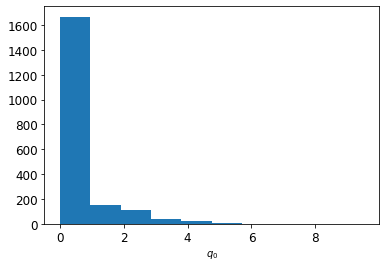

Z:0.018052124018491645
Z_std:26.63286454486443
Z_1:0.562290783584854
Z_std_1:1.050481818997367
<B> = 148002.682+/-377.4799834110413
<S> = 22.026+/-4.842140435799028
1
AUC:0.9374088843868378
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

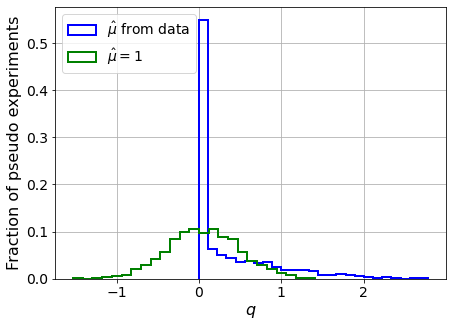

Z BL:(0.2276315506084473, 1.1313494971056732, 0.9637, 0.22856448908499125, 0.9647072302104054) with 15 bins


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  9435.05158992  9243.36399152  8989.64449571
  8670.04777178  8272.88332442  7788.90301387  7212.60626596
  6508.48101771  5663.19036448  4613.89669954  3334.66129018
  1795.21311708   -33.80262964 -2219.40838247 -5121.99120899]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  7906.04555756  7870.79197343  7776.52294203


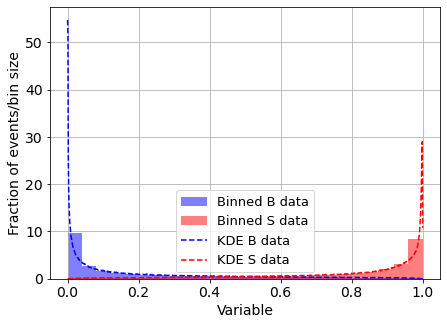

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0011635618505359071
This may take a while...
1 done
2 done
0.007870990380165187
0.007870990380165187
3 done
4 done
0.0023550631511853543
0.0023550631511853543
B_expected:  147986
S_expected:  22



  0%|                                                                 | 3/2000 [00:08<1:12:05,  2.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3106049455007423
<p_{s}(Sdata)> = 3.351869082318897
<p_{b}(Bdata)> = 9.899147183073046
<p_{s}(Bdata)> = 0.29988881792988786


  0%|▏                                                                  | 5/2000 [00:11<56:06,  1.69s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2896004325892637
<p_{s}(Sdata)> = 4.100213503441318
<p_{b}(Bdata)> = 9.883638029778076
<p_{s}(Bdata)> = 0.3023475040249771


  0%|▏                                                                | 7/2000 [00:16<1:10:24,  2.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20614507856535014
<p_{s}(Sdata)> = 5.269879837387136
<p_{b}(Bdata)> = 9.8969498493439
<p_{s}(Bdata)> = 0.3002457446865916


  0%|▎                                                                  | 8/2000 [00:17<56:05,  1.69s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22542380327500447
<p_{s}(Sdata)> = 5.405951099943814
<p_{b}(Bdata)> = 9.898326094029285
<p_{s}(Bdata)> = 0.3007750922293543


  0%|▎                                                                  | 9/2000 [00:18<46:36,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3360206106145046
<p_{s}(Sdata)> = 3.339202338233319
<p_{b}(Bdata)> = 9.903067275838271
<p_{s}(Bdata)> = 0.2980052296141897


  1%|▍                                                               | 15/2000 [00:32<1:11:27,  2.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22995001856288236
<p_{s}(Sdata)> = 2.897030296661098
<p_{b}(Bdata)> = 9.842801405413473
<p_{s}(Bdata)> = 0.30248407684332684


  1%|▌                                                                 | 16/2000 [00:33<57:31,  1.74s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4519072752379446
<p_{s}(Sdata)> = 6.492123411227376
<p_{b}(Bdata)> = 9.822900476422113
<p_{s}(Bdata)> = 0.2995727205228721


  1%|▋                                                                 | 20/2000 [00:41<58:59,  1.79s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3220912619987567
<p_{s}(Sdata)> = 2.3403702254470433
<p_{b}(Bdata)> = 9.954134831919628
<p_{s}(Bdata)> = 0.3006369651242776


  1%|▋                                                                 | 21/2000 [00:42<48:48,  1.48s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.6286829763224028
<p_{s}(Sdata)> = 5.941093413718588
<p_{b}(Bdata)> = 9.9831603840628
<p_{s}(Bdata)> = 0.29893935142089695


  1%|▋                                                                 | 22/2000 [00:42<41:38,  1.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26343519997242487
<p_{s}(Sdata)> = 6.163437967955076
<p_{b}(Bdata)> = 9.933704447653518
<p_{s}(Bdata)> = 0.2988739092494913


  1%|▊                                                                 | 25/2000 [00:48<51:47,  1.57s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28098789174864264
<p_{s}(Sdata)> = 4.231430751711576
<p_{b}(Bdata)> = 9.844876629096767
<p_{s}(Bdata)> = 0.30006798352351527


  1%|▉                                                                 | 27/2000 [00:52<57:25,  1.75s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18657621106200303
<p_{s}(Sdata)> = 6.711143076590628
<p_{b}(Bdata)> = 9.895480058881487
<p_{s}(Bdata)> = 0.30029874439437415


  1%|▉                                                                 | 28/2000 [00:53<47:44,  1.45s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2844023396616099
<p_{s}(Sdata)> = 4.347980308165264
<p_{b}(Bdata)> = 9.907586921727718
<p_{s}(Bdata)> = 0.297833123067224


  1%|▉                                                                 | 29/2000 [00:54<40:53,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21155959418803788
<p_{s}(Sdata)> = 5.143493654894995
<p_{b}(Bdata)> = 9.93061362625485
<p_{s}(Bdata)> = 0.2994025632433066


  2%|▉                                                                 | 30/2000 [00:55<36:10,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4079051740397189
<p_{s}(Sdata)> = 3.163723589283533
<p_{b}(Bdata)> = 9.87009390679375
<p_{s}(Bdata)> = 0.30057421740410245
muhat = 2.1
<p_{b}(Sdata)> = 0.24674087283583013
<p_{s}(Sdata)> = 6.0276473602274905
<p_{b}(Bdata)> = 9.86873791987126
<p_{s}(Bdata)> = 0.30431305106300427


  2%|█                                                                 | 33/2000 [01:00<50:32,  1.54s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2568493818787983
<p_{s}(Sdata)> = 6.097675764908957
<p_{b}(Bdata)> = 9.863770983239132
<p_{s}(Bdata)> = 0.30312937077166763


  2%|█                                                               | 34/2000 [01:03<1:05:20,  1.99s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2878598779186631
<p_{s}(Sdata)> = 5.468222048586828
<p_{b}(Bdata)> = 9.913935690355038
<p_{s}(Bdata)> = 0.30162605692360217


  2%|█▏                                                                | 37/2000 [01:09<59:22,  1.81s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33254274246011417
<p_{s}(Sdata)> = 3.579637583501268
<p_{b}(Bdata)> = 9.9403574132
<p_{s}(Bdata)> = 0.2995684290686494


  2%|█▎                                                                | 38/2000 [01:09<48:58,  1.50s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2987909921597157
<p_{s}(Sdata)> = 2.840503733492123
<p_{b}(Bdata)> = 9.883958518846995
<p_{s}(Bdata)> = 0.3006041508504023


  2%|█▎                                                                | 39/2000 [01:10<41:48,  1.28s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.32965361687318534
<p_{s}(Sdata)> = 3.025577111350069
<p_{b}(Bdata)> = 9.921788865626002
<p_{s}(Bdata)> = 0.2995371931726954


  2%|█▎                                                                | 40/2000 [01:11<36:51,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3718888414386129
<p_{s}(Sdata)> = 2.4400779711265335
<p_{b}(Bdata)> = 9.881806172576281
<p_{s}(Bdata)> = 0.30038996750130154


  2%|█▎                                                                | 41/2000 [01:12<33:24,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24124598629243957
<p_{s}(Sdata)> = 4.4925214612160955
<p_{b}(Bdata)> = 9.926049775095564
<p_{s}(Bdata)> = 0.29762155309665883


  2%|█▍                                                                | 43/2000 [01:14<34:14,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.31196016869610455
<p_{s}(Sdata)> = 5.1470023505135405
<p_{b}(Bdata)> = 9.907899941139805
<p_{s}(Bdata)> = 0.30170296285640247


  2%|█▍                                                                | 44/2000 [01:15<31:28,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3128003951021139
<p_{s}(Sdata)> = 3.531606923149125
<p_{b}(Bdata)> = 9.868899466132827
<p_{s}(Bdata)> = 0.30117522871688024


  2%|█▍                                                                | 45/2000 [01:16<29:40,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2433975054210033
<p_{s}(Sdata)> = 4.5442841486011085
<p_{b}(Bdata)> = 9.877754668315625
<p_{s}(Bdata)> = 0.30031866731899853


  2%|█▍                                                              | 46/2000 [01:20<1:06:23,  2.04s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2614409465870425
<p_{s}(Sdata)> = 7.2810754416677135
<p_{b}(Bdata)> = 9.951226577383096
<p_{s}(Bdata)> = 0.3026187638112194


  2%|█▋                                                                | 50/2000 [01:28<58:15,  1.79s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24095603047653483
<p_{s}(Sdata)> = 6.802356478361926
<p_{b}(Bdata)> = 9.860423752793206
<p_{s}(Bdata)> = 0.2996502381649096


  3%|█▋                                                              | 52/2000 [01:32<1:02:59,  1.94s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2899348732916047
<p_{s}(Sdata)> = 7.147461809185735
<p_{b}(Bdata)> = 9.932295093779532
<p_{s}(Bdata)> = 0.30252422967698267


  3%|█▊                                                                | 55/2000 [01:37<51:55,  1.60s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3269712993824655
<p_{s}(Sdata)> = 3.5056686047621777
<p_{b}(Bdata)> = 9.900272383778114
<p_{s}(Bdata)> = 0.2999948312453722


  3%|█▊                                                              | 57/2000 [01:42<1:00:41,  1.87s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.36115073702884154
<p_{s}(Sdata)> = 4.327072708824079
<p_{b}(Bdata)> = 9.89812336268703
<p_{s}(Bdata)> = 0.3006621240742454


  3%|█▉                                                                | 58/2000 [01:42<50:09,  1.55s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3592396543232962
<p_{s}(Sdata)> = 3.3485851032345137
<p_{b}(Bdata)> = 9.912935294662946
<p_{s}(Bdata)> = 0.30097474319754564
muhat = 2.1
<p_{b}(Sdata)> = 0.23125819875368203
<p_{s}(Sdata)> = 6.7734205155923135
<p_{b}(Bdata)> = 9.908318359279473
<p_{s}(Bdata)> = 0.3008345339131365


  3%|██                                                                | 61/2000 [01:48<58:03,  1.80s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2702783764466713
<p_{s}(Sdata)> = 6.214974839789929
<p_{b}(Bdata)> = 9.934146277365718
<p_{s}(Bdata)> = 0.300726708672008


  3%|██                                                                | 62/2000 [01:49<48:08,  1.49s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2727311867777534
<p_{s}(Sdata)> = 3.4341788612955626
<p_{b}(Bdata)> = 9.843578698500414
<p_{s}(Bdata)> = 0.30046595979866675


  3%|██                                                                | 63/2000 [01:50<41:12,  1.28s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2571562926745438
<p_{s}(Sdata)> = 4.267330445759919
<p_{b}(Bdata)> = 9.865533552847268
<p_{s}(Bdata)> = 0.30033589373038644


  3%|██                                                                | 64/2000 [01:51<36:51,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2666664951657061
<p_{s}(Sdata)> = 3.9220140303187883
<p_{b}(Bdata)> = 9.819629009468924
<p_{s}(Bdata)> = 0.2976346414085529


  3%|██▏                                                               | 67/2000 [01:58<54:04,  1.68s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2627231052532562
<p_{s}(Sdata)> = 4.093057248417293
<p_{b}(Bdata)> = 9.928398570541924
<p_{s}(Bdata)> = 0.298650405997056


  3%|██▎                                                               | 69/2000 [02:00<45:04,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4135401093350418
<p_{s}(Sdata)> = 7.086500915497399
<p_{b}(Bdata)> = 9.824367708102997
<p_{s}(Bdata)> = 0.30059427189375604


  4%|██▎                                                               | 70/2000 [02:01<37:39,  1.17s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.24419425477517623
<p_{s}(Sdata)> = 5.704346628298729
<p_{b}(Bdata)> = 9.934949311041375
<p_{s}(Bdata)> = 0.30161775522202217


  4%|██▍                                                               | 74/2000 [02:09<45:38,  1.42s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22713983322554274
<p_{s}(Sdata)> = 5.535095120273516
<p_{b}(Bdata)> = 9.879633041763716
<p_{s}(Bdata)> = 0.299696176061265


  4%|██▍                                                               | 75/2000 [02:09<36:17,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2884832022755723
<p_{s}(Sdata)> = 6.56812489561801
<p_{b}(Bdata)> = 9.917189452501697
<p_{s}(Bdata)> = 0.2991619025399645


  4%|██▌                                                               | 76/2000 [02:09<29:42,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31514784141531343
<p_{s}(Sdata)> = 6.711720738353476
<p_{b}(Bdata)> = 9.866190173074141
<p_{s}(Bdata)> = 0.29771731882116564


  4%|██▌                                                               | 77/2000 [02:10<26:52,  1.19it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2724083951170988
<p_{s}(Sdata)> = 4.8968193804566615
<p_{b}(Bdata)> = 9.890012032482922
<p_{s}(Bdata)> = 0.30283974707381167


  4%|██▌                                                               | 78/2000 [02:11<23:06,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24489901684389262
<p_{s}(Sdata)> = 3.2978571036178552
<p_{b}(Bdata)> = 9.859748304519611
<p_{s}(Bdata)> = 0.30014249188904013


  4%|██▌                                                               | 79/2000 [02:11<20:31,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.185513637561006
<p_{s}(Sdata)> = 4.513288704429491
<p_{b}(Bdata)> = 9.884794340538805
<p_{s}(Bdata)> = 0.29972234436746426


  4%|██▋                                                               | 80/2000 [02:11<18:37,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.241993459879324
<p_{s}(Sdata)> = 7.264144174268223
<p_{b}(Bdata)> = 9.847250526079938
<p_{s}(Bdata)> = 0.29988924287544727


  4%|██▋                                                               | 81/2000 [02:12<19:11,  1.67it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21424543489335818
<p_{s}(Sdata)> = 3.1748444061441545
<p_{b}(Bdata)> = 10.011652497702618
<p_{s}(Bdata)> = 0.30212442370861925


  4%|██▋                                                               | 82/2000 [02:13<17:50,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2305558448406322
<p_{s}(Sdata)> = 6.869124521641882
<p_{b}(Bdata)> = 9.967781441403211
<p_{s}(Bdata)> = 0.2999721211338618


  4%|██▋                                                               | 83/2000 [02:13<16:56,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2503828380327901
<p_{s}(Sdata)> = 4.626742669200485
<p_{b}(Bdata)> = 9.945324446179407
<p_{s}(Bdata)> = 0.3013485847504411


  4%|██▊                                                               | 84/2000 [02:13<16:11,  1.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.311764679367406
<p_{s}(Sdata)> = 3.9365930594688145
<p_{b}(Bdata)> = 9.871359555814491
<p_{s}(Bdata)> = 0.3002080654051544


  4%|██▊                                                               | 87/2000 [02:20<41:50,  1.31s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2391391414132484
<p_{s}(Sdata)> = 5.118925751597854
<p_{b}(Bdata)> = 9.862351982813347
<p_{s}(Bdata)> = 0.30181326147674353


  4%|██▉                                                               | 90/2000 [02:24<39:29,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3367136682441706
<p_{s}(Sdata)> = 4.5463965902082295
<p_{b}(Bdata)> = 9.928071026757836
<p_{s}(Bdata)> = 0.3005294113921179


  5%|███                                                               | 91/2000 [02:25<31:54,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.15380289587808224
<p_{s}(Sdata)> = 9.077533154682895
<p_{b}(Bdata)> = 9.880145976613306
<p_{s}(Bdata)> = 0.29874250118076384


  5%|███                                                               | 93/2000 [02:28<40:27,  1.27s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2712091033524364
<p_{s}(Sdata)> = 5.3833876908225875
<p_{b}(Bdata)> = 9.919588278969895
<p_{s}(Bdata)> = 0.2967653390646273


  5%|███▏                                                              | 95/2000 [02:30<32:47,  1.03s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2939175056457317
<p_{s}(Sdata)> = 2.089445876520283
<p_{b}(Bdata)> = 9.903864776886024
<p_{s}(Bdata)> = 0.3006948000362158


  5%|███▏                                                              | 96/2000 [02:30<27:17,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3457992250560733
<p_{s}(Sdata)> = 6.7750072347989665
<p_{b}(Bdata)> = 9.987672984057655
<p_{s}(Bdata)> = 0.3000069604390599


  5%|███▎                                                              | 99/2000 [02:37<53:27,  1.69s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.32488817663705216
<p_{s}(Sdata)> = 6.384306928748095
<p_{b}(Bdata)> = 9.923184965647978
<p_{s}(Bdata)> = 0.30298502726161475


  5%|███▍                                                             | 106/2000 [02:48<37:22,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24342601374487477
<p_{s}(Sdata)> = 7.270395662274287
<p_{b}(Bdata)> = 9.868687583887894
<p_{s}(Bdata)> = 0.30016883114470966


  5%|███▍                                                             | 107/2000 [02:48<30:14,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2696225359892254
<p_{s}(Sdata)> = 3.333360405184302
<p_{b}(Bdata)> = 9.866397313559517
<p_{s}(Bdata)> = 0.30020488752776936


  5%|███▌                                                             | 109/2000 [02:51<36:08,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22823108014927657
<p_{s}(Sdata)> = 5.796396761270149
<p_{b}(Bdata)> = 9.809184824539253
<p_{s}(Bdata)> = 0.3007168246839903


  6%|███▌                                                             | 110/2000 [02:52<31:07,  1.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2300017213486649
<p_{s}(Sdata)> = 7.151483695472365
<p_{b}(Bdata)> = 9.831589238376127
<p_{s}(Bdata)> = 0.30509577868962207


  6%|███▌                                                             | 111/2000 [02:52<27:31,  1.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2081820441737689
<p_{s}(Sdata)> = 8.177897209960795
<p_{b}(Bdata)> = 9.81008299510134
<p_{s}(Bdata)> = 0.3027197504648677


  6%|███▋                                                             | 112/2000 [02:53<25:04,  1.26it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3098924374033011
<p_{s}(Sdata)> = 7.036950370189467
<p_{b}(Bdata)> = 9.888114572703289
<p_{s}(Bdata)> = 0.3015285645986915


  6%|███▋                                                             | 114/2000 [02:55<28:32,  1.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22519409997105158
<p_{s}(Sdata)> = 3.8820091078717214
<p_{b}(Bdata)> = 9.908263473073243
<p_{s}(Bdata)> = 0.30385400561208403


  6%|███▋                                                             | 115/2000 [02:56<24:04,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.279074916581546
<p_{s}(Sdata)> = 2.497338827368133
<p_{b}(Bdata)> = 9.922488250891641
<p_{s}(Bdata)> = 0.29907338389686766


  6%|███▊                                                             | 116/2000 [02:56<20:57,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19803630006834927
<p_{s}(Sdata)> = 6.924824531622754
<p_{b}(Bdata)> = 9.85452612249396
<p_{s}(Bdata)> = 0.2999113152291063


  6%|███▊                                                             | 119/2000 [03:02<44:49,  1.43s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.31158638238921826
<p_{s}(Sdata)> = 2.6707682675633446
<p_{b}(Bdata)> = 9.931555878891539
<p_{s}(Bdata)> = 0.2974295783244606


  6%|███▉                                                             | 122/2000 [03:08<47:19,  1.51s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22491149303351562
<p_{s}(Sdata)> = 5.257521606043378
<p_{b}(Bdata)> = 9.989552698603639
<p_{s}(Bdata)> = 0.2994880419011351


  6%|███▉                                                             | 123/2000 [03:08<37:12,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24171732136159102
<p_{s}(Sdata)> = 3.8348333097793477
<p_{b}(Bdata)> = 9.877249560011041
<p_{s}(Bdata)> = 0.300033968725209


  6%|████▏                                                            | 127/2000 [03:14<41:31,  1.33s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.12938269484423662
<p_{s}(Sdata)> = 12.189148824098126
<p_{b}(Bdata)> = 9.883372749210942
<p_{s}(Bdata)> = 0.30044656437965644


  6%|████▏                                                            | 129/2000 [03:16<32:42,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3159002476093805
<p_{s}(Sdata)> = 6.0530865790959485
<p_{b}(Bdata)> = 9.860708064979208
<p_{s}(Bdata)> = 0.30163471986818946


  7%|████▎                                                            | 131/2000 [03:18<34:30,  1.11s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19481266343028059
<p_{s}(Sdata)> = 5.812532270445679
<p_{b}(Bdata)> = 9.883856564296641
<p_{s}(Bdata)> = 0.3007839652842891


  7%|████▎                                                            | 132/2000 [03:19<28:14,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23976492942988495
<p_{s}(Sdata)> = 5.799324716964919
<p_{b}(Bdata)> = 9.873801848246416
<p_{s}(Bdata)> = 0.30108303937440023


  7%|████▎                                                            | 133/2000 [03:19<23:54,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29202264624815505
<p_{s}(Sdata)> = 4.83295841394095
<p_{b}(Bdata)> = 9.784830703961568
<p_{s}(Bdata)> = 0.2999335088819337


  7%|████▎                                                            | 134/2000 [03:20<20:43,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2481505954881467
<p_{s}(Sdata)> = 4.269385453067646
<p_{b}(Bdata)> = 9.973196009273611
<p_{s}(Bdata)> = 0.29909696472521063


  7%|████▍                                                            | 135/2000 [03:20<18:43,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34531451073401714
<p_{s}(Sdata)> = 6.05276451069057
<p_{b}(Bdata)> = 9.916845371067147
<p_{s}(Bdata)> = 0.300943898974554


  7%|████▌                                                            | 139/2000 [03:27<38:55,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.379001904506112
<p_{s}(Sdata)> = 3.775967123855148
<p_{b}(Bdata)> = 9.926923701755582
<p_{s}(Bdata)> = 0.30108140702079844


  7%|████▌                                                            | 141/2000 [03:30<35:33,  1.15s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.22916879663551243
<p_{s}(Sdata)> = 8.109187581397519
<p_{b}(Bdata)> = 9.845019560601608
<p_{s}(Bdata)> = 0.3031366302248679


  7%|████▋                                                            | 143/2000 [03:33<42:39,  1.38s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3106680981753021
<p_{s}(Sdata)> = 3.2339009246217456
<p_{b}(Bdata)> = 9.88699751947632
<p_{s}(Bdata)> = 0.3011738889497437


  7%|████▋                                                            | 145/2000 [03:36<40:01,  1.29s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3035508808877775
<p_{s}(Sdata)> = 3.9822707286240857
<p_{b}(Bdata)> = 9.945653122669329
<p_{s}(Bdata)> = 0.301806640126878


  7%|████▋                                                            | 146/2000 [03:36<32:03,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.16427322884292622
<p_{s}(Sdata)> = 8.046550295484336
<p_{b}(Bdata)> = 9.87979337986815
<p_{s}(Bdata)> = 0.30028681019692943


  7%|████▊                                                            | 147/2000 [03:37<26:31,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2817240737407835
<p_{s}(Sdata)> = 2.9908467924102933
<p_{b}(Bdata)> = 9.939077810435194
<p_{s}(Bdata)> = 0.3020068476808791


  7%|████▊                                                            | 149/2000 [03:39<31:23,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2906811340453286
<p_{s}(Sdata)> = 3.769012909184295
<p_{b}(Bdata)> = 9.900351080617826
<p_{s}(Bdata)> = 0.29932306833782024


  8%|████▉                                                            | 150/2000 [03:40<26:03,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2531753830887698
<p_{s}(Sdata)> = 4.956192315988881
<p_{b}(Bdata)> = 9.885590077318183
<p_{s}(Bdata)> = 0.30092180768946764


  8%|████▉                                                            | 151/2000 [03:41<24:00,  1.28it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20834981301252337
<p_{s}(Sdata)> = 7.694479603525776
<p_{b}(Bdata)> = 9.847952049120273
<p_{s}(Bdata)> = 0.3014618731966318


  8%|████▉                                                            | 153/2000 [03:43<30:56,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3538589507488067
<p_{s}(Sdata)> = 4.742722498076479
<p_{b}(Bdata)> = 9.976922729995417
<p_{s}(Bdata)> = 0.29732509403442053


  8%|█████                                                            | 154/2000 [03:44<25:37,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3525857511244263
<p_{s}(Sdata)> = 3.80958481288906
<p_{b}(Bdata)> = 9.861277162947642
<p_{s}(Bdata)> = 0.2993230675523336


  8%|█████                                                            | 155/2000 [03:44<21:52,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31632068461740986
<p_{s}(Sdata)> = 4.069356728911361
<p_{b}(Bdata)> = 9.921345857533662
<p_{s}(Bdata)> = 0.30157932115826974


  8%|█████▏                                                           | 161/2000 [03:58<53:46,  1.75s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27096821672950244
<p_{s}(Sdata)> = 3.625014558079749
<p_{b}(Bdata)> = 9.89060963441165
<p_{s}(Bdata)> = 0.30071064767697864


  8%|█████▎                                                           | 164/2000 [04:03<50:24,  1.65s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23935045908083838
<p_{s}(Sdata)> = 6.212987445294457
<p_{b}(Bdata)> = 9.904954248581399
<p_{s}(Bdata)> = 0.29829349973543656


  8%|█████▎                                                           | 165/2000 [04:04<39:18,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.6455015434041192
<p_{s}(Sdata)> = 7.1719558016043825
<p_{b}(Bdata)> = 9.940701778219008
<p_{s}(Bdata)> = 0.30098180176655487


  8%|█████▍                                                           | 166/2000 [04:04<31:34,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3085599083377651
<p_{s}(Sdata)> = 4.9531662189351575
<p_{b}(Bdata)> = 9.829990306108362
<p_{s}(Bdata)> = 0.298522004356336


  8%|█████▍                                                           | 167/2000 [04:05<26:11,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19983990567645413
<p_{s}(Sdata)> = 7.4704942317561995
<p_{b}(Bdata)> = 9.974501558258282
<p_{s}(Bdata)> = 0.3010108020569752


  8%|█████▍                                                           | 169/2000 [04:09<39:19,  1.29s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2715876415451606
<p_{s}(Sdata)> = 7.18313081071076
<p_{b}(Bdata)> = 9.87411773291295
<p_{s}(Bdata)> = 0.3044389057580695


  8%|█████▌                                                           | 170/2000 [04:09<33:11,  1.09s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2442077708365182
<p_{s}(Sdata)> = 3.467038507759359
<p_{b}(Bdata)> = 9.886776192833612
<p_{s}(Bdata)> = 0.30371561262527935


  9%|█████▌                                                           | 172/2000 [04:12<37:17,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3103769005458231
<p_{s}(Sdata)> = 3.3302419479649155
<p_{b}(Bdata)> = 9.899671387609345
<p_{s}(Bdata)> = 0.29837041905465606


  9%|█████▌                                                           | 173/2000 [04:13<30:02,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5713428958113795
<p_{s}(Sdata)> = 2.8410681103712645
<p_{b}(Bdata)> = 9.956994557529413
<p_{s}(Bdata)> = 0.2988539220514514


  9%|█████▋                                                           | 176/2000 [04:17<35:35,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33156512633728874
<p_{s}(Sdata)> = 2.9872855053560845
<p_{b}(Bdata)> = 9.8528159843783
<p_{s}(Bdata)> = 0.2996056010923649


  9%|█████▊                                                           | 177/2000 [04:17<28:49,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37717989640494615
<p_{s}(Sdata)> = 4.883533641252865
<p_{b}(Bdata)> = 9.86401345896925
<p_{s}(Bdata)> = 0.3026491960270807


  9%|█████▉                                                           | 181/2000 [04:24<37:27,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2235913276565595
<p_{s}(Sdata)> = 4.904411286463411
<p_{b}(Bdata)> = 9.905968872785484
<p_{s}(Bdata)> = 0.3015469986348924


  9%|█████▉                                                           | 182/2000 [04:25<31:49,  1.05s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.5828011497925277
<p_{s}(Sdata)> = 3.721834201346276
<p_{b}(Bdata)> = 9.89240454539664
<p_{s}(Bdata)> = 0.3023565502965673


  9%|█████▉                                                           | 183/2000 [04:25<26:10,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16165352565337338
<p_{s}(Sdata)> = 8.935005335631708
<p_{b}(Bdata)> = 9.87479326574546
<p_{s}(Bdata)> = 0.2999350937652542


  9%|██████                                                           | 185/2000 [04:29<39:25,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26700550100888043
<p_{s}(Sdata)> = 3.9128280095739774
<p_{b}(Bdata)> = 9.82408766493811
<p_{s}(Bdata)> = 0.2991042716900605


  9%|██████                                                           | 188/2000 [04:34<41:51,  1.39s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2975567950235239
<p_{s}(Sdata)> = 4.720016480323812
<p_{b}(Bdata)> = 9.851219915376577
<p_{s}(Bdata)> = 0.2997262906478624


  9%|██████▏                                                          | 189/2000 [04:34<33:11,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4209839122556068
<p_{s}(Sdata)> = 5.205315318106859
<p_{b}(Bdata)> = 9.890481588390871
<p_{s}(Bdata)> = 0.2987418459857478


 10%|██████▏                                                          | 191/2000 [04:36<29:56,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2931597912950461
<p_{s}(Sdata)> = 4.881458985686966
<p_{b}(Bdata)> = 9.898146959775445
<p_{s}(Bdata)> = 0.2997269603902438


 10%|██████▏                                                          | 192/2000 [04:37<24:58,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48415161808743534
<p_{s}(Sdata)> = 5.066666312507459
<p_{b}(Bdata)> = 9.90623517878781
<p_{s}(Bdata)> = 0.29980976096016515


 10%|██████▎                                                          | 194/2000 [04:40<33:43,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22869173327942663
<p_{s}(Sdata)> = 4.115608534101895
<p_{b}(Bdata)> = 9.925137806812316
<p_{s}(Bdata)> = 0.300623036941023


 10%|██████▎                                                          | 196/2000 [04:44<43:03,  1.43s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.24967669672450135
<p_{s}(Sdata)> = 4.671631995894797
<p_{b}(Bdata)> = 9.846567331612135
<p_{s}(Bdata)> = 0.3047357267130718


 10%|██████▍                                                          | 197/2000 [04:44<34:07,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4645099886107058
<p_{s}(Sdata)> = 2.7827344910377283
<p_{b}(Bdata)> = 9.894280099887252
<p_{s}(Bdata)> = 0.30093913341669726


 10%|██████▍                                                          | 198/2000 [04:45<29:27,  1.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.41450208037973835
<p_{s}(Sdata)> = 6.089421417010301
<p_{b}(Bdata)> = 9.839478838395056
<p_{s}(Bdata)> = 0.30368093118879896


 10%|██████▍                                                          | 199/2000 [04:46<24:35,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25373556366526084
<p_{s}(Sdata)> = 9.136549119100469
<p_{b}(Bdata)> = 9.900313589868764
<p_{s}(Bdata)> = 0.30018159499823516


 10%|██████▌                                                          | 200/2000 [04:46<22:48,  1.32it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15977448581975656
<p_{s}(Sdata)> = 7.0866690742415255
<p_{b}(Bdata)> = 10.007827104529463
<p_{s}(Bdata)> = 0.3022320786065596


 10%|██████▌                                                          | 201/2000 [04:47<19:52,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3160088120397283
<p_{s}(Sdata)> = 4.783745146035297
<p_{b}(Bdata)> = 9.966359346028455
<p_{s}(Bdata)> = 0.29871873852258357


 10%|██████▌                                                          | 202/2000 [04:47<17:49,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28695398934574334
<p_{s}(Sdata)> = 4.664194499573831
<p_{b}(Bdata)> = 9.87776070987295
<p_{s}(Bdata)> = 0.2981482158289106


 10%|██████▋                                                          | 206/2000 [04:51<26:56,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22166685918680695
<p_{s}(Sdata)> = 4.919417327213104
<p_{b}(Bdata)> = 9.862489562313094
<p_{s}(Bdata)> = 0.3020807538218978


 10%|██████▋                                                          | 207/2000 [04:52<22:43,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4523746057643668
<p_{s}(Sdata)> = 3.3969534675514095
<p_{b}(Bdata)> = 9.89957230263983
<p_{s}(Bdata)> = 0.3022635930483239


 11%|██████▊                                                          | 211/2000 [04:58<36:19,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18135224161999117
<p_{s}(Sdata)> = 6.682785047787806
<p_{b}(Bdata)> = 9.923944624215546
<p_{s}(Bdata)> = 0.29959040158518024


 11%|██████▉                                                          | 212/2000 [04:59<29:23,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18695447005153198
<p_{s}(Sdata)> = 4.345567678743354
<p_{b}(Bdata)> = 9.886890894623347
<p_{s}(Bdata)> = 0.3004719676109617


 11%|██████▉                                                          | 213/2000 [04:59<24:38,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2768841778649531
<p_{s}(Sdata)> = 3.402340866041926
<p_{b}(Bdata)> = 9.83677611900753
<p_{s}(Bdata)> = 0.30156077428490435


 11%|██████▉                                                          | 214/2000 [05:00<22:48,  1.30it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20494337671121676
<p_{s}(Sdata)> = 5.686041467260615
<p_{b}(Bdata)> = 9.838715500721928
<p_{s}(Bdata)> = 0.30357938486248515


 11%|███████                                                          | 217/2000 [05:04<34:37,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17153827028669041
<p_{s}(Sdata)> = 7.1064575781300565
<p_{b}(Bdata)> = 9.925548117999211
<p_{s}(Bdata)> = 0.2978382068895655


 11%|███████                                                          | 218/2000 [05:05<28:06,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43774499092964153
<p_{s}(Sdata)> = 5.085244465087756
<p_{b}(Bdata)> = 9.897337324239192
<p_{s}(Bdata)> = 0.3008770840998937


 11%|███████▏                                                         | 222/2000 [05:09<27:14,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2456821757835055
<p_{s}(Sdata)> = 7.341582590584104
<p_{b}(Bdata)> = 9.82550508157817
<p_{s}(Bdata)> = 0.30113726704407906


 11%|███████▎                                                         | 226/2000 [05:16<43:15,  1.46s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22484152631022392
<p_{s}(Sdata)> = 8.001498210586941
<p_{b}(Bdata)> = 9.884449940514983
<p_{s}(Bdata)> = 0.30003102836201817


 11%|███████▍                                                         | 227/2000 [05:17<34:12,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.42361049951368474
<p_{s}(Sdata)> = 5.029055095623399
<p_{b}(Bdata)> = 10.001255086796062
<p_{s}(Bdata)> = 0.2994730951282456


 11%|███████▍                                                         | 228/2000 [05:17<27:46,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28713293158300646
<p_{s}(Sdata)> = 6.628203546931323
<p_{b}(Bdata)> = 9.877545043746641
<p_{s}(Bdata)> = 0.30105333232577197


 12%|███████▍                                                         | 230/2000 [05:19<25:47,  1.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.47010947640091677
<p_{s}(Sdata)> = 9.889091720748018
<p_{b}(Bdata)> = 9.85300402624551
<p_{s}(Bdata)> = 0.30250392769550044


 12%|███████▌                                                         | 231/2000 [05:19<23:29,  1.26it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20410248370971476
<p_{s}(Sdata)> = 6.74761439133189
<p_{b}(Bdata)> = 9.904957441949849
<p_{s}(Bdata)> = 0.3015850136367627


 12%|███████▌                                                         | 232/2000 [05:20<21:48,  1.35it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23331801710524808
<p_{s}(Sdata)> = 4.268401043868255
<p_{b}(Bdata)> = 9.846233577782767
<p_{s}(Bdata)> = 0.30388940129980646


 12%|███████▊                                                         | 242/2000 [05:41<47:15,  1.61s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.43873623836805137
<p_{s}(Sdata)> = 6.298303448343353
<p_{b}(Bdata)> = 9.923775617917748
<p_{s}(Bdata)> = 0.30036125363982064


 12%|███████▉                                                         | 243/2000 [05:41<36:54,  1.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2967089130822278
<p_{s}(Sdata)> = 4.41592472311043
<p_{b}(Bdata)> = 9.93602802458926
<p_{s}(Bdata)> = 0.3008339890073414


 12%|███████▉                                                         | 246/2000 [05:45<33:30,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27686820060393386
<p_{s}(Sdata)> = 3.2833504185740354
<p_{b}(Bdata)> = 9.872431094351791
<p_{s}(Bdata)> = 0.301651975170644


 12%|████████                                                         | 247/2000 [05:45<27:14,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18945081225057292
<p_{s}(Sdata)> = 5.733797010913676
<p_{b}(Bdata)> = 9.77735494682352
<p_{s}(Bdata)> = 0.3011884850288231


 12%|████████▏                                                        | 250/2000 [05:51<39:58,  1.37s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.442221933546751
<p_{s}(Sdata)> = 2.078168294074386
<p_{b}(Bdata)> = 9.879272974115878
<p_{s}(Bdata)> = 0.30068745323833584


 13%|████████▏                                                        | 251/2000 [05:51<31:49,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24003067724880972
<p_{s}(Sdata)> = 6.765698717448656
<p_{b}(Bdata)> = 9.854238567628462
<p_{s}(Bdata)> = 0.3008060492706829


 13%|████████▏                                                        | 252/2000 [05:52<26:04,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3214427933543544
<p_{s}(Sdata)> = 5.480423534495785
<p_{b}(Bdata)> = 9.877531296339882
<p_{s}(Bdata)> = 0.29998167934766934


 13%|████████▏                                                        | 253/2000 [05:52<22:03,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.316997439072268
<p_{s}(Sdata)> = 5.2724354036460594
<p_{b}(Bdata)> = 9.864953683834889
<p_{s}(Bdata)> = 0.2973616852734285


 13%|████████▎                                                        | 255/2000 [05:56<36:43,  1.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22722305506565837
<p_{s}(Sdata)> = 5.094163944432374
<p_{b}(Bdata)> = 9.843590858203045
<p_{s}(Bdata)> = 0.3005205608718695


 13%|████████▎                                                        | 256/2000 [05:57<29:36,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.43466189627409385
<p_{s}(Sdata)> = 3.5905803911357803
<p_{b}(Bdata)> = 9.91777328942866
<p_{s}(Bdata)> = 0.29772266693382243


 13%|████████▍                                                        | 258/2000 [06:00<37:43,  1.30s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2802365006103917
<p_{s}(Sdata)> = 4.890195431123953
<p_{b}(Bdata)> = 9.917587679100993
<p_{s}(Bdata)> = 0.30452642077636394


 13%|████████▍                                                        | 261/2000 [06:05<39:41,  1.37s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27891988398812606
<p_{s}(Sdata)> = 3.6986516726759953
<p_{b}(Bdata)> = 9.811166038589633
<p_{s}(Bdata)> = 0.3008895599665889


 13%|████████▌                                                        | 263/2000 [06:08<40:35,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2517546753418212
<p_{s}(Sdata)> = 4.318945717323152
<p_{b}(Bdata)> = 9.873754686678922
<p_{s}(Bdata)> = 0.3005741467827953


 13%|████████▌                                                        | 264/2000 [06:09<32:09,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3031094732799
<p_{s}(Sdata)> = 3.48223155501585
<p_{b}(Bdata)> = 9.991237185099248
<p_{s}(Bdata)> = 0.2986038443845871


 13%|████████▌                                                        | 265/2000 [06:09<27:49,  1.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4531114027686927
<p_{s}(Sdata)> = 2.648973641751261
<p_{b}(Bdata)> = 9.84910110682267
<p_{s}(Bdata)> = 0.3034202227290277


 13%|████████▋                                                        | 266/2000 [06:10<24:49,  1.16it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2647067469738272
<p_{s}(Sdata)> = 4.855250103376918
<p_{b}(Bdata)> = 9.903823429568224
<p_{s}(Bdata)> = 0.30562782147838585


 13%|████████▋                                                        | 268/2000 [06:13<32:58,  1.14s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3038218964451095
<p_{s}(Sdata)> = 3.212670954083326
<p_{b}(Bdata)> = 9.91941012003952
<p_{s}(Bdata)> = 0.30290704084038905


 14%|████████▊                                                        | 270/2000 [06:17<41:44,  1.45s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3466333147140418
<p_{s}(Sdata)> = 3.662134538904349
<p_{b}(Bdata)> = 9.849217787117123
<p_{s}(Bdata)> = 0.30183662214718726


 14%|████████▊                                                        | 272/2000 [06:21<46:33,  1.62s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21564852221565609
<p_{s}(Sdata)> = 4.754733706143688
<p_{b}(Bdata)> = 9.883411457145913
<p_{s}(Bdata)> = 0.30067499279220694


 14%|████████▊                                                        | 273/2000 [06:22<36:27,  1.27s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3886328987606093
<p_{s}(Sdata)> = 3.2048747917326867
<p_{b}(Bdata)> = 9.836260743242471
<p_{s}(Bdata)> = 0.3035052226508547


 14%|████████▉                                                        | 275/2000 [06:25<40:07,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3971192473655251
<p_{s}(Sdata)> = 6.063318336890018
<p_{b}(Bdata)> = 9.911127453938848
<p_{s}(Bdata)> = 0.300963105538576


 14%|█████████                                                        | 279/2000 [06:30<30:05,  1.05s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.30249655037252154
<p_{s}(Sdata)> = 4.300292890955756
<p_{b}(Bdata)> = 9.776225330707316
<p_{s}(Bdata)> = 0.30463131400081467


 14%|█████████▏                                                       | 281/2000 [06:33<39:06,  1.36s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3421719986930669
<p_{s}(Sdata)> = 3.908992611321482
<p_{b}(Bdata)> = 9.897863106140345
<p_{s}(Bdata)> = 0.30120395843085


 14%|█████████▏                                                       | 284/2000 [06:37<35:28,  1.24s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3349138521942772
<p_{s}(Sdata)> = 7.784232104695394
<p_{b}(Bdata)> = 9.950119646384012
<p_{s}(Bdata)> = 0.2996308558908373


 14%|█████████▎                                                       | 285/2000 [06:38<28:32,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2792982864365932
<p_{s}(Sdata)> = 2.997835675032346
<p_{b}(Bdata)> = 9.910885195164047
<p_{s}(Bdata)> = 0.299919412438773


 14%|█████████▎                                                       | 287/2000 [06:41<35:15,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.552004573335791
<p_{s}(Sdata)> = 3.9253951917252348
<p_{b}(Bdata)> = 9.924693167675185
<p_{s}(Bdata)> = 0.2992256367480744


 14%|█████████▎                                                       | 288/2000 [06:41<28:21,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32381645327500064
<p_{s}(Sdata)> = 6.890821164792945
<p_{b}(Bdata)> = 9.92092696042542
<p_{s}(Bdata)> = 0.29807033632370766


 14%|█████████▍                                                       | 290/2000 [06:45<34:03,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28608179575218107
<p_{s}(Sdata)> = 3.9991310360988472
<p_{b}(Bdata)> = 9.781888187721615
<p_{s}(Bdata)> = 0.29999462700730534


 15%|█████████▍                                                       | 291/2000 [06:45<27:31,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2724321079972959
<p_{s}(Sdata)> = 4.598742091340451
<p_{b}(Bdata)> = 9.884704667057838
<p_{s}(Bdata)> = 0.300828743541982


 15%|█████████▍                                                       | 292/2000 [06:46<22:57,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24162555159560328
<p_{s}(Sdata)> = 4.464321227798518
<p_{b}(Bdata)> = 9.861818089291633
<p_{s}(Bdata)> = 0.29963317560306135


 15%|█████████▌                                                       | 294/2000 [06:47<20:33,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3472687543490677
<p_{s}(Sdata)> = 4.8208820531947065
<p_{b}(Bdata)> = 9.835562099590335
<p_{s}(Bdata)> = 0.30404251568281326


 15%|█████████▋                                                       | 297/2000 [06:50<22:10,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24569620264510147
<p_{s}(Sdata)> = 6.951616944189601
<p_{b}(Bdata)> = 9.858796258310226
<p_{s}(Bdata)> = 0.29938647077438557


 15%|█████████▋                                                       | 298/2000 [06:50<20:46,  1.37it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.31990966540986204
<p_{s}(Sdata)> = 4.843076292245274
<p_{b}(Bdata)> = 9.788054601524145
<p_{s}(Bdata)> = 0.30331893452857234


 15%|█████████▋                                                       | 299/2000 [06:51<18:15,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22640106554241093
<p_{s}(Sdata)> = 5.6424358515769875
<p_{b}(Bdata)> = 9.926186205072929
<p_{s}(Bdata)> = 0.3004854591579635


 15%|█████████▊                                                       | 300/2000 [06:51<16:25,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3227875731121821
<p_{s}(Sdata)> = 5.691138702599599
<p_{b}(Bdata)> = 9.875707855696279
<p_{s}(Bdata)> = 0.301997834373434


 15%|█████████▊                                                       | 301/2000 [06:52<15:08,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2654558465255721
<p_{s}(Sdata)> = 7.913758539450898
<p_{b}(Bdata)> = 9.955654292604818
<p_{s}(Bdata)> = 0.2982379909244889


 15%|█████████▊                                                       | 303/2000 [06:54<26:02,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37057082197224034
<p_{s}(Sdata)> = 3.5459580185754143
<p_{b}(Bdata)> = 9.987359247487252
<p_{s}(Bdata)> = 0.2993051000349329


 15%|█████████▉                                                       | 305/2000 [06:56<23:55,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5670880133703463
<p_{s}(Sdata)> = 4.461523174971299
<p_{b}(Bdata)> = 9.858249690805732
<p_{s}(Bdata)> = 0.2985591629581434


 15%|█████████▉                                                       | 306/2000 [06:57<20:26,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2667877031709499
<p_{s}(Sdata)> = 6.099270075680489
<p_{b}(Bdata)> = 9.88916820189727
<p_{s}(Bdata)> = 0.30038011096061573


 15%|█████████▉                                                       | 307/2000 [06:57<18:04,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21809545089471882
<p_{s}(Sdata)> = 7.679517471662462
<p_{b}(Bdata)> = 9.791508931971897
<p_{s}(Bdata)> = 0.3021146834345719


 15%|██████████                                                       | 308/2000 [06:58<16:18,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19330340776250507
<p_{s}(Sdata)> = 5.904788658538979
<p_{b}(Bdata)> = 9.870206819221774
<p_{s}(Bdata)> = 0.3004465470681011


 16%|██████████▏                                                      | 313/2000 [07:05<34:38,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.6684573857043469
<p_{s}(Sdata)> = 2.3321618217785036
<p_{b}(Bdata)> = 9.88384136872566
<p_{s}(Bdata)> = 0.2998609860399002


 16%|██████████▏                                                      | 314/2000 [07:06<27:55,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2857356707045837
<p_{s}(Sdata)> = 6.2240647412897285
<p_{b}(Bdata)> = 9.835318459083263
<p_{s}(Bdata)> = 0.29920673180897744


 16%|██████████▏                                                      | 315/2000 [07:06<23:23,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23814345400137185
<p_{s}(Sdata)> = 4.2953402335314514
<p_{b}(Bdata)> = 9.941337984689442
<p_{s}(Bdata)> = 0.29591294175273347


 16%|██████████▎                                                      | 316/2000 [07:07<21:46,  1.29it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3261691384075293
<p_{s}(Sdata)> = 5.011831616443287
<p_{b}(Bdata)> = 9.891198473351979
<p_{s}(Bdata)> = 0.3034862935481249


 16%|██████████▎                                                      | 317/2000 [07:08<20:35,  1.36it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2942020441896764
<p_{s}(Sdata)> = 4.889313435967629
<p_{b}(Bdata)> = 9.85077440921701
<p_{s}(Bdata)> = 0.30175591005643176


 16%|██████████▎                                                      | 318/2000 [07:08<18:14,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40023724665079935
<p_{s}(Sdata)> = 6.726441247356968
<p_{b}(Bdata)> = 9.907346956449324
<p_{s}(Bdata)> = 0.2992770458684829


 16%|██████████▎                                                      | 319/2000 [07:09<16:26,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25412809164994954
<p_{s}(Sdata)> = 6.670740024609058
<p_{b}(Bdata)> = 9.858436851607237
<p_{s}(Bdata)> = 0.2998154991490732


 16%|██████████▍                                                      | 321/2000 [07:11<24:58,  1.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.268211523018584
<p_{s}(Sdata)> = 5.040864994944239
<p_{b}(Bdata)> = 9.872991962308912
<p_{s}(Bdata)> = 0.30168554304655204


 16%|██████████▍                                                      | 322/2000 [07:12<21:22,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4401647913797959
<p_{s}(Sdata)> = 3.6635873617670023
<p_{b}(Bdata)> = 9.873415540322474
<p_{s}(Bdata)> = 0.3005213618519337


 16%|██████████▍                                                      | 323/2000 [07:12<18:43,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2774311667393362
<p_{s}(Sdata)> = 4.283348452995443
<p_{b}(Bdata)> = 9.881185878523658
<p_{s}(Bdata)> = 0.29914223391810296


 16%|██████████▋                                                      | 327/2000 [07:19<36:53,  1.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2732261726474345
<p_{s}(Sdata)> = 3.899284147770901
<p_{b}(Bdata)> = 9.936987832961963
<p_{s}(Bdata)> = 0.30060538389659125


 16%|██████████▋                                                      | 329/2000 [07:22<39:04,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.6420459868838398
<p_{s}(Sdata)> = 2.496893326593901
<p_{b}(Bdata)> = 9.90740200381402
<p_{s}(Bdata)> = 0.3003688471936971


 16%|██████████▋                                                      | 330/2000 [07:23<32:26,  1.17s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3437143334129701
<p_{s}(Sdata)> = 4.956384636967281
<p_{b}(Bdata)> = 9.80518045892127
<p_{s}(Bdata)> = 0.30413680361396794


 17%|██████████▊                                                      | 331/2000 [07:23<26:20,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2537754402392373
<p_{s}(Sdata)> = 3.041158221501159
<p_{b}(Bdata)> = 9.88963832151801
<p_{s}(Bdata)> = 0.30093268534111245


 17%|██████████▊                                                      | 334/2000 [07:30<45:21,  1.63s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33475214470870146
<p_{s}(Sdata)> = 5.388999816767321
<p_{b}(Bdata)> = 9.909419156068589
<p_{s}(Bdata)> = 0.30180261968636063


 17%|██████████▉                                                      | 337/2000 [07:36<47:50,  1.73s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2831489460894605
<p_{s}(Sdata)> = 3.213337002762181
<p_{b}(Bdata)> = 9.987385885989571
<p_{s}(Bdata)> = 0.29974314568159194


 17%|███████████                                                      | 341/2000 [07:42<38:41,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2798542584827593
<p_{s}(Sdata)> = 4.61322974520168
<p_{b}(Bdata)> = 9.941063390262128
<p_{s}(Bdata)> = 0.29954899657411077


 17%|███████████                                                      | 342/2000 [07:42<30:42,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2130872711609944
<p_{s}(Sdata)> = 7.049173435018102
<p_{b}(Bdata)> = 10.008139899023508
<p_{s}(Bdata)> = 0.2975639287242032


 17%|███████████▏                                                     | 343/2000 [07:43<25:15,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7761014480200797
<p_{s}(Sdata)> = 2.7037850234937784
<p_{b}(Bdata)> = 9.870326233184615
<p_{s}(Bdata)> = 0.2998912163867604


 17%|███████████▏                                                     | 344/2000 [07:44<22:42,  1.22it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2651584830188237
<p_{s}(Sdata)> = 5.4500930275684665
<p_{b}(Bdata)> = 9.868221331870796
<p_{s}(Bdata)> = 0.3009756444873826


 17%|███████████▏                                                     | 345/2000 [07:44<19:36,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2626527893104254
<p_{s}(Sdata)> = 6.156921604370141
<p_{b}(Bdata)> = 9.926715528368087
<p_{s}(Bdata)> = 0.3009067388044412


 17%|███████████▎                                                     | 347/2000 [07:45<17:46,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20545687740320603
<p_{s}(Sdata)> = 6.170325702060437
<p_{b}(Bdata)> = 9.892753578920965
<p_{s}(Bdata)> = 0.3007575146288545


 17%|███████████▎                                                     | 348/2000 [07:46<17:31,  1.57it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5861008068187561
<p_{s}(Sdata)> = 4.605179115211923
<p_{b}(Bdata)> = 9.84363297171581
<p_{s}(Bdata)> = 0.3011094890686741


 18%|███████████▍                                                     | 350/2000 [07:50<33:32,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2855167090758076
<p_{s}(Sdata)> = 6.39949545216623
<p_{b}(Bdata)> = 9.845196328384294
<p_{s}(Bdata)> = 0.30120767033145907


 18%|███████████▍                                                     | 352/2000 [07:53<34:28,  1.26s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.24675756793566553
<p_{s}(Sdata)> = 6.029483322353621
<p_{b}(Bdata)> = 9.882091563193525
<p_{s}(Bdata)> = 0.30182902287991153


 18%|███████████▌                                                     | 356/2000 [08:00<43:47,  1.60s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2693172644196085
<p_{s}(Sdata)> = 5.0867578068338934
<p_{b}(Bdata)> = 9.868702667398114
<p_{s}(Bdata)> = 0.3000865902404094


 18%|███████████▌                                                     | 357/2000 [08:01<34:12,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29399576893188484
<p_{s}(Sdata)> = 6.4932000047048
<p_{b}(Bdata)> = 9.903694703559687
<p_{s}(Bdata)> = 0.2988606367904249


 18%|███████████▋                                                     | 360/2000 [08:07<41:12,  1.51s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2562914708309854
<p_{s}(Sdata)> = 4.751109568121655
<p_{b}(Bdata)> = 9.843152734159192
<p_{s}(Bdata)> = 0.30375371490343905


 18%|███████████▊                                                     | 362/2000 [08:09<31:55,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2284389505413878
<p_{s}(Sdata)> = 3.764536525502204
<p_{b}(Bdata)> = 9.904287110002425
<p_{s}(Bdata)> = 0.29877561228790306


 18%|███████████▊                                                     | 363/2000 [08:09<26:25,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47391007386529155
<p_{s}(Sdata)> = 2.3577332922431076
<p_{b}(Bdata)> = 9.893246643645043
<p_{s}(Bdata)> = 0.29875426040404357


 18%|███████████▉                                                     | 366/2000 [08:13<29:51,  1.10s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19388240054100453
<p_{s}(Sdata)> = 10.32066861466581
<p_{b}(Bdata)> = 9.839229999319084
<p_{s}(Bdata)> = 0.3032516656104008


 18%|███████████▉                                                     | 369/2000 [08:16<27:59,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.34722203289022985
<p_{s}(Sdata)> = 3.546418872972273
<p_{b}(Bdata)> = 9.852540304156634
<p_{s}(Bdata)> = 0.30026693801263954


 19%|████████████                                                     | 371/2000 [08:18<24:37,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27639555848382646
<p_{s}(Sdata)> = 2.6844338108501877
<p_{b}(Bdata)> = 9.887788733681964
<p_{s}(Bdata)> = 0.30106890241449136


 19%|████████████                                                     | 373/2000 [08:22<33:07,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2738862979177308
<p_{s}(Sdata)> = 5.124980193151969
<p_{b}(Bdata)> = 9.942606617109321
<p_{s}(Bdata)> = 0.300254090377738


 19%|████████████▏                                                    | 376/2000 [08:26<33:34,  1.24s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.24768277042879377
<p_{s}(Sdata)> = 7.114698967408324
<p_{b}(Bdata)> = 9.886758460874008
<p_{s}(Bdata)> = 0.30286844974011823


 19%|████████████▎                                                    | 380/2000 [08:34<45:53,  1.70s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2881174839464256
<p_{s}(Sdata)> = 4.761539784306137
<p_{b}(Bdata)> = 9.853360730920137
<p_{s}(Bdata)> = 0.30405162897960003


 19%|████████████▍                                                    | 382/2000 [08:37<43:59,  1.63s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19059460841622033
<p_{s}(Sdata)> = 8.319079390256544
<p_{b}(Bdata)> = 9.901916336744408
<p_{s}(Bdata)> = 0.30219221394740964


 19%|████████████▍                                                    | 384/2000 [08:40<36:10,  1.34s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.37206985933699327
<p_{s}(Sdata)> = 5.300799511232838
<p_{b}(Bdata)> = 9.83447007720965
<p_{s}(Bdata)> = 0.3011003485582332


 19%|████████████▌                                                    | 385/2000 [08:40<30:24,  1.13s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20559354009595318
<p_{s}(Sdata)> = 7.526547353433107
<p_{b}(Bdata)> = 9.848397074358408
<p_{s}(Bdata)> = 0.3014487069688585


 19%|████████████▌                                                    | 386/2000 [08:41<26:13,  1.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2806808483957034
<p_{s}(Sdata)> = 6.343677491016602
<p_{b}(Bdata)> = 9.897663540498106
<p_{s}(Bdata)> = 0.3028721096990767


 19%|████████████▌                                                    | 387/2000 [08:41<21:50,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2313127449558236
<p_{s}(Sdata)> = 4.262026733746705
<p_{b}(Bdata)> = 9.879479675317132
<p_{s}(Bdata)> = 0.30143317029613464


 20%|████████████▋                                                    | 391/2000 [08:47<29:59,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26244246514621317
<p_{s}(Sdata)> = 5.786781695927807
<p_{b}(Bdata)> = 9.970449838541096
<p_{s}(Bdata)> = 0.3006776952725375


 20%|████████████▊                                                    | 393/2000 [08:49<24:59,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2865938366684621
<p_{s}(Sdata)> = 2.7691686057436216
<p_{b}(Bdata)> = 9.931607665733797
<p_{s}(Bdata)> = 0.3006905978269496


 20%|████████████▊                                                    | 394/2000 [08:49<22:21,  1.20it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20233601068567236
<p_{s}(Sdata)> = 6.25605722473779
<p_{b}(Bdata)> = 9.870905076717964
<p_{s}(Bdata)> = 0.3034481069459515


 20%|████████████▊                                                    | 395/2000 [08:50<20:33,  1.30it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20925482289083444
<p_{s}(Sdata)> = 6.911384992588659
<p_{b}(Bdata)> = 9.939291646135073
<p_{s}(Bdata)> = 0.30203739310090094


 20%|████████████▊                                                    | 396/2000 [08:50<17:50,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6026722238392586
<p_{s}(Sdata)> = 5.46302174201778
<p_{b}(Bdata)> = 9.941901447152583
<p_{s}(Bdata)> = 0.297455938053002


 20%|█████████████                                                    | 401/2000 [09:00<36:34,  1.37s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.22836078675803592
<p_{s}(Sdata)> = 7.356576697155344
<p_{b}(Bdata)> = 9.883957782888224
<p_{s}(Bdata)> = 0.30132834261898533


 20%|█████████████▏                                                   | 406/2000 [09:11<47:54,  1.80s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25426816142598596
<p_{s}(Sdata)> = 6.943825841001611
<p_{b}(Bdata)> = 9.882092012519221
<p_{s}(Bdata)> = 0.3007224160982186


 20%|█████████████▎                                                   | 408/2000 [09:13<36:17,  1.37s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24622454432786353
<p_{s}(Sdata)> = 4.12829410217332
<p_{b}(Bdata)> = 9.88562381354448
<p_{s}(Bdata)> = 0.2998169780856184


 20%|█████████████▎                                                   | 410/2000 [09:16<36:41,  1.38s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.35546145276181856
<p_{s}(Sdata)> = 3.24105853526105
<p_{b}(Bdata)> = 9.93422695950519
<p_{s}(Bdata)> = 0.2999110884546797


 21%|█████████████▍                                                   | 413/2000 [09:20<33:43,  1.27s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.34283345422794853
<p_{s}(Sdata)> = 5.213655691804206
<p_{b}(Bdata)> = 9.86832672751534
<p_{s}(Bdata)> = 0.3021047549825876


 21%|█████████████▌                                                   | 416/2000 [09:25<34:20,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3364668527632378
<p_{s}(Sdata)> = 3.371242648387844
<p_{b}(Bdata)> = 9.95500313416682
<p_{s}(Bdata)> = 0.2987421000343076


 21%|█████████████▌                                                   | 419/2000 [09:31<44:12,  1.68s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3119434055188174
<p_{s}(Sdata)> = 5.067902739470877
<p_{b}(Bdata)> = 9.885668395936216
<p_{s}(Bdata)> = 0.3035970448529139


 21%|█████████████▋                                                   | 421/2000 [09:35<42:15,  1.61s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3151711419346375
<p_{s}(Sdata)> = 7.194530127469881
<p_{b}(Bdata)> = 9.942925763171829
<p_{s}(Bdata)> = 0.3000119603778815


 21%|█████████████▋                                                   | 423/2000 [09:36<29:36,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.320073164048536
<p_{s}(Sdata)> = 6.8679689742269145
<p_{b}(Bdata)> = 9.9156704968487
<p_{s}(Bdata)> = 0.298642181304394


 21%|█████████████▊                                                   | 424/2000 [09:37<25:38,  1.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2558413754283247
<p_{s}(Sdata)> = 6.815145538604667
<p_{b}(Bdata)> = 9.885218814846016
<p_{s}(Bdata)> = 0.3026026770512753


 21%|█████████████▊                                                   | 426/2000 [09:41<34:10,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19110655355590037
<p_{s}(Sdata)> = 7.492870550765057
<p_{b}(Bdata)> = 9.890263765446827
<p_{s}(Bdata)> = 0.3006099446745821


 21%|█████████████▉                                                   | 427/2000 [09:41<27:21,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23247163915176616
<p_{s}(Sdata)> = 6.6989914952860445
<p_{b}(Bdata)> = 9.937278929761607
<p_{s}(Bdata)> = 0.30084907909396214


 21%|█████████████▉                                                   | 428/2000 [09:42<22:41,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27825319764004536
<p_{s}(Sdata)> = 4.713487818624938
<p_{b}(Bdata)> = 9.840793731157811
<p_{s}(Bdata)> = 0.30315171051768264


 22%|█████████████▉                                                   | 430/2000 [09:43<18:56,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3240113436288544
<p_{s}(Sdata)> = 3.5748051918976955
<p_{b}(Bdata)> = 9.94733275333217
<p_{s}(Bdata)> = 0.3005568234031488


 22%|██████████████                                                   | 434/2000 [09:49<26:24,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24119387899694256
<p_{s}(Sdata)> = 5.141584748663125
<p_{b}(Bdata)> = 9.953409699859517
<p_{s}(Bdata)> = 0.2975899116554609


 22%|██████████████▏                                                  | 435/2000 [09:49<21:56,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2838537943033491
<p_{s}(Sdata)> = 3.8412490521726954
<p_{b}(Bdata)> = 9.913794976396451
<p_{s}(Bdata)> = 0.3006977607255338


 22%|██████████████▏                                                  | 436/2000 [09:50<18:44,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2762691547706098
<p_{s}(Sdata)> = 6.683361729622454
<p_{b}(Bdata)> = 9.848163850002432
<p_{s}(Bdata)> = 0.30006074859708126


 22%|██████████████▏                                                  | 437/2000 [09:50<16:29,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23027672723130516
<p_{s}(Sdata)> = 5.960896016534159
<p_{b}(Bdata)> = 9.957307984326526
<p_{s}(Bdata)> = 0.299223009039721


 22%|██████████████▏                                                  | 438/2000 [09:51<16:17,  1.60it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2768991561731759
<p_{s}(Sdata)> = 5.4732664835227345
<p_{b}(Bdata)> = 9.846657997900454
<p_{s}(Bdata)> = 0.3044920942260868


 22%|██████████████▎                                                  | 441/2000 [09:56<28:38,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3292923632209348
<p_{s}(Sdata)> = 3.509927098269264
<p_{b}(Bdata)> = 9.86514910041494
<p_{s}(Bdata)> = 0.3010366843489719


 22%|██████████████▎                                                  | 442/2000 [09:56<24:55,  1.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.36684235007088434
<p_{s}(Sdata)> = 3.3716845037977694
<p_{b}(Bdata)> = 9.928002735937914
<p_{s}(Bdata)> = 0.30315031434382855


 22%|██████████████▍                                                  | 444/2000 [10:00<31:25,  1.21s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.38014319991278606
<p_{s}(Sdata)> = 4.810603953456444
<p_{b}(Bdata)> = 9.901396245407529
<p_{s}(Bdata)> = 0.3051497526420728


 22%|██████████████▍                                                  | 445/2000 [10:00<25:25,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30786858316074495
<p_{s}(Sdata)> = 3.690681553051958
<p_{b}(Bdata)> = 9.936294955746614
<p_{s}(Bdata)> = 0.30090249601664176


 22%|██████████████▍                                                  | 446/2000 [10:00<21:12,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3433486957354993
<p_{s}(Sdata)> = 4.940127532500972
<p_{b}(Bdata)> = 9.881714799521422
<p_{s}(Bdata)> = 0.298437773955817


 22%|██████████████▌                                                  | 448/2000 [10:03<24:50,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35978488813387066
<p_{s}(Sdata)> = 5.822268737102828
<p_{b}(Bdata)> = 9.908678172474003
<p_{s}(Bdata)> = 0.3000228169354886


 23%|██████████████▋                                                  | 452/2000 [10:11<37:24,  1.45s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3252014225852858
<p_{s}(Sdata)> = 3.564352739392136
<p_{b}(Bdata)> = 9.805161823098166
<p_{s}(Bdata)> = 0.2981662270998232


 23%|██████████████▋                                                  | 453/2000 [10:11<29:30,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5528619211694932
<p_{s}(Sdata)> = 2.234442768469253
<p_{b}(Bdata)> = 9.919427906194326
<p_{s}(Bdata)> = 0.2987129493237196


 23%|██████████████▊                                                  | 454/2000 [10:12<24:00,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2698295641590051
<p_{s}(Sdata)> = 3.9911612856373186
<p_{b}(Bdata)> = 9.9486407704434
<p_{s}(Bdata)> = 0.29881780069324887


 23%|██████████████▊                                                  | 455/2000 [10:12<20:11,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45183347434724414
<p_{s}(Sdata)> = 2.89426837402724
<p_{b}(Bdata)> = 9.908850101528506
<p_{s}(Bdata)> = 0.3020096063201887


 23%|██████████████▊                                                  | 456/2000 [10:12<17:33,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3016588544875634
<p_{s}(Sdata)> = 6.605896280415584
<p_{b}(Bdata)> = 9.910104699045334
<p_{s}(Bdata)> = 0.3003450329874338


 23%|██████████████▊                                                  | 457/2000 [10:13<17:08,  1.50it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20543878381613181
<p_{s}(Sdata)> = 7.846324404887374
<p_{b}(Bdata)> = 9.952905651447194
<p_{s}(Bdata)> = 0.30172337526577625


 23%|██████████████▉                                                  | 459/2000 [10:15<18:29,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19350337689255084
<p_{s}(Sdata)> = 7.733930858097271
<p_{b}(Bdata)> = 9.918766748127624
<p_{s}(Bdata)> = 0.2995820536701322


 23%|██████████████▉                                                  | 460/2000 [10:15<16:16,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1787545382127546
<p_{s}(Sdata)> = 6.970550193191674
<p_{b}(Bdata)> = 9.921892382774592
<p_{s}(Bdata)> = 0.30012399197201906


 23%|███████████████                                                  | 463/2000 [10:21<33:40,  1.31s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2662275145483267
<p_{s}(Sdata)> = 5.900953169951613
<p_{b}(Bdata)> = 9.880400405774466
<p_{s}(Bdata)> = 0.30476686357783184


 23%|███████████████▏                                                 | 466/2000 [10:26<35:00,  1.37s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.5730656294007632
<p_{s}(Sdata)> = 2.2938658796068463
<p_{b}(Bdata)> = 9.893250797097116
<p_{s}(Bdata)> = 0.30226468874660073


 23%|███████████████▏                                                 | 467/2000 [10:27<27:51,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.31140312329634456
<p_{s}(Sdata)> = 4.902103051811952
<p_{b}(Bdata)> = 9.925460291968255
<p_{s}(Bdata)> = 0.3008280650164602


 23%|███████████████▏                                                 | 468/2000 [10:27<22:49,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29174083311553717
<p_{s}(Sdata)> = 4.893238098663605
<p_{b}(Bdata)> = 9.914452472317835
<p_{s}(Bdata)> = 0.2993529174182386


 23%|███████████████▏                                                 | 469/2000 [10:28<20:39,  1.24it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26133181851348486
<p_{s}(Sdata)> = 3.805236464512326
<p_{b}(Bdata)> = 9.916543928054457
<p_{s}(Bdata)> = 0.3037993745400596


 24%|███████████████▎                                                 | 470/2000 [10:28<17:43,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2525788353621626
<p_{s}(Sdata)> = 6.200422105908
<p_{b}(Bdata)> = 9.86202550663872
<p_{s}(Bdata)> = 0.3006242547247069


 24%|███████████████▎                                                 | 473/2000 [10:33<33:00,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5442654952355679
<p_{s}(Sdata)> = 2.717070643666225
<p_{b}(Bdata)> = 9.94914084870134
<p_{s}(Bdata)> = 0.3009852663263632


 24%|███████████████▍                                                 | 474/2000 [10:34<26:28,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22314443947950413
<p_{s}(Sdata)> = 5.50418666301681
<p_{b}(Bdata)> = 9.975484865275734
<p_{s}(Bdata)> = 0.29978733803875984


 24%|███████████████▍                                                 | 475/2000 [10:34<21:54,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26878235368054276
<p_{s}(Sdata)> = 3.861544693450283
<p_{b}(Bdata)> = 9.916666701683685
<p_{s}(Bdata)> = 0.29996219535934554


 24%|███████████████▍                                                 | 476/2000 [10:35<20:02,  1.27it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.31285419390036656
<p_{s}(Sdata)> = 9.507279342190168
<p_{b}(Bdata)> = 9.932485255847377
<p_{s}(Bdata)> = 0.3007374909365351


 24%|███████████████▌                                                 | 479/2000 [10:39<27:38,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3270315989258463
<p_{s}(Sdata)> = 2.639759148895892
<p_{b}(Bdata)> = 9.887087720168926
<p_{s}(Bdata)> = 0.2984768693542371


 24%|███████████████▌                                                 | 480/2000 [10:40<22:41,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16906017012054408
<p_{s}(Sdata)> = 6.9082330811256005
<p_{b}(Bdata)> = 9.911245867896593
<p_{s}(Bdata)> = 0.29873593916893404


 24%|███████████████▋                                                 | 483/2000 [10:45<35:24,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22838744211593767
<p_{s}(Sdata)> = 6.131184498118893
<p_{b}(Bdata)> = 9.979300696947517
<p_{s}(Bdata)> = 0.298616559064886


 24%|███████████████▊                                                 | 486/2000 [10:50<36:43,  1.46s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24627943807274572
<p_{s}(Sdata)> = 5.0471788040784205
<p_{b}(Bdata)> = 9.894260102533819
<p_{s}(Bdata)> = 0.2993033927010119


 24%|███████████████▊                                                 | 487/2000 [10:51<29:01,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3618514874835013
<p_{s}(Sdata)> = 3.5581776779525867
<p_{b}(Bdata)> = 9.896877213360481
<p_{s}(Bdata)> = 0.29952956864571345


 24%|███████████████▊                                                 | 488/2000 [10:51<23:35,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2717515778294654
<p_{s}(Sdata)> = 3.7436551878741953
<p_{b}(Bdata)> = 9.80363708461927
<p_{s}(Bdata)> = 0.2977810043779479


 24%|███████████████▉                                                 | 489/2000 [10:51<19:49,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2685262448214092
<p_{s}(Sdata)> = 5.111765441290122
<p_{b}(Bdata)> = 9.861081282106138
<p_{s}(Bdata)> = 0.30096750191141475


 25%|███████████████▉                                                 | 492/2000 [10:55<26:26,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24487062038209512
<p_{s}(Sdata)> = 4.813136910024844
<p_{b}(Bdata)> = 9.84357789770583
<p_{s}(Bdata)> = 0.2990893754868609


 25%|████████████████                                                 | 494/2000 [10:58<25:47,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30766230824241303
<p_{s}(Sdata)> = 3.1860748574734514
<p_{b}(Bdata)> = 9.914435176436186
<p_{s}(Bdata)> = 0.29970107907744614


 25%|████████████████                                                 | 495/2000 [10:58<21:18,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30197290690230316
<p_{s}(Sdata)> = 4.624467988972125
<p_{b}(Bdata)> = 9.864597140750812
<p_{s}(Bdata)> = 0.3007904140664047


 25%|████████████████▏                                                | 497/2000 [11:00<23:22,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29141954935829206
<p_{s}(Sdata)> = 2.8338729597821373
<p_{b}(Bdata)> = 9.914420374720805
<p_{s}(Bdata)> = 0.3024909891318214


 25%|████████████████▏                                                | 498/2000 [11:01<19:37,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19947434188408245
<p_{s}(Sdata)> = 7.215563328723242
<p_{b}(Bdata)> = 9.923704595158833
<p_{s}(Bdata)> = 0.2994748158285456


 25%|████████████████▏                                                | 499/2000 [11:01<17:08,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20166506037827608
<p_{s}(Sdata)> = 7.1921040358492
<p_{b}(Bdata)> = 9.95792984329358
<p_{s}(Bdata)> = 0.2970851864954193


 25%|████████████████▎                                                | 501/2000 [11:03<19:56,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33572106058186935
<p_{s}(Sdata)> = 3.8093494139170403
<p_{b}(Bdata)> = 9.997497577155746
<p_{s}(Bdata)> = 0.29994613947827603


 25%|████████████████▎                                                | 502/2000 [11:04<17:14,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3375120278979279
<p_{s}(Sdata)> = 5.506618663123678
<p_{b}(Bdata)> = 9.964285431512774
<p_{s}(Bdata)> = 0.3011485804827313


 25%|████████████████▎                                                | 503/2000 [11:04<15:20,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25380104390068986
<p_{s}(Sdata)> = 6.542301115505267
<p_{b}(Bdata)> = 9.88604658276787
<p_{s}(Bdata)> = 0.2985780439053832


 25%|████████████████▍                                                | 507/2000 [11:09<21:19,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30088826179884237
<p_{s}(Sdata)> = 1.7413561278434468
<p_{b}(Bdata)> = 9.893472366196374
<p_{s}(Bdata)> = 0.3002414840391157


 25%|████████████████▌                                                | 508/2000 [11:09<18:09,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4387083415459018
<p_{s}(Sdata)> = 6.223520818012573
<p_{b}(Bdata)> = 9.784833674300398
<p_{s}(Bdata)> = 0.30014733485449546


 26%|████████████████▌                                                | 510/2000 [11:11<18:08,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20569434416731153
<p_{s}(Sdata)> = 6.226373215065527
<p_{b}(Bdata)> = 9.942835317652952
<p_{s}(Bdata)> = 0.3007802360991286


 26%|████████████████▌                                                | 511/2000 [11:11<15:56,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2429913163682342
<p_{s}(Sdata)> = 6.260548008185274
<p_{b}(Bdata)> = 9.803178664463873
<p_{s}(Bdata)> = 0.3003729496302127


 26%|████████████████▋                                                | 512/2000 [11:12<14:24,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3182304134906547
<p_{s}(Sdata)> = 1.8556421159709158
<p_{b}(Bdata)> = 9.90233340879195
<p_{s}(Bdata)> = 0.30057508662038623


 26%|████████████████▋                                                | 513/2000 [11:12<13:20,  1.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2480020418228907
<p_{s}(Sdata)> = 2.4966215534721057
<p_{b}(Bdata)> = 9.944304292396874
<p_{s}(Bdata)> = 0.3014891761424902


 26%|████████████████▋                                                | 514/2000 [11:13<12:34,  1.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6027590212528185
<p_{s}(Sdata)> = 2.875996578485104
<p_{b}(Bdata)> = 9.906218830941231
<p_{s}(Bdata)> = 0.29960678579209743


 26%|████████████████▊                                                | 518/2000 [11:20<35:02,  1.42s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2614932838310126
<p_{s}(Sdata)> = 6.898542143220469
<p_{b}(Bdata)> = 9.8202289953587
<p_{s}(Bdata)> = 0.3054958600889167


 26%|████████████████▉                                                | 520/2000 [11:24<37:40,  1.53s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27964498266608667
<p_{s}(Sdata)> = 6.882495020986278
<p_{b}(Bdata)> = 9.885908166117645
<p_{s}(Bdata)> = 0.30086881865189186


 26%|████████████████▉                                                | 521/2000 [11:25<29:31,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2485231971286307
<p_{s}(Sdata)> = 5.6373369128165995
<p_{b}(Bdata)> = 9.88979613093901
<p_{s}(Bdata)> = 0.29845952349992844


 26%|████████████████▉                                                | 522/2000 [11:25<23:53,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19857203565350856
<p_{s}(Sdata)> = 7.928043703095004
<p_{b}(Bdata)> = 9.88639147963681
<p_{s}(Bdata)> = 0.3000348843628473


 26%|████████████████▉                                                | 523/2000 [11:25<19:54,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24386852574189935
<p_{s}(Sdata)> = 5.394892137795096
<p_{b}(Bdata)> = 9.926335809680142
<p_{s}(Bdata)> = 0.2986237859024827


 26%|█████████████████                                                | 524/2000 [11:26<17:08,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36469045597398136
<p_{s}(Sdata)> = 6.140227681406358
<p_{b}(Bdata)> = 9.875171943224574
<p_{s}(Bdata)> = 0.2996702737849272


 26%|█████████████████                                                | 525/2000 [11:26<15:14,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33575307147329697
<p_{s}(Sdata)> = 5.795166217140834
<p_{b}(Bdata)> = 9.941163993803881
<p_{s}(Bdata)> = 0.29955747607471184


 26%|█████████████████▏                                               | 527/2000 [11:28<18:59,  1.29it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2167276773434277
<p_{s}(Sdata)> = 3.787335718921717
<p_{b}(Bdata)> = 9.802259454577623
<p_{s}(Bdata)> = 0.3041027414851775


 26%|█████████████████▏                                               | 528/2000 [11:29<17:48,  1.38it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19756067016227297
<p_{s}(Sdata)> = 7.257002048212296
<p_{b}(Bdata)> = 9.872184814362463
<p_{s}(Bdata)> = 0.3037974596957436


 26%|█████████████████▏                                               | 529/2000 [11:29<15:37,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26234725900008404
<p_{s}(Sdata)> = 4.488823515314555
<p_{b}(Bdata)> = 9.893495158650037
<p_{s}(Bdata)> = 0.3010029005582348


 26%|█████████████████▏                                               | 530/2000 [11:30<14:07,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2201476557810296
<p_{s}(Sdata)> = 6.085829640814348
<p_{b}(Bdata)> = 9.912807922229407
<p_{s}(Bdata)> = 0.29929945758794946


 27%|█████████████████▎                                               | 532/2000 [11:31<16:00,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2340478064742551
<p_{s}(Sdata)> = 5.6157293889809825
<p_{b}(Bdata)> = 9.9152578052967
<p_{s}(Bdata)> = 0.30001159842681624


 27%|█████████████████▎                                               | 533/2000 [11:32<14:27,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2724552302171242
<p_{s}(Sdata)> = 4.612442060558488
<p_{b}(Bdata)> = 9.912722019958967
<p_{s}(Bdata)> = 0.30064891014207973


 27%|█████████████████▍                                               | 536/2000 [11:37<30:05,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22465131619860115
<p_{s}(Sdata)> = 6.369923050340046
<p_{b}(Bdata)> = 9.915671390071315
<p_{s}(Bdata)> = 0.30196314544002495


 27%|█████████████████▍                                               | 537/2000 [11:38<24:15,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4268169334396436
<p_{s}(Sdata)> = 4.076957361165137
<p_{b}(Bdata)> = 9.832859876791293
<p_{s}(Bdata)> = 0.3014360026702982


 27%|█████████████████▍                                               | 538/2000 [11:38<21:33,  1.13it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26601093827204625
<p_{s}(Sdata)> = 5.0178530731019695
<p_{b}(Bdata)> = 9.89723373570334
<p_{s}(Bdata)> = 0.3038132515980746


 27%|█████████████████▌                                               | 539/2000 [11:39<18:17,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1861073994574445
<p_{s}(Sdata)> = 7.138881626889502
<p_{b}(Bdata)> = 9.897101061476523
<p_{s}(Bdata)> = 0.2990105403813559


 27%|█████████████████▌                                               | 540/2000 [11:39<17:15,  1.41it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25212951447253124
<p_{s}(Sdata)> = 6.358878494052161
<p_{b}(Bdata)> = 9.985796026359255
<p_{s}(Bdata)> = 0.3015174007933725


 27%|█████████████████▋                                               | 544/2000 [11:50<44:08,  1.82s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.38461624025114555
<p_{s}(Sdata)> = 3.715850549865415
<p_{b}(Bdata)> = 9.888240766464417
<p_{s}(Bdata)> = 0.3024690291839476


 27%|█████████████████▋                                               | 545/2000 [11:50<34:07,  1.41s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22545228016984833
<p_{s}(Sdata)> = 7.029469234432151
<p_{b}(Bdata)> = 9.97966467570036
<p_{s}(Bdata)> = 0.30034765775983946


 27%|█████████████████▊                                               | 549/2000 [11:56<28:28,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.38375254710571355
<p_{s}(Sdata)> = 3.6042679425763957
<p_{b}(Bdata)> = 9.98073282064809
<p_{s}(Bdata)> = 0.29889442181470977


 28%|█████████████████▉                                               | 550/2000 [11:56<23:06,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2687417068049857
<p_{s}(Sdata)> = 4.308176507660553
<p_{b}(Bdata)> = 9.844232532547073
<p_{s}(Bdata)> = 0.2995443665239897


 28%|█████████████████▉                                               | 552/2000 [12:00<30:01,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2779610369247363
<p_{s}(Sdata)> = 3.6404796490355387
<p_{b}(Bdata)> = 9.930362178555805
<p_{s}(Bdata)> = 0.30029160666124655


 28%|█████████████████▉                                               | 553/2000 [12:00<24:13,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4168670083032314
<p_{s}(Sdata)> = 5.279620728954747
<p_{b}(Bdata)> = 9.928342216343845
<p_{s}(Bdata)> = 0.2983160897467014


 28%|██████████████████                                               | 554/2000 [12:01<20:11,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2042588032262396
<p_{s}(Sdata)> = 3.8740817831857064
<p_{b}(Bdata)> = 9.89276959705761
<p_{s}(Bdata)> = 0.3001227929480262


 28%|██████████████████▏                                              | 558/2000 [12:07<33:18,  1.39s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.225909222040408
<p_{s}(Sdata)> = 4.151410828092779
<p_{b}(Bdata)> = 9.929404963798621
<p_{s}(Bdata)> = 0.30080039934535535


 28%|██████████████████▏                                              | 560/2000 [12:09<27:02,  1.13s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17515249516175574
<p_{s}(Sdata)> = 8.466926294677162
<p_{b}(Bdata)> = 9.974835040053405
<p_{s}(Bdata)> = 0.2989823546276724


 28%|██████████████████▎                                              | 564/2000 [12:14<24:52,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2418390711461313
<p_{s}(Sdata)> = 6.6309488715872655
<p_{b}(Bdata)> = 9.907279217724014
<p_{s}(Bdata)> = 0.2984863283834856


 28%|██████████████████▍                                              | 566/2000 [12:18<32:36,  1.36s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23769306566023665
<p_{s}(Sdata)> = 5.657543203467614
<p_{b}(Bdata)> = 9.886373981206438
<p_{s}(Bdata)> = 0.29944085814230154


 28%|██████████████████▍                                              | 568/2000 [12:21<31:28,  1.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25432962607092
<p_{s}(Sdata)> = 3.8273599374553373
<p_{b}(Bdata)> = 9.871359230186638
<p_{s}(Bdata)> = 0.30033882853038857


 29%|██████████████████▌                                              | 572/2000 [12:25<29:15,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.15351813346849502
<p_{s}(Sdata)> = 9.883086976063728
<p_{b}(Bdata)> = 9.947597414634771
<p_{s}(Bdata)> = 0.29851099931632014


 29%|██████████████████▌                                              | 573/2000 [12:26<23:30,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34955407560257373
<p_{s}(Sdata)> = 4.522210666986066
<p_{b}(Bdata)> = 9.94043108239783
<p_{s}(Bdata)> = 0.2991747990230358


 29%|██████████████████▋                                              | 574/2000 [12:26<20:47,  1.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19993287662861736
<p_{s}(Sdata)> = 5.311550536778796
<p_{b}(Bdata)> = 9.766484570904712
<p_{s}(Bdata)> = 0.3056801595381488


 29%|██████████████████▊                                              | 577/2000 [12:30<24:50,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3500703390460059
<p_{s}(Sdata)> = 2.6555933471966857
<p_{b}(Bdata)> = 9.958691040192818
<p_{s}(Bdata)> = 0.2977136601127362


 29%|██████████████████▊                                              | 579/2000 [12:34<32:19,  1.36s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3537932315313136
<p_{s}(Sdata)> = 4.146591487124605
<p_{b}(Bdata)> = 9.918073066266823
<p_{s}(Bdata)> = 0.30102144774195133


 29%|██████████████████▊                                              | 580/2000 [12:35<27:05,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2964222671261306
<p_{s}(Sdata)> = 2.806625960319695
<p_{b}(Bdata)> = 9.866180210190283
<p_{s}(Bdata)> = 0.30060738968858486


 29%|██████████████████▉                                              | 583/2000 [12:39<27:39,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2821885299963519
<p_{s}(Sdata)> = 4.176987000564961
<p_{b}(Bdata)> = 9.924161752768123
<p_{s}(Bdata)> = 0.29976842348459204


 29%|███████████████████                                              | 586/2000 [12:44<33:57,  1.44s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3518128432477215
<p_{s}(Sdata)> = 2.402630945801174
<p_{b}(Bdata)> = 9.904145606385734
<p_{s}(Bdata)> = 0.2994947612620313


 29%|███████████████████                                              | 587/2000 [12:45<26:48,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2506945171666089
<p_{s}(Sdata)> = 3.7844076956891772
<p_{b}(Bdata)> = 10.003858576251625
<p_{s}(Bdata)> = 0.30023405513522794


 29%|███████████████████                                              | 588/2000 [12:46<23:03,  1.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3287713396439594
<p_{s}(Sdata)> = 6.428348399667957
<p_{b}(Bdata)> = 9.845210108072024
<p_{s}(Bdata)> = 0.30196885866792095


 29%|███████████████████▏                                             | 589/2000 [12:46<19:11,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2876364802593695
<p_{s}(Sdata)> = 3.232328351513323
<p_{b}(Bdata)> = 9.89231788811089
<p_{s}(Bdata)> = 0.3017319723647576


 30%|███████████████████▏                                             | 590/2000 [12:46<16:32,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3424869792488512
<p_{s}(Sdata)> = 4.37362141348522
<p_{b}(Bdata)> = 9.838592293470388
<p_{s}(Bdata)> = 0.29949522486989094


 30%|███████████████████▎                                             | 596/2000 [12:56<24:48,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23946073442876628
<p_{s}(Sdata)> = 3.753344435710194
<p_{b}(Bdata)> = 9.86816967773398
<p_{s}(Bdata)> = 0.301420086623276


 30%|███████████████████▍                                             | 597/2000 [12:56<20:24,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22475917303131732
<p_{s}(Sdata)> = 5.527607896304854
<p_{b}(Bdata)> = 9.978250788744951
<p_{s}(Bdata)> = 0.2996675439160116


 30%|███████████████████▍                                             | 599/2000 [12:58<19:49,  1.18it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20809228599918592
<p_{s}(Sdata)> = 8.141094802920966
<p_{b}(Bdata)> = 9.904192919029114
<p_{s}(Bdata)> = 0.30271449408876483


 30%|███████████████████▌                                             | 600/2000 [12:58<16:59,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3064345952687785
<p_{s}(Sdata)> = 6.850152680057866
<p_{b}(Bdata)> = 9.870032544089863
<p_{s}(Bdata)> = 0.3014030628306493


 30%|███████████████████▌                                             | 601/2000 [12:59<14:52,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2742439845321508
<p_{s}(Sdata)> = 4.825475205551675
<p_{b}(Bdata)> = 9.916963657462377
<p_{s}(Bdata)> = 0.30113034950423584


 30%|███████████████████▌                                             | 602/2000 [12:59<14:39,  1.59it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1810942809580995
<p_{s}(Sdata)> = 8.92868696860841
<p_{b}(Bdata)> = 9.938422267257742
<p_{s}(Bdata)> = 0.30251102050667295


 30%|███████████████████▌                                             | 603/2000 [13:00<14:33,  1.60it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3709858147314085
<p_{s}(Sdata)> = 3.2551131835814653
<p_{b}(Bdata)> = 9.901626563033636
<p_{s}(Bdata)> = 0.3031745680541192


 30%|███████████████████▋                                             | 604/2000 [13:00<13:11,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26631114985314897
<p_{s}(Sdata)> = 7.534459219280405
<p_{b}(Bdata)> = 9.8384024281979
<p_{s}(Bdata)> = 0.3017511609265715


 30%|███████████████████▋                                             | 605/2000 [13:01<12:14,  1.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2441102246154664
<p_{s}(Sdata)> = 7.321762078189895
<p_{b}(Bdata)> = 9.984447555375903
<p_{s}(Bdata)> = 0.3005035028366529


 30%|███████████████████▋                                             | 606/2000 [13:01<11:33,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2501056555036549
<p_{s}(Sdata)> = 4.342815401481939
<p_{b}(Bdata)> = 9.863298058406631
<p_{s}(Bdata)> = 0.29865748110482365


 30%|███████████████████▊                                             | 608/2000 [13:04<20:27,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2096759931231027
<p_{s}(Sdata)> = 6.211461744027429
<p_{b}(Bdata)> = 9.82863999771578
<p_{s}(Bdata)> = 0.29879602549311574


 30%|███████████████████▊                                             | 609/2000 [13:05<17:19,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3041451671618865
<p_{s}(Sdata)> = 3.714517540596906
<p_{b}(Bdata)> = 9.932084352129483
<p_{s}(Bdata)> = 0.30031761854936856


 30%|███████████████████▊                                             | 610/2000 [13:05<16:21,  1.42it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2433929856366731
<p_{s}(Sdata)> = 8.318162782058819
<p_{b}(Bdata)> = 9.96656605686189
<p_{s}(Bdata)> = 0.302411954867836


 31%|███████████████████▊                                             | 611/2000 [13:06<14:29,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20331823391711165
<p_{s}(Sdata)> = 7.33190047414977
<p_{b}(Bdata)> = 9.927692742739378
<p_{s}(Bdata)> = 0.3006268631795205


 31%|███████████████████▉                                             | 614/2000 [13:10<26:22,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3599204027628935
<p_{s}(Sdata)> = 4.476108985720377
<p_{b}(Bdata)> = 9.908410383724503
<p_{s}(Bdata)> = 0.3016124961379839


 31%|███████████████████▉                                             | 615/2000 [13:11<21:28,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2723078655466958
<p_{s}(Sdata)> = 3.642097463041701
<p_{b}(Bdata)> = 9.898653718978743
<p_{s}(Bdata)> = 0.2994735962650632


 31%|████████████████████▏                                            | 620/2000 [13:19<32:04,  1.39s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2611351960172361
<p_{s}(Sdata)> = 9.828559781536503
<p_{b}(Bdata)> = 9.941301349997365
<p_{s}(Bdata)> = 0.3024208472457762


 31%|████████████████████▏                                            | 623/2000 [13:24<31:58,  1.39s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2810345075187751
<p_{s}(Sdata)> = 8.96988549583341
<p_{b}(Bdata)> = 9.92380342256379
<p_{s}(Bdata)> = 0.3017522500898419


 31%|████████████████████▎                                            | 626/2000 [13:29<30:51,  1.35s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1788948515404615
<p_{s}(Sdata)> = 6.221269911800854
<p_{b}(Bdata)> = 9.816992973457886
<p_{s}(Bdata)> = 0.29899299869329626


 31%|████████████████████▍                                            | 627/2000 [13:29<24:36,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33859654005342593
<p_{s}(Sdata)> = 5.1883511023864495
<p_{b}(Bdata)> = 9.898626113873576
<p_{s}(Bdata)> = 0.2979350412591099


 32%|████████████████████▍                                            | 630/2000 [13:35<34:22,  1.51s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.4012480415776505
<p_{s}(Sdata)> = 5.9442821758443545
<p_{b}(Bdata)> = 9.90714139692748
<p_{s}(Bdata)> = 0.3005606916063226


 32%|████████████████████▌                                            | 631/2000 [13:36<28:14,  1.24s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.24035517842924495
<p_{s}(Sdata)> = 4.501234070309764
<p_{b}(Bdata)> = 9.929179868855298
<p_{s}(Bdata)> = 0.30155348451454805


 32%|████████████████████▌                                            | 632/2000 [13:36<22:50,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5161146385315604
<p_{s}(Sdata)> = 2.465724426540259
<p_{b}(Bdata)> = 9.87284013375622
<p_{s}(Bdata)> = 0.3001686804288003


 32%|████████████████████▌                                            | 633/2000 [13:39<31:22,  1.38s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19995333405421253
<p_{s}(Sdata)> = 7.178467849269939
<p_{b}(Bdata)> = 9.927444652949665
<p_{s}(Bdata)> = 0.30037244263947604


 32%|████████████████████▋                                            | 635/2000 [13:40<21:55,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3039558701196084
<p_{s}(Sdata)> = 4.82843593841666
<p_{b}(Bdata)> = 9.933469576742416
<p_{s}(Bdata)> = 0.29887547671527226


 32%|████████████████████▊                                            | 641/2000 [13:50<34:42,  1.53s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26068495296488925
<p_{s}(Sdata)> = 5.4186622850197805
<p_{b}(Bdata)> = 9.899400759074895
<p_{s}(Bdata)> = 0.30096894500371485


 32%|████████████████████▉                                            | 643/2000 [13:52<24:39,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3274291502138101
<p_{s}(Sdata)> = 2.777308745447592
<p_{b}(Bdata)> = 9.889214192546055
<p_{s}(Bdata)> = 0.3021511991759996


 32%|████████████████████▉                                            | 644/2000 [13:52<20:09,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2085189191153371
<p_{s}(Sdata)> = 3.5265725751710537
<p_{b}(Bdata)> = 9.869425601579037
<p_{s}(Bdata)> = 0.301693410226084


 32%|████████████████████▉                                            | 646/2000 [13:56<26:25,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2867255706071457
<p_{s}(Sdata)> = 4.739561779333788
<p_{b}(Bdata)> = 9.964704325588377
<p_{s}(Bdata)> = 0.29837640180642


 32%|█████████████████████▏                                           | 650/2000 [14:01<24:23,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2406093023888604
<p_{s}(Sdata)> = 4.162923870710874
<p_{b}(Bdata)> = 9.83524130232487
<p_{s}(Bdata)> = 0.2993370704449612


 33%|█████████████████████▎                                           | 656/2000 [14:12<36:27,  1.63s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25282373444475403
<p_{s}(Sdata)> = 3.88525819630488
<p_{b}(Bdata)> = 9.7881172834763
<p_{s}(Bdata)> = 0.2989305608644491


 33%|█████████████████████▎                                           | 657/2000 [14:13<28:23,  1.27s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22454740460292955
<p_{s}(Sdata)> = 6.683167005673618
<p_{b}(Bdata)> = 9.976565033377334
<p_{s}(Bdata)> = 0.2990367519105961


 33%|█████████████████████▍                                           | 659/2000 [14:16<29:00,  1.30s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.24416678216653515
<p_{s}(Sdata)> = 5.960933439970502
<p_{b}(Bdata)> = 9.928217871879108
<p_{s}(Bdata)> = 0.3014448307479626


 33%|█████████████████████▍                                           | 660/2000 [14:16<24:27,  1.10s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.34235226289508847
<p_{s}(Sdata)> = 4.345729299170326
<p_{b}(Bdata)> = 9.880985814067998
<p_{s}(Bdata)> = 0.30319046302656794


 33%|█████████████████████▍                                           | 661/2000 [14:17<19:59,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2910055671508107
<p_{s}(Sdata)> = 3.371160261983684
<p_{b}(Bdata)> = 9.892215549374674
<p_{s}(Bdata)> = 0.2991659123111594


 33%|█████████████████████▌                                           | 663/2000 [14:20<28:43,  1.29s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.33380623077659743
<p_{s}(Sdata)> = 7.122643265597527
<p_{b}(Bdata)> = 9.889324704380025
<p_{s}(Bdata)> = 0.30349423116214713


 33%|█████████████████████▌                                           | 664/2000 [14:21<22:59,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2836831113446707
<p_{s}(Sdata)> = 3.2034505105193802
<p_{b}(Bdata)> = 9.971781057515454
<p_{s}(Bdata)> = 0.29976000236483774


 33%|█████████████████████▌                                           | 665/2000 [14:21<19:00,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2732789087959644
<p_{s}(Sdata)> = 4.237661646464791
<p_{b}(Bdata)> = 9.960012732684238
<p_{s}(Bdata)> = 0.2990923789400115


 33%|█████████████████████▋                                           | 668/2000 [14:27<33:08,  1.49s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2852553037573145
<p_{s}(Sdata)> = 8.233907389063017
<p_{b}(Bdata)> = 9.888853198809816
<p_{s}(Bdata)> = 0.30370922008455786


 34%|█████████████████████▊                                           | 670/2000 [14:33<51:05,  2.31s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.288619537428489
<p_{s}(Sdata)> = 3.632585439174355
<p_{b}(Bdata)> = 9.849701092785596
<p_{s}(Bdata)> = 0.30139165053040157


 34%|█████████████████████▊                                           | 671/2000 [14:35<43:04,  1.94s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.21744046884913396
<p_{s}(Sdata)> = 5.698754235302187
<p_{b}(Bdata)> = 9.83475540455367
<p_{s}(Bdata)> = 0.30318503930194163


 34%|█████████████████████▊                                           | 672/2000 [14:36<37:25,  1.69s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1864000289806391
<p_{s}(Sdata)> = 9.305313846666982
<p_{b}(Bdata)> = 9.926362866909146
<p_{s}(Bdata)> = 0.30215634259228336


 34%|█████████████████████▉                                           | 674/2000 [14:37<28:28,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28696819243107685
<p_{s}(Sdata)> = 6.410986533649789
<p_{b}(Bdata)> = 9.902936599908806
<p_{s}(Bdata)> = 0.2986699170387602
muhat = 2.1
<p_{b}(Sdata)> = 0.30374867734364175
<p_{s}(Sdata)> = 5.142717980044267
<p_{b}(Bdata)> = 9.856976887221398
<p_{s}(Bdata)> = 0.3006159393204409


 34%|██████████████████████                                           | 678/2000 [14:44<35:01,  1.59s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.49793033937054965
<p_{s}(Sdata)> = 6.436060726904951
<p_{b}(Bdata)> = 9.849655846981653
<p_{s}(Bdata)> = 0.30179401249714194


 34%|██████████████████████                                           | 679/2000 [14:48<47:35,  2.16s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19478320619920336
<p_{s}(Sdata)> = 8.671823340116012
<p_{b}(Bdata)> = 9.9908366788334
<p_{s}(Bdata)> = 0.30349923604589096


 34%|██████████████████████▏                                          | 681/2000 [14:50<33:19,  1.52s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23374015853418392
<p_{s}(Sdata)> = 4.444789461738021
<p_{b}(Bdata)> = 9.85767713145976
<p_{s}(Bdata)> = 0.2994427824623513


 34%|██████████████████████▏                                          | 682/2000 [14:50<28:18,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29737258027062435
<p_{s}(Sdata)> = 5.008771551202817
<p_{b}(Bdata)> = 9.940145626066359
<p_{s}(Bdata)> = 0.30154931684209285


 34%|██████████████████████▏                                          | 683/2000 [14:51<24:44,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.35807913513024575
<p_{s}(Sdata)> = 3.4582469689669924
<p_{b}(Bdata)> = 9.856995294970929
<p_{s}(Bdata)> = 0.30254440093675694


 34%|██████████████████████▏                                          | 684/2000 [14:52<22:16,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3182884720873643
<p_{s}(Sdata)> = 4.302011904973958
<p_{b}(Bdata)> = 9.906660158823522
<p_{s}(Bdata)> = 0.2996027738424475


 34%|██████████████████████▎                                          | 686/2000 [14:57<35:55,  1.64s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4107398841758693
<p_{s}(Sdata)> = 5.4707864567946665
<p_{b}(Bdata)> = 9.890341259197644
<p_{s}(Bdata)> = 0.3013707943491193


 34%|██████████████████████▎                                          | 687/2000 [15:01<50:34,  2.31s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.24356507193217314
<p_{s}(Sdata)> = 7.83362768404092
<p_{b}(Bdata)> = 9.900436955891564
<p_{s}(Bdata)> = 0.3045187661853683


 34%|██████████████████████▍                                          | 690/2000 [15:09<52:14,  2.39s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2729099270064784
<p_{s}(Sdata)> = 5.199912116950119
<p_{b}(Bdata)> = 9.883556773018164
<p_{s}(Bdata)> = 0.29843078876273144


 35%|██████████████████████▍                                          | 692/2000 [15:14<50:38,  2.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24792496884317633
<p_{s}(Sdata)> = 4.482031761448181
<p_{b}(Bdata)> = 9.895901305934856
<p_{s}(Bdata)> = 0.30013914104817646


 35%|██████████████████████▌                                          | 695/2000 [15:23<57:39,  2.65s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.336629431244373
<p_{s}(Sdata)> = 8.031109706573133
<p_{b}(Bdata)> = 9.959769438070623
<p_{s}(Bdata)> = 0.29778826632891436


 35%|██████████████████████▌                                          | 696/2000 [15:24<45:16,  2.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27493311030404516
<p_{s}(Sdata)> = 5.1190987872201115
<p_{b}(Bdata)> = 9.932305011960658
<p_{s}(Bdata)> = 0.29928134768628634
muhat = 2.1
<p_{b}(Sdata)> = 0.306358073524516
<p_{s}(Sdata)> = 7.362546544509589
<p_{b}(Bdata)> = 9.923961194577277
<p_{s}(Bdata)> = 0.3014812631112245


 35%|██████████████████████▋                                          | 698/2000 [15:26<32:02,  1.48s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4294343497303222
<p_{s}(Sdata)> = 3.1267627682849155
<p_{b}(Bdata)> = 9.895171517076495
<p_{s}(Bdata)> = 0.29777477611727676


 35%|██████████████████████▊                                          | 700/2000 [15:31<43:50,  2.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3658686429603367
<p_{s}(Sdata)> = 2.3926415912636694
<p_{b}(Bdata)> = 9.982039123765423
<p_{s}(Bdata)> = 0.3031934383492576


 35%|██████████████████████▊                                          | 701/2000 [15:32<35:32,  1.64s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3881798854154818
<p_{s}(Sdata)> = 6.274482265428751
<p_{b}(Bdata)> = 9.891442327869703
<p_{s}(Bdata)> = 0.2981300604335762


 35%|██████████████████████▊                                          | 702/2000 [15:33<29:44,  1.37s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2854008951935464
<p_{s}(Sdata)> = 4.163866485362748
<p_{b}(Bdata)> = 9.877145017188255
<p_{s}(Bdata)> = 0.29908490404485555


 35%|██████████████████████▊                                          | 703/2000 [15:34<25:44,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2939939847012693
<p_{s}(Sdata)> = 3.3782738853015477
<p_{b}(Bdata)> = 9.936292956141983
<p_{s}(Bdata)> = 0.30125542293754937
muhat = 2.1
<p_{b}(Sdata)> = 0.32694575567733397
<p_{s}(Sdata)> = 5.019714835419684
<p_{b}(Bdata)> = 9.8621637153799
<p_{s}(Bdata)> = 0.3037740241696386


 35%|██████████████████████▉                                          | 705/2000 [15:36<22:26,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27933230677294724
<p_{s}(Sdata)> = 4.8839427072573995
<p_{b}(Bdata)> = 9.917101041715334
<p_{s}(Bdata)> = 0.29767788014862234


 35%|██████████████████████▉                                          | 707/2000 [15:41<36:27,  1.69s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.32412316491631227
<p_{s}(Sdata)> = 1.816830740071762
<p_{b}(Bdata)> = 9.899333238296071
<p_{s}(Bdata)> = 0.29720940364883164


 35%|███████████████████████                                          | 708/2000 [15:42<30:21,  1.41s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18043825889816195
<p_{s}(Sdata)> = 8.289130854554285
<p_{b}(Bdata)> = 9.842837461244946
<p_{s}(Bdata)> = 0.30058226285602846


 36%|███████████████████████                                          | 710/2000 [15:47<42:31,  1.98s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20857361156133725
<p_{s}(Sdata)> = 5.894701720138673
<p_{b}(Bdata)> = 9.824703097557519
<p_{s}(Bdata)> = 0.30142856812787877


 36%|███████████████████████▏                                         | 712/2000 [15:49<30:37,  1.43s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3229720619907319
<p_{s}(Sdata)> = 5.89145998396412
<p_{b}(Bdata)> = 9.83842738182104
<p_{s}(Bdata)> = 0.30097755617853633
muhat = 2.1
<p_{b}(Sdata)> = 0.27928418657233534
<p_{s}(Sdata)> = 5.0797020789833525
<p_{b}(Bdata)> = 9.972458636644198
<p_{s}(Bdata)> = 0.3008335745021579


 36%|███████████████████████▏                                         | 715/2000 [15:56<42:13,  1.97s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.23560484339553
<p_{s}(Sdata)> = 9.126325015772284
<p_{b}(Bdata)> = 9.878854677116617
<p_{s}(Bdata)> = 0.30307094741717966


 36%|███████████████████████▎                                         | 717/2000 [15:57<30:24,  1.42s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.14326380445471706
<p_{s}(Sdata)> = 8.988691023368533
<p_{b}(Bdata)> = 9.877605031159055
<p_{s}(Bdata)> = 0.2981921594182735


 36%|███████████████████████▎                                         | 718/2000 [15:58<26:07,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26966951786531584
<p_{s}(Sdata)> = 3.8933594164188383
<p_{b}(Bdata)> = 9.92138992428437
<p_{s}(Bdata)> = 0.29916041285031386


 36%|███████████████████████▍                                         | 720/2000 [16:07<56:58,  2.67s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2450265320845863
<p_{s}(Sdata)> = 4.9099161492399785
<p_{b}(Bdata)> = 9.867364735458356
<p_{s}(Bdata)> = 0.30264918286544396


 36%|███████████████████████▍                                         | 723/2000 [16:14<49:35,  2.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26602748252240555
<p_{s}(Sdata)> = 6.345214105860308
<p_{b}(Bdata)> = 9.932342340443206
<p_{s}(Bdata)> = 0.2972419412536366


 36%|███████████████████████▌                                         | 724/2000 [16:14<39:33,  1.86s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3285864937720806
<p_{s}(Sdata)> = 2.525635123582771
<p_{b}(Bdata)> = 9.903486631270786
<p_{s}(Bdata)> = 0.2995562790395634


 36%|███████████████████████▌                                         | 725/2000 [16:15<32:25,  1.53s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29782332550582086
<p_{s}(Sdata)> = 4.029942421496518
<p_{b}(Bdata)> = 9.949415740365817
<p_{s}(Bdata)> = 0.30132541682763125


 36%|███████████████████████▋                                         | 727/2000 [16:20<39:43,  1.87s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17663310876241342
<p_{s}(Sdata)> = 7.374254325824108
<p_{b}(Bdata)> = 9.88902022329146
<p_{s}(Bdata)> = 0.299539955759624


 36%|███████████████████████▋                                         | 728/2000 [16:21<32:32,  1.53s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3480664716622341
<p_{s}(Sdata)> = 4.09634269018268
<p_{b}(Bdata)> = 9.879425710538493
<p_{s}(Bdata)> = 0.3016191701574607


 36%|███████████████████████▋                                         | 729/2000 [16:22<27:28,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30363881929344877
<p_{s}(Sdata)> = 4.360518316687824
<p_{b}(Bdata)> = 9.894216038111823
<p_{s}(Bdata)> = 0.30053422206748454


 36%|███████████████████████▋                                         | 730/2000 [16:22<23:54,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4793262807555185
<p_{s}(Sdata)> = 6.528389908012924
<p_{b}(Bdata)> = 9.898612377638543
<p_{s}(Bdata)> = 0.30055052148784894


 37%|███████████████████████▊                                         | 731/2000 [16:23<21:27,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30096638952502325
<p_{s}(Sdata)> = 6.2742034326643745
<p_{b}(Bdata)> = 9.931272895582156
<p_{s}(Bdata)> = 0.2989408476301123


 37%|███████████████████████▊                                         | 734/2000 [16:30<36:14,  1.72s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2818362002002025
<p_{s}(Sdata)> = 2.9294364263069492
<p_{b}(Bdata)> = 9.85635701086941
<p_{s}(Bdata)> = 0.3004502915262193


 37%|███████████████████████▉                                         | 736/2000 [16:35<41:02,  1.95s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4108407183317804
<p_{s}(Sdata)> = 4.333348685544223
<p_{b}(Bdata)> = 9.906114945639812
<p_{s}(Bdata)> = 0.2991740126109724


 37%|████████████████████████                                         | 741/2000 [16:46<43:38,  2.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21731552827826048
<p_{s}(Sdata)> = 7.249419331221035
<p_{b}(Bdata)> = 9.881498265302655
<p_{s}(Bdata)> = 0.30034907053316673


 37%|███████████████████████▍                                       | 744/2000 [16:58<1:09:28,  3.32s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.22134505465119442
<p_{s}(Sdata)> = 6.3302083532994144
<p_{b}(Bdata)> = 9.868586909345092
<p_{s}(Bdata)> = 0.30429951578395115


 37%|████████████████████████▏                                        | 746/2000 [17:00<43:27,  2.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28805949965230604
<p_{s}(Sdata)> = 4.5294452501268925
<p_{b}(Bdata)> = 9.924900851822121
<p_{s}(Bdata)> = 0.3006729231602841
muhat = 2.1
<p_{b}(Sdata)> = 0.25426559344380045
<p_{s}(Sdata)> = 7.029917345318072
<p_{b}(Bdata)> = 9.92069054022629
<p_{s}(Bdata)> = 0.30119145944075015


 37%|████████████████████████▎                                        | 748/2000 [17:01<30:43,  1.47s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22572395745402363
<p_{s}(Sdata)> = 6.360162198498636
<p_{b}(Bdata)> = 9.873233544637667
<p_{s}(Bdata)> = 0.3009192042271383


 38%|████████████████████████▍                                        | 750/2000 [17:08<53:34,  2.57s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.32925447070078856
<p_{s}(Sdata)> = 5.309774622148359
<p_{b}(Bdata)> = 9.853383570306583
<p_{s}(Bdata)> = 0.30188760001964193


 38%|████████████████████████▍                                        | 752/2000 [17:10<35:36,  1.71s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26174270076195644
<p_{s}(Sdata)> = 3.023328184698008
<p_{b}(Bdata)> = 9.988718983265501
<p_{s}(Bdata)> = 0.3002565052158377


 38%|████████████████████████▌                                        | 754/2000 [17:16<45:19,  2.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2826890817906167
<p_{s}(Sdata)> = 4.24959627695504
<p_{b}(Bdata)> = 9.92608311615212
<p_{s}(Bdata)> = 0.29672934875725127


 38%|████████████████████████▌                                        | 756/2000 [17:21<44:14,  2.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23570390998361046
<p_{s}(Sdata)> = 4.135718198978366
<p_{b}(Bdata)> = 9.802310705567361
<p_{s}(Bdata)> = 0.2963472534947889


 38%|████████████████████████▌                                        | 757/2000 [17:22<35:36,  1.72s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3884820478387933
<p_{s}(Sdata)> = 4.307466599267418
<p_{b}(Bdata)> = 9.97180943906453
<p_{s}(Bdata)> = 0.30053602495139875


 38%|████████████████████████▋                                        | 759/2000 [17:27<43:55,  2.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2678160498463001
<p_{s}(Sdata)> = 2.8480443256176047
<p_{b}(Bdata)> = 9.868482887650277
<p_{s}(Bdata)> = 0.2998447466279501
muhat = 2.1
<p_{b}(Sdata)> = 0.25943477488618166
<p_{s}(Sdata)> = 5.105424679991701
<p_{b}(Bdata)> = 9.916258000952086
<p_{s}(Bdata)> = 0.30316692545508755


 38%|████████████████████████▋                                        | 761/2000 [17:29<30:51,  1.49s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2806482991651256
<p_{s}(Sdata)> = 3.0004322696456858
<p_{b}(Bdata)> = 9.850767122644712
<p_{s}(Bdata)> = 0.30208206125168574


 38%|████████████████████████▊                                        | 763/2000 [17:34<36:07,  1.75s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3087997346700153
<p_{s}(Sdata)> = 4.623351280092969
<p_{b}(Bdata)> = 9.85847809585591
<p_{s}(Bdata)> = 0.30067950120723475


 38%|████████████████████████▊                                        | 764/2000 [17:34<29:55,  1.45s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25850464734288486
<p_{s}(Sdata)> = 2.5553068872831832
<p_{b}(Bdata)> = 9.931036541941502
<p_{s}(Bdata)> = 0.29882101269911837


 38%|████████████████████████▉                                        | 766/2000 [17:38<33:08,  1.61s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.34431363562127837
<p_{s}(Sdata)> = 2.183723419403763
<p_{b}(Bdata)> = 9.894721429388982
<p_{s}(Bdata)> = 0.29878753528924795


 38%|████████████████████████▉                                        | 768/2000 [17:45<45:07,  2.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2872067813938139
<p_{s}(Sdata)> = 2.458731576529645
<p_{b}(Bdata)> = 9.808350110048227
<p_{s}(Bdata)> = 0.3025557746518615


 38%|████████████████████████▉                                        | 769/2000 [17:46<36:11,  1.76s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2932866202395601
<p_{s}(Sdata)> = 4.798750279748669
<p_{b}(Bdata)> = 9.890578641286277
<p_{s}(Bdata)> = 0.30118724719859974


 38%|█████████████████████████                                        | 770/2000 [17:46<30:01,  1.46s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20878413818700242
<p_{s}(Sdata)> = 6.874367345015915
<p_{b}(Bdata)> = 9.82280170562812
<p_{s}(Bdata)> = 0.2994271017272076


 39%|█████████████████████████                                        | 771/2000 [17:47<25:39,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.32611560962442115
<p_{s}(Sdata)> = 6.6086226168665565
<p_{b}(Bdata)> = 9.858425688440883
<p_{s}(Bdata)> = 0.29944740941461084


 39%|█████████████████████████▏                                       | 774/2000 [17:53<32:32,  1.59s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2601547915422592
<p_{s}(Sdata)> = 3.101172204889445
<p_{b}(Bdata)> = 9.886091346275634
<p_{s}(Bdata)> = 0.30086554159469553


 39%|█████████████████████████▏                                       | 775/2000 [17:56<40:45,  2.00s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.22204847680467185
<p_{s}(Sdata)> = 7.582868774540862
<p_{b}(Bdata)> = 9.833762972634638
<p_{s}(Bdata)> = 0.30239499249905155


 39%|█████████████████████████▎                                       | 778/2000 [18:02<40:25,  1.98s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.425448889340452
<p_{s}(Sdata)> = 7.446643494289589
<p_{b}(Bdata)> = 9.833484137279607
<p_{s}(Bdata)> = 0.2992890987418416


 39%|█████████████████████████▎                                       | 780/2000 [18:06<37:35,  1.85s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28559220800439206
<p_{s}(Sdata)> = 5.4030198664878695
<p_{b}(Bdata)> = 9.907067551583069
<p_{s}(Bdata)> = 0.2959404355140639


 39%|█████████████████████████▍                                       | 782/2000 [18:09<34:31,  1.70s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2920127715335657
<p_{s}(Sdata)> = 4.642996258331146
<p_{b}(Bdata)> = 9.920959452435604
<p_{s}(Bdata)> = 0.30050438482880626


 39%|█████████████████████████▌                                       | 785/2000 [18:15<34:44,  1.72s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3700141581333243
<p_{s}(Sdata)> = 4.264538273805835
<p_{b}(Bdata)> = 9.879418213481634
<p_{s}(Bdata)> = 0.3012007895039473


 39%|█████████████████████████▌                                       | 786/2000 [18:16<28:46,  1.42s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.37317238955528487
<p_{s}(Sdata)> = 4.969824697921091
<p_{b}(Bdata)> = 10.013555332086712
<p_{s}(Bdata)> = 0.297604484951032


 39%|█████████████████████████▌                                       | 787/2000 [18:17<24:41,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27979949954292044
<p_{s}(Sdata)> = 6.30979664534678
<p_{b}(Bdata)> = 9.894039213994576
<p_{s}(Bdata)> = 0.3008246494394957


 39%|█████████████████████████▌                                       | 788/2000 [18:17<21:48,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5562511867660872
<p_{s}(Sdata)> = 3.6969118802859797
<p_{b}(Bdata)> = 9.867327555336075
<p_{s}(Bdata)> = 0.30014414378062576


 40%|█████████████████████████▋                                       | 790/2000 [18:22<35:35,  1.76s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.41286902444422996
<p_{s}(Sdata)> = 4.995710271300349
<p_{b}(Bdata)> = 9.826700677949312
<p_{s}(Bdata)> = 0.3048092226990267


 40%|█████████████████████████▋                                       | 792/2000 [18:25<34:05,  1.69s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3534053308876964
<p_{s}(Sdata)> = 5.225569208150267
<p_{b}(Bdata)> = 9.860286024195572
<p_{s}(Bdata)> = 0.30174875121524747


 40%|█████████████████████████▊                                       | 796/2000 [18:32<39:12,  1.95s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.32482166084344666
<p_{s}(Sdata)> = 4.5101224549838355
<p_{b}(Bdata)> = 9.891551492656173
<p_{s}(Bdata)> = 0.30273762277775224


 40%|█████████████████████████▉                                       | 798/2000 [18:34<28:32,  1.42s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.7197824079600178
<p_{s}(Sdata)> = 4.408420938970609
<p_{b}(Bdata)> = 9.821549663834997
<p_{s}(Bdata)> = 0.29905944286272396


 40%|█████████████████████████▉                                       | 799/2000 [18:35<24:35,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1994133558928453
<p_{s}(Sdata)> = 5.791424805066525
<p_{b}(Bdata)> = 9.920182991247431
<p_{s}(Bdata)> = 0.2979496780936236
muhat = 2.1
<p_{b}(Sdata)> = 0.5609381173890511
<p_{s}(Sdata)> = 5.483725780914151
<p_{b}(Bdata)> = 9.987244885292114
<p_{s}(Bdata)> = 0.30161690984926026


 40%|██████████████████████████                                       | 801/2000 [18:37<21:08,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3311911915235713
<p_{s}(Sdata)> = 3.2147202552620584
<p_{b}(Bdata)> = 9.929322841525462
<p_{s}(Bdata)> = 0.30173328564139906


 40%|██████████████████████████                                       | 803/2000 [18:43<39:20,  1.97s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.4205423790401209
<p_{s}(Sdata)> = 4.450818920066429
<p_{b}(Bdata)> = 9.92485398372138
<p_{s}(Bdata)> = 0.30292108516552746


 40%|██████████████████████████▎                                      | 809/2000 [18:59<44:36,  2.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22869812870475828
<p_{s}(Sdata)> = 5.98374215241248
<p_{b}(Bdata)> = 9.884580854088389
<p_{s}(Bdata)> = 0.3008142435707963


 40%|██████████████████████████▎                                      | 810/2000 [19:00<35:39,  1.80s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18181621049291274
<p_{s}(Sdata)> = 8.035155951103906
<p_{b}(Bdata)> = 9.876855417320971
<p_{s}(Bdata)> = 0.2996646528596669


 41%|██████████████████████████▍                                      | 813/2000 [19:05<33:22,  1.69s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.43530246797781647
<p_{s}(Sdata)> = 1.738918928002492
<p_{b}(Bdata)> = 9.928218916923038
<p_{s}(Bdata)> = 0.30034547376299287


 41%|██████████████████████████▍                                      | 815/2000 [19:08<28:34,  1.45s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2763817822416615
<p_{s}(Sdata)> = 5.652239665713238
<p_{b}(Bdata)> = 9.824085223263127
<p_{s}(Bdata)> = 0.30072050244106174


 41%|██████████████████████████▌                                      | 818/2000 [19:14<34:08,  1.73s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.257206414906844
<p_{s}(Sdata)> = 4.671494663205976
<p_{b}(Bdata)> = 9.89887251824865
<p_{s}(Bdata)> = 0.2993378981541295


 41%|██████████████████████████▋                                      | 820/2000 [19:18<32:36,  1.66s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.559412007719101
<p_{s}(Sdata)> = 5.526140694641606
<p_{b}(Bdata)> = 9.823513589722328
<p_{s}(Bdata)> = 0.29924602542012946


 41%|██████████████████████████▋                                      | 821/2000 [19:18<27:22,  1.39s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3542797670528315
<p_{s}(Sdata)> = 4.156501350736023
<p_{b}(Bdata)> = 9.938737219593063
<p_{s}(Bdata)> = 0.3007361090785163


 41%|██████████████████████████▊                                      | 826/2000 [19:37<59:14,  3.03s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.37216244446923835
<p_{s}(Sdata)> = 2.562656171190009
<p_{b}(Bdata)> = 9.837380821021389
<p_{s}(Bdata)> = 0.30428638256874024


 41%|██████████████████████████▉                                      | 828/2000 [19:39<37:55,  1.94s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1803130007953833
<p_{s}(Sdata)> = 7.074412981432036
<p_{b}(Bdata)> = 9.874505128108556
<p_{s}(Bdata)> = 0.3018986146493968


 42%|██████████████████████████▉                                      | 830/2000 [19:45<44:47,  2.30s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3461399920537631
<p_{s}(Sdata)> = 6.237048963831547
<p_{b}(Bdata)> = 9.941330606113599
<p_{s}(Bdata)> = 0.3032255071857836


 42%|███████████████████████████                                      | 831/2000 [19:46<37:43,  1.94s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.13430841359560974
<p_{s}(Sdata)> = 12.04452628133464
<p_{b}(Bdata)> = 9.889621530302184
<p_{s}(Bdata)> = 0.29981459634434887


 42%|███████████████████████████                                      | 834/2000 [19:56<56:55,  2.93s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.4079704687443971
<p_{s}(Sdata)> = 5.390658237162103
<p_{b}(Bdata)> = 9.87645117720826
<p_{s}(Bdata)> = 0.30298717767881506


 42%|███████████████████████████▏                                     | 836/2000 [19:58<38:31,  1.99s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3430972119610528
<p_{s}(Sdata)> = 5.813501127467061
<p_{b}(Bdata)> = 9.842306052192628
<p_{s}(Bdata)> = 0.29789384494429466


 42%|███████████████████████████▏                                     | 838/2000 [20:03<42:40,  2.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1792704469997601
<p_{s}(Sdata)> = 7.625635037460793
<p_{b}(Bdata)> = 9.962062031080732
<p_{s}(Bdata)> = 0.29943395853396354


 42%|███████████████████████████▎                                     | 842/2000 [20:17<54:10,  2.81s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3067549391910606
<p_{s}(Sdata)> = 4.9293577110368325
<p_{b}(Bdata)> = 9.917861415599516
<p_{s}(Bdata)> = 0.2992978307432639


 42%|██████████████████████████▌                                    | 845/2000 [20:31<1:16:54,  3.99s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.26031019348681517
<p_{s}(Sdata)> = 7.615882932446553
<p_{b}(Bdata)> = 9.930265684543516
<p_{s}(Bdata)> = 0.30059902861453414


 42%|███████████████████████████▌                                     | 847/2000 [20:34<48:14,  2.51s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2467820102966701
<p_{s}(Sdata)> = 3.767072060201772
<p_{b}(Bdata)> = 9.90042145869302
<p_{s}(Bdata)> = 0.29990577038224914


 42%|██████████████████████████▋                                    | 848/2000 [20:39<1:06:19,  3.45s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3508794813846884
<p_{s}(Sdata)> = 5.03496483601206
<p_{b}(Bdata)> = 9.876563008795706
<p_{s}(Bdata)> = 0.30259849423823637


 42%|███████████████████████████▌                                     | 849/2000 [20:41<53:59,  2.81s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2866159112956179
<p_{s}(Sdata)> = 7.84404760490896
<p_{b}(Bdata)> = 9.759791552348622
<p_{s}(Bdata)> = 0.30382766594317445


 42%|███████████████████████████▋                                     | 850/2000 [20:42<45:06,  2.35s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3118390372931138
<p_{s}(Sdata)> = 4.769383816646988
<p_{b}(Bdata)> = 9.87879503122537
<p_{s}(Bdata)> = 0.3017795616638579


 43%|███████████████████████████▋                                     | 853/2000 [20:51<53:29,  2.80s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3395314036341759
<p_{s}(Sdata)> = 4.177855611588382
<p_{b}(Bdata)> = 9.981874074502601
<p_{s}(Bdata)> = 0.2994765422788672
muhat = 2.1
<p_{b}(Sdata)> = 0.3458476851374033
<p_{s}(Sdata)> = 4.395575716487979
<p_{b}(Bdata)> = 9.906826667341898
<p_{s}(Bdata)> = 0.30297039283126126


 43%|███████████████████████████▊                                     | 855/2000 [20:53<36:28,  1.91s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21281661444584812
<p_{s}(Sdata)> = 6.762215216847428
<p_{b}(Bdata)> = 9.884288661776683
<p_{s}(Bdata)> = 0.301401639726313


 43%|██████████████████████████▉                                    | 857/2000 [21:03<1:02:16,  3.27s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.26871368588135014
<p_{s}(Sdata)> = 5.667294637230335
<p_{b}(Bdata)> = 9.874552654717323
<p_{s}(Bdata)> = 0.3026357913037919


 43%|███████████████████████████▉                                     | 859/2000 [21:06<47:11,  2.48s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.21191267758912438
<p_{s}(Sdata)> = 7.883887904483474
<p_{b}(Bdata)> = 9.903307233792104
<p_{s}(Bdata)> = 0.3004553035164365


 43%|███████████████████████████▉                                     | 860/2000 [21:07<40:18,  2.12s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1894490938708884
<p_{s}(Sdata)> = 11.117124824561
<p_{b}(Bdata)> = 9.852282037253161
<p_{s}(Bdata)> = 0.3018402312392485


 43%|████████████████████████████                                     | 863/2000 [21:16<56:34,  2.99s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3206593929879128
<p_{s}(Sdata)> = 2.9681450784917094
<p_{b}(Bdata)> = 9.897366577733505
<p_{s}(Bdata)> = 0.3021328818682508


 43%|████████████████████████████                                     | 865/2000 [21:19<38:06,  2.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2473215331123588
<p_{s}(Sdata)> = 6.000396241656247
<p_{b}(Bdata)> = 9.880999873715435
<p_{s}(Bdata)> = 0.3011301921299801


 43%|████████████████████████████▏                                    | 866/2000 [21:20<31:53,  1.69s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.32564491606103585
<p_{s}(Sdata)> = 4.814849561778937
<p_{b}(Bdata)> = 9.85559058731666
<p_{s}(Bdata)> = 0.30143573461034046


 43%|████████████████████████████▏                                    | 867/2000 [21:20<27:27,  1.45s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26656682816462285
<p_{s}(Sdata)> = 5.4667349624655515
<p_{b}(Bdata)> = 9.861425027809943
<p_{s}(Bdata)> = 0.3020212041933413


 43%|████████████████████████████▏                                    | 868/2000 [21:21<24:23,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.37016675307981683
<p_{s}(Sdata)> = 5.9513193991797895
<p_{b}(Bdata)> = 9.870996363038426
<p_{s}(Bdata)> = 0.3008751273919626


 43%|████████████████████████████▏                                    | 869/2000 [21:22<22:12,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20724818766074693
<p_{s}(Sdata)> = 6.042128264758718
<p_{b}(Bdata)> = 9.796802678324893
<p_{s}(Bdata)> = 0.30111059625677683


 44%|████████████████████████████▎                                    | 871/2000 [21:31<48:04,  2.55s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.44016775485081217
<p_{s}(Sdata)> = 5.187780101123287
<p_{b}(Bdata)> = 9.922504465070093
<p_{s}(Bdata)> = 0.3018330407676247


 44%|████████████████████████████▎                                    | 873/2000 [21:33<33:36,  1.79s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.31062843762795916
<p_{s}(Sdata)> = 5.072316872477584
<p_{b}(Bdata)> = 9.967724709321306
<p_{s}(Bdata)> = 0.3016391832873444


 44%|████████████████████████████▍                                    | 874/2000 [21:34<28:34,  1.52s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2261404820844059
<p_{s}(Sdata)> = 4.880350965902121
<p_{b}(Bdata)> = 9.98676505827106
<p_{s}(Bdata)> = 0.30135715048841893
muhat = 2.1
<p_{b}(Sdata)> = 0.19181173942688778
<p_{s}(Sdata)> = 6.473386175253546
<p_{b}(Bdata)> = 9.825207428147653
<p_{s}(Bdata)> = 0.3022116662696078


 44%|████████████████████████████▌                                    | 877/2000 [21:42<42:00,  2.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.32725320769744115
<p_{s}(Sdata)> = 3.456658079102198
<p_{b}(Bdata)> = 9.930368583779176
<p_{s}(Bdata)> = 0.2993491249689067


 44%|████████████████████████████▋                                    | 882/2000 [22:01<50:11,  2.69s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23878669289708834
<p_{s}(Sdata)> = 3.237922952813475
<p_{b}(Bdata)> = 9.897376635562187
<p_{s}(Bdata)> = 0.30013042680706786


 44%|████████████████████████████▊                                    | 885/2000 [22:06<36:28,  1.96s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.26909672995682365
<p_{s}(Sdata)> = 5.7738920575795865
<p_{b}(Bdata)> = 9.851837862846349
<p_{s}(Bdata)> = 0.30192769141571957


 44%|████████████████████████████▊                                    | 887/2000 [22:09<28:04,  1.51s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.21805559129716195
<p_{s}(Sdata)> = 6.083469205401083
<p_{b}(Bdata)> = 9.892158690637528
<p_{s}(Bdata)> = 0.30241893091331135


 44%|████████████████████████████▉                                    | 889/2000 [22:10<19:58,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.333292126791888
<p_{s}(Sdata)> = 5.17910479399469
<p_{b}(Bdata)> = 9.912837748562868
<p_{s}(Bdata)> = 0.3011081180190591


 44%|████████████████████████████▉                                    | 890/2000 [22:11<16:22,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1671503533207686
<p_{s}(Sdata)> = 6.405547696249497
<p_{b}(Bdata)> = 9.808771230794243
<p_{s}(Bdata)> = 0.3001881140556976


 45%|████████████████████████████▉                                    | 891/2000 [22:11<13:51,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21353412915478434
<p_{s}(Sdata)> = 7.0714955006217455
<p_{b}(Bdata)> = 9.889226497076601
<p_{s}(Bdata)> = 0.29914623198115414


 45%|████████████████████████████▉                                    | 892/2000 [22:12<13:05,  1.41it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2319028945581513
<p_{s}(Sdata)> = 7.345348649087025
<p_{b}(Bdata)> = 9.839636929463593
<p_{s}(Bdata)> = 0.30340408725955675


 45%|█████████████████████████████                                    | 893/2000 [22:12<12:34,  1.47it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1822322280719158
<p_{s}(Sdata)> = 9.360636977532447
<p_{b}(Bdata)> = 9.994653648736447
<p_{s}(Bdata)> = 0.30158099839899954


 45%|█████████████████████████████                                    | 894/2000 [22:13<11:19,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2726648228381201
<p_{s}(Sdata)> = 4.2732465616199065
<p_{b}(Bdata)> = 9.868086887711979
<p_{s}(Bdata)> = 0.29844266727060437


 45%|█████████████████████████████▏                                   | 897/2000 [22:18<20:41,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22671674774514583
<p_{s}(Sdata)> = 3.860550681814338
<p_{b}(Bdata)> = 9.902428702390146
<p_{s}(Bdata)> = 0.3005416059387944


 45%|█████████████████████████████▏                                   | 899/2000 [22:21<24:11,  1.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24804420931709553
<p_{s}(Sdata)> = 9.04197118281787
<p_{b}(Bdata)> = 9.892478187489118
<p_{s}(Bdata)> = 0.2990916633189036


 45%|█████████████████████████████▎                                   | 902/2000 [22:26<25:20,  1.38s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2794492288641407
<p_{s}(Sdata)> = 6.572900707228126
<p_{b}(Bdata)> = 9.927640254169052
<p_{s}(Bdata)> = 0.30279520012553096


 45%|█████████████████████████████▍                                   | 904/2000 [22:28<22:52,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2034727424313558
<p_{s}(Sdata)> = 6.731488703296833
<p_{b}(Bdata)> = 9.929382409339315
<p_{s}(Bdata)> = 0.29992088744918116


 45%|█████████████████████████████▍                                   | 906/2000 [22:31<23:52,  1.31s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2550769566133868
<p_{s}(Sdata)> = 4.987020309082959
<p_{b}(Bdata)> = 9.860549907314127
<p_{s}(Bdata)> = 0.29957112616849935


 46%|█████████████████████████████▋                                   | 912/2000 [22:43<27:36,  1.52s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.46599523273531124
<p_{s}(Sdata)> = 5.144338663877102
<p_{b}(Bdata)> = 9.815758851599176
<p_{s}(Bdata)> = 0.30330712201637433


 46%|█████████████████████████████▊                                   | 916/2000 [22:49<23:21,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1948737061416353
<p_{s}(Sdata)> = 4.203619004207214
<p_{b}(Bdata)> = 9.885196317939709
<p_{s}(Bdata)> = 0.29951369769031994


 46%|█████████████████████████████▊                                   | 917/2000 [22:49<18:37,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23430353340785637
<p_{s}(Sdata)> = 5.0438725224818395
<p_{b}(Bdata)> = 9.91224694060708
<p_{s}(Bdata)> = 0.2998589355485288


 46%|█████████████████████████████▊                                   | 918/2000 [22:49<15:20,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33525130179469953
<p_{s}(Sdata)> = 4.2406948901937
<p_{b}(Bdata)> = 9.951086006754593
<p_{s}(Bdata)> = 0.2964699672430008


 46%|█████████████████████████████▊                                   | 919/2000 [22:50<13:04,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4274642368013561
<p_{s}(Sdata)> = 2.662921052112473
<p_{b}(Bdata)> = 9.861621189328321
<p_{s}(Bdata)> = 0.29960245582656403


 46%|█████████████████████████████▉                                   | 920/2000 [22:50<12:23,  1.45it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4177386204978161
<p_{s}(Sdata)> = 6.980917101116128
<p_{b}(Bdata)> = 9.887133360285299
<p_{s}(Bdata)> = 0.30172762793800717


 46%|█████████████████████████████▉                                   | 921/2000 [22:51<11:00,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3417183809994011
<p_{s}(Sdata)> = 4.7033426847883595
<p_{b}(Bdata)> = 9.89431515059482
<p_{s}(Bdata)> = 0.3002645313994697


 46%|█████████████████████████████▉                                   | 923/2000 [22:54<19:25,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.241875196619503
<p_{s}(Sdata)> = 8.072424300281341
<p_{b}(Bdata)> = 9.878126928874662
<p_{s}(Bdata)> = 0.2992732631440578


 46%|██████████████████████████████                                   | 924/2000 [22:55<15:51,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3078452163531402
<p_{s}(Sdata)> = 5.376964236279956
<p_{b}(Bdata)> = 9.96777328047838
<p_{s}(Bdata)> = 0.2988848513665359


 46%|██████████████████████████████                                   | 926/2000 [22:56<13:15,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4619364930457967
<p_{s}(Sdata)> = 4.494055130472899
<p_{b}(Bdata)> = 9.961376065766759
<p_{s}(Bdata)> = 0.3007232278969897


 46%|██████████████████████████████▏                                  | 927/2000 [22:57<11:34,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30309278626196806
<p_{s}(Sdata)> = 5.430282396340494
<p_{b}(Bdata)> = 9.891792481725245
<p_{s}(Bdata)> = 0.29786658975664076


 46%|██████████████████████████████▏                                  | 928/2000 [22:57<10:24,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33866057756598356
<p_{s}(Sdata)> = 5.395702642849827
<p_{b}(Bdata)> = 9.846978027131494
<p_{s}(Bdata)> = 0.30072696790634446


 47%|██████████████████████████████▎                                  | 931/2000 [23:02<18:47,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1992363317417282
<p_{s}(Sdata)> = 6.048238759746854
<p_{b}(Bdata)> = 9.879123256926352
<p_{s}(Bdata)> = 0.2971802574553096


 47%|██████████████████████████████▎                                  | 933/2000 [23:03<16:05,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22960519839198917
<p_{s}(Sdata)> = 5.0511488980313946
<p_{b}(Bdata)> = 9.93707024442676
<p_{s}(Bdata)> = 0.29742349210664604


 47%|██████████████████████████████▎                                  | 934/2000 [23:04<13:33,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40567698648599904
<p_{s}(Sdata)> = 8.912399830361927
<p_{b}(Bdata)> = 9.855969558185652
<p_{s}(Bdata)> = 0.30063944862000336


 47%|██████████████████████████████▍                                  | 938/2000 [23:11<24:08,  1.36s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20254177861487754
<p_{s}(Sdata)> = 6.853122295908592
<p_{b}(Bdata)> = 9.90440836493682
<p_{s}(Bdata)> = 0.30103168771044125


 47%|██████████████████████████████▌                                  | 939/2000 [23:11<19:12,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3704225625853502
<p_{s}(Sdata)> = 3.0481513832750675
<p_{b}(Bdata)> = 9.913671905819628
<p_{s}(Bdata)> = 0.3002707459227498


 47%|██████████████████████████████▋                                  | 943/2000 [23:18<23:23,  1.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2670103419984015
<p_{s}(Sdata)> = 5.61677094021179
<p_{b}(Bdata)> = 9.993971569700566
<p_{s}(Bdata)> = 0.29794233427106165


 47%|██████████████████████████████▋                                  | 944/2000 [23:18<18:42,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2960798840330016
<p_{s}(Sdata)> = 5.506616393317823
<p_{b}(Bdata)> = 9.905935091683757
<p_{s}(Bdata)> = 0.2978659368687918


 47%|██████████████████████████████▋                                  | 945/2000 [23:19<15:22,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3028009727311205
<p_{s}(Sdata)> = 5.369413325519435
<p_{b}(Bdata)> = 9.893588314360255
<p_{s}(Bdata)> = 0.30021135897921153


 47%|██████████████████████████████▊                                  | 947/2000 [23:21<15:33,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38955864148832436
<p_{s}(Sdata)> = 5.8754796638163835
<p_{b}(Bdata)> = 9.906291120402821
<p_{s}(Bdata)> = 0.3008219635039949


 47%|██████████████████████████████▊                                  | 949/2000 [23:24<22:51,  1.31s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.22947739850480825
<p_{s}(Sdata)> = 8.384051522968674
<p_{b}(Bdata)> = 9.845021209060969
<p_{s}(Bdata)> = 0.30228190237285874


 48%|██████████████████████████████▉                                  | 953/2000 [23:29<18:03,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2628188715398631
<p_{s}(Sdata)> = 5.623004875854026
<p_{b}(Bdata)> = 9.913314622362602
<p_{s}(Bdata)> = 0.30035308039899794


 48%|███████████████████████████████                                  | 955/2000 [23:32<21:15,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.37785520330662997
<p_{s}(Sdata)> = 4.735159025033719
<p_{b}(Bdata)> = 9.870111544967923
<p_{s}(Bdata)> = 0.3020657917808223


 48%|███████████████████████████████▏                                 | 961/2000 [23:44<26:56,  1.56s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2553848105517177
<p_{s}(Sdata)> = 5.509169063533931
<p_{b}(Bdata)> = 9.872690366856446
<p_{s}(Bdata)> = 0.2999346571382009


 48%|███████████████████████████████▎                                 | 965/2000 [23:50<19:53,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26086869889470893
<p_{s}(Sdata)> = 6.827754091411706
<p_{b}(Bdata)> = 9.929871222739656
<p_{s}(Bdata)> = 0.29922015616642544


 48%|███████████████████████████████▍                                 | 966/2000 [23:50<16:06,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.9419455473125579
<p_{s}(Sdata)> = 3.916912055871734
<p_{b}(Bdata)> = 9.956653092926782
<p_{s}(Bdata)> = 0.2975351018608607


 48%|███████████████████████████████▍                                 | 968/2000 [23:54<21:24,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2293576663436572
<p_{s}(Sdata)> = 5.456669957963309
<p_{b}(Bdata)> = 9.955487930264558
<p_{s}(Bdata)> = 0.3004441218062466


 48%|███████████████████████████████▍                                 | 969/2000 [23:54<17:08,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36800711481825704
<p_{s}(Sdata)> = 3.8020469944108473
<p_{b}(Bdata)> = 9.910842635968311
<p_{s}(Bdata)> = 0.29894607508288573


 48%|███████████████████████████████▌                                 | 970/2000 [23:55<15:06,  1.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.46270654591430693
<p_{s}(Sdata)> = 5.199961483314537
<p_{b}(Bdata)> = 9.88929063867521
<p_{s}(Bdata)> = 0.3024488318861489


 49%|███████████████████████████████▌                                 | 971/2000 [23:55<12:45,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3554507303564485
<p_{s}(Sdata)> = 6.116410538708041
<p_{b}(Bdata)> = 9.841606277306903
<p_{s}(Bdata)> = 0.30073850038259725


 49%|███████████████████████████████▌                                 | 972/2000 [23:56<12:01,  1.42it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19515641110231288
<p_{s}(Sdata)> = 7.664260621851693
<p_{b}(Bdata)> = 9.86518968980666
<p_{s}(Bdata)> = 0.30234175847754174


 49%|███████████████████████████████▌                                 | 973/2000 [23:56<10:36,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2290884867452561
<p_{s}(Sdata)> = 5.588382993378425
<p_{b}(Bdata)> = 9.935148929853304
<p_{s}(Bdata)> = 0.299210262541288


 49%|███████████████████████████████▋                                 | 975/2000 [23:57<10:05,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40545773739045843
<p_{s}(Sdata)> = 4.252431926898262
<p_{b}(Bdata)> = 9.879427073776094
<p_{s}(Bdata)> = 0.30041093103534006


 49%|███████████████████████████████▋                                 | 976/2000 [23:58<09:14,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27039817641069613
<p_{s}(Sdata)> = 4.216039864543908
<p_{b}(Bdata)> = 9.87204267631415
<p_{s}(Bdata)> = 0.30070598163403167


 49%|███████████████████████████████▊                                 | 978/2000 [24:02<19:05,  1.12s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2880084731250131
<p_{s}(Sdata)> = 5.013936024430403
<p_{b}(Bdata)> = 9.895241801648865
<p_{s}(Bdata)> = 0.30138265707477674


 49%|███████████████████████████████▉                                 | 983/2000 [24:10<21:11,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27176066515386
<p_{s}(Sdata)> = 5.5906032610898055
<p_{b}(Bdata)> = 9.850987550275548
<p_{s}(Bdata)> = 0.30122023537771464


 49%|███████████████████████████████▉                                 | 984/2000 [24:11<16:58,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22790652835245373
<p_{s}(Sdata)> = 4.8935558514864725
<p_{b}(Bdata)> = 9.872088499627614
<p_{s}(Bdata)> = 0.3015061175001475


 49%|████████████████████████████████                                 | 985/2000 [24:11<14:05,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22588737398785774
<p_{s}(Sdata)> = 5.3972756282516805
<p_{b}(Bdata)> = 9.879812781681228
<p_{s}(Bdata)> = 0.299710208345447


 49%|████████████████████████████████                                 | 987/2000 [24:14<18:47,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3138867922098621
<p_{s}(Sdata)> = 3.7867368033433633
<p_{b}(Bdata)> = 9.847698454188778
<p_{s}(Bdata)> = 0.3006132806322071


 50%|████████████████████████████████▎                                | 993/2000 [24:24<22:39,  1.35s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22845101932675924
<p_{s}(Sdata)> = 5.501780735538731
<p_{b}(Bdata)> = 9.859592083791673
<p_{s}(Bdata)> = 0.29915705453262875


 50%|████████████████████████████████▎                                | 996/2000 [24:30<26:13,  1.57s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5167757517201261
<p_{s}(Sdata)> = 4.070882420185088
<p_{b}(Bdata)> = 9.931457888536238
<p_{s}(Bdata)> = 0.29894466496373767


 50%|████████████████████████████████▍                                | 998/2000 [24:34<27:19,  1.64s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21812727082146688
<p_{s}(Sdata)> = 6.291983260789216
<p_{b}(Bdata)> = 9.880457886658293
<p_{s}(Bdata)> = 0.2970668198099862


 50%|████████████████████████████████▍                                | 999/2000 [24:34<21:17,  1.28s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21658994949066476
<p_{s}(Sdata)> = 8.050061195204815
<p_{b}(Bdata)> = 9.930244373222894
<p_{s}(Bdata)> = 0.2994030033041462


 50%|████████████████████████████████                                | 1000/2000 [24:35<17:00,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3205927455762412
<p_{s}(Sdata)> = 6.188595323189727
<p_{b}(Bdata)> = 9.980408834000444
<p_{s}(Bdata)> = 0.2989455642770602


 50%|████████████████████████████████▏                               | 1004/2000 [24:42<25:26,  1.53s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24031350742280705
<p_{s}(Sdata)> = 2.9340762930438453
<p_{b}(Bdata)> = 9.955290020480874
<p_{s}(Bdata)> = 0.2992866048805371


 50%|████████████████████████████████▏                               | 1005/2000 [24:43<19:58,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.46859140046642445
<p_{s}(Sdata)> = 2.643744436397736
<p_{b}(Bdata)> = 9.875945365214596
<p_{s}(Bdata)> = 0.3009858143936484


 50%|████████████████████████████████▏                               | 1007/2000 [24:46<23:19,  1.41s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2555275200163403
<p_{s}(Sdata)> = 5.039425503903437
<p_{b}(Bdata)> = 9.966565386819529
<p_{s}(Bdata)> = 0.3016146323261826


 50%|████████████████████████████████▎                               | 1008/2000 [24:47<18:26,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.6535755378238427
<p_{s}(Sdata)> = 5.246128952080326
<p_{b}(Bdata)> = 9.871797751356604
<p_{s}(Bdata)> = 0.3000790997917446


 50%|████████████████████████████████▎                               | 1009/2000 [24:47<14:59,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22375519440284183
<p_{s}(Sdata)> = 6.436371871666338
<p_{b}(Bdata)> = 9.878030390756352
<p_{s}(Bdata)> = 0.301386252164787


 50%|████████████████████████████████▎                               | 1010/2000 [24:48<12:35,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15033440182737962
<p_{s}(Sdata)> = 9.006122148293363
<p_{b}(Bdata)> = 9.94576016609149
<p_{s}(Bdata)> = 0.29866655883883964


 51%|████████████████████████████████▎                               | 1011/2000 [24:48<10:53,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21550218917476377
<p_{s}(Sdata)> = 6.261812691689238
<p_{b}(Bdata)> = 9.882872554607081
<p_{s}(Bdata)> = 0.3015184023904916


 51%|████████████████████████████████▍                               | 1013/2000 [24:51<16:50,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22503369294247913
<p_{s}(Sdata)> = 8.762216593194607
<p_{b}(Bdata)> = 9.914596125867007
<p_{s}(Bdata)> = 0.3003104755756227


 51%|████████████████████████████████▍                               | 1014/2000 [24:52<13:52,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40563945493283127
<p_{s}(Sdata)> = 3.744019510830276
<p_{b}(Bdata)> = 9.868959827294535
<p_{s}(Bdata)> = 0.298090463032198


 51%|████████████████████████████████▍                               | 1015/2000 [24:52<11:51,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29772221854484593
<p_{s}(Sdata)> = 2.8878953418448328
<p_{b}(Bdata)> = 9.892743477547185
<p_{s}(Bdata)> = 0.3006372576962063


 51%|████████████████████████████████▌                               | 1016/2000 [24:53<10:25,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2662167417776414
<p_{s}(Sdata)> = 4.192845486144343
<p_{b}(Bdata)> = 9.879189500487302
<p_{s}(Bdata)> = 0.3018870504937443


 51%|████████████████████████████████▌                               | 1017/2000 [24:53<09:23,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.51558361244018
<p_{s}(Sdata)> = 6.444259958135393
<p_{b}(Bdata)> = 9.819513893216005
<p_{s}(Bdata)> = 0.300407062083934


 51%|████████████████████████████████▌                               | 1018/2000 [24:53<08:39,  1.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23341718493731642
<p_{s}(Sdata)> = 6.614560946682237
<p_{b}(Bdata)> = 9.882966291168653
<p_{s}(Bdata)> = 0.29927714252101784


 51%|████████████████████████████████▌                               | 1019/2000 [24:54<09:01,  1.81it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2556859067661339
<p_{s}(Sdata)> = 5.997957787046538
<p_{b}(Bdata)> = 9.882991898237348
<p_{s}(Bdata)> = 0.30266727200898275


 51%|████████████████████████████████▋                               | 1020/2000 [24:55<09:21,  1.74it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3990799457812693
<p_{s}(Sdata)> = 5.670724151649621
<p_{b}(Bdata)> = 9.906921724515746
<p_{s}(Bdata)> = 0.30294142956903175


 51%|████████████████████████████████▋                               | 1022/2000 [24:59<19:03,  1.17s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.23644160749701554
<p_{s}(Sdata)> = 6.489567027267169
<p_{b}(Bdata)> = 9.896181596545068
<p_{s}(Bdata)> = 0.30074145875363734


 51%|████████████████████████████████▋                               | 1023/2000 [24:59<15:25,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37547372703402826
<p_{s}(Sdata)> = 3.753201448645227
<p_{b}(Bdata)> = 9.876238116643227
<p_{s}(Bdata)> = 0.2974449191693873


 51%|████████████████████████████████▊                               | 1024/2000 [25:00<13:52,  1.17it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4062908583642433
<p_{s}(Sdata)> = 3.2587912985115364
<p_{b}(Bdata)> = 9.967557349825348
<p_{s}(Bdata)> = 0.30296222546309354


 51%|████████████████████████████████▊                               | 1026/2000 [25:02<16:19,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33587101394753544
<p_{s}(Sdata)> = 4.183933534163166
<p_{b}(Bdata)> = 9.950265983197946
<p_{s}(Bdata)> = 0.3004369099327699


 51%|████████████████████████████████▊                               | 1027/2000 [25:03<13:49,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2099929623749603
<p_{s}(Sdata)> = 6.495676720200548
<p_{b}(Bdata)> = 9.857119151979802
<p_{s}(Bdata)> = 0.30150878110595003


 51%|████████████████████████████████▉                               | 1028/2000 [25:03<12:56,  1.25it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.400183772234453
<p_{s}(Sdata)> = 4.919122602454618
<p_{b}(Bdata)> = 9.837629017179076
<p_{s}(Bdata)> = 0.3042395065564621


 52%|████████████████████████████████▉                               | 1030/2000 [25:07<17:35,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17533735438261097
<p_{s}(Sdata)> = 6.415471682409858
<p_{b}(Bdata)> = 9.767810784425828
<p_{s}(Bdata)> = 0.30097999751508253


 52%|████████████████████████████████▉                               | 1031/2000 [25:07<14:36,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3698365340002568
<p_{s}(Sdata)> = 5.013547282398175
<p_{b}(Bdata)> = 9.879289418146064
<p_{s}(Bdata)> = 0.29835942034584384


 52%|█████████████████████████████████                               | 1032/2000 [25:07<12:22,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26901239217991985
<p_{s}(Sdata)> = 3.8172565761533357
<p_{b}(Bdata)> = 9.88532214078672
<p_{s}(Bdata)> = 0.30197265090548786


 52%|█████████████████████████████████                               | 1035/2000 [25:13<22:52,  1.42s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2737643795574361
<p_{s}(Sdata)> = 6.134239740473355
<p_{b}(Bdata)> = 9.888611848491196
<p_{s}(Bdata)> = 0.2977154422118022


 52%|█████████████████████████████████▏                              | 1036/2000 [25:14<18:55,  1.18s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3954926230730484
<p_{s}(Sdata)> = 4.582552672752716
<p_{b}(Bdata)> = 9.920531135576827
<p_{s}(Bdata)> = 0.3041095438131977


 52%|█████████████████████████████████▏                              | 1038/2000 [25:17<19:17,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3575245561225903
<p_{s}(Sdata)> = 4.715139134881771
<p_{b}(Bdata)> = 9.900502138532625
<p_{s}(Bdata)> = 0.30034479852942964


 52%|█████████████████████████████████▎                              | 1040/2000 [25:20<22:21,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.331720609220692
<p_{s}(Sdata)> = 4.081341296151276
<p_{b}(Bdata)> = 9.90527015921501
<p_{s}(Bdata)> = 0.2996500567820191


 52%|█████████████████████████████████▎                              | 1041/2000 [25:21<17:42,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22823763771974012
<p_{s}(Sdata)> = 6.765353404949582
<p_{b}(Bdata)> = 9.855541983387345
<p_{s}(Bdata)> = 0.29978327231043156


 52%|█████████████████████████████████▍                              | 1043/2000 [25:24<20:09,  1.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2236986602318399
<p_{s}(Sdata)> = 4.002535186066122
<p_{b}(Bdata)> = 9.942889795532615
<p_{s}(Bdata)> = 0.2990986130603993


 52%|█████████████████████████████████▍                              | 1044/2000 [25:25<16:59,  1.07s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.5019575249096097
<p_{s}(Sdata)> = 2.0712857361985946
<p_{b}(Bdata)> = 9.859321002398271
<p_{s}(Bdata)> = 0.3041645148885439


 52%|█████████████████████████████████▍                              | 1045/2000 [25:25<13:56,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23039671071063392
<p_{s}(Sdata)> = 4.443606969591955
<p_{b}(Bdata)> = 9.960916479240293
<p_{s}(Bdata)> = 0.2979925994765496


 52%|█████████████████████████████████▌                              | 1050/2000 [25:34<24:06,  1.52s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3440143132797954
<p_{s}(Sdata)> = 3.6353089666009444
<p_{b}(Bdata)> = 9.945364561926059
<p_{s}(Bdata)> = 0.30180303311388257


 53%|█████████████████████████████████▋                              | 1053/2000 [25:42<29:37,  1.88s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25851283502596306
<p_{s}(Sdata)> = 3.7652605051540005
<p_{b}(Bdata)> = 9.875674327288822
<p_{s}(Bdata)> = 0.2996291402406013


 53%|█████████████████████████████████▋                              | 1054/2000 [25:42<22:44,  1.44s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.238038437120185
<p_{s}(Sdata)> = 6.054199701210486
<p_{b}(Bdata)> = 9.90411943050897
<p_{s}(Bdata)> = 0.2990064392317708


 53%|█████████████████████████████████▊                              | 1058/2000 [25:50<25:59,  1.66s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2663253452455742
<p_{s}(Sdata)> = 8.767543462216235
<p_{b}(Bdata)> = 9.91868444789509
<p_{s}(Bdata)> = 0.30133551361687644


 53%|█████████████████████████████████▉                              | 1061/2000 [25:53<17:07,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2854481384498612
<p_{s}(Sdata)> = 4.602042333465218
<p_{b}(Bdata)> = 9.851384802877256
<p_{s}(Bdata)> = 0.3012227881999647


 53%|██████████████████████████████████                              | 1063/2000 [25:55<16:10,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24396741707849484
<p_{s}(Sdata)> = 4.659902002738612
<p_{b}(Bdata)> = 9.931245333081263
<p_{s}(Bdata)> = 0.2976227895187504


 53%|██████████████████████████████████                              | 1064/2000 [25:56<13:19,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2199885874873175
<p_{s}(Sdata)> = 5.915195505898277
<p_{b}(Bdata)> = 9.856726374355397
<p_{s}(Bdata)> = 0.30032752515712763


 53%|██████████████████████████████████                              | 1065/2000 [25:56<11:18,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5587734070140778
<p_{s}(Sdata)> = 4.862041652412668
<p_{b}(Bdata)> = 9.864951482131561
<p_{s}(Bdata)> = 0.2994407532771787


 53%|██████████████████████████████████                              | 1066/2000 [25:57<09:54,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2434827376768763
<p_{s}(Sdata)> = 6.646329030284823
<p_{b}(Bdata)> = 9.928558246624203
<p_{s}(Bdata)> = 0.2977436410507695


 53%|██████████████████████████████████▏                             | 1068/2000 [26:00<15:48,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2888989202079178
<p_{s}(Sdata)> = 3.024819212612156
<p_{b}(Bdata)> = 9.911886096952065
<p_{s}(Bdata)> = 0.30020609229509404


 53%|██████████████████████████████████▏                             | 1069/2000 [26:00<13:02,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24872391428429716
<p_{s}(Sdata)> = 3.866651170172427
<p_{b}(Bdata)> = 9.940128313716365
<p_{s}(Bdata)> = 0.29890077986112473


 54%|██████████████████████████████████▏                             | 1070/2000 [26:01<11:57,  1.30it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2477077777599721
<p_{s}(Sdata)> = 4.3314704636584995
<p_{b}(Bdata)> = 9.819541679604047
<p_{s}(Bdata)> = 0.30139182056703845


 54%|██████████████████████████████████▎                             | 1072/2000 [26:05<18:56,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30020819813478256
<p_{s}(Sdata)> = 3.0108222976944825
<p_{b}(Bdata)> = 9.84251678566042
<p_{s}(Bdata)> = 0.29898283591196906


 54%|██████████████████████████████████▎                             | 1073/2000 [26:05<16:04,  1.04s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.32841560807971315
<p_{s}(Sdata)> = 10.423291847153527
<p_{b}(Bdata)> = 9.93493154576183
<p_{s}(Bdata)> = 0.29996099194673953


 54%|██████████████████████████████████▍                             | 1077/2000 [26:12<18:20,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21368473536303964
<p_{s}(Sdata)> = 6.168115666409716
<p_{b}(Bdata)> = 9.88611252269524
<p_{s}(Bdata)> = 0.300739801536538


 54%|██████████████████████████████████▍                             | 1078/2000 [26:12<14:49,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23539874027495494
<p_{s}(Sdata)> = 6.771611275817717
<p_{b}(Bdata)> = 9.933788027861592
<p_{s}(Bdata)> = 0.29896558906316456


 54%|██████████████████████████████████▌                             | 1079/2000 [26:13<12:20,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2539087644598211
<p_{s}(Sdata)> = 3.9644927172133815
<p_{b}(Bdata)> = 9.812037422851217
<p_{s}(Bdata)> = 0.3021886858864919


 54%|██████████████████████████████████▌                             | 1080/2000 [26:13<11:22,  1.35it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.29797121395497034
<p_{s}(Sdata)> = 4.549340145197616
<p_{b}(Bdata)> = 9.967847298231767
<p_{s}(Bdata)> = 0.30147918285323644


 54%|██████████████████████████████████▌                             | 1082/2000 [26:15<12:37,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46942433248258875
<p_{s}(Sdata)> = 5.954380996988191
<p_{b}(Bdata)> = 9.969522487738772
<p_{s}(Bdata)> = 0.2992932282359456


 54%|██████████████████████████████████▋                             | 1083/2000 [26:16<11:36,  1.32it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3548460762017524
<p_{s}(Sdata)> = 3.4955371666904735
<p_{b}(Bdata)> = 9.89532591900676
<p_{s}(Bdata)> = 0.3035627427923395


 54%|██████████████████████████████████▋                             | 1085/2000 [26:18<12:57,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27622964953416884
<p_{s}(Sdata)> = 4.119904251313907
<p_{b}(Bdata)> = 9.828870377097545
<p_{s}(Bdata)> = 0.3014205501287848


 54%|██████████████████████████████████▊                             | 1086/2000 [26:18<11:02,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33902181585051977
<p_{s}(Sdata)> = 4.386635731559901
<p_{b}(Bdata)> = 9.886182808335223
<p_{s}(Bdata)> = 0.301174793146524


 54%|██████████████████████████████████▊                             | 1087/2000 [26:19<09:39,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26406934076436267
<p_{s}(Sdata)> = 5.184827371001197
<p_{b}(Bdata)> = 9.889941234556522
<p_{s}(Bdata)> = 0.3005009197566753


 54%|██████████████████████████████████▊                             | 1088/2000 [26:19<08:40,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20209820466204856
<p_{s}(Sdata)> = 7.246953367013629
<p_{b}(Bdata)> = 9.882082647656242
<p_{s}(Bdata)> = 0.29861802536843185


 55%|██████████████████████████████████▉                             | 1092/2000 [26:25<18:31,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22793928599254024
<p_{s}(Sdata)> = 5.50746612292086
<p_{b}(Bdata)> = 9.98566341658696
<p_{s}(Bdata)> = 0.29847828972103246


 55%|██████████████████████████████████▉                             | 1093/2000 [26:26<14:52,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3288436162150778
<p_{s}(Sdata)> = 4.002712836980528
<p_{b}(Bdata)> = 9.889296190263897
<p_{s}(Bdata)> = 0.2999850606671768


 55%|███████████████████████████████████                             | 1094/2000 [26:27<13:10,  1.15it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19415699089251176
<p_{s}(Sdata)> = 8.136556685345894
<p_{b}(Bdata)> = 9.860524107615197
<p_{s}(Bdata)> = 0.30570012369835503


 55%|███████████████████████████████████                             | 1095/2000 [26:27<11:10,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26606294000349223
<p_{s}(Sdata)> = 3.2078284116585087
<p_{b}(Bdata)> = 9.86306572984068
<p_{s}(Bdata)> = 0.3003932574203317


 55%|███████████████████████████████████▏                            | 1098/2000 [26:33<19:22,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.35833824387130425
<p_{s}(Sdata)> = 4.874674771695245
<p_{b}(Bdata)> = 9.851216750451087
<p_{s}(Bdata)> = 0.3018998007701734


 55%|███████████████████████████████████▏                            | 1099/2000 [26:33<15:31,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.31040142484386707
<p_{s}(Sdata)> = 2.49433916868664
<p_{b}(Bdata)> = 9.909156737784578
<p_{s}(Bdata)> = 0.3006287763308409


 55%|███████████████████████████████████▏                            | 1101/2000 [26:35<14:34,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33991982003040644
<p_{s}(Sdata)> = 4.043849855870387
<p_{b}(Bdata)> = 9.898416420739048
<p_{s}(Bdata)> = 0.29963975758774514


 55%|███████████████████████████████████▎                            | 1102/2000 [26:35<12:09,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25005537981575365
<p_{s}(Sdata)> = 3.0042478468131604
<p_{b}(Bdata)> = 9.82972721396617
<p_{s}(Bdata)> = 0.303370469712367


 55%|███████████████████████████████████▎                            | 1103/2000 [26:36<10:25,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34776138694017683
<p_{s}(Sdata)> = 4.928823010708943
<p_{b}(Bdata)> = 9.93820901578624
<p_{s}(Bdata)> = 0.30014859118276815


 55%|███████████████████████████████████▎                            | 1105/2000 [26:38<13:26,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3854349476552227
<p_{s}(Sdata)> = 2.7198836951268177
<p_{b}(Bdata)> = 9.836144641353286
<p_{s}(Bdata)> = 0.3012689499204402


 55%|███████████████████████████████████▍                            | 1106/2000 [26:39<12:07,  1.23it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5290268387729985
<p_{s}(Sdata)> = 6.529692086950558
<p_{b}(Bdata)> = 9.90022500378356
<p_{s}(Bdata)> = 0.3017430739650264


 55%|███████████████████████████████████▍                            | 1107/2000 [26:39<10:24,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2045076258757857
<p_{s}(Sdata)> = 6.527030412932322
<p_{b}(Bdata)> = 9.809326981467589
<p_{s}(Bdata)> = 0.299469020610604


 55%|███████████████████████████████████▍                            | 1108/2000 [26:40<09:11,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3960906768133042
<p_{s}(Sdata)> = 2.2456979056666126
<p_{b}(Bdata)> = 9.904018635081515
<p_{s}(Bdata)> = 0.30173379613649126


 56%|███████████████████████████████████▌                            | 1110/2000 [26:43<13:46,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29157105718879134
<p_{s}(Sdata)> = 3.095720915900931
<p_{b}(Bdata)> = 9.858675348606202
<p_{s}(Bdata)> = 0.3022170209744698


 56%|███████████████████████████████████▌                            | 1111/2000 [26:43<12:18,  1.20it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3890837150511676
<p_{s}(Sdata)> = 6.140815723862759
<p_{b}(Bdata)> = 9.904463614001546
<p_{s}(Bdata)> = 0.3009650123322164


 56%|███████████████████████████████████▋                            | 1115/2000 [26:50<20:38,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5090768197138997
<p_{s}(Sdata)> = 4.836541228608875
<p_{b}(Bdata)> = 9.854718598109843
<p_{s}(Bdata)> = 0.30210151415347086


 56%|███████████████████████████████████▋                            | 1117/2000 [26:53<20:52,  1.42s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3557862038328526
<p_{s}(Sdata)> = 2.4149100669619448
<p_{b}(Bdata)> = 9.957580751154666
<p_{s}(Bdata)> = 0.30339182437224876


 56%|███████████████████████████████████▊                            | 1118/2000 [26:54<16:28,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2904235614658403
<p_{s}(Sdata)> = 5.5057325157906725
<p_{b}(Bdata)> = 9.880109178693084
<p_{s}(Bdata)> = 0.2997641340962945


 56%|███████████████████████████████████▉                            | 1123/2000 [27:03<21:59,  1.50s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22182580439091848
<p_{s}(Sdata)> = 5.9424002314053475
<p_{b}(Bdata)> = 9.959615555973654
<p_{s}(Bdata)> = 0.29975278850329123


 56%|████████████████████████████████████                            | 1125/2000 [27:06<19:54,  1.37s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16910630335324167
<p_{s}(Sdata)> = 8.789128699250314
<p_{b}(Bdata)> = 9.870532935548768
<p_{s}(Bdata)> = 0.3027663845320392


 56%|████████████████████████████████████                            | 1128/2000 [27:12<23:05,  1.59s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23180957638425947
<p_{s}(Sdata)> = 5.414458597413006
<p_{b}(Bdata)> = 9.87159672244712
<p_{s}(Bdata)> = 0.3001766201409493


 56%|████████████████████████████████████▏                           | 1129/2000 [27:13<18:03,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.34199095854104467
<p_{s}(Sdata)> = 4.575578478502746
<p_{b}(Bdata)> = 9.949565668759755
<p_{s}(Bdata)> = 0.29850185803620805


 57%|████████████████████████████████████▏                           | 1131/2000 [27:16<18:57,  1.31s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2700486031030301
<p_{s}(Sdata)> = 6.632137489042964
<p_{b}(Bdata)> = 9.986969643768987
<p_{s}(Bdata)> = 0.3036892084288272


 57%|████████████████████████████████████▏                           | 1132/2000 [27:16<15:06,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20804518082432502
<p_{s}(Sdata)> = 5.334068465643458
<p_{b}(Bdata)> = 9.886091408857457
<p_{s}(Bdata)> = 0.2980190825516442


 57%|████████████████████████████████████▎                           | 1134/2000 [27:18<13:18,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23280149354737473
<p_{s}(Sdata)> = 6.0363566497923085
<p_{b}(Bdata)> = 9.918424303045615
<p_{s}(Bdata)> = 0.30071204003243507


 57%|████████████████████████████████████▎                           | 1135/2000 [27:19<11:58,  1.20it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2930459174351694
<p_{s}(Sdata)> = 3.9834444823707993
<p_{b}(Bdata)> = 9.915652385509485
<p_{s}(Bdata)> = 0.30321683008914124


 57%|████████████████████████████████████▎                           | 1136/2000 [27:19<10:13,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35992159024494425
<p_{s}(Sdata)> = 4.141302143193954
<p_{b}(Bdata)> = 9.888541958786256
<p_{s}(Bdata)> = 0.29969171268845846


 57%|████████████████████████████████████▍                           | 1140/2000 [27:24<14:26,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24225869180626808
<p_{s}(Sdata)> = 5.989642745531783
<p_{b}(Bdata)> = 9.95114892325929
<p_{s}(Bdata)> = 0.29922353502291404


 57%|████████████████████████████████████▌                           | 1143/2000 [27:29<17:30,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.47696747536801437
<p_{s}(Sdata)> = 5.8515345041082965
<p_{b}(Bdata)> = 9.961259877426624
<p_{s}(Bdata)> = 0.30210924652145676


 57%|████████████████████████████████████▌                           | 1144/2000 [27:29<14:03,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4879956411584634
<p_{s}(Sdata)> = 4.823518402013591
<p_{b}(Bdata)> = 9.958588402075721
<p_{s}(Bdata)> = 0.2995078461101778


 57%|████████████████████████████████████▋                           | 1145/2000 [27:30<11:39,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4712674901307329
<p_{s}(Sdata)> = 3.8341868907754812
<p_{b}(Bdata)> = 9.877047084827797
<p_{s}(Bdata)> = 0.2998289367773699


 57%|████████████████████████████████████▋                           | 1146/2000 [27:30<09:58,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46652073680767225
<p_{s}(Sdata)> = 7.7669941725233045
<p_{b}(Bdata)> = 9.962108466687926
<p_{s}(Bdata)> = 0.3010368310285998


 57%|████████████████████████████████████▋                           | 1147/2000 [27:31<09:32,  1.49it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.31581949853179025
<p_{s}(Sdata)> = 5.3287867006749
<p_{b}(Bdata)> = 9.953986696632969
<p_{s}(Bdata)> = 0.30042008467817466


 57%|████████████████████████████████████▋                           | 1148/2000 [27:31<08:30,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26262791594847235
<p_{s}(Sdata)> = 5.098234234696324
<p_{b}(Bdata)> = 9.889541405343467
<p_{s}(Bdata)> = 0.29821739023219745


 57%|████████████████████████████████████▊                           | 1150/2000 [27:34<11:39,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3572280054430739
<p_{s}(Sdata)> = 2.991356402928877
<p_{b}(Bdata)> = 9.967721619882614
<p_{s}(Bdata)> = 0.3015765287096337


 58%|████████████████████████████████████▉                           | 1153/2000 [27:38<16:20,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21418124811405798
<p_{s}(Sdata)> = 6.595538505900422
<p_{b}(Bdata)> = 9.991157668710425
<p_{s}(Bdata)> = 0.2989047924798014


 58%|████████████████████████████████████▉                           | 1154/2000 [27:38<13:15,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2969445947847286
<p_{s}(Sdata)> = 3.9389881163329816
<p_{b}(Bdata)> = 9.928545993115096
<p_{s}(Bdata)> = 0.29945035345510984


 58%|████████████████████████████████████▉                           | 1155/2000 [27:39<11:49,  1.19it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3154911672925656
<p_{s}(Sdata)> = 9.524354197341571
<p_{b}(Bdata)> = 9.85147348898577
<p_{s}(Bdata)> = 0.30261890712632744


 58%|████████████████████████████████████▉                           | 1156/2000 [27:39<10:14,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.428006558328395
<p_{s}(Sdata)> = 4.455239884537705
<p_{b}(Bdata)> = 9.8695397373433
<p_{s}(Bdata)> = 0.30058484856226586


 58%|█████████████████████████████████████                           | 1157/2000 [27:40<08:58,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4028658943473141
<p_{s}(Sdata)> = 5.091105806650628
<p_{b}(Bdata)> = 9.906308736282789
<p_{s}(Bdata)> = 0.29963736711073696


 58%|█████████████████████████████████████                           | 1158/2000 [27:40<08:50,  1.59it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4099204842128375
<p_{s}(Sdata)> = 4.110658093349717
<p_{b}(Bdata)> = 9.98761830890483
<p_{s}(Bdata)> = 0.3018033856842531


 58%|█████████████████████████████████████                           | 1160/2000 [27:42<11:01,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3005825682559729
<p_{s}(Sdata)> = 3.4176753463438727
<p_{b}(Bdata)> = 9.837059427525224
<p_{s}(Bdata)> = 0.3026411311892519


 58%|█████████████████████████████████████▎                          | 1165/2000 [27:51<20:09,  1.45s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2693942093532478
<p_{s}(Sdata)> = 2.906434013442831
<p_{b}(Bdata)> = 9.96612454341599
<p_{s}(Bdata)> = 0.3057618047549949


 58%|█████████████████████████████████████▍                          | 1169/2000 [27:56<15:11,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.34141037346957487
<p_{s}(Sdata)> = 3.502289207728871
<p_{b}(Bdata)> = 9.977030137072541
<p_{s}(Bdata)> = 0.2988220109399316


 59%|█████████████████████████████████████▍                          | 1171/2000 [28:00<19:08,  1.39s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26304281094084964
<p_{s}(Sdata)> = 3.0403428370837853
<p_{b}(Bdata)> = 9.892567444190481
<p_{s}(Bdata)> = 0.30199054284964605


 59%|█████████████████████████████████████▌                          | 1175/2000 [28:09<23:06,  1.68s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.41937816476478396
<p_{s}(Sdata)> = 3.765479676351971
<p_{b}(Bdata)> = 9.861850919473977
<p_{s}(Bdata)> = 0.29902253685728214


 59%|█████████████████████████████████████▋                          | 1176/2000 [28:09<17:55,  1.31s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3924107889204657
<p_{s}(Sdata)> = 5.034836439200186
<p_{b}(Bdata)> = 9.855464374250419
<p_{s}(Bdata)> = 0.3004017514515979


 59%|█████████████████████████████████████▋                          | 1177/2000 [28:09<14:21,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18857129377856954
<p_{s}(Sdata)> = 6.986055923239804
<p_{b}(Bdata)> = 9.827020744481612
<p_{s}(Bdata)> = 0.3010864321535287


 59%|█████████████████████████████████████▋                          | 1178/2000 [28:11<16:37,  1.21s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.33305389424181736
<p_{s}(Sdata)> = 6.005843445187543
<p_{b}(Bdata)> = 9.911895923293965
<p_{s}(Bdata)> = 0.30253679718731524


 59%|█████████████████████████████████████▊                          | 1180/2000 [28:12<11:42,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3108642348069019
<p_{s}(Sdata)> = 4.396651682428814
<p_{b}(Bdata)> = 9.93816878882305
<p_{s}(Bdata)> = 0.3021614355719197


 59%|█████████████████████████████████████▊                          | 1182/2000 [28:16<17:05,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4332526031266965
<p_{s}(Sdata)> = 5.204121471849056
<p_{b}(Bdata)> = 9.834885175097275
<p_{s}(Bdata)> = 0.2997556063819303


 59%|█████████████████████████████████████▉                          | 1184/2000 [28:19<18:24,  1.35s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.31877785079929205
<p_{s}(Sdata)> = 2.5399212699837936
<p_{b}(Bdata)> = 9.920674453898634
<p_{s}(Bdata)> = 0.3001637349878349


 60%|██████████████████████████████████████                          | 1191/2000 [28:32<21:34,  1.60s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.23030210012142838
<p_{s}(Sdata)> = 6.876361386419041
<p_{b}(Bdata)> = 9.859871158153002
<p_{s}(Bdata)> = 0.30197268856837517


 60%|██████████████████████████████████████▏                         | 1192/2000 [28:33<17:30,  1.30s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.22807269751409454
<p_{s}(Sdata)> = 5.48848114377752
<p_{b}(Bdata)> = 9.855817364899671
<p_{s}(Bdata)> = 0.30189627459231066


 60%|██████████████████████████████████████▏                         | 1194/2000 [28:35<14:15,  1.06s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19132159220941097
<p_{s}(Sdata)> = 8.546636338926138
<p_{b}(Bdata)> = 9.946039378994197
<p_{s}(Bdata)> = 0.3018042337127116


 60%|██████████████████████████████████████▎                         | 1196/2000 [28:36<11:55,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40876591286546343
<p_{s}(Sdata)> = 3.5809561016578813
<p_{b}(Bdata)> = 9.862652178202264
<p_{s}(Bdata)> = 0.3001719153260677


 60%|██████████████████████████████████████▎                         | 1197/2000 [28:37<10:06,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24304754383002178
<p_{s}(Sdata)> = 4.444359635510753
<p_{b}(Bdata)> = 9.91841382901636
<p_{s}(Bdata)> = 0.30111831495526986


 60%|██████████████████████████████████████▎                         | 1199/2000 [28:40<15:26,  1.16s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3528669746136035
<p_{s}(Sdata)> = 3.9739251947642886
<p_{b}(Bdata)> = 9.902391152631878
<p_{s}(Bdata)> = 0.3015463777157832


 60%|██████████████████████████████████████▍                         | 1200/2000 [28:41<12:29,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.327312032914918
<p_{s}(Sdata)> = 1.9257560388523687
<p_{b}(Bdata)> = 9.826208403786742
<p_{s}(Bdata)> = 0.30122750839087425


 60%|██████████████████████████████████████▍                         | 1201/2000 [28:41<10:26,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5691045025166226
<p_{s}(Sdata)> = 3.165976126508455
<p_{b}(Bdata)> = 9.863543393766482
<p_{s}(Bdata)> = 0.30117418964194254


 60%|██████████████████████████████████████▍                         | 1202/2000 [28:41<09:02,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29521846177328465
<p_{s}(Sdata)> = 2.751964695248423
<p_{b}(Bdata)> = 9.905840336822893
<p_{s}(Bdata)> = 0.3006430841957146


 60%|██████████████████████████████████████▌                         | 1204/2000 [28:45<14:07,  1.06s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20742809826024683
<p_{s}(Sdata)> = 9.74710595810811
<p_{b}(Bdata)> = 9.908926737423785
<p_{s}(Bdata)> = 0.302975519756638


 60%|██████████████████████████████████████▋                         | 1209/2000 [28:51<13:13,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23791039821824075
<p_{s}(Sdata)> = 5.533153436594305
<p_{b}(Bdata)> = 9.971534579713959
<p_{s}(Bdata)> = 0.30044879102980426


 60%|██████████████████████████████████████▋                         | 1210/2000 [28:51<11:38,  1.13it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2606251383025971
<p_{s}(Sdata)> = 6.860502110075366
<p_{b}(Bdata)> = 9.911530840857969
<p_{s}(Bdata)> = 0.30380462855535584


 61%|██████████████████████████████████████▊                         | 1212/2000 [28:54<12:50,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31991978729688536
<p_{s}(Sdata)> = 3.135778402682481
<p_{b}(Bdata)> = 9.847781192435326
<p_{s}(Bdata)> = 0.29958099437706964


 61%|██████████████████████████████████████▊                         | 1213/2000 [28:56<17:21,  1.32s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2103780106765849
<p_{s}(Sdata)> = 6.449982428436407
<p_{b}(Bdata)> = 9.915554282483344
<p_{s}(Bdata)> = 0.30456883951394664


 61%|██████████████████████████████████████▉                         | 1215/2000 [28:57<12:43,  1.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21265965162724915
<p_{s}(Sdata)> = 8.104527060688946
<p_{b}(Bdata)> = 9.905865297801755
<p_{s}(Bdata)> = 0.3033226870077397


 61%|██████████████████████████████████████▉                         | 1216/2000 [28:58<11:16,  1.16it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25991652370028795
<p_{s}(Sdata)> = 6.458595558947162
<p_{b}(Bdata)> = 9.864281449784865
<p_{s}(Bdata)> = 0.30333712955760134


 61%|██████████████████████████████████████▉                         | 1218/2000 [29:00<13:13,  1.01s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2226424341502349
<p_{s}(Sdata)> = 4.406664380213336
<p_{b}(Bdata)> = 9.944859212717207
<p_{s}(Bdata)> = 0.3018394073326791


 61%|███████████████████████████████████████                         | 1220/2000 [29:04<16:28,  1.27s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22419333383728024
<p_{s}(Sdata)> = 4.239003691056065
<p_{b}(Bdata)> = 9.935789055270172
<p_{s}(Bdata)> = 0.3016166708593757


 61%|███████████████████████████████████████▏                        | 1223/2000 [29:08<17:11,  1.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18602607033974258
<p_{s}(Sdata)> = 6.588514402086383
<p_{b}(Bdata)> = 9.841060159479253
<p_{s}(Bdata)> = 0.3003251387571835


 61%|███████████████████████████████████████▏                        | 1224/2000 [29:09<13:44,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21512073624362937
<p_{s}(Sdata)> = 4.715533910461092
<p_{b}(Bdata)> = 9.875500902857256
<p_{s}(Bdata)> = 0.30150942322661395


 61%|███████████████████████████████████████▏                        | 1225/2000 [29:09<12:01,  1.07it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.28043751005391737
<p_{s}(Sdata)> = 7.165634624094023
<p_{b}(Bdata)> = 9.881474458355429
<p_{s}(Bdata)> = 0.30091567702183336


 61%|███████████████████████████████████████▏                        | 1226/2000 [29:10<10:07,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24428127930037277
<p_{s}(Sdata)> = 3.3487541966384122
<p_{b}(Bdata)> = 9.881469513079818
<p_{s}(Bdata)> = 0.2974119998076591


 61%|███████████████████████████████████████▎                        | 1227/2000 [29:10<08:43,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22741587607274455
<p_{s}(Sdata)> = 5.296934108243282
<p_{b}(Bdata)> = 9.8785100025738
<p_{s}(Bdata)> = 0.2999070150822829


 62%|███████████████████████████████████████▍                        | 1231/2000 [29:18<20:09,  1.57s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28525206830330163
<p_{s}(Sdata)> = 8.575875397060157
<p_{b}(Bdata)> = 9.940287973543672
<p_{s}(Bdata)> = 0.2978875176339131


 62%|███████████████████████████████████████▍                        | 1232/2000 [29:19<15:48,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23918197034805094
<p_{s}(Sdata)> = 5.251886382967582
<p_{b}(Bdata)> = 9.849622966399487
<p_{s}(Bdata)> = 0.3019509788095199


 62%|███████████████████████████████████████▍                        | 1233/2000 [29:19<12:43,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3963314670867154
<p_{s}(Sdata)> = 3.5385671598723984
<p_{b}(Bdata)> = 9.867011857395225
<p_{s}(Bdata)> = 0.301180161179793


 62%|███████████████████████████████████████▌                        | 1235/2000 [29:23<16:57,  1.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.44907959790478763
<p_{s}(Sdata)> = 2.4535888920442734
<p_{b}(Bdata)> = 9.861308460507148
<p_{s}(Bdata)> = 0.30138055971505345


 62%|███████████████████████████████████████▋                        | 1240/2000 [29:32<20:47,  1.64s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17082670020213192
<p_{s}(Sdata)> = 9.906252728180778
<p_{b}(Bdata)> = 9.893373579919574
<p_{s}(Bdata)> = 0.30243941478521996


 62%|███████████████████████████████████████▋                        | 1242/2000 [29:34<15:09,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.37548351245961553
<p_{s}(Sdata)> = 4.300040344894161
<p_{b}(Bdata)> = 9.914448073265905
<p_{s}(Bdata)> = 0.29913326598206025


 62%|███████████████████████████████████████▊                        | 1243/2000 [29:35<12:22,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3130123476463293
<p_{s}(Sdata)> = 4.791911932845471
<p_{b}(Bdata)> = 9.900597001538742
<p_{s}(Bdata)> = 0.3020268844363608


 62%|███████████████████████████████████████▊                        | 1244/2000 [29:35<10:56,  1.15it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.288048815246801
<p_{s}(Sdata)> = 5.2741034339186825
<p_{b}(Bdata)> = 9.92286640981877
<p_{s}(Bdata)> = 0.3018967607274772


 62%|███████████████████████████████████████▊                        | 1245/2000 [29:36<09:16,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.275145613099893
<p_{s}(Sdata)> = 4.423512128879466
<p_{b}(Bdata)> = 9.869445406378036
<p_{s}(Bdata)> = 0.3005247529898995


 62%|███████████████████████████████████████▉                        | 1247/2000 [29:37<08:16,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3560965586207879
<p_{s}(Sdata)> = 4.478197419594576
<p_{b}(Bdata)> = 9.95075238894782
<p_{s}(Bdata)> = 0.2980827202709403


 62%|███████████████████████████████████████▉                        | 1249/2000 [29:39<09:24,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3408932497537484
<p_{s}(Sdata)> = 4.800876514112335
<p_{b}(Bdata)> = 9.856163337146423
<p_{s}(Bdata)> = 0.2991117193080884


 62%|████████████████████████████████████████                        | 1250/2000 [29:39<08:15,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2909882319368704
<p_{s}(Sdata)> = 4.2304843664611536
<p_{b}(Bdata)> = 9.875152744276365
<p_{s}(Bdata)> = 0.29992482939002874


 63%|████████████████████████████████████████                        | 1251/2000 [29:40<07:22,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31877687514961617
<p_{s}(Sdata)> = 3.6497049362833476
<p_{b}(Bdata)> = 9.986961311792768
<p_{s}(Bdata)> = 0.29893934789489485


 63%|████████████████████████████████████████▏                       | 1254/2000 [29:43<10:14,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2613906750685354
<p_{s}(Sdata)> = 4.789354370679138
<p_{b}(Bdata)> = 9.886463368912507
<p_{s}(Bdata)> = 0.3011507740607949


 63%|████████████████████████████████████████▏                       | 1256/2000 [29:46<13:50,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4214184975723881
<p_{s}(Sdata)> = 2.223906576904449
<p_{b}(Bdata)> = 9.90422596471447
<p_{s}(Bdata)> = 0.30153047929404914


 63%|████████████████████████████████████████▏                       | 1257/2000 [29:47<11:54,  1.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22976426924939475
<p_{s}(Sdata)> = 4.40280473074409
<p_{b}(Bdata)> = 9.875829447875715
<p_{s}(Bdata)> = 0.30470650828907886


 63%|████████████████████████████████████████▎                       | 1260/2000 [29:53<18:26,  1.50s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3039312916845282
<p_{s}(Sdata)> = 4.549566888116796
<p_{b}(Bdata)> = 9.934785481095709
<p_{s}(Bdata)> = 0.29917826598301994


 63%|████████████████████████████████████████▍                       | 1265/2000 [30:03<19:10,  1.57s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4114532809818922
<p_{s}(Sdata)> = 5.611775327829348
<p_{b}(Bdata)> = 9.93963452981567
<p_{s}(Bdata)> = 0.29969432503782467


 63%|████████████████████████████████████████▌                       | 1267/2000 [30:06<19:34,  1.60s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.16989518202845746
<p_{s}(Sdata)> = 6.474386435827986
<p_{b}(Bdata)> = 9.979581211274938
<p_{s}(Bdata)> = 0.30116599459737553


 64%|████████████████████████████████████████▋                       | 1271/2000 [30:15<21:39,  1.78s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4295448692948854
<p_{s}(Sdata)> = 3.1673713703011264
<p_{b}(Bdata)> = 9.876291932575038
<p_{s}(Bdata)> = 0.29880351451818954


 64%|████████████████████████████████████████▋                       | 1272/2000 [30:15<16:41,  1.38s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3032765660957003
<p_{s}(Sdata)> = 5.149867933911343
<p_{b}(Bdata)> = 9.97677559991742
<p_{s}(Bdata)> = 0.299273115227799


 64%|████████████████████████████████████████▊                       | 1274/2000 [30:17<14:38,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33444988454276203
<p_{s}(Sdata)> = 3.941560145732349
<p_{b}(Bdata)> = 9.949646691784087
<p_{s}(Bdata)> = 0.3007435322207457


 64%|████████████████████████████████████████▊                       | 1276/2000 [30:19<11:43,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5079844334610065
<p_{s}(Sdata)> = 5.5640238654974725
<p_{b}(Bdata)> = 9.878576581710302
<p_{s}(Bdata)> = 0.29850808819740665


 64%|████████████████████████████████████████▊                       | 1277/2000 [30:20<10:21,  1.16it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22034691140636614
<p_{s}(Sdata)> = 7.307882443215608
<p_{b}(Bdata)> = 9.826920488934723
<p_{s}(Bdata)> = 0.3021759699504983


 64%|████████████████████████████████████████▉                       | 1278/2000 [30:20<08:47,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2028900624946176
<p_{s}(Sdata)> = 7.175999560096744
<p_{b}(Bdata)> = 9.899606135343184
<p_{s}(Bdata)> = 0.2980377783898838


 64%|████████████████████████████████████████▉                       | 1279/2000 [30:20<07:41,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2632707952289472
<p_{s}(Sdata)> = 3.603782531245495
<p_{b}(Bdata)> = 9.95310409897425
<p_{s}(Bdata)> = 0.2988394574876378


 64%|████████████████████████████████████████▉                       | 1280/2000 [30:21<07:31,  1.59it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.30310538760160255
<p_{s}(Sdata)> = 6.266135420591925
<p_{b}(Bdata)> = 9.900716083958581
<p_{s}(Bdata)> = 0.300986595672162


 64%|████████████████████████████████████████▉                       | 1281/2000 [30:21<06:47,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.264725931056513
<p_{s}(Sdata)> = 4.163982842676812
<p_{b}(Bdata)> = 9.888891367675269
<p_{s}(Bdata)> = 0.2990364508909187


 64%|█████████████████████████████████████████                       | 1282/2000 [30:22<06:17,  1.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6232514527544157
<p_{s}(Sdata)> = 6.097390594858999
<p_{b}(Bdata)> = 9.85899036415275
<p_{s}(Bdata)> = 0.2985924199412829


 64%|█████████████████████████████████████████                       | 1285/2000 [30:25<09:06,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44316680540965836
<p_{s}(Sdata)> = 5.844332442787072
<p_{b}(Bdata)> = 9.833102176899612
<p_{s}(Bdata)> = 0.30249918597241837


 64%|█████████████████████████████████████████▏                      | 1286/2000 [30:25<07:53,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4206515977947368
<p_{s}(Sdata)> = 1.6758883698653815
<p_{b}(Bdata)> = 9.867107302104749
<p_{s}(Bdata)> = 0.29840358781685866


 64%|█████████████████████████████████████████▏                      | 1288/2000 [30:28<12:11,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3256323794124426
<p_{s}(Sdata)> = 4.17331623044686
<p_{b}(Bdata)> = 9.905336082468045
<p_{s}(Bdata)> = 0.29909295932374624


 65%|█████████████████████████████████████████▎                      | 1291/2000 [30:33<15:58,  1.35s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24302235585218734
<p_{s}(Sdata)> = 2.947859505237281
<p_{b}(Bdata)> = 9.854771300386739
<p_{s}(Bdata)> = 0.3010844657511164


 65%|█████████████████████████████████████████▍                      | 1294/2000 [30:39<18:00,  1.53s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2574596775895836
<p_{s}(Sdata)> = 3.880793276293079
<p_{b}(Bdata)> = 9.964405675898652
<p_{s}(Bdata)> = 0.29905421590363074


 65%|█████████████████████████████████████████▍                      | 1296/2000 [30:41<13:27,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2547671907375242
<p_{s}(Sdata)> = 3.8660885831509675
<p_{b}(Bdata)> = 9.91514851183899
<p_{s}(Bdata)> = 0.2996212352650231


 65%|█████████████████████████████████████████▋                      | 1302/2000 [30:53<19:36,  1.69s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.30457836576108843
<p_{s}(Sdata)> = 7.403949281794627
<p_{b}(Bdata)> = 9.892700344610466
<p_{s}(Bdata)> = 0.3023253104566881


 65%|█████████████████████████████████████████▊                      | 1305/2000 [30:58<17:30,  1.51s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3628349230950244
<p_{s}(Sdata)> = 7.885100740476284
<p_{b}(Bdata)> = 9.950709222587326
<p_{s}(Bdata)> = 0.3003096398063558


 65%|█████████████████████████████████████████▉                      | 1309/2000 [31:03<13:36,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4145407537856666
<p_{s}(Sdata)> = 5.4249815052983665
<p_{b}(Bdata)> = 9.902340693451013
<p_{s}(Bdata)> = 0.2984558856182356


 66%|█████████████████████████████████████████▉                      | 1310/2000 [31:04<11:00,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20273800481764798
<p_{s}(Sdata)> = 5.910906825683473
<p_{b}(Bdata)> = 9.903949315463336
<p_{s}(Bdata)> = 0.30095433856520404


 66%|█████████████████████████████████████████▉                      | 1312/2000 [31:07<13:40,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2951928433159
<p_{s}(Sdata)> = 4.053299120017635
<p_{b}(Bdata)> = 9.824379477079889
<p_{s}(Bdata)> = 0.30122109536223635


 66%|██████████████████████████████████████████                      | 1313/2000 [31:07<11:03,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34528111310521187
<p_{s}(Sdata)> = 2.9947550499019737
<p_{b}(Bdata)> = 9.912313881336301
<p_{s}(Bdata)> = 0.30153184735944777


 66%|██████████████████████████████████████████                      | 1314/2000 [31:08<09:14,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6657320525795738
<p_{s}(Sdata)> = 3.770308505611455
<p_{b}(Bdata)> = 9.915013738346426
<p_{s}(Bdata)> = 0.29951666115276254


 66%|██████████████████████████████████████████                      | 1315/2000 [31:08<07:56,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5312462785938209
<p_{s}(Sdata)> = 7.0124344407699
<p_{b}(Bdata)> = 9.84594168306454
<p_{s}(Bdata)> = 0.299661375015962


 66%|██████████████████████████████████████████                      | 1316/2000 [31:09<07:02,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31606102411359543
<p_{s}(Sdata)> = 2.7813787629216926
<p_{b}(Bdata)> = 9.86777754958539
<p_{s}(Bdata)> = 0.30103243420820813


 66%|██████████████████████████████████████████▏                     | 1319/2000 [31:12<10:28,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2723661690523005
<p_{s}(Sdata)> = 6.763654709638482
<p_{b}(Bdata)> = 9.937148932432923
<p_{s}(Bdata)> = 0.2977149261437912


 66%|██████████████████████████████████████████▏                     | 1320/2000 [31:13<08:46,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3504514490236865
<p_{s}(Sdata)> = 4.028242788075831
<p_{b}(Bdata)> = 9.887393368178516
<p_{s}(Bdata)> = 0.2987605458471676


 66%|██████████████████████████████████████████▎                     | 1323/2000 [31:18<14:39,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4514924431745944
<p_{s}(Sdata)> = 7.579761129546686
<p_{b}(Bdata)> = 9.936930702814244
<p_{s}(Bdata)> = 0.3000486937361658


 66%|██████████████████████████████████████████▎                     | 1324/2000 [31:19<12:18,  1.09s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.4357836876423871
<p_{s}(Sdata)> = 8.162317873428977
<p_{b}(Bdata)> = 9.860946751459368
<p_{s}(Bdata)> = 0.30329906256146466


 66%|██████████████████████████████████████████▍                     | 1325/2000 [31:19<10:05,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2405501371738991
<p_{s}(Sdata)> = 4.58304665248119
<p_{b}(Bdata)> = 9.93860374360687
<p_{s}(Bdata)> = 0.3018521208889674


 66%|██████████████████████████████████████████▍                     | 1326/2000 [31:19<08:31,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20997860046064776
<p_{s}(Sdata)> = 5.4282385573027545
<p_{b}(Bdata)> = 9.897189535259
<p_{s}(Bdata)> = 0.300730839425666


 66%|██████████████████████████████████████████▍                     | 1327/2000 [31:20<08:00,  1.40it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4017720874738605
<p_{s}(Sdata)> = 6.229800571598319
<p_{b}(Bdata)> = 9.941975110967842
<p_{s}(Bdata)> = 0.3042514118987003


 66%|██████████████████████████████████████████▍                     | 1328/2000 [31:21<07:02,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2595640091729203
<p_{s}(Sdata)> = 4.200215215915035
<p_{b}(Bdata)> = 9.96388429329033
<p_{s}(Bdata)> = 0.29805159091135136


 66%|██████████████████████████████████████████▌                     | 1329/2000 [31:21<06:21,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2552114900566183
<p_{s}(Sdata)> = 4.588743794586736
<p_{b}(Bdata)> = 9.850200536988
<p_{s}(Bdata)> = 0.3005064013241321


 67%|██████████████████████████████████████████▌                     | 1332/2000 [31:25<11:48,  1.06s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.22751473762012114
<p_{s}(Sdata)> = 7.258084898947639
<p_{b}(Bdata)> = 9.890430177986595
<p_{s}(Bdata)> = 0.30300012268154497


 67%|██████████████████████████████████████████▋                     | 1334/2000 [31:29<14:44,  1.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25602597182417847
<p_{s}(Sdata)> = 3.90496001051564
<p_{b}(Bdata)> = 9.865634889627612
<p_{s}(Bdata)> = 0.299810179349057


 67%|██████████████████████████████████████████▋                     | 1335/2000 [31:29<11:43,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3447054502692752
<p_{s}(Sdata)> = 1.858585892004708
<p_{b}(Bdata)> = 9.926039143445609
<p_{s}(Bdata)> = 0.30031416590260573


 67%|██████████████████████████████████████████▊                     | 1336/2000 [31:30<09:37,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21614151619432434
<p_{s}(Sdata)> = 4.258794978752935
<p_{b}(Bdata)> = 9.822714972485727
<p_{s}(Bdata)> = 0.2995155713862507


 67%|██████████████████████████████████████████▊                     | 1338/2000 [31:31<08:36,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23567466103236862
<p_{s}(Sdata)> = 5.209162022543852
<p_{b}(Bdata)> = 9.794770472362293
<p_{s}(Bdata)> = 0.30007561922128123


 67%|██████████████████████████████████████████▉                     | 1341/2000 [31:35<09:48,  1.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24480694089897015
<p_{s}(Sdata)> = 6.6434463987305845
<p_{b}(Bdata)> = 9.89331781428058
<p_{s}(Bdata)> = 0.30340161097150564


 67%|██████████████████████████████████████████▉                     | 1342/2000 [31:35<08:16,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2824392228953179
<p_{s}(Sdata)> = 4.138920982201623
<p_{b}(Bdata)> = 9.888168241828767
<p_{s}(Bdata)> = 0.30092141862176885


 67%|██████████████████████████████████████████▉                     | 1343/2000 [31:35<07:11,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3009031163147278
<p_{s}(Sdata)> = 4.278364942055681
<p_{b}(Bdata)> = 9.924565093892324
<p_{s}(Bdata)> = 0.29941762072974804


 67%|███████████████████████████████████████████                     | 1344/2000 [31:36<06:27,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2882613941864435
<p_{s}(Sdata)> = 3.049680286921344
<p_{b}(Bdata)> = 9.863942756335835
<p_{s}(Bdata)> = 0.30029552923913616


 67%|███████████████████████████████████████████▏                    | 1349/2000 [31:47<17:36,  1.62s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.25714768650576036
<p_{s}(Sdata)> = 6.515305751699619
<p_{b}(Bdata)> = 9.927877963868882
<p_{s}(Bdata)> = 0.3022325026029609


 68%|███████████████████████████████████████████▏                    | 1350/2000 [31:47<14:17,  1.32s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.6711799061879975
<p_{s}(Sdata)> = 7.279587633329422
<p_{b}(Bdata)> = 9.93321692161254
<p_{s}(Bdata)> = 0.30101011338809475


 68%|███████████████████████████████████████████▎                    | 1352/2000 [31:50<12:37,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4122458018385348
<p_{s}(Sdata)> = 2.709931196189498
<p_{b}(Bdata)> = 9.929098069796346
<p_{s}(Bdata)> = 0.29982870580119353


 68%|███████████████████████████████████████████▎                    | 1354/2000 [31:53<14:57,  1.39s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5524859512847504
<p_{s}(Sdata)> = 4.737640542898568
<p_{b}(Bdata)> = 9.857296873353127
<p_{s}(Bdata)> = 0.29841215605099186


 68%|███████████████████████████████████████████▎                    | 1355/2000 [31:54<11:51,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2730666276274963
<p_{s}(Sdata)> = 5.9372286919086905
<p_{b}(Bdata)> = 9.963978039127555
<p_{s}(Bdata)> = 0.29850375815905017


 68%|███████████████████████████████████████████▍                    | 1357/2000 [31:55<10:06,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29168417192958496
<p_{s}(Sdata)> = 3.4549631190910266
<p_{b}(Bdata)> = 10.005373484585688
<p_{s}(Bdata)> = 0.3006934850143326


 68%|███████████████████████████████████████████▍                    | 1358/2000 [31:56<08:59,  1.19it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.29349368443837137
<p_{s}(Sdata)> = 7.447657553592079
<p_{b}(Bdata)> = 9.935229813574065
<p_{s}(Bdata)> = 0.3023024916455655


 68%|███████████████████████████████████████████▍                    | 1359/2000 [31:57<08:16,  1.29it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20258058370085696
<p_{s}(Sdata)> = 8.349949566753056
<p_{b}(Bdata)> = 9.930187353634269
<p_{s}(Bdata)> = 0.30316544890067876


 68%|███████████████████████████████████████████▌                    | 1360/2000 [31:57<07:46,  1.37it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2411048680437996
<p_{s}(Sdata)> = 5.796892459858696
<p_{b}(Bdata)> = 9.858683679049316
<p_{s}(Bdata)> = 0.30259887730549695


 68%|███████████████████████████████████████████▌                    | 1362/2000 [31:59<08:15,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4101282279223027
<p_{s}(Sdata)> = 4.966343211472383
<p_{b}(Bdata)> = 9.845024793226163
<p_{s}(Bdata)> = 0.29831784178177295


 68%|███████████████████████████████████████████▌                    | 1363/2000 [31:59<07:08,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3528235219512324
<p_{s}(Sdata)> = 3.2154266484752214
<p_{b}(Bdata)> = 9.92326724662088
<p_{s}(Bdata)> = 0.30036225215355195


 68%|███████████████████████████████████████████▋                    | 1364/2000 [32:00<06:21,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19387762911167958
<p_{s}(Sdata)> = 6.3715772214495
<p_{b}(Bdata)> = 9.890809546753205
<p_{s}(Bdata)> = 0.3018728697266989


 68%|███████████████████████████████████████████▋                    | 1365/2000 [32:00<05:50,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5550168382170086
<p_{s}(Sdata)> = 4.80848512430112
<p_{b}(Bdata)> = 9.928251623175836
<p_{s}(Bdata)> = 0.29870303794615904


 68%|███████████████████████████████████████████▋                    | 1366/2000 [32:01<06:00,  1.76it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24679040364328758
<p_{s}(Sdata)> = 6.3322491272195105
<p_{b}(Bdata)> = 9.928221455342356
<p_{s}(Bdata)> = 0.3025224395045509


 68%|███████████████████████████████████████████▊                    | 1368/2000 [32:03<08:43,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20598752771098422
<p_{s}(Sdata)> = 5.658585581361378
<p_{b}(Bdata)> = 9.974536087477711
<p_{s}(Bdata)> = 0.2991355904780641


 68%|███████████████████████████████████████████▊                    | 1369/2000 [32:04<08:02,  1.31it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2519931084814154
<p_{s}(Sdata)> = 5.501511110933727
<p_{b}(Bdata)> = 9.885253746074492
<p_{s}(Bdata)> = 0.3019978176978763


 69%|███████████████████████████████████████████▉                    | 1372/2000 [32:08<10:57,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.31651028471279496
<p_{s}(Sdata)> = 4.342315134374751
<p_{b}(Bdata)> = 9.890413672920404
<p_{s}(Bdata)> = 0.30141163844577196


 69%|███████████████████████████████████████████▉                    | 1373/2000 [32:09<09:00,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43298079827574804
<p_{s}(Sdata)> = 3.0159659338264477
<p_{b}(Bdata)> = 9.854072098798863
<p_{s}(Bdata)> = 0.2991726243399469


 69%|███████████████████████████████████████████▉                    | 1374/2000 [32:09<07:39,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29912817801435887
<p_{s}(Sdata)> = 3.3081130727742636
<p_{b}(Bdata)> = 9.942537927327175
<p_{s}(Bdata)> = 0.29832452097694434


 69%|████████████████████████████████████████████                    | 1375/2000 [32:09<06:46,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20386366754576216
<p_{s}(Sdata)> = 4.476627347563006
<p_{b}(Bdata)> = 9.926789802056033
<p_{s}(Bdata)> = 0.29803581928522604


 69%|████████████████████████████████████████████                    | 1376/2000 [32:10<06:38,  1.56it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.30207061432529436
<p_{s}(Sdata)> = 7.64090144172368
<p_{b}(Bdata)> = 9.890931183299328
<p_{s}(Bdata)> = 0.30169108704633735


 69%|████████████████████████████████████████████                    | 1377/2000 [32:11<06:33,  1.58it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25320302626846203
<p_{s}(Sdata)> = 4.029321548514662
<p_{b}(Bdata)> = 9.791975042803577
<p_{s}(Bdata)> = 0.30631204727422406


 69%|████████████████████████████████████████████▏                   | 1380/2000 [32:15<11:16,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2620955010888665
<p_{s}(Sdata)> = 4.91905197579724
<p_{b}(Bdata)> = 9.892748132542698
<p_{s}(Bdata)> = 0.29982010989086816


 69%|████████████████████████████████████████████▏                   | 1382/2000 [32:16<08:32,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35846349347258927
<p_{s}(Sdata)> = 4.724514310229434
<p_{b}(Bdata)> = 9.852118892805201
<p_{s}(Bdata)> = 0.29834514705625426


 69%|████████████████████████████████████████████▎                   | 1383/2000 [32:17<07:50,  1.31it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.31078837122690195
<p_{s}(Sdata)> = 4.896759826665013
<p_{b}(Bdata)> = 9.802727580818704
<p_{s}(Bdata)> = 0.30490624276571443


 69%|████████████████████████████████████████████▎                   | 1384/2000 [32:17<06:49,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3986472052435637
<p_{s}(Sdata)> = 4.068659848455803
<p_{b}(Bdata)> = 9.923663732723266
<p_{s}(Bdata)> = 0.2987622697487865


 69%|████████████████████████████████████████████▎                   | 1386/2000 [32:19<07:34,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3025166026639461
<p_{s}(Sdata)> = 2.6995459463670213
<p_{b}(Bdata)> = 9.923818118136877
<p_{s}(Bdata)> = 0.2998077891462153


 69%|████████████████████████████████████████████▍                   | 1387/2000 [32:20<06:37,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2407312583939085
<p_{s}(Sdata)> = 7.25330297288437
<p_{b}(Bdata)> = 9.83328734843932
<p_{s}(Bdata)> = 0.30021745865442717


 69%|████████████████████████████████████████████▍                   | 1389/2000 [32:23<10:08,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35238983561087833
<p_{s}(Sdata)> = 7.757899643096836
<p_{b}(Bdata)> = 9.88404130049496
<p_{s}(Bdata)> = 0.29986754938827304


 70%|████████████████████████████████████████████▌                   | 1391/2000 [32:26<12:04,  1.19s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2862459494112238
<p_{s}(Sdata)> = 7.500650913601444
<p_{b}(Bdata)> = 9.902157263321492
<p_{s}(Bdata)> = 0.3026182719683833


 70%|████████████████████████████████████████████▌                   | 1392/2000 [32:26<09:44,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24775769073876983
<p_{s}(Sdata)> = 2.6525238982473165
<p_{b}(Bdata)> = 9.829691982345604
<p_{s}(Bdata)> = 0.30200166334206135


 70%|████████████████████████████████████████████▌                   | 1394/2000 [32:27<07:44,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28987429423522576
<p_{s}(Sdata)> = 5.452953777979324
<p_{b}(Bdata)> = 9.875148352283716
<p_{s}(Bdata)> = 0.3000248227158102


 70%|████████████████████████████████████████████▋                   | 1395/2000 [32:28<06:42,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21535007348701357
<p_{s}(Sdata)> = 4.933529205761223
<p_{b}(Bdata)> = 9.912286551098871
<p_{s}(Bdata)> = 0.29902088032669843


 70%|████████████████████████████████████████████▊                   | 1399/2000 [32:33<10:45,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2413436288295187
<p_{s}(Sdata)> = 8.528087383235958
<p_{b}(Bdata)> = 9.898942636640083
<p_{s}(Bdata)> = 0.2993579994867077


 70%|████████████████████████████████████████████▊                   | 1400/2000 [32:34<08:48,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27543887221188
<p_{s}(Sdata)> = 3.416743700482533
<p_{b}(Bdata)> = 9.90279636379924
<p_{s}(Bdata)> = 0.2967278967358181


 70%|████████████████████████████████████████████▊                   | 1402/2000 [32:37<12:22,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3890564788454802
<p_{s}(Sdata)> = 4.2995829104805505
<p_{b}(Bdata)> = 9.919025854578804
<p_{s}(Bdata)> = 0.2996437517476409


 70%|████████████████████████████████████████████▉                   | 1403/2000 [32:38<09:55,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36570338323969015
<p_{s}(Sdata)> = 4.4485836279589765
<p_{b}(Bdata)> = 9.87714224680688
<p_{s}(Bdata)> = 0.29951730166259133


 70%|████████████████████████████████████████████▉                   | 1404/2000 [32:38<08:15,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24204059689526924
<p_{s}(Sdata)> = 3.3570570090136975
<p_{b}(Bdata)> = 9.92005818530516
<p_{s}(Bdata)> = 0.3003881136191572


 70%|█████████████████████████████████████████████                   | 1408/2000 [32:47<15:31,  1.57s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.31074613985868266
<p_{s}(Sdata)> = 2.9074220501633583
<p_{b}(Bdata)> = 9.898730264075935
<p_{s}(Bdata)> = 0.29902556586881673


 70%|█████████████████████████████████████████████                   | 1409/2000 [32:47<12:07,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2870734181806284
<p_{s}(Sdata)> = 7.003217623938894
<p_{b}(Bdata)> = 9.88313152805643
<p_{s}(Bdata)> = 0.2999086495171148


 70%|█████████████████████████████████████████████                   | 1410/2000 [32:47<09:43,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2761838032597152
<p_{s}(Sdata)> = 5.62668246830159
<p_{b}(Bdata)> = 9.955184820611654
<p_{s}(Bdata)> = 0.29887197138745913


 71%|█████████████████████████████████████████████▏                  | 1411/2000 [32:48<08:35,  1.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3086932701472808
<p_{s}(Sdata)> = 7.0398408098199665
<p_{b}(Bdata)> = 9.942948609833701
<p_{s}(Bdata)> = 0.301662619793896


 71%|█████████████████████████████████████████████▏                  | 1413/2000 [32:52<12:00,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3404071473264695
<p_{s}(Sdata)> = 5.115167006753945
<p_{b}(Bdata)> = 9.985107703594931
<p_{s}(Bdata)> = 0.3002189345103014


 71%|█████████████████████████████████████████████▏                  | 1414/2000 [32:52<09:38,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3116122854928392
<p_{s}(Sdata)> = 3.9737666505308766
<p_{b}(Bdata)> = 9.868126797044715
<p_{s}(Bdata)> = 0.30226096073627395


 71%|█████████████████████████████████████████████▎                  | 1415/2000 [32:53<08:31,  1.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26690166452654496
<p_{s}(Sdata)> = 5.562362141763549
<p_{b}(Bdata)> = 9.89537314953602
<p_{s}(Bdata)> = 0.3017681956066017


 71%|█████████████████████████████████████████████▎                  | 1416/2000 [32:53<07:14,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22261859961560704
<p_{s}(Sdata)> = 6.998574234533691
<p_{b}(Bdata)> = 9.894775426789085
<p_{s}(Bdata)> = 0.2996374290211636


 71%|█████████████████████████████████████████████▎                  | 1417/2000 [32:54<06:52,  1.41it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22224053940060357
<p_{s}(Sdata)> = 7.015352505490721
<p_{b}(Bdata)> = 9.92329955562011
<p_{s}(Bdata)> = 0.3013986059881145


 71%|█████████████████████████████████████████████▍                  | 1419/2000 [32:56<07:54,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2650430007932199
<p_{s}(Sdata)> = 4.374044337298345
<p_{b}(Bdata)> = 9.886113936123019
<p_{s}(Bdata)> = 0.30061385492848336


 71%|█████████████████████████████████████████████▍                  | 1420/2000 [32:56<06:46,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.8494612385274652
<p_{s}(Sdata)> = 3.1584369849282834
<p_{b}(Bdata)> = 9.966663881388484
<p_{s}(Bdata)> = 0.29875921595150173


 71%|█████████████████████████████████████████████▌                  | 1422/2000 [32:59<08:39,  1.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2399775310672867
<p_{s}(Sdata)> = 8.357919271786619
<p_{b}(Bdata)> = 9.856137346354545
<p_{s}(Bdata)> = 0.30349242232981233


 71%|█████████████████████████████████████████████▋                  | 1426/2000 [33:06<15:01,  1.57s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2788128811409794
<p_{s}(Sdata)> = 3.7340724258929767
<p_{b}(Bdata)> = 9.932613962047686
<p_{s}(Bdata)> = 0.29724188020904563


 71%|█████████████████████████████████████████████▋                  | 1427/2000 [33:07<12:13,  1.28s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.26252570590348967
<p_{s}(Sdata)> = 7.849041412927753
<p_{b}(Bdata)> = 9.878088112139535
<p_{s}(Bdata)> = 0.303279361438208


 71%|█████████████████████████████████████████████▋                  | 1429/2000 [33:10<12:51,  1.35s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24998469050618416
<p_{s}(Sdata)> = 6.51564110391629
<p_{b}(Bdata)> = 9.868709371064883
<p_{s}(Bdata)> = 0.29726764458812943


 72%|█████████████████████████████████████████████▊                  | 1432/2000 [33:17<16:28,  1.74s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.28511546545597055
<p_{s}(Sdata)> = 8.456830637292667
<p_{b}(Bdata)> = 9.90391395587188
<p_{s}(Bdata)> = 0.3026406513475347


 72%|█████████████████████████████████████████████▊                  | 1433/2000 [33:18<12:45,  1.35s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.41364967197532965
<p_{s}(Sdata)> = 4.610394900177558
<p_{b}(Bdata)> = 9.860439841879337
<p_{s}(Bdata)> = 0.302714889286908


 72%|██████████████████████████████████████████████                  | 1438/2000 [33:25<10:28,  1.12s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1881824042715421
<p_{s}(Sdata)> = 9.142661692623815
<p_{b}(Bdata)> = 9.92368721589444
<p_{s}(Bdata)> = 0.30331417545465444


 72%|██████████████████████████████████████████████                  | 1440/2000 [33:28<12:27,  1.34s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5183205119751586
<p_{s}(Sdata)> = 4.12964131962415
<p_{b}(Bdata)> = 9.836721008655802
<p_{s}(Bdata)> = 0.29879709636684776


 72%|██████████████████████████████████████████████                  | 1441/2000 [33:29<10:25,  1.12s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1940217168907209
<p_{s}(Sdata)> = 8.570460404304047
<p_{b}(Bdata)> = 9.857150718024124
<p_{s}(Bdata)> = 0.30462901082378024


 72%|██████████████████████████████████████████████▏                 | 1442/2000 [33:29<08:30,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24349767611831236
<p_{s}(Sdata)> = 3.3426322539615287
<p_{b}(Bdata)> = 9.889748353750678
<p_{s}(Bdata)> = 0.301984759846609


 72%|██████████████████████████████████████████████▏                 | 1444/2000 [33:31<08:23,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30172645433516654
<p_{s}(Sdata)> = 5.312508629299111
<p_{b}(Bdata)> = 9.868712318458803
<p_{s}(Bdata)> = 0.2999775981071902


 72%|██████████████████████████████████████████████▎                 | 1446/2000 [33:33<07:44,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40408085100995966
<p_{s}(Sdata)> = 4.784067700207248
<p_{b}(Bdata)> = 9.859902625795629
<p_{s}(Bdata)> = 0.30134828715235845


 72%|██████████████████████████████████████████████▎                 | 1449/2000 [33:38<10:53,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3713890154325675
<p_{s}(Sdata)> = 4.853412640599598
<p_{b}(Bdata)> = 9.919241968789306
<p_{s}(Bdata)> = 0.29944772854750323


 73%|██████████████████████████████████████████████▌                 | 1455/2000 [33:50<15:38,  1.72s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24503327900449828
<p_{s}(Sdata)> = 3.420611213774933
<p_{b}(Bdata)> = 9.86950702950097
<p_{s}(Bdata)> = 0.3005651080306071


 73%|██████████████████████████████████████████████▌                 | 1456/2000 [33:50<12:06,  1.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30883854663070226
<p_{s}(Sdata)> = 6.062330435348158
<p_{b}(Bdata)> = 9.860205122198188
<p_{s}(Bdata)> = 0.29768936001162716


 73%|██████████████████████████████████████████████▌                 | 1457/2000 [33:51<09:38,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18813312329037293
<p_{s}(Sdata)> = 9.024359596830646
<p_{b}(Bdata)> = 9.937048455183135
<p_{s}(Bdata)> = 0.29952618658215785


 73%|██████████████████████████████████████████████▋                 | 1458/2000 [33:51<07:54,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2615940970102564
<p_{s}(Sdata)> = 4.393858011805814
<p_{b}(Bdata)> = 9.896195768886347
<p_{s}(Bdata)> = 0.3007231385010489


 73%|██████████████████████████████████████████████▋                 | 1459/2000 [33:51<06:40,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19503382349429318
<p_{s}(Sdata)> = 6.499855720462788
<p_{b}(Bdata)> = 9.877750082374448
<p_{s}(Bdata)> = 0.29922949420420825


 73%|██████████████████████████████████████████████▊                 | 1463/2000 [33:58<11:57,  1.34s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.4960350777272739
<p_{s}(Sdata)> = 6.0650280210755945
<p_{b}(Bdata)> = 9.859025242066352
<p_{s}(Bdata)> = 0.3018047400145928


 73%|██████████████████████████████████████████████▊                 | 1464/2000 [33:59<09:30,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25272366677520886
<p_{s}(Sdata)> = 3.9246775088157944
<p_{b}(Bdata)> = 9.895478454435297
<p_{s}(Bdata)> = 0.3003661984611606


 73%|██████████████████████████████████████████████▉                 | 1465/2000 [33:59<08:16,  1.08it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2974102989683241
<p_{s}(Sdata)> = 3.616700525033455
<p_{b}(Bdata)> = 9.883486905025586
<p_{s}(Bdata)> = 0.30599361492163896


 73%|██████████████████████████████████████████████▉                 | 1466/2000 [34:00<07:26,  1.20it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2835214107444101
<p_{s}(Sdata)> = 4.176877596796357
<p_{b}(Bdata)> = 9.91215703216633
<p_{s}(Bdata)> = 0.30435736633804134


 73%|██████████████████████████████████████████████▉                 | 1468/2000 [34:04<11:32,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24589745842722124
<p_{s}(Sdata)> = 5.257517026534304
<p_{b}(Bdata)> = 9.814308697394441
<p_{s}(Bdata)> = 0.3002685749033801


 73%|███████████████████████████████████████████████                 | 1469/2000 [34:04<09:11,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17939525097032444
<p_{s}(Sdata)> = 7.199608207524551
<p_{b}(Bdata)> = 9.888970945120468
<p_{s}(Bdata)> = 0.3008762690773317


 74%|███████████████████████████████████████████████                 | 1470/2000 [34:05<07:35,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5127090871706387
<p_{s}(Sdata)> = 2.624867114500827
<p_{b}(Bdata)> = 9.881855808637432
<p_{s}(Bdata)> = 0.2996000679494244


 74%|███████████████████████████████████████████████                 | 1471/2000 [34:05<06:26,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21121734927867536
<p_{s}(Sdata)> = 5.283465576258619
<p_{b}(Bdata)> = 9.95456182986179
<p_{s}(Bdata)> = 0.3020672726545723


 74%|███████████████████████████████████████████████                 | 1472/2000 [34:06<05:38,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3246114261076605
<p_{s}(Sdata)> = 4.681027143511653
<p_{b}(Bdata)> = 9.917900272000614
<p_{s}(Bdata)> = 0.3003243188625518


 74%|███████████████████████████████████████████████▏                | 1473/2000 [34:06<05:03,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3035848476875052
<p_{s}(Sdata)> = 4.501596686102804
<p_{b}(Bdata)> = 9.91801198553919
<p_{s}(Bdata)> = 0.29922183167873423


 74%|███████████████████████████████████████████████▏                | 1475/2000 [34:08<06:34,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2048631517422544
<p_{s}(Sdata)> = 6.078103642777658
<p_{b}(Bdata)> = 9.878360634776216
<p_{s}(Bdata)> = 0.30162979415476104


 74%|███████████████████████████████████████████████▎                | 1478/2000 [34:14<12:22,  1.42s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.21446494244188244
<p_{s}(Sdata)> = 5.929877065312378
<p_{b}(Bdata)> = 9.862646034269137
<p_{s}(Bdata)> = 0.3018823008306933


 74%|███████████████████████████████████████████████▎                | 1479/2000 [34:15<09:46,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19566851071469318
<p_{s}(Sdata)> = 4.879661214224529
<p_{b}(Bdata)> = 9.911216037391721
<p_{s}(Bdata)> = 0.29932770358179905


 74%|███████████████████████████████████████████████▎                | 1480/2000 [34:15<08:24,  1.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23158888030275415
<p_{s}(Sdata)> = 6.002030929776981
<p_{b}(Bdata)> = 9.844218940903282
<p_{s}(Bdata)> = 0.3013093191785249


 74%|███████████████████████████████████████████████▍                | 1481/2000 [34:16<06:59,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3235365112313164
<p_{s}(Sdata)> = 2.3940887523913457
<p_{b}(Bdata)> = 9.839077842676138
<p_{s}(Bdata)> = 0.2991001249863799


 74%|███████████████████████████████████████████████▍                | 1484/2000 [34:22<12:25,  1.44s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27367926949927807
<p_{s}(Sdata)> = 3.42803416495874
<p_{b}(Bdata)> = 9.969195778856706
<p_{s}(Bdata)> = 0.30002185947027804


 74%|███████████████████████████████████████████████▌                | 1485/2000 [34:22<09:47,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.44638037432118305
<p_{s}(Sdata)> = 3.6786378850730395
<p_{b}(Bdata)> = 9.889452776428659
<p_{s}(Bdata)> = 0.3005556258270174


 74%|███████████████████████████████████████████████▌                | 1487/2000 [34:24<09:08,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.39731394660011443
<p_{s}(Sdata)> = 3.795225108590818
<p_{b}(Bdata)> = 9.812248228118598
<p_{s}(Bdata)> = 0.30046414320597004


 74%|███████████████████████████████████████████████▌                | 1488/2000 [34:25<07:31,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36335722801956094
<p_{s}(Sdata)> = 2.9987849038130094
<p_{b}(Bdata)> = 9.896904726779104
<p_{s}(Bdata)> = 0.2982680184567924


 74%|███████████████████████████████████████████████▋                | 1490/2000 [34:26<06:56,  1.22it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.33559209312864513
<p_{s}(Sdata)> = 2.072384954471067
<p_{b}(Bdata)> = 9.983351280862236
<p_{s}(Bdata)> = 0.30530895172949657


 75%|███████████████████████████████████████████████▊                | 1494/2000 [34:30<06:48,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24692214325251205
<p_{s}(Sdata)> = 4.438938296002002
<p_{b}(Bdata)> = 9.936631635275981
<p_{s}(Bdata)> = 0.29732955769248487


 75%|███████████████████████████████████████████████▊                | 1495/2000 [34:30<06:18,  1.33it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20213132952725718
<p_{s}(Sdata)> = 5.535573234855009
<p_{b}(Bdata)> = 9.946258178458356
<p_{s}(Bdata)> = 0.3032190549622676


 75%|███████████████████████████████████████████████▉                | 1498/2000 [34:34<08:05,  1.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22926113629542513
<p_{s}(Sdata)> = 7.488194555619626
<p_{b}(Bdata)> = 9.910072363437369
<p_{s}(Bdata)> = 0.3033329472163595


 75%|███████████████████████████████████████████████▉                | 1499/2000 [34:34<06:45,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7685817779267944
<p_{s}(Sdata)> = 5.148150024426445
<p_{b}(Bdata)> = 9.859955385635617
<p_{s}(Bdata)> = 0.29889402866674786


 75%|████████████████████████████████████████████████                | 1500/2000 [34:35<06:15,  1.33it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2932943042852741
<p_{s}(Sdata)> = 3.087218277390455
<p_{b}(Bdata)> = 9.885028531260971
<p_{s}(Bdata)> = 0.30242162131199296


 75%|████████████████████████████████████████████████                | 1501/2000 [34:35<05:28,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2774587231197673
<p_{s}(Sdata)> = 3.8327995626969313
<p_{b}(Bdata)> = 9.821134707948463
<p_{s}(Bdata)> = 0.3010437927967751


 75%|████████████████████████████████████████████████                | 1502/2000 [34:36<04:54,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.505398271527667
<p_{s}(Sdata)> = 3.6947737126541473
<p_{b}(Bdata)> = 9.939439226208163
<p_{s}(Bdata)> = 0.299781500903216


 75%|████████████████████████████████████████████████▏               | 1506/2000 [34:42<09:01,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3303689009101799
<p_{s}(Sdata)> = 6.009871568401733
<p_{b}(Bdata)> = 9.859992222000487
<p_{s}(Bdata)> = 0.3010287298942396


 75%|████████████████████████████████████████████████▎               | 1508/2000 [34:43<07:04,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3160700658901541
<p_{s}(Sdata)> = 6.289686301418289
<p_{b}(Bdata)> = 9.938973060917288
<p_{s}(Bdata)> = 0.30060967148276146


 76%|████████████████████████████████████████████████▎               | 1511/2000 [34:47<08:27,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24908748945092363
<p_{s}(Sdata)> = 5.405836447609936
<p_{b}(Bdata)> = 9.839595576429488
<p_{s}(Bdata)> = 0.29998501840027697


 76%|████████████████████████████████████████████████▌               | 1516/2000 [34:53<07:54,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29036173545903193
<p_{s}(Sdata)> = 5.202769934447976
<p_{b}(Bdata)> = 9.811242038919866
<p_{s}(Bdata)> = 0.3021095183914896


 76%|████████████████████████████████████████████████▌               | 1518/2000 [34:56<10:04,  1.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3503960504736507
<p_{s}(Sdata)> = 4.954549401262385
<p_{b}(Bdata)> = 9.862855855141323
<p_{s}(Bdata)> = 0.3003533236922765


 76%|████████████████████████████████████████████████▌               | 1519/2000 [34:57<08:04,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2857450691072041
<p_{s}(Sdata)> = 3.70729653878752
<p_{b}(Bdata)> = 9.94151208843264
<p_{s}(Bdata)> = 0.29992676304438315


 76%|████████████████████████████████████████████████▋               | 1520/2000 [34:57<07:08,  1.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2753549335620215
<p_{s}(Sdata)> = 6.15502623293472
<p_{b}(Bdata)> = 9.894363242197993
<p_{s}(Bdata)> = 0.3016140209411296


 76%|████████████████████████████████████████████████▋               | 1521/2000 [34:58<06:02,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19026435990183874
<p_{s}(Sdata)> = 6.184867419447416
<p_{b}(Bdata)> = 9.96186341134992
<p_{s}(Bdata)> = 0.29871630075151323


 76%|████████████████████████████████████████████████▋               | 1523/2000 [34:59<05:25,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28716981108893286
<p_{s}(Sdata)> = 5.244936387239405
<p_{b}(Bdata)> = 9.872993927819945
<p_{s}(Bdata)> = 0.29946257385158664


 76%|████████████████████████████████████████████████▊               | 1525/2000 [35:01<06:42,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19668699511693727
<p_{s}(Sdata)> = 7.131795086113894
<p_{b}(Bdata)> = 9.910855854102103
<p_{s}(Bdata)> = 0.2985941823884082


 76%|████████████████████████████████████████████████▊               | 1526/2000 [35:02<05:43,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25361213869467025
<p_{s}(Sdata)> = 3.609303999700489
<p_{b}(Bdata)> = 9.895816471689827
<p_{s}(Bdata)> = 0.301711515390461


 76%|████████████████████████████████████████████████▉               | 1528/2000 [35:04<06:49,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23334803209246202
<p_{s}(Sdata)> = 6.53806316502337
<p_{b}(Bdata)> = 9.792335298060776
<p_{s}(Bdata)> = 0.2994975022714188


 76%|████████████████████████████████████████████████▉               | 1529/2000 [35:05<05:47,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18569579735460526
<p_{s}(Sdata)> = 6.787649191869539
<p_{b}(Bdata)> = 9.855802116386227
<p_{s}(Bdata)> = 0.29930168470202245


 76%|████████████████████████████████████████████████▉               | 1530/2000 [35:05<05:29,  1.43it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.30229250782810296
<p_{s}(Sdata)> = 6.9597214121054325
<p_{b}(Bdata)> = 9.906006321374631
<p_{s}(Bdata)> = 0.30021066440471983


 77%|████████████████████████████████████████████████▉               | 1531/2000 [35:06<04:51,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31249936501990616
<p_{s}(Sdata)> = 3.585610898512049
<p_{b}(Bdata)> = 9.880947271398849
<p_{s}(Bdata)> = 0.2975406578364649


 77%|█████████████████████████████████████████████████               | 1533/2000 [35:08<06:14,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19430080409877828
<p_{s}(Sdata)> = 4.822274558041161
<p_{b}(Bdata)> = 9.889966370698925
<p_{s}(Bdata)> = 0.2992639780432282


 77%|█████████████████████████████████████████████████▏              | 1538/2000 [35:14<07:45,  1.01s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2319462545051647
<p_{s}(Sdata)> = 7.1900683694388166
<p_{b}(Bdata)> = 9.947781800934212
<p_{s}(Bdata)> = 0.3024127703105583


 77%|█████████████████████████████████████████████████▎              | 1540/2000 [35:15<06:31,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34852934620863557
<p_{s}(Sdata)> = 4.3352909357455
<p_{b}(Bdata)> = 9.92967593043219
<p_{s}(Bdata)> = 0.2999551519598516


 77%|█████████████████████████████████████████████████▎              | 1542/2000 [35:19<09:37,  1.26s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20466407577711251
<p_{s}(Sdata)> = 7.906718452304341
<p_{b}(Bdata)> = 9.926455584482563
<p_{s}(Bdata)> = 0.30276274595149805


 77%|█████████████████████████████████████████████████▍              | 1543/2000 [35:19<07:49,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3933109507697358
<p_{s}(Sdata)> = 6.994151735806639
<p_{b}(Bdata)> = 9.883613964308456
<p_{s}(Bdata)> = 0.3001035294299813


 77%|█████████████████████████████████████████████████▍              | 1544/2000 [35:20<06:57,  1.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1524064222924041
<p_{s}(Sdata)> = 8.651522720839875
<p_{b}(Bdata)> = 9.922249798406643
<p_{s}(Bdata)> = 0.3009162251767972


 77%|█████████████████████████████████████████████████▍              | 1546/2000 [35:22<06:38,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2106668361718163
<p_{s}(Sdata)> = 6.161860859696681
<p_{b}(Bdata)> = 9.961229157642927
<p_{s}(Bdata)> = 0.2997384796001871


 78%|█████████████████████████████████████████████████▋              | 1551/2000 [35:33<13:39,  1.83s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3109718722169975
<p_{s}(Sdata)> = 3.948057146122059
<p_{b}(Bdata)> = 9.858813182720493
<p_{s}(Bdata)> = 0.298143605014692


 78%|█████████████████████████████████████████████████▋              | 1552/2000 [35:34<10:31,  1.41s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3563456928913024
<p_{s}(Sdata)> = 2.9430925269993007
<p_{b}(Bdata)> = 9.974506592176967
<p_{s}(Bdata)> = 0.30076939924866664


 78%|█████████████████████████████████████████████████▋              | 1554/2000 [35:35<08:10,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26606889995782784
<p_{s}(Sdata)> = 7.366865390487294
<p_{b}(Bdata)> = 9.9573974943727
<p_{s}(Bdata)> = 0.2982251271274534


 78%|█████████████████████████████████████████████████▊              | 1556/2000 [35:39<09:08,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2943413556583271
<p_{s}(Sdata)> = 2.9732929589785955
<p_{b}(Bdata)> = 9.84275010845826
<p_{s}(Bdata)> = 0.3012067258152734


 78%|█████████████████████████████████████████████████▊              | 1558/2000 [35:40<07:35,  1.03s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.21752001813290275
<p_{s}(Sdata)> = 8.572933652164336
<p_{b}(Bdata)> = 9.899790004874975
<p_{s}(Bdata)> = 0.3036328124972265


 78%|█████████████████████████████████████████████████▉              | 1559/2000 [35:41<06:18,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2295686791443053
<p_{s}(Sdata)> = 8.493391219324323
<p_{b}(Bdata)> = 9.957394775457356
<p_{s}(Bdata)> = 0.29870883284387273


 78%|█████████████████████████████████████████████████▉              | 1560/2000 [35:41<05:45,  1.27it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3349291285469263
<p_{s}(Sdata)> = 5.78554824673128
<p_{b}(Bdata)> = 9.87203387198734
<p_{s}(Bdata)> = 0.3031268805762434


 78%|█████████████████████████████████████████████████▉              | 1561/2000 [35:42<05:21,  1.36it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.29854901267002937
<p_{s}(Sdata)> = 4.886286041254139
<p_{b}(Bdata)> = 9.883943466936598
<p_{s}(Bdata)> = 0.30237253894872557


 78%|█████████████████████████████████████████████████▉              | 1562/2000 [35:42<04:41,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2834764594761279
<p_{s}(Sdata)> = 4.697435198430075
<p_{b}(Bdata)> = 9.933562500524452
<p_{s}(Bdata)> = 0.3025416754083668


 78%|██████████████████████████████████████████████████              | 1565/2000 [35:46<06:57,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37724390809572234
<p_{s}(Sdata)> = 4.3962183932630685
<p_{b}(Bdata)> = 9.89509400180645
<p_{s}(Bdata)> = 0.29873239966171267


 78%|██████████████████████████████████████████████████              | 1566/2000 [35:47<05:47,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.324876260217856
<p_{s}(Sdata)> = 3.5516204108518132
<p_{b}(Bdata)> = 9.95422540010043
<p_{s}(Bdata)> = 0.29859024369377707


 78%|██████████████████████████████████████████████████▏             | 1567/2000 [35:47<05:00,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27941268778027506
<p_{s}(Sdata)> = 3.481271390586894
<p_{b}(Bdata)> = 9.899755128843564
<p_{s}(Bdata)> = 0.2989609575448479


 78%|██████████████████████████████████████████████████▏             | 1568/2000 [35:48<04:26,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30345315707832066
<p_{s}(Sdata)> = 2.797732134359791
<p_{b}(Bdata)> = 9.912344830724065
<p_{s}(Bdata)> = 0.3013397981581957


 78%|██████████████████████████████████████████████████▏             | 1569/2000 [35:48<04:02,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2544046920949301
<p_{s}(Sdata)> = 7.255530851683116
<p_{b}(Bdata)> = 9.8737839479536
<p_{s}(Bdata)> = 0.29889955364356247


 79%|██████████████████████████████████████████████████▎             | 1572/2000 [35:55<11:19,  1.59s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.24676460564628397
<p_{s}(Sdata)> = 5.129563341013555
<p_{b}(Bdata)> = 9.905186042804848
<p_{s}(Bdata)> = 0.3027107687315862


 79%|██████████████████████████████████████████████████▎             | 1573/2000 [35:56<09:13,  1.30s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2721767277715224
<p_{s}(Sdata)> = 5.690148645574606
<p_{b}(Bdata)> = 9.867134372997532
<p_{s}(Bdata)> = 0.3032524984695488


 79%|██████████████████████████████████████████████████▌             | 1579/2000 [36:07<11:53,  1.69s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2778605538833548
<p_{s}(Sdata)> = 2.715509491167124
<p_{b}(Bdata)> = 9.884128291773786
<p_{s}(Bdata)> = 0.29917367331146505


 79%|██████████████████████████████████████████████████▌             | 1580/2000 [36:08<09:34,  1.37s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.28738262304835777
<p_{s}(Sdata)> = 6.989857686008363
<p_{b}(Bdata)> = 9.979960695377333
<p_{s}(Bdata)> = 0.3004985427852265


 79%|██████████████████████████████████████████████████▌             | 1581/2000 [36:09<07:35,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.312973309610326
<p_{s}(Sdata)> = 5.82941532470459
<p_{b}(Bdata)> = 9.999641144755543
<p_{s}(Bdata)> = 0.30025908372134


 79%|██████████████████████████████████████████████████▋             | 1584/2000 [36:13<08:28,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3813877173740195
<p_{s}(Sdata)> = 3.424193274140471
<p_{b}(Bdata)> = 9.885106996850325
<p_{s}(Bdata)> = 0.30171162370592763


 79%|██████████████████████████████████████████████████▋             | 1585/2000 [36:14<06:48,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3034662074300454
<p_{s}(Sdata)> = 4.774367771106365
<p_{b}(Bdata)> = 9.859715023553845
<p_{s}(Bdata)> = 0.2995352731665125


 79%|██████████████████████████████████████████████████▊             | 1586/2000 [36:14<05:39,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2814163626526736
<p_{s}(Sdata)> = 4.794873272397683
<p_{b}(Bdata)> = 9.942768135082918
<p_{s}(Bdata)> = 0.30162964006798126


 79%|██████████████████████████████████████████████████▊             | 1588/2000 [36:18<07:44,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2959660072146346
<p_{s}(Sdata)> = 4.530197152134957
<p_{b}(Bdata)> = 9.927440082852334
<p_{s}(Bdata)> = 0.2995437987586429


 80%|██████████████████████████████████████████████████▉             | 1591/2000 [36:20<06:26,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30186147826689763
<p_{s}(Sdata)> = 5.116970603761598
<p_{b}(Bdata)> = 9.948999271013916
<p_{s}(Bdata)> = 0.29994250504934655


 80%|██████████████████████████████████████████████████▉             | 1593/2000 [36:24<08:31,  1.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22879785069028402
<p_{s}(Sdata)> = 4.542293283537016
<p_{b}(Bdata)> = 9.822237164162763
<p_{s}(Bdata)> = 0.300788639042994


 80%|███████████████████████████████████████████████████             | 1595/2000 [36:27<09:12,  1.36s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3069205322783544
<p_{s}(Sdata)> = 5.599243416277552
<p_{b}(Bdata)> = 9.91393415583005
<p_{s}(Bdata)> = 0.30325545904946405


 80%|███████████████████████████████████████████████████             | 1597/2000 [36:31<10:20,  1.54s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24877121531580818
<p_{s}(Sdata)> = 6.4011075762939775
<p_{b}(Bdata)> = 9.854177963951456
<p_{s}(Bdata)> = 0.30154299407654833


 80%|███████████████████████████████████████████████████▏            | 1600/2000 [36:35<08:24,  1.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2177404240696117
<p_{s}(Sdata)> = 5.051320282027034
<p_{b}(Bdata)> = 9.945839949231308
<p_{s}(Bdata)> = 0.2975261177622301


 80%|███████████████████████████████████████████████████▎            | 1603/2000 [36:38<07:30,  1.13s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.23523925873408383
<p_{s}(Sdata)> = 8.477279578164213
<p_{b}(Bdata)> = 9.882319508254898
<p_{s}(Bdata)> = 0.3019628196237478


 80%|███████████████████████████████████████████████████▎            | 1604/2000 [36:39<06:08,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24695915127821155
<p_{s}(Sdata)> = 7.423505977628096
<p_{b}(Bdata)> = 9.931848420820863
<p_{s}(Bdata)> = 0.298148609631846


 80%|███████████████████████████████████████████████████▎            | 1605/2000 [36:39<05:08,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20010790615357896
<p_{s}(Sdata)> = 5.988942926776492
<p_{b}(Bdata)> = 9.925575986386928
<p_{s}(Bdata)> = 0.2990241379186168


 80%|███████████████████████████████████████████████████▍            | 1606/2000 [36:40<04:28,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3046683101922323
<p_{s}(Sdata)> = 5.829176430928351
<p_{b}(Bdata)> = 9.845683951354003
<p_{s}(Bdata)> = 0.30042323251765907


 80%|███████████████████████████████████████████████████▍            | 1607/2000 [36:40<03:58,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4489509105514821
<p_{s}(Sdata)> = 4.241088708508455
<p_{b}(Bdata)> = 9.849056058933112
<p_{s}(Bdata)> = 0.29963511512838414


 80%|███████████████████████████████████████████████████▍            | 1608/2000 [36:41<03:38,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32164365848713766
<p_{s}(Sdata)> = 7.595513103249021
<p_{b}(Bdata)> = 9.84895630956454
<p_{s}(Bdata)> = 0.30129345858489914


 80%|███████████████████████████████████████████████████▍            | 1609/2000 [36:41<03:25,  1.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4066835767678857
<p_{s}(Sdata)> = 4.8452983413008655
<p_{b}(Bdata)> = 9.905876987247636
<p_{s}(Bdata)> = 0.2997121445562025


 81%|███████████████████████████████████████████████████▌            | 1611/2000 [36:44<05:17,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2897187815512241
<p_{s}(Sdata)> = 3.688078192015743
<p_{b}(Bdata)> = 9.84532888733902
<p_{s}(Bdata)> = 0.30180462898719024


 81%|███████████████████████████████████████████████████▌            | 1612/2000 [36:44<04:32,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22968169360559357
<p_{s}(Sdata)> = 7.198339073081536
<p_{b}(Bdata)> = 9.872517570558623
<p_{s}(Bdata)> = 0.2982323938675531


 81%|███████████████████████████████████████████████████▌            | 1613/2000 [36:44<03:59,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3141492929568076
<p_{s}(Sdata)> = 5.755390436478058
<p_{b}(Bdata)> = 10.002105333453436
<p_{s}(Bdata)> = 0.299358521521637


 81%|███████████████████████████████████████████████████▋            | 1615/2000 [36:48<06:33,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.37448458825390035
<p_{s}(Sdata)> = 5.482779753430391
<p_{b}(Bdata)> = 9.799273342216404
<p_{s}(Bdata)> = 0.30014014076005513


 81%|███████████████████████████████████████████████████▋            | 1616/2000 [36:48<05:26,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5066887131094485
<p_{s}(Sdata)> = 6.279417786958984
<p_{b}(Bdata)> = 9.874495066281343
<p_{s}(Bdata)> = 0.29942215886071283


 81%|███████████████████████████████████████████████████▋            | 1617/2000 [36:49<04:58,  1.28it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26705831872331137
<p_{s}(Sdata)> = 6.721487261642189
<p_{b}(Bdata)> = 9.911311489092153
<p_{s}(Bdata)> = 0.3043602937261849


 81%|███████████████████████████████████████████████████▊            | 1619/2000 [36:51<05:23,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2820617437051568
<p_{s}(Sdata)> = 2.4749091421670357
<p_{b}(Bdata)> = 9.850149388801926
<p_{s}(Bdata)> = 0.2997034325601057


 81%|███████████████████████████████████████████████████▊            | 1620/2000 [36:51<04:34,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29807668734124954
<p_{s}(Sdata)> = 5.737747816171894
<p_{b}(Bdata)> = 9.91504417099628
<p_{s}(Bdata)> = 0.2996612515231167


 81%|███████████████████████████████████████████████████▉            | 1623/2000 [36:54<05:22,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3070250283591333
<p_{s}(Sdata)> = 3.506416779853573
<p_{b}(Bdata)> = 9.89892905040177
<p_{s}(Bdata)> = 0.3004957901304641


 81%|███████████████████████████████████████████████████▉            | 1624/2000 [36:55<04:34,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28235222456661435
<p_{s}(Sdata)> = 4.046038463173777
<p_{b}(Bdata)> = 9.971070323894336
<p_{s}(Bdata)> = 0.2975322684860737


 81%|████████████████████████████████████████████████████            | 1626/2000 [36:57<06:01,  1.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20927816948128275
<p_{s}(Sdata)> = 9.076978557275302
<p_{b}(Bdata)> = 9.79395282364354
<p_{s}(Bdata)> = 0.30231482804572724


 81%|████████████████████████████████████████████████████▏           | 1629/2000 [37:00<05:30,  1.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5340851900738819
<p_{s}(Sdata)> = 4.95860736175196
<p_{b}(Bdata)> = 9.89096390188314
<p_{s}(Bdata)> = 0.3040868108755364


 82%|████████████████████████████████████████████████████▏           | 1631/2000 [37:04<08:00,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3249050644284226
<p_{s}(Sdata)> = 3.05228950069708
<p_{b}(Bdata)> = 9.882758377884079
<p_{s}(Bdata)> = 0.3020344629890975


 82%|████████████████████████████████████████████████████▎           | 1633/2000 [37:06<06:23,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2758043573163306
<p_{s}(Sdata)> = 4.997126576181775
<p_{b}(Bdata)> = 9.86417777143648
<p_{s}(Bdata)> = 0.2974669476762628


 82%|████████████████████████████████████████████████████▎           | 1634/2000 [37:06<05:15,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2989054721690236
<p_{s}(Sdata)> = 5.664683435896775
<p_{b}(Bdata)> = 9.846621954627338
<p_{s}(Bdata)> = 0.2985026248520013


 82%|████████████████████████████████████████████████████▎           | 1635/2000 [37:07<04:27,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4779789729127135
<p_{s}(Sdata)> = 5.3522820611700626
<p_{b}(Bdata)> = 9.912669437688471
<p_{s}(Bdata)> = 0.30083594362346494


 82%|████████████████████████████████████████████████████▎           | 1636/2000 [37:07<03:53,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3092357961489299
<p_{s}(Sdata)> = 6.375527779942619
<p_{b}(Bdata)> = 9.957875357116754
<p_{s}(Bdata)> = 0.2997515975901256


 82%|████████████████████████████████████████████████████▍           | 1638/2000 [37:09<03:45,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2676639789264025
<p_{s}(Sdata)> = 3.797310473132024
<p_{b}(Bdata)> = 9.814992806539589
<p_{s}(Bdata)> = 0.30083730297459715


 82%|████████████████████████████████████████████████████▍           | 1639/2000 [37:09<03:45,  1.60it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.29110380150645415
<p_{s}(Sdata)> = 7.486504509001999
<p_{b}(Bdata)> = 9.88801332643375
<p_{s}(Bdata)> = 0.30236107387017


 82%|████████████████████████████████████████████████████▍           | 1640/2000 [37:10<03:24,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20874036668998555
<p_{s}(Sdata)> = 4.420183832385578
<p_{b}(Bdata)> = 9.935386501944174
<p_{s}(Bdata)> = 0.3016890884616702


 82%|████████████████████████████████████████████████████▌           | 1643/2000 [37:14<06:03,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3406991680100615
<p_{s}(Sdata)> = 2.0684346397385576
<p_{b}(Bdata)> = 9.820159039831628
<p_{s}(Bdata)> = 0.2989089880587139


 82%|████████████████████████████████████████████████████▋           | 1645/2000 [37:16<05:13,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5407225665433399
<p_{s}(Sdata)> = 4.225236437795985
<p_{b}(Bdata)> = 9.877943745168851
<p_{s}(Bdata)> = 0.29811512670033113


 82%|████████████████████████████████████████████████████▋           | 1646/2000 [37:19<09:21,  1.59s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2463183998016666
<p_{s}(Sdata)> = 2.568855600557168
<p_{b}(Bdata)> = 9.873703137313377
<p_{s}(Bdata)> = 0.3048818034213726


 82%|████████████████████████████████████████████████████▋           | 1648/2000 [37:20<06:08,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.31463306714445777
<p_{s}(Sdata)> = 3.7906622623995556
<p_{b}(Bdata)> = 9.861810120059308
<p_{s}(Bdata)> = 0.29908108490497065


 82%|████████████████████████████████████████████████████▊           | 1649/2000 [37:21<05:03,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4026921536620899
<p_{s}(Sdata)> = 2.171114991847666
<p_{b}(Bdata)> = 9.914512814532255
<p_{s}(Bdata)> = 0.30012393916794844


 83%|████████████████████████████████████████████████████▊           | 1651/2000 [37:22<04:27,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1677067878651418
<p_{s}(Sdata)> = 9.012207650705067
<p_{b}(Bdata)> = 9.917526124399414
<p_{s}(Bdata)> = 0.30102081595434194


 83%|████████████████████████████████████████████████████▊           | 1652/2000 [37:22<03:51,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46627826942684586
<p_{s}(Sdata)> = 5.060748161547967
<p_{b}(Bdata)> = 9.863992144117402
<p_{s}(Bdata)> = 0.30099744493272546


 83%|████████████████████████████████████████████████████▉           | 1654/2000 [37:25<05:36,  1.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.33589243225451954
<p_{s}(Sdata)> = 6.8219328106026955
<p_{b}(Bdata)> = 9.893164776120853
<p_{s}(Bdata)> = 0.3031279761091563


 83%|████████████████████████████████████████████████████▉           | 1655/2000 [37:26<04:41,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2945997122834561
<p_{s}(Sdata)> = 4.765371728814182
<p_{b}(Bdata)> = 9.86571106816177
<p_{s}(Bdata)> = 0.30183827266385815


 83%|█████████████████████████████████████████████████████           | 1659/2000 [37:31<05:51,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3009302623738067
<p_{s}(Sdata)> = 6.857521837458215
<p_{b}(Bdata)> = 9.897459457941814
<p_{s}(Bdata)> = 0.30045322973993327


 83%|█████████████████████████████████████████████████████▏          | 1662/2000 [37:38<09:19,  1.66s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21291474144150407
<p_{s}(Sdata)> = 4.766621791046255
<p_{b}(Bdata)> = 9.860562819699853
<p_{s}(Bdata)> = 0.29867625977702567


 83%|█████████████████████████████████████████████████████▏          | 1663/2000 [37:39<07:19,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3592298257050107
<p_{s}(Sdata)> = 3.6298288733327824
<p_{b}(Bdata)> = 9.900096070986617
<p_{s}(Bdata)> = 0.30208730502937414


 83%|█████████████████████████████████████████████████████▏          | 1664/2000 [37:39<06:12,  1.11s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.23237401475549574
<p_{s}(Sdata)> = 4.913440481050518
<p_{b}(Bdata)> = 9.879854557719113
<p_{s}(Bdata)> = 0.30364880194430927


 83%|█████████████████████████████████████████████████████▎          | 1665/2000 [37:40<05:11,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2456553143921671
<p_{s}(Sdata)> = 6.224558867432042
<p_{b}(Bdata)> = 9.897362403678754
<p_{s}(Bdata)> = 0.3005028744894149


 84%|█████████████████████████████████████████████████████▌          | 1673/2000 [37:56<09:52,  1.81s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.22356109424075696
<p_{s}(Sdata)> = 6.351218247659142
<p_{b}(Bdata)> = 9.920968747212507
<p_{s}(Bdata)> = 0.3053632778527371


 84%|█████████████████████████████████████████████████████▋          | 1676/2000 [38:02<08:47,  1.63s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22686819022613236
<p_{s}(Sdata)> = 3.796054279000214
<p_{b}(Bdata)> = 9.94531231400648
<p_{s}(Bdata)> = 0.2990756585933669


 84%|█████████████████████████████████████████████████████▋          | 1677/2000 [38:02<06:50,  1.27s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26620316270446587
<p_{s}(Sdata)> = 4.248997243223688
<p_{b}(Bdata)> = 9.932865412099261
<p_{s}(Bdata)> = 0.29989818412181196


 84%|█████████████████████████████████████████████████████▋          | 1678/2000 [38:03<05:28,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3369901791907961
<p_{s}(Sdata)> = 3.426718446267916
<p_{b}(Bdata)> = 9.890279444029686
<p_{s}(Bdata)> = 0.30259638368646186


 84%|█████████████████████████████████████████████████████▋          | 1679/2000 [38:03<04:30,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5150734038816085
<p_{s}(Sdata)> = 3.283780825520879
<p_{b}(Bdata)> = 9.965121726187228
<p_{s}(Bdata)> = 0.29820286682286884


 84%|█████████████████████████████████████████████████████▊          | 1680/2000 [38:04<03:51,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25274142800515864
<p_{s}(Sdata)> = 4.841251052450383
<p_{b}(Bdata)> = 9.865850356112796
<p_{s}(Bdata)> = 0.3012136419347514


 84%|█████████████████████████████████████████████████████▊          | 1682/2000 [38:08<06:47,  1.28s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1531492556011809
<p_{s}(Sdata)> = 8.160458447493323
<p_{b}(Bdata)> = 9.844617723048886
<p_{s}(Bdata)> = 0.3031329673409208


 84%|█████████████████████████████████████████████████████▊          | 1683/2000 [38:08<05:26,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27397658881766546
<p_{s}(Sdata)> = 4.379890371861933
<p_{b}(Bdata)> = 9.964287509107058
<p_{s}(Bdata)> = 0.30003438662491533


 84%|█████████████████████████████████████████████████████▉          | 1684/2000 [38:09<04:29,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24697901824509255
<p_{s}(Sdata)> = 4.7012105399496384
<p_{b}(Bdata)> = 9.976094491791946
<p_{s}(Bdata)> = 0.30112450266322327


 84%|██████████████████████████████████████████████████████          | 1688/2000 [38:13<04:50,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2604991248741404
<p_{s}(Sdata)> = 4.983377953265692
<p_{b}(Bdata)> = 10.017770981175895
<p_{s}(Bdata)> = 0.3005500853622209


 85%|██████████████████████████████████████████████████████▏         | 1692/2000 [38:22<08:46,  1.71s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2593883567619579
<p_{s}(Sdata)> = 5.194969934917025
<p_{b}(Bdata)> = 9.931202950105993
<p_{s}(Bdata)> = 0.3003448324895263


 85%|██████████████████████████████████████████████████████▎         | 1696/2000 [38:31<09:25,  1.86s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2220478411955268
<p_{s}(Sdata)> = 7.324619366733771
<p_{b}(Bdata)> = 9.865153712649217
<p_{s}(Bdata)> = 0.3012553399358937


 85%|██████████████████████████████████████████████████████▎         | 1697/2000 [38:32<07:13,  1.43s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21841883948810153
<p_{s}(Sdata)> = 7.246207727146864
<p_{b}(Bdata)> = 9.816357148525274
<p_{s}(Bdata)> = 0.30172629856981964


 85%|██████████████████████████████████████████████████████▍         | 1700/2000 [38:37<07:45,  1.55s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.18747064017278273
<p_{s}(Sdata)> = 8.320654553854485
<p_{b}(Bdata)> = 9.856774969759638
<p_{s}(Bdata)> = 0.30018497450253195


 85%|██████████████████████████████████████████████████████▍         | 1701/2000 [38:38<06:20,  1.27s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19451929424403847
<p_{s}(Sdata)> = 9.042147457950941
<p_{b}(Bdata)> = 9.918711157825628
<p_{s}(Bdata)> = 0.3024169932382408


 85%|██████████████████████████████████████████████████████▍         | 1702/2000 [38:38<05:04,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30175763433075964
<p_{s}(Sdata)> = 3.8360461228407474
<p_{b}(Bdata)> = 9.913138309798933
<p_{s}(Bdata)> = 0.3021512247207565


 85%|██████████████████████████████████████████████████████▌         | 1704/2000 [38:40<04:53,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3705904833545035
<p_{s}(Sdata)> = 4.630928702483371
<p_{b}(Bdata)> = 9.798214966875536
<p_{s}(Bdata)> = 0.29949965313129273


 85%|██████████████████████████████████████████████████████▌         | 1707/2000 [38:44<04:54,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2685464157969869
<p_{s}(Sdata)> = 3.2635365527997977
<p_{b}(Bdata)> = 9.912777854386807
<p_{s}(Bdata)> = 0.299721936997095


 85%|██████████████████████████████████████████████████████▋         | 1708/2000 [38:44<04:03,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4736260851004632
<p_{s}(Sdata)> = 2.6844511612615234
<p_{b}(Bdata)> = 9.881050748032076
<p_{s}(Bdata)> = 0.30009843476200676


 85%|██████████████████████████████████████████████████████▋         | 1709/2000 [38:45<03:42,  1.31it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23436748640577193
<p_{s}(Sdata)> = 6.913980101731026
<p_{b}(Bdata)> = 9.826395596782232
<p_{s}(Bdata)> = 0.3048177599582785


 86%|██████████████████████████████████████████████████████▋         | 1710/2000 [38:45<03:12,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3274810067313726
<p_{s}(Sdata)> = 3.860844522340347
<p_{b}(Bdata)> = 9.88597596944653
<p_{s}(Bdata)> = 0.2999643616038864


 86%|██████████████████████████████████████████████████████▊         | 1712/2000 [38:49<05:13,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2690138270521085
<p_{s}(Sdata)> = 3.7003174113760817
<p_{b}(Bdata)> = 9.8827281675659
<p_{s}(Bdata)> = 0.3015246391913999


 86%|██████████████████████████████████████████████████████▊         | 1713/2000 [38:49<04:16,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25529891121296416
<p_{s}(Sdata)> = 4.986419510930618
<p_{b}(Bdata)> = 9.834214202270902
<p_{s}(Bdata)> = 0.30019342026364637


 86%|██████████████████████████████████████████████████████▊         | 1714/2000 [38:49<03:36,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16731177258860871
<p_{s}(Sdata)> = 7.870652210758226
<p_{b}(Bdata)> = 9.928851498454634
<p_{s}(Bdata)> = 0.29998277446116545


 86%|██████████████████████████████████████████████████████▉         | 1715/2000 [38:50<03:08,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24041468801939186
<p_{s}(Sdata)> = 6.777661680676312
<p_{b}(Bdata)> = 9.918962185354852
<p_{s}(Bdata)> = 0.2990030478298067


 86%|██████████████████████████████████████████████████████▉         | 1717/2000 [38:52<03:46,  1.25it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3459956387859276
<p_{s}(Sdata)> = 5.605329147150152
<p_{b}(Bdata)> = 9.908267862460088
<p_{s}(Bdata)> = 0.3034257462881697


 86%|███████████████████████████████████████████████████████         | 1719/2000 [38:54<03:35,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2369817159045493
<p_{s}(Sdata)> = 7.6769012175205535
<p_{b}(Bdata)> = 9.881801706908709
<p_{s}(Bdata)> = 0.2996513322602127


 86%|███████████████████████████████████████████████████████▏        | 1724/2000 [39:00<04:21,  1.06it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3058656201753947
<p_{s}(Sdata)> = 2.931120314094814
<p_{b}(Bdata)> = 9.885557575363753
<p_{s}(Bdata)> = 0.3034864288633023


 86%|███████████████████████████████████████████████████████▏        | 1725/2000 [39:00<03:38,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24278317206083005
<p_{s}(Sdata)> = 3.3146225186583935
<p_{b}(Bdata)> = 9.946209804682342
<p_{s}(Bdata)> = 0.2989637619620961


 86%|███████████████████████████████████████████████████████▏        | 1726/2000 [39:01<03:24,  1.34it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2730604574698973
<p_{s}(Sdata)> = 7.7952727085352995
<p_{b}(Bdata)> = 9.839230344600066
<p_{s}(Bdata)> = 0.30410722832098186


 86%|███████████████████████████████████████████████████████▎        | 1727/2000 [39:01<02:58,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2203702629181839
<p_{s}(Sdata)> = 5.0864651050838
<p_{b}(Bdata)> = 9.880458006057692
<p_{s}(Bdata)> = 0.3014336167194943


 86%|███████████████████████████████████████████████████████▎        | 1728/2000 [39:02<02:40,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2076186831770095
<p_{s}(Sdata)> = 6.132163146445462
<p_{b}(Bdata)> = 9.83613693053692
<p_{s}(Bdata)> = 0.30043454963137867


 86%|███████████████████████████████████████████████████████▎        | 1729/2000 [39:02<02:27,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3500998055040478
<p_{s}(Sdata)> = 5.244005233746801
<p_{b}(Bdata)> = 9.88964564021985
<p_{s}(Bdata)> = 0.2996650906240755


 86%|███████████████████████████████████████████████████████▎        | 1730/2000 [39:03<02:32,  1.77it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2788229499080738
<p_{s}(Sdata)> = 8.848389661621159
<p_{b}(Bdata)> = 9.897552841983027
<p_{s}(Bdata)> = 0.3038067192217258


 87%|███████████████████████████████████████████████████████▍        | 1731/2000 [39:03<02:21,  1.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30764348166109967
<p_{s}(Sdata)> = 4.7203064128529615
<p_{b}(Bdata)> = 9.919013778356772
<p_{s}(Bdata)> = 0.2995028840767793


 87%|███████████████████████████████████████████████████████▍        | 1732/2000 [39:04<02:28,  1.80it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2026639356634668
<p_{s}(Sdata)> = 8.192843815617312
<p_{b}(Bdata)> = 9.846642492527165
<p_{s}(Bdata)> = 0.30299661512103954


 87%|███████████████████████████████████████████████████████▍        | 1733/2000 [39:04<02:19,  1.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.9854381303603459
<p_{s}(Sdata)> = 4.249785119211952
<p_{b}(Bdata)> = 10.002209383600814
<p_{s}(Bdata)> = 0.3004732958157172


 87%|███████████████████████████████████████████████████████▌        | 1736/2000 [39:11<06:18,  1.43s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2791593232193106
<p_{s}(Sdata)> = 4.522847049530329
<p_{b}(Bdata)> = 9.94455946257622
<p_{s}(Bdata)> = 0.3003221126184127


 87%|███████████████████████████████████████████████████████▌        | 1737/2000 [39:11<05:12,  1.19s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.23353818851190447
<p_{s}(Sdata)> = 7.292016442290303
<p_{b}(Bdata)> = 9.967624547951605
<p_{s}(Bdata)> = 0.3025174895192658


 87%|███████████████████████████████████████████████████████▌        | 1738/2000 [39:12<04:18,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3587184268541879
<p_{s}(Sdata)> = 3.3037714559524125
<p_{b}(Bdata)> = 9.836430368247557
<p_{s}(Bdata)> = 0.3004871752208139


 87%|███████████████████████████████████████████████████████▋        | 1740/2000 [39:15<05:01,  1.16s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2547868178815485
<p_{s}(Sdata)> = 3.7011180418706933
<p_{b}(Bdata)> = 9.90402092958449
<p_{s}(Bdata)> = 0.3038840255818173


 87%|███████████████████████████████████████████████████████▋        | 1741/2000 [39:15<04:04,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22961111986117286
<p_{s}(Sdata)> = 3.66524828295046
<p_{b}(Bdata)> = 9.909809970700739
<p_{s}(Bdata)> = 0.30146387165549243


 87%|███████████████████████████████████████████████████████▋        | 1742/2000 [39:16<03:38,  1.18it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.38828978387299756
<p_{s}(Sdata)> = 8.694429794853743
<p_{b}(Bdata)> = 9.909389791902054
<p_{s}(Bdata)> = 0.3004202014735658


 87%|███████████████████████████████████████████████████████▊        | 1743/2000 [39:16<03:05,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2473577073200463
<p_{s}(Sdata)> = 3.283624968490652
<p_{b}(Bdata)> = 9.927837128753675
<p_{s}(Bdata)> = 0.3010375067993269


 87%|███████████████████████████████████████████████████████▊        | 1745/2000 [39:19<04:24,  1.04s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2720997159743802
<p_{s}(Sdata)> = 5.011693496678572
<p_{b}(Bdata)> = 9.883614669495604
<p_{s}(Bdata)> = 0.3038080639196687


 87%|███████████████████████████████████████████████████████▊        | 1746/2000 [39:20<03:38,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1796543851193024
<p_{s}(Sdata)> = 7.809762289357473
<p_{b}(Bdata)> = 9.881563775792268
<p_{s}(Bdata)> = 0.3000390529185181


 87%|███████████████████████████████████████████████████████▉        | 1748/2000 [39:23<04:28,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25402476556728587
<p_{s}(Sdata)> = 3.886355561725203
<p_{b}(Bdata)> = 9.87977805738451
<p_{s}(Bdata)> = 0.3021840250059815


 87%|███████████████████████████████████████████████████████▉        | 1749/2000 [39:23<03:39,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2861711417164472
<p_{s}(Sdata)> = 4.575717738541275
<p_{b}(Bdata)> = 9.808490254987058
<p_{s}(Bdata)> = 0.3017429972712668


 88%|████████████████████████████████████████████████████████        | 1750/2000 [39:23<03:05,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1862066598142638
<p_{s}(Sdata)> = 7.353450285031849
<p_{b}(Bdata)> = 9.853885862328823
<p_{s}(Bdata)> = 0.29945193059501146


 88%|████████████████████████████████████████████████████████        | 1751/2000 [39:24<02:41,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37274989691725474
<p_{s}(Sdata)> = 2.614578630841729
<p_{b}(Bdata)> = 9.877980085223584
<p_{s}(Bdata)> = 0.29701977188516554


 88%|████████████████████████████████████████████████████████        | 1753/2000 [39:26<02:51,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3496332019391969
<p_{s}(Sdata)> = 3.8757530165720246
<p_{b}(Bdata)> = 9.889243871901703
<p_{s}(Bdata)> = 0.30115903248516246


 88%|████████████████████████████████████████████████████████▎       | 1758/2000 [39:33<05:29,  1.36s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33812051641895857
<p_{s}(Sdata)> = 4.822406135700383
<p_{b}(Bdata)> = 9.912663353842024
<p_{s}(Bdata)> = 0.3018070090988074


 88%|████████████████████████████████████████████████████████▎       | 1761/2000 [39:39<06:07,  1.54s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.22589115534916093
<p_{s}(Sdata)> = 5.340624679936144
<p_{b}(Bdata)> = 9.992734839440946
<p_{s}(Bdata)> = 0.3009038844108728


 88%|████████████████████████████████████████████████████████▍       | 1764/2000 [39:46<06:59,  1.78s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3505662664207409
<p_{s}(Sdata)> = 7.31423180063057
<p_{b}(Bdata)> = 9.888197122072327
<p_{s}(Bdata)> = 0.3015026408964147


 88%|████████████████████████████████████████████████████████▍       | 1765/2000 [39:46<05:35,  1.43s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2339766876331497
<p_{s}(Sdata)> = 8.098079771044851
<p_{b}(Bdata)> = 9.94325979054484
<p_{s}(Bdata)> = 0.3019520605319009


 88%|████████████████████████████████████████████████████████▌       | 1766/2000 [39:47<04:24,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23153860703904028
<p_{s}(Sdata)> = 5.088376606127211
<p_{b}(Bdata)> = 9.95335084198265
<p_{s}(Bdata)> = 0.3011045748831413


 88%|████████████████████████████████████████████████████████▌       | 1767/2000 [39:47<03:34,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29284406128108137
<p_{s}(Sdata)> = 4.674447839083231
<p_{b}(Bdata)> = 9.872054002565454
<p_{s}(Bdata)> = 0.3022104700302009


 88%|████████████████████████████████████████████████████████▌       | 1768/2000 [39:48<03:12,  1.21it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.429218003579625
<p_{s}(Sdata)> = 3.848783529266799
<p_{b}(Bdata)> = 9.774556115150661
<p_{s}(Bdata)> = 0.30371751852746615


 88%|████████████████████████████████████████████████████████▌       | 1769/2000 [39:48<02:56,  1.31it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2601832155646095
<p_{s}(Sdata)> = 8.927437134276705
<p_{b}(Bdata)> = 9.774234355352629
<p_{s}(Bdata)> = 0.30148952557624276


 89%|████████████████████████████████████████████████████████▋       | 1771/2000 [39:52<04:16,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4037243445518554
<p_{s}(Sdata)> = 3.185836828715495
<p_{b}(Bdata)> = 9.933599223556069
<p_{s}(Bdata)> = 0.2997734207267754


 89%|████████████████████████████████████████████████████████▋       | 1772/2000 [39:52<03:41,  1.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2291806808509827
<p_{s}(Sdata)> = 4.827353053576645
<p_{b}(Bdata)> = 9.898847274692148
<p_{s}(Bdata)> = 0.30195418495106335


 89%|████████████████████████████████████████████████████████▊       | 1774/2000 [39:55<03:43,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2880099134846445
<p_{s}(Sdata)> = 5.171013996432275
<p_{b}(Bdata)> = 9.925700129806318
<p_{s}(Bdata)> = 0.3010275545664565


 89%|████████████████████████████████████████████████████████▊       | 1775/2000 [39:55<03:05,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23734535399463788
<p_{s}(Sdata)> = 3.815327386048042
<p_{b}(Bdata)> = 9.78826838018833
<p_{s}(Bdata)> = 0.3032340539043977


 89%|████████████████████████████████████████████████████████▊       | 1776/2000 [39:56<02:38,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34705788001457877
<p_{s}(Sdata)> = 5.541745311293188
<p_{b}(Bdata)> = 9.893260204979674
<p_{s}(Bdata)> = 0.3008288229554554


 89%|████████████████████████████████████████████████████████▊       | 1777/2000 [39:56<02:18,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27586903622463516
<p_{s}(Sdata)> = 3.9573447671336788
<p_{b}(Bdata)> = 9.837379037496815
<p_{s}(Bdata)> = 0.300469609557793


 89%|████████████████████████████████████████████████████████▉       | 1778/2000 [39:57<02:17,  1.62it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.37039251223370284
<p_{s}(Sdata)> = 5.602903782110109
<p_{b}(Bdata)> = 9.896397000203642
<p_{s}(Bdata)> = 0.30334511525803226


 89%|████████████████████████████████████████████████████████▉       | 1779/2000 [39:57<02:04,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21537787037635434
<p_{s}(Sdata)> = 4.891470448220465
<p_{b}(Bdata)> = 9.86343912068856
<p_{s}(Bdata)> = 0.3008557910713641


 89%|████████████████████████████████████████████████████████▉       | 1781/2000 [39:59<02:41,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2249064169444667
<p_{s}(Sdata)> = 6.408142208424529
<p_{b}(Bdata)> = 9.998473142483084
<p_{s}(Bdata)> = 0.29972381115679475


 89%|█████████████████████████████████████████████████████████       | 1782/2000 [40:00<02:32,  1.43it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2142060010033079
<p_{s}(Sdata)> = 7.473190032789085
<p_{b}(Bdata)> = 9.94662353518089
<p_{s}(Bdata)> = 0.3028976753532324


 89%|█████████████████████████████████████████████████████████       | 1783/2000 [40:00<02:26,  1.48it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24861885128610234
<p_{s}(Sdata)> = 8.341074991559223
<p_{b}(Bdata)> = 9.846552516542745
<p_{s}(Bdata)> = 0.3018110426913793


 89%|█████████████████████████████████████████████████████████       | 1784/2000 [40:01<02:10,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20696457483676067
<p_{s}(Sdata)> = 4.952054376865584
<p_{b}(Bdata)> = 9.90532871544197
<p_{s}(Bdata)> = 0.29963603688281554


 89%|█████████████████████████████████████████████████████████       | 1785/2000 [40:01<01:59,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30050568350589385
<p_{s}(Sdata)> = 6.066671652966935
<p_{b}(Bdata)> = 9.884260844079995
<p_{s}(Bdata)> = 0.29968369423893


 89%|█████████████████████████████████████████████████████████▏      | 1786/2000 [40:02<02:01,  1.76it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.283856790421666
<p_{s}(Sdata)> = 4.796907587481314
<p_{b}(Bdata)> = 9.892471077337914
<p_{s}(Bdata)> = 0.3039282115874359


 89%|█████████████████████████████████████████████████████████▏      | 1789/2000 [40:07<03:46,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27353848520699797
<p_{s}(Sdata)> = 5.205385862230093
<p_{b}(Bdata)> = 9.925951613688245
<p_{s}(Bdata)> = 0.2983892244772731


 90%|█████████████████████████████████████████████████████████▎      | 1790/2000 [40:07<03:05,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2670289768090318
<p_{s}(Sdata)> = 2.4597629654542312
<p_{b}(Bdata)> = 9.909763339556218
<p_{s}(Bdata)> = 0.29952232872913176


 90%|█████████████████████████████████████████████████████████▎      | 1792/2000 [40:08<02:37,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2794091908203065
<p_{s}(Sdata)> = 4.139891681461201
<p_{b}(Bdata)> = 9.862487370869992
<p_{s}(Bdata)> = 0.29903675605286595


 90%|█████████████████████████████████████████████████████████▍      | 1795/2000 [40:15<05:19,  1.56s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.44270741558491056
<p_{s}(Sdata)> = 4.53617579958539
<p_{b}(Bdata)> = 9.904387163410739
<p_{s}(Bdata)> = 0.3020879456735383


 90%|█████████████████████████████████████████████████████████▌      | 1798/2000 [40:19<04:26,  1.32s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.253104343238472
<p_{s}(Sdata)> = 5.957397430997779
<p_{b}(Bdata)> = 9.834089118217664
<p_{s}(Bdata)> = 0.30332358515732244


 90%|█████████████████████████████████████████████████████████▌      | 1799/2000 [40:19<03:32,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33795521194147843
<p_{s}(Sdata)> = 5.397327616351174
<p_{b}(Bdata)> = 9.902692063056588
<p_{s}(Bdata)> = 0.2987815452142658


 90%|█████████████████████████████████████████████████████████▋      | 1801/2000 [40:23<04:19,  1.30s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2733237184615313
<p_{s}(Sdata)> = 4.464374640137792
<p_{b}(Bdata)> = 9.951725950411397
<p_{s}(Bdata)> = 0.3018328020381466


 90%|█████████████████████████████████████████████████████████▋      | 1803/2000 [40:27<05:07,  1.56s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.30992371478516306
<p_{s}(Sdata)> = 7.459118351971727
<p_{b}(Bdata)> = 9.885360731485834
<p_{s}(Bdata)> = 0.30410913430917585


 90%|█████████████████████████████████████████████████████████▋      | 1804/2000 [40:27<03:59,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5308188874787064
<p_{s}(Sdata)> = 4.750943261925085
<p_{b}(Bdata)> = 9.951619092800374
<p_{s}(Bdata)> = 0.3008535412127403


 90%|█████████████████████████████████████████████████████████▊      | 1805/2000 [40:28<03:12,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46424437882043545
<p_{s}(Sdata)> = 3.835803307380878
<p_{b}(Bdata)> = 9.882795544795101
<p_{s}(Bdata)> = 0.29878178556271373


 90%|█████████████████████████████████████████████████████████▉      | 1809/2000 [40:33<03:28,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21973892443595086
<p_{s}(Sdata)> = 5.860773479417788
<p_{b}(Bdata)> = 9.91340406799966
<p_{s}(Bdata)> = 0.29971262060163156


 91%|█████████████████████████████████████████████████████████▉      | 1811/2000 [40:35<02:46,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40550539729132834
<p_{s}(Sdata)> = 5.257637902243407
<p_{b}(Bdata)> = 9.911963764975738
<p_{s}(Bdata)> = 0.29827703752685647


 91%|██████████████████████████████████████████████████████████      | 1813/2000 [40:37<02:32,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40100271331203347
<p_{s}(Sdata)> = 3.9883325160471883
<p_{b}(Bdata)> = 9.864183689819777
<p_{s}(Bdata)> = 0.30102628364736356


 91%|██████████████████████████████████████████████████████████      | 1816/2000 [40:41<03:27,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28933822992781216
<p_{s}(Sdata)> = 7.771229295654106
<p_{b}(Bdata)> = 9.840413828882873
<p_{s}(Bdata)> = 0.30131672545246874


 91%|██████████████████████████████████████████████████████████▏     | 1819/2000 [40:46<04:03,  1.35s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.254643135252971
<p_{s}(Sdata)> = 5.637280688451028
<p_{b}(Bdata)> = 9.87592534913668
<p_{s}(Bdata)> = 0.299327882673202


 91%|██████████████████████████████████████████████████████████▏     | 1820/2000 [40:47<03:12,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26359030844787307
<p_{s}(Sdata)> = 5.320815262989322
<p_{b}(Bdata)> = 9.932946219565753
<p_{s}(Bdata)> = 0.3008144358155159


 91%|██████████████████████████████████████████████████████████▎     | 1822/2000 [40:49<02:56,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2811592086814638
<p_{s}(Sdata)> = 4.892785190156185
<p_{b}(Bdata)> = 9.87373449452741
<p_{s}(Bdata)> = 0.3001024416867859


 91%|██████████████████████████████████████████████████████████▎     | 1823/2000 [40:49<02:25,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25226217797015044
<p_{s}(Sdata)> = 2.509872354990408
<p_{b}(Bdata)> = 9.923281177528521
<p_{s}(Bdata)> = 0.300078090988196


 91%|██████████████████████████████████████████████████████████▍     | 1825/2000 [40:51<02:28,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28383882046195513
<p_{s}(Sdata)> = 3.8597255626223537
<p_{b}(Bdata)> = 9.842217338097495
<p_{s}(Bdata)> = 0.29940881894020854


 92%|██████████████████████████████████████████████████████████▋     | 1834/2000 [41:08<04:32,  1.64s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.32779979248380087
<p_{s}(Sdata)> = 2.350502052673041
<p_{b}(Bdata)> = 9.918793239889553
<p_{s}(Bdata)> = 0.3007040217318147


 92%|██████████████████████████████████████████████████████████▋     | 1835/2000 [41:08<03:31,  1.28s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3935280429827035
<p_{s}(Sdata)> = 4.145541094913852
<p_{b}(Bdata)> = 9.92632361393589
<p_{s}(Bdata)> = 0.3007731563284087


 92%|██████████████████████████████████████████████████████████▊     | 1837/2000 [41:10<02:54,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20197364191865982
<p_{s}(Sdata)> = 7.7319395624158025
<p_{b}(Bdata)> = 9.858884444367146
<p_{s}(Bdata)> = 0.2988388458063368


 92%|██████████████████████████████████████████████████████████▊     | 1839/2000 [41:12<02:46,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28219385908348205
<p_{s}(Sdata)> = 3.0433205546663253
<p_{b}(Bdata)> = 9.889733504462525
<p_{s}(Bdata)> = 0.3012720944369363


 92%|██████████████████████████████████████████████████████████▉     | 1840/2000 [41:13<02:16,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2971007485196288
<p_{s}(Sdata)> = 2.6215627729718523
<p_{b}(Bdata)> = 9.886790465572004
<p_{s}(Bdata)> = 0.2999476482852764


 92%|██████████████████████████████████████████████████████████▉     | 1841/2000 [41:13<01:55,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22894962291512944
<p_{s}(Sdata)> = 4.505819256113282
<p_{b}(Bdata)> = 9.930643541174335
<p_{s}(Bdata)> = 0.29907510889393907


 92%|██████████████████████████████████████████████████████████▉     | 1842/2000 [41:14<01:41,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21350126811619516
<p_{s}(Sdata)> = 5.4718379061312135
<p_{b}(Bdata)> = 9.950628931617585
<p_{s}(Bdata)> = 0.2987293206205129


 92%|██████████████████████████████████████████████████████████▉     | 1843/2000 [41:14<01:30,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3097822563357589
<p_{s}(Sdata)> = 4.955737092912247
<p_{b}(Bdata)> = 9.910378289205605
<p_{s}(Bdata)> = 0.29836730576704684


 92%|███████████████████████████████████████████████████████████     | 1844/2000 [41:14<01:23,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.255241698725566
<p_{s}(Sdata)> = 4.765513296585751
<p_{b}(Bdata)> = 9.895508632351483
<p_{s}(Bdata)> = 0.2997797162899198


 92%|███████████████████████████████████████████████████████████     | 1845/2000 [41:15<01:18,  1.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35724944168256817
<p_{s}(Sdata)> = 4.249196023529004
<p_{b}(Bdata)> = 9.894316047549676
<p_{s}(Bdata)> = 0.30037183960270325


 92%|███████████████████████████████████████████████████████████     | 1846/2000 [41:15<01:15,  2.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24452098014884474
<p_{s}(Sdata)> = 4.539944929674541
<p_{b}(Bdata)> = 9.841081032093832
<p_{s}(Bdata)> = 0.30054206844408504


 92%|███████████████████████████████████████████████████████████     | 1847/2000 [41:16<01:22,  1.86it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3393842777318797
<p_{s}(Sdata)> = 5.821123889280507
<p_{b}(Bdata)> = 9.847438816754469
<p_{s}(Bdata)> = 0.3032643865910297


 92%|███████████████████████████████████████████████████████████▏    | 1849/2000 [41:18<01:33,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4849159970166238
<p_{s}(Sdata)> = 4.0527741229074135
<p_{b}(Bdata)> = 9.920824533922472
<p_{s}(Bdata)> = 0.3002634740638325


 92%|███████████████████████████████████████████████████████████▏    | 1850/2000 [41:18<01:24,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3305536647337479
<p_{s}(Sdata)> = 3.6936914324900982
<p_{b}(Bdata)> = 9.933817733853871
<p_{s}(Bdata)> = 0.30101907761606617


 93%|███████████████████████████████████████████████████████████▎    | 1855/2000 [41:26<02:59,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25187139753497756
<p_{s}(Sdata)> = 5.0443642814031575
<p_{b}(Bdata)> = 9.923746344176427
<p_{s}(Bdata)> = 0.2993134890290768


 93%|███████████████████████████████████████████████████████████▍    | 1857/2000 [41:27<02:22,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30875420542823034
<p_{s}(Sdata)> = 6.842817095777365
<p_{b}(Bdata)> = 9.872612811137907
<p_{s}(Bdata)> = 0.30065756849304354


 93%|███████████████████████████████████████████████████████████▍    | 1858/2000 [41:28<02:05,  1.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21924745956010935
<p_{s}(Sdata)> = 5.28333665128875
<p_{b}(Bdata)> = 9.93248563485899
<p_{s}(Bdata)> = 0.30268821128555456


 93%|███████████████████████████████████████████████████████████▍    | 1859/2000 [41:28<01:45,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2624615994919039
<p_{s}(Sdata)> = 8.383250314774969
<p_{b}(Bdata)> = 9.898638241694723
<p_{s}(Bdata)> = 0.29833649367664206


 93%|███████████████████████████████████████████████████████████▌    | 1860/2000 [41:29<01:31,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3320099479999313
<p_{s}(Sdata)> = 5.30208328425185
<p_{b}(Bdata)> = 9.831757194259886
<p_{s}(Bdata)> = 0.29725156463986574


 93%|███████████████████████████████████████████████████████████▌    | 1863/2000 [41:33<02:11,  1.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2883478758795244
<p_{s}(Sdata)> = 6.230124362235268
<p_{b}(Bdata)> = 9.816272844562064
<p_{s}(Bdata)> = 0.3022295242738202


 93%|███████████████████████████████████████████████████████████▋    | 1864/2000 [41:33<01:56,  1.16it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2056509801192062
<p_{s}(Sdata)> = 8.941367602698572
<p_{b}(Bdata)> = 9.853737339767404
<p_{s}(Bdata)> = 0.30236065095500914


 93%|███████████████████████████████████████████████████████████▋    | 1866/2000 [41:35<01:40,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2531152417800081
<p_{s}(Sdata)> = 4.6126014882713395
<p_{b}(Bdata)> = 9.96906108788091
<p_{s}(Bdata)> = 0.2983135574493523


 93%|███████████████████████████████████████████████████████████▋    | 1867/2000 [41:35<01:34,  1.41it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3339229723007763
<p_{s}(Sdata)> = 2.7568902814387917
<p_{b}(Bdata)> = 9.955896971188128
<p_{s}(Bdata)> = 0.3027528110336163


 94%|███████████████████████████████████████████████████████████▊    | 1871/2000 [41:41<02:22,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3010583011411277
<p_{s}(Sdata)> = 4.27742251848395
<p_{b}(Bdata)> = 9.858511763986034
<p_{s}(Bdata)> = 0.2998776945358461


 94%|███████████████████████████████████████████████████████████▉    | 1873/2000 [41:45<02:47,  1.32s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.28339863512545077
<p_{s}(Sdata)> = 4.997719921029189
<p_{b}(Bdata)> = 9.846322286787148
<p_{s}(Bdata)> = 0.3021260639127321


 94%|████████████████████████████████████████████████████████████    | 1878/2000 [41:55<03:16,  1.61s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2849109869217015
<p_{s}(Sdata)> = 4.2705523249160695
<p_{b}(Bdata)> = 9.837824986120019
<p_{s}(Bdata)> = 0.29783953007055036


 94%|████████████████████████████████████████████████████████████▏   | 1880/2000 [41:57<02:23,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3229302845205429
<p_{s}(Sdata)> = 4.2831169027022336
<p_{b}(Bdata)> = 9.88314642622278
<p_{s}(Bdata)> = 0.3001439481380035


 94%|████████████████████████████████████████████████████████████▏   | 1882/2000 [41:59<02:06,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29404191525091994
<p_{s}(Sdata)> = 5.772624115682293
<p_{b}(Bdata)> = 9.90001702314575
<p_{s}(Bdata)> = 0.2983326647155815


 94%|████████████████████████████████████████████████████████████▎   | 1885/2000 [42:04<02:30,  1.31s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.32237644109453995
<p_{s}(Sdata)> = 4.528762780473665
<p_{b}(Bdata)> = 10.015001470413058
<p_{s}(Bdata)> = 0.30094741525790053


 94%|████████████████████████████████████████████████████████████▍   | 1887/2000 [42:08<02:52,  1.53s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20453312393781028
<p_{s}(Sdata)> = 6.378293452348305
<p_{b}(Bdata)> = 9.854260163120683
<p_{s}(Bdata)> = 0.30048481449620007


 95%|████████████████████████████████████████████████████████████▌   | 1893/2000 [42:20<03:11,  1.79s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2189953962913686
<p_{s}(Sdata)> = 7.295044228197342
<p_{b}(Bdata)> = 9.968817331341201
<p_{s}(Bdata)> = 0.29918821034609816


 95%|████████████████████████████████████████████████████████████▋   | 1895/2000 [42:22<02:11,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26877450133834546
<p_{s}(Sdata)> = 5.502585387637046
<p_{b}(Bdata)> = 9.841971982854735
<p_{s}(Bdata)> = 0.30239074655521503


 95%|████████████████████████████████████████████████████████████▋   | 1897/2000 [42:24<01:46,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21908643790881877
<p_{s}(Sdata)> = 4.78288483502117
<p_{b}(Bdata)> = 9.869635921850223
<p_{s}(Bdata)> = 0.30072676392545356


 95%|████████████████████████████████████████████████████████████▋   | 1898/2000 [42:24<01:26,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26602088653181555
<p_{s}(Sdata)> = 4.302229835783809
<p_{b}(Bdata)> = 9.874936092004114
<p_{s}(Bdata)> = 0.2984886696021512


 95%|████████████████████████████████████████████████████████████▊   | 1899/2000 [42:25<01:13,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31480129377432164
<p_{s}(Sdata)> = 4.30015575591139
<p_{b}(Bdata)> = 9.88520589201182
<p_{s}(Bdata)> = 0.3001515925278545


 95%|████████████████████████████████████████████████████████████▊   | 1900/2000 [42:25<01:03,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34506172278782243
<p_{s}(Sdata)> = 4.214223255865876
<p_{b}(Bdata)> = 9.843590115517586
<p_{s}(Bdata)> = 0.30099377780965875


 95%|████████████████████████████████████████████████████████████▊   | 1901/2000 [42:25<00:56,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41075642983317934
<p_{s}(Sdata)> = 5.597613787760506
<p_{b}(Bdata)> = 9.90054841818106
<p_{s}(Bdata)> = 0.3012500632572342


 95%|████████████████████████████████████████████████████████████▊   | 1902/2000 [42:26<00:51,  1.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34686129369561636
<p_{s}(Sdata)> = 4.957111857470306
<p_{b}(Bdata)> = 9.94735826242862
<p_{s}(Bdata)> = 0.3008615974234403


 95%|████████████████████████████████████████████████████████████▉   | 1903/2000 [42:26<00:54,  1.79it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21490732626992126
<p_{s}(Sdata)> = 6.890692044934565
<p_{b}(Bdata)> = 9.86565312400272
<p_{s}(Bdata)> = 0.30266894454631127


 95%|████████████████████████████████████████████████████████████▉   | 1905/2000 [42:28<01:06,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2765502020213541
<p_{s}(Sdata)> = 4.583637013601684
<p_{b}(Bdata)> = 9.900498577088507
<p_{s}(Bdata)> = 0.29973639190078505


 95%|████████████████████████████████████████████████████████████▉   | 1906/2000 [42:29<00:58,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39602696714270613
<p_{s}(Sdata)> = 4.679575264923872
<p_{b}(Bdata)> = 9.876381669022074
<p_{s}(Bdata)> = 0.3002060572189922


 95%|█████████████████████████████████████████████████████████████   | 1907/2000 [42:29<00:59,  1.56it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18687338919680888
<p_{s}(Sdata)> = 5.451638421639909
<p_{b}(Bdata)> = 9.836439097452702
<p_{s}(Bdata)> = 0.30347466075504936


 96%|█████████████████████████████████████████████████████████████   | 1910/2000 [42:33<01:22,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2214187648455253
<p_{s}(Sdata)> = 6.253338160039719
<p_{b}(Bdata)> = 9.925017053405508
<p_{s}(Bdata)> = 0.2991400628980009


 96%|█████████████████████████████████████████████████████████████▏  | 1912/2000 [42:35<01:19,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24924213762674846
<p_{s}(Sdata)> = 3.838983459532099
<p_{b}(Bdata)> = 9.933921135450403
<p_{s}(Bdata)> = 0.3017727807192798


 96%|█████████████████████████████████████████████████████████████▏  | 1914/2000 [42:37<01:23,  1.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.27044226892683815
<p_{s}(Sdata)> = 3.5687812977112454
<p_{b}(Bdata)> = 9.904471677761464
<p_{s}(Bdata)> = 0.3049486753162312


 96%|█████████████████████████████████████████████████████████████▎  | 1915/2000 [42:38<01:08,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31531739213521265
<p_{s}(Sdata)> = 2.8553182673384367
<p_{b}(Bdata)> = 9.859942478707511
<p_{s}(Bdata)> = 0.2991161866888311


 96%|█████████████████████████████████████████████████████████████▎  | 1916/2000 [42:38<00:58,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2810085816231779
<p_{s}(Sdata)> = 4.336389953622175
<p_{b}(Bdata)> = 9.900495168442127
<p_{s}(Bdata)> = 0.29854817926783367


 96%|█████████████████████████████████████████████████████████████▎  | 1917/2000 [42:39<00:51,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2752082302988768
<p_{s}(Sdata)> = 4.051248061617677
<p_{b}(Bdata)> = 9.868271698596713
<p_{s}(Bdata)> = 0.30123157346644236


 96%|█████████████████████████████████████████████████████████████▍  | 1918/2000 [42:39<00:46,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25589474891276254
<p_{s}(Sdata)> = 10.516825220830723
<p_{b}(Bdata)> = 9.848112993261228
<p_{s}(Bdata)> = 0.29845402484415645


 96%|█████████████████████████████████████████████████████████████▍  | 1919/2000 [42:39<00:42,  1.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2555195369080375
<p_{s}(Sdata)> = 3.8814397779964582
<p_{b}(Bdata)> = 9.898646031461736
<p_{s}(Bdata)> = 0.3020353020679855


 96%|█████████████████████████████████████████████████████████████▍  | 1920/2000 [42:40<00:39,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6542033628079884
<p_{s}(Sdata)> = 4.824895206915029
<p_{b}(Bdata)> = 9.822986516178775
<p_{s}(Bdata)> = 0.2993805121454657


 96%|█████████████████████████████████████████████████████████████▌  | 1923/2000 [42:46<01:46,  1.38s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.24660173317863515
<p_{s}(Sdata)> = 7.120932466164009
<p_{b}(Bdata)> = 9.881329322151393
<p_{s}(Bdata)> = 0.3024574697626784


 96%|█████████████████████████████████████████████████████████████▌  | 1924/2000 [42:47<01:27,  1.16s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2541251264818256
<p_{s}(Sdata)> = 4.548301592340128
<p_{b}(Bdata)> = 9.832511364407706
<p_{s}(Bdata)> = 0.3026606204847094


 96%|█████████████████████████████████████████████████████████████▋  | 1926/2000 [42:48<01:08,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23544673544453534
<p_{s}(Sdata)> = 4.813265863288765
<p_{b}(Bdata)> = 9.836992776394345
<p_{s}(Bdata)> = 0.30177883102037045


 96%|█████████████████████████████████████████████████████████████▋  | 1927/2000 [42:49<01:00,  1.20it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4708935109582057
<p_{s}(Sdata)> = 5.112723904631629
<p_{b}(Bdata)> = 9.860024478817353
<p_{s}(Bdata)> = 0.3034157135587697


 97%|█████████████████████████████████████████████████████████████▊  | 1931/2000 [42:56<01:31,  1.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30473457696421513
<p_{s}(Sdata)> = 3.5651062703173086
<p_{b}(Bdata)> = 9.930017153082536
<p_{s}(Bdata)> = 0.29895415699404243


 97%|█████████████████████████████████████████████████████████████▊  | 1932/2000 [42:56<01:11,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.6392266964599121
<p_{s}(Sdata)> = 2.492983790596106
<p_{b}(Bdata)> = 9.857187952306631
<p_{s}(Bdata)> = 0.3004171907971371


 97%|█████████████████████████████████████████████████████████████▉  | 1937/2000 [43:06<01:45,  1.68s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23187204034651768
<p_{s}(Sdata)> = 5.731857230881457
<p_{b}(Bdata)> = 9.835293186995337
<p_{s}(Bdata)> = 0.29845862850838656


 97%|██████████████████████████████████████████████████████████████  | 1938/2000 [43:07<01:20,  1.31s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27912496167106876
<p_{s}(Sdata)> = 4.320207712056076
<p_{b}(Bdata)> = 9.837622340095654
<p_{s}(Bdata)> = 0.3016777943791366


 97%|██████████████████████████████████████████████████████████████  | 1940/2000 [43:08<00:58,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21486906729443728
<p_{s}(Sdata)> = 6.0495607012029335
<p_{b}(Bdata)> = 9.994499935863029
<p_{s}(Bdata)> = 0.29964421931696106


 97%|██████████████████████████████████████████████████████████████▏ | 1942/2000 [43:11<01:04,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23045638714169686
<p_{s}(Sdata)> = 6.1912540074995395
<p_{b}(Bdata)> = 9.911173334305651
<p_{s}(Bdata)> = 0.29801988450615113


 97%|██████████████████████████████████████████████████████████████▏ | 1944/2000 [43:13<00:55,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20836554917805575
<p_{s}(Sdata)> = 4.982099385779815
<p_{b}(Bdata)> = 9.829132695101208
<p_{s}(Bdata)> = 0.3000909878805104


 97%|██████████████████████████████████████████████████████████████▏ | 1945/2000 [43:13<00:48,  1.13it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2857656471748187
<p_{s}(Sdata)> = 6.1119693740129435
<p_{b}(Bdata)> = 9.91294311015953
<p_{s}(Bdata)> = 0.3022628109364744


 97%|██████████████████████████████████████████████████████████████▎ | 1946/2000 [43:14<00:40,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30263723515770397
<p_{s}(Sdata)> = 3.4303036989297238
<p_{b}(Bdata)> = 9.942985560050017
<p_{s}(Bdata)> = 0.30033726333306


 97%|██████████████████████████████████████████████████████████████▎ | 1948/2000 [43:16<00:41,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3907024885225829
<p_{s}(Sdata)> = 6.224014591726856
<p_{b}(Bdata)> = 9.896116310563881
<p_{s}(Bdata)> = 0.2987898665718811


 98%|██████████████████████████████████████████████████████████████▍ | 1950/2000 [43:18<00:49,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2109865364521686
<p_{s}(Sdata)> = 6.21248073392798
<p_{b}(Bdata)> = 9.875516374093232
<p_{s}(Bdata)> = 0.29863016767874434


 98%|██████████████████████████████████████████████████████████████▍ | 1951/2000 [43:19<00:42,  1.15it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.269057161492711
<p_{s}(Sdata)> = 4.642621986548481
<p_{b}(Bdata)> = 9.914154760367595
<p_{s}(Bdata)> = 0.3024268174456469


 98%|██████████████████████████████████████████████████████████████▍ | 1952/2000 [43:19<00:35,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4349013100052542
<p_{s}(Sdata)> = 2.7626882763880194
<p_{b}(Bdata)> = 9.932105478548314
<p_{s}(Bdata)> = 0.29589290752988107


 98%|██████████████████████████████████████████████████████████████▌ | 1954/2000 [43:22<00:41,  1.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.29564861973439766
<p_{s}(Sdata)> = 5.422140947559286
<p_{b}(Bdata)> = 9.909727456085147
<p_{s}(Bdata)> = 0.3029383939139422


 98%|██████████████████████████████████████████████████████████████▌ | 1956/2000 [43:25<00:52,  1.18s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2276169404256156
<p_{s}(Sdata)> = 5.731239633288708
<p_{b}(Bdata)> = 9.879160272025912
<p_{s}(Bdata)> = 0.30485141623434003


 98%|██████████████████████████████████████████████████████████████▌ | 1957/2000 [43:25<00:41,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5297898961519837
<p_{s}(Sdata)> = 6.018912083046166
<p_{b}(Bdata)> = 9.928645492404339
<p_{s}(Bdata)> = 0.30167964974856626


 98%|██████████████████████████████████████████████████████████████▋ | 1960/2000 [43:28<00:36,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2118361365691697
<p_{s}(Sdata)> = 6.312189251108201
<p_{b}(Bdata)> = 9.863379329358532
<p_{s}(Bdata)> = 0.3025889774519458


 98%|██████████████████████████████████████████████████████████████▊ | 1961/2000 [43:29<00:30,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2505803770856517
<p_{s}(Sdata)> = 5.7359747756218376
<p_{b}(Bdata)> = 9.882711133968725
<p_{s}(Bdata)> = 0.29897693685745663


 98%|██████████████████████████████████████████████████████████████▊ | 1962/2000 [43:29<00:25,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38238473786193156
<p_{s}(Sdata)> = 5.486650011308412
<p_{b}(Bdata)> = 10.016579192013948
<p_{s}(Bdata)> = 0.2990805594080546


 98%|██████████████████████████████████████████████████████████████▉ | 1966/2000 [43:35<00:37,  1.09s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.23516599871183685
<p_{s}(Sdata)> = 5.402265960454192
<p_{b}(Bdata)> = 9.948268955193415
<p_{s}(Bdata)> = 0.30359547460973757


 98%|██████████████████████████████████████████████████████████████▉ | 1968/2000 [43:36<00:27,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31724180157226833
<p_{s}(Sdata)> = 2.9772468973638513
<p_{b}(Bdata)> = 9.86816332610226
<p_{s}(Bdata)> = 0.3008075171065508


 98%|███████████████████████████████████████████████████████████████ | 1970/2000 [43:39<00:35,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2595738761941296
<p_{s}(Sdata)> = 4.687998805684305
<p_{b}(Bdata)> = 9.973043917374618
<p_{s}(Bdata)> = 0.3012778266182809


 99%|███████████████████████████████████████████████████████████████▏| 1973/2000 [43:42<00:25,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3792688413664392
<p_{s}(Sdata)> = 3.728204622479249
<p_{b}(Bdata)> = 9.872471081581223
<p_{s}(Bdata)> = 0.29874069946645215


 99%|███████████████████████████████████████████████████████████████▏| 1974/2000 [43:43<00:22,  1.18it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.27801699824963094
<p_{s}(Sdata)> = 6.290128585892251
<p_{b}(Bdata)> = 9.879629937481571
<p_{s}(Bdata)> = 0.3028447587565332


 99%|███████████████████████████████████████████████████████████████▏| 1976/2000 [43:45<00:20,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2206015483944815
<p_{s}(Sdata)> = 6.1804155366556
<p_{b}(Bdata)> = 9.879016713545035
<p_{s}(Bdata)> = 0.2973544870890156


 99%|███████████████████████████████████████████████████████████████▎| 1978/2000 [43:47<00:19,  1.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21306805791034478
<p_{s}(Sdata)> = 7.38729162589851
<p_{b}(Bdata)> = 9.898473030014145
<p_{s}(Bdata)> = 0.3017923710034579


 99%|███████████████████████████████████████████████████████████████▎| 1979/2000 [43:47<00:16,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19202004560753555
<p_{s}(Sdata)> = 6.650508089998913
<p_{b}(Bdata)> = 9.84029468354246
<p_{s}(Bdata)> = 0.29857843196867173


 99%|███████████████████████████████████████████████████████████████▎| 1980/2000 [43:47<00:13,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27194277610103806
<p_{s}(Sdata)> = 5.187091231751535
<p_{b}(Bdata)> = 9.901836003014557
<p_{s}(Bdata)> = 0.30096553919443797


 99%|███████████████████████████████████████████████████████████████▍| 1981/2000 [43:48<00:11,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30267037936821495
<p_{s}(Sdata)> = 5.28507422602415
<p_{b}(Bdata)> = 9.835372833532615
<p_{s}(Bdata)> = 0.3001173741194387


 99%|███████████████████████████████████████████████████████████████▍| 1984/2000 [43:50<00:10,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1986924708687447
<p_{s}(Sdata)> = 5.948996977389849
<p_{b}(Bdata)> = 9.850913819807596
<p_{s}(Bdata)> = 0.3002698174769769


 99%|███████████████████████████████████████████████████████████████▌| 1987/2000 [43:55<00:15,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3128776095304648
<p_{s}(Sdata)> = 2.8847214128577234
<p_{b}(Bdata)> = 10.007193956530667
<p_{s}(Bdata)> = 0.29624328658160753


 99%|███████████████████████████████████████████████████████████████▌| 1988/2000 [43:56<00:11,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3299934484742464
<p_{s}(Sdata)> = 3.047754410927011
<p_{b}(Bdata)> = 9.86836346291443
<p_{s}(Bdata)> = 0.2998281793892969


 99%|███████████████████████████████████████████████████████████████▋| 1989/2000 [43:56<00:08,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6496544636824853
<p_{s}(Sdata)> = 1.9108816611661232
<p_{b}(Bdata)> = 9.812269503505577
<p_{s}(Bdata)> = 0.29946041952051855


100%|███████████████████████████████████████████████████████████████▋| 1990/2000 [43:57<00:06,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.532477803992005
<p_{s}(Sdata)> = 5.395979924463476
<p_{b}(Bdata)> = 9.89887746714057
<p_{s}(Bdata)> = 0.29988033648313


100%|███████████████████████████████████████████████████████████████▋| 1991/2000 [43:57<00:05,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28273310693314846
<p_{s}(Sdata)> = 4.341034685596662
<p_{b}(Bdata)> = 9.890210445160248
<p_{s}(Bdata)> = 0.300296980043426


100%|███████████████████████████████████████████████████████████████▋| 1992/2000 [43:58<00:04,  1.63it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19631647377379238
<p_{s}(Sdata)> = 6.037486210353164
<p_{b}(Bdata)> = 9.917875845110194
<p_{s}(Bdata)> = 0.3032464596075352


100%|███████████████████████████████████████████████████████████████▊| 1993/2000 [43:58<00:03,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3791666834370235
<p_{s}(Sdata)> = 5.867128985428018
<p_{b}(Bdata)> = 9.889398248841168
<p_{s}(Bdata)> = 0.2997093960172335


100%|███████████████████████████████████████████████████████████████▊| 1994/2000 [43:59<00:03,  1.73it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2081226147153015
<p_{s}(Sdata)> = 6.595810522839241
<p_{b}(Bdata)> = 9.917368752299033
<p_{s}(Bdata)> = 0.3015600873199315


100%|███████████████████████████████████████████████████████████████▊| 1996/2000 [44:00<00:02,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3185205304324028
<p_{s}(Sdata)> = 2.8106026980431498
<p_{b}(Bdata)> = 9.919644776659338
<p_{s}(Bdata)> = 0.300848179062693


100%|███████████████████████████████████████████████████████████████▉| 1997/2000 [44:01<00:01,  1.63it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3284866235454008
<p_{s}(Sdata)> = 6.438618275290807
<p_{b}(Bdata)> = 9.8596926577919
<p_{s}(Bdata)> = 0.3044045910350938


100%|███████████████████████████████████████████████████████████████▉| 1998/2000 [44:01<00:01,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38309211364929685
<p_{s}(Sdata)> = 4.634737002002583
<p_{b}(Bdata)> = 9.940535889466753
<p_{s}(Bdata)> = 0.2978981121476191


100%|████████████████████████████████████████████████████████████████| 2000/2000 [44:04<00:00,  1.32s/it]


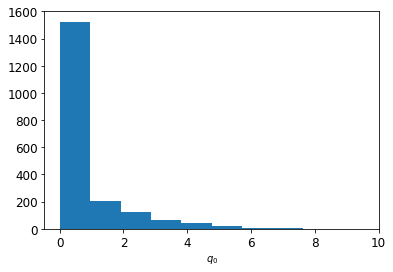

Z:0.2266894263296019
Z_std:2.7038739468331054
Z_1:0.40598241854947276
Z_std_1:1.7414482764852584
<B> = 147987.6855+/-373.27724627915643
<S> = 22.059+/-4.731122382691025
2
AUC:0.9372167651988685
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

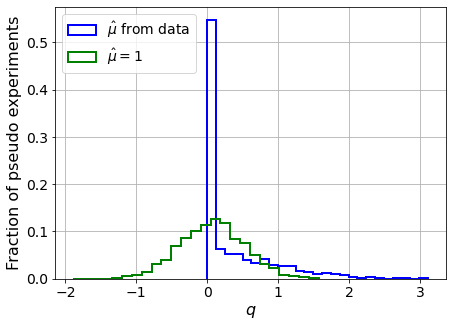

Z BL:(0.27125182731616876, 1.0123727928398258, 0.9984250000000001, 0.27593491738507203, 0.8332016880681077) with 15 bins


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  9409.36488453  9155.46168488
  8832.71015499  8434.42531807  7948.53082958  7361.50861281
  6644.28499051  5768.0573102   4707.07223185  3416.57823206
  1853.44977061   -16.26886029 -2230.48902962 -5122.43797627]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf  7693.30719941


KDE Kernel:  epanechnikov
Background bandwidth:  0.0019008479046983867
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.010462537635426419
0.010462537635426419
3 done
4 done
0.007262596923430286
0.007262596923430286
B_expected:  147986
S_expected:  22



  0%|                                                                   | 1/2000 [00:00<14:37,  2.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26765853155064667
<p_{s}(Sdata)> = 6.874255709020199
<p_{b}(Bdata)> = 9.020904802918464
<p_{s}(Bdata)> = 0.3031742033257876


  0%|                                                                   | 2/2000 [00:00<14:34,  2.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34098471810301156
<p_{s}(Sdata)> = 3.8647445267155427
<p_{b}(Bdata)> = 8.999821530335435
<p_{s}(Bdata)> = 0.3034970701565254


  0%|                                                                   | 3/2000 [00:01<14:36,  2.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5896374210641427
<p_{s}(Sdata)> = 2.891847614989319
<p_{b}(Bdata)> = 8.997596095701072
<p_{s}(Bdata)> = 0.3029715044219827


  0%|▏                                                                  | 4/2000 [00:01<14:39,  2.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29625459271863486
<p_{s}(Sdata)> = 3.312420376243713
<p_{b}(Bdata)> = 8.989342817433542
<p_{s}(Bdata)> = 0.30524599248568485


  0%|▏                                                                  | 5/2000 [00:02<14:33,  2.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31390078934465304
<p_{s}(Sdata)> = 3.2438482331304925
<p_{b}(Bdata)> = 9.031092888938495
<p_{s}(Bdata)> = 0.30424348162453824


  0%|▏                                                                  | 7/2000 [00:03<19:24,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2939850987290838
<p_{s}(Sdata)> = 2.7881990294117007
<p_{b}(Bdata)> = 9.007711674657202
<p_{s}(Bdata)> = 0.30350576815894365


  0%|▎                                                                  | 8/2000 [00:04<17:50,  1.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26019306721293256
<p_{s}(Sdata)> = 6.028999820805774
<p_{b}(Bdata)> = 9.032030004730638
<p_{s}(Bdata)> = 0.30263552250046105


  0%|▎                                                                  | 9/2000 [00:04<16:50,  1.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44608154129716415
<p_{s}(Sdata)> = 2.1819884914386227
<p_{b}(Bdata)> = 8.95951770114762
<p_{s}(Bdata)> = 0.3039309874080206


  0%|▎                                                                 | 10/2000 [00:05<16:11,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31207522793551207
<p_{s}(Sdata)> = 4.139175349456433
<p_{b}(Bdata)> = 8.965555939097362
<p_{s}(Bdata)> = 0.3044679968452672


  1%|▎                                                                 | 11/2000 [00:05<15:55,  2.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2765122832780448
<p_{s}(Sdata)> = 5.539910169436785
<p_{b}(Bdata)> = 8.960422598983497
<p_{s}(Bdata)> = 0.3007969075788929


  1%|▍                                                                 | 12/2000 [00:05<15:30,  2.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22755468678227683
<p_{s}(Sdata)> = 5.631711530178396
<p_{b}(Bdata)> = 9.005981051862257
<p_{s}(Bdata)> = 0.3052406020679887


  1%|▍                                                                 | 13/2000 [00:06<15:08,  2.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24042525540872536
<p_{s}(Sdata)> = 4.2337742153681885
<p_{b}(Bdata)> = 9.043857057903658
<p_{s}(Bdata)> = 0.30236948632688543


  1%|▍                                                                 | 14/2000 [00:06<14:51,  2.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2688773278939668
<p_{s}(Sdata)> = 5.011530866603754
<p_{b}(Bdata)> = 9.000670742622669
<p_{s}(Bdata)> = 0.30274249492969735


  1%|▍                                                                 | 15/2000 [00:07<14:42,  2.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25041549009783926
<p_{s}(Sdata)> = 5.3831537364169195
<p_{b}(Bdata)> = 8.966126968450224
<p_{s}(Bdata)> = 0.30330378405344516


  1%|▌                                                                 | 16/2000 [00:07<16:24,  2.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24943347783791636
<p_{s}(Sdata)> = 5.21705281292757
<p_{b}(Bdata)> = 9.077690153795004
<p_{s}(Bdata)> = 0.3037833557053955


  1%|▋                                                                 | 19/2000 [00:10<24:50,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2598236037264675
<p_{s}(Sdata)> = 4.07689298168713
<p_{b}(Bdata)> = 8.933967985043548
<p_{s}(Bdata)> = 0.30353089373647


  1%|▋                                                                 | 20/2000 [00:11<21:43,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3460187109844581
<p_{s}(Sdata)> = 5.2666376548628335
<p_{b}(Bdata)> = 8.957542253917351
<p_{s}(Bdata)> = 0.3027109306889256


  1%|▋                                                                 | 21/2000 [00:11<19:27,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21070567717614566
<p_{s}(Sdata)> = 6.255200171529401
<p_{b}(Bdata)> = 9.036547493821327
<p_{s}(Bdata)> = 0.3029552925232694


  1%|▋                                                                 | 22/2000 [00:11<17:51,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20803123827909284
<p_{s}(Sdata)> = 5.92847968802828
<p_{b}(Bdata)> = 9.006551405298886
<p_{s}(Bdata)> = 0.3040633335025619


  1%|▊                                                                 | 23/2000 [00:12<16:47,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5867887742686393
<p_{s}(Sdata)> = 2.771802701249131
<p_{b}(Bdata)> = 8.96819314000067
<p_{s}(Bdata)> = 0.30289756211953245


  1%|▊                                                                 | 24/2000 [00:13<17:49,  1.85it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5063634330722722
<p_{s}(Sdata)> = 6.271150944243467
<p_{b}(Bdata)> = 8.987293404417606
<p_{s}(Bdata)> = 0.3056625341956179


  1%|▊                                                                 | 26/2000 [00:15<30:19,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4302790652081534
<p_{s}(Sdata)> = 4.162856458255387
<p_{b}(Bdata)> = 8.95720085039019
<p_{s}(Bdata)> = 0.30417136365085834


  1%|▉                                                                 | 27/2000 [00:16<25:34,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3035534772995926
<p_{s}(Sdata)> = 5.116779943040803
<p_{b}(Bdata)> = 9.018616644069018
<p_{s}(Bdata)> = 0.3040432551686737


  2%|█                                                                 | 34/2000 [00:27<43:00,  1.31s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.31975759442099444
<p_{s}(Sdata)> = 5.646889365475692
<p_{b}(Bdata)> = 9.025699389108649
<p_{s}(Bdata)> = 0.30471971897633604


  2%|█▏                                                                | 35/2000 [00:28<34:28,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33300995757121477
<p_{s}(Sdata)> = 4.1960239648963915
<p_{b}(Bdata)> = 8.99739550203287
<p_{s}(Bdata)> = 0.30491260224041167


  2%|█▎                                                                | 38/2000 [00:33<41:31,  1.27s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3449522009948261
<p_{s}(Sdata)> = 4.465156183653751
<p_{b}(Bdata)> = 8.952528780328462
<p_{s}(Bdata)> = 0.30400175335893587


  2%|█▎                                                                | 39/2000 [00:33<33:21,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.37440271426049915
<p_{s}(Sdata)> = 4.032850205256586
<p_{b}(Bdata)> = 8.97336576698699
<p_{s}(Bdata)> = 0.30443175749852797


  2%|█▎                                                                | 41/2000 [00:37<42:00,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29440250876323576
<p_{s}(Sdata)> = 4.26344560814186
<p_{b}(Bdata)> = 9.028941133861823
<p_{s}(Bdata)> = 0.3006003898034115


  2%|█▍                                                                | 44/2000 [00:40<35:27,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20325364616182348
<p_{s}(Sdata)> = 6.183461179247225
<p_{b}(Bdata)> = 9.0113126817323
<p_{s}(Bdata)> = 0.30463070153997857


  2%|█▍                                                                | 45/2000 [00:41<29:02,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20988478661797427
<p_{s}(Sdata)> = 5.145607145138875
<p_{b}(Bdata)> = 8.921013870267831
<p_{s}(Bdata)> = 0.3050082560059124


  2%|█▌                                                                | 46/2000 [00:41<24:32,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26310822786978283
<p_{s}(Sdata)> = 4.770307409583923
<p_{b}(Bdata)> = 9.060792453978324
<p_{s}(Bdata)> = 0.3034309854584747


  2%|█▌                                                                | 47/2000 [00:41<21:24,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26523174318796877
<p_{s}(Sdata)> = 3.5712202789513934
<p_{b}(Bdata)> = 8.956397968760449
<p_{s}(Bdata)> = 0.3018723167842613


  2%|█▌                                                                | 49/2000 [00:43<21:02,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21141797410222918
<p_{s}(Sdata)> = 5.099400809636849
<p_{b}(Bdata)> = 8.96101971609446
<p_{s}(Bdata)> = 0.30358700757874285


  2%|█▋                                                                | 50/2000 [00:43<18:56,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33398194685203697
<p_{s}(Sdata)> = 4.743413829052645
<p_{b}(Bdata)> = 9.01275770029985
<p_{s}(Bdata)> = 0.30376467299326937


  3%|█▋                                                                | 51/2000 [00:44<17:32,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33244061867544866
<p_{s}(Sdata)> = 5.671015583130486
<p_{b}(Bdata)> = 9.000419345098194
<p_{s}(Bdata)> = 0.3028260638995986


  3%|█▋                                                                | 52/2000 [00:44<16:32,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.628399671184395
<p_{s}(Sdata)> = 4.702552143401197
<p_{b}(Bdata)> = 9.000092257756156
<p_{s}(Bdata)> = 0.30413380706466525


  3%|█▋                                                                | 53/2000 [00:45<15:46,  2.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23179882907733437
<p_{s}(Sdata)> = 5.23901266677972
<p_{b}(Bdata)> = 8.966353889572444
<p_{s}(Bdata)> = 0.30234725790214784


  3%|█▊                                                                | 54/2000 [00:45<15:16,  2.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45227232470991496
<p_{s}(Sdata)> = 2.8244235052493893
<p_{b}(Bdata)> = 9.032689183520016
<p_{s}(Bdata)> = 0.30329844511439924


  3%|█▊                                                                | 55/2000 [00:45<14:56,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33664419045359567
<p_{s}(Sdata)> = 5.076971375182373
<p_{b}(Bdata)> = 9.013427199799276
<p_{s}(Bdata)> = 0.3041367606023362


  3%|█▉                                                                | 58/2000 [00:51<38:30,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29500702453200117
<p_{s}(Sdata)> = 4.756286669649598
<p_{b}(Bdata)> = 8.990308906229636
<p_{s}(Bdata)> = 0.30584783108364494


  3%|█▉                                                                | 59/2000 [00:51<31:09,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24002998234788897
<p_{s}(Sdata)> = 5.971326210971593
<p_{b}(Bdata)> = 9.003661408473494
<p_{s}(Bdata)> = 0.3029545598738128


  3%|██                                                                | 61/2000 [00:54<35:25,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3016808758864795
<p_{s}(Sdata)> = 4.018520347795711
<p_{b}(Bdata)> = 9.086604125968595
<p_{s}(Bdata)> = 0.30054442575723983


  3%|██                                                                | 62/2000 [00:55<28:57,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20666063136072232
<p_{s}(Sdata)> = 4.6801221853795445
<p_{b}(Bdata)> = 9.03342644835732
<p_{s}(Bdata)> = 0.3031879866512114


  3%|██                                                                | 64/2000 [00:56<24:46,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25898731655254326
<p_{s}(Sdata)> = 4.214120871989289
<p_{b}(Bdata)> = 9.013070112337713
<p_{s}(Bdata)> = 0.30462012599839455


  3%|██▏                                                               | 65/2000 [00:56<21:38,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22559398484252277
<p_{s}(Sdata)> = 6.1384142090684835
<p_{b}(Bdata)> = 9.02308382358115
<p_{s}(Bdata)> = 0.30035080484089505


  3%|██▏                                                               | 67/2000 [00:59<31:12,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22668364744291628
<p_{s}(Sdata)> = 7.546889817278681
<p_{b}(Bdata)> = 8.964308061462214
<p_{s}(Bdata)> = 0.30257502156401617


  3%|██▏                                                               | 68/2000 [01:00<25:58,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37870068558974596
<p_{s}(Sdata)> = 2.0740093352619304
<p_{b}(Bdata)> = 9.029902645334756
<p_{s}(Bdata)> = 0.30042250568545203


  3%|██▎                                                               | 69/2000 [01:00<22:20,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.8068717445805629
<p_{s}(Sdata)> = 3.8476385669585205
<p_{b}(Bdata)> = 8.959414867840463
<p_{s}(Bdata)> = 0.30208478751172124


  4%|██▍                                                               | 72/2000 [01:07<48:29,  1.51s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3509227648200577
<p_{s}(Sdata)> = 5.310278159996898
<p_{b}(Bdata)> = 8.907929296200928
<p_{s}(Bdata)> = 0.3040342260620472


  4%|██▍                                                               | 73/2000 [01:07<38:03,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3880108132992939
<p_{s}(Sdata)> = 3.806069452764021
<p_{b}(Bdata)> = 9.068185030196796
<p_{s}(Bdata)> = 0.30550637937449043


  4%|██▌                                                               | 76/2000 [01:11<38:28,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.8866762921211395
<p_{s}(Sdata)> = 2.931166791502904
<p_{b}(Bdata)> = 8.995288854989758
<p_{s}(Bdata)> = 0.3038294329163015


  4%|██▌                                                               | 77/2000 [01:12<31:07,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3572952482900123
<p_{s}(Sdata)> = 4.049500179199036
<p_{b}(Bdata)> = 8.983538285752
<p_{s}(Bdata)> = 0.3033711091842375


  4%|██▌                                                               | 78/2000 [01:12<25:56,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48948342542326273
<p_{s}(Sdata)> = 3.494304582730367
<p_{b}(Bdata)> = 9.043641197438511
<p_{s}(Bdata)> = 0.3030613422982423


  4%|██▌                                                               | 79/2000 [01:13<22:21,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36302236044327707
<p_{s}(Sdata)> = 4.041334124362943
<p_{b}(Bdata)> = 8.973493116501956
<p_{s}(Bdata)> = 0.30174937065448637


  4%|██▋                                                               | 82/2000 [01:17<34:50,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.7210416788034738
<p_{s}(Sdata)> = 4.728535886023536
<p_{b}(Bdata)> = 8.949423323471981
<p_{s}(Bdata)> = 0.3022288287455379


  4%|██▋                                                               | 83/2000 [01:17<28:31,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3059192568141171
<p_{s}(Sdata)> = 3.0532556453308333
<p_{b}(Bdata)> = 9.001423391921351
<p_{s}(Bdata)> = 0.3035502750433724


  4%|██▊                                                               | 84/2000 [01:18<24:04,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32401984855873245
<p_{s}(Sdata)> = 4.770284418958113
<p_{b}(Bdata)> = 9.018814955637001
<p_{s}(Bdata)> = 0.30278889527417485


  4%|██▊                                                               | 86/2000 [01:21<33:46,  1.06s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19511505536071452
<p_{s}(Sdata)> = 5.8060735302322195
<p_{b}(Bdata)> = 9.008545410406812
<p_{s}(Bdata)> = 0.306791405735736


  4%|██▊                                                               | 87/2000 [01:21<27:45,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24586258364360739
<p_{s}(Sdata)> = 4.895348602336056
<p_{b}(Bdata)> = 8.953896125837282
<p_{s}(Bdata)> = 0.3027780407580143


  4%|██▉                                                               | 89/2000 [01:24<36:06,  1.13s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.46862152246775746
<p_{s}(Sdata)> = 6.111871027141888
<p_{b}(Bdata)> = 9.00435650704667
<p_{s}(Bdata)> = 0.3034233814410141


  4%|██▉                                                               | 90/2000 [01:25<29:26,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31787903944109774
<p_{s}(Sdata)> = 3.488133881026588
<p_{b}(Bdata)> = 8.952577227581676
<p_{s}(Bdata)> = 0.3046905791195785


  5%|███                                                               | 91/2000 [01:25<24:43,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5177136467647964
<p_{s}(Sdata)> = 3.037945935863171
<p_{b}(Bdata)> = 8.953287715919483
<p_{s}(Bdata)> = 0.3046101077286661


  5%|███▏                                                              | 95/2000 [01:31<36:13,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26478127902164184
<p_{s}(Sdata)> = 3.846341568711529
<p_{b}(Bdata)> = 8.98698375422796
<p_{s}(Bdata)> = 0.304117800851084


  5%|███▏                                                              | 96/2000 [01:32<29:27,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29729473327072925
<p_{s}(Sdata)> = 3.0288983428819645
<p_{b}(Bdata)> = 9.03293662021626
<p_{s}(Bdata)> = 0.30419718377045524


  5%|███▏                                                              | 97/2000 [01:32<24:46,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24378725234776163
<p_{s}(Sdata)> = 4.703980394558995
<p_{b}(Bdata)> = 9.0153577284415
<p_{s}(Bdata)> = 0.3057869737405571


  5%|███▏                                                              | 98/2000 [01:33<21:28,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23052313536519767
<p_{s}(Sdata)> = 6.203876077820024
<p_{b}(Bdata)> = 9.016832240210036
<p_{s}(Bdata)> = 0.3030514534877553


  5%|███▎                                                              | 99/2000 [01:33<19:11,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.355662632298403
<p_{s}(Sdata)> = 2.752961063947862
<p_{b}(Bdata)> = 8.955717082153509
<p_{s}(Bdata)> = 0.3019007951535766


  5%|███▎                                                             | 100/2000 [01:34<17:35,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30208637282373413
<p_{s}(Sdata)> = 4.112119589827008
<p_{b}(Bdata)> = 8.985066563094078
<p_{s}(Bdata)> = 0.3046588451391584


  5%|███▎                                                             | 101/2000 [01:34<16:26,  1.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32379350942881985
<p_{s}(Sdata)> = 3.180623662102329
<p_{b}(Bdata)> = 9.017834133850954
<p_{s}(Bdata)> = 0.3015915959376831


  5%|███▍                                                             | 104/2000 [01:41<49:19,  1.56s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3521727030630658
<p_{s}(Sdata)> = 4.24809046784249
<p_{b}(Bdata)> = 8.977227736538682
<p_{s}(Bdata)> = 0.30392384979388376


  5%|███▍                                                             | 107/2000 [01:46<47:11,  1.50s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2515888037153623
<p_{s}(Sdata)> = 6.711322045067858
<p_{b}(Bdata)> = 9.039255724331651
<p_{s}(Bdata)> = 0.30354798042259606


  5%|███▌                                                             | 108/2000 [01:47<38:48,  1.23s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3087294708754167
<p_{s}(Sdata)> = 4.145127566141372
<p_{b}(Bdata)> = 9.006995968477815
<p_{s}(Bdata)> = 0.30596377285351606


  5%|███▌                                                             | 109/2000 [01:47<31:18,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2267285617450318
<p_{s}(Sdata)> = 5.810310070592914
<p_{b}(Bdata)> = 9.036551778316468
<p_{s}(Bdata)> = 0.30037433095074684


  6%|███▌                                                             | 111/2000 [01:49<30:46,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21575369225462368
<p_{s}(Sdata)> = 5.597281801629309
<p_{b}(Bdata)> = 8.971455508618893
<p_{s}(Bdata)> = 0.3021894340049876


  6%|███▋                                                             | 113/2000 [01:52<32:18,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4208905108275965
<p_{s}(Sdata)> = 2.301665075564887
<p_{b}(Bdata)> = 9.013268205543854
<p_{s}(Bdata)> = 0.3003793022538454


  6%|███▋                                                             | 115/2000 [01:54<34:06,  1.09s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.28938809873147797
<p_{s}(Sdata)> = 3.8953713712398224
<p_{b}(Bdata)> = 9.013003840630464
<p_{s}(Bdata)> = 0.3068234910860354


  6%|███▊                                                             | 116/2000 [01:55<27:55,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2507350185221833
<p_{s}(Sdata)> = 5.680982282231251
<p_{b}(Bdata)> = 8.99485631543657
<p_{s}(Bdata)> = 0.3029232470265469


  6%|███▊                                                             | 117/2000 [01:55<23:37,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27342891902772626
<p_{s}(Sdata)> = 2.8302998823068397
<p_{b}(Bdata)> = 8.975311650489557
<p_{s}(Bdata)> = 0.30364430090511607


  6%|███▊                                                             | 119/2000 [01:57<25:17,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.262126051840947
<p_{s}(Sdata)> = 4.730994086710226
<p_{b}(Bdata)> = 8.999371555890898
<p_{s}(Bdata)> = 0.30563683416592413


  6%|███▉                                                             | 121/2000 [01:58<22:17,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34394943393508143
<p_{s}(Sdata)> = 4.248797380843296
<p_{b}(Bdata)> = 8.93972592564721
<p_{s}(Bdata)> = 0.30361923864435947


  6%|███▉                                                             | 123/2000 [02:01<26:18,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25215932095632204
<p_{s}(Sdata)> = 5.027971155730401
<p_{b}(Bdata)> = 8.971159227165227
<p_{s}(Bdata)> = 0.302358090837294


  6%|████                                                             | 124/2000 [02:01<24:15,  1.29it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.30011346752634294
<p_{s}(Sdata)> = 6.46754529202968
<p_{b}(Bdata)> = 9.01949065232479
<p_{s}(Bdata)> = 0.3053289364636361


  6%|████                                                             | 126/2000 [02:04<33:48,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.41905516622924255
<p_{s}(Sdata)> = 3.6073051396227367
<p_{b}(Bdata)> = 9.047575040289793
<p_{s}(Bdata)> = 0.3028956170321337


  6%|████▏                                                            | 127/2000 [02:05<29:26,  1.06it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.8649528593184552
<p_{s}(Sdata)> = 3.505173126786623
<p_{b}(Bdata)> = 8.982044130516702
<p_{s}(Bdata)> = 0.30700386371588984


  7%|████▎                                                            | 132/2000 [02:13<43:39,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3632640565292971
<p_{s}(Sdata)> = 3.554361383029087
<p_{b}(Bdata)> = 8.976253268371043
<p_{s}(Bdata)> = 0.3051268175963058


  7%|████▎                                                            | 133/2000 [02:14<36:19,  1.17s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.24518647892539636
<p_{s}(Sdata)> = 4.873567346976
<p_{b}(Bdata)> = 9.010527134506276
<p_{s}(Bdata)> = 0.30674065411304546


  7%|████▎                                                            | 134/2000 [02:14<29:36,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17436187873260792
<p_{s}(Sdata)> = 8.77535612996475
<p_{b}(Bdata)> = 8.940898242271613
<p_{s}(Bdata)> = 0.3029901740000111


  7%|████▍                                                            | 135/2000 [02:15<25:03,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35504518559585635
<p_{s}(Sdata)> = 5.670651295625866
<p_{b}(Bdata)> = 9.054754886016063
<p_{s}(Bdata)> = 0.3005306685080813


  7%|████▍                                                            | 137/2000 [02:19<38:46,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.485270733435751
<p_{s}(Sdata)> = 1.8969280812546154
<p_{b}(Bdata)> = 9.018329775111756
<p_{s}(Bdata)> = 0.3047750050997485


  7%|████▍                                                            | 138/2000 [02:19<31:12,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3230410568949842
<p_{s}(Sdata)> = 4.717639472441831
<p_{b}(Bdata)> = 8.990863698424166
<p_{s}(Bdata)> = 0.30229145196621404


  7%|████▌                                                            | 139/2000 [02:20<25:51,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33396746394194676
<p_{s}(Sdata)> = 3.2505129456953687
<p_{b}(Bdata)> = 9.021576431080492
<p_{s}(Bdata)> = 0.3032855854884138


  7%|████▌                                                            | 140/2000 [02:20<22:06,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2969105066181642
<p_{s}(Sdata)> = 3.68813499362309
<p_{b}(Bdata)> = 8.958781860849175
<p_{s}(Bdata)> = 0.30300319660642144


  7%|████▌                                                            | 141/2000 [02:20<19:28,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5953423307062409
<p_{s}(Sdata)> = 2.507315115324121
<p_{b}(Bdata)> = 9.04662591111795
<p_{s}(Bdata)> = 0.301366250284537


  7%|████▌                                                            | 142/2000 [02:21<17:40,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2288657451185634
<p_{s}(Sdata)> = 5.080201676359275
<p_{b}(Bdata)> = 9.04432715798033
<p_{s}(Bdata)> = 0.3035790188163627


  7%|████▋                                                            | 144/2000 [02:25<33:59,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21240013616452488
<p_{s}(Sdata)> = 5.609568480666109
<p_{b}(Bdata)> = 8.957021571290223
<p_{s}(Bdata)> = 0.3038446735851108


  7%|████▋                                                            | 145/2000 [02:25<27:48,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.260623034951923
<p_{s}(Sdata)> = 5.569223646208629
<p_{b}(Bdata)> = 8.972187912543989
<p_{s}(Bdata)> = 0.30397706897312426


  7%|████▋                                                            | 146/2000 [02:25<23:29,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26151837880814993
<p_{s}(Sdata)> = 3.311253275243019
<p_{b}(Bdata)> = 9.002571848789232
<p_{s}(Bdata)> = 0.30155409884247697


  7%|████▊                                                            | 147/2000 [02:26<20:28,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2629920051961602
<p_{s}(Sdata)> = 4.252050411645502
<p_{b}(Bdata)> = 8.99927116836589
<p_{s}(Bdata)> = 0.30416958185135956


  8%|████▉                                                            | 151/2000 [02:31<33:16,  1.08s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.23450882250758087
<p_{s}(Sdata)> = 6.205205982121323
<p_{b}(Bdata)> = 9.02121827991775
<p_{s}(Bdata)> = 0.3049017767066276


  8%|████▉                                                            | 152/2000 [02:31<27:15,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.355564616930083
<p_{s}(Sdata)> = 4.077594376402233
<p_{b}(Bdata)> = 8.905234711839537
<p_{s}(Bdata)> = 0.3060777675227903


  8%|████▉                                                            | 153/2000 [02:32<23:03,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23309060181838556
<p_{s}(Sdata)> = 5.162535157853315
<p_{b}(Bdata)> = 9.056601224195912
<p_{s}(Bdata)> = 0.30395732497585076


  8%|█████                                                            | 154/2000 [02:32<20:06,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2999958865890324
<p_{s}(Sdata)> = 3.1947543989215736
<p_{b}(Bdata)> = 9.002358728535505
<p_{s}(Bdata)> = 0.3046473398767052


  8%|█████                                                            | 155/2000 [02:33<18:03,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28975437658003095
<p_{s}(Sdata)> = 3.673938738447047
<p_{b}(Bdata)> = 8.942548326423113
<p_{s}(Bdata)> = 0.30400606897301574


  8%|█████                                                            | 157/2000 [02:35<22:49,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3547284871397134
<p_{s}(Sdata)> = 2.1446580872260443
<p_{b}(Bdata)> = 9.024564250028678
<p_{s}(Bdata)> = 0.30457812981156185


  8%|█████▏                                                           | 158/2000 [02:35<20:05,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2853214470157421
<p_{s}(Sdata)> = 3.760298730228504
<p_{b}(Bdata)> = 8.988548191918158
<p_{s}(Bdata)> = 0.30179047890442645


  8%|█████▏                                                           | 160/2000 [02:37<20:19,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3055002483942919
<p_{s}(Sdata)> = 2.7005492602294923
<p_{b}(Bdata)> = 9.018195771235428
<p_{s}(Bdata)> = 0.3018137950687972


  8%|█████▏                                                           | 161/2000 [02:37<18:14,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45923483210439614
<p_{s}(Sdata)> = 5.853445501022159
<p_{b}(Bdata)> = 8.998158492979659
<p_{s}(Bdata)> = 0.3017865965064678


  8%|█████▎                                                           | 162/2000 [02:37<16:44,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2083330994545457
<p_{s}(Sdata)> = 3.9227660163091893
<p_{b}(Bdata)> = 9.029901374576434
<p_{s}(Bdata)> = 0.3027917206740164


  8%|█████▎                                                           | 163/2000 [02:38<15:46,  1.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3015659400032973
<p_{s}(Sdata)> = 4.533094928616798
<p_{b}(Bdata)> = 9.01567908175387
<p_{s}(Bdata)> = 0.30218749940298517


  8%|█████▎                                                           | 165/2000 [02:41<31:49,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26493000516146675
<p_{s}(Sdata)> = 3.0144784312020874
<p_{b}(Bdata)> = 9.008663041684517
<p_{s}(Bdata)> = 0.3042223630855942


  8%|█████▍                                                           | 166/2000 [02:42<27:57,  1.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2632955305149093
<p_{s}(Sdata)> = 4.07882191679327
<p_{b}(Bdata)> = 8.936853302626712
<p_{s}(Bdata)> = 0.3058309632388629


  8%|█████▍                                                           | 167/2000 [02:43<23:35,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2128024204467128
<p_{s}(Sdata)> = 5.464523049477387
<p_{b}(Bdata)> = 8.977302210721671
<p_{s}(Bdata)> = 0.3049787774229026


  8%|█████▍                                                           | 168/2000 [02:43<20:31,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25030361625247954
<p_{s}(Sdata)> = 4.558588635271064
<p_{b}(Bdata)> = 8.984956823889155
<p_{s}(Bdata)> = 0.3036603408644917


  8%|█████▍                                                           | 169/2000 [02:43<18:18,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24848835096929286
<p_{s}(Sdata)> = 4.878583070079088
<p_{b}(Bdata)> = 9.047016799268691
<p_{s}(Bdata)> = 0.3011540194491466


  8%|█████▌                                                           | 170/2000 [02:44<16:47,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4646870136038102
<p_{s}(Sdata)> = 3.536209940573693
<p_{b}(Bdata)> = 8.995090931185866
<p_{s}(Bdata)> = 0.30285303275034553


  9%|█████▌                                                           | 172/2000 [02:46<25:15,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21996656543064988
<p_{s}(Sdata)> = 5.558327603064986
<p_{b}(Bdata)> = 9.00289744611762
<p_{s}(Bdata)> = 0.3017832991303325


  9%|█████▌                                                           | 173/2000 [02:47<21:38,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3638537302028581
<p_{s}(Sdata)> = 3.414129656072677
<p_{b}(Bdata)> = 8.997270435380802
<p_{s}(Bdata)> = 0.3015311325839687


  9%|█████▋                                                           | 174/2000 [02:47<19:14,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20932309882169572
<p_{s}(Sdata)> = 4.46587285940509
<p_{b}(Bdata)> = 9.037985549542627
<p_{s}(Bdata)> = 0.30209918882738607


  9%|█████▋                                                           | 175/2000 [02:48<19:01,  1.60it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2894103399898788
<p_{s}(Sdata)> = 5.344739349586717
<p_{b}(Bdata)> = 8.969032470485539
<p_{s}(Bdata)> = 0.3063145695673023


  9%|█████▋                                                           | 176/2000 [02:48<17:17,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16108447863126854
<p_{s}(Sdata)> = 7.963422332243588
<p_{b}(Bdata)> = 9.083293216328114
<p_{s}(Bdata)> = 0.3006666258304315


  9%|█████▊                                                           | 177/2000 [02:49<16:01,  1.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3600807288629512
<p_{s}(Sdata)> = 2.5294927926848505
<p_{b}(Bdata)> = 9.012226267865033
<p_{s}(Bdata)> = 0.30235023544778616


  9%|█████▊                                                           | 178/2000 [02:49<15:07,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3025096637897456
<p_{s}(Sdata)> = 2.916066484969945
<p_{b}(Bdata)> = 8.98510523857548
<p_{s}(Bdata)> = 0.3036852936175849


  9%|█████▊                                                           | 179/2000 [02:50<14:29,  2.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24046857851863165
<p_{s}(Sdata)> = 8.011693957558178
<p_{b}(Bdata)> = 9.025334724106136
<p_{s}(Bdata)> = 0.30312740456042914


  9%|█████▊                                                           | 180/2000 [02:50<14:05,  2.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20710570631706443
<p_{s}(Sdata)> = 6.072463764980953
<p_{b}(Bdata)> = 8.959484693311943
<p_{s}(Bdata)> = 0.30317311216622767


  9%|█████▉                                                           | 182/2000 [02:52<23:34,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3436503867028232
<p_{s}(Sdata)> = 3.9893507236586547
<p_{b}(Bdata)> = 9.024652258326423
<p_{s}(Bdata)> = 0.30249971672701814


  9%|█████▉                                                           | 183/2000 [02:53<20:24,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3758216661041147
<p_{s}(Sdata)> = 5.746228552083319
<p_{b}(Bdata)> = 8.939421488386966
<p_{s}(Bdata)> = 0.305123655830246


  9%|██████                                                           | 185/2000 [02:55<23:27,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24064383206744208
<p_{s}(Sdata)> = 6.34729849117585
<p_{b}(Bdata)> = 8.954383495284784
<p_{s}(Bdata)> = 0.30331107651951894


  9%|██████                                                           | 186/2000 [02:55<20:28,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34396266689211186
<p_{s}(Sdata)> = 3.8108004619398987
<p_{b}(Bdata)> = 9.011880206255611
<p_{s}(Bdata)> = 0.3023676760727829


  9%|██████                                                           | 187/2000 [02:56<18:17,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35476511530336435
<p_{s}(Sdata)> = 4.678564244129761
<p_{b}(Bdata)> = 9.046813046165337
<p_{s}(Bdata)> = 0.30167970040415354


  9%|██████                                                           | 188/2000 [02:56<16:54,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1911033181881488
<p_{s}(Sdata)> = 5.26703171687699
<p_{b}(Bdata)> = 8.96265825374273
<p_{s}(Bdata)> = 0.30299541411532954


 10%|██████▏                                                          | 190/2000 [02:59<25:32,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34921392896879755
<p_{s}(Sdata)> = 3.5417680932712656
<p_{b}(Bdata)> = 8.95262236531596
<p_{s}(Bdata)> = 0.30125927249036316


 10%|██████▏                                                          | 191/2000 [02:59<21:52,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23749249575535838
<p_{s}(Sdata)> = 4.792829858665625
<p_{b}(Bdata)> = 8.952586462454748
<p_{s}(Bdata)> = 0.30321131764110454


 10%|██████▏                                                          | 192/2000 [02:59<19:17,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21022698070943954
<p_{s}(Sdata)> = 4.982922280906333
<p_{b}(Bdata)> = 8.969113964179934
<p_{s}(Bdata)> = 0.3042158838614138


 10%|██████▎                                                          | 193/2000 [03:00<17:24,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2899822050325507
<p_{s}(Sdata)> = 4.176141290621868
<p_{b}(Bdata)> = 8.985276553190829
<p_{s}(Bdata)> = 0.3021726628151717


 10%|██████▎                                                          | 194/2000 [03:00<16:06,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27219059409979746
<p_{s}(Sdata)> = 5.218824543945102
<p_{b}(Bdata)> = 9.001558056968952
<p_{s}(Bdata)> = 0.30395992812569694


 10%|██████▎                                                          | 195/2000 [03:01<15:11,  1.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25829109151233604
<p_{s}(Sdata)> = 6.396434185224337
<p_{b}(Bdata)> = 8.975922700477492
<p_{s}(Bdata)> = 0.30380453774648103


 10%|██████▎                                                          | 196/2000 [03:01<14:35,  2.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30609694110093266
<p_{s}(Sdata)> = 4.533377032398567
<p_{b}(Bdata)> = 8.99461734351625
<p_{s}(Bdata)> = 0.30292560034348504


 10%|██████▍                                                          | 198/2000 [03:04<27:20,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2632770347915452
<p_{s}(Sdata)> = 4.734730460224943
<p_{b}(Bdata)> = 9.006255245631353
<p_{s}(Bdata)> = 0.3033280312342253


 10%|██████▌                                                          | 202/2000 [03:13<49:56,  1.67s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22712348878009747
<p_{s}(Sdata)> = 4.394804830623593
<p_{b}(Bdata)> = 9.00327241723625
<p_{s}(Bdata)> = 0.30318870777491036


 10%|██████▌                                                          | 203/2000 [03:13<40:32,  1.35s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.4410343920368623
<p_{s}(Sdata)> = 4.290704958936542
<p_{b}(Bdata)> = 8.906431784189069
<p_{s}(Bdata)> = 0.30772062895953656


 10%|██████▋                                                          | 205/2000 [03:16<37:27,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4088599704788301
<p_{s}(Sdata)> = 4.337674022237657
<p_{b}(Bdata)> = 9.002165623058337
<p_{s}(Bdata)> = 0.3045656309031312


 11%|██████▉                                                          | 212/2000 [03:29<47:16,  1.59s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25455234389813497
<p_{s}(Sdata)> = 3.530667784277684
<p_{b}(Bdata)> = 9.008816037165284
<p_{s}(Bdata)> = 0.3050931513669846


 11%|██████▉                                                          | 214/2000 [03:31<34:44,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2225100716047755
<p_{s}(Sdata)> = 4.404952196552126
<p_{b}(Bdata)> = 9.01612034086315
<p_{s}(Bdata)> = 0.30234641157055975


 11%|███████                                                          | 216/2000 [03:32<25:53,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27154539901222996
<p_{s}(Sdata)> = 5.485120073132587
<p_{b}(Bdata)> = 8.976266583900806
<p_{s}(Bdata)> = 0.30446951435566477


 11%|███████                                                          | 217/2000 [03:32<22:01,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30221972432505884
<p_{s}(Sdata)> = 6.27678764705424
<p_{b}(Bdata)> = 8.944667757264376
<p_{s}(Bdata)> = 0.30450824115837777


 11%|███████                                                          | 218/2000 [03:33<19:14,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20876038867030325
<p_{s}(Sdata)> = 8.517274260334235
<p_{b}(Bdata)> = 8.977665775329717
<p_{s}(Bdata)> = 0.3029915685863625


 11%|███████▏                                                         | 220/2000 [03:36<26:57,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5167767255966348
<p_{s}(Sdata)> = 4.922130479556774
<p_{b}(Bdata)> = 8.970089684254875
<p_{s}(Bdata)> = 0.30119645452754423


 11%|███████▏                                                         | 221/2000 [03:36<22:49,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23760406878480736
<p_{s}(Sdata)> = 3.1169892826025762
<p_{b}(Bdata)> = 8.973556455286058
<p_{s}(Bdata)> = 0.30430220420615367


 11%|███████▏                                                         | 222/2000 [03:36<19:51,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34754679433131225
<p_{s}(Sdata)> = 4.975882669620831
<p_{b}(Bdata)> = 8.967136279634643
<p_{s}(Bdata)> = 0.3038952493644377


 11%|███████▏                                                         | 223/2000 [03:37<17:55,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2710711793491017
<p_{s}(Sdata)> = 4.1935591707431135
<p_{b}(Bdata)> = 8.997980582830612
<p_{s}(Bdata)> = 0.30554076950371223


 11%|███████▎                                                         | 225/2000 [03:39<20:08,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2914094737055015
<p_{s}(Sdata)> = 8.10914182762678
<p_{b}(Bdata)> = 8.99698863641523
<p_{s}(Bdata)> = 0.30409400031785244


 11%|███████▎                                                         | 226/2000 [03:39<18:14,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27005032834242493
<p_{s}(Sdata)> = 5.457203398314716
<p_{b}(Bdata)> = 9.000480036356752
<p_{s}(Bdata)> = 0.30302361322728416


 11%|███████▍                                                         | 227/2000 [03:40<18:20,  1.61it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.34028552161488856
<p_{s}(Sdata)> = 4.1274074660020466
<p_{b}(Bdata)> = 9.001070642171069
<p_{s}(Bdata)> = 0.3053123152435098


 11%|███████▍                                                         | 228/2000 [03:40<16:44,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2738109510365286
<p_{s}(Sdata)> = 5.35334094744084
<p_{b}(Bdata)> = 8.98175527504815
<p_{s}(Bdata)> = 0.3042401606544042


 11%|███████▍                                                         | 229/2000 [03:41<15:50,  1.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5570526349523074
<p_{s}(Sdata)> = 8.192763429567414
<p_{b}(Bdata)> = 9.05535471971979
<p_{s}(Bdata)> = 0.302527493955834


 12%|███████▍                                                         | 230/2000 [03:41<15:34,  1.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19965818038679603
<p_{s}(Sdata)> = 4.852649492660469
<p_{b}(Bdata)> = 8.966515228503644
<p_{s}(Bdata)> = 0.30247324840416795


 12%|███████▌                                                         | 231/2000 [03:41<14:50,  1.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3996678711345544
<p_{s}(Sdata)> = 5.320269304288469
<p_{b}(Bdata)> = 8.911837455268767
<p_{s}(Bdata)> = 0.30347853740076347


 12%|███████▌                                                         | 234/2000 [03:45<21:57,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3426686879660042
<p_{s}(Sdata)> = 5.869417005959595
<p_{b}(Bdata)> = 9.008869435502389
<p_{s}(Bdata)> = 0.3056244577708865


 12%|███████▋                                                         | 235/2000 [03:45<20:58,  1.40it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.31367179438728404
<p_{s}(Sdata)> = 5.154481230923688
<p_{b}(Bdata)> = 8.976545389923356
<p_{s}(Bdata)> = 0.30704106023691063


 12%|███████▋                                                         | 236/2000 [03:46<18:38,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3675796329570685
<p_{s}(Sdata)> = 4.696459742661757
<p_{b}(Bdata)> = 8.906991525004578
<p_{s}(Bdata)> = 0.30394257616132103


 12%|███████▋                                                         | 238/2000 [03:48<24:07,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3006925295388449
<p_{s}(Sdata)> = 1.7535272496281626
<p_{b}(Bdata)> = 9.004758972750938
<p_{s}(Bdata)> = 0.30415338268599856


 12%|███████▊                                                         | 239/2000 [03:48<20:51,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34272128507827126
<p_{s}(Sdata)> = 2.9405348551478494
<p_{b}(Bdata)> = 8.956766089788731
<p_{s}(Bdata)> = 0.3036357336644786


 12%|███████▊                                                         | 240/2000 [03:49<18:33,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38921266636061136
<p_{s}(Sdata)> = 5.31706907973436
<p_{b}(Bdata)> = 9.005026951667752
<p_{s}(Bdata)> = 0.3033231581996001


 12%|███████▊                                                         | 241/2000 [03:49<16:51,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4232796064388068
<p_{s}(Sdata)> = 3.02073826786815
<p_{b}(Bdata)> = 9.042713186893613
<p_{s}(Bdata)> = 0.30046505747573954


 12%|███████▊                                                         | 242/2000 [03:50<15:41,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26224470448452997
<p_{s}(Sdata)> = 4.278091279467557
<p_{b}(Bdata)> = 8.996716083417862
<p_{s}(Bdata)> = 0.3037253402509908


 12%|███████▉                                                         | 243/2000 [03:50<15:00,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30115528389087043
<p_{s}(Sdata)> = 6.902562423500664
<p_{b}(Bdata)> = 8.984361931321214
<p_{s}(Bdata)> = 0.3035168738086648


 12%|███████▉                                                         | 244/2000 [03:51<14:21,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3809402845874062
<p_{s}(Sdata)> = 3.3686132233023653
<p_{b}(Bdata)> = 9.025394102233424
<p_{s}(Bdata)> = 0.30165447076171076


 12%|███████▉                                                         | 245/2000 [03:51<14:01,  2.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2528632274110169
<p_{s}(Sdata)> = 4.8174024033494165
<p_{b}(Bdata)> = 8.969552929769936
<p_{s}(Bdata)> = 0.3033495295335639


 12%|███████▉                                                         | 246/2000 [03:51<13:40,  2.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32947997571775084
<p_{s}(Sdata)> = 4.3956319844914695
<p_{b}(Bdata)> = 8.960164794484573
<p_{s}(Bdata)> = 0.30449257957240705


 12%|████████                                                         | 247/2000 [03:52<13:30,  2.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20708499515769208
<p_{s}(Sdata)> = 6.941083160694384
<p_{b}(Bdata)> = 8.984231181633275
<p_{s}(Bdata)> = 0.3038113852430252


 12%|████████                                                         | 249/2000 [03:56<30:32,  1.05s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.30179984032048374
<p_{s}(Sdata)> = 4.486710955969643
<p_{b}(Bdata)> = 8.968434145441101
<p_{s}(Bdata)> = 0.306353074846681


 12%|████████▏                                                        | 250/2000 [03:56<25:09,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22123188532800178
<p_{s}(Sdata)> = 6.4537646470633145
<p_{b}(Bdata)> = 8.965481599457323
<p_{s}(Bdata)> = 0.3036195231022509


 13%|████████▏                                                        | 251/2000 [03:56<21:23,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23884529183030964
<p_{s}(Sdata)> = 5.405753185437811
<p_{b}(Bdata)> = 8.997549225126777
<p_{s}(Bdata)> = 0.3021910572016286


 13%|████████▎                                                        | 255/2000 [04:03<36:20,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2952233614969192
<p_{s}(Sdata)> = 3.272020817129719
<p_{b}(Bdata)> = 8.954744844369547
<p_{s}(Bdata)> = 0.3069283525639555


 13%|████████▎                                                        | 257/2000 [04:05<27:40,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27862487268893443
<p_{s}(Sdata)> = 4.376684899172977
<p_{b}(Bdata)> = 9.0595978939515
<p_{s}(Bdata)> = 0.3016260537257022


 13%|████████▍                                                        | 260/2000 [04:11<44:24,  1.53s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3364506526732027
<p_{s}(Sdata)> = 4.106407710015649
<p_{b}(Bdata)> = 8.98728905044611
<p_{s}(Bdata)> = 0.30542038734032406


 13%|████████▍                                                        | 261/2000 [04:11<34:59,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3242546637920953
<p_{s}(Sdata)> = 5.8879456365793095
<p_{b}(Bdata)> = 8.96224446501465
<p_{s}(Bdata)> = 0.3047266407875586


 13%|████████▌                                                        | 265/2000 [04:18<45:18,  1.57s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4653779606145215
<p_{s}(Sdata)> = 4.815146293803398
<p_{b}(Bdata)> = 9.023374012557072
<p_{s}(Bdata)> = 0.30461688938149917


 13%|████████▋                                                        | 266/2000 [04:19<35:22,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.35034344637507725
<p_{s}(Sdata)> = 4.4526081483105395
<p_{b}(Bdata)> = 8.979165147549963
<p_{s}(Bdata)> = 0.30273965275187903


 13%|████████▋                                                        | 269/2000 [04:24<38:47,  1.34s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23264991584743244
<p_{s}(Sdata)> = 5.728125689304595
<p_{b}(Bdata)> = 8.984911077496909
<p_{s}(Bdata)> = 0.3035091067265347


 14%|████████▊                                                        | 270/2000 [04:24<30:56,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.196003435323867
<p_{s}(Sdata)> = 6.901639490847233
<p_{b}(Bdata)> = 8.928201837429123
<p_{s}(Bdata)> = 0.3033963905910302


 14%|████████▊                                                        | 272/2000 [04:28<39:37,  1.38s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.44269034282690517
<p_{s}(Sdata)> = 3.31796411680793
<p_{b}(Bdata)> = 8.972604350436903
<p_{s}(Bdata)> = 0.3047557025085355


 14%|████████▉                                                        | 274/2000 [04:30<31:39,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 2.6589012708606243
<p_{s}(Sdata)> = 4.726414638184748
<p_{b}(Bdata)> = 9.018809734726307
<p_{s}(Bdata)> = 0.3043743363165788


 14%|████████▉                                                        | 276/2000 [04:31<24:00,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4076276776346142
<p_{s}(Sdata)> = 1.9818655582847204
<p_{b}(Bdata)> = 9.011074355874014
<p_{s}(Bdata)> = 0.3043843088368394


 14%|█████████                                                        | 277/2000 [04:32<20:37,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28240251244729075
<p_{s}(Sdata)> = 5.6166076187081355
<p_{b}(Bdata)> = 9.007523652269828
<p_{s}(Bdata)> = 0.30087221608394177


 14%|█████████                                                        | 278/2000 [04:32<18:08,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24612269899880157
<p_{s}(Sdata)> = 4.355243320318895
<p_{b}(Bdata)> = 8.991757347033971
<p_{s}(Bdata)> = 0.30266824974248974


 14%|█████████                                                        | 279/2000 [04:33<16:26,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2903748028938503
<p_{s}(Sdata)> = 7.123024635854907
<p_{b}(Bdata)> = 8.957856879547847
<p_{s}(Bdata)> = 0.30545209651895805


 14%|█████████                                                        | 280/2000 [04:33<15:15,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30626379464196996
<p_{s}(Sdata)> = 4.594740058318587
<p_{b}(Bdata)> = 9.013046392295754
<p_{s}(Bdata)> = 0.30331926175048474


 14%|█████████▏                                                       | 281/2000 [04:33<14:22,  1.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4391803064033067
<p_{s}(Sdata)> = 4.258175678805817
<p_{b}(Bdata)> = 9.032770384390494
<p_{s}(Bdata)> = 0.30386011872827046


 14%|█████████▏                                                       | 283/2000 [04:36<26:29,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5806151395886091
<p_{s}(Sdata)> = 2.4239762135519287
<p_{b}(Bdata)> = 8.944104047633667
<p_{s}(Bdata)> = 0.30581365813154365


 14%|█████████▏                                                       | 284/2000 [04:37<22:16,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6454511960401398
<p_{s}(Sdata)> = 3.4873766617218256
<p_{b}(Bdata)> = 8.945692516002579
<p_{s}(Bdata)> = 0.30497537704374306


 14%|█████████▎                                                       | 287/2000 [04:42<31:13,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23344667773531438
<p_{s}(Sdata)> = 6.395332614241278
<p_{b}(Bdata)> = 9.003102033439122
<p_{s}(Bdata)> = 0.3026065639242592


 14%|█████████▎                                                       | 288/2000 [04:42<25:30,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2948331227922803
<p_{s}(Sdata)> = 5.7094414561523505
<p_{b}(Bdata)> = 9.02283795703688
<p_{s}(Bdata)> = 0.30355139359099237


 14%|█████████▍                                                       | 290/2000 [04:45<30:10,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5122253796356235
<p_{s}(Sdata)> = 3.8579457430755952
<p_{b}(Bdata)> = 8.99838717361796
<p_{s}(Bdata)> = 0.3036519270713201


 15%|█████████▍                                                       | 292/2000 [04:46<25:13,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21894174058492022
<p_{s}(Sdata)> = 5.44941634208715
<p_{b}(Bdata)> = 8.96607772034023
<p_{s}(Bdata)> = 0.3038526040879433


 15%|█████████▌                                                       | 293/2000 [04:47<21:22,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2839635273975761
<p_{s}(Sdata)> = 3.9152319780084754
<p_{b}(Bdata)> = 8.97931698787461
<p_{s}(Bdata)> = 0.30517883375010213


 15%|█████████▌                                                       | 294/2000 [04:47<18:40,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22929962030263332
<p_{s}(Sdata)> = 3.6699120467322586
<p_{b}(Bdata)> = 9.075534598443747
<p_{s}(Bdata)> = 0.30221907254169145


 15%|█████████▌                                                       | 295/2000 [04:48<16:42,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33242771730383447
<p_{s}(Sdata)> = 4.066786222904339
<p_{b}(Bdata)> = 9.041881437808138
<p_{s}(Bdata)> = 0.3033711954293996


 15%|█████████▌                                                       | 296/2000 [04:48<15:24,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2779616626489536
<p_{s}(Sdata)> = 5.080146762789898
<p_{b}(Bdata)> = 9.020283074257712
<p_{s}(Bdata)> = 0.3030780926998404


 15%|█████████▋                                                       | 299/2000 [04:54<33:46,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.31610596265656793
<p_{s}(Sdata)> = 3.714288789896326
<p_{b}(Bdata)> = 8.986341169854406
<p_{s}(Bdata)> = 0.3017611203277403


 15%|█████████▊                                                       | 300/2000 [04:54<27:20,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35489301197637213
<p_{s}(Sdata)> = 4.109998811372167
<p_{b}(Bdata)> = 9.001247620113654
<p_{s}(Bdata)> = 0.3047883093689124


 15%|█████████▊                                                       | 301/2000 [04:54<22:45,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32618116005735465
<p_{s}(Sdata)> = 4.867652726883859
<p_{b}(Bdata)> = 8.929647443382454
<p_{s}(Bdata)> = 0.3067356656556396


 15%|█████████▊                                                       | 302/2000 [04:55<21:04,  1.34it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2709942844885477
<p_{s}(Sdata)> = 3.6882271858354843
<p_{b}(Bdata)> = 9.005605970013425
<p_{s}(Bdata)> = 0.3063562847920945


 15%|█████████▊                                                       | 303/2000 [04:55<18:27,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44068010369362315
<p_{s}(Sdata)> = 5.485341826972348
<p_{b}(Bdata)> = 9.010502396292033
<p_{s}(Bdata)> = 0.3055460197387725


 15%|█████████▉                                                       | 307/2000 [04:59<24:16,  1.16it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24001810846775168
<p_{s}(Sdata)> = 5.718224849739873
<p_{b}(Bdata)> = 8.929770830506916
<p_{s}(Bdata)> = 0.3060733166978173


 15%|██████████                                                       | 308/2000 [05:00<20:42,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27153727834607966
<p_{s}(Sdata)> = 4.135855467071943
<p_{b}(Bdata)> = 8.947778291421205
<p_{s}(Bdata)> = 0.30433078137027675


 15%|██████████                                                       | 309/2000 [05:00<18:18,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5293076084986793
<p_{s}(Sdata)> = 5.722258998288826
<p_{b}(Bdata)> = 8.968462530520272
<p_{s}(Bdata)> = 0.3023470953964486


 16%|██████████                                                       | 310/2000 [05:01<16:31,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31561807657226076
<p_{s}(Sdata)> = 6.872119169063609
<p_{b}(Bdata)> = 8.952376687468522
<p_{s}(Bdata)> = 0.3030945774902442


 16%|██████████▏                                                      | 312/2000 [05:03<21:39,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27567978129399884
<p_{s}(Sdata)> = 6.140653649818287
<p_{b}(Bdata)> = 9.007448412643992
<p_{s}(Bdata)> = 0.3038862151797956


 16%|██████████▏                                                      | 313/2000 [05:03<18:50,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26963958554629663
<p_{s}(Sdata)> = 5.401842336733492
<p_{b}(Bdata)> = 8.999349647817123
<p_{s}(Bdata)> = 0.3032576139320722


 16%|██████████▏                                                      | 314/2000 [05:04<16:49,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26263429679066574
<p_{s}(Sdata)> = 5.282543283176253
<p_{b}(Bdata)> = 8.968812008344557
<p_{s}(Bdata)> = 0.30497477132987144


 16%|██████████▏                                                      | 315/2000 [05:04<15:25,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4348209182208816
<p_{s}(Sdata)> = 4.596385852139811
<p_{b}(Bdata)> = 9.08220409305442
<p_{s}(Bdata)> = 0.3049855767230752


 16%|██████████▎                                                      | 316/2000 [05:05<14:27,  1.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.316542463053076
<p_{s}(Sdata)> = 3.562744196991571
<p_{b}(Bdata)> = 8.951221124466757
<p_{s}(Bdata)> = 0.30339020684097817


 16%|██████████▎                                                      | 317/2000 [05:05<13:48,  2.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27819874111898385
<p_{s}(Sdata)> = 2.313255325250273
<p_{b}(Bdata)> = 8.931932222773009
<p_{s}(Bdata)> = 0.30465121695780883


 16%|██████████▎                                                      | 318/2000 [05:05<13:25,  2.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18281425504743204
<p_{s}(Sdata)> = 7.411336663623463
<p_{b}(Bdata)> = 9.003062492026096
<p_{s}(Bdata)> = 0.3031982517460799


 16%|██████████▍                                                      | 320/2000 [05:08<20:37,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32789922147254785
<p_{s}(Sdata)> = 3.9855901223644126
<p_{b}(Bdata)> = 8.960948722060982
<p_{s}(Bdata)> = 0.30653340889885883


 16%|██████████▍                                                      | 322/2000 [05:10<27:26,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29405598851987064
<p_{s}(Sdata)> = 3.0159118395517592
<p_{b}(Bdata)> = 9.038456375054455
<p_{s}(Bdata)> = 0.30257102946513137


 16%|██████████▍                                                      | 323/2000 [05:11<22:52,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2655752240278506
<p_{s}(Sdata)> = 5.947198819485276
<p_{b}(Bdata)> = 9.056679285779206
<p_{s}(Bdata)> = 0.3029423739649665


 16%|██████████▌                                                      | 324/2000 [05:11<19:44,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3255594954577639
<p_{s}(Sdata)> = 4.117051332481323
<p_{b}(Bdata)> = 9.063549088172714
<p_{s}(Bdata)> = 0.30361074357503776


 16%|██████████▌                                                      | 325/2000 [05:12<17:36,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18611850578937802
<p_{s}(Sdata)> = 7.741004112755875
<p_{b}(Bdata)> = 8.966224630562849
<p_{s}(Bdata)> = 0.3053160112881443


 16%|██████████▋                                                      | 328/2000 [05:15<24:11,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22240138516988062
<p_{s}(Sdata)> = 5.87467394822564
<p_{b}(Bdata)> = 8.968090009121381
<p_{s}(Bdata)> = 0.30258338917253913


 16%|██████████▋                                                      | 329/2000 [05:15<20:35,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30038018749458545
<p_{s}(Sdata)> = 5.021482424275535
<p_{b}(Bdata)> = 8.946577963333636
<p_{s}(Bdata)> = 0.30214670409400834


 16%|██████████▋                                                      | 330/2000 [05:16<18:05,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26776208966033854
<p_{s}(Sdata)> = 4.737889331621703
<p_{b}(Bdata)> = 9.022486462101353
<p_{s}(Bdata)> = 0.3022017932600161


 17%|██████████▊                                                      | 332/2000 [05:19<28:56,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.31007354501027473
<p_{s}(Sdata)> = 4.247696057048149
<p_{b}(Bdata)> = 9.011528904632378
<p_{s}(Bdata)> = 0.3037828926945422


 17%|██████████▊                                                      | 333/2000 [05:20<23:51,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44277470146201203
<p_{s}(Sdata)> = 1.879779211606659
<p_{b}(Bdata)> = 9.038740772721951
<p_{s}(Bdata)> = 0.30323039604029867


 17%|██████████▉                                                      | 335/2000 [05:23<34:45,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3359489338614983
<p_{s}(Sdata)> = 3.986310695354258
<p_{b}(Bdata)> = 9.026697108113837
<p_{s}(Bdata)> = 0.30411554497449966


 17%|██████████▉                                                      | 336/2000 [05:24<29:28,  1.06s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.21853365375377237
<p_{s}(Sdata)> = 7.629389948801809
<p_{b}(Bdata)> = 8.933033014497278
<p_{s}(Bdata)> = 0.3081162695731766


 17%|██████████▉                                                      | 337/2000 [05:24<24:22,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3022724909329008
<p_{s}(Sdata)> = 3.082377381498392
<p_{b}(Bdata)> = 8.979138991563634
<p_{s}(Bdata)> = 0.30593153059157097


 17%|██████████▉                                                      | 338/2000 [05:25<20:42,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30263619183509016
<p_{s}(Sdata)> = 3.197166821476476
<p_{b}(Bdata)> = 8.966240347668672
<p_{s}(Bdata)> = 0.305037988129296


 17%|███████████                                                      | 340/2000 [05:28<30:05,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3274750260831469
<p_{s}(Sdata)> = 5.133488330549309
<p_{b}(Bdata)> = 8.984956547600362
<p_{s}(Bdata)> = 0.3019115651909249


 17%|███████████                                                      | 341/2000 [05:29<26:04,  1.06it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3344042593775288
<p_{s}(Sdata)> = 6.840927916448563
<p_{b}(Bdata)> = 8.971082656125398
<p_{s}(Bdata)> = 0.3053471837053446


 17%|███████████                                                      | 342/2000 [05:29<21:54,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5269341689808116
<p_{s}(Sdata)> = 3.129034080482189
<p_{b}(Bdata)> = 8.941756516595339
<p_{s}(Bdata)> = 0.30623703887780307


 17%|███████████▏                                                     | 343/2000 [05:30<18:56,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18245518647973416
<p_{s}(Sdata)> = 5.700406906437662
<p_{b}(Bdata)> = 9.016099052888146
<p_{s}(Bdata)> = 0.3037938359894314


 17%|███████████▏                                                     | 344/2000 [05:30<16:52,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18683721350545485
<p_{s}(Sdata)> = 8.534191791282094
<p_{b}(Bdata)> = 9.009687616159047
<p_{s}(Bdata)> = 0.3004028455134296


 17%|███████████▏                                                     | 345/2000 [05:31<16:50,  1.64it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26705404654915077
<p_{s}(Sdata)> = 6.70114200405276
<p_{b}(Bdata)> = 9.014207138840412
<p_{s}(Bdata)> = 0.3052991498624344


 17%|███████████▏                                                     | 346/2000 [05:31<15:21,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20929260315473702
<p_{s}(Sdata)> = 7.633648083381364
<p_{b}(Bdata)> = 8.982979962608114
<p_{s}(Bdata)> = 0.30367835087725875


 17%|███████████▎                                                     | 347/2000 [05:31<14:21,  1.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30770283046717645
<p_{s}(Sdata)> = 4.809110628950222
<p_{b}(Bdata)> = 8.978488518785342
<p_{s}(Bdata)> = 0.30315015743639484


 17%|███████████▎                                                     | 349/2000 [05:34<23:10,  1.19it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3169481237276236
<p_{s}(Sdata)> = 3.560218578269972
<p_{b}(Bdata)> = 8.997488676989688
<p_{s}(Bdata)> = 0.3071250078400604


 18%|███████████▍                                                     | 350/2000 [05:34<19:46,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28414686699230784
<p_{s}(Sdata)> = 4.438176482626719
<p_{b}(Bdata)> = 8.99495785879508
<p_{s}(Bdata)> = 0.30562303765031784


 18%|███████████▍                                                     | 351/2000 [05:35<17:23,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2411846602449095
<p_{s}(Sdata)> = 4.579557661725346
<p_{b}(Bdata)> = 9.049826637988241
<p_{s}(Bdata)> = 0.3030122730123455


 18%|███████████▍                                                     | 352/2000 [05:35<15:44,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4530405542229581
<p_{s}(Sdata)> = 4.241719889902569
<p_{b}(Bdata)> = 8.990937235087484
<p_{s}(Bdata)> = 0.3038259136648799


 18%|███████████▍                                                     | 353/2000 [05:36<14:34,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.508044557577222
<p_{s}(Sdata)> = 4.485581433621422
<p_{b}(Bdata)> = 9.001883219301758
<p_{s}(Bdata)> = 0.30339172379803037


 18%|███████████▌                                                     | 354/2000 [05:36<13:47,  1.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5310087049138371
<p_{s}(Sdata)> = 5.763477232357804
<p_{b}(Bdata)> = 8.998756374647243
<p_{s}(Bdata)> = 0.30162085431551555


 18%|███████████▌                                                     | 355/2000 [05:37<13:13,  2.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2853661647153589
<p_{s}(Sdata)> = 2.8080100218069908
<p_{b}(Bdata)> = 8.984548996318432
<p_{s}(Bdata)> = 0.30273100767338235


 18%|███████████▋                                                     | 358/2000 [05:44<40:49,  1.49s/it]

muhat = -0.1
<p_{b}(Sdata)> = 2.438132489490573
<p_{s}(Sdata)> = 3.625173924113581
<p_{b}(Bdata)> = 9.032176009656142
<p_{s}(Bdata)> = 0.30293684557538925


 18%|███████████▋                                                     | 360/2000 [05:46<37:06,  1.36s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.44421940266602866
<p_{s}(Sdata)> = 4.618670282365631
<p_{b}(Bdata)> = 8.948344278123647
<p_{s}(Bdata)> = 0.30445272152743874


 18%|███████████▋                                                     | 361/2000 [05:47<29:29,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.35691796587057795
<p_{s}(Sdata)> = 4.279320153179788
<p_{b}(Bdata)> = 9.008117247121598
<p_{s}(Bdata)> = 0.3033928293159875


 18%|███████████▊                                                     | 362/2000 [05:47<24:08,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26685451387462344
<p_{s}(Sdata)> = 3.9090257467506095
<p_{b}(Bdata)> = 9.023270439454926
<p_{s}(Bdata)> = 0.304230745146049


 18%|███████████▊                                                     | 363/2000 [05:48<20:23,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24310524656561386
<p_{s}(Sdata)> = 4.939971271714203
<p_{b}(Bdata)> = 9.011098943540615
<p_{s}(Bdata)> = 0.3050872935742641


 18%|███████████▊                                                     | 364/2000 [05:48<17:49,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.492856109312213
<p_{s}(Sdata)> = 4.452131391214716
<p_{b}(Bdata)> = 8.984541617611267
<p_{s}(Bdata)> = 0.3016383359690879


 18%|███████████▉                                                     | 367/2000 [05:51<19:09,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2851263369378799
<p_{s}(Sdata)> = 3.959946612217514
<p_{b}(Bdata)> = 9.034511328681385
<p_{s}(Bdata)> = 0.30085156423015796


 18%|███████████▉                                                     | 368/2000 [05:51<16:53,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21474865066606624
<p_{s}(Sdata)> = 6.698247130515847
<p_{b}(Bdata)> = 8.995565046942009
<p_{s}(Bdata)> = 0.3050795637091395


 18%|████████████                                                     | 370/2000 [05:54<28:18,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28278631260015435
<p_{s}(Sdata)> = 2.8314705722482643
<p_{b}(Bdata)> = 8.952553625045647
<p_{s}(Bdata)> = 0.30508694477029613


 19%|████████████                                                     | 371/2000 [05:55<23:20,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4349747042224561
<p_{s}(Sdata)> = 3.3130704883766606
<p_{b}(Bdata)> = 9.030889564759601
<p_{s}(Bdata)> = 0.30344853624227697


 19%|████████████                                                     | 372/2000 [05:55<19:50,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2302829860021125
<p_{s}(Sdata)> = 5.427927513837631
<p_{b}(Bdata)> = 9.023378158235023
<p_{s}(Bdata)> = 0.3026836744657722


 19%|████████████                                                     | 373/2000 [05:56<17:23,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31973144063268505
<p_{s}(Sdata)> = 2.053710033506288
<p_{b}(Bdata)> = 8.984847641355932
<p_{s}(Bdata)> = 0.3050081801315944


 19%|████████████▏                                                    | 375/2000 [05:57<19:45,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20686413747863153
<p_{s}(Sdata)> = 4.736970307028691
<p_{b}(Bdata)> = 9.031225046051167
<p_{s}(Bdata)> = 0.30242785166775504


 19%|████████████▏                                                    | 376/2000 [05:58<17:19,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3134171875914234
<p_{s}(Sdata)> = 3.906446112291723
<p_{b}(Bdata)> = 8.950673541026035
<p_{s}(Bdata)> = 0.302366190276321


 19%|████████████▎                                                    | 380/2000 [06:03<26:20,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30687090552180185
<p_{s}(Sdata)> = 4.5744308648852305
<p_{b}(Bdata)> = 9.03872173184715
<p_{s}(Bdata)> = 0.3055021790709121


 19%|████████████▍                                                    | 381/2000 [06:03<22:00,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.217467185619965
<p_{s}(Sdata)> = 6.134132133012497
<p_{b}(Bdata)> = 9.001143952714873
<p_{s}(Bdata)> = 0.30411691430653426


 19%|████████████▍                                                    | 382/2000 [06:04<19:02,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5306456398549887
<p_{s}(Sdata)> = 3.6332739335981175
<p_{b}(Bdata)> = 9.061587640893439
<p_{s}(Bdata)> = 0.3022758864958824


 19%|████████████▍                                                    | 383/2000 [06:04<17:05,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37865308757979044
<p_{s}(Sdata)> = 5.400965254773327
<p_{b}(Bdata)> = 9.034947723096202
<p_{s}(Bdata)> = 0.30226422048889223


 19%|████████████▍                                                    | 384/2000 [06:04<15:30,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1710390680921466
<p_{s}(Sdata)> = 7.316249438460056
<p_{b}(Bdata)> = 8.985151261052275
<p_{s}(Bdata)> = 0.3025925059016601


 19%|████████████▌                                                    | 385/2000 [06:05<16:03,  1.68it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.32810323082939585
<p_{s}(Sdata)> = 4.43127560791904
<p_{b}(Bdata)> = 9.043848689298372
<p_{s}(Bdata)> = 0.3075888025678064


 19%|████████████▌                                                    | 386/2000 [06:06<14:45,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3953916459771028
<p_{s}(Sdata)> = 3.5140394556178416
<p_{b}(Bdata)> = 8.982827853473182
<p_{s}(Bdata)> = 0.303689565763021


 19%|████████████▌                                                    | 387/2000 [06:06<13:48,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2673094189276286
<p_{s}(Sdata)> = 4.7206888861434875
<p_{b}(Bdata)> = 9.00910870283599
<p_{s}(Bdata)> = 0.3047035770858779


 19%|████████████▋                                                    | 389/2000 [06:08<18:38,  1.44it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23516858159692566
<p_{s}(Sdata)> = 6.944829681755509
<p_{b}(Bdata)> = 9.002907265652203
<p_{s}(Bdata)> = 0.30647828299759405


 20%|████████████▋                                                    | 391/2000 [06:10<20:25,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3659128712747856
<p_{s}(Sdata)> = 4.5842341858075395
<p_{b}(Bdata)> = 8.99183181352472
<p_{s}(Bdata)> = 0.3039429592039585


 20%|████████████▊                                                    | 393/2000 [06:14<33:12,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.37965230673879435
<p_{s}(Sdata)> = 4.43173333530256
<p_{b}(Bdata)> = 9.089247425199295
<p_{s}(Bdata)> = 0.30341244549154095


 20%|████████████▊                                                    | 394/2000 [06:14<28:19,  1.06s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20393793963519272
<p_{s}(Sdata)> = 8.782601963372839
<p_{b}(Bdata)> = 8.966704787124353
<p_{s}(Bdata)> = 0.3047885272431192


 20%|████████████▊                                                    | 395/2000 [06:15<23:23,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3756450607619968
<p_{s}(Sdata)> = 4.735281494709019
<p_{b}(Bdata)> = 8.980364458740524
<p_{s}(Bdata)> = 0.30166829583344656


 20%|████████████▉                                                    | 397/2000 [06:17<24:02,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.256954657820401
<p_{s}(Sdata)> = 3.860054516894271
<p_{b}(Bdata)> = 8.956778815660007
<p_{s}(Bdata)> = 0.30424379228632886


 20%|████████████▉                                                    | 398/2000 [06:17<20:34,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3305228590162856
<p_{s}(Sdata)> = 3.291522304005826
<p_{b}(Bdata)> = 8.977492651193682
<p_{s}(Bdata)> = 0.3053906300539711


 20%|█████████████                                                    | 400/2000 [06:19<23:09,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33227289556633904
<p_{s}(Sdata)> = 2.2815802934150167
<p_{b}(Bdata)> = 9.026543595807688
<p_{s}(Bdata)> = 0.3041475100746769


 20%|█████████████                                                    | 401/2000 [06:20<19:48,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.344987130027946
<p_{s}(Sdata)> = 5.873227795939525
<p_{b}(Bdata)> = 8.950370435765711
<p_{s}(Bdata)> = 0.30202798232670475


 20%|█████████████                                                    | 402/2000 [06:20<17:26,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22379013770996473
<p_{s}(Sdata)> = 5.813944276691903
<p_{b}(Bdata)> = 9.00353963551127
<p_{s}(Bdata)> = 0.30400019525887007


 20%|█████████████                                                    | 403/2000 [06:21<15:44,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2642303187480119
<p_{s}(Sdata)> = 3.4667460649106943
<p_{b}(Bdata)> = 8.99191077863427
<p_{s}(Bdata)> = 0.30325949685839226


 20%|█████████████▏                                                   | 404/2000 [06:21<14:32,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2394377386285881
<p_{s}(Sdata)> = 4.3556871756712585
<p_{b}(Bdata)> = 9.018909289064482
<p_{s}(Bdata)> = 0.3012816623757277


 20%|█████████████▏                                                   | 405/2000 [06:22<13:45,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2211156812921462
<p_{s}(Sdata)> = 6.0940447677327265
<p_{b}(Bdata)> = 9.02714481793526
<p_{s}(Bdata)> = 0.30364015514671794


 20%|█████████████▏                                                   | 407/2000 [06:23<18:30,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2884974361754449
<p_{s}(Sdata)> = 4.406899812249751
<p_{b}(Bdata)> = 8.96124062595282
<p_{s}(Bdata)> = 0.30294504472697664


 20%|█████████████▎                                                   | 410/2000 [06:26<20:15,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26974320938351526
<p_{s}(Sdata)> = 5.3724258173665
<p_{b}(Bdata)> = 9.042190643959863
<p_{s}(Bdata)> = 0.3030564967501923


 21%|█████████████▎                                                   | 411/2000 [06:27<17:48,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3814209595796586
<p_{s}(Sdata)> = 3.394185470084561
<p_{b}(Bdata)> = 9.039750177323036
<p_{s}(Bdata)> = 0.30239423483400985


 21%|█████████████▍                                                   | 413/2000 [06:29<22:41,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2552923490848059
<p_{s}(Sdata)> = 4.370725432236395
<p_{b}(Bdata)> = 9.016752965859762
<p_{s}(Bdata)> = 0.3028856601160872


 21%|█████████████▌                                                   | 417/2000 [06:34<25:17,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22075232557206964
<p_{s}(Sdata)> = 6.257170278166505
<p_{b}(Bdata)> = 9.010274591962768
<p_{s}(Bdata)> = 0.3026016255419469


 21%|█████████████▌                                                   | 419/2000 [06:37<31:29,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1976702487565103
<p_{s}(Sdata)> = 6.107923348859096
<p_{b}(Bdata)> = 8.993902470301391
<p_{s}(Bdata)> = 0.3017792650589385


 21%|█████████████▋                                                   | 421/2000 [06:38<23:22,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2148370974243989
<p_{s}(Sdata)> = 4.678420882111468
<p_{b}(Bdata)> = 9.04478296416686
<p_{s}(Bdata)> = 0.30446959276442126


 21%|█████████████▋                                                   | 422/2000 [06:39<21:20,  1.23it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19014227218597685
<p_{s}(Sdata)> = 6.467564902275491
<p_{b}(Bdata)> = 9.048098918420186
<p_{s}(Bdata)> = 0.30481607321243764


 21%|█████████████▊                                                   | 424/2000 [06:42<28:18,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23443667693853887
<p_{s}(Sdata)> = 6.601244327866774
<p_{b}(Bdata)> = 9.005845585066137
<p_{s}(Bdata)> = 0.30512854896123504


 21%|█████████████▊                                                   | 425/2000 [06:42<23:27,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22594091720451162
<p_{s}(Sdata)> = 4.466227470399945
<p_{b}(Bdata)> = 8.921618595171342
<p_{s}(Bdata)> = 0.30420319081463365


 21%|█████████████▉                                                   | 427/2000 [06:44<24:50,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29909825260518996
<p_{s}(Sdata)> = 5.201957024376975
<p_{b}(Bdata)> = 9.019301359659702
<p_{s}(Bdata)> = 0.3006394406164665


 21%|█████████████▉                                                   | 428/2000 [06:45<20:56,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22060144138592647
<p_{s}(Sdata)> = 5.078713280122939
<p_{b}(Bdata)> = 9.018331171513125
<p_{s}(Bdata)> = 0.3039132589382227


 22%|██████████████                                                   | 431/2000 [06:50<33:46,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24243899929170984
<p_{s}(Sdata)> = 4.3596945846060775
<p_{b}(Bdata)> = 8.9660132183322
<p_{s}(Bdata)> = 0.3048354205194596


 22%|██████████████                                                   | 432/2000 [06:50<27:18,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2679252878405921
<p_{s}(Sdata)> = 5.529103729096527
<p_{b}(Bdata)> = 8.948456705554797
<p_{s}(Bdata)> = 0.30482720888911957


 22%|██████████████                                                   | 433/2000 [06:51<22:30,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.364010916932699
<p_{s}(Sdata)> = 3.3136989483196326
<p_{b}(Bdata)> = 8.966605236648512
<p_{s}(Bdata)> = 0.3041621571903061


 22%|██████████████▏                                                  | 436/2000 [06:55<27:39,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3007716757861699
<p_{s}(Sdata)> = 4.170352910541926
<p_{b}(Bdata)> = 8.962002537368411
<p_{s}(Bdata)> = 0.3027011883306737


 22%|██████████████▏                                                  | 438/2000 [06:59<35:24,  1.36s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23896398029961172
<p_{s}(Sdata)> = 5.702905492463764
<p_{b}(Bdata)> = 8.986140276468527
<p_{s}(Bdata)> = 0.3060338798794047


 22%|██████████████▎                                                  | 441/2000 [07:01<26:43,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22505856080286757
<p_{s}(Sdata)> = 5.798837159468764
<p_{b}(Bdata)> = 9.020214807810385
<p_{s}(Bdata)> = 0.30432431487389866


 22%|██████████████▍                                                  | 445/2000 [07:10<39:25,  1.52s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28170417605842846
<p_{s}(Sdata)> = 4.545370949695935
<p_{b}(Bdata)> = 9.050388661464256
<p_{s}(Bdata)> = 0.3055821257691448


 22%|██████████████▍                                                  | 446/2000 [07:10<30:55,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.32540538128784635
<p_{s}(Sdata)> = 5.02966618004201
<p_{b}(Bdata)> = 9.002689791771388
<p_{s}(Bdata)> = 0.30383380656302605


 22%|██████████████▌                                                  | 447/2000 [07:11<24:59,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29225943203131144
<p_{s}(Sdata)> = 3.4548967848344523
<p_{b}(Bdata)> = 8.996849426657741
<p_{s}(Bdata)> = 0.30459576997133603


 22%|██████████████▋                                                  | 450/2000 [07:17<38:07,  1.48s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25248366547431494
<p_{s}(Sdata)> = 4.402850578498626
<p_{b}(Bdata)> = 9.03343307559996
<p_{s}(Bdata)> = 0.30460147393698195


 23%|██████████████▋                                                  | 453/2000 [07:21<33:06,  1.28s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23374583917672007
<p_{s}(Sdata)> = 4.708030829047921
<p_{b}(Bdata)> = 8.980939895535402
<p_{s}(Bdata)> = 0.3048351250975714


 23%|██████████████▊                                                  | 454/2000 [07:21<26:33,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30177327518871466
<p_{s}(Sdata)> = 3.4641530984687754
<p_{b}(Bdata)> = 9.051157336850821
<p_{s}(Bdata)> = 0.3017790600710374


 23%|██████████████▊                                                  | 457/2000 [07:25<26:00,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2687978993398723
<p_{s}(Sdata)> = 4.083508500936206
<p_{b}(Bdata)> = 8.982635797802146
<p_{s}(Bdata)> = 0.3027870058828748


 23%|██████████████▉                                                  | 458/2000 [07:25<21:36,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23045673361590446
<p_{s}(Sdata)> = 4.7535647810480794
<p_{b}(Bdata)> = 8.96600080524954
<p_{s}(Bdata)> = 0.30401851481546527


 23%|██████████████▉                                                  | 459/2000 [07:26<19:00,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2949177757664779
<p_{s}(Sdata)> = 4.041035920684532
<p_{b}(Bdata)> = 8.987675297624207
<p_{s}(Bdata)> = 0.30327059053848116


 23%|██████████████▉                                                  | 460/2000 [07:26<16:43,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42787448358313446
<p_{s}(Sdata)> = 5.61916204485704
<p_{b}(Bdata)> = 9.003525386044524
<p_{s}(Bdata)> = 0.30358851855486485


 23%|██████████████▉                                                  | 461/2000 [07:26<15:00,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5530339896218698
<p_{s}(Sdata)> = 3.789920442691861
<p_{b}(Bdata)> = 8.990935026479475
<p_{s}(Bdata)> = 0.3022789761313023


 23%|███████████████                                                  | 465/2000 [07:34<39:35,  1.55s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3245003240694526
<p_{s}(Sdata)> = 3.690841373499614
<p_{b}(Bdata)> = 8.95148662774868
<p_{s}(Bdata)> = 0.30418239214513826


 23%|███████████████▏                                                 | 466/2000 [07:35<31:02,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21350812025896895
<p_{s}(Sdata)> = 3.9459195174443535
<p_{b}(Bdata)> = 8.982974379644387
<p_{s}(Bdata)> = 0.30140706298667913


 23%|███████████████▏                                                 | 468/2000 [07:39<38:33,  1.51s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5909880042012945
<p_{s}(Sdata)> = 3.8819056688838836
<p_{b}(Bdata)> = 9.049439741956485
<p_{s}(Bdata)> = 0.3020652052700121


 23%|███████████████▏                                                 | 469/2000 [07:40<30:46,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1896772743598826
<p_{s}(Sdata)> = 4.190091406319196
<p_{b}(Bdata)> = 9.07001695842592
<p_{s}(Bdata)> = 0.303866247758855


 24%|███████████████▎                                                 | 471/2000 [07:42<29:15,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25074764025808144
<p_{s}(Sdata)> = 5.283381453291601
<p_{b}(Bdata)> = 8.97571653260302
<p_{s}(Bdata)> = 0.30328432870444777


 24%|███████████████▎                                                 | 472/2000 [07:42<24:02,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25176472919048076
<p_{s}(Sdata)> = 6.387014192666572
<p_{b}(Bdata)> = 9.028292169249214
<p_{s}(Bdata)> = 0.3041241754426858


 24%|███████████████▎                                                 | 473/2000 [07:43<20:18,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2216019625699392
<p_{s}(Sdata)> = 6.355221598809018
<p_{b}(Bdata)> = 9.007646227353634
<p_{s}(Bdata)> = 0.3020548039991735


 24%|███████████████▍                                                 | 474/2000 [07:43<17:38,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25118232532721574
<p_{s}(Sdata)> = 4.912503025061207
<p_{b}(Bdata)> = 8.968955651284194
<p_{s}(Bdata)> = 0.3033093132189545


 24%|███████████████▍                                                 | 475/2000 [07:44<15:43,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3366602043329425
<p_{s}(Sdata)> = 5.552114615308676
<p_{b}(Bdata)> = 9.033786463572754
<p_{s}(Bdata)> = 0.3027012588432148


 24%|███████████████▍                                                 | 476/2000 [07:44<14:18,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2649704049624095
<p_{s}(Sdata)> = 5.319084514734395
<p_{b}(Bdata)> = 9.029686608695927
<p_{s}(Bdata)> = 0.3025824032180158


 24%|███████████████▌                                                 | 478/2000 [07:47<21:03,  1.20it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.29321942322806177
<p_{s}(Sdata)> = 5.892618884420292
<p_{b}(Bdata)> = 8.955538900634698
<p_{s}(Bdata)> = 0.3064584087332667


 24%|███████████████▌                                                 | 479/2000 [07:47<18:02,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3427545255856899
<p_{s}(Sdata)> = 6.368627438632718
<p_{b}(Bdata)> = 8.991508605889376
<p_{s}(Bdata)> = 0.304633732207978


 24%|███████████████▌                                                 | 480/2000 [07:47<15:53,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33964981273011424
<p_{s}(Sdata)> = 5.759794880484447
<p_{b}(Bdata)> = 8.962035692947044
<p_{s}(Bdata)> = 0.3037515688466742


 24%|███████████████▋                                                 | 481/2000 [07:48<14:28,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2207051818669117
<p_{s}(Sdata)> = 4.882334407906147
<p_{b}(Bdata)> = 8.964954469821452
<p_{s}(Bdata)> = 0.30514632332456326


 24%|███████████████▋                                                 | 482/2000 [07:48<13:29,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2632158958889525
<p_{s}(Sdata)> = 2.827006369478197
<p_{b}(Bdata)> = 8.92377867038376
<p_{s}(Bdata)> = 0.30317517803735866


 24%|███████████████▋                                                 | 483/2000 [07:49<12:50,  1.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23043349740004795
<p_{s}(Sdata)> = 5.320481815373061
<p_{b}(Bdata)> = 8.99758199562488
<p_{s}(Bdata)> = 0.30202192129468425


 24%|███████████████▋                                                 | 484/2000 [07:49<12:25,  2.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34405661955276595
<p_{s}(Sdata)> = 2.360438074866353
<p_{b}(Bdata)> = 9.032241898654297
<p_{s}(Bdata)> = 0.3030435055946413


 24%|███████████████▊                                                 | 485/2000 [07:50<12:01,  2.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45195055496678765
<p_{s}(Sdata)> = 4.177824504551803
<p_{b}(Bdata)> = 8.996999561563534
<p_{s}(Bdata)> = 0.3026836152364106


 24%|███████████████▊                                                 | 487/2000 [07:52<20:12,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20815709400740842
<p_{s}(Sdata)> = 4.987387389014944
<p_{b}(Bdata)> = 8.985841576412199
<p_{s}(Bdata)> = 0.303075092998928


 24%|███████████████▊                                                 | 488/2000 [07:53<18:48,  1.34it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.32602140752932374
<p_{s}(Sdata)> = 7.352943959726056
<p_{b}(Bdata)> = 8.954457026577403
<p_{s}(Bdata)> = 0.3061212612990214


 24%|███████████████▉                                                 | 489/2000 [07:53<16:35,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26212819470412124
<p_{s}(Sdata)> = 6.736190619444857
<p_{b}(Bdata)> = 8.976654938171157
<p_{s}(Bdata)> = 0.3015972182807414


 24%|███████████████▉                                                 | 490/2000 [07:54<14:53,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27686955020844395
<p_{s}(Sdata)> = 4.020733061754995
<p_{b}(Bdata)> = 8.984634232524854
<p_{s}(Bdata)> = 0.3027365640585535


 25%|████████████████                                                 | 493/2000 [07:57<19:30,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32685051574796586
<p_{s}(Sdata)> = 3.862672087019865
<p_{b}(Bdata)> = 9.048514654610777
<p_{s}(Bdata)> = 0.3044535730826893


 25%|████████████████                                                 | 494/2000 [07:57<16:59,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27531813002798605
<p_{s}(Sdata)> = 4.752781469544304
<p_{b}(Bdata)> = 9.00054540545597
<p_{s}(Bdata)> = 0.30304685763332484


 25%|████████████████▏                                                | 497/2000 [08:01<24:43,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23429814479116892
<p_{s}(Sdata)> = 5.663838913783944
<p_{b}(Bdata)> = 9.042749441932196
<p_{s}(Bdata)> = 0.30330096926417116


 25%|████████████████▏                                                | 498/2000 [08:01<20:32,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3214647742605268
<p_{s}(Sdata)> = 3.828427852128775
<p_{b}(Bdata)> = 9.029056487850138
<p_{s}(Bdata)> = 0.30394132996669027


 25%|████████████████▏                                                | 499/2000 [08:02<17:37,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31127017237390714
<p_{s}(Sdata)> = 5.798440046658628
<p_{b}(Bdata)> = 9.029348348235299
<p_{s}(Bdata)> = 0.300731797294803


 25%|████████████████▎                                                | 500/2000 [08:02<15:33,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3034065447199986
<p_{s}(Sdata)> = 4.2145776954751355
<p_{b}(Bdata)> = 8.950159720789406
<p_{s}(Bdata)> = 0.30438622922371383


 25%|████████████████▎                                                | 502/2000 [08:05<24:38,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3141250596459808
<p_{s}(Sdata)> = 6.305491132624115
<p_{b}(Bdata)> = 8.980716035236126
<p_{s}(Bdata)> = 0.3035906382353257


 25%|████████████████▍                                                | 504/2000 [08:07<20:34,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2640967474813508
<p_{s}(Sdata)> = 5.391382757516754
<p_{b}(Bdata)> = 8.942192662963174
<p_{s}(Bdata)> = 0.3036680036257144


 25%|████████████████▍                                                | 506/2000 [08:10<28:17,  1.14s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.22276258321706538
<p_{s}(Sdata)> = 7.215312432305198
<p_{b}(Bdata)> = 8.953540490452085
<p_{s}(Bdata)> = 0.3055298172903915


 26%|████████████████▌                                                | 510/2000 [08:17<33:18,  1.34s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21361030015081706
<p_{s}(Sdata)> = 5.742096942748163
<p_{b}(Bdata)> = 9.03175812017772
<p_{s}(Bdata)> = 0.30453047814526724


 26%|████████████████▌                                                | 511/2000 [08:17<26:32,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25957063110185863
<p_{s}(Sdata)> = 5.375905309540719
<p_{b}(Bdata)> = 9.010186132499186
<p_{s}(Bdata)> = 0.3024627907179076


 26%|████████████████▋                                                | 512/2000 [08:18<23:06,  1.07it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.6014859266600474
<p_{s}(Sdata)> = 4.091907100945892
<p_{b}(Bdata)> = 9.024273387411167
<p_{s}(Bdata)> = 0.3058494886499614


 26%|████████████████▋                                                | 513/2000 [08:18<19:25,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2413249014523901
<p_{s}(Sdata)> = 2.776803496729005
<p_{b}(Bdata)> = 8.923790656538767
<p_{s}(Bdata)> = 0.3038132789793537


 26%|████████████████▋                                                | 514/2000 [08:19<16:46,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25861478953500044
<p_{s}(Sdata)> = 3.595775299536787
<p_{b}(Bdata)> = 8.995062102312145
<p_{s}(Bdata)> = 0.30406479585878327


 26%|████████████████▋                                                | 515/2000 [08:19<14:56,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5988117295165915
<p_{s}(Sdata)> = 4.884542054978918
<p_{b}(Bdata)> = 8.98975541329462
<p_{s}(Bdata)> = 0.30510473957950995


 26%|████████████████▊                                                | 516/2000 [08:20<13:41,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4055992673581809
<p_{s}(Sdata)> = 4.072955530850666
<p_{b}(Bdata)> = 8.920490099272035
<p_{s}(Bdata)> = 0.30404866499862043


 26%|████████████████▊                                                | 517/2000 [08:20<12:47,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21504132276680502
<p_{s}(Sdata)> = 6.461306576486309
<p_{b}(Bdata)> = 8.931943016702654
<p_{s}(Bdata)> = 0.3038502972799391


 26%|████████████████▊                                                | 518/2000 [08:21<12:06,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33038858240039476
<p_{s}(Sdata)> = 3.3836933483737024
<p_{b}(Bdata)> = 8.927494501897904
<p_{s}(Bdata)> = 0.30215577880697836


 26%|████████████████▊                                                | 519/2000 [08:21<11:41,  2.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2509412727591622
<p_{s}(Sdata)> = 4.370727288855915
<p_{b}(Bdata)> = 8.998014356677857
<p_{s}(Bdata)> = 0.3049422400972817


 26%|█████████████████                                                | 524/2000 [08:26<19:04,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6921325262203478
<p_{s}(Sdata)> = 3.3409440589600172
<p_{b}(Bdata)> = 9.023164284083872
<p_{s}(Bdata)> = 0.3027691354877391


 26%|█████████████████▏                                               | 527/2000 [08:30<27:52,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4609263849951207
<p_{s}(Sdata)> = 3.6286194599767088
<p_{b}(Bdata)> = 9.001964185569694
<p_{s}(Bdata)> = 0.30308110354869683


 26%|█████████████████▏                                               | 528/2000 [08:31<22:42,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20709159635510813
<p_{s}(Sdata)> = 5.382429304643803
<p_{b}(Bdata)> = 9.022354335629709
<p_{s}(Bdata)> = 0.3032196453532639


 26%|█████████████████▏                                               | 529/2000 [08:31<20:28,  1.20it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.33150970207568065
<p_{s}(Sdata)> = 6.179248411188355
<p_{b}(Bdata)> = 9.024598280680914
<p_{s}(Bdata)> = 0.30671866790004515


 26%|█████████████████▏                                               | 530/2000 [08:32<18:57,  1.29it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2667822045925553
<p_{s}(Sdata)> = 5.199851073558939
<p_{b}(Bdata)> = 9.015568511175358
<p_{s}(Bdata)> = 0.30500561712430274


 27%|█████████████████▎                                               | 531/2000 [08:32<16:32,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21467938440299197
<p_{s}(Sdata)> = 5.6587470407609946
<p_{b}(Bdata)> = 8.985985269525566
<p_{s}(Bdata)> = 0.30230949228552056


 27%|█████████████████▎                                               | 532/2000 [08:33<14:48,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22142102525360408
<p_{s}(Sdata)> = 6.204143371502988
<p_{b}(Bdata)> = 8.953948323007111
<p_{s}(Bdata)> = 0.30335900013157513


 27%|█████████████████▎                                               | 534/2000 [08:35<17:56,  1.36it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2206758170368395
<p_{s}(Sdata)> = 7.114765352403407
<p_{b}(Bdata)> = 8.944935635759261
<p_{s}(Bdata)> = 0.3054524784904838


 27%|█████████████████▍                                               | 535/2000 [08:35<15:51,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2787529798974971
<p_{s}(Sdata)> = 3.5734940587820354
<p_{b}(Bdata)> = 8.95698874587347
<p_{s}(Bdata)> = 0.30670073492961375


 27%|█████████████████▍                                               | 536/2000 [08:35<14:21,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2557755858942931
<p_{s}(Sdata)> = 5.005721335572999
<p_{b}(Bdata)> = 9.017603925428846
<p_{s}(Bdata)> = 0.30355622631667617


 27%|█████████████████▍                                               | 537/2000 [08:36<13:14,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31395488588901876
<p_{s}(Sdata)> = 1.8005560503791997
<p_{b}(Bdata)> = 8.97861743757136
<p_{s}(Bdata)> = 0.30513084180307676


 27%|█████████████████▌                                               | 541/2000 [08:40<20:29,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4240394096122225
<p_{s}(Sdata)> = 1.5865218312697096
<p_{b}(Bdata)> = 8.950971632343114
<p_{s}(Bdata)> = 0.30581799434431073


 27%|█████████████████▋                                               | 544/2000 [08:44<23:09,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28949756036614
<p_{s}(Sdata)> = 5.308013656968491
<p_{b}(Bdata)> = 8.96590547300355
<p_{s}(Bdata)> = 0.3033380775225032


 27%|█████████████████▊                                               | 547/2000 [08:50<36:07,  1.49s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26134593497017106
<p_{s}(Sdata)> = 5.527776624390634
<p_{b}(Bdata)> = 9.00527435670686
<p_{s}(Bdata)> = 0.3008335219156954


 27%|█████████████████▊                                               | 548/2000 [08:50<28:29,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28135307469110343
<p_{s}(Sdata)> = 6.2614913577985725
<p_{b}(Bdata)> = 8.995626421780589
<p_{s}(Bdata)> = 0.30274051880983177


 27%|█████████████████▊                                               | 549/2000 [08:51<24:23,  1.01s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.34254877790752664
<p_{s}(Sdata)> = 5.209831652477957
<p_{b}(Bdata)> = 8.966546517651686
<p_{s}(Bdata)> = 0.30777101568969006


 28%|█████████████████▉                                               | 550/2000 [08:51<20:11,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27065490473624987
<p_{s}(Sdata)> = 5.60062204531115
<p_{b}(Bdata)> = 9.019974912681457
<p_{s}(Bdata)> = 0.3033885810617971


 28%|█████████████████▉                                               | 552/2000 [08:54<21:20,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20166158616154825
<p_{s}(Sdata)> = 4.85843451166725
<p_{b}(Bdata)> = 8.948238690270871
<p_{s}(Bdata)> = 0.30530663074788283


 28%|█████████████████▉                                               | 553/2000 [08:54<18:07,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21988440764804315
<p_{s}(Sdata)> = 6.372162856241221
<p_{b}(Bdata)> = 9.014684200709807
<p_{s}(Bdata)> = 0.3041466549061531


 28%|██████████████████                                               | 554/2000 [08:54<15:50,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4442880849058278
<p_{s}(Sdata)> = 3.577448656362525
<p_{b}(Bdata)> = 8.989122948993634
<p_{s}(Bdata)> = 0.303386873905628


 28%|██████████████████                                               | 557/2000 [08:58<21:36,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29747611612561925
<p_{s}(Sdata)> = 3.6351882604756476
<p_{b}(Bdata)> = 9.050081469888458
<p_{s}(Bdata)> = 0.30405998558996883


 28%|██████████████████▏                                              | 558/2000 [08:58<18:12,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21551854273041451
<p_{s}(Sdata)> = 5.704646935856871
<p_{b}(Bdata)> = 9.06944417197288
<p_{s}(Bdata)> = 0.30211595874544955


 28%|██████████████████▏                                              | 559/2000 [08:59<15:50,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3327247030464004
<p_{s}(Sdata)> = 1.9955664305684655
<p_{b}(Bdata)> = 8.993474515438932
<p_{s}(Bdata)> = 0.3035198457706303


 28%|██████████████████▏                                              | 560/2000 [08:59<14:14,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27165726779568355
<p_{s}(Sdata)> = 3.3489067170817903
<p_{b}(Bdata)> = 9.023745567760201
<p_{s}(Bdata)> = 0.30427800674374356


 28%|██████████████████▏                                              | 561/2000 [09:00<13:06,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2864047507782578
<p_{s}(Sdata)> = 3.76918887872223
<p_{b}(Bdata)> = 8.995979151256611
<p_{s}(Bdata)> = 0.3014451613395002


 28%|██████████████████▎                                              | 562/2000 [09:00<12:19,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3027802957453411
<p_{s}(Sdata)> = 4.544255664353447
<p_{b}(Bdata)> = 9.070992842512151
<p_{s}(Bdata)> = 0.30228192939591253


 28%|██████████████████▎                                              | 564/2000 [09:03<21:57,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30783918349840333
<p_{s}(Sdata)> = 4.441703993461428
<p_{b}(Bdata)> = 8.999382021659347
<p_{s}(Bdata)> = 0.30444149826341044


 28%|██████████████████▍                                              | 566/2000 [09:04<18:34,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3578767684825793
<p_{s}(Sdata)> = 3.9514259674060512
<p_{b}(Bdata)> = 8.967974909303559
<p_{s}(Bdata)> = 0.3022434321249974


 28%|██████████████████▍                                              | 567/2000 [09:05<17:23,  1.37it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.34658681940733155
<p_{s}(Sdata)> = 5.3062609877224665
<p_{b}(Bdata)> = 8.935917009214894
<p_{s}(Bdata)> = 0.3061378161067818


 28%|██████████████████▍                                              | 568/2000 [09:06<15:15,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25003707383863133
<p_{s}(Sdata)> = 4.504616988458013
<p_{b}(Bdata)> = 8.954942029379652
<p_{s}(Bdata)> = 0.30326588651037684


 28%|██████████████████▌                                              | 570/2000 [09:08<18:46,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3840959778250209
<p_{s}(Sdata)> = 3.494337337183259
<p_{b}(Bdata)> = 9.035831549672297
<p_{s}(Bdata)> = 0.30305153202112295


 29%|██████████████████▌                                              | 571/2000 [09:08<16:15,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28184975634327303
<p_{s}(Sdata)> = 4.18268239892843
<p_{b}(Bdata)> = 8.959270992748767
<p_{s}(Bdata)> = 0.3040561379965356


 29%|██████████████████▌                                              | 572/2000 [09:08<14:31,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19580396643873096
<p_{s}(Sdata)> = 5.88314281893886
<p_{b}(Bdata)> = 8.986639671454869
<p_{s}(Bdata)> = 0.3023079198193911


 29%|██████████████████▌                                              | 573/2000 [09:09<13:20,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21097951351539698
<p_{s}(Sdata)> = 5.0801839406766405
<p_{b}(Bdata)> = 8.981620108212384
<p_{s}(Bdata)> = 0.30384078070523635


 29%|██████████████████▋                                              | 574/2000 [09:09<12:24,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24156907875146943
<p_{s}(Sdata)> = 5.184896880229984
<p_{b}(Bdata)> = 8.967663557390336
<p_{s}(Bdata)> = 0.302350714819079


 29%|██████████████████▋                                              | 576/2000 [09:11<16:05,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3059274379695047
<p_{s}(Sdata)> = 3.508060276638796
<p_{b}(Bdata)> = 8.975939930422474
<p_{s}(Bdata)> = 0.3031966658027139


 29%|██████████████████▊                                              | 578/2000 [09:13<18:20,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39512836840386545
<p_{s}(Sdata)> = 3.780063010823909
<p_{b}(Bdata)> = 8.956410584156963
<p_{s}(Bdata)> = 0.30660963415782533


 29%|██████████████████▊                                              | 579/2000 [09:14<15:56,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3068967685258563
<p_{s}(Sdata)> = 3.7220687346981336
<p_{b}(Bdata)> = 8.917594775720401
<p_{s}(Bdata)> = 0.3024007167793005


 29%|██████████████████▊                                              | 580/2000 [09:14<14:16,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2165665692935274
<p_{s}(Sdata)> = 6.119827347069595
<p_{b}(Bdata)> = 8.99010576619851
<p_{s}(Bdata)> = 0.30424925586415075


 29%|██████████████████▉                                              | 581/2000 [09:14<13:04,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3444256930456818
<p_{s}(Sdata)> = 3.7987549121553386
<p_{b}(Bdata)> = 9.015853691313165
<p_{s}(Bdata)> = 0.30518783905253066


 29%|██████████████████▉                                              | 582/2000 [09:15<12:12,  1.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17881042555980448
<p_{s}(Sdata)> = 6.439096856279279
<p_{b}(Bdata)> = 9.041745812254542
<p_{s}(Bdata)> = 0.30174686888010366


 29%|██████████████████▉                                              | 583/2000 [09:15<12:52,  1.84it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2634170316893852
<p_{s}(Sdata)> = 4.717894469410566
<p_{b}(Bdata)> = 8.964631878057041
<p_{s}(Bdata)> = 0.3067319787199072


 29%|██████████████████▉                                              | 584/2000 [09:16<12:06,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27308615868811015
<p_{s}(Sdata)> = 5.69765552109102
<p_{b}(Bdata)> = 8.98335250045123
<p_{s}(Bdata)> = 0.3036532887943834


 29%|███████████████████                                              | 585/2000 [09:16<11:30,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4458923393770956
<p_{s}(Sdata)> = 3.0724031175733826
<p_{b}(Bdata)> = 8.939369851758974
<p_{s}(Bdata)> = 0.3054551971069661


 29%|███████████████████                                              | 586/2000 [09:17<11:07,  2.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2965915153888913
<p_{s}(Sdata)> = 6.1580129494237745
<p_{b}(Bdata)> = 9.025550213645282
<p_{s}(Bdata)> = 0.3031653123953273


 29%|███████████████████                                              | 587/2000 [09:17<10:51,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2874244568622361
<p_{s}(Sdata)> = 3.125513234321938
<p_{b}(Bdata)> = 8.997468096217283
<p_{s}(Bdata)> = 0.3035291892269902


 29%|███████████████████▏                                             | 589/2000 [09:19<17:43,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24108853004316608
<p_{s}(Sdata)> = 5.415201102513102
<p_{b}(Bdata)> = 8.981981583980026
<p_{s}(Bdata)> = 0.305851314712588


 30%|███████████████████▏                                             | 590/2000 [09:20<15:26,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3137701330174401
<p_{s}(Sdata)> = 3.6554161758811534
<p_{b}(Bdata)> = 8.951642740836883
<p_{s}(Bdata)> = 0.30179048895725785


 30%|███████████████████▏                                             | 592/2000 [09:23<24:24,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.34111436868692796
<p_{s}(Sdata)> = 4.950668458923917
<p_{b}(Bdata)> = 9.035765141838212
<p_{s}(Bdata)> = 0.3038398118026244


 30%|███████████████████▎                                             | 593/2000 [09:24<21:24,  1.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1772239053445246
<p_{s}(Sdata)> = 7.595189079700502
<p_{b}(Bdata)> = 9.00003904893398
<p_{s}(Bdata)> = 0.30638045453855217


 30%|███████████████████▎                                             | 594/2000 [09:24<18:07,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3628561072921562
<p_{s}(Sdata)> = 8.156328888702381
<p_{b}(Bdata)> = 9.02577161455408
<p_{s}(Bdata)> = 0.3019612701281881


 30%|███████████████████▎                                             | 596/2000 [09:26<19:47,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2423560701510046
<p_{s}(Sdata)> = 5.917706215958256
<p_{b}(Bdata)> = 9.004533734838532
<p_{s}(Bdata)> = 0.3037834839012341


 30%|███████████████████▍                                             | 597/2000 [09:27<16:53,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34505937880748033
<p_{s}(Sdata)> = 4.520809806611331
<p_{b}(Bdata)> = 8.960535365819828
<p_{s}(Bdata)> = 0.30385207221793764


 30%|███████████████████▍                                             | 598/2000 [09:27<14:52,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2884598653850795
<p_{s}(Sdata)> = 4.989901529056872
<p_{b}(Bdata)> = 9.059178890810959
<p_{s}(Bdata)> = 0.30362403873846494


 30%|███████████████████▍                                             | 599/2000 [09:28<14:48,  1.58it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22951302521286407
<p_{s}(Sdata)> = 3.293189829908864
<p_{b}(Bdata)> = 8.971233978109472
<p_{s}(Bdata)> = 0.3051452793549251


 30%|███████████████████▌                                             | 600/2000 [09:28<13:24,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41414466097629493
<p_{s}(Sdata)> = 3.5040872065289284
<p_{b}(Bdata)> = 8.942343643112348
<p_{s}(Bdata)> = 0.3022206753392184


 30%|███████████████████▌                                             | 601/2000 [09:29<12:25,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.282109353015692
<p_{s}(Sdata)> = 5.871487129555938
<p_{b}(Bdata)> = 8.956004811749134
<p_{s}(Bdata)> = 0.30436813193620393


 30%|███████████████████▌                                             | 602/2000 [09:29<11:43,  1.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4445452544649826
<p_{s}(Sdata)> = 2.466717195122505
<p_{b}(Bdata)> = 9.024351895750067
<p_{s}(Bdata)> = 0.3040728391489038


 30%|███████████████████▋                                             | 605/2000 [09:33<21:07,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7993126590263361
<p_{s}(Sdata)> = 5.0626334125591175
<p_{b}(Bdata)> = 8.965933753154047
<p_{s}(Bdata)> = 0.3036844442040775


 30%|███████████████████▋                                             | 606/2000 [09:33<17:54,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2147245047696083
<p_{s}(Sdata)> = 5.197705526671548
<p_{b}(Bdata)> = 9.039635019019613
<p_{s}(Bdata)> = 0.3036679648348701


 30%|███████████████████▋                                             | 607/2000 [09:34<15:40,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23591897079400292
<p_{s}(Sdata)> = 6.760251812133018
<p_{b}(Bdata)> = 8.98827191173375
<p_{s}(Bdata)> = 0.30415917642025375


 30%|███████████████████▊                                             | 608/2000 [09:34<14:04,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26820954756524445
<p_{s}(Sdata)> = 3.7031279243124415
<p_{b}(Bdata)> = 8.981084776563733
<p_{s}(Bdata)> = 0.3058888039172399


 31%|███████████████████▊                                             | 611/2000 [09:39<26:01,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23810505744679206
<p_{s}(Sdata)> = 3.687942763002907
<p_{b}(Bdata)> = 9.040367499739231
<p_{s}(Bdata)> = 0.3016071373392741


 31%|███████████████████▉                                             | 612/2000 [09:40<22:30,  1.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18885525648856588
<p_{s}(Sdata)> = 7.151006602321631
<p_{b}(Bdata)> = 8.994213285995603
<p_{s}(Bdata)> = 0.30344416389672163


 31%|███████████████████▉                                             | 613/2000 [09:40<20:02,  1.15it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3167754698194053
<p_{s}(Sdata)> = 3.927795153077296
<p_{b}(Bdata)> = 9.024915311676207
<p_{s}(Bdata)> = 0.306650053550463


 31%|███████████████████▉                                             | 614/2000 [09:41<17:01,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27302760798374803
<p_{s}(Sdata)> = 5.109530149478785
<p_{b}(Bdata)> = 8.96988294198084
<p_{s}(Bdata)> = 0.3032825272930456


 31%|███████████████████▉                                             | 615/2000 [09:41<14:55,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2247550224399938
<p_{s}(Sdata)> = 6.832226143456247
<p_{b}(Bdata)> = 8.984690214125791
<p_{s}(Bdata)> = 0.3049363212411976


 31%|████████████████████                                             | 618/2000 [09:44<19:12,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2420885451759943
<p_{s}(Sdata)> = 3.206490469748906
<p_{b}(Bdata)> = 8.950698785743176
<p_{s}(Bdata)> = 0.3066548626839408


 31%|████████████████████                                             | 619/2000 [09:45<16:25,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3240314011206649
<p_{s}(Sdata)> = 3.043855985757191
<p_{b}(Bdata)> = 8.998916826770184
<p_{s}(Bdata)> = 0.30456892906001887


 31%|████████████████████▏                                            | 621/2000 [09:48<23:57,  1.04s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3626272587183476
<p_{s}(Sdata)> = 7.304747393164957
<p_{b}(Bdata)> = 8.974521199436312
<p_{s}(Bdata)> = 0.3060952109858114


 31%|████████████████████▏                                            | 622/2000 [09:48<21:12,  1.08it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24148413937207613
<p_{s}(Sdata)> = 5.278648240217512
<p_{b}(Bdata)> = 8.92675501977404
<p_{s}(Bdata)> = 0.3086444642538844


 31%|████████████████████▏                                            | 623/2000 [09:49<17:52,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4531939481254427
<p_{s}(Sdata)> = 3.5980568593139846
<p_{b}(Bdata)> = 9.05634222603248
<p_{s}(Bdata)> = 0.3029224176818323


 31%|████████████████████▎                                            | 626/2000 [09:54<30:17,  1.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2530465301423611
<p_{s}(Sdata)> = 5.870403268670727
<p_{b}(Bdata)> = 8.921703979866265
<p_{s}(Bdata)> = 0.30284289313473883


 31%|████████████████████▍                                            | 627/2000 [09:55<24:08,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22634056197699315
<p_{s}(Sdata)> = 5.668552765676594
<p_{b}(Bdata)> = 9.037327386284995
<p_{s}(Bdata)> = 0.30217329185118424


 31%|████████████████████▍                                            | 628/2000 [09:55<19:51,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27811296008067393
<p_{s}(Sdata)> = 5.232018071175648
<p_{b}(Bdata)> = 9.03233973782818
<p_{s}(Bdata)> = 0.30145787124363127


 31%|████████████████████▍                                            | 629/2000 [09:56<16:51,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2543444185248672
<p_{s}(Sdata)> = 4.699000244232939
<p_{b}(Bdata)> = 8.999487935703716
<p_{s}(Bdata)> = 0.3019382054345145


 32%|████████████████████▌                                            | 631/2000 [09:57<17:36,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.280180808379291
<p_{s}(Sdata)> = 3.0063630711488956
<p_{b}(Bdata)> = 8.975845556392434
<p_{s}(Bdata)> = 0.30389812438720265


 32%|████████████████████▌                                            | 632/2000 [09:58<15:24,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2472670458762133
<p_{s}(Sdata)> = 3.7881435469486635
<p_{b}(Bdata)> = 8.979091486970157
<p_{s}(Bdata)> = 0.3029560727072311


 32%|████████████████████▌                                            | 633/2000 [09:58<13:44,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31840891685706985
<p_{s}(Sdata)> = 2.979481157501031
<p_{b}(Bdata)> = 8.988303179727225
<p_{s}(Bdata)> = 0.30427861121321703


 32%|████████████████████▋                                            | 635/2000 [10:00<18:18,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46267645911337657
<p_{s}(Sdata)> = 2.355384301001842
<p_{b}(Bdata)> = 9.01284257339704
<p_{s}(Bdata)> = 0.30421124446574815


 32%|████████████████████▋                                            | 636/2000 [10:01<15:45,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.14481210669385555
<p_{s}(Sdata)> = 7.750383317754713
<p_{b}(Bdata)> = 8.939923028144355
<p_{s}(Bdata)> = 0.3051235491122581


 32%|████████████████████▋                                            | 637/2000 [10:02<15:17,  1.49it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24621274653496733
<p_{s}(Sdata)> = 5.646630244032073
<p_{b}(Bdata)> = 8.972512825422955
<p_{s}(Bdata)> = 0.3059834114775024


 32%|████████████████████▋                                            | 638/2000 [10:02<13:40,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21455040393459043
<p_{s}(Sdata)> = 6.078094113686397
<p_{b}(Bdata)> = 9.042608406165314
<p_{s}(Bdata)> = 0.30166107721464314


 32%|████████████████████▊                                            | 639/2000 [10:02<12:31,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23578123679957877
<p_{s}(Sdata)> = 4.522506378237732
<p_{b}(Bdata)> = 8.92255145724202
<p_{s}(Bdata)> = 0.30368333292730615


 32%|████████████████████▊                                            | 640/2000 [10:03<11:40,  1.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3996400566876728
<p_{s}(Sdata)> = 5.824522206163333
<p_{b}(Bdata)> = 9.007576998899816
<p_{s}(Bdata)> = 0.30290635721694853


 32%|████████████████████▊                                            | 641/2000 [10:03<11:08,  2.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4444634513068913
<p_{s}(Sdata)> = 4.537976180472645
<p_{b}(Bdata)> = 8.987477066454074
<p_{s}(Bdata)> = 0.30424260169150236


 32%|████████████████████▊                                            | 642/2000 [10:04<10:47,  2.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3124371784633041
<p_{s}(Sdata)> = 4.236741068592515
<p_{b}(Bdata)> = 9.021686961288083
<p_{s}(Bdata)> = 0.3036424267690073


 32%|████████████████████▉                                            | 643/2000 [10:04<10:38,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20634437586304114
<p_{s}(Sdata)> = 4.624425522657066
<p_{b}(Bdata)> = 9.002614662908018
<p_{s}(Bdata)> = 0.3032775592115475


 32%|████████████████████▉                                            | 644/2000 [10:05<10:24,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2667209529532504
<p_{s}(Sdata)> = 4.740416266222901
<p_{b}(Bdata)> = 9.048907592745318
<p_{s}(Bdata)> = 0.29997132762902456


 32%|████████████████████▉                                            | 645/2000 [10:05<10:28,  2.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27664593720503683
<p_{s}(Sdata)> = 3.578829214618856
<p_{b}(Bdata)> = 8.970391822762169
<p_{s}(Bdata)> = 0.3039884524760527


 32%|█████████████████████                                            | 648/2000 [10:10<22:49,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.37051698663227106
<p_{s}(Sdata)> = 5.131906291756915
<p_{b}(Bdata)> = 8.914875967000455
<p_{s}(Bdata)> = 0.30368034779677816


 33%|█████████████████████▏                                           | 651/2000 [10:14<29:59,  1.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19447600955138042
<p_{s}(Sdata)> = 6.734694758745884
<p_{b}(Bdata)> = 8.982686796556973
<p_{s}(Bdata)> = 0.30273407827432564


 33%|█████████████████████▏                                           | 652/2000 [10:15<23:55,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27850009373939605
<p_{s}(Sdata)> = 3.639681022208681
<p_{b}(Bdata)> = 8.99067849240672
<p_{s}(Bdata)> = 0.30212052765575603


 33%|█████████████████████▏                                           | 653/2000 [10:15<19:41,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3435592402359272
<p_{s}(Sdata)> = 4.439050238677206
<p_{b}(Bdata)> = 9.014018214964786
<p_{s}(Bdata)> = 0.30430891490352663


 33%|█████████████████████▎                                           | 654/2000 [10:16<16:43,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38165661832105885
<p_{s}(Sdata)> = 3.1768682794485006
<p_{b}(Bdata)> = 9.033482702970435
<p_{s}(Bdata)> = 0.30093869230222436


 33%|█████████████████████▎                                           | 655/2000 [10:16<14:40,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6657598099585778
<p_{s}(Sdata)> = 5.433135112151382
<p_{b}(Bdata)> = 8.986064060486255
<p_{s}(Bdata)> = 0.3034944819186198


 33%|█████████████████████▎                                           | 656/2000 [10:17<13:13,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2681895364285701
<p_{s}(Sdata)> = 5.263948630550018
<p_{b}(Bdata)> = 9.018769549860638
<p_{s}(Bdata)> = 0.3008573607544792


 33%|█████████████████████▎                                           | 657/2000 [10:17<13:23,  1.67it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2940145970727166
<p_{s}(Sdata)> = 3.4714442597299153
<p_{b}(Bdata)> = 9.004411287572111
<p_{s}(Bdata)> = 0.3082777749476593


 33%|█████████████████████▍                                           | 659/2000 [10:20<21:11,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43306663110256177
<p_{s}(Sdata)> = 4.617077262603393
<p_{b}(Bdata)> = 9.009506338965961
<p_{s}(Bdata)> = 0.3011798902393494


 33%|█████████████████████▍                                           | 661/2000 [10:23<26:44,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24475539438556962
<p_{s}(Sdata)> = 5.268819423705376
<p_{b}(Bdata)> = 8.968096676389766
<p_{s}(Bdata)> = 0.30492638451353876


 33%|█████████████████████▌                                           | 662/2000 [10:24<21:41,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.307581511186703
<p_{s}(Sdata)> = 3.624176093077274
<p_{b}(Bdata)> = 8.95786520790811
<p_{s}(Bdata)> = 0.3030871993929242


 33%|█████████████████████▌                                           | 664/2000 [10:27<27:05,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3346736816776328
<p_{s}(Sdata)> = 4.0545866350682624
<p_{b}(Bdata)> = 9.06299550487002
<p_{s}(Bdata)> = 0.30317184558771443


 33%|█████████████████████▌                                           | 665/2000 [10:28<21:57,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2671855733216466
<p_{s}(Sdata)> = 4.869242752882282
<p_{b}(Bdata)> = 9.05222564658318
<p_{s}(Bdata)> = 0.30354399812774246


 33%|█████████████████████▋                                           | 667/2000 [10:31<27:19,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27032768942454466
<p_{s}(Sdata)> = 2.919420992211773
<p_{b}(Bdata)> = 8.990140569619212
<p_{s}(Bdata)> = 0.30444182950107584


 33%|█████████████████████▋                                           | 668/2000 [10:32<22:03,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23478425787025237
<p_{s}(Sdata)> = 4.336268351396859
<p_{b}(Bdata)> = 8.990054931407382
<p_{s}(Bdata)> = 0.3028926549391268


 33%|█████████████████████▋                                           | 669/2000 [10:32<18:20,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1981176282866982
<p_{s}(Sdata)> = 7.553583479729902
<p_{b}(Bdata)> = 9.002709408081635
<p_{s}(Bdata)> = 0.30305773620391563


 34%|█████████████████████▊                                           | 671/2000 [10:34<20:58,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3667669107870763
<p_{s}(Sdata)> = 4.180306573369674
<p_{b}(Bdata)> = 8.968778592618323
<p_{s}(Bdata)> = 0.30396119674214306


 34%|█████████████████████▊                                           | 672/2000 [10:35<17:42,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3338444046876906
<p_{s}(Sdata)> = 4.705213471247614
<p_{b}(Bdata)> = 9.06176945107045
<p_{s}(Bdata)> = 0.3002812230971561


 34%|█████████████████████▊                                           | 673/2000 [10:35<15:22,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3578187317744046
<p_{s}(Sdata)> = 3.133199966378554
<p_{b}(Bdata)> = 8.997616070780648
<p_{s}(Bdata)> = 0.3053898908727113


 34%|█████████████████████▉                                           | 674/2000 [10:36<13:42,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3998834515457487
<p_{s}(Sdata)> = 4.742736325474617
<p_{b}(Bdata)> = 8.93480115831956
<p_{s}(Bdata)> = 0.30501932412743954


 34%|█████████████████████▉                                           | 676/2000 [10:40<26:45,  1.21s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.21801494249069908
<p_{s}(Sdata)> = 7.189997207672025
<p_{b}(Bdata)> = 9.014084079559042
<p_{s}(Bdata)> = 0.3070213049684006


 34%|██████████████████████                                           | 678/2000 [10:42<23:13,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30388052465228543
<p_{s}(Sdata)> = 5.480886563804924
<p_{b}(Bdata)> = 8.979691855107554
<p_{s}(Bdata)> = 0.3021844263052877


 34%|██████████████████████                                           | 679/2000 [10:42<19:07,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18253405332204636
<p_{s}(Sdata)> = 6.284649840129705
<p_{b}(Bdata)> = 9.036985867810722
<p_{s}(Bdata)> = 0.30339630346791674


 34%|██████████████████████                                           | 680/2000 [10:43<16:12,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27990390548737704
<p_{s}(Sdata)> = 3.190577918790274
<p_{b}(Bdata)> = 8.951256483972722
<p_{s}(Bdata)> = 0.3024337084130576


 34%|██████████████████████▏                                          | 682/2000 [10:45<22:01,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18475011394998464
<p_{s}(Sdata)> = 5.594359864070681
<p_{b}(Bdata)> = 8.982277563450735
<p_{s}(Bdata)> = 0.3030574295698021


 34%|██████████████████████▏                                          | 683/2000 [10:46<18:15,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34058536859281713
<p_{s}(Sdata)> = 4.367776544110044
<p_{b}(Bdata)> = 8.92142032556994
<p_{s}(Bdata)> = 0.3053327313416713


 34%|██████████████████████▎                                          | 685/2000 [10:48<17:04,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2054287972203477
<p_{s}(Sdata)> = 4.993285223212263
<p_{b}(Bdata)> = 9.00803398999067
<p_{s}(Bdata)> = 0.30341904188390256


 34%|██████████████████████▎                                          | 686/2000 [10:48<14:47,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3471127751025565
<p_{s}(Sdata)> = 5.768691328968434
<p_{b}(Bdata)> = 9.063508751755988
<p_{s}(Bdata)> = 0.304046819972818


 34%|██████████████████████▎                                          | 687/2000 [10:48<13:11,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30787999348134654
<p_{s}(Sdata)> = 4.559578582631446
<p_{b}(Bdata)> = 8.971973236999487
<p_{s}(Bdata)> = 0.3044609743099289


 34%|██████████████████████▎                                          | 688/2000 [10:49<12:06,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22808014495225565
<p_{s}(Sdata)> = 5.824754898325295
<p_{b}(Bdata)> = 8.989705570401226
<p_{s}(Bdata)> = 0.3039094132650181


 34%|██████████████████████▍                                          | 690/2000 [10:52<20:58,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34430359514041586
<p_{s}(Sdata)> = 4.335644159488115
<p_{b}(Bdata)> = 9.100682350605219
<p_{s}(Bdata)> = 0.30222227811916985


 35%|██████████████████████▍                                          | 691/2000 [10:52<17:36,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23429493076103233
<p_{s}(Sdata)> = 8.055809034405437
<p_{b}(Bdata)> = 8.97284679037442
<p_{s}(Bdata)> = 0.3032956893987255


 35%|██████████████████████▍                                          | 692/2000 [10:53<15:11,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3618734400413605
<p_{s}(Sdata)> = 2.402184188921339
<p_{b}(Bdata)> = 8.984009227473493
<p_{s}(Bdata)> = 0.3023268847403275


 35%|██████████████████████▌                                          | 693/2000 [10:53<13:29,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2888381017870286
<p_{s}(Sdata)> = 4.603703154108829
<p_{b}(Bdata)> = 9.005797979142564
<p_{s}(Bdata)> = 0.30292613747866687


 35%|██████████████████████▌                                          | 694/2000 [10:54<12:16,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2265327267999781
<p_{s}(Sdata)> = 5.241878908670278
<p_{b}(Bdata)> = 9.010705303949086
<p_{s}(Bdata)> = 0.3033293988235324


 35%|██████████████████████▌                                          | 695/2000 [10:54<11:26,  1.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3423302422191141
<p_{s}(Sdata)> = 3.623404506920906
<p_{b}(Bdata)> = 8.984919579358102
<p_{s}(Bdata)> = 0.30479717207584645


 35%|██████████████████████▋                                          | 697/2000 [10:57<19:54,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2408968427589639
<p_{s}(Sdata)> = 6.878593130459854
<p_{b}(Bdata)> = 9.0246215817892
<p_{s}(Bdata)> = 0.30058151148472384


 35%|██████████████████████▋                                          | 698/2000 [10:57<16:43,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33193312455675605
<p_{s}(Sdata)> = 3.3512884638712723
<p_{b}(Bdata)> = 8.999649113905429
<p_{s}(Bdata)> = 0.3037626988447204


 35%|██████████████████████▋                                          | 699/2000 [10:58<14:33,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29335149608367656
<p_{s}(Sdata)> = 6.926699280003532
<p_{b}(Bdata)> = 9.05093371392708
<p_{s}(Bdata)> = 0.3025046056105234


 35%|██████████████████████▊                                          | 701/2000 [10:59<13:39,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37378835084787915
<p_{s}(Sdata)> = 3.6203980904866757
<p_{b}(Bdata)> = 9.029075572067969
<p_{s}(Bdata)> = 0.3043399465092285


 35%|██████████████████████▉                                          | 705/2000 [11:05<25:54,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5959222351271554
<p_{s}(Sdata)> = 3.4151975560092027
<p_{b}(Bdata)> = 8.975154317889345
<p_{s}(Bdata)> = 0.305956327973627


 35%|██████████████████████▉                                          | 706/2000 [11:06<20:54,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2873396176784889
<p_{s}(Sdata)> = 2.9938856701398757
<p_{b}(Bdata)> = 9.028724351801532
<p_{s}(Bdata)> = 0.30420239708613606


 35%|██████████████████████▉                                          | 707/2000 [11:06<17:25,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.318079982198329
<p_{s}(Sdata)> = 4.911273030112599
<p_{b}(Bdata)> = 9.007965150834238
<p_{s}(Bdata)> = 0.3022307758935677


 35%|███████████████████████                                          | 708/2000 [11:06<15:00,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3148310980784219
<p_{s}(Sdata)> = 4.054647765349324
<p_{b}(Bdata)> = 9.047033120112683
<p_{s}(Bdata)> = 0.30395712396803237


 35%|███████████████████████                                          | 709/2000 [11:07<13:18,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3329641210575369
<p_{s}(Sdata)> = 4.234705413790424
<p_{b}(Bdata)> = 9.079291822330283
<p_{s}(Bdata)> = 0.30185615290208023


 36%|███████████████████████                                          | 710/2000 [11:07<12:06,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19851681801491303
<p_{s}(Sdata)> = 7.61498699700703
<p_{b}(Bdata)> = 8.996378669198604
<p_{s}(Bdata)> = 0.3041014820791317


 36%|███████████████████████▏                                         | 713/2000 [11:13<27:07,  1.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23906893822544548
<p_{s}(Sdata)> = 6.073093959076584
<p_{b}(Bdata)> = 8.998183730095164
<p_{s}(Bdata)> = 0.3038680984115279


 36%|███████████████████████▏                                         | 714/2000 [11:13<21:49,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2931765706630429
<p_{s}(Sdata)> = 4.323159566390289
<p_{b}(Bdata)> = 8.97233938842177
<p_{s}(Bdata)> = 0.30404213355181864


 36%|███████████████████████▎                                         | 716/2000 [11:17<29:22,  1.37s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3306989860337128
<p_{s}(Sdata)> = 5.578620928722934
<p_{b}(Bdata)> = 9.020655333433465
<p_{s}(Bdata)> = 0.30493271197438127


 36%|███████████████████████▎                                         | 717/2000 [11:17<23:22,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5414878435141439
<p_{s}(Sdata)> = 6.465298839983144
<p_{b}(Bdata)> = 8.895491933648216
<p_{s}(Bdata)> = 0.3046504108946233


 36%|███████████████████████▎                                         | 718/2000 [11:18<20:20,  1.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26201212050594874
<p_{s}(Sdata)> = 4.974202258889519
<p_{b}(Bdata)> = 9.016977246266935
<p_{s}(Bdata)> = 0.3073446314494877


 36%|███████████████████████▎                                         | 719/2000 [11:19<18:21,  1.16it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.383641222182673
<p_{s}(Sdata)> = 2.962594815290673
<p_{b}(Bdata)> = 9.0526036666059
<p_{s}(Bdata)> = 0.3066018903985533


 36%|███████████████████████▍                                         | 720/2000 [11:19<15:37,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.407090899532169
<p_{s}(Sdata)> = 5.114745898732611
<p_{b}(Bdata)> = 8.974742009302108
<p_{s}(Bdata)> = 0.30519849071190097


 36%|███████████████████████▍                                         | 721/2000 [11:20<13:44,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30870750127234436
<p_{s}(Sdata)> = 3.602602750122185
<p_{b}(Bdata)> = 9.011283618497783
<p_{s}(Bdata)> = 0.30457486988383764


 36%|███████████████████████▌                                         | 724/2000 [11:25<27:06,  1.27s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20106400597878635
<p_{s}(Sdata)> = 6.174061362119264
<p_{b}(Bdata)> = 8.965192972456263
<p_{s}(Bdata)> = 0.3056912595293075


 36%|███████████████████████▌                                         | 726/2000 [11:27<23:39,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26319502458958544
<p_{s}(Sdata)> = 3.634361161148747
<p_{b}(Bdata)> = 8.960843947385008
<p_{s}(Bdata)> = 0.30199209153732276


 36%|███████████████████████▋                                         | 727/2000 [11:27<19:18,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30908346737465486
<p_{s}(Sdata)> = 3.9502207516741854
<p_{b}(Bdata)> = 8.975473584835065
<p_{s}(Bdata)> = 0.3049733968443528


 36%|███████████████████████▋                                         | 728/2000 [11:28<16:19,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5294505399550651
<p_{s}(Sdata)> = 4.512465896290647
<p_{b}(Bdata)> = 9.03026646010404
<p_{s}(Bdata)> = 0.3059700500201683


 36%|███████████████████████▋                                         | 730/2000 [11:30<17:22,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2792500680588131
<p_{s}(Sdata)> = 5.202059939017453
<p_{b}(Bdata)> = 8.91572721522757
<p_{s}(Bdata)> = 0.30634870579625784


 37%|███████████████████████▊                                         | 731/2000 [11:30<14:53,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24830885786063392
<p_{s}(Sdata)> = 3.4827702319020277
<p_{b}(Bdata)> = 9.042418363306002
<p_{s}(Bdata)> = 0.30280994452354393


 37%|███████████████████████▊                                         | 732/2000 [11:31<13:13,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28843636343758383
<p_{s}(Sdata)> = 5.693569200801841
<p_{b}(Bdata)> = 8.983719150589234
<p_{s}(Bdata)> = 0.30398502290393603


 37%|███████████████████████▊                                         | 733/2000 [11:31<12:14,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31230997212207684
<p_{s}(Sdata)> = 5.117487342743872
<p_{b}(Bdata)> = 9.000883613568176
<p_{s}(Bdata)> = 0.30311279709202493


 37%|███████████████████████▉                                         | 735/2000 [11:34<17:35,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28494482896382234
<p_{s}(Sdata)> = 4.939883988249134
<p_{b}(Bdata)> = 8.98258681564801
<p_{s}(Bdata)> = 0.30459377451151554


 37%|███████████████████████▉                                         | 737/2000 [11:37<26:19,  1.25s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.39671029383300793
<p_{s}(Sdata)> = 4.315897627903942
<p_{b}(Bdata)> = 9.011670305214452
<p_{s}(Bdata)> = 0.3049807344072703


 37%|████████████████████████                                         | 740/2000 [11:42<27:36,  1.31s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27151144279595857
<p_{s}(Sdata)> = 6.75093437489429
<p_{b}(Bdata)> = 8.945870481543665
<p_{s}(Bdata)> = 0.3053655434371359


 37%|████████████████████████                                         | 741/2000 [11:42<22:04,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17961688840199513
<p_{s}(Sdata)> = 6.498142101038847
<p_{b}(Bdata)> = 8.982548695716545
<p_{s}(Bdata)> = 0.3051684620477636


 37%|████████████████████████                                         | 742/2000 [11:43<18:12,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25550905239898386
<p_{s}(Sdata)> = 4.2608827406503735
<p_{b}(Bdata)> = 8.886852046808945
<p_{s}(Bdata)> = 0.3030944065425378


 37%|████████████████████████▏                                        | 743/2000 [11:43<15:27,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2768765513257884
<p_{s}(Sdata)> = 5.829198955734121
<p_{b}(Bdata)> = 8.97596814478294
<p_{s}(Bdata)> = 0.30342238238443664


 37%|████████████████████████▏                                        | 744/2000 [11:43<13:36,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29253976165217693
<p_{s}(Sdata)> = 3.627973277432021
<p_{b}(Bdata)> = 9.048915379378988
<p_{s}(Bdata)> = 0.3041041295202617


 37%|████████████████████████▏                                        | 745/2000 [11:44<13:39,  1.53it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21858694838048567
<p_{s}(Sdata)> = 4.767063942476163
<p_{b}(Bdata)> = 8.98812097624495
<p_{s}(Bdata)> = 0.3058747479669904


 37%|████████████████████████▏                                        | 746/2000 [11:45<12:16,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3547214875120549
<p_{s}(Sdata)> = 3.684557223596717
<p_{b}(Bdata)> = 8.972256623349317
<p_{s}(Bdata)> = 0.3064419050351506


 37%|████████████████████████▎                                        | 747/2000 [11:45<11:24,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2875454414580863
<p_{s}(Sdata)> = 4.989107836974107
<p_{b}(Bdata)> = 9.029233340367863
<p_{s}(Bdata)> = 0.3009539846787104


 37%|████████████████████████▎                                        | 748/2000 [11:45<10:45,  1.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4621410670215922
<p_{s}(Sdata)> = 4.894824472694894
<p_{b}(Bdata)> = 9.020145455776353
<p_{s}(Bdata)> = 0.3015005693296226


 38%|████████████████████████▍                                        | 751/2000 [11:52<28:07,  1.35s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.289948828647364
<p_{s}(Sdata)> = 3.3220550867302894
<p_{b}(Bdata)> = 8.991042770846297
<p_{s}(Bdata)> = 0.305769632168075


 38%|████████████████████████▍                                        | 753/2000 [11:53<20:16,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2536412507306164
<p_{s}(Sdata)> = 6.468463189330263
<p_{b}(Bdata)> = 9.000183564985107
<p_{s}(Bdata)> = 0.3029121042535897


 38%|████████████████████████▌                                        | 756/2000 [11:57<22:31,  1.09s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.25341888182081873
<p_{s}(Sdata)> = 5.269700294415835
<p_{b}(Bdata)> = 8.999294194601127
<p_{s}(Bdata)> = 0.30646504842813865


 38%|████████████████████████▌                                        | 757/2000 [11:57<18:28,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30058579531754737
<p_{s}(Sdata)> = 3.8240367399763944
<p_{b}(Bdata)> = 8.993619498765419
<p_{s}(Bdata)> = 0.3019903278290787


 38%|████████████████████████▋                                        | 758/2000 [11:58<15:38,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3266271781333509
<p_{s}(Sdata)> = 2.0044761435780525
<p_{b}(Bdata)> = 8.927285069997453
<p_{s}(Bdata)> = 0.30557520767944524


 38%|████████████████████████▊                                        | 762/2000 [12:05<31:43,  1.54s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3072427325691462
<p_{s}(Sdata)> = 3.6910228733585533
<p_{b}(Bdata)> = 9.039470170394313
<p_{s}(Bdata)> = 0.30238272063960075


 38%|████████████████████████▊                                        | 764/2000 [12:09<33:15,  1.61s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5123813954819828
<p_{s}(Sdata)> = 4.234895824740015
<p_{b}(Bdata)> = 8.985035445776152
<p_{s}(Bdata)> = 0.30441037017135003


 38%|████████████████████████▊                                        | 765/2000 [12:09<25:57,  1.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2554080069631254
<p_{s}(Sdata)> = 5.073304875369682
<p_{b}(Bdata)> = 8.993199928255327
<p_{s}(Bdata)> = 0.3037607158250071


 38%|████████████████████████▉                                        | 766/2000 [12:10<21:57,  1.07s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3369441610094486
<p_{s}(Sdata)> = 6.5244095133124125
<p_{b}(Bdata)> = 8.969661365342542
<p_{s}(Bdata)> = 0.3046120724685486


 38%|████████████████████████▉                                        | 767/2000 [12:10<18:02,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34874682850727895
<p_{s}(Sdata)> = 4.192594173148756
<p_{b}(Bdata)> = 9.055142378574818
<p_{s}(Bdata)> = 0.30320215092010816


 38%|████████████████████████▉                                        | 769/2000 [12:13<19:53,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2120707589826148
<p_{s}(Sdata)> = 6.933029712861203
<p_{b}(Bdata)> = 9.000345092182132
<p_{s}(Bdata)> = 0.30240737568029324


 38%|█████████████████████████                                        | 770/2000 [12:13<16:40,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38313799888921946
<p_{s}(Sdata)> = 2.525441610920298
<p_{b}(Bdata)> = 9.000431312386382
<p_{s}(Bdata)> = 0.301236844975623


 39%|█████████████████████████                                        | 771/2000 [12:14<14:22,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2240673473241673
<p_{s}(Sdata)> = 5.125619030954402
<p_{b}(Bdata)> = 9.049965902297739
<p_{s}(Bdata)> = 0.3032945173038105


 39%|█████████████████████████                                        | 772/2000 [12:14<12:53,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22837832165974775
<p_{s}(Sdata)> = 5.43847720337747
<p_{b}(Bdata)> = 8.938648464004876
<p_{s}(Bdata)> = 0.30159491162078


 39%|█████████████████████████                                        | 773/2000 [12:15<11:45,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20452049532428526
<p_{s}(Sdata)> = 5.389083628178393
<p_{b}(Bdata)> = 8.956642740376004
<p_{s}(Bdata)> = 0.3049800117778075


 39%|█████████████████████████▏                                       | 774/2000 [12:15<10:53,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3047880940428817
<p_{s}(Sdata)> = 6.85011975994128
<p_{b}(Bdata)> = 9.024326326957954
<p_{s}(Bdata)> = 0.3050431279153577


 39%|█████████████████████████▏                                       | 775/2000 [12:16<10:17,  1.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3354841643475133
<p_{s}(Sdata)> = 3.9037045487950537
<p_{b}(Bdata)> = 9.009241550686193
<p_{s}(Bdata)> = 0.3033545556574978


 39%|█████████████████████████▎                                       | 777/2000 [12:18<16:36,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2576037605625561
<p_{s}(Sdata)> = 5.502127701489256
<p_{b}(Bdata)> = 8.987716371507194
<p_{s}(Bdata)> = 0.30460477573540234


 39%|█████████████████████████▎                                       | 778/2000 [12:18<14:18,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2007519583027469
<p_{s}(Sdata)> = 8.020006696218005
<p_{b}(Bdata)> = 8.933884717353378
<p_{s}(Bdata)> = 0.30399364213336055


 39%|█████████████████████████▎                                       | 779/2000 [12:19<13:47,  1.47it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5631214876826426
<p_{s}(Sdata)> = 4.803278473662069
<p_{b}(Bdata)> = 8.984148188350167
<p_{s}(Bdata)> = 0.3043192923643383


 39%|█████████████████████████▎                                       | 780/2000 [12:20<12:17,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3092193616947772
<p_{s}(Sdata)> = 4.217059941624074
<p_{b}(Bdata)> = 9.011507134102514
<p_{s}(Bdata)> = 0.3047676285083714


 39%|█████████████████████████▍                                       | 781/2000 [12:20<11:15,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4192956948390545
<p_{s}(Sdata)> = 4.561797249883457
<p_{b}(Bdata)> = 9.017402535021604
<p_{s}(Bdata)> = 0.30342935737398086


 39%|█████████████████████████▍                                       | 782/2000 [12:20<10:29,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2677347500529337
<p_{s}(Sdata)> = 3.5905892624311946
<p_{b}(Bdata)> = 8.988688832110249
<p_{s}(Bdata)> = 0.303739477350709


 39%|█████████████████████████▍                                       | 783/2000 [12:21<10:02,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3256915260934098
<p_{s}(Sdata)> = 5.835851810174849
<p_{b}(Bdata)> = 8.942744936628584
<p_{s}(Bdata)> = 0.30494003618186244


 39%|█████████████████████████▍                                       | 784/2000 [12:21<09:38,  2.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.11742281753648437
<p_{s}(Sdata)> = 7.613985384226735
<p_{b}(Bdata)> = 9.062006016035262
<p_{s}(Bdata)> = 0.3029575427786173


 39%|█████████████████████████▌                                       | 785/2000 [12:22<09:21,  2.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20404079173014966
<p_{s}(Sdata)> = 5.763597946735026
<p_{b}(Bdata)> = 8.962429230608064
<p_{s}(Bdata)> = 0.30180527429065074


 39%|█████████████████████████▌                                       | 787/2000 [12:24<16:45,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19444030082476205
<p_{s}(Sdata)> = 7.5782918298328426
<p_{b}(Bdata)> = 8.99724449242152
<p_{s}(Bdata)> = 0.3021544260411379


 39%|█████████████████████████▌                                       | 788/2000 [12:25<14:23,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27719944390823187
<p_{s}(Sdata)> = 4.910839315366893
<p_{b}(Bdata)> = 8.969329935607524
<p_{s}(Bdata)> = 0.30293561841932726


 40%|█████████████████████████▋                                       | 790/2000 [12:27<15:43,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39186782502974554
<p_{s}(Sdata)> = 5.673393088086244
<p_{b}(Bdata)> = 9.020125906529977
<p_{s}(Bdata)> = 0.30287790999287395


 40%|█████████████████████████▋                                       | 791/2000 [12:27<13:41,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34372294412745785
<p_{s}(Sdata)> = 3.633514286717225
<p_{b}(Bdata)> = 9.003805744401744
<p_{s}(Bdata)> = 0.3028221959967724


 40%|█████████████████████████▋                                       | 792/2000 [12:28<12:13,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24775188905202558
<p_{s}(Sdata)> = 5.3982714385328885
<p_{b}(Bdata)> = 8.932194796206502
<p_{s}(Bdata)> = 0.30496039658792556


 40%|█████████████████████████▊                                       | 793/2000 [12:28<11:14,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2546924276288766
<p_{s}(Sdata)> = 4.326847863812138
<p_{b}(Bdata)> = 9.035729266925708
<p_{s}(Bdata)> = 0.302677787927493


 40%|█████████████████████████▊                                       | 795/2000 [12:32<21:11,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3550251512568994
<p_{s}(Sdata)> = 3.6454609095466326
<p_{b}(Bdata)> = 8.983712336521352
<p_{s}(Bdata)> = 0.30399134542834166


 40%|█████████████████████████▊                                       | 796/2000 [12:32<17:30,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4585001289245048
<p_{s}(Sdata)> = 4.928054962205646
<p_{b}(Bdata)> = 8.99540848105879
<p_{s}(Bdata)> = 0.3030210726305495


 40%|█████████████████████████▉                                       | 798/2000 [12:36<25:56,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30294973371782136
<p_{s}(Sdata)> = 2.72078365912127
<p_{b}(Bdata)> = 9.050484157712422
<p_{s}(Bdata)> = 0.30142373092111546


 40%|█████████████████████████▉                                       | 799/2000 [12:36<20:48,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19802192583489134
<p_{s}(Sdata)> = 6.45007906241201
<p_{b}(Bdata)> = 8.975889193474458
<p_{s}(Bdata)> = 0.3055595860699131


 40%|██████████████████████████                                       | 800/2000 [12:37<17:12,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6183168003001829
<p_{s}(Sdata)> = 3.2572555820122653
<p_{b}(Bdata)> = 9.037803259982855
<p_{s}(Bdata)> = 0.3052099418890572


 40%|██████████████████████████                                       | 801/2000 [12:37<15:50,  1.26it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2639143523036588
<p_{s}(Sdata)> = 5.0913657895903635
<p_{b}(Bdata)> = 9.016444221885399
<p_{s}(Bdata)> = 0.3071828482261155


 40%|██████████████████████████                                       | 802/2000 [12:38<13:47,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26878612719743394
<p_{s}(Sdata)> = 4.0808532197854595
<p_{b}(Bdata)> = 8.964556308081017
<p_{s}(Bdata)> = 0.3028401088287801


 40%|██████████████████████████                                       | 803/2000 [12:38<12:24,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26610750984839193
<p_{s}(Sdata)> = 5.080386347802319
<p_{b}(Bdata)> = 8.998477479670916
<p_{s}(Bdata)> = 0.30566944088254977


 40%|██████████████████████████▏                                      | 805/2000 [12:42<20:31,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20540813031093172
<p_{s}(Sdata)> = 6.036320115928653
<p_{b}(Bdata)> = 9.072769416921911
<p_{s}(Bdata)> = 0.30239032926935827


 40%|██████████████████████████▏                                      | 807/2000 [12:43<16:14,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23075496079573996
<p_{s}(Sdata)> = 4.0993158131000405
<p_{b}(Bdata)> = 9.027607272570803
<p_{s}(Bdata)> = 0.3040367426801219


 40%|██████████████████████████▎                                      | 808/2000 [12:43<14:21,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6064116750326571
<p_{s}(Sdata)> = 3.662012402642123
<p_{b}(Bdata)> = 8.991916243298538
<p_{s}(Bdata)> = 0.3024390125686403


 40%|██████████████████████████▎                                      | 810/2000 [12:45<13:54,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34450390069673986
<p_{s}(Sdata)> = 3.1393476872032835
<p_{b}(Bdata)> = 9.016546853138935
<p_{s}(Bdata)> = 0.3041117994903117


 41%|██████████████████████████▎                                      | 811/2000 [12:45<12:30,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18564130101917123
<p_{s}(Sdata)> = 6.296390743305812
<p_{b}(Bdata)> = 8.979005124759881
<p_{s}(Bdata)> = 0.30433719460725006


 41%|██████████████████████████▍                                      | 812/2000 [12:46<12:48,  1.55it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18648336138062852
<p_{s}(Sdata)> = 6.162006625804548
<p_{b}(Bdata)> = 9.045936132830974
<p_{s}(Bdata)> = 0.3056929376638802


 41%|██████████████████████████▍                                      | 814/2000 [12:49<17:59,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.257478662195167
<p_{s}(Sdata)> = 5.68876828754169
<p_{b}(Bdata)> = 8.955778311512399
<p_{s}(Bdata)> = 0.3037710225559584


 41%|██████████████████████████▌                                      | 817/2000 [12:51<16:43,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2443433873526265
<p_{s}(Sdata)> = 4.697560795609787
<p_{b}(Bdata)> = 8.943157430724604
<p_{s}(Bdata)> = 0.3055736790221295


 41%|██████████████████████████▌                                      | 818/2000 [12:52<14:28,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2274763769287563
<p_{s}(Sdata)> = 4.730935554637972
<p_{b}(Bdata)> = 8.965115772267952
<p_{s}(Bdata)> = 0.30631124181322417


 41%|██████████████████████████▌                                      | 819/2000 [12:52<12:47,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36062019056557976
<p_{s}(Sdata)> = 3.4003468975739115
<p_{b}(Bdata)> = 8.959771156384885
<p_{s}(Bdata)> = 0.30491553078663874


 41%|██████████████████████████▊                                      | 824/2000 [13:10<56:13,  2.87s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27259109737176146
<p_{s}(Sdata)> = 5.166186986748752
<p_{b}(Bdata)> = 9.002868838369627
<p_{s}(Bdata)> = 0.3043053119208943


 41%|██████████████████████████▊                                      | 825/2000 [13:11<43:57,  2.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.37819364563685925
<p_{s}(Sdata)> = 5.7167062307061505
<p_{b}(Bdata)> = 9.009167459916604
<p_{s}(Bdata)> = 0.30560092377159703


 41%|██████████████████████████▊                                      | 826/2000 [13:12<35:19,  1.81s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33129455777188727
<p_{s}(Sdata)> = 4.78698270653843
<p_{b}(Bdata)> = 9.015247792247425
<p_{s}(Bdata)> = 0.30342558589195706


 41%|██████████████████████████▉                                      | 827/2000 [13:12<29:16,  1.50s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23283263613945607
<p_{s}(Sdata)> = 7.854715351782295
<p_{b}(Bdata)> = 8.994470468433974
<p_{s}(Bdata)> = 0.3034034734604219


 41%|██████████████████████████▉                                      | 828/2000 [13:13<25:02,  1.28s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19303811167761192
<p_{s}(Sdata)> = 4.614226787749594
<p_{b}(Bdata)> = 8.980300357982868
<p_{s}(Bdata)> = 0.30406645622652745


 41%|██████████████████████████▉                                      | 829/2000 [13:14<22:07,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24858454624730894
<p_{s}(Sdata)> = 5.278907162254359
<p_{b}(Bdata)> = 8.962165627208751
<p_{s}(Bdata)> = 0.3061037170463331


 42%|███████████████████████████                                      | 831/2000 [13:21<39:44,  2.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2889558779630432
<p_{s}(Sdata)> = 5.938302495463979
<p_{b}(Bdata)> = 9.025220130515404
<p_{s}(Bdata)> = 0.30106075548383154


 42%|███████████████████████████                                      | 833/2000 [13:23<31:24,  1.62s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5684211380079359
<p_{s}(Sdata)> = 3.1424351856515753
<p_{b}(Bdata)> = 8.97453491289633
<p_{s}(Bdata)> = 0.30108147914962624


 42%|███████████████████████████                                      | 834/2000 [13:24<26:32,  1.37s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3382949635505641
<p_{s}(Sdata)> = 6.420084044691117
<p_{b}(Bdata)> = 8.930951810555507
<p_{s}(Bdata)> = 0.3042909445179565


 42%|███████████████████████████▏                                     | 835/2000 [13:25<23:14,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2637171790173301
<p_{s}(Sdata)> = 4.006581785319352
<p_{b}(Bdata)> = 9.00494967933244
<p_{s}(Bdata)> = 0.3018866589153168


 42%|███████████████████████████▎                                     | 841/2000 [13:42<43:36,  2.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29370089944951255
<p_{s}(Sdata)> = 4.632287755404244
<p_{b}(Bdata)> = 9.055996593116735
<p_{s}(Bdata)> = 0.30151746539206253
muhat = 2.1
<p_{b}(Sdata)> = 0.4849262969658095
<p_{s}(Sdata)> = 4.559584648361805
<p_{b}(Bdata)> = 9.046839356757964
<p_{s}(Bdata)> = 0.3053174703207155


 42%|███████████████████████████▍                                     | 843/2000 [13:44<30:36,  1.59s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2974243287620562
<p_{s}(Sdata)> = 1.9587382775367892
<p_{b}(Bdata)> = 9.04138412801714
<p_{s}(Bdata)> = 0.3028081065840002


 42%|███████████████████████████▍                                     | 844/2000 [13:44<25:57,  1.35s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.48896358790446404
<p_{s}(Sdata)> = 3.2322177963236833
<p_{b}(Bdata)> = 8.980709015917668
<p_{s}(Bdata)> = 0.30463824406680057


 42%|███████████████████████████▌                                     | 847/2000 [13:51<33:15,  1.73s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.6425612631636956
<p_{s}(Sdata)> = 5.106372358893681
<p_{b}(Bdata)> = 9.01572202873026
<p_{s}(Bdata)> = 0.30365680219147256


 42%|███████████████████████████▌                                     | 848/2000 [13:52<27:48,  1.45s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27349635370847086
<p_{s}(Sdata)> = 7.01899177332911
<p_{b}(Bdata)> = 8.929942576077435
<p_{s}(Bdata)> = 0.30352808845646156


 42%|███████████████████████████▋                                     | 850/2000 [13:55<24:51,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.38066866441453867
<p_{s}(Sdata)> = 2.877714770956723
<p_{b}(Bdata)> = 8.983689752822137
<p_{s}(Bdata)> = 0.3034733234827635


 43%|███████████████████████████▋                                     | 851/2000 [13:56<21:58,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2609457022603064
<p_{s}(Sdata)> = 2.930311879107472
<p_{b}(Bdata)> = 8.923436227209866
<p_{s}(Bdata)> = 0.3032241864154818


 43%|███████████████████████████▋                                     | 852/2000 [13:56<19:57,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30095335693684405
<p_{s}(Sdata)> = 4.260571244534301
<p_{b}(Bdata)> = 9.013995983147502
<p_{s}(Bdata)> = 0.30486489847994513


 43%|███████████████████████████▊                                     | 854/2000 [14:00<26:43,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2546713285579531
<p_{s}(Sdata)> = 4.117363642646994
<p_{b}(Bdata)> = 9.028105284880661
<p_{s}(Bdata)> = 0.30311144417437147


 43%|███████████████████████████▊                                     | 857/2000 [14:07<33:27,  1.76s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23660440756888462
<p_{s}(Sdata)> = 6.9687200043782465
<p_{b}(Bdata)> = 8.960422498149656
<p_{s}(Bdata)> = 0.30412317923316123


 43%|████████████████████████████                                     | 863/2000 [14:21<46:49,  2.47s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.39988346440795625
<p_{s}(Sdata)> = 5.5323764403346125
<p_{b}(Bdata)> = 8.990649564733408
<p_{s}(Bdata)> = 0.30586239766970413


 43%|████████████████████████████▏                                    | 866/2000 [14:28<42:15,  2.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22288933961981414
<p_{s}(Sdata)> = 5.845923586259122
<p_{b}(Bdata)> = 9.002164123326361
<p_{s}(Bdata)> = 0.3048670157232658


 43%|████████████████████████████▏                                    | 868/2000 [14:31<33:46,  1.79s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.34948025942240357
<p_{s}(Sdata)> = 4.4521658664535115
<p_{b}(Bdata)> = 8.979792963930842
<p_{s}(Bdata)> = 0.30376250478336525


 43%|████████████████████████████▏                                    | 869/2000 [14:32<27:57,  1.48s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.6360118157934046
<p_{s}(Sdata)> = 3.0559289482448855
<p_{b}(Bdata)> = 8.979614118680878
<p_{s}(Bdata)> = 0.30602880010843264


 44%|████████████████████████████▎                                    | 871/2000 [14:34<24:11,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3127372065969956
<p_{s}(Sdata)> = 3.1838101296386925
<p_{b}(Bdata)> = 9.061646891168596
<p_{s}(Bdata)> = 0.3033996890914639


 44%|████████████████████████████▎                                    | 872/2000 [14:35<21:22,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26730475759461536
<p_{s}(Sdata)> = 5.109488997194787
<p_{b}(Bdata)> = 8.977662321677442
<p_{s}(Bdata)> = 0.3021946785519945


 44%|████████████████████████████▍                                    | 876/2000 [14:45<38:05,  2.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.36592774801661115
<p_{s}(Sdata)> = 3.3309013000519423
<p_{b}(Bdata)> = 8.917220681238572
<p_{s}(Bdata)> = 0.3036347799269183


 44%|████████████████████████████▌                                    | 877/2000 [14:46<31:03,  1.66s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.34304190048589
<p_{s}(Sdata)> = 3.5854723008099714
<p_{b}(Bdata)> = 8.979944616165284
<p_{s}(Bdata)> = 0.30364776664708737


 44%|████████████████████████████▌                                    | 878/2000 [14:47<26:04,  1.39s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20768977853251683
<p_{s}(Sdata)> = 5.218438638221704
<p_{b}(Bdata)> = 9.073500000737932
<p_{s}(Bdata)> = 0.29957783327333065


 44%|████████████████████████████▌                                    | 879/2000 [14:48<22:37,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3240884813850195
<p_{s}(Sdata)> = 3.9436112237099077
<p_{b}(Bdata)> = 8.968809963044563
<p_{s}(Bdata)> = 0.3040117067273012


 44%|████████████████████████████▌                                    | 880/2000 [14:48<20:14,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.40021296988292454
<p_{s}(Sdata)> = 3.5318784350675343
<p_{b}(Bdata)> = 8.998388600835268
<p_{s}(Bdata)> = 0.3030471654953437
muhat = 2.1
<p_{b}(Sdata)> = 0.2523440556819505
<p_{s}(Sdata)> = 5.709388032786927
<p_{b}(Bdata)> = 8.986146342132562
<p_{s}(Bdata)> = 0.3053222574021584


 44%|████████████████████████████▋                                    | 882/2000 [14:50<18:46,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2833316990955738
<p_{s}(Sdata)> = 3.986385732255985
<p_{b}(Bdata)> = 8.971216157409291
<p_{s}(Bdata)> = 0.3034253265949583


 44%|████████████████████████████▊                                    | 886/2000 [15:03<43:01,  2.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5412660525229533
<p_{s}(Sdata)> = 1.9116502770590604
<p_{b}(Bdata)> = 8.967476079133634
<p_{s}(Bdata)> = 0.3025390644526261


 44%|████████████████████████████▊                                    | 887/2000 [15:04<34:31,  1.86s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22420731499296936
<p_{s}(Sdata)> = 4.831516256528273
<p_{b}(Bdata)> = 8.95941200385727
<p_{s}(Bdata)> = 0.30313585373292173


 44%|████████████████████████████▊                                    | 888/2000 [15:05<28:36,  1.54s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22910153932918162
<p_{s}(Sdata)> = 4.6996860651569925
<p_{b}(Bdata)> = 9.006333372060636
<p_{s}(Bdata)> = 0.30473963962975764
muhat = 2.1
<p_{b}(Sdata)> = 0.25376656601635916
<p_{s}(Sdata)> = 8.567464874175856
<p_{b}(Bdata)> = 8.990051773237242
<p_{s}(Bdata)> = 0.30524983508857806


 44%|████████████████████████████▉                                    | 890/2000 [15:07<22:53,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2952623531311783
<p_{s}(Sdata)> = 6.160148376418323
<p_{b}(Bdata)> = 8.945972820183135
<p_{s}(Bdata)> = 0.30374252376163047


 45%|████████████████████████████▉                                    | 892/2000 [15:11<29:35,  1.60s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24087026079040072
<p_{s}(Sdata)> = 6.01616264461245
<p_{b}(Bdata)> = 8.975989105000442
<p_{s}(Bdata)> = 0.30295922613167914
muhat = 2.1
<p_{b}(Sdata)> = 0.5139690499359202
<p_{s}(Sdata)> = 6.406166677614695
<p_{b}(Bdata)> = 8.984146992299138
<p_{s}(Bdata)> = 0.3056773150631611


 45%|█████████████████████████████                                    | 895/2000 [15:17<32:23,  1.76s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26404505674933054
<p_{s}(Sdata)> = 3.7802350851367224
<p_{b}(Bdata)> = 9.035105853087481
<p_{s}(Bdata)> = 0.3027066522351657


 45%|█████████████████████████████▏                                   | 897/2000 [15:19<25:43,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.40867735964781704
<p_{s}(Sdata)> = 4.5349855169543805
<p_{b}(Bdata)> = 8.997458787546192
<p_{s}(Bdata)> = 0.3050397249948912


 45%|█████████████████████████████▏                                   | 898/2000 [15:20<23:11,  1.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.32651319437114096
<p_{s}(Sdata)> = 2.942724586870117
<p_{b}(Bdata)> = 8.982651182348663
<p_{s}(Bdata)> = 0.30412217139665404


 45%|█████████████████████████████▏                                   | 899/2000 [15:21<21:50,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.34555830122619197
<p_{s}(Sdata)> = 4.925680403511216
<p_{b}(Bdata)> = 8.951176109336707
<p_{s}(Bdata)> = 0.30278844502962493


 45%|█████████████████████████████▎                                   | 900/2000 [15:22<19:41,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3737481598836524
<p_{s}(Sdata)> = 3.051766826105646
<p_{b}(Bdata)> = 9.001244315425215
<p_{s}(Bdata)> = 0.3026292319053542


 45%|█████████████████████████████▎                                   | 901/2000 [15:23<18:02,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3470844310283886
<p_{s}(Sdata)> = 4.565461859469572
<p_{b}(Bdata)> = 8.949241090864808
<p_{s}(Bdata)> = 0.30444629692118963


 45%|█████████████████████████████▎                                   | 902/2000 [15:24<16:56,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48798628073947503
<p_{s}(Sdata)> = 5.2096464503448505
<p_{b}(Bdata)> = 9.04258750894123
<p_{s}(Bdata)> = 0.3017946896273289


 45%|█████████████████████████████▎                                   | 903/2000 [15:24<16:10,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2590283176066815
<p_{s}(Sdata)> = 4.862621302987269
<p_{b}(Bdata)> = 9.026719890856402
<p_{s}(Bdata)> = 0.3037945352328212


 45%|█████████████████████████████▍                                   | 905/2000 [15:27<20:07,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30004258705586073
<p_{s}(Sdata)> = 2.9334807404690255
<p_{b}(Bdata)> = 9.044121183833349
<p_{s}(Bdata)> = 0.30448349150370196


 45%|█████████████████████████████▍                                   | 907/2000 [15:30<19:31,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28327659096684327
<p_{s}(Sdata)> = 6.1212183955169
<p_{b}(Bdata)> = 9.00708635331173
<p_{s}(Bdata)> = 0.3029163665674706


 45%|█████████████████████████████▌                                   | 908/2000 [15:30<18:01,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3628857925381387
<p_{s}(Sdata)> = 4.392710667953209
<p_{b}(Bdata)> = 9.038401155347179
<p_{s}(Bdata)> = 0.30166452311022723


 46%|█████████████████████████████▌                                   | 911/2000 [15:36<26:25,  1.46s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2946510699783513
<p_{s}(Sdata)> = 4.335805654233139
<p_{b}(Bdata)> = 8.93042043962234
<p_{s}(Bdata)> = 0.30427441060957583


 46%|█████████████████████████████▋                                   | 912/2000 [15:41<43:13,  2.38s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.41325193213456857
<p_{s}(Sdata)> = 5.056460395179038
<p_{b}(Bdata)> = 8.94870321155975
<p_{s}(Bdata)> = 0.3060303406439874


 46%|█████████████████████████████▋                                   | 914/2000 [15:43<31:07,  1.72s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3813517863416657
<p_{s}(Sdata)> = 4.330267828811349
<p_{b}(Bdata)> = 9.022632124004627
<p_{s}(Bdata)> = 0.3025864037193098


 46%|█████████████████████████████▋                                   | 915/2000 [15:44<27:14,  1.51s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17636803091797845
<p_{s}(Sdata)> = 7.059794641283757
<p_{b}(Bdata)> = 9.025446736499715
<p_{s}(Bdata)> = 0.3031076792031969


 46%|█████████████████████████████▊                                   | 916/2000 [15:45<24:25,  1.35s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22752501952540297
<p_{s}(Sdata)> = 5.466437590329127
<p_{b}(Bdata)> = 9.034664803367864
<p_{s}(Bdata)> = 0.30217122689869286


 46%|█████████████████████████████▊                                   | 918/2000 [15:51<38:39,  2.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.7228544328321275
<p_{s}(Sdata)> = 3.4043503749627506
<p_{b}(Bdata)> = 9.086084328080831
<p_{s}(Bdata)> = 0.3014326012852347


 46%|█████████████████████████████▊                                   | 919/2000 [15:53<32:31,  1.81s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2332028289896212
<p_{s}(Sdata)> = 5.407908049336662
<p_{b}(Bdata)> = 8.91528785804462
<p_{s}(Bdata)> = 0.3041684540885243
muhat = 2.1
<p_{b}(Sdata)> = 0.19095019269334262
<p_{s}(Sdata)> = 6.231019909011167
<p_{b}(Bdata)> = 9.006446275738273
<p_{s}(Bdata)> = 0.3057074270716926


 46%|█████████████████████████████▉                                   | 921/2000 [15:55<26:33,  1.48s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5044435308384052
<p_{s}(Sdata)> = 6.9144477988830975
<p_{b}(Bdata)> = 9.056621130128217
<p_{s}(Bdata)> = 0.3026484034354288


 46%|█████████████████████████████▉                                   | 923/2000 [16:03<43:53,  2.44s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1645393677559363
<p_{s}(Sdata)> = 6.854034714172185
<p_{b}(Bdata)> = 9.026921406483403
<p_{s}(Bdata)> = 0.3030193637322165


 46%|██████████████████████████████                                   | 925/2000 [16:10<52:00,  2.90s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2611788397658993
<p_{s}(Sdata)> = 4.733695049500612
<p_{b}(Bdata)> = 9.039962687948059
<p_{s}(Bdata)> = 0.30472051515296467


 46%|██████████████████████████████                                   | 926/2000 [16:11<41:42,  2.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.36400685347171996
<p_{s}(Sdata)> = 4.530772389714427
<p_{b}(Bdata)> = 8.936813557351881
<p_{s}(Bdata)> = 0.30368683103277366


 46%|██████████████████████████████▏                                  | 927/2000 [16:12<34:30,  1.93s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3639003296941211
<p_{s}(Sdata)> = 2.7748712952245436
<p_{b}(Bdata)> = 8.901983704482166
<p_{s}(Bdata)> = 0.3044042141100496


 46%|██████████████████████████████▏                                  | 928/2000 [16:13<29:25,  1.65s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2774266668757934
<p_{s}(Sdata)> = 2.7955815879927313
<p_{b}(Bdata)> = 8.97919011045826
<p_{s}(Bdata)> = 0.3023732175244465


 46%|██████████████████████████████▏                                  | 930/2000 [16:16<27:12,  1.53s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2957663701543107
<p_{s}(Sdata)> = 4.353612763711356
<p_{b}(Bdata)> = 8.956784461929644
<p_{s}(Bdata)> = 0.3055408695217787


 47%|██████████████████████████████▎                                  | 931/2000 [16:17<24:21,  1.37s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.46865267431818913
<p_{s}(Sdata)> = 4.222493422208904
<p_{b}(Bdata)> = 9.015380622670351
<p_{s}(Bdata)> = 0.3024563486266608


 47%|██████████████████████████████▎                                  | 932/2000 [16:18<22:21,  1.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3006309140019666
<p_{s}(Sdata)> = 4.450777553888949
<p_{b}(Bdata)> = 8.962694301905348
<p_{s}(Bdata)> = 0.3039785311601588


 47%|██████████████████████████████▍                                  | 936/2000 [16:29<35:37,  2.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3102893831379704
<p_{s}(Sdata)> = 4.186828815396634
<p_{b}(Bdata)> = 8.996672181879553
<p_{s}(Bdata)> = 0.30276047369551456


 47%|██████████████████████████████▍                                  | 937/2000 [16:30<30:14,  1.71s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21714758055735128
<p_{s}(Sdata)> = 5.53501607205527
<p_{b}(Bdata)> = 8.975961136998182
<p_{s}(Bdata)> = 0.305367363949554


 47%|██████████████████████████████▍                                  | 938/2000 [16:34<40:22,  2.28s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2813913138133011
<p_{s}(Sdata)> = 6.499719975782734
<p_{b}(Bdata)> = 9.041673618600866
<p_{s}(Bdata)> = 0.30364160573770244


 47%|██████████████████████████████▌                                  | 940/2000 [16:37<34:28,  1.95s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1764301503382805
<p_{s}(Sdata)> = 5.943676227612343
<p_{b}(Bdata)> = 9.032733689045655
<p_{s}(Bdata)> = 0.3036957193219763


 47%|██████████████████████████████▌                                  | 942/2000 [16:39<27:16,  1.55s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.42201946858540923
<p_{s}(Sdata)> = 3.1074391914050494
<p_{b}(Bdata)> = 9.011385293968189
<p_{s}(Bdata)> = 0.30224069580531654


 47%|██████████████████████████████▋                                  | 944/2000 [16:48<46:50,  2.66s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.589485692577033
<p_{s}(Sdata)> = 3.5818639645753096
<p_{b}(Bdata)> = 8.993239169128127
<p_{s}(Bdata)> = 0.3044297093720798


 47%|██████████████████████████████▊                                  | 947/2000 [16:56<45:47,  2.61s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3867677274336246
<p_{s}(Sdata)> = 4.317790885086233
<p_{b}(Bdata)> = 9.038048819190557
<p_{s}(Bdata)> = 0.3016534349936697


 47%|██████████████████████████████▊                                  | 948/2000 [16:57<37:14,  2.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23573689661587305
<p_{s}(Sdata)> = 6.3618000687290035
<p_{b}(Bdata)> = 8.982412232023504
<p_{s}(Bdata)> = 0.3031876145968048


 48%|██████████████████████████████▉                                  | 950/2000 [17:06<53:51,  3.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2515942876081763
<p_{s}(Sdata)> = 6.0632335811911835
<p_{b}(Bdata)> = 8.97616504420311
<p_{s}(Bdata)> = 0.30440614036264757


 48%|██████████████████████████████▉                                  | 953/2000 [17:15<48:40,  2.79s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3164569035136486
<p_{s}(Sdata)> = 4.219440176214419
<p_{b}(Bdata)> = 8.971784735400654
<p_{s}(Bdata)> = 0.30186794899242453


 48%|███████████████████████████████                                  | 954/2000 [17:16<39:17,  2.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.43886886185358287
<p_{s}(Sdata)> = 5.458961630071082
<p_{b}(Bdata)> = 8.974586579825235
<p_{s}(Bdata)> = 0.30480993718459326


 48%|███████████████████████████████                                  | 956/2000 [17:20<34:38,  1.99s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33796793390487273
<p_{s}(Sdata)> = 2.9873204248745577
<p_{b}(Bdata)> = 8.961357399681486
<p_{s}(Bdata)> = 0.3059423323388038
muhat = 2.1
<p_{b}(Sdata)> = 0.1966915296679583
<p_{s}(Sdata)> = 6.07950522416793
<p_{b}(Bdata)> = 8.93195855818763
<p_{s}(Bdata)> = 0.3080191475164025


 48%|███████████████████████████████                                  | 957/2000 [17:21<30:08,  1.73s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3654592515874448
<p_{s}(Sdata)> = 3.8255169176561488
<p_{b}(Bdata)> = 8.943287650167875
<p_{s}(Bdata)> = 0.30816705542894496


 48%|███████████████████████████████▏                                 | 959/2000 [17:23<22:59,  1.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3159606452960663
<p_{s}(Sdata)> = 7.4566754465809
<p_{b}(Bdata)> = 8.96782700894151
<p_{s}(Bdata)> = 0.30564569785910967


 48%|███████████████████████████████▏                                 | 960/2000 [17:24<20:07,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26821263231684456
<p_{s}(Sdata)> = 4.182612045501513
<p_{b}(Bdata)> = 8.988935151099424
<p_{s}(Bdata)> = 0.3029917357649994


 48%|███████████████████████████████▏                                 | 961/2000 [17:25<18:07,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24750503231389803
<p_{s}(Sdata)> = 4.692744646987859
<p_{b}(Bdata)> = 8.907294055286915
<p_{s}(Bdata)> = 0.3025637609099252


 48%|███████████████████████████████▎                                 | 963/2000 [17:33<45:03,  2.61s/it]

muhat = 2.1
<p_{b}(Sdata)> = 2.215042845295915
<p_{s}(Sdata)> = 6.2116801998524185
<p_{b}(Bdata)> = 8.93658939707638
<p_{s}(Bdata)> = 0.3072054322540896


 48%|███████████████████████████████▎                                 | 965/2000 [17:35<30:13,  1.75s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21422552130733194
<p_{s}(Sdata)> = 4.677586048484333
<p_{b}(Bdata)> = 8.967258422864527
<p_{s}(Bdata)> = 0.303490666646982


 48%|███████████████████████████████▍                                 | 966/2000 [17:36<25:20,  1.47s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2379896119182762
<p_{s}(Sdata)> = 6.0416804880446175
<p_{b}(Bdata)> = 9.040541054328367
<p_{s}(Bdata)> = 0.3053515001068149


 48%|███████████████████████████████▍                                 | 967/2000 [17:36<21:46,  1.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3721127255942214
<p_{s}(Sdata)> = 5.678897050376356
<p_{b}(Bdata)> = 8.978530010267317
<p_{s}(Bdata)> = 0.3030212064229319


 48%|███████████████████████████████▍                                 | 968/2000 [17:37<19:15,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.45827865264652734
<p_{s}(Sdata)> = 4.4324558085790935
<p_{b}(Bdata)> = 8.979743700456003
<p_{s}(Bdata)> = 0.3040772433914093


 48%|███████████████████████████████▍                                 | 969/2000 [17:38<17:36,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2308000428449511
<p_{s}(Sdata)> = 5.531744909838077
<p_{b}(Bdata)> = 8.996005152156194
<p_{s}(Bdata)> = 0.3035248233760991


 48%|███████████████████████████████▌                                 | 970/2000 [17:39<16:24,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31648679229979854
<p_{s}(Sdata)> = 3.2135213019511313
<p_{b}(Bdata)> = 9.07429096093095
<p_{s}(Bdata)> = 0.30075156843099565


 49%|███████████████████████████████▌                                 | 971/2000 [17:40<15:32,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4240679257147008
<p_{s}(Sdata)> = 3.230165404282069
<p_{b}(Bdata)> = 9.021900042260551
<p_{s}(Bdata)> = 0.30359443655678725


 49%|███████████████████████████████▌                                 | 972/2000 [17:40<14:53,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2598641540050399
<p_{s}(Sdata)> = 4.864222628002618
<p_{b}(Bdata)> = 9.031607668802845
<p_{s}(Bdata)> = 0.30083967471722145


 49%|███████████████████████████████▌                                 | 973/2000 [17:42<18:31,  1.08s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.7719019416527596
<p_{s}(Sdata)> = 6.747640717442316
<p_{b}(Bdata)> = 9.018771575930888
<p_{s}(Bdata)> = 0.3056771754440577


 49%|███████████████████████████████▋                                 | 975/2000 [17:44<17:22,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23072845383065652
<p_{s}(Sdata)> = 5.3107655398318165
<p_{b}(Bdata)> = 9.01658253776208
<p_{s}(Bdata)> = 0.3050493865782784


 49%|███████████████████████████████▋                                 | 976/2000 [17:45<16:08,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33785632371917396
<p_{s}(Sdata)> = 3.1291407153456423
<p_{b}(Bdata)> = 9.011648075475922
<p_{s}(Bdata)> = 0.30358407607649013


 49%|███████████████████████████████▊                                 | 978/2000 [17:49<22:54,  1.35s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30417562341299986
<p_{s}(Sdata)> = 5.020090591032909
<p_{b}(Bdata)> = 8.986674795762804
<p_{s}(Bdata)> = 0.3031245554071032


 49%|███████████████████████████████▊                                 | 979/2000 [17:49<20:10,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.273268927663447
<p_{s}(Sdata)> = 5.833547359062084
<p_{b}(Bdata)> = 8.949314748684175
<p_{s}(Bdata)> = 0.30550225027376415


 49%|███████████████████████████████▉                                 | 983/2000 [18:07<50:05,  2.96s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.42155341814930963
<p_{s}(Sdata)> = 3.1906174460638708
<p_{b}(Bdata)> = 9.012382924103173
<p_{s}(Bdata)> = 0.304989614973792


 49%|████████████████████████████████                                 | 985/2000 [18:11<38:38,  2.28s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3912319423222876
<p_{s}(Sdata)> = 4.886941984100371
<p_{b}(Bdata)> = 8.9397157894832
<p_{s}(Bdata)> = 0.3013018024392198


 49%|████████████████████████████████                                 | 986/2000 [18:12<32:04,  1.90s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25853053165163625
<p_{s}(Sdata)> = 6.631476593601066
<p_{b}(Bdata)> = 9.030929544640404
<p_{s}(Bdata)> = 0.3017304767973339


 49%|████████████████████████████████                                 | 988/2000 [18:19<41:13,  2.44s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3154967407418671
<p_{s}(Sdata)> = 3.227807300778122
<p_{b}(Bdata)> = 9.009240194527578
<p_{s}(Bdata)> = 0.30442569182414564


 49%|████████████████████████████████▏                                | 989/2000 [18:20<33:53,  2.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3442614349424502
<p_{s}(Sdata)> = 3.7559058199571513
<p_{b}(Bdata)> = 8.96450786146307
<p_{s}(Bdata)> = 0.3048652488132508


 50%|████████████████████████████████▏                                | 990/2000 [18:21<28:43,  1.71s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26878653281102155
<p_{s}(Sdata)> = 3.5276425746677127
<p_{b}(Bdata)> = 8.974256088329163
<p_{s}(Bdata)> = 0.30301865924733784


 50%|████████████████████████████████▏                                | 991/2000 [18:22<25:05,  1.49s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2841645662950118
<p_{s}(Sdata)> = 3.914404659000302
<p_{b}(Bdata)> = 8.962223544253963
<p_{s}(Bdata)> = 0.3015687158540709


 50%|████████████████████████████████▏                                | 992/2000 [18:23<22:33,  1.34s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20173095133136876
<p_{s}(Sdata)> = 6.0836492358772425
<p_{b}(Bdata)> = 8.965331760152463
<p_{s}(Bdata)> = 0.30593433752761895


 50%|████████████████████████████████▎                                | 994/2000 [18:31<41:11,  2.46s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3453600828186163
<p_{s}(Sdata)> = 5.443583363781361
<p_{b}(Bdata)> = 9.009222027347944
<p_{s}(Bdata)> = 0.3011442088696576


 50%|████████████████████████████████▎                                | 995/2000 [18:32<33:49,  2.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2195663301196138
<p_{s}(Sdata)> = 4.039104194420359
<p_{b}(Bdata)> = 9.00875767620441
<p_{s}(Bdata)> = 0.3042129449313549


 50%|████████████████████████████████▎                                | 996/2000 [18:33<28:37,  1.71s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2880834272847757
<p_{s}(Sdata)> = 4.561869710307708
<p_{b}(Bdata)> = 8.964953503408475
<p_{s}(Bdata)> = 0.3039300185174896


 50%|████████████████████████████████▍                                | 997/2000 [18:34<25:01,  1.50s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2251640597970571
<p_{s}(Sdata)> = 4.975645571125845
<p_{b}(Bdata)> = 8.975024682487938
<p_{s}(Bdata)> = 0.3026063999051209


 50%|████████████████████████████████                                | 1000/2000 [18:45<45:29,  2.73s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24438671901880105
<p_{s}(Sdata)> = 2.8300577550199306
<p_{b}(Bdata)> = 9.03030696884918
<p_{s}(Bdata)> = 0.30474769104990845


 50%|████████████████████████████████                                | 1001/2000 [18:46<36:46,  2.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19233444022181057
<p_{s}(Sdata)> = 6.6738132415698095
<p_{b}(Bdata)> = 9.008329597869267
<p_{s}(Bdata)> = 0.30311023134531734


 50%|████████████████████████████████                                | 1002/2000 [18:47<30:46,  1.85s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3326379544212715
<p_{s}(Sdata)> = 3.2090943899090036
<p_{b}(Bdata)> = 9.00354976314661
<p_{s}(Bdata)> = 0.3037888695642198


 50%|████████████████████████████████                                | 1003/2000 [18:48<26:34,  1.60s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22694660220965424
<p_{s}(Sdata)> = 5.323138359677424
<p_{b}(Bdata)> = 8.982808729803015
<p_{s}(Bdata)> = 0.3049654561772016


 50%|████████████████████████████████▏                               | 1004/2000 [18:49<23:38,  1.42s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5249963922767733
<p_{s}(Sdata)> = 3.4571256438102966
<p_{b}(Bdata)> = 8.96777453851027
<p_{s}(Bdata)> = 0.304973813510109


 50%|████████████████████████████████▏                               | 1006/2000 [18:56<35:04,  2.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2516091945016683
<p_{s}(Sdata)> = 4.652068855222317
<p_{b}(Bdata)> = 9.011998005274574
<p_{s}(Bdata)> = 0.3032536627314362


 50%|████████████████████████████████▏                               | 1007/2000 [18:56<28:25,  1.72s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.31337363338654384
<p_{s}(Sdata)> = 2.5426056334378715
<p_{b}(Bdata)> = 8.977765824141976
<p_{s}(Bdata)> = 0.30499882399062306
muhat = 2.1
<p_{b}(Sdata)> = 0.28761374782339394
<p_{s}(Sdata)> = 3.990068577134571
<p_{b}(Bdata)> = 8.902841393661534
<p_{s}(Bdata)> = 0.3073005469080766


 50%|████████████████████████████████▎                               | 1009/2000 [18:58<21:42,  1.31s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22985745072016975
<p_{s}(Sdata)> = 5.771129500285892
<p_{b}(Bdata)> = 9.051107994496276
<p_{s}(Bdata)> = 0.3031344776158597


 50%|████████████████████████████████▎                               | 1010/2000 [18:59<19:01,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2951140682845109
<p_{s}(Sdata)> = 3.8496409682711508
<p_{b}(Bdata)> = 9.026127792730835
<p_{s}(Bdata)> = 0.30176805460912265


 51%|████████████████████████████████▍                               | 1012/2000 [19:02<21:36,  1.31s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23775792797448428
<p_{s}(Sdata)> = 5.977150896648813
<p_{b}(Bdata)> = 8.934792923409379
<p_{s}(Bdata)> = 0.30329090086762683


 51%|████████████████████████████████▍                               | 1013/2000 [19:03<18:55,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.31517337527157213
<p_{s}(Sdata)> = 6.20523173218257
<p_{b}(Bdata)> = 9.026070098103354
<p_{s}(Bdata)> = 0.3014999107487939
muhat = 2.1
<p_{b}(Sdata)> = 0.6493658531635106
<p_{s}(Sdata)> = 3.24864343177362
<p_{b}(Bdata)> = 9.025924796922748
<p_{s}(Bdata)> = 0.3071809277283384


 51%|████████████████████████████████▍                               | 1015/2000 [19:05<16:58,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.326264070996425
<p_{s}(Sdata)> = 5.470484841600666
<p_{b}(Bdata)> = 9.084306265403965
<p_{s}(Bdata)> = 0.30168818298537164


 51%|████████████████████████████████▌                               | 1016/2000 [19:06<15:41,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25109988244591963
<p_{s}(Sdata)> = 4.141883628975924
<p_{b}(Bdata)> = 8.962013126833398
<p_{s}(Bdata)> = 0.30442069223038054


 51%|████████████████████████████████▌                               | 1017/2000 [19:06<14:50,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5003136761139113
<p_{s}(Sdata)> = 4.100781347552547
<p_{b}(Bdata)> = 8.958235344078284
<p_{s}(Bdata)> = 0.30474101403135345


 51%|████████████████████████████████▌                               | 1018/2000 [19:07<14:15,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2472309756939478
<p_{s}(Sdata)> = 4.533827645892596
<p_{b}(Bdata)> = 8.980940839749021
<p_{s}(Bdata)> = 0.3014546683619994


 51%|████████████████████████████████▌                               | 1019/2000 [19:08<13:47,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2624479194710085
<p_{s}(Sdata)> = 3.848572160515725
<p_{b}(Bdata)> = 9.016473211822948
<p_{s}(Bdata)> = 0.304474252715567


 51%|████████████████████████████████▋                               | 1020/2000 [19:09<13:27,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3542624378387571
<p_{s}(Sdata)> = 3.239046640994279
<p_{b}(Bdata)> = 9.018821620279173
<p_{s}(Bdata)> = 0.304294760029987


 51%|████████████████████████████████▋                               | 1021/2000 [19:10<13:11,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5122727753522296
<p_{s}(Sdata)> = 4.881006164257449
<p_{b}(Bdata)> = 9.008936668479384
<p_{s}(Bdata)> = 0.30376918607345416


 51%|████████████████████████████████▋                               | 1022/2000 [19:10<12:56,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25751140571492626
<p_{s}(Sdata)> = 6.116023751958532
<p_{b}(Bdata)> = 8.95681489386377
<p_{s}(Bdata)> = 0.3035398386742513


 51%|████████████████████████████████▋                               | 1023/2000 [19:11<12:47,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3052727077622978
<p_{s}(Sdata)> = 2.440519876734478
<p_{b}(Bdata)> = 9.056944281359312
<p_{s}(Bdata)> = 0.3021496056022205


 51%|████████████████████████████████▊                               | 1024/2000 [19:12<12:44,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3339686640671084
<p_{s}(Sdata)> = 7.510040591692431
<p_{b}(Bdata)> = 8.996065611867397
<p_{s}(Bdata)> = 0.3032276746145959


 51%|████████████████████████████████▊                               | 1025/2000 [19:13<12:43,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35180849672215747
<p_{s}(Sdata)> = 4.360947078813367
<p_{b}(Bdata)> = 8.985513556402397
<p_{s}(Bdata)> = 0.30297680956428685


 51%|████████████████████████████████▊                               | 1026/2000 [19:13<12:43,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2741831128678345
<p_{s}(Sdata)> = 5.893388762044932
<p_{b}(Bdata)> = 8.998016787048167
<p_{s}(Bdata)> = 0.3029904001864912


 51%|████████████████████████████████▉                               | 1028/2000 [19:19<25:49,  1.59s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28095505278542504
<p_{s}(Sdata)> = 5.122318168701509
<p_{b}(Bdata)> = 8.985765224977444
<p_{s}(Bdata)> = 0.3040092716106355


 52%|████████████████████████████████▉                               | 1030/2000 [19:25<32:54,  2.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18462652981832017
<p_{s}(Sdata)> = 7.7407701519720735
<p_{b}(Bdata)> = 9.005404002020766
<p_{s}(Bdata)> = 0.30028195099013316


 52%|████████████████████████████████▉                               | 1031/2000 [19:25<26:48,  1.66s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23108864354832873
<p_{s}(Sdata)> = 4.196241728684922
<p_{b}(Bdata)> = 8.986546233397059
<p_{s}(Bdata)> = 0.3021163116045741


 52%|█████████████████████████████████                               | 1032/2000 [19:26<22:35,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27341334968617803
<p_{s}(Sdata)> = 4.969197825221774
<p_{b}(Bdata)> = 9.080816451036707
<p_{s}(Bdata)> = 0.3026823935734242


 52%|█████████████████████████████████                               | 1033/2000 [19:28<25:11,  1.56s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.383330322783075
<p_{s}(Sdata)> = 6.394497178122356
<p_{b}(Bdata)> = 8.947469186023012
<p_{s}(Bdata)> = 0.3053915127837546


 52%|█████████████████████████████████                               | 1035/2000 [19:30<20:01,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26392504034897185
<p_{s}(Sdata)> = 5.495943412439741
<p_{b}(Bdata)> = 9.021338520317293
<p_{s}(Bdata)> = 0.3039708953050882


 52%|█████████████████████████████████▏                              | 1037/2000 [19:33<20:36,  1.28s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22666773336601806
<p_{s}(Sdata)> = 4.572490528295112
<p_{b}(Bdata)> = 9.014232625163505
<p_{s}(Bdata)> = 0.30268216294452255


 52%|█████████████████████████████████▏                              | 1038/2000 [19:34<18:12,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4274857572335576
<p_{s}(Sdata)> = 4.4092262140557406
<p_{b}(Bdata)> = 9.012450335275906
<p_{s}(Bdata)> = 0.3011027561385726


 52%|█████████████████████████████████▏                              | 1039/2000 [19:34<16:27,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22483757390460657
<p_{s}(Sdata)> = 5.473325654822625
<p_{b}(Bdata)> = 8.95835540090817
<p_{s}(Bdata)> = 0.30429165717748996


 52%|█████████████████████████████████▎                              | 1040/2000 [19:35<15:11,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31717140417623535
<p_{s}(Sdata)> = 6.3408902167369545
<p_{b}(Bdata)> = 9.024338099574905
<p_{s}(Bdata)> = 0.3029510219115443


 52%|█████████████████████████████████▎                              | 1041/2000 [19:36<14:17,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2897527060655239
<p_{s}(Sdata)> = 6.700382906986022
<p_{b}(Bdata)> = 9.011669336254776
<p_{s}(Bdata)> = 0.30485087342122036


 52%|█████████████████████████████████▍                              | 1043/2000 [19:41<25:43,  1.61s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3425387553668803
<p_{s}(Sdata)> = 4.027498040419292
<p_{b}(Bdata)> = 8.980889248734782
<p_{s}(Bdata)> = 0.29988946174257414


 52%|█████████████████████████████████▍                              | 1044/2000 [19:42<21:41,  1.36s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20802624942547387
<p_{s}(Sdata)> = 6.404468755630863
<p_{b}(Bdata)> = 9.028598505162801
<p_{s}(Bdata)> = 0.3031797363975126


 52%|█████████████████████████████████▍                              | 1045/2000 [19:43<18:54,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.35642294316540746
<p_{s}(Sdata)> = 5.743011533919804
<p_{b}(Bdata)> = 9.075503694458323
<p_{s}(Bdata)> = 0.3019043328501116


 52%|█████████████████████████████████▍                              | 1046/2000 [19:44<16:57,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29409943171014113
<p_{s}(Sdata)> = 4.074203938780452
<p_{b}(Bdata)> = 8.986433573574635
<p_{s}(Bdata)> = 0.30183811663352583
muhat = 2.1
<p_{b}(Sdata)> = 0.24791452656565469
<p_{s}(Sdata)> = 4.464422231165226
<p_{b}(Bdata)> = 9.069122669849317
<p_{s}(Bdata)> = 0.30451198510213817


 52%|█████████████████████████████████▌                              | 1049/2000 [19:50<30:47,  1.94s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19903247495179166
<p_{s}(Sdata)> = 5.618637041546078
<p_{b}(Bdata)> = 8.949013254430199
<p_{s}(Bdata)> = 0.3064760894755871


 53%|█████████████████████████████████▋                              | 1051/2000 [19:52<22:29,  1.42s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2015874694738075
<p_{s}(Sdata)> = 6.435379508657738
<p_{b}(Bdata)> = 9.056858440444367
<p_{s}(Bdata)> = 0.3036553834412114


 53%|█████████████████████████████████▋                              | 1052/2000 [19:53<19:26,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2952791211555791
<p_{s}(Sdata)> = 4.9559444542583915
<p_{b}(Bdata)> = 8.932623946958726
<p_{s}(Bdata)> = 0.303376398598128
muhat = 2.1
<p_{b}(Sdata)> = 0.35201020720934384
<p_{s}(Sdata)> = 5.576717898951016
<p_{b}(Bdata)> = 8.943731442187708
<p_{s}(Bdata)> = 0.309640250497501


 53%|█████████████████████████████████▊                              | 1057/2000 [20:08<44:25,  2.83s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2286662079314908
<p_{s}(Sdata)> = 5.482183586120282
<p_{b}(Bdata)> = 8.941661316986718
<p_{s}(Bdata)> = 0.30608329918278226


 53%|█████████████████████████████████▊                              | 1058/2000 [20:09<35:43,  2.28s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24520613564254087
<p_{s}(Sdata)> = 3.5833757578485135
<p_{b}(Bdata)> = 9.001072757556889
<p_{s}(Bdata)> = 0.3042296654121108


 53%|█████████████████████████████████▉                              | 1059/2000 [20:10<29:40,  1.89s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.39668360150233384
<p_{s}(Sdata)> = 4.509930741292895
<p_{b}(Bdata)> = 9.013778997097372
<p_{s}(Bdata)> = 0.30177459097085013


 53%|█████████████████████████████████▉                              | 1060/2000 [20:11<25:26,  1.62s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2773641515803897
<p_{s}(Sdata)> = 4.673071360089734
<p_{b}(Bdata)> = 8.976684474426166
<p_{s}(Bdata)> = 0.30413157929318857


 53%|█████████████████████████████████▉                              | 1061/2000 [20:12<21:35,  1.38s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5351093039496566
<p_{s}(Sdata)> = 4.07168376112627
<p_{b}(Bdata)> = 8.990208204509807
<p_{s}(Bdata)> = 0.30448930726761336


 53%|█████████████████████████████████▉                              | 1062/2000 [20:13<18:47,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5315242185013089
<p_{s}(Sdata)> = 4.5275258047489695
<p_{b}(Bdata)> = 8.94475895141887
<p_{s}(Bdata)> = 0.30438645037465784


 53%|██████████████████████████████████                              | 1063/2000 [20:14<16:48,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2758862572631149
<p_{s}(Sdata)> = 4.514736820759514
<p_{b}(Bdata)> = 8.974618082889103
<p_{s}(Bdata)> = 0.30506805177261326


 53%|██████████████████████████████████                              | 1065/2000 [20:17<21:48,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.16635980494965072
<p_{s}(Sdata)> = 5.758682082771548
<p_{b}(Bdata)> = 9.001609435933537
<p_{s}(Bdata)> = 0.3011091724642514


 53%|██████████████████████████████████▏                             | 1067/2000 [20:21<23:02,  1.48s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22810239849106898
<p_{s}(Sdata)> = 3.786197142567462
<p_{b}(Bdata)> = 9.024104738990394
<p_{s}(Bdata)> = 0.3024839125468861


 53%|██████████████████████████████████▏                             | 1069/2000 [20:28<37:44,  2.43s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27344472773525186
<p_{s}(Sdata)> = 4.1505947878805785
<p_{b}(Bdata)> = 8.950456804863213
<p_{s}(Bdata)> = 0.3019845116971541


 54%|██████████████████████████████████▏                             | 1070/2000 [20:29<31:03,  2.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28484018220725266
<p_{s}(Sdata)> = 4.60064410248749
<p_{b}(Bdata)> = 8.964563495069717
<p_{s}(Bdata)> = 0.3042130538343896


 54%|██████████████████████████████████▎                             | 1072/2000 [20:35<34:34,  2.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2771115316233877
<p_{s}(Sdata)> = 2.7267893916987416
<p_{b}(Bdata)> = 9.017229413052567
<p_{s}(Bdata)> = 0.3053359648284326


 54%|██████████████████████████████████▎                             | 1073/2000 [20:36<28:51,  1.87s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24861330311731553
<p_{s}(Sdata)> = 5.381911237593798
<p_{b}(Bdata)> = 8.964956653476728
<p_{s}(Bdata)> = 0.3044191483377631


 54%|██████████████████████████████████▎                             | 1074/2000 [20:40<37:50,  2.45s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2671322352760735
<p_{s}(Sdata)> = 6.841501658410633
<p_{b}(Bdata)> = 8.952817714380723
<p_{s}(Bdata)> = 0.3063604950681341


 54%|██████████████████████████████████▍                             | 1076/2000 [20:42<27:38,  1.79s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4369248278049941
<p_{s}(Sdata)> = 7.4112597956194195
<p_{b}(Bdata)> = 9.06395918170687
<p_{s}(Bdata)> = 0.3016680227971311


 54%|██████████████████████████████████▍                             | 1077/2000 [20:43<23:55,  1.56s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2827882731404837
<p_{s}(Sdata)> = 3.032367627049349
<p_{b}(Bdata)> = 8.950956076628975
<p_{s}(Bdata)> = 0.3045304986331447


 54%|██████████████████████████████████▍                             | 1078/2000 [20:44<21:16,  1.38s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30840410960041464
<p_{s}(Sdata)> = 3.0891891790345896
<p_{b}(Bdata)> = 8.974480355846014
<p_{s}(Bdata)> = 0.3026797015003674


 54%|██████████████████████████████████▌                             | 1079/2000 [20:45<19:25,  1.27s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28121221842120986
<p_{s}(Sdata)> = 3.594148657312453
<p_{b}(Bdata)> = 8.978687844838584
<p_{s}(Bdata)> = 0.3034952470951498


 54%|██████████████████████████████████▌                             | 1080/2000 [20:46<18:07,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20473699605553097
<p_{s}(Sdata)> = 5.228288516742563
<p_{b}(Bdata)> = 8.965349481359606
<p_{s}(Bdata)> = 0.30311142309009537


 54%|██████████████████████████████████▌                             | 1081/2000 [20:47<17:12,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3365799516587161
<p_{s}(Sdata)> = 3.6234456297941375
<p_{b}(Bdata)> = 9.044397840715671
<p_{s}(Bdata)> = 0.30298470304465436


 54%|██████████████████████████████████▋                             | 1083/2000 [20:53<29:58,  1.96s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2843056411591865
<p_{s}(Sdata)> = 2.7650297237705748
<p_{b}(Bdata)> = 9.001942696182175
<p_{s}(Bdata)> = 0.30204673372630925


 54%|██████████████████████████████████▊                             | 1086/2000 [20:59<26:48,  1.76s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26950692065637644
<p_{s}(Sdata)> = 2.7169641168344207
<p_{b}(Bdata)> = 9.007709939385892
<p_{s}(Bdata)> = 0.304221151617991
muhat = 2.1
<p_{b}(Sdata)> = 0.22834922800603838
<p_{s}(Sdata)> = 5.074025605286637
<p_{b}(Bdata)> = 9.035013592153765
<p_{s}(Bdata)> = 0.30808567923456154


 54%|██████████████████████████████████▊                             | 1087/2000 [21:00<23:58,  1.58s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2927602511564871
<p_{s}(Sdata)> = 3.7044581172686404
<p_{b}(Bdata)> = 8.973645692567757
<p_{s}(Bdata)> = 0.3060253160784414


 54%|██████████████████████████████████▊                             | 1089/2000 [21:02<18:51,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25806255765569336
<p_{s}(Sdata)> = 3.832373225972351
<p_{b}(Bdata)> = 8.992691100428202
<p_{s}(Bdata)> = 0.3040489638388927


 55%|██████████████████████████████████▉                             | 1091/2000 [21:11<39:34,  2.61s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2263809331307918
<p_{s}(Sdata)> = 5.862733359328055
<p_{b}(Bdata)> = 8.983897133871862
<p_{s}(Bdata)> = 0.30377825900955274


 55%|██████████████████████████████████▉                             | 1093/2000 [21:19<46:24,  3.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3872866963888364
<p_{s}(Sdata)> = 3.1738474730023385
<p_{b}(Bdata)> = 8.9828381804995
<p_{s}(Bdata)> = 0.30417086792939907


 55%|███████████████████████████████████                             | 1095/2000 [21:22<32:56,  2.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26904248586484664
<p_{s}(Sdata)> = 4.153991604671103
<p_{b}(Bdata)> = 8.971792472675046
<p_{s}(Bdata)> = 0.30381293049661734


 55%|███████████████████████████████████                             | 1096/2000 [21:23<27:32,  1.83s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4871323004016369
<p_{s}(Sdata)> = 3.9183222001701776
<p_{b}(Bdata)> = 8.91916086810812
<p_{s}(Bdata)> = 0.30641596056785503


 55%|███████████████████████████████████                             | 1097/2000 [21:24<22:47,  1.51s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.31998368809186145
<p_{s}(Sdata)> = 4.983155985371125
<p_{b}(Bdata)> = 8.945915251476967
<p_{s}(Bdata)> = 0.3040972021977746


 55%|███████████████████████████████████▏                            | 1098/2000 [21:24<19:48,  1.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3792869883065419
<p_{s}(Sdata)> = 4.076403975072889
<p_{b}(Bdata)> = 8.971852273238056
<p_{s}(Bdata)> = 0.3037567934557205


 55%|███████████████████████████████████▏                            | 1099/2000 [21:25<16:28,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3491255882049919
<p_{s}(Sdata)> = 4.549678566883128
<p_{b}(Bdata)> = 9.054502122638223
<p_{s}(Bdata)> = 0.3026860937099994


 55%|███████████████████████████████████▏                            | 1101/2000 [21:26<13:02,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2225052947231195
<p_{s}(Sdata)> = 5.7079935758159
<p_{b}(Bdata)> = 8.97198382137139
<p_{s}(Bdata)> = 0.30241698324316785


 55%|███████████████████████████████████▎                            | 1102/2000 [21:27<11:20,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18980968281581986
<p_{s}(Sdata)> = 5.224540753218052
<p_{b}(Bdata)> = 8.95873202462395
<p_{s}(Bdata)> = 0.30239924378062244


 55%|███████████████████████████████████▎                            | 1105/2000 [21:32<18:09,  1.22s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3399515867870231
<p_{s}(Sdata)> = 4.572991671149679
<p_{b}(Bdata)> = 9.013015455003611
<p_{s}(Bdata)> = 0.3058753910605405


 55%|███████████████████████████████████▍                            | 1106/2000 [21:33<15:02,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24970154076208814
<p_{s}(Sdata)> = 4.619727430108549
<p_{b}(Bdata)> = 9.01860710473479
<p_{s}(Bdata)> = 0.3037952582437603


 55%|███████████████████████████████████▍                            | 1107/2000 [21:33<13:27,  1.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2289944228389808
<p_{s}(Sdata)> = 6.55230341022326
<p_{b}(Bdata)> = 8.982864549754039
<p_{s}(Bdata)> = 0.3058662745088704


 55%|███████████████████████████████████▍                            | 1108/2000 [21:34<11:26,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1825066617021949
<p_{s}(Sdata)> = 6.8660637648686915
<p_{b}(Bdata)> = 8.995895860438852
<p_{s}(Bdata)> = 0.30370227165111857


 55%|███████████████████████████████████▍                            | 1109/2000 [21:34<10:01,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2458399178729778
<p_{s}(Sdata)> = 4.036291826271253
<p_{b}(Bdata)> = 8.96774363323728
<p_{s}(Bdata)> = 0.3044182766805011


 56%|███████████████████████████████████▌                            | 1111/2000 [21:36<10:40,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30773580529765254
<p_{s}(Sdata)> = 4.27133636801993
<p_{b}(Bdata)> = 8.996161502222137
<p_{s}(Bdata)> = 0.30384745414673486


 56%|███████████████████████████████████▌                            | 1112/2000 [21:36<09:28,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3721865285712043
<p_{s}(Sdata)> = 3.603437664499537
<p_{b}(Bdata)> = 8.968155420753465
<p_{s}(Bdata)> = 0.30338378517616377


 56%|███████████████████████████████████▌                            | 1113/2000 [21:37<08:36,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23985842503379304
<p_{s}(Sdata)> = 4.87509108074125
<p_{b}(Bdata)> = 8.940961121693963
<p_{s}(Bdata)> = 0.30281574486275703


 56%|███████████████████████████████████▋                            | 1114/2000 [21:37<07:58,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31786641646400937
<p_{s}(Sdata)> = 3.5068308886921438
<p_{b}(Bdata)> = 8.915415617951043
<p_{s}(Bdata)> = 0.3065505334518865


 56%|███████████████████████████████████▋                            | 1115/2000 [21:38<07:36,  1.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29424970679208556
<p_{s}(Sdata)> = 3.255214587967446
<p_{b}(Bdata)> = 9.018210343406333
<p_{s}(Bdata)> = 0.30510142205706214


 56%|███████████████████████████████████▋                            | 1116/2000 [21:38<07:20,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4078704825758641
<p_{s}(Sdata)> = 3.0131915319751266
<p_{b}(Bdata)> = 8.974172954109735
<p_{s}(Bdata)> = 0.30504470145703777


 56%|███████████████████████████████████▋                            | 1117/2000 [21:39<07:07,  2.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23341893848389808
<p_{s}(Sdata)> = 3.705540073922221
<p_{b}(Bdata)> = 8.979920266677807
<p_{s}(Bdata)> = 0.30567144257096335


 56%|███████████████████████████████████▊                            | 1118/2000 [21:39<06:58,  2.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31899288063980086
<p_{s}(Sdata)> = 2.8358122078076122
<p_{b}(Bdata)> = 8.958055943230514
<p_{s}(Bdata)> = 0.3055468861553227


 56%|███████████████████████████████████▊                            | 1119/2000 [21:40<06:51,  2.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.412498091351519
<p_{s}(Sdata)> = 4.016412144226677
<p_{b}(Bdata)> = 8.973000794416187
<p_{s}(Bdata)> = 0.30333252320276155


 56%|███████████████████████████████████▊                            | 1120/2000 [21:40<06:46,  2.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40609114668337254
<p_{s}(Sdata)> = 5.003514961255146
<p_{b}(Bdata)> = 9.009057227352839
<p_{s}(Bdata)> = 0.3016222385324983


 56%|███████████████████████████████████▊                            | 1121/2000 [21:40<06:43,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3235641186276124
<p_{s}(Sdata)> = 3.4956238786972436
<p_{b}(Bdata)> = 9.029205644791238
<p_{s}(Bdata)> = 0.30053603106479465


 56%|███████████████████████████████████▉                            | 1122/2000 [21:41<06:42,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2751482599097088
<p_{s}(Sdata)> = 4.433970174292539
<p_{b}(Bdata)> = 8.975741369463613
<p_{s}(Bdata)> = 0.30373074802393946


 56%|███████████████████████████████████▉                            | 1124/2000 [21:45<15:56,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4303972893917572
<p_{s}(Sdata)> = 2.5580640701561066
<p_{b}(Bdata)> = 8.94702590682465
<p_{s}(Bdata)> = 0.30430670345390143


 56%|████████████████████████████████████                            | 1125/2000 [21:45<13:13,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2316297602115178
<p_{s}(Sdata)> = 6.766048952848178
<p_{b}(Bdata)> = 9.010659693121138
<p_{s}(Bdata)> = 0.30181223257954504


 56%|████████████████████████████████████                            | 1127/2000 [21:47<12:02,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2856658441063105
<p_{s}(Sdata)> = 4.257007088913011
<p_{b}(Bdata)> = 9.048606114750855
<p_{s}(Bdata)> = 0.3016960345675475


 56%|████████████████████████████████████                            | 1128/2000 [21:47<10:24,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27141615664827756
<p_{s}(Sdata)> = 4.108576054271891
<p_{b}(Bdata)> = 9.08464550832488
<p_{s}(Bdata)> = 0.30263747948127856


 56%|████████████████████████████████████▏                           | 1129/2000 [21:48<09:14,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25932151005810555
<p_{s}(Sdata)> = 6.196845387999138
<p_{b}(Bdata)> = 9.041968371800538
<p_{s}(Bdata)> = 0.3024520278237653


 56%|████████████████████████████████████▏                           | 1130/2000 [21:48<08:28,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2683053505626226
<p_{s}(Sdata)> = 7.8698369866941515
<p_{b}(Bdata)> = 8.943810359298636
<p_{s}(Bdata)> = 0.30283089857864465


 57%|████████████████████████████████████▏                           | 1132/2000 [21:50<08:36,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23512510441307602
<p_{s}(Sdata)> = 6.763306143076022
<p_{b}(Bdata)> = 8.99815961949188
<p_{s}(Bdata)> = 0.30458084953554504


 57%|████████████████████████████████████▎                           | 1133/2000 [21:50<07:57,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35782948266263026
<p_{s}(Sdata)> = 4.441523881392245
<p_{b}(Bdata)> = 9.007514235577979
<p_{s}(Bdata)> = 0.30496141958667083


 57%|████████████████████████████████████▎                           | 1134/2000 [21:51<07:32,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2748530437561538
<p_{s}(Sdata)> = 3.4276964432833092
<p_{b}(Bdata)> = 8.993485050667632
<p_{s}(Bdata)> = 0.30379640477543596


 57%|████████████████████████████████████▍                           | 1138/2000 [21:57<18:26,  1.28s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.33443771677868783
<p_{s}(Sdata)> = 5.325856408120154
<p_{b}(Bdata)> = 8.99599842847491
<p_{s}(Bdata)> = 0.3058636292939281


 57%|████████████████████████████████████▍                           | 1140/2000 [22:01<20:25,  1.43s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20249486777281206
<p_{s}(Sdata)> = 5.701535684204426
<p_{b}(Bdata)> = 8.951131548651023
<p_{s}(Bdata)> = 0.30402369555416736


 57%|████████████████████████████████████▌                           | 1142/2000 [22:04<19:14,  1.35s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.263059494472289
<p_{s}(Sdata)> = 4.050731695690678
<p_{b}(Bdata)> = 9.029992740219015
<p_{s}(Bdata)> = 0.3035224074373509


 57%|████████████████████████████████████▌                           | 1144/2000 [22:07<18:39,  1.31s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2542961436520715
<p_{s}(Sdata)> = 3.684317555263951
<p_{b}(Bdata)> = 8.962608455418684
<p_{s}(Bdata)> = 0.30372968319723587


 57%|████████████████████████████████████▋                           | 1145/2000 [22:07<14:55,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.39793898757667584
<p_{s}(Sdata)> = 2.887529958599615
<p_{b}(Bdata)> = 9.024416572344268
<p_{s}(Bdata)> = 0.30138123935060285


 57%|████████████████████████████████████▋                           | 1146/2000 [22:08<12:17,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2852650379967026
<p_{s}(Sdata)> = 4.675522804178847
<p_{b}(Bdata)> = 8.957994919576793
<p_{s}(Bdata)> = 0.3016523845204369


 57%|████████████████████████████████████▋                           | 1147/2000 [22:08<10:32,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21064711453175455
<p_{s}(Sdata)> = 6.665636867298137
<p_{b}(Bdata)> = 8.987714920669942
<p_{s}(Bdata)> = 0.3028659913058321


 57%|████████████████████████████████████▋                           | 1148/2000 [22:09<09:14,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43796866503258036
<p_{s}(Sdata)> = 4.276330801356387
<p_{b}(Bdata)> = 8.995474381851649
<p_{s}(Bdata)> = 0.3022241357769459


 57%|████████████████████████████████████▊                           | 1149/2000 [22:09<08:20,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30603183077832863
<p_{s}(Sdata)> = 4.790454819393878
<p_{b}(Bdata)> = 9.015703133400693
<p_{s}(Bdata)> = 0.3043049004902731


 58%|████████████████████████████████████▊                           | 1151/2000 [22:13<16:30,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2648165361240093
<p_{s}(Sdata)> = 5.065392161194695
<p_{b}(Bdata)> = 8.95814566827684
<p_{s}(Bdata)> = 0.3025846224926741


 58%|████████████████████████████████████▉                           | 1153/2000 [22:16<17:33,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2999595797564988
<p_{s}(Sdata)> = 6.044191704850799
<p_{b}(Bdata)> = 9.064447127596603
<p_{s}(Bdata)> = 0.30412388105971266


 58%|████████████████████████████████████▉                           | 1154/2000 [22:16<14:06,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29814858816230067
<p_{s}(Sdata)> = 6.101160766284783
<p_{b}(Bdata)> = 9.040104474482694
<p_{s}(Bdata)> = 0.3025667968049664


 58%|████████████████████████████████████▉                           | 1155/2000 [22:17<11:42,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3167401410784154
<p_{s}(Sdata)> = 3.12529975089887
<p_{b}(Bdata)> = 8.989701927063871
<p_{s}(Bdata)> = 0.3057682130605781


 58%|████████████████████████████████████▉                           | 1156/2000 [22:17<10:04,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2864811553710789
<p_{s}(Sdata)> = 4.197911380676755
<p_{b}(Bdata)> = 9.070453675240811
<p_{s}(Bdata)> = 0.3035379809778011


 58%|█████████████████████████████████████                           | 1159/2000 [22:22<15:52,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4729640032312246
<p_{s}(Sdata)> = 6.333266781331296
<p_{b}(Bdata)> = 9.056500152354888
<p_{s}(Bdata)> = 0.3036609612002243


 58%|█████████████████████████████████████▏                          | 1162/2000 [22:25<14:58,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.41981024751841994
<p_{s}(Sdata)> = 3.2053255656059654
<p_{b}(Bdata)> = 8.93994520074363
<p_{s}(Bdata)> = 0.3051035293489635


 58%|█████████████████████████████████████▏                          | 1163/2000 [22:25<12:16,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3072726739795275
<p_{s}(Sdata)> = 5.616750454495183
<p_{b}(Bdata)> = 9.0566843372869
<p_{s}(Bdata)> = 0.30239596970634713


 58%|█████████████████████████████████████▏                          | 1164/2000 [22:26<10:23,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1792287212150716
<p_{s}(Sdata)> = 5.922303013076492
<p_{b}(Bdata)> = 8.991032711787195
<p_{s}(Bdata)> = 0.30380293533180625


 58%|█████████████████████████████████████▎                          | 1165/2000 [22:26<09:48,  1.42it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22587276955197236
<p_{s}(Sdata)> = 7.556371793318658
<p_{b}(Bdata)> = 8.95293920817828
<p_{s}(Bdata)> = 0.30732982912159085


 58%|█████████████████████████████████████▍                          | 1168/2000 [22:31<14:01,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4053843886476162
<p_{s}(Sdata)> = 3.8211960993831413
<p_{b}(Bdata)> = 8.966245387533851
<p_{s}(Bdata)> = 0.302241833914787


 58%|█████████████████████████████████████▍                          | 1169/2000 [22:31<11:35,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22780633349195928
<p_{s}(Sdata)> = 6.101841821527339
<p_{b}(Bdata)> = 8.98567785793964
<p_{s}(Bdata)> = 0.30341591347787733


 58%|█████████████████████████████████████▍                          | 1170/2000 [22:32<09:55,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.391057804840389
<p_{s}(Sdata)> = 3.8871771911801796
<p_{b}(Bdata)> = 8.988940482546937
<p_{s}(Bdata)> = 0.3035164029281216


 59%|█████████████████████████████████████▍                          | 1171/2000 [22:32<08:46,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2979997936458766
<p_{s}(Sdata)> = 2.9415277472111394
<p_{b}(Bdata)> = 8.920035093183719
<p_{s}(Bdata)> = 0.3064879736405698


 59%|█████████████████████████████████████▌                          | 1172/2000 [22:33<08:02,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23462800412824716
<p_{s}(Sdata)> = 5.113220187675563
<p_{b}(Bdata)> = 9.04215452156791
<p_{s}(Bdata)> = 0.3040709384752246


 59%|█████████████████████████████████████▌                          | 1173/2000 [22:33<07:30,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2817532084338993
<p_{s}(Sdata)> = 2.4380413741997193
<p_{b}(Bdata)> = 8.966839956474166
<p_{s}(Bdata)> = 0.30242209544553017


 59%|█████████████████████████████████████▌                          | 1174/2000 [22:33<07:03,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26230007082423457
<p_{s}(Sdata)> = 5.41082953042345
<p_{b}(Bdata)> = 9.028970631175229
<p_{s}(Bdata)> = 0.302069630978566


 59%|█████████████████████████████████████▌                          | 1175/2000 [22:34<06:45,  2.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26206031650607187
<p_{s}(Sdata)> = 4.934589382433687
<p_{b}(Bdata)> = 8.967450169453578
<p_{s}(Bdata)> = 0.30551718138981127


 59%|█████████████████████████████████████▋                          | 1177/2000 [22:37<12:20,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4515580292584898
<p_{s}(Sdata)> = 4.86929298918456
<p_{b}(Bdata)> = 8.993836192525455
<p_{s}(Bdata)> = 0.30327213210508425


 59%|█████████████████████████████████████▋                          | 1178/2000 [22:37<10:26,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2709981425850678
<p_{s}(Sdata)> = 4.824714226212615
<p_{b}(Bdata)> = 9.008140814674531
<p_{s}(Bdata)> = 0.3021268711819355


 59%|█████████████████████████████████████▊                          | 1180/2000 [22:39<10:48,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21679714840166953
<p_{s}(Sdata)> = 8.01368566212243
<p_{b}(Bdata)> = 9.019979659071044
<p_{s}(Bdata)> = 0.3024714088183477


 59%|█████████████████████████████████████▊                          | 1181/2000 [22:40<09:18,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28622730978008604
<p_{s}(Sdata)> = 4.498771519230747
<p_{b}(Bdata)> = 8.975608818736637
<p_{s}(Bdata)> = 0.30249154638630626


 59%|█████████████████████████████████████▊                          | 1182/2000 [22:40<08:17,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17598702492494753
<p_{s}(Sdata)> = 7.049495256690541
<p_{b}(Bdata)> = 8.953117906217274
<p_{s}(Bdata)> = 0.3045112441124381


 59%|█████████████████████████████████████▉                          | 1184/2000 [22:43<12:09,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3348929789465791
<p_{s}(Sdata)> = 4.18609776822141
<p_{b}(Bdata)> = 9.046286252076051
<p_{s}(Bdata)> = 0.30341137034118887


 59%|█████████████████████████████████████▉                          | 1185/2000 [22:43<10:15,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5202899226084742
<p_{s}(Sdata)> = 3.5929576562186236
<p_{b}(Bdata)> = 9.057152051984025
<p_{s}(Bdata)> = 0.30154299371529186


 59%|█████████████████████████████████████▉                          | 1186/2000 [22:43<08:57,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41012494254355747
<p_{s}(Sdata)> = 5.44533440903611
<p_{b}(Bdata)> = 8.989546305622769
<p_{s}(Bdata)> = 0.30367522788157775


 59%|█████████████████████████████████████▉                          | 1187/2000 [22:44<08:01,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27829447310193545
<p_{s}(Sdata)> = 5.896496566957477
<p_{b}(Bdata)> = 8.9364255094033
<p_{s}(Bdata)> = 0.30457203178359865


 59%|██████████████████████████████████████                          | 1188/2000 [22:44<07:24,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26232150452552366
<p_{s}(Sdata)> = 8.385265267380063
<p_{b}(Bdata)> = 9.006891500886018
<p_{s}(Bdata)> = 0.30415913721259424


 59%|██████████████████████████████████████                          | 1189/2000 [22:45<06:57,  1.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36007677133431315
<p_{s}(Sdata)> = 5.49673400947134
<p_{b}(Bdata)> = 8.998935162868873
<p_{s}(Bdata)> = 0.30285693877699976


 60%|██████████████████████████████████████                          | 1190/2000 [22:45<06:38,  2.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3627300025433776
<p_{s}(Sdata)> = 4.493882385777993
<p_{b}(Bdata)> = 9.071140922813196
<p_{s}(Bdata)> = 0.3002372356076639


 60%|██████████████████████████████████████▏                         | 1192/2000 [22:47<09:49,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21405419649316
<p_{s}(Sdata)> = 5.948966669322854
<p_{b}(Bdata)> = 9.063180692957891
<p_{s}(Bdata)> = 0.30382220691453626


 60%|██████████████████████████████████████▏                         | 1194/2000 [22:49<11:09,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19622612759466593
<p_{s}(Sdata)> = 6.750923681021237
<p_{b}(Bdata)> = 9.020674610327951
<p_{s}(Bdata)> = 0.3041655161751163


 60%|██████████████████████████████████████▎                         | 1196/2000 [22:53<14:45,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21422106752223263
<p_{s}(Sdata)> = 4.82113023076196
<p_{b}(Bdata)> = 8.930496883325535
<p_{s}(Bdata)> = 0.30512195192997854


 60%|██████████████████████████████████████▎                         | 1197/2000 [22:53<12:46,  1.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18691627335496688
<p_{s}(Sdata)> = 6.705551692616814
<p_{b}(Bdata)> = 8.99948826492321
<p_{s}(Bdata)> = 0.30754276961971905


 60%|██████████████████████████████████████▎                         | 1198/2000 [22:54<10:42,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.274249485934114
<p_{s}(Sdata)> = 3.624071000012617
<p_{b}(Bdata)> = 8.979818705743451
<p_{s}(Bdata)> = 0.30265044771695265


 60%|██████████████████████████████████████▍                         | 1200/2000 [22:55<10:39,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40215811126099454
<p_{s}(Sdata)> = 3.967758183044825
<p_{b}(Bdata)> = 9.021270268850289
<p_{s}(Bdata)> = 0.30377168702178403


 60%|██████████████████████████████████████▍                         | 1201/2000 [22:56<09:10,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4627118983986925
<p_{s}(Sdata)> = 4.720651081436623
<p_{b}(Bdata)> = 8.984386896581393
<p_{s}(Bdata)> = 0.303468537301322


 60%|██████████████████████████████████████▍                         | 1202/2000 [22:56<08:09,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5185385898114849
<p_{s}(Sdata)> = 2.86896148270869
<p_{b}(Bdata)> = 9.067131090146761
<p_{s}(Bdata)> = 0.3028482634237746


 60%|██████████████████████████████████████▍                         | 1203/2000 [22:57<07:25,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24482787445508286
<p_{s}(Sdata)> = 6.100635492358489
<p_{b}(Bdata)> = 8.975958076191306
<p_{s}(Bdata)> = 0.3048265449578315


 60%|██████████████████████████████████████▌                         | 1204/2000 [22:57<06:55,  1.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23809121453742466
<p_{s}(Sdata)> = 4.45552462380838
<p_{b}(Bdata)> = 9.041689059768911
<p_{s}(Bdata)> = 0.30225751749572255


 60%|██████████████████████████████████████▌                         | 1206/2000 [23:00<10:41,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21307705244474087
<p_{s}(Sdata)> = 6.30490258401588
<p_{b}(Bdata)> = 8.956029835859507
<p_{s}(Bdata)> = 0.30300035081628923


 60%|██████████████████████████████████████▌                         | 1207/2000 [23:00<09:13,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25054124624460483
<p_{s}(Sdata)> = 3.0238599402938537
<p_{b}(Bdata)> = 9.01289453679116
<p_{s}(Bdata)> = 0.30406970663290056


 60%|██████████████████████████████████████▋                         | 1208/2000 [23:00<08:15,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4823000449507565
<p_{s}(Sdata)> = 3.7715889318692155
<p_{b}(Bdata)> = 9.049446905057327
<p_{s}(Bdata)> = 0.3031653421980681


 60%|██████████████████████████████████████▋                         | 1210/2000 [23:04<15:03,  1.14s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3152792131785976
<p_{s}(Sdata)> = 4.10010976151916
<p_{b}(Bdata)> = 8.984817024015754
<p_{s}(Bdata)> = 0.3057162315857012


 61%|██████████████████████████████████████▊                         | 1211/2000 [23:05<12:18,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21711622942159922
<p_{s}(Sdata)> = 6.843834734287213
<p_{b}(Bdata)> = 9.013151854757384
<p_{s}(Bdata)> = 0.30267548347053863


 61%|██████████████████████████████████████▉                         | 1215/2000 [23:11<17:20,  1.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.356547816551247
<p_{s}(Sdata)> = 3.4062348316204276
<p_{b}(Bdata)> = 9.013610818200123
<p_{s}(Bdata)> = 0.3058508161423881


 61%|██████████████████████████████████████▉                         | 1217/2000 [23:13<14:09,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24515240199698873
<p_{s}(Sdata)> = 4.446685357933192
<p_{b}(Bdata)> = 8.953551558523463
<p_{s}(Bdata)> = 0.3058598056233071


 61%|███████████████████████████████████████                         | 1219/2000 [23:15<14:43,  1.13s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.46150538132251995
<p_{s}(Sdata)> = 5.346690963188823
<p_{b}(Bdata)> = 9.084183547378315
<p_{s}(Bdata)> = 0.30419012437391085


 61%|███████████████████████████████████████                         | 1221/2000 [23:17<14:04,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.38746396944379585
<p_{s}(Sdata)> = 3.3569732918631536
<p_{b}(Bdata)> = 9.07004256674081
<p_{s}(Bdata)> = 0.3033978940932027


 61%|███████████████████████████████████████                         | 1222/2000 [23:18<11:30,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3429269282452564
<p_{s}(Sdata)> = 4.316149429332014
<p_{b}(Bdata)> = 8.94859007765977
<p_{s}(Bdata)> = 0.30486408335750986


 61%|███████████████████████████████████████▏                        | 1223/2000 [23:18<09:43,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34015184917434
<p_{s}(Sdata)> = 4.3936692597337155
<p_{b}(Bdata)> = 9.010785565099843
<p_{s}(Bdata)> = 0.30314519816872026


 61%|███████████████████████████████████████▏                        | 1224/2000 [23:19<08:32,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3605338040081491
<p_{s}(Sdata)> = 4.535716493801369
<p_{b}(Bdata)> = 8.90893198637127
<p_{s}(Bdata)> = 0.30322041443552206


 61%|███████████████████████████████████████▏                        | 1225/2000 [23:19<07:40,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28411319149254505
<p_{s}(Sdata)> = 4.29282117759097
<p_{b}(Bdata)> = 8.914140473656303
<p_{s}(Bdata)> = 0.3059320981514546


 61%|███████████████████████████████████████▏                        | 1226/2000 [23:20<07:01,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28362448742802976
<p_{s}(Sdata)> = 5.198291956127916
<p_{b}(Bdata)> = 8.97572677460772
<p_{s}(Bdata)> = 0.30302075266677364


 61%|███████████████████████████████████████▎                        | 1227/2000 [23:20<06:36,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2881894834800012
<p_{s}(Sdata)> = 4.576013050080274
<p_{b}(Bdata)> = 9.007134087574533
<p_{s}(Bdata)> = 0.3029664136769593


 61%|███████████████████████████████████████▎                        | 1228/2000 [23:20<06:16,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2531415389710189
<p_{s}(Sdata)> = 4.896759132247016
<p_{b}(Bdata)> = 8.973236730912202
<p_{s}(Bdata)> = 0.3032516821220382


 61%|███████████████████████████████████████▎                        | 1229/2000 [23:21<06:03,  2.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21742399846833105
<p_{s}(Sdata)> = 5.701017272073029
<p_{b}(Bdata)> = 8.987738522284793
<p_{s}(Bdata)> = 0.3045701056263446


 62%|███████████████████████████████████████▎                        | 1230/2000 [23:21<05:55,  2.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2406576561638242
<p_{s}(Sdata)> = 4.397218336061727
<p_{b}(Bdata)> = 8.958489607922237
<p_{s}(Bdata)> = 0.3044759391923959


 62%|███████████████████████████████████████▍                        | 1231/2000 [23:22<05:51,  2.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23269777409639897
<p_{s}(Sdata)> = 4.500285836850947
<p_{b}(Bdata)> = 8.973259697322328
<p_{s}(Bdata)> = 0.3016338250007597


 62%|███████████████████████████████████████▍                        | 1233/2000 [23:24<10:36,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25447567945239435
<p_{s}(Sdata)> = 4.407308160428228
<p_{b}(Bdata)> = 8.99051593329203
<p_{s}(Bdata)> = 0.3040506237113586


 62%|███████████████████████████████████████▍                        | 1234/2000 [23:25<09:52,  1.29it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5276099498351933
<p_{s}(Sdata)> = 3.3538763733527204
<p_{b}(Bdata)> = 9.036621838771383
<p_{s}(Bdata)> = 0.308402967599085


 62%|███████████████████████████████████████▌                        | 1235/2000 [23:26<08:37,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2859080702184424
<p_{s}(Sdata)> = 4.806635416155221
<p_{b}(Bdata)> = 8.961402506479144
<p_{s}(Bdata)> = 0.30412682812918057


 62%|███████████████████████████████████████▌                        | 1236/2000 [23:26<07:41,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3292804067767372
<p_{s}(Sdata)> = 4.502119229481599
<p_{b}(Bdata)> = 9.035134323063492
<p_{s}(Bdata)> = 0.3045433385211176


 62%|███████████████████████████████████████▌                        | 1237/2000 [23:26<07:04,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3287199554348656
<p_{s}(Sdata)> = 3.041677947582422
<p_{b}(Bdata)> = 8.946733620676325
<p_{s}(Bdata)> = 0.30432347285878764


 62%|███████████████████████████████████████▋                        | 1239/2000 [23:30<13:34,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30720256345570945
<p_{s}(Sdata)> = 4.014035808190553
<p_{b}(Bdata)> = 8.980184897144946
<p_{s}(Bdata)> = 0.3026771540362713


 62%|███████████████████████████████████████▋                        | 1241/2000 [23:34<17:14,  1.36s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1813745218323986
<p_{s}(Sdata)> = 6.562374407307859
<p_{b}(Bdata)> = 9.01672647102198
<p_{s}(Bdata)> = 0.3032987857319819


 62%|███████████████████████████████████████▋                        | 1242/2000 [23:34<13:41,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19547320018721606
<p_{s}(Sdata)> = 4.9279834256033705
<p_{b}(Bdata)> = 8.965492684141102
<p_{s}(Bdata)> = 0.30284959915437887


 62%|███████████████████████████████████████▊                        | 1243/2000 [23:35<11:13,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3503206212798719
<p_{s}(Sdata)> = 6.015825393770185
<p_{b}(Bdata)> = 8.963599641156364
<p_{s}(Bdata)> = 0.3018793193082625


 62%|███████████████████████████████████████▊                        | 1244/2000 [23:35<09:30,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20493203685162525
<p_{s}(Sdata)> = 3.7652939608755727
<p_{b}(Bdata)> = 9.07317620964704
<p_{s}(Bdata)> = 0.3038439837562031


 62%|███████████████████████████████████████▊                        | 1245/2000 [23:36<08:17,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26278163300760554
<p_{s}(Sdata)> = 5.393462340317664
<p_{b}(Bdata)> = 9.014688734983736
<p_{s}(Bdata)> = 0.3017215905592803


 62%|███████████████████████████████████████▉                        | 1248/2000 [23:42<17:48,  1.42s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2442225007644574
<p_{s}(Sdata)> = 6.515346976497672
<p_{b}(Bdata)> = 8.93763197097734
<p_{s}(Bdata)> = 0.3053627670503891


 62%|███████████████████████████████████████▉                        | 1249/2000 [23:42<14:45,  1.18s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.22568859082383338
<p_{s}(Sdata)> = 6.088781462548925
<p_{b}(Bdata)> = 8.976094047824983
<p_{s}(Bdata)> = 0.3050453731453919


 62%|████████████████████████████████████████                        | 1250/2000 [23:43<11:59,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45305591807054313
<p_{s}(Sdata)> = 3.3327498539937865
<p_{b}(Bdata)> = 9.032436624889725
<p_{s}(Bdata)> = 0.30355607537452844


 63%|████████████████████████████████████████                        | 1252/2000 [23:45<12:18,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18356096133236596
<p_{s}(Sdata)> = 6.8188549067291815
<p_{b}(Bdata)> = 8.979069804290248
<p_{s}(Bdata)> = 0.301539877503363


 63%|████████████████████████████████████████                        | 1253/2000 [23:46<10:15,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22237813650155963
<p_{s}(Sdata)> = 4.662805382081134
<p_{b}(Bdata)> = 9.056227868173346
<p_{s}(Bdata)> = 0.3039692756461234


 63%|████████████████████████████████████████▏                       | 1254/2000 [23:46<08:49,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3248018055879741
<p_{s}(Sdata)> = 3.3146847281520313
<p_{b}(Bdata)> = 8.941645150099813
<p_{s}(Bdata)> = 0.3039229147258478


 63%|████████████████████████████████████████▏                       | 1255/2000 [23:46<07:46,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33807644883514615
<p_{s}(Sdata)> = 7.357816200500439
<p_{b}(Bdata)> = 8.974495838859454
<p_{s}(Bdata)> = 0.30244134055224653


 63%|████████████████████████████████████████▏                       | 1256/2000 [23:47<07:04,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.8726056608662415
<p_{s}(Sdata)> = 5.1573784036367485
<p_{b}(Bdata)> = 8.964347745896706
<p_{s}(Bdata)> = 0.30433569803076055


 63%|████████████████████████████████████████▎                       | 1259/2000 [23:51<12:36,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4148558581765566
<p_{s}(Sdata)> = 3.320726242391956
<p_{b}(Bdata)> = 9.024063852382461
<p_{s}(Bdata)> = 0.3029441957038374


 63%|████████████████████████████████████████▎                       | 1261/2000 [23:55<15:30,  1.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29332973771262416
<p_{s}(Sdata)> = 5.321171633555827
<p_{b}(Bdata)> = 9.016937657052086
<p_{s}(Bdata)> = 0.30360682041299086


 63%|████████████████████████████████████████▍                       | 1262/2000 [23:55<12:27,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3862687044374623
<p_{s}(Sdata)> = 5.76647581773401
<p_{b}(Bdata)> = 8.971018896494847
<p_{s}(Bdata)> = 0.30210924196833233


 63%|████████████████████████████████████████▍                       | 1263/2000 [23:56<10:17,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2882010456424417
<p_{s}(Sdata)> = 6.059110917974224
<p_{b}(Bdata)> = 8.943894808712283
<p_{s}(Bdata)> = 0.303794651655613


 63%|████████████████████████████████████████▍                       | 1264/2000 [23:56<08:48,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3406870061962206
<p_{s}(Sdata)> = 4.5074843492592676
<p_{b}(Bdata)> = 8.961965788065157
<p_{s}(Bdata)> = 0.30341386418468835


 63%|████████████████████████████████████████▍                       | 1265/2000 [23:56<07:44,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27307143084301605
<p_{s}(Sdata)> = 6.689851860006327
<p_{b}(Bdata)> = 8.964988114161821
<p_{s}(Bdata)> = 0.30260409665777416


 63%|████████████████████████████████████████▌                       | 1266/2000 [23:57<07:40,  1.59it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23481209141433024
<p_{s}(Sdata)> = 6.181491934962304
<p_{b}(Bdata)> = 8.972631424775814
<p_{s}(Bdata)> = 0.3068231758167448


 63%|████████████████████████████████████████▌                       | 1269/2000 [24:02<14:54,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27216391070314094
<p_{s}(Sdata)> = 4.095130826723877
<p_{b}(Bdata)> = 9.000865033107603
<p_{s}(Bdata)> = 0.30319798663111525


 64%|████████████████████████████████████████▋                       | 1270/2000 [24:02<12:00,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2570989415410194
<p_{s}(Sdata)> = 4.922999191609487
<p_{b}(Bdata)> = 8.967942823569876
<p_{s}(Bdata)> = 0.30172095764774387


 64%|████████████████████████████████████████▋                       | 1271/2000 [24:03<10:02,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3154234150248891
<p_{s}(Sdata)> = 4.618887573132489
<p_{b}(Bdata)> = 9.037038057572992
<p_{s}(Bdata)> = 0.3043990917179774


 64%|████████████████████████████████████████▋                       | 1272/2000 [24:03<08:35,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24819053322022924
<p_{s}(Sdata)> = 5.371267253272135
<p_{b}(Bdata)> = 8.9723560378062
<p_{s}(Bdata)> = 0.3059865739589478


 64%|████████████████████████████████████████▋                       | 1273/2000 [24:04<07:35,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38619018233298286
<p_{s}(Sdata)> = 3.719738572743438
<p_{b}(Bdata)> = 8.939277371656459
<p_{s}(Bdata)> = 0.3048021333354392


 64%|████████████████████████████████████████▊                       | 1274/2000 [24:04<06:56,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21622409702031528
<p_{s}(Sdata)> = 4.284049398959279
<p_{b}(Bdata)> = 8.933406929320444
<p_{s}(Bdata)> = 0.30433185715411243


 64%|████████████████████████████████████████▊                       | 1277/2000 [24:08<12:07,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29376473725535834
<p_{s}(Sdata)> = 6.69915642737745
<p_{b}(Bdata)> = 9.075158510675776
<p_{s}(Bdata)> = 0.30268892561431715


 64%|████████████████████████████████████████▉                       | 1278/2000 [24:09<10:05,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33863521478125
<p_{s}(Sdata)> = 4.874273989053685
<p_{b}(Bdata)> = 9.029109600242144
<p_{s}(Bdata)> = 0.30411161713726365


 64%|████████████████████████████████████████▉                       | 1280/2000 [24:10<09:52,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25135659418900774
<p_{s}(Sdata)> = 6.997008407351222
<p_{b}(Bdata)> = 9.027562831336548
<p_{s}(Bdata)> = 0.3044572617157561


 64%|████████████████████████████████████████▉                       | 1281/2000 [24:11<08:29,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24448207469366698
<p_{s}(Sdata)> = 3.560407729964124
<p_{b}(Bdata)> = 8.946549429057269
<p_{s}(Bdata)> = 0.30500662722877897


 64%|█████████████████████████████████████████                       | 1282/2000 [24:11<07:32,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22827011613066175
<p_{s}(Sdata)> = 5.399723107646435
<p_{b}(Bdata)> = 8.974846652399949
<p_{s}(Bdata)> = 0.3043572120888193


 64%|█████████████████████████████████████████                       | 1283/2000 [24:12<06:51,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2663838863197923
<p_{s}(Sdata)> = 6.596826290616283
<p_{b}(Bdata)> = 8.897252398467556
<p_{s}(Bdata)> = 0.3056270978652027


 64%|█████████████████████████████████████████▏                      | 1287/2000 [24:18<14:39,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29589255658550356
<p_{s}(Sdata)> = 2.914573124777447
<p_{b}(Bdata)> = 8.972865059184674
<p_{s}(Bdata)> = 0.3022806881629417


 64%|█████████████████████████████████████████▏                      | 1289/2000 [24:21<13:13,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27123742509859505
<p_{s}(Sdata)> = 4.997257112868347
<p_{b}(Bdata)> = 8.999766173872187
<p_{s}(Bdata)> = 0.3024324746985011


 64%|█████████████████████████████████████████▎                      | 1290/2000 [24:21<10:47,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3031032108336351
<p_{s}(Sdata)> = 4.255464027348118
<p_{b}(Bdata)> = 9.01270992496763
<p_{s}(Bdata)> = 0.3026702281112974


 65%|█████████████████████████████████████████▎                      | 1292/2000 [24:23<09:23,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34992807182051566
<p_{s}(Sdata)> = 4.345757842405959
<p_{b}(Bdata)> = 8.98658516740766
<p_{s}(Bdata)> = 0.3011914863815277


 65%|█████████████████████████████████████████▍                      | 1293/2000 [24:23<08:06,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46434794502344884
<p_{s}(Sdata)> = 2.74671322842519
<p_{b}(Bdata)> = 9.05985805050064
<p_{s}(Bdata)> = 0.3042874760053198


 65%|█████████████████████████████████████████▍                      | 1294/2000 [24:24<07:11,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30340715880753266
<p_{s}(Sdata)> = 2.795128635214346
<p_{b}(Bdata)> = 8.944272395574172
<p_{s}(Bdata)> = 0.3034042684411543


 65%|█████████████████████████████████████████▍                      | 1295/2000 [24:24<06:33,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24060471037322495
<p_{s}(Sdata)> = 4.862541258910173
<p_{b}(Bdata)> = 8.986368407366726
<p_{s}(Bdata)> = 0.3031222051106278


 65%|█████████████████████████████████████████▌                      | 1297/2000 [24:27<11:53,  1.01s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.21116623039551646
<p_{s}(Sdata)> = 7.148134885161352
<p_{b}(Bdata)> = 8.974466447341882
<p_{s}(Bdata)> = 0.3056586139269364


 65%|█████████████████████████████████████████▌                      | 1298/2000 [24:28<09:50,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3758828978017575
<p_{s}(Sdata)> = 3.068212118596722
<p_{b}(Bdata)> = 8.949823187348054
<p_{s}(Bdata)> = 0.30299367855799986


 65%|█████████████████████████████████████████▌                      | 1299/2000 [24:28<08:25,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3043337446683818
<p_{s}(Sdata)> = 5.349934499541866
<p_{b}(Bdata)> = 8.9878428100557
<p_{s}(Bdata)> = 0.30323315711852333


 65%|█████████████████████████████████████████▋                      | 1301/2000 [24:30<10:18,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20481261208835183
<p_{s}(Sdata)> = 6.025266167040194
<p_{b}(Bdata)> = 9.04228105797268
<p_{s}(Bdata)> = 0.30504294453757985


 65%|█████████████████████████████████████████▋                      | 1304/2000 [24:33<10:41,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4699379788455642
<p_{s}(Sdata)> = 4.536979341529338
<p_{b}(Bdata)> = 8.991460919920048
<p_{s}(Bdata)> = 0.3050344807922621


 65%|█████████████████████████████████████████▊                      | 1305/2000 [24:34<08:57,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3148752010431835
<p_{s}(Sdata)> = 4.153195219164898
<p_{b}(Bdata)> = 9.037329608168887
<p_{s}(Bdata)> = 0.30184952057483344


 65%|█████████████████████████████████████████▉                      | 1309/2000 [24:39<11:15,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2670119208657393
<p_{s}(Sdata)> = 4.809717167152603
<p_{b}(Bdata)> = 9.035944974138967
<p_{s}(Bdata)> = 0.30416341390583307


 66%|█████████████████████████████████████████▉                      | 1310/2000 [24:39<09:22,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2864935493514445
<p_{s}(Sdata)> = 4.817352858898546
<p_{b}(Bdata)> = 8.988546636637407
<p_{s}(Bdata)> = 0.3049532844052269


 66%|█████████████████████████████████████████▉                      | 1312/2000 [24:41<10:58,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2967089422639661
<p_{s}(Sdata)> = 4.222212878650684
<p_{b}(Bdata)> = 9.069728213727158
<p_{s}(Bdata)> = 0.30280536566342064


 66%|██████████████████████████████████████████                      | 1313/2000 [24:42<09:09,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18724297641935028
<p_{s}(Sdata)> = 5.041171117579794
<p_{b}(Bdata)> = 8.94229125588471
<p_{s}(Bdata)> = 0.3051575965218685


 66%|██████████████████████████████████████████                      | 1314/2000 [24:42<07:53,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29168559885395096
<p_{s}(Sdata)> = 6.080551911753731
<p_{b}(Bdata)> = 9.022044921240967
<p_{s}(Bdata)> = 0.3013021282393289


 66%|██████████████████████████████████████████▏                     | 1317/2000 [24:48<14:55,  1.31s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3176939868060126
<p_{s}(Sdata)> = 2.840186557235687
<p_{b}(Bdata)> = 8.961797285489112
<p_{s}(Bdata)> = 0.3029347593594978


 66%|██████████████████████████████████████████▏                     | 1319/2000 [24:51<14:48,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23983230236868297
<p_{s}(Sdata)> = 5.196901258214816
<p_{b}(Bdata)> = 9.064903736393395
<p_{s}(Bdata)> = 0.30143817532729045


 66%|██████████████████████████████████████████▏                     | 1320/2000 [24:51<11:51,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19983210530221696
<p_{s}(Sdata)> = 5.680591235673315
<p_{b}(Bdata)> = 9.012515091530425
<p_{s}(Bdata)> = 0.301698445936066


 66%|██████████████████████████████████████████▎                     | 1321/2000 [24:52<09:45,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18491253818869985
<p_{s}(Sdata)> = 7.798875911382843
<p_{b}(Bdata)> = 9.0204812545146
<p_{s}(Bdata)> = 0.3044024283080788


 66%|██████████████████████████████████████████▎                     | 1322/2000 [24:52<08:17,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29739330205090225
<p_{s}(Sdata)> = 5.839981570910621
<p_{b}(Bdata)> = 8.962771889486975
<p_{s}(Bdata)> = 0.3046738267901579


 66%|██████████████████████████████████████████▎                     | 1323/2000 [24:53<07:51,  1.44it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16445494695155488
<p_{s}(Sdata)> = 7.917495983572139
<p_{b}(Bdata)> = 9.018486287506066
<p_{s}(Bdata)> = 0.30548302488328044


 66%|██████████████████████████████████████████▎                     | 1324/2000 [24:53<06:58,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.362541540980973
<p_{s}(Sdata)> = 5.652717459722713
<p_{b}(Bdata)> = 8.972694253604486
<p_{s}(Bdata)> = 0.30454800148820194


 66%|██████████████████████████████████████████▍                     | 1326/2000 [24:57<12:48,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28640592768902184
<p_{s}(Sdata)> = 3.782167686598185
<p_{b}(Bdata)> = 8.927743522359185
<p_{s}(Bdata)> = 0.30390677170515645


 66%|██████████████████████████████████████████▍                     | 1327/2000 [24:58<10:24,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3214028775368475
<p_{s}(Sdata)> = 3.32699794903927
<p_{b}(Bdata)> = 9.027480189774138
<p_{s}(Bdata)> = 0.3039621892372651


 66%|██████████████████████████████████████████▌                     | 1329/2000 [25:01<13:50,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.45061833267483103
<p_{s}(Sdata)> = 4.283716433913938
<p_{b}(Bdata)> = 9.022517745683906
<p_{s}(Bdata)> = 0.30448628290936686


 66%|██████████████████████████████████████████▌                     | 1330/2000 [25:02<11:08,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.482758063249928
<p_{s}(Sdata)> = 4.154372356380735
<p_{b}(Bdata)> = 9.012447719273329
<p_{s}(Bdata)> = 0.3028724722802139


 67%|██████████████████████████████████████████▌                     | 1331/2000 [25:02<09:15,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18878438169767708
<p_{s}(Sdata)> = 5.253921873301818
<p_{b}(Bdata)> = 8.929388913176538
<p_{s}(Bdata)> = 0.3047300191561746


 67%|██████████████████████████████████████████▌                     | 1332/2000 [25:02<07:58,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2877027459921885
<p_{s}(Sdata)> = 6.629870865035138
<p_{b}(Bdata)> = 8.937523760518154
<p_{s}(Bdata)> = 0.303589377789702


 67%|██████████████████████████████████████████▋                     | 1334/2000 [25:05<10:10,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.245964247860803
<p_{s}(Sdata)> = 4.268397508620831
<p_{b}(Bdata)> = 8.992949376045908
<p_{s}(Bdata)> = 0.3039971149004143


 67%|██████████████████████████████████████████▋                     | 1335/2000 [25:05<08:33,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35443178448541823
<p_{s}(Sdata)> = 4.558802933916618
<p_{b}(Bdata)> = 8.974097894728798
<p_{s}(Bdata)> = 0.3042468289250239


 67%|██████████████████████████████████████████▊                     | 1337/2000 [25:07<08:33,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29570483281915033
<p_{s}(Sdata)> = 4.351785193245356
<p_{b}(Bdata)> = 9.028257378145817
<p_{s}(Bdata)> = 0.30225353873346084


 67%|██████████████████████████████████████████▊                     | 1339/2000 [25:10<11:44,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24989708642777722
<p_{s}(Sdata)> = 4.447263401166789
<p_{b}(Bdata)> = 9.06706408823409
<p_{s}(Bdata)> = 0.30274245545092726


 67%|██████████████████████████████████████████▉                     | 1340/2000 [25:11<10:15,  1.07it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2881009346659028
<p_{s}(Sdata)> = 6.580017043155668
<p_{b}(Bdata)> = 8.989994761652767
<p_{s}(Bdata)> = 0.30639608853917216


 67%|██████████████████████████████████████████▉                     | 1341/2000 [25:11<08:37,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3470063861557187
<p_{s}(Sdata)> = 4.3150553242117065
<p_{b}(Bdata)> = 8.984798086270853
<p_{s}(Bdata)> = 0.3038971246245009


 67%|██████████████████████████████████████████▉                     | 1343/2000 [25:14<11:28,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2969320066447522
<p_{s}(Sdata)> = 3.2327719260306207
<p_{b}(Bdata)> = 8.974901782827223
<p_{s}(Bdata)> = 0.30265637209078067


 67%|███████████████████████████████████████████                     | 1346/2000 [25:21<17:13,  1.58s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3290025286647806
<p_{s}(Sdata)> = 4.571835113023537
<p_{b}(Bdata)> = 9.039693599794841
<p_{s}(Bdata)> = 0.30402884550414994


 67%|███████████████████████████████████████████▏                    | 1348/2000 [25:23<12:41,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26135064467740887
<p_{s}(Sdata)> = 3.7917432535076556
<p_{b}(Bdata)> = 8.974692410608162
<p_{s}(Bdata)> = 0.3038777368099143


 67%|███████████████████████████████████████████▏                    | 1349/2000 [25:23<10:22,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42174733170889167
<p_{s}(Sdata)> = 3.957142402324924
<p_{b}(Bdata)> = 9.001438300006006
<p_{s}(Bdata)> = 0.30413954169099217


 68%|███████████████████████████████████████████▏                    | 1350/2000 [25:23<08:45,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37335429247724844
<p_{s}(Sdata)> = 5.16505896566881
<p_{b}(Bdata)> = 9.002575942810761
<p_{s}(Bdata)> = 0.3040081639272595


 68%|███████████████████████████████████████████▎                    | 1353/2000 [25:29<13:33,  1.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29665407736960375
<p_{s}(Sdata)> = 6.102717626910951
<p_{b}(Bdata)> = 9.00049985305146
<p_{s}(Bdata)> = 0.30417711918607315


 68%|███████████████████████████████████████████▍                    | 1356/2000 [25:32<10:58,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33800440650878977
<p_{s}(Sdata)> = 3.1154707142699074
<p_{b}(Bdata)> = 9.033899203403426
<p_{s}(Bdata)> = 0.3040716528766852


 68%|███████████████████████████████████████████▍                    | 1357/2000 [25:32<09:04,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30312671484656456
<p_{s}(Sdata)> = 4.545938592667081
<p_{b}(Bdata)> = 8.957907763322245
<p_{s}(Bdata)> = 0.30341176945352755


 68%|███████████████████████████████████████████▍                    | 1358/2000 [25:33<07:47,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2007115237708575
<p_{s}(Sdata)> = 7.098884098846368
<p_{b}(Bdata)> = 8.98964070824883
<p_{s}(Bdata)> = 0.3035182037849125


 68%|███████████████████████████████████████████▍                    | 1359/2000 [25:33<06:52,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.371496538110286
<p_{s}(Sdata)> = 2.972125662658149
<p_{b}(Bdata)> = 8.976303055276912
<p_{s}(Bdata)> = 0.3025352265285096


 68%|███████████████████████████████████████████▌                    | 1360/2000 [25:33<06:11,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.9394689791019621
<p_{s}(Sdata)> = 4.335260766138265
<p_{b}(Bdata)> = 8.990490937060716
<p_{s}(Bdata)> = 0.3035273110058017


 68%|███████████████████████████████████████████▌                    | 1361/2000 [25:34<05:43,  1.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28255467455691796
<p_{s}(Sdata)> = 4.358367022398188
<p_{b}(Bdata)> = 8.988531879305715
<p_{s}(Bdata)> = 0.30418947778144634


 68%|███████████████████████████████████████████▌                    | 1362/2000 [25:34<05:25,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24414324501128998
<p_{s}(Sdata)> = 6.082425824947226
<p_{b}(Bdata)> = 8.991791177851194
<p_{s}(Bdata)> = 0.3040208126028327


 68%|███████████████████████████████████████████▌                    | 1363/2000 [25:35<05:11,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19019945392458387
<p_{s}(Sdata)> = 8.165868174138913
<p_{b}(Bdata)> = 8.958717165128723
<p_{s}(Bdata)> = 0.30209175447718567


 68%|███████████████████████████████████████████▋                    | 1364/2000 [25:35<05:00,  2.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28732447087097956
<p_{s}(Sdata)> = 2.950739081235569
<p_{b}(Bdata)> = 8.996707645522575
<p_{s}(Bdata)> = 0.30348204809037643


 68%|███████████████████████████████████████████▋                    | 1365/2000 [25:36<04:55,  2.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19168850522396763
<p_{s}(Sdata)> = 5.643608280242514
<p_{b}(Bdata)> = 9.027999420494059
<p_{s}(Bdata)> = 0.3003011181811648


 68%|███████████████████████████████████████████▋                    | 1366/2000 [25:36<04:52,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28210913921974046
<p_{s}(Sdata)> = 4.4715569818876935
<p_{b}(Bdata)> = 8.981528670304002
<p_{s}(Bdata)> = 0.30161091326631934


 68%|███████████████████████████████████████████▋                    | 1367/2000 [25:36<04:45,  2.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23920230863231592
<p_{s}(Sdata)> = 6.124179626393256
<p_{b}(Bdata)> = 8.976288853826142
<p_{s}(Bdata)> = 0.30576899476405023


 68%|███████████████████████████████████████████▊                    | 1368/2000 [25:37<04:42,  2.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2932738506919965
<p_{s}(Sdata)> = 3.497035339133968
<p_{b}(Bdata)> = 8.932989705650904
<p_{s}(Bdata)> = 0.30266713077029583


 68%|███████████████████████████████████████████▊                    | 1369/2000 [25:37<04:41,  2.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2850900964759264
<p_{s}(Sdata)> = 3.3674449567290288
<p_{b}(Bdata)> = 9.065780815654344
<p_{s}(Bdata)> = 0.3022686060680844


 69%|███████████████████████████████████████████▊                    | 1371/2000 [25:39<06:51,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4031357694742976
<p_{s}(Sdata)> = 5.45660223392804
<p_{b}(Bdata)> = 9.009420180366437
<p_{s}(Bdata)> = 0.30435940497692443


 69%|███████████████████████████████████████████▉                    | 1372/2000 [25:40<06:09,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6382259144321509
<p_{s}(Sdata)> = 4.843390008898037
<p_{b}(Bdata)> = 9.003882339934563
<p_{s}(Bdata)> = 0.30370319491384584


 69%|████████████████████████████████████████████                    | 1375/2000 [25:45<13:48,  1.33s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.25426919028779327
<p_{s}(Sdata)> = 5.086504784562725
<p_{b}(Bdata)> = 8.995093158259397
<p_{s}(Bdata)> = 0.30533688105801127


 69%|████████████████████████████████████████████                    | 1376/2000 [25:46<10:59,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23557330415681035
<p_{s}(Sdata)> = 3.088831883922489
<p_{b}(Bdata)> = 9.001429504854395
<p_{s}(Bdata)> = 0.3049106311397256


 69%|████████████████████████████████████████████                    | 1377/2000 [25:46<09:03,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48983401654785313
<p_{s}(Sdata)> = 3.862739631964326
<p_{b}(Bdata)> = 8.988892304619787
<p_{s}(Bdata)> = 0.30434714200542956


 69%|████████████████████████████████████████████                    | 1378/2000 [25:47<07:41,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29389044812435494
<p_{s}(Sdata)> = 4.56982585587449
<p_{b}(Bdata)> = 8.926143967367477
<p_{s}(Bdata)> = 0.302514135462043


 69%|████████████████████████████████████████████▏                   | 1379/2000 [25:47<06:42,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.170689874264649
<p_{s}(Sdata)> = 7.645294706907708
<p_{b}(Bdata)> = 8.997464775554615
<p_{s}(Bdata)> = 0.30463309441308395


 69%|████████████████████████████████████████████▏                   | 1380/2000 [25:48<06:04,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2307318099726357
<p_{s}(Sdata)> = 5.2492767950705606
<p_{b}(Bdata)> = 9.017339057488943
<p_{s}(Bdata)> = 0.30255145825435226


 69%|████████████████████████████████████████████▎                   | 1383/2000 [25:51<08:24,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30456375505169225
<p_{s}(Sdata)> = 2.155300632638031
<p_{b}(Bdata)> = 8.997045694474343
<p_{s}(Bdata)> = 0.30544362456492696


 69%|████████████████████████████████████████████▎                   | 1385/2000 [25:52<08:14,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21174660223844757
<p_{s}(Sdata)> = 4.910442380235099
<p_{b}(Bdata)> = 8.9355968001154
<p_{s}(Bdata)> = 0.30302047581163394


 69%|████████████████████████████████████████████▎                   | 1386/2000 [25:53<07:40,  1.33it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25549702600902713
<p_{s}(Sdata)> = 7.265796402580497
<p_{b}(Bdata)> = 8.916862653317759
<p_{s}(Bdata)> = 0.30898597426936114


 69%|████████████████████████████████████████████▍                   | 1388/2000 [25:55<08:37,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22746928174898098
<p_{s}(Sdata)> = 3.8369257814202706
<p_{b}(Bdata)> = 8.9294446419724
<p_{s}(Bdata)> = 0.3034503024071023


 70%|████████████████████████████████████████████▍                   | 1390/2000 [25:56<07:24,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30076985546322477
<p_{s}(Sdata)> = 3.9424407445358964
<p_{b}(Bdata)> = 8.950565506751031
<p_{s}(Bdata)> = 0.3039658812179977


 70%|████████████████████████████████████████████▌                   | 1393/2000 [26:00<10:39,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3748175987262891
<p_{s}(Sdata)> = 7.4518287927841556
<p_{b}(Bdata)> = 9.065291721494665
<p_{s}(Bdata)> = 0.2997300157212051


 70%|████████████████████████████████████████████▌                   | 1394/2000 [26:01<08:46,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17543540435268368
<p_{s}(Sdata)> = 6.290064188989338
<p_{b}(Bdata)> = 8.943652593974328
<p_{s}(Bdata)> = 0.30368336832341664


 70%|████████████████████████████████████████████▋                   | 1395/2000 [26:01<07:26,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22841884783163452
<p_{s}(Sdata)> = 5.998780053031461
<p_{b}(Bdata)> = 9.021697471428165
<p_{s}(Bdata)> = 0.3025905624733458


 70%|████████████████████████████████████████████▋                   | 1396/2000 [26:02<06:30,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21273682809103167
<p_{s}(Sdata)> = 5.712691433771435
<p_{b}(Bdata)> = 8.98631591138126
<p_{s}(Bdata)> = 0.30411806700871624


 70%|████████████████████████████████████████████▋                   | 1397/2000 [26:02<05:51,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22335277804850256
<p_{s}(Sdata)> = 5.44071413590205
<p_{b}(Bdata)> = 9.036654205131251
<p_{s}(Bdata)> = 0.30282306272576315


 70%|████████████████████████████████████████████▋                   | 1398/2000 [26:03<05:24,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26841414730912866
<p_{s}(Sdata)> = 4.717246656285444
<p_{b}(Bdata)> = 8.956311562858286
<p_{s}(Bdata)> = 0.30459542595817546


 70%|████████████████████████████████████████████▊                   | 1400/2000 [26:04<06:56,  1.44it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24356781676081804
<p_{s}(Sdata)> = 4.729900168554696
<p_{b}(Bdata)> = 8.991396555483288
<p_{s}(Bdata)> = 0.3052777183339978


 70%|████████████████████████████████████████████▊                   | 1401/2000 [26:05<06:11,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2115355327181527
<p_{s}(Sdata)> = 4.837673689731422
<p_{b}(Bdata)> = 8.989267576259033
<p_{s}(Bdata)> = 0.3057494450951765


 70%|████████████████████████████████████████████▊                   | 1402/2000 [26:05<05:38,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3465520798877231
<p_{s}(Sdata)> = 3.581270307702836
<p_{b}(Bdata)> = 8.902057383927183
<p_{s}(Bdata)> = 0.30654660810019396


 70%|████████████████████████████████████████████▉                   | 1404/2000 [26:08<08:42,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32803254161149603
<p_{s}(Sdata)> = 2.8532018563778174
<p_{b}(Bdata)> = 9.04014461503675
<p_{s}(Bdata)> = 0.30456600838147296


 70%|████████████████████████████████████████████▉                   | 1405/2000 [26:08<07:23,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4291763115239468
<p_{s}(Sdata)> = 6.24831041233834
<p_{b}(Bdata)> = 9.01561008024907
<p_{s}(Bdata)> = 0.30432973920036793


 70%|████████████████████████████████████████████▉                   | 1406/2000 [26:09<06:59,  1.42it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2997203447220768
<p_{s}(Sdata)> = 5.803169700167106
<p_{b}(Bdata)> = 8.965800746902831
<p_{s}(Bdata)> = 0.30797253437875316


 70%|█████████████████████████████████████████████                   | 1407/2000 [26:09<06:10,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2539831499057543
<p_{s}(Sdata)> = 5.020312961225946
<p_{b}(Bdata)> = 9.027972072176343
<p_{s}(Bdata)> = 0.30461149818407957


 70%|█████████████████████████████████████████████                   | 1408/2000 [26:10<05:37,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2774188521630205
<p_{s}(Sdata)> = 5.925701188208672
<p_{b}(Bdata)> = 8.950251506538558
<p_{s}(Bdata)> = 0.30356372147746363


 70%|█████████████████████████████████████████████                   | 1410/2000 [26:13<10:22,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29031686166241993
<p_{s}(Sdata)> = 4.375997893913035
<p_{b}(Bdata)> = 8.974828095015225
<p_{s}(Bdata)> = 0.303074454809671


 71%|█████████████████████████████████████████████▏                  | 1412/2000 [26:15<08:13,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3278660376612241
<p_{s}(Sdata)> = 5.445046542180897
<p_{b}(Bdata)> = 8.996535934685792
<p_{s}(Bdata)> = 0.3053417048956189


 71%|█████████████████████████████████████████████▏                  | 1414/2000 [26:17<09:56,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24689196553295287
<p_{s}(Sdata)> = 4.359963779086635
<p_{b}(Bdata)> = 9.054609789368378
<p_{s}(Bdata)> = 0.30323473671317225


 71%|█████████████████████████████████████████████▎                  | 1415/2000 [26:18<08:13,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3713603777804695
<p_{s}(Sdata)> = 3.53260094319256
<p_{b}(Bdata)> = 9.00127636555136
<p_{s}(Bdata)> = 0.3033456903048544


 71%|█████████████████████████████████████████████▎                  | 1416/2000 [26:18<07:03,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31908959868291326
<p_{s}(Sdata)> = 3.479090824720835
<p_{b}(Bdata)> = 8.999781444776627
<p_{s}(Bdata)> = 0.302746856192409


 71%|█████████████████████████████████████████████▎                  | 1417/2000 [26:19<06:12,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24042752551452926
<p_{s}(Sdata)> = 5.821216867365172
<p_{b}(Bdata)> = 8.973559956054746
<p_{s}(Bdata)> = 0.3044522026587385


 71%|█████████████████████████████████████████████▍                  | 1418/2000 [26:19<05:44,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27404092361881305
<p_{s}(Sdata)> = 2.570692868559944
<p_{b}(Bdata)> = 8.97745127852551
<p_{s}(Bdata)> = 0.3027077232463686


 71%|█████████████████████████████████████████████▍                  | 1419/2000 [26:20<05:23,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2113324103783314
<p_{s}(Sdata)> = 5.317614747675218
<p_{b}(Bdata)> = 8.994812785176372
<p_{s}(Bdata)> = 0.3040910463573131


 71%|█████████████████████████████████████████████▍                  | 1421/2000 [26:23<09:30,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4328712680304054
<p_{s}(Sdata)> = 3.1885599101949533
<p_{b}(Bdata)> = 9.01611325910159
<p_{s}(Bdata)> = 0.30298394319965866


 71%|█████████████████████████████████████████████▌                  | 1422/2000 [26:24<08:27,  1.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3566287439695726
<p_{s}(Sdata)> = 7.204803025573709
<p_{b}(Bdata)> = 8.957965577755086
<p_{s}(Bdata)> = 0.3074911438921522


 71%|█████████████████████████████████████████████▌                  | 1423/2000 [26:24<07:11,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31972567145289443
<p_{s}(Sdata)> = 3.6454175895403633
<p_{b}(Bdata)> = 9.028994704715535
<p_{s}(Bdata)> = 0.303215045547269


 71%|█████████████████████████████████████████████▌                  | 1424/2000 [26:24<06:17,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3662031270976213
<p_{s}(Sdata)> = 4.3004838177313385
<p_{b}(Bdata)> = 8.999285208887303
<p_{s}(Bdata)> = 0.3021293716573416


 71%|█████████████████████████████████████████████▌                  | 1425/2000 [26:25<05:38,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48150551965643024
<p_{s}(Sdata)> = 4.510169827311349
<p_{b}(Bdata)> = 8.970470340189484
<p_{s}(Bdata)> = 0.3038653357238194


 71%|█████████████████████████████████████████████▋                  | 1426/2000 [26:25<05:10,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27654432056882267
<p_{s}(Sdata)> = 3.947465617652975
<p_{b}(Bdata)> = 9.055832813898956
<p_{s}(Bdata)> = 0.3016446524879319


 71%|█████████████████████████████████████████████▋                  | 1429/2000 [26:29<07:50,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2003535233144971
<p_{s}(Sdata)> = 5.273886867661197
<p_{b}(Bdata)> = 8.978536789489478
<p_{s}(Bdata)> = 0.30346813957659124


 72%|█████████████████████████████████████████████▊                  | 1430/2000 [26:29<06:43,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3186579817628712
<p_{s}(Sdata)> = 3.738592832379416
<p_{b}(Bdata)> = 9.013271001017173
<p_{s}(Bdata)> = 0.3039377416321229


 72%|█████████████████████████████████████████████▊                  | 1432/2000 [26:33<11:02,  1.17s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2333830707361654
<p_{s}(Sdata)> = 5.976405892576369
<p_{b}(Bdata)> = 8.982608962978837
<p_{s}(Bdata)> = 0.30657562499832997


 72%|█████████████████████████████████████████████▊                  | 1433/2000 [26:33<08:56,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31395819880206693
<p_{s}(Sdata)> = 3.6281491757531454
<p_{b}(Bdata)> = 8.998278618735236
<p_{s}(Bdata)> = 0.3021926735723578


 72%|█████████████████████████████████████████████▉                  | 1435/2000 [26:35<08:39,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2735520197620897
<p_{s}(Sdata)> = 4.890572739893405
<p_{b}(Bdata)> = 8.958805455229838
<p_{s}(Bdata)> = 0.30386556575696033


 72%|██████████████████████████████████████████████                  | 1438/2000 [26:40<11:56,  1.27s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.36210455539123915
<p_{s}(Sdata)> = 5.018178270031085
<p_{b}(Bdata)> = 9.006968325734952
<p_{s}(Bdata)> = 0.30300276592180403


 72%|██████████████████████████████████████████████                  | 1439/2000 [26:41<09:33,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3475749655265997
<p_{s}(Sdata)> = 4.463208985216918
<p_{b}(Bdata)> = 9.015944679374707
<p_{s}(Bdata)> = 0.3044667150128679


 72%|██████████████████████████████████████████████                  | 1441/2000 [26:44<12:24,  1.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.7078334611612627
<p_{s}(Sdata)> = 3.9081119801923
<p_{b}(Bdata)> = 9.036340418154543
<p_{s}(Bdata)> = 0.3034363859228693


 72%|██████████████████████████████████████████████▏                 | 1442/2000 [26:45<09:54,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28297851616494873
<p_{s}(Sdata)> = 3.5527247832257953
<p_{b}(Bdata)> = 9.011950938331887
<p_{s}(Bdata)> = 0.3061361296031665


 72%|██████████████████████████████████████████████▏                 | 1443/2000 [26:45<08:12,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23065639805522928
<p_{s}(Sdata)> = 5.135262099692121
<p_{b}(Bdata)> = 8.999859606347883
<p_{s}(Bdata)> = 0.302731858133279


 72%|██████████████████████████████████████████████▏                 | 1444/2000 [26:46<06:59,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47457317831039386
<p_{s}(Sdata)> = 5.933708495584448
<p_{b}(Bdata)> = 8.975170446170045
<p_{s}(Bdata)> = 0.3025494772376389


 72%|██████████████████████████████████████████████▎                 | 1447/2000 [26:50<08:48,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22781674097556975
<p_{s}(Sdata)> = 6.878698800779431
<p_{b}(Bdata)> = 9.016228172186855
<p_{s}(Bdata)> = 0.3017070056600425


 72%|██████████████████████████████████████████████▎                 | 1448/2000 [26:50<07:56,  1.16it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3524918293794297
<p_{s}(Sdata)> = 4.829689125401238
<p_{b}(Bdata)> = 8.970415261028382
<p_{s}(Bdata)> = 0.3074809542619238


 72%|██████████████████████████████████████████████▎                 | 1449/2000 [26:51<06:46,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32500591803147033
<p_{s}(Sdata)> = 3.618287632668964
<p_{b}(Bdata)> = 9.014738160012689
<p_{s}(Bdata)> = 0.303957846579997


 73%|██████████████████████████████████████████████▍                 | 1452/2000 [26:54<07:43,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24052624044002152
<p_{s}(Sdata)> = 5.876206921002166
<p_{b}(Bdata)> = 8.972972652160419
<p_{s}(Bdata)> = 0.303715926825379


 73%|██████████████████████████████████████████████▌                 | 1457/2000 [27:04<13:43,  1.52s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21816280778939665
<p_{s}(Sdata)> = 5.754936215402192
<p_{b}(Bdata)> = 8.96900458560778
<p_{s}(Bdata)> = 0.3047732820302081


 73%|██████████████████████████████████████████████▋                 | 1459/2000 [27:07<11:18,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3404423641514977
<p_{s}(Sdata)> = 5.4658775285123875
<p_{b}(Bdata)> = 8.929193886963017
<p_{s}(Bdata)> = 0.30560770216790134


 73%|██████████████████████████████████████████████▊                 | 1461/2000 [27:09<10:54,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.31776331656812096
<p_{s}(Sdata)> = 2.9590806827804927
<p_{b}(Bdata)> = 9.025123361006615
<p_{s}(Bdata)> = 0.30080979228361415


 73%|██████████████████████████████████████████████▊                 | 1462/2000 [27:10<08:48,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3273284198900586
<p_{s}(Sdata)> = 3.0243068485430578
<p_{b}(Bdata)> = 9.012901303137115
<p_{s}(Bdata)> = 0.3042842679336209


 73%|██████████████████████████████████████████████▊                 | 1463/2000 [27:10<07:22,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2453956410071466
<p_{s}(Sdata)> = 5.328268704392687
<p_{b}(Bdata)> = 8.99449071813128
<p_{s}(Bdata)> = 0.3035966148875373


 73%|██████████████████████████████████████████████▊                 | 1464/2000 [27:11<06:21,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2601648405057593
<p_{s}(Sdata)> = 4.179753353104987
<p_{b}(Bdata)> = 8.966110048351446
<p_{s}(Bdata)> = 0.3050770594490109


 73%|██████████████████████████████████████████████▉                 | 1465/2000 [27:11<05:37,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32525599705195374
<p_{s}(Sdata)> = 2.1028388160748515
<p_{b}(Bdata)> = 9.000308349726806
<p_{s}(Bdata)> = 0.3024251743902197


 73%|██████████████████████████████████████████████▉                 | 1467/2000 [27:15<09:56,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2148921747955453
<p_{s}(Sdata)> = 5.897215658451024
<p_{b}(Bdata)> = 9.039843122498699
<p_{s}(Bdata)> = 0.3035506704355124


 73%|███████████████████████████████████████████████                 | 1469/2000 [27:16<08:29,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2516922304818453
<p_{s}(Sdata)> = 5.278035271597311
<p_{b}(Bdata)> = 8.962835112335929
<p_{s}(Bdata)> = 0.30511770573928815


 74%|███████████████████████████████████████████████                 | 1472/2000 [27:22<11:25,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29030041843942295
<p_{s}(Sdata)> = 5.277139724156011
<p_{b}(Bdata)> = 8.982370434649336
<p_{s}(Bdata)> = 0.30081504195955483


 74%|███████████████████████████████████████████████▏                | 1473/2000 [27:22<09:40,  1.10s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.34819453138629153
<p_{s}(Sdata)> = 3.9990251460103554
<p_{b}(Bdata)> = 8.978343112125295
<p_{s}(Bdata)> = 0.3056555252650056


 74%|███████████████████████████████████████████████▏                | 1476/2000 [27:25<08:38,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2793347899834896
<p_{s}(Sdata)> = 3.7006920592615606
<p_{b}(Bdata)> = 9.02093616759189
<p_{s}(Bdata)> = 0.30454580349315225
muhat = 2.1
<p_{b}(Sdata)> = 0.37144319032943357
<p_{s}(Sdata)> = 3.660746072734671
<p_{b}(Bdata)> = 8.993983802178992
<p_{s}(Bdata)> = 0.3065534539799029


 74%|███████████████████████████████████████████████▎                | 1478/2000 [27:26<06:47,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30185094897399023
<p_{s}(Sdata)> = 4.883890355694073
<p_{b}(Bdata)> = 8.996294983190138
<p_{s}(Bdata)> = 0.3036387119527914


 74%|███████████████████████████████████████████████▎                | 1479/2000 [27:27<05:56,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3104385130696577
<p_{s}(Sdata)> = 3.800227539244567
<p_{b}(Bdata)> = 8.926151043500171
<p_{s}(Bdata)> = 0.3030265321180689


 74%|███████████████████████████████████████████████▎                | 1480/2000 [27:27<05:20,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28207203559970584
<p_{s}(Sdata)> = 4.315043696344697
<p_{b}(Bdata)> = 9.003827375539926
<p_{s}(Bdata)> = 0.3037351360042325


 74%|███████████████████████████████████████████████▍                | 1482/2000 [27:31<10:16,  1.19s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2403257685077932
<p_{s}(Sdata)> = 6.434305786484482
<p_{b}(Bdata)> = 8.996053955186369
<p_{s}(Bdata)> = 0.3059442541304561


 74%|███████████████████████████████████████████████▍                | 1483/2000 [27:32<08:18,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4133152499316824
<p_{s}(Sdata)> = 2.5369287079669567
<p_{b}(Bdata)> = 8.970952627265286
<p_{s}(Bdata)> = 0.30108978602777564


 74%|███████████████████████████████████████████████▌                | 1486/2000 [27:36<10:21,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2919908260402736
<p_{s}(Sdata)> = 5.2759289680915735
<p_{b}(Bdata)> = 8.982577144632966
<p_{s}(Bdata)> = 0.30431952628448633


 74%|███████████████████████████████████████████████▌                | 1487/2000 [27:37<08:21,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27517330428779746
<p_{s}(Sdata)> = 5.912011568460616
<p_{b}(Bdata)> = 8.980879830832631
<p_{s}(Bdata)> = 0.3018684547410414


 74%|███████████████████████████████████████████████▌                | 1488/2000 [27:37<07:01,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38363918221590687
<p_{s}(Sdata)> = 3.799386912303847
<p_{b}(Bdata)> = 8.956438226388498
<p_{s}(Bdata)> = 0.30326018448688624


 74%|███████████████████████████████████████████████▋                | 1489/2000 [27:38<06:30,  1.31it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25754348270560035
<p_{s}(Sdata)> = 5.888987671139287
<p_{b}(Bdata)> = 8.978210784354285
<p_{s}(Bdata)> = 0.30585930460321914


 75%|███████████████████████████████████████████████▋                | 1491/2000 [27:42<10:23,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3062586297665155
<p_{s}(Sdata)> = 4.652390109204305
<p_{b}(Bdata)> = 8.922866223965674
<p_{s}(Bdata)> = 0.3048983834650056


 75%|███████████████████████████████████████████████▊                | 1493/2000 [27:43<08:04,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35060635433022747
<p_{s}(Sdata)> = 4.258206384755197
<p_{b}(Bdata)> = 9.012117360108425
<p_{s}(Bdata)> = 0.30254667202900043


 75%|███████████████████████████████████████████████▊                | 1494/2000 [27:44<06:47,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2837958389909315
<p_{s}(Sdata)> = 3.161072966499714
<p_{b}(Bdata)> = 8.945185527992967
<p_{s}(Bdata)> = 0.3045330033217301


 75%|███████████████████████████████████████████████▊                | 1495/2000 [27:44<06:20,  1.33it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2562934222044689
<p_{s}(Sdata)> = 7.952868306340856
<p_{b}(Bdata)> = 9.035175949130146
<p_{s}(Bdata)> = 0.3048398135024694


 75%|███████████████████████████████████████████████▉                | 1498/2000 [27:48<08:19,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25518847524683774
<p_{s}(Sdata)> = 3.1980737823467176
<p_{b}(Bdata)> = 9.019950138177297
<p_{s}(Bdata)> = 0.30240027894122756


 75%|███████████████████████████████████████████████▉                | 1499/2000 [27:48<06:55,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18459432156608588
<p_{s}(Sdata)> = 6.053007787483112
<p_{b}(Bdata)> = 9.021609260343784
<p_{s}(Bdata)> = 0.30169863236517713


 75%|████████████████████████████████████████████████                | 1501/2000 [27:50<06:51,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2607579005651888
<p_{s}(Sdata)> = 6.206137621623596
<p_{b}(Bdata)> = 8.94168622781941
<p_{s}(Bdata)> = 0.303271964762245


 75%|████████████████████████████████████████████████                | 1503/2000 [27:52<05:49,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25075119823084024
<p_{s}(Sdata)> = 7.12627899876157
<p_{b}(Bdata)> = 9.016182291078518
<p_{s}(Bdata)> = 0.3035451192119248


 75%|████████████████████████████████████████████████▏               | 1506/2000 [27:57<09:58,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3272818115357733
<p_{s}(Sdata)> = 4.875047826313213
<p_{b}(Bdata)> = 8.962114432990864
<p_{s}(Bdata)> = 0.3052086187835939


 75%|████████████████████████████████████████████████▎               | 1508/2000 [28:01<12:13,  1.49s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3632838422755911
<p_{s}(Sdata)> = 4.934249835350109
<p_{b}(Bdata)> = 9.02952502947174
<p_{s}(Bdata)> = 0.3035250585915126


 75%|████████████████████████████████████████████████▎               | 1509/2000 [28:01<09:36,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26775045353231774
<p_{s}(Sdata)> = 4.578653451039082
<p_{b}(Bdata)> = 8.983174406913998
<p_{s}(Bdata)> = 0.303991002458553


 76%|████████████████████████████████████████████████▎               | 1510/2000 [28:02<07:47,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2280844932618859
<p_{s}(Sdata)> = 4.651745461551979
<p_{b}(Bdata)> = 8.945385817627251
<p_{s}(Bdata)> = 0.30479023843919906


 76%|████████████████████████████████████████████████▎               | 1511/2000 [28:02<06:31,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21080761006794962
<p_{s}(Sdata)> = 5.3403853261607885
<p_{b}(Bdata)> = 8.98677720173228
<p_{s}(Bdata)> = 0.30335123625308774


 76%|████████████████████████████████████████████████▍               | 1512/2000 [28:02<05:41,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4046525282769259
<p_{s}(Sdata)> = 6.4024806341655305
<p_{b}(Bdata)> = 8.984058410501088
<p_{s}(Bdata)> = 0.3046078045825009


 76%|████████████████████████████████████████████████▍               | 1513/2000 [28:03<05:28,  1.48it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2818093639761435
<p_{s}(Sdata)> = 3.3362809503272786
<p_{b}(Bdata)> = 8.986439346969199
<p_{s}(Bdata)> = 0.3061319139576721


 76%|████████████████████████████████████████████████▍               | 1515/2000 [28:04<05:12,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19547648756786123
<p_{s}(Sdata)> = 7.2480632131077405
<p_{b}(Bdata)> = 9.02750561632746
<p_{s}(Bdata)> = 0.3032386347769438


 76%|████████████████████████████████████████████████▌               | 1516/2000 [28:05<04:41,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2434887854054241
<p_{s}(Sdata)> = 6.928070737859805
<p_{b}(Bdata)> = 9.000558767913708
<p_{s}(Bdata)> = 0.30278052317581206


 76%|████████████████████████████████████████████████▌               | 1519/2000 [28:11<10:29,  1.31s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.25340313061954667
<p_{s}(Sdata)> = 6.380705884707555
<p_{b}(Bdata)> = 9.018563162725128
<p_{s}(Bdata)> = 0.30781052914844215


 76%|████████████████████████████████████████████████▋               | 1522/2000 [28:16<11:50,  1.49s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2490869772013009
<p_{s}(Sdata)> = 4.084892980268695
<p_{b}(Bdata)> = 8.946818350003182
<p_{s}(Bdata)> = 0.3021138676548687


 76%|████████████████████████████████████████████████▋               | 1523/2000 [28:17<09:18,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2897231626360599
<p_{s}(Sdata)> = 4.769047160133469
<p_{b}(Bdata)> = 8.986043829091239
<p_{s}(Bdata)> = 0.3022843634611559


 76%|████████████████████████████████████████████████▊               | 1527/2000 [28:23<09:12,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30094460250081606
<p_{s}(Sdata)> = 6.044232731100155
<p_{b}(Bdata)> = 8.965181010804633
<p_{s}(Bdata)> = 0.30414994595555433


 76%|████████████████████████████████████████████████▉               | 1528/2000 [28:23<07:28,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20194901661637016
<p_{s}(Sdata)> = 6.409381246532299
<p_{b}(Bdata)> = 8.99998725226247
<p_{s}(Bdata)> = 0.3034162087639128


 76%|████████████████████████████████████████████████▉               | 1529/2000 [28:24<06:17,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3303912032674901
<p_{s}(Sdata)> = 3.871826973585642
<p_{b}(Bdata)> = 8.948909118716195
<p_{s}(Bdata)> = 0.3034801998503354


 76%|████████████████████████████████████████████████▉               | 1530/2000 [28:24<05:24,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2821516521750499
<p_{s}(Sdata)> = 4.220050374420746
<p_{b}(Bdata)> = 8.99543521070453
<p_{s}(Bdata)> = 0.3041726927396401


 77%|████████████████████████████████████████████████▉               | 1531/2000 [28:25<04:48,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29696028659193563
<p_{s}(Sdata)> = 3.2039892505286405
<p_{b}(Bdata)> = 8.957829352779452
<p_{s}(Bdata)> = 0.30309753256418914


 77%|█████████████████████████████████████████████████               | 1533/2000 [28:28<08:06,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3612346465176392
<p_{s}(Sdata)> = 4.21948235925409
<p_{b}(Bdata)> = 9.03333077350161
<p_{s}(Bdata)> = 0.3025121946057961


 77%|█████████████████████████████████████████████████               | 1535/2000 [28:30<06:53,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24413908798662748
<p_{s}(Sdata)> = 5.0350054414951595
<p_{b}(Bdata)> = 8.953444280114157
<p_{s}(Bdata)> = 0.30311097389153274


 77%|█████████████████████████████████████████████████▏              | 1536/2000 [28:30<05:49,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31545322536708087
<p_{s}(Sdata)> = 2.280069208603745
<p_{b}(Bdata)> = 8.971445003159975
<p_{s}(Bdata)> = 0.3024067504308173


 77%|█████████████████████████████████████████████████▏              | 1537/2000 [28:30<05:05,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37533482713906174
<p_{s}(Sdata)> = 4.859838782641419
<p_{b}(Bdata)> = 9.070989962595126
<p_{s}(Bdata)> = 0.3019164738309463


 77%|█████████████████████████████████████████████████▏              | 1538/2000 [28:31<04:47,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36473059916715367
<p_{s}(Sdata)> = 3.676233323143474
<p_{b}(Bdata)> = 8.95912808352576
<p_{s}(Bdata)> = 0.3042414040994305


 77%|█████████████████████████████████████████████████▎              | 1540/2000 [28:32<04:42,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6252702742947406
<p_{s}(Sdata)> = 3.9032867869801287
<p_{b}(Bdata)> = 8.961986958853526
<p_{s}(Bdata)> = 0.30381448677147566


 77%|█████████████████████████████████████████████████▎              | 1542/2000 [28:34<05:18,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26077079382723517
<p_{s}(Sdata)> = 3.4673603374956246
<p_{b}(Bdata)> = 9.043383932605725
<p_{s}(Bdata)> = 0.3013112112684193


 77%|█████████████████████████████████████████████████▍              | 1543/2000 [28:34<04:45,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4046904286728523
<p_{s}(Sdata)> = 2.2096055924482543
<p_{b}(Bdata)> = 8.996896351438645
<p_{s}(Bdata)> = 0.3033472538392928


 77%|█████████████████████████████████████████████████▍              | 1544/2000 [28:35<04:19,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2756596573004584
<p_{s}(Sdata)> = 4.539563707938067
<p_{b}(Bdata)> = 8.980890201451105
<p_{s}(Bdata)> = 0.3023791279179415


 77%|█████████████████████████████████████████████████▍              | 1546/2000 [28:36<04:24,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24597189972557856
<p_{s}(Sdata)> = 3.442299803945564
<p_{b}(Bdata)> = 9.008132138300715
<p_{s}(Bdata)> = 0.30583684064828426


 77%|█████████████████████████████████████████████████▌              | 1548/2000 [28:38<05:28,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2591551378512065
<p_{s}(Sdata)> = 5.00354184656938
<p_{b}(Bdata)> = 8.985613896849879
<p_{s}(Bdata)> = 0.304725614907694


 77%|█████████████████████████████████████████████████▌              | 1549/2000 [28:38<04:49,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2881938120580352
<p_{s}(Sdata)> = 4.711370679711475
<p_{b}(Bdata)> = 9.023237421482987
<p_{s}(Bdata)> = 0.30388935182422694


 78%|█████████████████████████████████████████████████▌              | 1550/2000 [28:39<04:27,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3166368001478909
<p_{s}(Sdata)> = 3.6391325829443324
<p_{b}(Bdata)> = 9.019482114535109
<p_{s}(Bdata)> = 0.30402959412528757


 78%|█████████████████████████████████████████████████▋              | 1551/2000 [28:39<04:06,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.103095960642685
<p_{s}(Sdata)> = 2.6626081050096833
<p_{b}(Bdata)> = 8.980538602751674
<p_{s}(Bdata)> = 0.3038362831642986


 78%|█████████████████████████████████████████████████▋              | 1552/2000 [28:40<03:52,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25725599000184324
<p_{s}(Sdata)> = 4.0055858189641205
<p_{b}(Bdata)> = 9.032328306662771
<p_{s}(Bdata)> = 0.30209357380612506


 78%|█████████████████████████████████████████████████▋              | 1554/2000 [28:43<06:45,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26104355496403026
<p_{s}(Sdata)> = 4.07223911734977
<p_{b}(Bdata)> = 9.027512729875546
<p_{s}(Bdata)> = 0.3022533683311009


 78%|█████████████████████████████████████████████████▊              | 1555/2000 [28:43<05:44,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2376747030441802
<p_{s}(Sdata)> = 5.8941703759778745
<p_{b}(Bdata)> = 9.05521449925276
<p_{s}(Bdata)> = 0.3029517536891596


 78%|█████████████████████████████████████████████████▊              | 1556/2000 [28:44<04:59,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2795040027301225
<p_{s}(Sdata)> = 3.7965647372403115
<p_{b}(Bdata)> = 9.026721968025656
<p_{s}(Bdata)> = 0.30141046083342043


 78%|█████████████████████████████████████████████████▊              | 1557/2000 [28:44<04:34,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3371351321429307
<p_{s}(Sdata)> = 4.686597769671729
<p_{b}(Bdata)> = 8.998272574315896
<p_{s}(Bdata)> = 0.3020822332601078


 78%|█████████████████████████████████████████████████▊              | 1558/2000 [28:45<04:14,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2127456212941853
<p_{s}(Sdata)> = 5.6325911082233056
<p_{b}(Bdata)> = 8.960127158029277
<p_{s}(Bdata)> = 0.3051017159276866


 78%|█████████████████████████████████████████████████▉              | 1560/2000 [28:48<07:14,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31057459180285213
<p_{s}(Sdata)> = 5.068958125578381
<p_{b}(Bdata)> = 8.96889578222157
<p_{s}(Bdata)> = 0.3044919584787874


 78%|█████████████████████████████████████████████████▉              | 1562/2000 [28:50<07:45,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2545593670824751
<p_{s}(Sdata)> = 3.6117818767608862
<p_{b}(Bdata)> = 9.085734264390242
<p_{s}(Bdata)> = 0.3018632592798917


 78%|██████████████████████████████████████████████████              | 1563/2000 [28:51<06:25,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38520577698144165
<p_{s}(Sdata)> = 3.303623573956624
<p_{b}(Bdata)> = 8.975681064873802
<p_{s}(Bdata)> = 0.3020445653949579


 78%|██████████████████████████████████████████████████              | 1564/2000 [28:51<05:25,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24038310141430566
<p_{s}(Sdata)> = 5.148247801867029
<p_{b}(Bdata)> = 9.011800638659246
<p_{s}(Bdata)> = 0.30287242184446295


 78%|██████████████████████████████████████████████████              | 1565/2000 [28:52<05:07,  1.41it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4365402395973261
<p_{s}(Sdata)> = 6.601638800394619
<p_{b}(Bdata)> = 8.94666982985152
<p_{s}(Bdata)> = 0.30716651501106396


 78%|██████████████████████████████████████████████████▏             | 1568/2000 [28:57<07:45,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22731909949851767
<p_{s}(Sdata)> = 5.087481845848216
<p_{b}(Bdata)> = 8.939976056054592
<p_{s}(Bdata)> = 0.3042516481661519


 78%|██████████████████████████████████████████████████▏             | 1569/2000 [28:57<06:24,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2461081488949579
<p_{s}(Sdata)> = 5.442648214680458
<p_{b}(Bdata)> = 9.003580988668052
<p_{s}(Bdata)> = 0.3020682356109619


 79%|██████████████████████████████████████████████████▎             | 1571/2000 [28:59<05:27,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3652703995927249
<p_{s}(Sdata)> = 3.485767792065394
<p_{b}(Bdata)> = 9.0012876221768
<p_{s}(Bdata)> = 0.3025614445879126


 79%|██████████████████████████████████████████████████▎             | 1572/2000 [28:59<04:46,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3759681362406424
<p_{s}(Sdata)> = 3.32933044695105
<p_{b}(Bdata)> = 9.01577970675273
<p_{s}(Bdata)> = 0.3016273546992898


 79%|██████████████████████████████████████████████████▎             | 1574/2000 [29:01<06:04,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3098523864885804
<p_{s}(Sdata)> = 3.0733785256649804
<p_{b}(Bdata)> = 9.033441720669787
<p_{s}(Bdata)> = 0.304859629681662


 79%|██████████████████████████████████████████████████▍             | 1575/2000 [29:02<05:11,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2330358754358116
<p_{s}(Sdata)> = 4.432354157491121
<p_{b}(Bdata)> = 9.01915907741474
<p_{s}(Bdata)> = 0.30560567604904676


 79%|██████████████████████████████████████████████████▍             | 1577/2000 [29:04<06:24,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2685243373790772
<p_{s}(Sdata)> = 3.976022690152399
<p_{b}(Bdata)> = 9.04236555529317
<p_{s}(Bdata)> = 0.30446034686292817


 79%|██████████████████████████████████████████████████▌             | 1579/2000 [29:06<06:33,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35432438937012256
<p_{s}(Sdata)> = 4.897943296460333
<p_{b}(Bdata)> = 8.980077495146666
<p_{s}(Bdata)> = 0.30454745919901377


 79%|██████████████████████████████████████████████████▌             | 1580/2000 [29:07<05:30,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21372914282195338
<p_{s}(Sdata)> = 4.505123148451996
<p_{b}(Bdata)> = 9.002911354127585
<p_{s}(Bdata)> = 0.3044638741110283


 79%|██████████████████████████████████████████████████▌             | 1581/2000 [29:07<04:46,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3411816826866356
<p_{s}(Sdata)> = 2.965921511888331
<p_{b}(Bdata)> = 8.996684802010275
<p_{s}(Bdata)> = 0.3048865588575094


 79%|██████████████████████████████████████████████████▋             | 1583/2000 [29:09<05:55,  1.17it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2678805655587871
<p_{s}(Sdata)> = 8.395767450900271
<p_{b}(Bdata)> = 9.047124390256261
<p_{s}(Bdata)> = 0.3051381474799539


 79%|██████████████████████████████████████████████████▋             | 1585/2000 [29:13<08:49,  1.28s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.25392542082048936
<p_{s}(Sdata)> = 4.825123899758133
<p_{b}(Bdata)> = 8.952787454093627
<p_{s}(Bdata)> = 0.3065900863526768


 79%|██████████████████████████████████████████████████▊             | 1586/2000 [29:14<07:03,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19737236887809195
<p_{s}(Sdata)> = 6.287122719328147
<p_{b}(Bdata)> = 8.989703206494353
<p_{s}(Bdata)> = 0.3050878376818337


 79%|██████████████████████████████████████████████████▊             | 1587/2000 [29:14<06:10,  1.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22962621716987264
<p_{s}(Sdata)> = 6.401635986167278
<p_{b}(Bdata)> = 8.922621520862297
<p_{s}(Bdata)> = 0.3071641541246917


 79%|██████████████████████████████████████████████████▊             | 1588/2000 [29:15<05:12,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3937425594674926
<p_{s}(Sdata)> = 2.506863271649652
<p_{b}(Bdata)> = 9.043330443785496
<p_{s}(Bdata)> = 0.30339479129389907


 80%|██████████████████████████████████████████████████▉             | 1590/2000 [29:18<07:45,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20038412061642316
<p_{s}(Sdata)> = 6.507760192566069
<p_{b}(Bdata)> = 8.972034920562999
<p_{s}(Bdata)> = 0.3051364065994062


 80%|██████████████████████████████████████████████████▉             | 1591/2000 [29:19<06:44,  1.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24804770260118886
<p_{s}(Sdata)> = 6.546592256011413
<p_{b}(Bdata)> = 9.052266349621434
<p_{s}(Bdata)> = 0.30328158459460763


 80%|██████████████████████████████████████████████████▉             | 1593/2000 [29:22<08:11,  1.21s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2643236953786323
<p_{s}(Sdata)> = 5.425941524976016
<p_{b}(Bdata)> = 9.074370136995338
<p_{s}(Bdata)> = 0.3034322022943524


 80%|███████████████████████████████████████████████████             | 1595/2000 [29:24<07:37,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2213720322181399
<p_{s}(Sdata)> = 4.684045768784714
<p_{b}(Bdata)> = 9.012011906361304
<p_{s}(Bdata)> = 0.3028181483506154


 80%|███████████████████████████████████████████████████▏            | 1599/2000 [29:33<11:56,  1.79s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2830152774182483
<p_{s}(Sdata)> = 4.324864877303347
<p_{b}(Bdata)> = 8.939822501565388
<p_{s}(Bdata)> = 0.30650462218526286


 80%|███████████████████████████████████████████████████▏            | 1600/2000 [29:34<09:12,  1.38s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.32950249773109874
<p_{s}(Sdata)> = 3.037182931860073
<p_{b}(Bdata)> = 8.985903614050077
<p_{s}(Bdata)> = 0.3023501194046555


 80%|███████████████████████████████████████████████████▏            | 1601/2000 [29:34<07:17,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28567140942317504
<p_{s}(Sdata)> = 2.5573939359589524
<p_{b}(Bdata)> = 8.962626587779368
<p_{s}(Bdata)> = 0.3028692439003778


 80%|███████████████████████████████████████████████████▎            | 1602/2000 [29:35<06:00,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29780611246571065
<p_{s}(Sdata)> = 3.75027520329932
<p_{b}(Bdata)> = 9.014129811650422
<p_{s}(Bdata)> = 0.3046029078029589


 80%|███████████████████████████████████████████████████▎            | 1603/2000 [29:35<05:03,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24348733557591573
<p_{s}(Sdata)> = 5.838295604057418
<p_{b}(Bdata)> = 9.047021115440312
<p_{s}(Bdata)> = 0.302759023909702


 80%|███████████████████████████████████████████████████▎            | 1604/2000 [29:36<04:23,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25756752108408865
<p_{s}(Sdata)> = 4.918482759401886
<p_{b}(Bdata)> = 8.955149043695803
<p_{s}(Bdata)> = 0.3036516231697933


 80%|███████████████████████████████████████████████████▍            | 1606/2000 [29:38<05:53,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.289017880481477
<p_{s}(Sdata)> = 3.13285411036919
<p_{b}(Bdata)> = 8.966272931332888
<p_{s}(Bdata)> = 0.3022205670451554


 80%|███████████████████████████████████████████████████▍            | 1608/2000 [29:40<06:00,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2748114787134214
<p_{s}(Sdata)> = 3.312429788514227
<p_{b}(Bdata)> = 9.011422387650434
<p_{s}(Bdata)> = 0.3037649714203028


 80%|███████████████████████████████████████████████████▍            | 1609/2000 [29:41<05:03,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2868809511640571
<p_{s}(Sdata)> = 3.7421739582853455
<p_{b}(Bdata)> = 9.00272702146713
<p_{s}(Bdata)> = 0.3059602685622562


 80%|███████████████████████████████████████████████████▌            | 1610/2000 [29:41<04:51,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2903117213521314
<p_{s}(Sdata)> = 3.5055691439991072
<p_{b}(Bdata)> = 9.00533335691347
<p_{s}(Bdata)> = 0.30603972087678255


 81%|███████████████████████████████████████████████████▌            | 1612/2000 [29:48<11:32,  1.78s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2188709277289715
<p_{s}(Sdata)> = 7.99371742808414
<p_{b}(Bdata)> = 8.958136177084656
<p_{s}(Bdata)> = 0.30250844466344956


 81%|███████████████████████████████████████████████████▋            | 1614/2000 [29:54<14:32,  2.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3291347268256477
<p_{s}(Sdata)> = 5.454104243364382
<p_{b}(Bdata)> = 8.961840065532266
<p_{s}(Bdata)> = 0.30346530679413974


 81%|███████████████████████████████████████████████████▋            | 1617/2000 [30:02<14:10,  2.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30348588217894945
<p_{s}(Sdata)> = 3.9376839960274634
<p_{b}(Bdata)> = 9.05773880625846
<p_{s}(Bdata)> = 0.30392315723712443


 81%|███████████████████████████████████████████████████▊            | 1618/2000 [30:02<11:19,  1.78s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23487794254370067
<p_{s}(Sdata)> = 7.7466295162287295
<p_{b}(Bdata)> = 8.904110509137235
<p_{s}(Bdata)> = 0.3048309895956179


 81%|███████████████████████████████████████████████████▊            | 1620/2000 [30:05<08:44,  1.38s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.40244342504823033
<p_{s}(Sdata)> = 6.277669395904823
<p_{b}(Bdata)> = 9.008949658326829
<p_{s}(Bdata)> = 0.3052688573156868


 81%|███████████████████████████████████████████████████▊            | 1621/2000 [30:05<07:31,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2677029340438222
<p_{s}(Sdata)> = 3.899857533641329
<p_{b}(Bdata)> = 8.93168968351089
<p_{s}(Bdata)> = 0.30419014369111114


 81%|███████████████████████████████████████████████████▉            | 1622/2000 [30:06<06:40,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1994157783980178
<p_{s}(Sdata)> = 4.814100162125858
<p_{b}(Bdata)> = 8.962046413713345
<p_{s}(Bdata)> = 0.3038123296062981


 81%|███████████████████████████████████████████████████▉            | 1623/2000 [30:07<06:04,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32411599793776097
<p_{s}(Sdata)> = 5.636559071966453
<p_{b}(Bdata)> = 8.999735902779886
<p_{s}(Bdata)> = 0.30384652624817143


 81%|███████████████████████████████████████████████████▉            | 1624/2000 [30:08<05:40,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2335779335136486
<p_{s}(Sdata)> = 5.524356223447056
<p_{b}(Bdata)> = 9.031447063417072
<p_{s}(Bdata)> = 0.30441133429733136


 81%|████████████████████████████████████████████████████            | 1625/2000 [30:08<05:21,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20324220194211792
<p_{s}(Sdata)> = 6.349318316596882
<p_{b}(Bdata)> = 8.992459057241337
<p_{s}(Bdata)> = 0.30207938299912707


 81%|████████████████████████████████████████████████████            | 1626/2000 [30:09<05:08,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27795608010122486
<p_{s}(Sdata)> = 4.29402501504628
<p_{b}(Bdata)> = 8.934140316504404
<p_{s}(Bdata)> = 0.30362472381499694


 81%|████████████████████████████████████████████████████            | 1627/2000 [30:10<04:58,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33179807397567546
<p_{s}(Sdata)> = 5.630476939495859
<p_{b}(Bdata)> = 8.950371395367457
<p_{s}(Bdata)> = 0.3026883986936665


 81%|████████████████████████████████████████████████████            | 1628/2000 [30:11<04:52,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3270943194783743
<p_{s}(Sdata)> = 2.9216915291250283
<p_{b}(Bdata)> = 9.013465952472384
<p_{s}(Bdata)> = 0.3004131377375254


 81%|████████████████████████████████████████████████████▏           | 1629/2000 [30:16<13:46,  2.23s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.26134228507233587
<p_{s}(Sdata)> = 4.7688166785659805
<p_{b}(Bdata)> = 8.993050406237083
<p_{s}(Bdata)> = 0.3066563742541241


 82%|████████████████████████████████████████████████████▏           | 1631/2000 [30:18<09:30,  1.54s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.32517671757925576
<p_{s}(Sdata)> = 6.516049587841523
<p_{b}(Bdata)> = 9.04455305259155
<p_{s}(Bdata)> = 0.30248776243285364


 82%|████████████████████████████████████████████████████▎           | 1634/2000 [30:25<11:35,  1.90s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.344585235640141
<p_{s}(Sdata)> = 3.947045905539715
<p_{b}(Bdata)> = 8.988769530127323
<p_{s}(Bdata)> = 0.3049497234902188


 82%|████████████████████████████████████████████████████▎           | 1635/2000 [30:26<09:27,  1.55s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5550282313264158
<p_{s}(Sdata)> = 2.777815552979883
<p_{b}(Bdata)> = 8.958998761396002
<p_{s}(Bdata)> = 0.3055579596244166
muhat = 2.1
<p_{b}(Sdata)> = 0.4119169996620947
<p_{s}(Sdata)> = 4.209465737876912
<p_{b}(Bdata)> = 8.977683775858857
<p_{s}(Bdata)> = 0.3051998378489547


 82%|████████████████████████████████████████████████████▍           | 1637/2000 [30:28<07:21,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28463380522968335
<p_{s}(Sdata)> = 4.936418627494758
<p_{b}(Bdata)> = 9.052798237221527
<p_{s}(Bdata)> = 0.30061588493067387


 82%|████████████████████████████████████████████████████▍           | 1638/2000 [30:28<06:29,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.34909164118002767
<p_{s}(Sdata)> = 2.625067508149018
<p_{b}(Bdata)> = 8.996835745167305
<p_{s}(Bdata)> = 0.3037764875689965


 82%|████████████████████████████████████████████████████▍           | 1639/2000 [30:29<05:52,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3553100713762144
<p_{s}(Sdata)> = 2.3640734407141295
<p_{b}(Bdata)> = 8.951771405964948
<p_{s}(Bdata)> = 0.3027468690348086


 82%|████████████████████████████████████████████████████▍           | 1640/2000 [30:30<05:26,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22090407071073193
<p_{s}(Sdata)> = 5.105481895563799
<p_{b}(Bdata)> = 9.04883691459217
<p_{s}(Bdata)> = 0.30167515816728974


 82%|████████████████████████████████████████████████████▌           | 1641/2000 [30:31<05:09,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46678988325937176
<p_{s}(Sdata)> = 2.116819978871738
<p_{b}(Bdata)> = 9.034742766679818
<p_{s}(Bdata)> = 0.3023403544479179


 82%|████████████████████████████████████████████████████▌           | 1642/2000 [30:31<04:57,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.292399492965159
<p_{s}(Sdata)> = 4.510532836443922
<p_{b}(Bdata)> = 8.946023254260075
<p_{s}(Bdata)> = 0.30470465066057945


 82%|████████████████████████████████████████████████████▌           | 1643/2000 [30:32<04:49,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30447697736293083
<p_{s}(Sdata)> = 4.394111375693859
<p_{b}(Bdata)> = 8.947172174721103
<p_{s}(Bdata)> = 0.3047801957382915


 82%|████████████████████████████████████████████████████▌           | 1644/2000 [30:33<04:41,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33947444547260175
<p_{s}(Sdata)> = 5.541398630632861
<p_{b}(Bdata)> = 9.015904976668882
<p_{s}(Bdata)> = 0.3043632442971147


 82%|████████████████████████████████████████████████████▋           | 1645/2000 [30:34<04:36,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2519952960059597
<p_{s}(Sdata)> = 5.201638580987542
<p_{b}(Bdata)> = 9.016121435928035
<p_{s}(Bdata)> = 0.3031496651882186


 82%|████████████████████████████████████████████████████▋           | 1646/2000 [30:34<04:32,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19191533064144378
<p_{s}(Sdata)> = 6.130328048516895
<p_{b}(Bdata)> = 8.980059074478822
<p_{s}(Bdata)> = 0.3020505293688262


 82%|████████████████████████████████████████████████████▊           | 1649/2000 [30:44<12:03,  2.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24778757816963587
<p_{s}(Sdata)> = 4.362333964700878
<p_{b}(Bdata)> = 9.016915979557266
<p_{s}(Bdata)> = 0.3049164122409757


 82%|████████████████████████████████████████████████████▊           | 1650/2000 [30:45<09:44,  1.67s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3247147224742003
<p_{s}(Sdata)> = 3.9410200043218957
<p_{b}(Bdata)> = 9.015315657182576
<p_{s}(Bdata)> = 0.30464071014089067


 83%|████████████████████████████████████████████████████▊           | 1651/2000 [30:46<08:06,  1.39s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26182467246891633
<p_{s}(Sdata)> = 3.3899162814870936
<p_{b}(Bdata)> = 8.977324588189644
<p_{s}(Bdata)> = 0.3034961931577574


 83%|████████████████████████████████████████████████████▊           | 1652/2000 [30:46<06:57,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26223871868253057
<p_{s}(Sdata)> = 5.615075984234101
<p_{b}(Bdata)> = 8.96854147446417
<p_{s}(Bdata)> = 0.30499896201916354


 83%|████████████████████████████████████████████████████▉           | 1653/2000 [30:47<06:08,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25078980257297057
<p_{s}(Sdata)> = 4.397063964421416
<p_{b}(Bdata)> = 8.967348860418666
<p_{s}(Bdata)> = 0.3046798414025316


 83%|████████████████████████████████████████████████████▉           | 1655/2000 [30:51<07:32,  1.31s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24175844816317235
<p_{s}(Sdata)> = 4.216290466094384
<p_{b}(Bdata)> = 8.99001744995792
<p_{s}(Bdata)> = 0.303905910726101


 83%|████████████████████████████████████████████████████▉           | 1656/2000 [30:51<06:33,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.31651181911724513
<p_{s}(Sdata)> = 5.856125798830111
<p_{b}(Bdata)> = 8.91278132372515
<p_{s}(Bdata)> = 0.3018636418846468


 83%|█████████████████████████████████████████████████████           | 1657/2000 [30:52<05:52,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25093012648436636
<p_{s}(Sdata)> = 4.774953177624307
<p_{b}(Bdata)> = 9.040574288210806
<p_{s}(Bdata)> = 0.30380210150760756


 83%|█████████████████████████████████████████████████████           | 1658/2000 [30:53<05:23,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25229357839201677
<p_{s}(Sdata)> = 5.265638930789844
<p_{b}(Bdata)> = 8.98614739260148
<p_{s}(Bdata)> = 0.3024196629756215


 83%|█████████████████████████████████████████████████████           | 1659/2000 [30:54<05:02,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5044443849269148
<p_{s}(Sdata)> = 3.5142818841463854
<p_{b}(Bdata)> = 8.96122300659316
<p_{s}(Bdata)> = 0.305265719739704


 83%|█████████████████████████████████████████████████████▏          | 1662/2000 [30:59<07:47,  1.38s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22676019301034886
<p_{s}(Sdata)> = 6.653464109648169
<p_{b}(Bdata)> = 8.998423014737813
<p_{s}(Bdata)> = 0.30337834668858005


 83%|█████████████████████████████████████████████████████▏          | 1663/2000 [31:01<09:35,  1.71s/it]

muhat = 2.1
<p_{b}(Sdata)> = 1.085390429581192
<p_{s}(Sdata)> = 4.28254158335153
<p_{b}(Bdata)> = 8.940520863593525
<p_{s}(Bdata)> = 0.3080029311972178


 83%|█████████████████████████████████████████████████████▎          | 1665/2000 [31:03<07:12,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.37727121564212285
<p_{s}(Sdata)> = 5.242482946515443
<p_{b}(Bdata)> = 8.951147123184265
<p_{s}(Bdata)> = 0.30425141775706754


 83%|█████████████████████████████████████████████████████▎          | 1666/2000 [31:04<06:16,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4135331251033354
<p_{s}(Sdata)> = 4.325170969611774
<p_{b}(Bdata)> = 8.988956951471426
<p_{s}(Bdata)> = 0.3035603787199848


 83%|█████████████████████████████████████████████████████▎          | 1667/2000 [31:05<05:37,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22523145419027862
<p_{s}(Sdata)> = 5.059432484024545
<p_{b}(Bdata)> = 8.98884239863129
<p_{s}(Bdata)> = 0.301433901143059


 83%|█████████████████████████████████████████████████████▍          | 1668/2000 [31:05<05:09,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.423080066013156
<p_{s}(Sdata)> = 3.6190313872858977
<p_{b}(Bdata)> = 8.967984861533067
<p_{s}(Bdata)> = 0.30243146951849725


 84%|█████████████████████████████████████████████████████▍          | 1670/2000 [31:10<07:48,  1.42s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.7225022750700634
<p_{s}(Sdata)> = 3.9766289112294517
<p_{b}(Bdata)> = 9.006032220199652
<p_{s}(Bdata)> = 0.30266126820344713
muhat = 2.1
<p_{b}(Sdata)> = 0.4340719097437845
<p_{s}(Sdata)> = 4.37023469397245
<p_{b}(Bdata)> = 9.02167976407681
<p_{s}(Bdata)> = 0.3055122125148977


 84%|█████████████████████████████████████████████████████▌          | 1672/2000 [31:12<06:16,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.32955081494203353
<p_{s}(Sdata)> = 5.008162635620275
<p_{b}(Bdata)> = 8.975965062787859
<p_{s}(Bdata)> = 0.3027446294164841
muhat = 2.1
<p_{b}(Sdata)> = 0.22470491222097866
<p_{s}(Sdata)> = 7.032929396058122
<p_{b}(Bdata)> = 9.017415074858409
<p_{s}(Bdata)> = 0.3051369951763588


 84%|█████████████████████████████████████████████████████▌          | 1674/2000 [31:13<05:30,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5451572213789854
<p_{s}(Sdata)> = 4.49830050827508
<p_{b}(Bdata)> = 9.07817149395422
<p_{s}(Bdata)> = 0.3021957010156791


 84%|█████████████████████████████████████████████████████▌          | 1675/2000 [31:14<05:03,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24324991370490548
<p_{s}(Sdata)> = 4.537113079331307
<p_{b}(Bdata)> = 9.061793175863635
<p_{s}(Bdata)> = 0.3062242046264272


 84%|█████████████████████████████████████████████████████▋          | 1676/2000 [31:15<04:44,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20750426789466211
<p_{s}(Sdata)> = 6.100504363660705
<p_{b}(Bdata)> = 8.947306492949279
<p_{s}(Bdata)> = 0.3019145828209563


 84%|█████████████████████████████████████████████████████▋          | 1678/2000 [31:17<05:02,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31562071050744867
<p_{s}(Sdata)> = 3.0421189915952396
<p_{b}(Bdata)> = 9.006878793056549
<p_{s}(Bdata)> = 0.3024848025400138


 84%|█████████████████████████████████████████████████████▋          | 1679/2000 [31:18<04:43,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35412900089400984
<p_{s}(Sdata)> = 4.923892807655912
<p_{b}(Bdata)> = 9.039211315819061
<p_{s}(Bdata)> = 0.30118995479875393


 84%|█████████████████████████████████████████████████████▊          | 1681/2000 [31:23<08:25,  1.58s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29095614602914444
<p_{s}(Sdata)> = 2.7320846204002076
<p_{b}(Bdata)> = 8.984051668507503
<p_{s}(Bdata)> = 0.3038402484050524


 84%|█████████████████████████████████████████████████████▊          | 1682/2000 [31:24<07:04,  1.34s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.253995303690867
<p_{s}(Sdata)> = 4.313493977474412
<p_{b}(Bdata)> = 8.974094330230391
<p_{s}(Bdata)> = 0.30443435448242545


 84%|█████████████████████████████████████████████████████▉          | 1685/2000 [31:28<06:44,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29343372592762046
<p_{s}(Sdata)> = 3.650803633720476
<p_{b}(Bdata)> = 8.928095177052528
<p_{s}(Bdata)> = 0.3040752170904641


 84%|█████████████████████████████████████████████████████▉          | 1686/2000 [31:29<05:52,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28823527916450536
<p_{s}(Sdata)> = 5.541401129914435
<p_{b}(Bdata)> = 8.958984322745154
<p_{s}(Bdata)> = 0.3022262217051604


 84%|█████████████████████████████████████████████████████▉          | 1687/2000 [31:29<05:15,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.16078425485062608
<p_{s}(Sdata)> = 6.77044928030975
<p_{b}(Bdata)> = 9.01826862446218
<p_{s}(Bdata)> = 0.3022747938120764


 84%|██████████████████████████████████████████████████████          | 1688/2000 [31:30<04:49,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33493768664703183
<p_{s}(Sdata)> = 7.17423648919354
<p_{b}(Bdata)> = 8.991916837257088
<p_{s}(Bdata)> = 0.30432222261952957


 84%|██████████████████████████████████████████████████████          | 1689/2000 [31:31<04:31,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2807574187579977
<p_{s}(Sdata)> = 4.261056552149521
<p_{b}(Bdata)> = 9.045926239752045
<p_{s}(Bdata)> = 0.3021113696652519


 85%|██████████████████████████████████████████████████████          | 1691/2000 [31:33<04:50,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31433773324208436
<p_{s}(Sdata)> = 3.2979555460838537
<p_{b}(Bdata)> = 9.001334732444233
<p_{s}(Bdata)> = 0.303526232485801


 85%|██████████████████████████████████████████████████████▏         | 1692/2000 [31:34<04:32,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19404207006509855
<p_{s}(Sdata)> = 5.136373577938795
<p_{b}(Bdata)> = 8.98644033203886
<p_{s}(Bdata)> = 0.3029711350153681


 85%|██████████████████████████████████████████████████████▏         | 1693/2000 [31:34<04:18,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18892310047911826
<p_{s}(Sdata)> = 4.692602658127351
<p_{b}(Bdata)> = 9.089363246386242
<p_{s}(Bdata)> = 0.30168772764928403


 85%|██████████████████████████████████████████████████████▏         | 1694/2000 [31:35<04:08,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2443709391868556
<p_{s}(Sdata)> = 5.062489970377423
<p_{b}(Bdata)> = 9.104067909434061
<p_{s}(Bdata)> = 0.3032474116364989


 85%|██████████████████████████████████████████████████████▎         | 1696/2000 [31:39<06:39,  1.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24109904300466126
<p_{s}(Sdata)> = 5.566759079405432
<p_{b}(Bdata)> = 9.021324906503681
<p_{s}(Bdata)> = 0.30262131858183616


 85%|██████████████████████████████████████████████████████▎         | 1697/2000 [31:40<05:47,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2785064343375233
<p_{s}(Sdata)> = 4.888814338527604
<p_{b}(Bdata)> = 8.929768972919042
<p_{s}(Bdata)> = 0.30403079833971525


 85%|██████████████████████████████████████████████████████▎         | 1698/2000 [31:41<05:10,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2666251554448163
<p_{s}(Sdata)> = 3.9900563764697723
<p_{b}(Bdata)> = 8.970287163901794
<p_{s}(Bdata)> = 0.3032826936445007


 85%|██████████████████████████████████████████████████████▍         | 1700/2000 [31:47<09:16,  1.85s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28981454734504297
<p_{s}(Sdata)> = 4.168416419379615
<p_{b}(Bdata)> = 8.974170286797769
<p_{s}(Bdata)> = 0.3029270359780366


 85%|██████████████████████████████████████████████████████▍         | 1701/2000 [31:48<07:35,  1.52s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2673268715242576
<p_{s}(Sdata)> = 4.195093925694365
<p_{b}(Bdata)> = 8.975845920400122
<p_{s}(Bdata)> = 0.3049558090878025


 85%|██████████████████████████████████████████████████████▍         | 1702/2000 [31:48<06:24,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23133695615431787
<p_{s}(Sdata)> = 4.101359684560494
<p_{b}(Bdata)> = 8.997908397683105
<p_{s}(Bdata)> = 0.30229389713570726


 85%|██████████████████████████████████████████████████████▍         | 1703/2000 [31:49<05:35,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2027963226382049
<p_{s}(Sdata)> = 7.290331496829906
<p_{b}(Bdata)> = 8.9593228021589
<p_{s}(Bdata)> = 0.3010712416475377


 85%|██████████████████████████████████████████████████████▌         | 1704/2000 [31:50<05:00,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4682387590196302
<p_{s}(Sdata)> = 2.653993811783678
<p_{b}(Bdata)> = 8.999836450428326
<p_{s}(Bdata)> = 0.3034564264161627


 85%|██████████████████████████████████████████████████████▌         | 1705/2000 [31:51<04:36,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2824602182865466
<p_{s}(Sdata)> = 3.5587015457875792
<p_{b}(Bdata)> = 8.964573448676187
<p_{s}(Bdata)> = 0.3024220824359954


 85%|██████████████████████████████████████████████████████▌         | 1706/2000 [31:51<04:18,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32762149197534784
<p_{s}(Sdata)> = 3.4625045046208665
<p_{b}(Bdata)> = 8.982533821261253
<p_{s}(Bdata)> = 0.30474603431032105


 85%|██████████████████████████████████████████████████████▌         | 1707/2000 [31:52<04:06,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20520234854919875
<p_{s}(Sdata)> = 4.584964566709598
<p_{b}(Bdata)> = 8.958076845421402
<p_{s}(Bdata)> = 0.30327408536414513


 85%|██████████████████████████████████████████████████████▋         | 1708/2000 [31:53<03:58,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31706626978471525
<p_{s}(Sdata)> = 3.6938936289397497
<p_{b}(Bdata)> = 8.977977979167388
<p_{s}(Bdata)> = 0.30374825852252096


 85%|██████████████████████████████████████████████████████▋         | 1709/2000 [31:54<03:52,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2572654801637639
<p_{s}(Sdata)> = 5.849993369380415
<p_{b}(Bdata)> = 8.989046531360886
<p_{s}(Bdata)> = 0.30606024833910717


 86%|██████████████████████████████████████████████████████▋         | 1710/2000 [31:54<03:47,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5179230586720814
<p_{s}(Sdata)> = 3.261180978216104
<p_{b}(Bdata)> = 9.070760006031218
<p_{s}(Bdata)> = 0.3038338626868363


 86%|██████████████████████████████████████████████████████▊         | 1711/2000 [31:55<03:43,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2625668501056438
<p_{s}(Sdata)> = 4.205558372353404
<p_{b}(Bdata)> = 8.984170335773822
<p_{s}(Bdata)> = 0.3041098017272889


 86%|██████████████████████████████████████████████████████▊         | 1712/2000 [31:56<03:40,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23237729773667376
<p_{s}(Sdata)> = 5.549988409417198
<p_{b}(Bdata)> = 8.946826488472619
<p_{s}(Bdata)> = 0.3033692557351946


 86%|██████████████████████████████████████████████████████▊         | 1714/2000 [31:58<04:42,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3593516458095534
<p_{s}(Sdata)> = 4.7313271870890405
<p_{b}(Bdata)> = 9.03842117994674
<p_{s}(Bdata)> = 0.30249643445504065


 86%|██████████████████████████████████████████████████████▉         | 1716/2000 [32:04<08:34,  1.81s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.233824167653679
<p_{s}(Sdata)> = 7.5445000034235
<p_{b}(Bdata)> = 9.024978737279245
<p_{s}(Bdata)> = 0.3035867962462643
muhat = 2.1
<p_{b}(Sdata)> = 0.3811337306805288
<p_{s}(Sdata)> = 5.174117684351392
<p_{b}(Bdata)> = 9.007430355078732
<p_{s}(Bdata)> = 0.30515017437579334


 86%|██████████████████████████████████████████████████████▉         | 1718/2000 [32:06<06:17,  1.34s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26812589536826426
<p_{s}(Sdata)> = 4.662147104020374
<p_{b}(Bdata)> = 9.000047099382316
<p_{s}(Bdata)> = 0.3042830347899606


 86%|███████████████████████████████████████████████████████         | 1722/2000 [32:14<07:34,  1.63s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21281184385978832
<p_{s}(Sdata)> = 5.875534468367049
<p_{b}(Bdata)> = 9.056380042193352
<p_{s}(Bdata)> = 0.30194859886933934


 86%|███████████████████████████████████████████████████████▏        | 1723/2000 [32:15<06:18,  1.37s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2730906610430366
<p_{s}(Sdata)> = 4.0505710982713925
<p_{b}(Bdata)> = 9.00034226114333
<p_{s}(Bdata)> = 0.3035047632431096


 86%|███████████████████████████████████████████████████████▏        | 1724/2000 [32:16<05:25,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26717768919236906
<p_{s}(Sdata)> = 3.259040712383569
<p_{b}(Bdata)> = 8.96947985387553
<p_{s}(Bdata)> = 0.3069190791946153


 86%|███████████████████████████████████████████████████████▏        | 1725/2000 [32:17<04:49,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3400695069592236
<p_{s}(Sdata)> = 5.193847083280237
<p_{b}(Bdata)> = 9.049509254393023
<p_{s}(Bdata)> = 0.3033564313724982


 86%|███████████████████████████████████████████████████████▏        | 1726/2000 [32:17<04:22,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20258185096757741
<p_{s}(Sdata)> = 3.920310358995231
<p_{b}(Bdata)> = 9.084131074286955
<p_{s}(Bdata)> = 0.30285600364345255


 86%|███████████████████████████████████████████████████████▎        | 1727/2000 [32:18<04:04,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5154450991010331
<p_{s}(Sdata)> = 5.968568791356833
<p_{b}(Bdata)> = 8.985106496862484
<p_{s}(Bdata)> = 0.30432613608642956


 86%|███████████████████████████████████████████████████████▎        | 1729/2000 [32:20<04:19,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22543286529861006
<p_{s}(Sdata)> = 5.630490547565268
<p_{b}(Bdata)> = 8.994954203350156
<p_{s}(Bdata)> = 0.30434308299393426


 86%|███████████████████████████████████████████████████████▎        | 1730/2000 [32:21<04:00,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.8692665342043074
<p_{s}(Sdata)> = 2.831491868086748
<p_{b}(Bdata)> = 9.000193494113438
<p_{s}(Bdata)> = 0.3047489867325887
muhat = 2.1
<p_{b}(Sdata)> = 0.3592058395590017
<p_{s}(Sdata)> = 1.9537926531944927
<p_{b}(Bdata)> = 9.034495521406487
<p_{s}(Bdata)> = 0.3088940845998652


 87%|███████████████████████████████████████████████████████▍        | 1732/2000 [32:23<03:59,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30691512858914854
<p_{s}(Sdata)> = 4.028321621325551
<p_{b}(Bdata)> = 9.009088342573033
<p_{s}(Bdata)> = 0.3022795727338618


 87%|███████████████████████████████████████████████████████▍        | 1733/2000 [32:24<03:47,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29583505416590067
<p_{s}(Sdata)> = 2.504158434408597
<p_{b}(Bdata)> = 9.032677299828318
<p_{s}(Bdata)> = 0.3050187091084858


 87%|███████████████████████████████████████████████████████▍        | 1734/2000 [32:24<03:39,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5414717182717697
<p_{s}(Sdata)> = 3.2953411966850434
<p_{b}(Bdata)> = 8.991984831337195
<p_{s}(Bdata)> = 0.3029831585555101


 87%|███████████████████████████████████████████████████████▌        | 1735/2000 [32:25<03:32,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.317229923598846
<p_{s}(Sdata)> = 3.1974454216385273
<p_{b}(Bdata)> = 9.0246827968622
<p_{s}(Bdata)> = 0.3044303313480251


 87%|███████████████████████████████████████████████████████▌        | 1738/2000 [32:35<09:15,  2.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2814466174051376
<p_{s}(Sdata)> = 5.7227788848510786
<p_{b}(Bdata)> = 8.962142124701558
<p_{s}(Bdata)> = 0.30076489586827826


 87%|███████████████████████████████████████████████████████▋        | 1739/2000 [32:36<07:26,  1.71s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.37323328963279895
<p_{s}(Sdata)> = 3.852547170028373
<p_{b}(Bdata)> = 9.0456637996461
<p_{s}(Bdata)> = 0.3027067656208461


 87%|███████████████████████████████████████████████████████▋        | 1740/2000 [32:36<06:09,  1.42s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.369198697550458
<p_{s}(Sdata)> = 5.291208514218801
<p_{b}(Bdata)> = 9.021296855892539
<p_{s}(Bdata)> = 0.3023148916232015


 87%|███████████████████████████████████████████████████████▊        | 1743/2000 [32:42<06:44,  1.57s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2152651809510857
<p_{s}(Sdata)> = 5.065412583106137
<p_{b}(Bdata)> = 8.95467242911978
<p_{s}(Bdata)> = 0.3049730895019103


 87%|███████████████████████████████████████████████████████▊        | 1744/2000 [32:43<05:39,  1.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2334599862199531
<p_{s}(Sdata)> = 4.147141946691531
<p_{b}(Bdata)> = 8.940136309481304
<p_{s}(Bdata)> = 0.3025807682978543


 87%|███████████████████████████████████████████████████████▊        | 1745/2000 [32:43<04:53,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2563022692667819
<p_{s}(Sdata)> = 5.1744503825356745
<p_{b}(Bdata)> = 8.994596271583788
<p_{s}(Bdata)> = 0.3038477066125632


 87%|███████████████████████████████████████████████████████▉        | 1747/2000 [32:46<05:11,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33116223205630785
<p_{s}(Sdata)> = 3.3800143941402627
<p_{b}(Bdata)> = 8.90659949017486
<p_{s}(Bdata)> = 0.3021731343955873


 87%|███████████████████████████████████████████████████████▉        | 1749/2000 [32:50<06:21,  1.52s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29916662191468046
<p_{s}(Sdata)> = 3.817319076184781
<p_{b}(Bdata)> = 9.060771033563935
<p_{s}(Bdata)> = 0.30282388840864194


 88%|████████████████████████████████████████████████████████        | 1750/2000 [32:51<05:22,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2414013270634197
<p_{s}(Sdata)> = 5.223026490838908
<p_{b}(Bdata)> = 8.965951387145777
<p_{s}(Bdata)> = 0.3044039869395394


 88%|████████████████████████████████████████████████████████        | 1751/2000 [32:52<04:40,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3208338948901031
<p_{s}(Sdata)> = 4.621846261779949
<p_{b}(Bdata)> = 9.04364682496272
<p_{s}(Bdata)> = 0.3018469262177645


 88%|████████████████████████████████████████████████████████        | 1752/2000 [32:52<04:11,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20868592637859176
<p_{s}(Sdata)> = 3.59941045112055
<p_{b}(Bdata)> = 9.03295127296437
<p_{s}(Bdata)> = 0.3024661320786744


 88%|████████████████████████████████████████████████████████        | 1753/2000 [32:53<03:51,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2737296449530388
<p_{s}(Sdata)> = 3.453463782325831
<p_{b}(Bdata)> = 9.027839662151607
<p_{s}(Bdata)> = 0.30305568287366524


 88%|████████████████████████████████████████████████████████▏       | 1754/2000 [32:54<03:36,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2735982081137625
<p_{s}(Sdata)> = 4.13847787238408
<p_{b}(Bdata)> = 8.947112700080703
<p_{s}(Bdata)> = 0.3034802868505046


 88%|████████████████████████████████████████████████████████▏       | 1755/2000 [32:55<03:26,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28263984829582584
<p_{s}(Sdata)> = 4.720738171311941
<p_{b}(Bdata)> = 8.977814653538237
<p_{s}(Bdata)> = 0.30559371197286556


 88%|████████████████████████████████████████████████████████▏       | 1756/2000 [32:55<03:18,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2279901916241654
<p_{s}(Sdata)> = 4.6241807131310235
<p_{b}(Bdata)> = 8.993042050748436
<p_{s}(Bdata)> = 0.3029778838277878


 88%|████████████████████████████████████████████████████████▏       | 1757/2000 [32:56<03:12,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24315129533229093
<p_{s}(Sdata)> = 3.867863490634717
<p_{b}(Bdata)> = 8.974522498577604
<p_{s}(Bdata)> = 0.30529672045844236


 88%|████████████████████████████████████████████████████████▎       | 1758/2000 [32:59<06:07,  1.52s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3821830282899739
<p_{s}(Sdata)> = 6.661139489200269
<p_{b}(Bdata)> = 9.029230675764802
<p_{s}(Bdata)> = 0.3081419972144416


 88%|████████████████████████████████████████████████████████▎       | 1761/2000 [33:03<04:50,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25971113775038834
<p_{s}(Sdata)> = 4.814848279369422
<p_{b}(Bdata)> = 9.057634649594439
<p_{s}(Bdata)> = 0.30319128630849246


 88%|████████████████████████████████████████████████████████▍       | 1762/2000 [33:03<04:15,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.35914274793930473
<p_{s}(Sdata)> = 4.9339203205359095
<p_{b}(Bdata)> = 8.957793936167716
<p_{s}(Bdata)> = 0.3033338909385828


 88%|████████████████████████████████████████████████████████▍       | 1763/2000 [33:04<03:51,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3234288063622796
<p_{s}(Sdata)> = 5.119891465699105
<p_{b}(Bdata)> = 9.042081752473715
<p_{s}(Bdata)> = 0.3025338336862835


 88%|████████████████████████████████████████████████████████▍       | 1764/2000 [33:05<03:34,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41807187510444616
<p_{s}(Sdata)> = 5.276967854964699
<p_{b}(Bdata)> = 8.992378866383257
<p_{s}(Bdata)> = 0.30416721435313127


 88%|████████████████████████████████████████████████████████▍       | 1765/2000 [33:06<03:22,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22133910710460433
<p_{s}(Sdata)> = 4.313880044046639
<p_{b}(Bdata)> = 9.07956052894553
<p_{s}(Bdata)> = 0.3007032037115401


 88%|████████████████████████████████████████████████████████▌       | 1766/2000 [33:06<03:14,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1922558575554392
<p_{s}(Sdata)> = 5.818532079945491
<p_{b}(Bdata)> = 8.98751951145127
<p_{s}(Bdata)> = 0.3021226920509012


 88%|████████████████████████████████████████████████████████▌       | 1768/2000 [33:11<05:39,  1.46s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.31347627805038564
<p_{s}(Sdata)> = 3.087568883351101
<p_{b}(Bdata)> = 8.944448322357134
<p_{s}(Bdata)> = 0.30515476196977676


 88%|████████████████████████████████████████████████████████▌       | 1769/2000 [33:12<04:48,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24284370926756407
<p_{s}(Sdata)> = 5.499223867828498
<p_{b}(Bdata)> = 8.90243109229983
<p_{s}(Bdata)> = 0.30184280246962036


 88%|████████████████████████████████████████████████████████▋       | 1770/2000 [33:13<04:13,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3135717419870524
<p_{s}(Sdata)> = 4.228710992599567
<p_{b}(Bdata)> = 8.997076821153042
<p_{s}(Bdata)> = 0.3046139705339465


 89%|████████████████████████████████████████████████████████▋       | 1772/2000 [33:16<04:45,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19774182579845181
<p_{s}(Sdata)> = 8.900573655693192
<p_{b}(Bdata)> = 9.03617468073426
<p_{s}(Bdata)> = 0.304603843432637


 89%|████████████████████████████████████████████████████████▊       | 1774/2000 [33:20<05:51,  1.56s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24788094768066327
<p_{s}(Sdata)> = 4.417695589912177
<p_{b}(Bdata)> = 8.93601112076988
<p_{s}(Bdata)> = 0.30426070328186233


 89%|████████████████████████████████████████████████████████▊       | 1775/2000 [33:21<04:56,  1.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28984610978194214
<p_{s}(Sdata)> = 5.354473011432007
<p_{b}(Bdata)> = 8.986150506079172
<p_{s}(Bdata)> = 0.3025979146581305


 89%|████████████████████████████████████████████████████████▊       | 1776/2000 [33:21<04:16,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30010088191950396
<p_{s}(Sdata)> = 5.853610549062868
<p_{b}(Bdata)> = 8.969599663900798
<p_{s}(Bdata)> = 0.3025565422142711


 89%|████████████████████████████████████████████████████████▊       | 1777/2000 [33:22<03:49,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28147785932545455
<p_{s}(Sdata)> = 6.560198893540742
<p_{b}(Bdata)> = 9.038772849787819
<p_{s}(Bdata)> = 0.30309838390634636
muhat = 2.1
<p_{b}(Sdata)> = 0.335342750139879
<p_{s}(Sdata)> = 3.9114632263748
<p_{b}(Bdata)> = 9.007098555566564
<p_{s}(Bdata)> = 0.3068208059673747


 89%|████████████████████████████████████████████████████████▉       | 1779/2000 [33:24<03:32,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4674490681682307
<p_{s}(Sdata)> = 3.434447736523738
<p_{b}(Bdata)> = 9.046102187037661
<p_{s}(Bdata)> = 0.3029075300309781


 89%|████████████████████████████████████████████████████████▉       | 1780/2000 [33:25<03:17,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28234134210817674
<p_{s}(Sdata)> = 4.984955208972704
<p_{b}(Bdata)> = 8.90500802612625
<p_{s}(Bdata)> = 0.3026689455546894


 89%|█████████████████████████████████████████████████████████       | 1782/2000 [33:29<04:46,  1.31s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2093107916047248
<p_{s}(Sdata)> = 6.903555561820841
<p_{b}(Bdata)> = 8.960222060313093
<p_{s}(Bdata)> = 0.30368201441029746


 89%|█████████████████████████████████████████████████████████       | 1783/2000 [33:29<04:08,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21168965313240046
<p_{s}(Sdata)> = 6.3474648012123325
<p_{b}(Bdata)> = 9.011136003055295
<p_{s}(Bdata)> = 0.30349656280623916


 89%|█████████████████████████████████████████████████████████       | 1785/2000 [33:34<06:04,  1.70s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2511963919150271
<p_{s}(Sdata)> = 4.011982554938773
<p_{b}(Bdata)> = 9.003463676658026
<p_{s}(Bdata)> = 0.3016181886319357


 89%|█████████████████████████████████████████████████████████▏      | 1786/2000 [33:35<05:02,  1.41s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24243013465591262
<p_{s}(Sdata)> = 4.674421063819318
<p_{b}(Bdata)> = 8.95650198784474
<p_{s}(Bdata)> = 0.30453065370802385


 89%|█████████████████████████████████████████████████████████▏      | 1788/2000 [33:38<04:54,  1.39s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2576804629268701
<p_{s}(Sdata)> = 3.6144957693941504
<p_{b}(Bdata)> = 9.034928682900714
<p_{s}(Bdata)> = 0.30431252909358775


 89%|█████████████████████████████████████████████████████████▏      | 1789/2000 [33:39<04:12,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5262022022214661
<p_{s}(Sdata)> = 3.281000386977168
<p_{b}(Bdata)> = 8.96012372654212
<p_{s}(Bdata)> = 0.3023299984232661


 90%|█████████████████████████████████████████████████████████▎      | 1791/2000 [33:43<05:34,  1.60s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2657721079828966
<p_{s}(Sdata)> = 4.8828728249847035
<p_{b}(Bdata)> = 8.992244503465868
<p_{s}(Bdata)> = 0.3063945305321289


 90%|█████████████████████████████████████████████████████████▍      | 1794/2000 [33:56<09:52,  2.87s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.37663702834002893
<p_{s}(Sdata)> = 2.996670605396448
<p_{b}(Bdata)> = 9.034934472324116
<p_{s}(Bdata)> = 0.30243196270820166


 90%|█████████████████████████████████████████████████████████▍      | 1795/2000 [33:57<07:39,  2.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2812793561682988
<p_{s}(Sdata)> = 4.001417014367695
<p_{b}(Bdata)> = 9.01235407388618
<p_{s}(Bdata)> = 0.3036503114148018


 90%|█████████████████████████████████████████████████████████▍      | 1796/2000 [33:57<06:06,  1.80s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3308802989308668
<p_{s}(Sdata)> = 6.502537497364803
<p_{b}(Bdata)> = 8.945224226356228
<p_{s}(Bdata)> = 0.3036036759123546


 90%|█████████████████████████████████████████████████████████▌      | 1797/2000 [33:58<05:01,  1.49s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2792469831816162
<p_{s}(Sdata)> = 4.112229889849795
<p_{b}(Bdata)> = 8.97574407202317
<p_{s}(Bdata)> = 0.30451334020530185


 90%|█████████████████████████████████████████████████████████▌      | 1798/2000 [33:59<04:17,  1.27s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33556276405046725
<p_{s}(Sdata)> = 4.19623542004213
<p_{b}(Bdata)> = 9.035269961012803
<p_{s}(Bdata)> = 0.3016354553389305


 90%|█████████████████████████████████████████████████████████▌      | 1799/2000 [34:00<03:45,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2791886975946597
<p_{s}(Sdata)> = 4.2878931725513265
<p_{b}(Bdata)> = 8.96505730192245
<p_{s}(Bdata)> = 0.30465893056041504


 90%|█████████████████████████████████████████████████████████▌      | 1800/2000 [34:00<03:22,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4302193059787054
<p_{s}(Sdata)> = 5.166047202997493
<p_{b}(Bdata)> = 8.983469855892787
<p_{s}(Bdata)> = 0.3036767956208206


 90%|█████████████████████████████████████████████████████████▋      | 1802/2000 [34:05<05:15,  1.59s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.32025534071748757
<p_{s}(Sdata)> = 4.82819527825851
<p_{b}(Bdata)> = 9.003453634056369
<p_{s}(Bdata)> = 0.30423757669595564


 90%|█████████████████████████████████████████████████████████▋      | 1803/2000 [34:06<04:24,  1.34s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26592608940705403
<p_{s}(Sdata)> = 4.072201557841964
<p_{b}(Bdata)> = 9.000470513028752
<p_{s}(Bdata)> = 0.30193265867749064


 90%|█████████████████████████████████████████████████████████▊      | 1806/2000 [34:13<05:33,  1.72s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3992862712671595
<p_{s}(Sdata)> = 4.459803699585697
<p_{b}(Bdata)> = 9.016183549794555
<p_{s}(Bdata)> = 0.3063424871398204


 90%|█████████████████████████████████████████████████████████▊      | 1807/2000 [34:14<04:35,  1.43s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2277869181112263
<p_{s}(Sdata)> = 7.761995411541307
<p_{b}(Bdata)> = 9.065347261785147
<p_{s}(Bdata)> = 0.3009373030807592


 90%|█████████████████████████████████████████████████████████▊      | 1808/2000 [34:15<03:55,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.37250789332750694
<p_{s}(Sdata)> = 3.958674894797594
<p_{b}(Bdata)> = 9.02712076697461
<p_{s}(Bdata)> = 0.3005090982333552


 90%|█████████████████████████████████████████████████████████▉      | 1810/2000 [34:21<06:26,  2.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3194982032044359
<p_{s}(Sdata)> = 5.437947117444426
<p_{b}(Bdata)> = 9.020425555171613
<p_{s}(Bdata)> = 0.30218413980762404


 91%|█████████████████████████████████████████████████████████▉      | 1812/2000 [34:26<06:34,  2.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2132390818488566
<p_{s}(Sdata)> = 4.133401233285165
<p_{b}(Bdata)> = 8.944442441973175
<p_{s}(Bdata)> = 0.303635378614415


 91%|██████████████████████████████████████████████████████████      | 1813/2000 [34:27<05:16,  1.69s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4262040852348737
<p_{s}(Sdata)> = 2.6657462575132276
<p_{b}(Bdata)> = 8.996643738843277
<p_{s}(Bdata)> = 0.3035787859143079


 91%|██████████████████████████████████████████████████████████      | 1814/2000 [34:27<04:21,  1.41s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2240666929897692
<p_{s}(Sdata)> = 4.539652694332392
<p_{b}(Bdata)> = 8.967494058889605
<p_{s}(Bdata)> = 0.30239840692204967


 91%|██████████████████████████████████████████████████████████      | 1815/2000 [34:28<03:43,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3182288851787051
<p_{s}(Sdata)> = 4.3234498401546455
<p_{b}(Bdata)> = 9.009435637504025
<p_{s}(Bdata)> = 0.30482175615311063


 91%|██████████████████████████████████████████████████████████▏     | 1818/2000 [34:35<05:05,  1.68s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2984751106331113
<p_{s}(Sdata)> = 3.612538521200799
<p_{b}(Bdata)> = 8.986903649196224
<p_{s}(Bdata)> = 0.3053733839801956


 91%|██████████████████████████████████████████████████████████▏     | 1819/2000 [34:35<04:14,  1.41s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.38743029668103457
<p_{s}(Sdata)> = 5.877808760541954
<p_{b}(Bdata)> = 9.015104875999368
<p_{s}(Bdata)> = 0.3034182527170583
muhat = 2.1
<p_{b}(Sdata)> = 0.2808504471131998
<p_{s}(Sdata)> = 2.556146849212074
<p_{b}(Bdata)> = 8.978630748014876
<p_{s}(Bdata)> = 0.30668477154674817


 91%|██████████████████████████████████████████████████████████▎     | 1821/2000 [34:37<03:24,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5176873393115115
<p_{s}(Sdata)> = 4.876263161163942
<p_{b}(Bdata)> = 9.037921721128567
<p_{s}(Bdata)> = 0.3047003164370318


 91%|██████████████████████████████████████████████████████████▎     | 1822/2000 [34:40<05:17,  1.79s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2020803216286058
<p_{s}(Sdata)> = 6.308607744703227
<p_{b}(Bdata)> = 8.943418853346863
<p_{s}(Bdata)> = 0.3049946340009862


 91%|██████████████████████████████████████████████████████████▎     | 1824/2000 [34:42<03:54,  1.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3058827291451859
<p_{s}(Sdata)> = 2.0833452871980844
<p_{b}(Bdata)> = 9.04860225884827
<p_{s}(Bdata)> = 0.3043789357191332


 91%|██████████████████████████████████████████████████████████▍     | 1825/2000 [34:43<03:23,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2590579941429961
<p_{s}(Sdata)> = 3.8342947060411112
<p_{b}(Bdata)> = 9.000867283149201
<p_{s}(Bdata)> = 0.3039495081774069


 91%|██████████████████████████████████████████████████████████▍     | 1826/2000 [34:44<03:00,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.41570265464096645
<p_{s}(Sdata)> = 2.119929607564327
<p_{b}(Bdata)> = 9.06950506993245
<p_{s}(Bdata)> = 0.3052286288095123


 91%|██████████████████████████████████████████████████████████▍     | 1828/2000 [34:47<03:43,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.42010413187809986
<p_{s}(Sdata)> = 3.711646219216352
<p_{b}(Bdata)> = 8.989276556601302
<p_{s}(Bdata)> = 0.3031975987749494


 91%|██████████████████████████████████████████████████████████▌     | 1829/2000 [34:48<03:14,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27679656090181476
<p_{s}(Sdata)> = 4.010964231749648
<p_{b}(Bdata)> = 8.991891863175981
<p_{s}(Bdata)> = 0.3029469063627645


 92%|██████████████████████████████████████████████████████████▌     | 1830/2000 [34:49<02:53,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26561034646442716
<p_{s}(Sdata)> = 6.11695353150551
<p_{b}(Bdata)> = 9.015948379939358
<p_{s}(Bdata)> = 0.3021860371369733


 92%|██████████████████████████████████████████████████████████▌     | 1831/2000 [34:49<02:38,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2689710327488068
<p_{s}(Sdata)> = 5.76571374226888
<p_{b}(Bdata)> = 8.958972703990584
<p_{s}(Bdata)> = 0.3011087846044446


 92%|██████████████████████████████████████████████████████████▌     | 1832/2000 [34:50<02:28,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36944588558210245
<p_{s}(Sdata)> = 6.0965049079641345
<p_{b}(Bdata)> = 8.98619649640411
<p_{s}(Bdata)> = 0.3032302012791634


 92%|██████████████████████████████████████████████████████████▋     | 1834/2000 [34:53<02:49,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.381924799786351
<p_{s}(Sdata)> = 4.447157286322082
<p_{b}(Bdata)> = 8.985626580321997
<p_{s}(Bdata)> = 0.3035242720703117


 92%|██████████████████████████████████████████████████████████▋     | 1835/2000 [34:53<02:35,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33810705149706793
<p_{s}(Sdata)> = 6.368932757971032
<p_{b}(Bdata)> = 8.963999847167159
<p_{s}(Bdata)> = 0.30271036662784284


 92%|██████████████████████████████████████████████████████████▊     | 1837/2000 [34:57<03:39,  1.35s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3165974078111103
<p_{s}(Sdata)> = 4.063140933501887
<p_{b}(Bdata)> = 8.953166580553825
<p_{s}(Bdata)> = 0.30403033006125696


 92%|██████████████████████████████████████████████████████████▊     | 1839/2000 [35:04<05:26,  2.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22910503549835348
<p_{s}(Sdata)> = 5.8000995430329265
<p_{b}(Bdata)> = 8.976675707960712
<p_{s}(Bdata)> = 0.3015016673088502


 92%|██████████████████████████████████████████████████████████▉     | 1841/2000 [35:10<06:22,  2.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26721495771401094
<p_{s}(Sdata)> = 4.530851361698539
<p_{b}(Bdata)> = 8.971821493776865
<p_{s}(Bdata)> = 0.3032535443773485


 92%|██████████████████████████████████████████████████████████▉     | 1842/2000 [35:11<05:00,  1.90s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3730883844901189
<p_{s}(Sdata)> = 2.856757928084095
<p_{b}(Bdata)> = 8.990580476097117
<p_{s}(Bdata)> = 0.305005869189037


 92%|███████████████████████████████████████████████████████████     | 1847/2000 [35:22<05:01,  1.97s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2005260880519494
<p_{s}(Sdata)> = 6.919771581260572
<p_{b}(Bdata)> = 8.98151655766033
<p_{s}(Bdata)> = 0.303138447016861


 92%|███████████████████████████████████████████████████████████▏    | 1848/2000 [35:22<04:03,  1.60s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3126506236391397
<p_{s}(Sdata)> = 4.951360015023645
<p_{b}(Bdata)> = 8.989315196300913
<p_{s}(Bdata)> = 0.3043631824720111


 92%|███████████████████████████████████████████████████████████▏    | 1849/2000 [35:23<03:22,  1.34s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3161095300992461
<p_{s}(Sdata)> = 5.2942429141288105
<p_{b}(Bdata)> = 8.972253667952716
<p_{s}(Bdata)> = 0.30550786192026896


 92%|███████████████████████████████████████████████████████████▏    | 1850/2000 [35:24<02:55,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4116014273099934
<p_{s}(Sdata)> = 2.262612355253546
<p_{b}(Bdata)> = 9.018534713241454
<p_{s}(Bdata)> = 0.30191603545168993


 93%|███████████████████████████████████████████████████████████▏    | 1851/2000 [35:25<02:35,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2801454641702253
<p_{s}(Sdata)> = 4.428047803984838
<p_{b}(Bdata)> = 9.047060438518816
<p_{s}(Bdata)> = 0.30116450701683134


 93%|███████████████████████████████████████████████████████████▎    | 1852/2000 [35:25<02:21,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23021300237930187
<p_{s}(Sdata)> = 6.846198054665242
<p_{b}(Bdata)> = 8.935467900193274
<p_{s}(Bdata)> = 0.30439196007393043


 93%|███████████████████████████████████████████████████████████▎    | 1853/2000 [35:26<02:11,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23597500386511375
<p_{s}(Sdata)> = 5.288798162631286
<p_{b}(Bdata)> = 8.984663969191068
<p_{s}(Bdata)> = 0.30110224499509847


 93%|███████████████████████████████████████████████████████████▎    | 1854/2000 [35:27<02:03,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5505120806080138
<p_{s}(Sdata)> = 8.185708895174331
<p_{b}(Bdata)> = 9.00010922833808
<p_{s}(Bdata)> = 0.30456666508880664


 93%|███████████████████████████████████████████████████████████▎    | 1855/2000 [35:28<01:58,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3490804521340567
<p_{s}(Sdata)> = 2.8810821830876487
<p_{b}(Bdata)> = 8.978970470348687
<p_{s}(Bdata)> = 0.30380454541338797


 93%|███████████████████████████████████████████████████████████▍    | 1856/2000 [35:28<01:54,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2859204048608442
<p_{s}(Sdata)> = 3.993902876018915
<p_{b}(Bdata)> = 9.0110764483309
<p_{s}(Bdata)> = 0.30325411107183364


 93%|███████████████████████████████████████████████████████████▍    | 1859/2000 [35:33<02:48,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2577046634606437
<p_{s}(Sdata)> = 3.7973042100272933
<p_{b}(Bdata)> = 9.0135601461955
<p_{s}(Bdata)> = 0.3038412033767459


 93%|███████████████████████████████████████████████████████████▌    | 1860/2000 [35:34<02:28,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22879853090267538
<p_{s}(Sdata)> = 4.372031218596224
<p_{b}(Bdata)> = 8.97158360935969
<p_{s}(Bdata)> = 0.3030768556221283


 93%|███████████████████████████████████████████████████████████▌    | 1861/2000 [35:35<02:15,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2059980847441783
<p_{s}(Sdata)> = 3.7505875892515466
<p_{b}(Bdata)> = 8.959768626373762
<p_{s}(Bdata)> = 0.304865382661046


 93%|███████████████████████████████████████████████████████████▌    | 1862/2000 [35:35<02:05,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2400653808032204
<p_{s}(Sdata)> = 5.5233320094344664
<p_{b}(Bdata)> = 8.997424410233695
<p_{s}(Bdata)> = 0.30237501673649686


 93%|███████████████████████████████████████████████████████████▌    | 1863/2000 [35:36<01:58,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2898240781297931
<p_{s}(Sdata)> = 2.779461563431973
<p_{b}(Bdata)> = 8.986433923361787
<p_{s}(Bdata)> = 0.30122774648356143


 93%|███████████████████████████████████████████████████████████▋    | 1864/2000 [35:37<01:53,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2749929337762321
<p_{s}(Sdata)> = 4.438870787311673
<p_{b}(Bdata)> = 8.99451924776844
<p_{s}(Bdata)> = 0.30261564809089564


 93%|███████████████████████████████████████████████████████████▋    | 1865/2000 [35:38<01:48,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28275618924853185
<p_{s}(Sdata)> = 5.491674168491906
<p_{b}(Bdata)> = 8.935741373686797
<p_{s}(Bdata)> = 0.30298589320471736


 93%|███████████████████████████████████████████████████████████▋    | 1866/2000 [35:38<01:45,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29812086887025563
<p_{s}(Sdata)> = 4.396328442989421
<p_{b}(Bdata)> = 8.995163718576162
<p_{s}(Bdata)> = 0.30213049562731525


 93%|███████████████████████████████████████████████████████████▋    | 1867/2000 [35:41<02:46,  1.25s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.26618318789075623
<p_{s}(Sdata)> = 7.042852147856931
<p_{b}(Bdata)> = 8.974354298773342
<p_{s}(Bdata)> = 0.3048839495233259


 94%|███████████████████████████████████████████████████████████▊    | 1870/2000 [35:45<02:59,  1.38s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5448357791678134
<p_{s}(Sdata)> = 1.969624685559966
<p_{b}(Bdata)> = 9.021776873981265
<p_{s}(Bdata)> = 0.30274994660978016


 94%|███████████████████████████████████████████████████████████▉    | 1874/2000 [35:56<04:42,  2.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24690163568550091
<p_{s}(Sdata)> = 5.929256096149246
<p_{b}(Bdata)> = 9.005476168136815
<p_{s}(Bdata)> = 0.30295266203227117


 94%|████████████████████████████████████████████████████████████    | 1876/2000 [35:58<03:19,  1.61s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3623243548671684
<p_{s}(Sdata)> = 3.6037633493732333
<p_{b}(Bdata)> = 9.002249506322793
<p_{s}(Bdata)> = 0.3017963081866406


 94%|████████████████████████████████████████████████████████████    | 1877/2000 [35:59<02:46,  1.35s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5922096122950437
<p_{s}(Sdata)> = 2.0234056876169437
<p_{b}(Bdata)> = 9.003913066743229
<p_{s}(Bdata)> = 0.30217436359269956


 94%|████████████████████████████████████████████████████████████    | 1878/2000 [36:00<02:22,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18213827379475356
<p_{s}(Sdata)> = 6.151895326121827
<p_{b}(Bdata)> = 9.062325896181296
<p_{s}(Bdata)> = 0.3014550420806775


 94%|████████████████████████████████████████████████████████████▏   | 1879/2000 [36:00<02:06,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28318684918031367
<p_{s}(Sdata)> = 3.2838901337014796
<p_{b}(Bdata)> = 8.963407452254954
<p_{s}(Bdata)> = 0.3025617140360997


 94%|████████████████████████████████████████████████████████████▏   | 1880/2000 [36:01<01:54,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2601687776433317
<p_{s}(Sdata)> = 2.327594367838706
<p_{b}(Bdata)> = 9.054375634126357
<p_{s}(Bdata)> = 0.3035782114957482
muhat = 2.1
<p_{b}(Sdata)> = 0.28966720631061876
<p_{s}(Sdata)> = 5.511748814225049
<p_{b}(Bdata)> = 9.003339148960348
<p_{s}(Bdata)> = 0.30637498299291444


 94%|████████████████████████████████████████████████████████████▎   | 1883/2000 [36:09<03:50,  1.97s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.37633539370194063
<p_{s}(Sdata)> = 3.2979475274544234
<p_{b}(Bdata)> = 8.966608564183966
<p_{s}(Bdata)> = 0.30389849434741506


 94%|████████████████████████████████████████████████████████████▎   | 1885/2000 [36:13<03:34,  1.87s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17385656496018106
<p_{s}(Sdata)> = 7.670658090256096
<p_{b}(Bdata)> = 8.965459313272957
<p_{s}(Bdata)> = 0.3036416921395403


 94%|████████████████████████████████████████████████████████████▎   | 1886/2000 [36:14<02:54,  1.53s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2613007523827546
<p_{s}(Sdata)> = 4.177426296709813
<p_{b}(Bdata)> = 8.99586447279988
<p_{s}(Bdata)> = 0.3035608825972712


 94%|████████████████████████████████████████████████████████████▍   | 1887/2000 [36:15<02:26,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3910828514324242
<p_{s}(Sdata)> = 3.2415132000005085
<p_{b}(Bdata)> = 8.984561569853893
<p_{s}(Bdata)> = 0.30131683223704314
muhat = 2.1
<p_{b}(Sdata)> = 0.1312954297645137
<p_{s}(Sdata)> = 9.054541485849818
<p_{b}(Bdata)> = 8.935799567148432
<p_{s}(Bdata)> = 0.3075765962474821


 94%|████████████████████████████████████████████████████████████▍   | 1890/2000 [36:19<02:42,  1.48s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4938087831368439
<p_{s}(Sdata)> = 4.433266613136049
<p_{b}(Bdata)> = 9.011739908513979
<p_{s}(Bdata)> = 0.30261715486064344


 95%|████████████████████████████████████████████████████████████▌   | 1892/2000 [36:23<02:57,  1.64s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.37645835069235256
<p_{s}(Sdata)> = 4.22574952109846
<p_{b}(Bdata)> = 9.022212712401004
<p_{s}(Bdata)> = 0.30142246188869526


 95%|████████████████████████████████████████████████████████████▌   | 1893/2000 [36:24<02:27,  1.38s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.397463743345113
<p_{s}(Sdata)> = 2.311568607407392
<p_{b}(Bdata)> = 9.060676694383407
<p_{s}(Bdata)> = 0.3057139831198434


 95%|████████████████████████████████████████████████████████████▋   | 1897/2000 [36:37<03:52,  2.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18653307048793155
<p_{s}(Sdata)> = 8.036822985220534
<p_{b}(Bdata)> = 9.002614084470144
<p_{s}(Bdata)> = 0.3036029781646483


 95%|████████████████████████████████████████████████████████████▊   | 1899/2000 [36:42<03:39,  2.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2824492490085137
<p_{s}(Sdata)> = 4.01576996293866
<p_{b}(Bdata)> = 9.070117042655715
<p_{s}(Bdata)> = 0.30268413833278124


 95%|████████████████████████████████████████████████████████████▊   | 1900/2000 [36:42<02:54,  1.75s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2610760441019655
<p_{s}(Sdata)> = 3.7345179247878
<p_{b}(Bdata)> = 8.999732156333925
<p_{s}(Bdata)> = 0.30365018106050745


 95%|████████████████████████████████████████████████████████████▉   | 1903/2000 [36:49<02:54,  1.80s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.444348811149132
<p_{s}(Sdata)> = 5.900606077599193
<p_{b}(Bdata)> = 9.017452489014026
<p_{s}(Bdata)> = 0.30449795586339035


 95%|████████████████████████████████████████████████████████████▉   | 1904/2000 [36:49<02:22,  1.49s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3292118985812539
<p_{s}(Sdata)> = 2.4866842914097407
<p_{b}(Bdata)> = 8.993828222505208
<p_{s}(Bdata)> = 0.30449109913851397


 95%|████████████████████████████████████████████████████████████▉   | 1906/2000 [36:55<03:04,  1.97s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2705433368838346
<p_{s}(Sdata)> = 4.281464343607279
<p_{b}(Bdata)> = 8.997277145635326
<p_{s}(Bdata)> = 0.30431100950377654


 95%|█████████████████████████████████████████████████████████████   | 1907/2000 [36:56<02:29,  1.60s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22174226931440005
<p_{s}(Sdata)> = 4.717342136830345
<p_{b}(Bdata)> = 9.041508870680792
<p_{s}(Bdata)> = 0.30126774284223073


 95%|█████████████████████████████████████████████████████████████   | 1908/2000 [36:57<02:04,  1.35s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.37539751577936
<p_{s}(Sdata)> = 4.55686103262707
<p_{b}(Bdata)> = 9.025561093220835
<p_{s}(Bdata)> = 0.30158964899734636


 95%|█████████████████████████████████████████████████████████████   | 1909/2000 [36:57<01:46,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20073266580141272
<p_{s}(Sdata)> = 5.992731197680368
<p_{b}(Bdata)> = 8.938664344726037
<p_{s}(Bdata)> = 0.3032841867346185


 96%|█████████████████████████████████████████████████████████████   | 1910/2000 [36:58<01:34,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.7005338354391175
<p_{s}(Sdata)> = 5.598574390911689
<p_{b}(Bdata)> = 8.971021620716495
<p_{s}(Bdata)> = 0.30530636056281146


 96%|█████████████████████████████████████████████████████████████▏  | 1911/2000 [36:59<01:24,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37321733790053646
<p_{s}(Sdata)> = 3.7667215491420714
<p_{b}(Bdata)> = 9.039906652464314
<p_{s}(Bdata)> = 0.3011623475298134


 96%|█████████████████████████████████████████████████████████████▏  | 1912/2000 [37:00<01:18,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2158651303593744
<p_{s}(Sdata)> = 7.528841807315484
<p_{b}(Bdata)> = 8.985420993859515
<p_{s}(Bdata)> = 0.3014799601550768


 96%|█████████████████████████████████████████████████████████████▏  | 1914/2000 [37:06<02:36,  1.82s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.285404924739731
<p_{s}(Sdata)> = 3.7470236352523614
<p_{b}(Bdata)> = 8.95776953453364
<p_{s}(Bdata)> = 0.3014532096875384


 96%|█████████████████████████████████████████████████████████████▎  | 1915/2000 [37:07<02:07,  1.50s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2761615376323424
<p_{s}(Sdata)> = 4.373768068304462
<p_{b}(Bdata)> = 8.970495576865266
<p_{s}(Bdata)> = 0.3035296550809205


 96%|█████████████████████████████████████████████████████████████▎  | 1916/2000 [37:07<01:46,  1.27s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.39053646901520006
<p_{s}(Sdata)> = 5.104860345478891
<p_{b}(Bdata)> = 9.028254232553593
<p_{s}(Bdata)> = 0.3033575579763335


 96%|█████████████████████████████████████████████████████████████▍  | 1918/2000 [37:11<01:55,  1.41s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28198678853809
<p_{s}(Sdata)> = 5.870255696914601
<p_{b}(Bdata)> = 8.974313526611366
<p_{s}(Bdata)> = 0.3018811276924424


 96%|█████████████████████████████████████████████████████████████▍  | 1920/2000 [37:14<02:00,  1.51s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3366663336913907
<p_{s}(Sdata)> = 7.230572323714126
<p_{b}(Bdata)> = 8.98873627933626
<p_{s}(Bdata)> = 0.30214253314542766


 96%|█████████████████████████████████████████████████████████████▍  | 1921/2000 [37:15<01:41,  1.28s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2914157439715805
<p_{s}(Sdata)> = 2.987276463501098
<p_{b}(Bdata)> = 8.945540689927798
<p_{s}(Bdata)> = 0.303702070055876


 96%|█████████████████████████████████████████████████████████████▌  | 1923/2000 [37:19<02:05,  1.63s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5306718176375445
<p_{s}(Sdata)> = 4.594295767031559
<p_{b}(Bdata)> = 8.952409240330264
<p_{s}(Bdata)> = 0.3033063775584149


 96%|█████████████████████████████████████████████████████████████▌  | 1924/2000 [37:20<01:43,  1.37s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22804107774270707
<p_{s}(Sdata)> = 4.499194711503015
<p_{b}(Bdata)> = 8.951356350641161
<p_{s}(Bdata)> = 0.30642292595733933


 96%|█████████████████████████████████████████████████████████████▌  | 1925/2000 [37:21<01:29,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2627435055242038
<p_{s}(Sdata)> = 4.8902007295117125
<p_{b}(Bdata)> = 8.99660582411724
<p_{s}(Bdata)> = 0.3036098879660193


 96%|█████████████████████████████████████████████████████████████▋  | 1927/2000 [37:23<01:14,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21060461761636767
<p_{s}(Sdata)> = 5.1561630532221105
<p_{b}(Bdata)> = 8.985898422810324
<p_{s}(Bdata)> = 0.304169979153929


 96%|█████████████████████████████████████████████████████████████▋  | 1928/2000 [37:23<01:00,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26266892944446485
<p_{s}(Sdata)> = 3.476710334564428
<p_{b}(Bdata)> = 9.031640203881773
<p_{s}(Bdata)> = 0.3009324104349164


 96%|█████████████████████████████████████████████████████████████▋  | 1929/2000 [37:24<00:51,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31082395857600614
<p_{s}(Sdata)> = 4.978432064243733
<p_{b}(Bdata)> = 9.003046113838806
<p_{s}(Bdata)> = 0.3018758473200927


 96%|█████████████████████████████████████████████████████████████▊  | 1930/2000 [37:24<00:44,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23230366436116348
<p_{s}(Sdata)> = 4.851159653056871
<p_{b}(Bdata)> = 8.951942765264297
<p_{s}(Bdata)> = 0.30695518690939094


 97%|█████████████████████████████████████████████████████████████▉  | 1934/2000 [37:31<01:26,  1.31s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.38667325473829806
<p_{s}(Sdata)> = 5.602305026990248
<p_{b}(Bdata)> = 9.02275135969862
<p_{s}(Bdata)> = 0.30400776978116023


 97%|█████████████████████████████████████████████████████████████▉  | 1935/2000 [37:32<01:07,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29976248742360184
<p_{s}(Sdata)> = 4.791448217761674
<p_{b}(Bdata)> = 8.92368151159728
<p_{s}(Bdata)> = 0.3060386963191028


 97%|█████████████████████████████████████████████████████████████▉  | 1936/2000 [37:32<00:54,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37148531696926707
<p_{s}(Sdata)> = 3.475120535027816
<p_{b}(Bdata)> = 9.005807617664658
<p_{s}(Bdata)> = 0.3033550197102341


 97%|█████████████████████████████████████████████████████████████▉  | 1937/2000 [37:32<00:45,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.415982482360739
<p_{s}(Sdata)> = 3.709470550656191
<p_{b}(Bdata)> = 8.983565535291476
<p_{s}(Bdata)> = 0.3027033890568216


 97%|██████████████████████████████████████████████████████████████  | 1938/2000 [37:33<00:39,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2287172813436964
<p_{s}(Sdata)> = 4.274173161696866
<p_{b}(Bdata)> = 8.950725724724327
<p_{s}(Bdata)> = 0.30312290148511223


 97%|██████████████████████████████████████████████████████████████  | 1941/2000 [37:35<00:42,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5584195132241426
<p_{s}(Sdata)> = 4.611979256129217
<p_{b}(Bdata)> = 9.022089665748746
<p_{s}(Bdata)> = 0.3039402485988218


 97%|██████████████████████████████████████████████████████████████▏ | 1942/2000 [37:36<00:36,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2926282354560319
<p_{s}(Sdata)> = 6.844022227874733
<p_{b}(Bdata)> = 8.988457864700113
<p_{s}(Bdata)> = 0.3034109030273382


 97%|██████████████████████████████████████████████████████████████▏ | 1943/2000 [37:36<00:32,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2691757061418616
<p_{s}(Sdata)> = 5.885193213721228
<p_{b}(Bdata)> = 9.034618816675554
<p_{s}(Bdata)> = 0.3038474787959613


 97%|██████████████████████████████████████████████████████████████▏ | 1944/2000 [37:36<00:29,  1.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2752555694819464
<p_{s}(Sdata)> = 2.623730809472034
<p_{b}(Bdata)> = 8.95960891504735
<p_{s}(Bdata)> = 0.3031019546149842


 97%|██████████████████████████████████████████████████████████████▏ | 1945/2000 [37:37<00:27,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2778060693677889
<p_{s}(Sdata)> = 5.6708510166213895
<p_{b}(Bdata)> = 9.011449005582023
<p_{s}(Bdata)> = 0.3024366876578146


 97%|██████████████████████████████████████████████████████████████▎ | 1947/2000 [37:39<00:36,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26388118866532295
<p_{s}(Sdata)> = 6.442895176572627
<p_{b}(Bdata)> = 9.097376715600051
<p_{s}(Bdata)> = 0.3032187118456199


 97%|██████████████████████████████████████████████████████████████▎ | 1948/2000 [37:39<00:34,  1.52it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.179259933916531
<p_{s}(Sdata)> = 5.935769853885242
<p_{b}(Bdata)> = 8.980922239568375
<p_{s}(Bdata)> = 0.3076029988127295


 98%|██████████████████████████████████████████████████████████████▍ | 1950/2000 [37:41<00:38,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34696349829875445
<p_{s}(Sdata)> = 2.720247507170638
<p_{b}(Bdata)> = 8.944940932874546
<p_{s}(Bdata)> = 0.30459499982770444


 98%|██████████████████████████████████████████████████████████████▍ | 1951/2000 [37:42<00:32,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26118797895515095
<p_{s}(Sdata)> = 3.9990466455048983
<p_{b}(Bdata)> = 9.087462148833692
<p_{s}(Bdata)> = 0.3031498576053491


 98%|██████████████████████████████████████████████████████████████▍ | 1952/2000 [37:42<00:31,  1.54it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23651913120058762
<p_{s}(Sdata)> = 5.268536198997444
<p_{b}(Bdata)> = 8.923163749290163
<p_{s}(Bdata)> = 0.30707137047664307


 98%|██████████████████████████████████████████████████████████████▍ | 1953/2000 [37:43<00:27,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23495239595547426
<p_{s}(Sdata)> = 5.3580786269827785
<p_{b}(Bdata)> = 8.975812972281098
<p_{s}(Bdata)> = 0.30178852390301963


 98%|██████████████████████████████████████████████████████████████▌ | 1955/2000 [37:45<00:32,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3108835278591051
<p_{s}(Sdata)> = 4.3422924958109075
<p_{b}(Bdata)> = 8.965260415207874
<p_{s}(Bdata)> = 0.3037407923082899


 98%|██████████████████████████████████████████████████████████████▌ | 1956/2000 [37:45<00:27,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32083770441695225
<p_{s}(Sdata)> = 6.53984138856585
<p_{b}(Bdata)> = 8.97318013737753
<p_{s}(Bdata)> = 0.3037083224895052


 98%|██████████████████████████████████████████████████████████████▌ | 1957/2000 [37:46<00:24,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2708179838915643
<p_{s}(Sdata)> = 4.760229460187465
<p_{b}(Bdata)> = 8.975669387217359
<p_{s}(Bdata)> = 0.30429406461278297


 98%|██████████████████████████████████████████████████████████████▋ | 1958/2000 [37:46<00:21,  1.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6230207393179145
<p_{s}(Sdata)> = 2.3307427171660557
<p_{b}(Bdata)> = 9.00519650069226
<p_{s}(Bdata)> = 0.3025950147282731


 98%|██████████████████████████████████████████████████████████████▋ | 1960/2000 [37:48<00:27,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26385364362962416
<p_{s}(Sdata)> = 5.173803852240064
<p_{b}(Bdata)> = 8.965058091465526
<p_{s}(Bdata)> = 0.30291467073679823


 98%|██████████████████████████████████████████████████████████████▊ | 1961/2000 [37:48<00:23,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43496989652121854
<p_{s}(Sdata)> = 4.684177954708997
<p_{b}(Bdata)> = 8.953670304638637
<p_{s}(Bdata)> = 0.3055802905911197


 98%|██████████████████████████████████████████████████████████████▊ | 1962/2000 [37:49<00:20,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18194901395196036
<p_{s}(Sdata)> = 4.744815052703261
<p_{b}(Bdata)> = 8.993116572626919
<p_{s}(Bdata)> = 0.30401421484582575


 98%|██████████████████████████████████████████████████████████████▊ | 1964/2000 [37:52<00:33,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2637901426318317
<p_{s}(Sdata)> = 4.395537750683041
<p_{b}(Bdata)> = 8.991556360072828
<p_{s}(Bdata)> = 0.3034410556743224


 98%|██████████████████████████████████████████████████████████████▉ | 1965/2000 [37:52<00:27,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15760728276143748
<p_{s}(Sdata)> = 6.388703716870975
<p_{b}(Bdata)> = 8.992789352581868
<p_{s}(Bdata)> = 0.30473532566341827


 98%|██████████████████████████████████████████████████████████████▉ | 1966/2000 [37:53<00:22,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23038167415592772
<p_{s}(Sdata)> = 5.470567720095895
<p_{b}(Bdata)> = 9.050838026303838
<p_{s}(Bdata)> = 0.3025279441503486


 98%|██████████████████████████████████████████████████████████████▉ | 1967/2000 [37:53<00:19,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24814877816358852
<p_{s}(Sdata)> = 4.280983626502662
<p_{b}(Bdata)> = 8.975996236848967
<p_{s}(Bdata)> = 0.30557312239412016


 98%|██████████████████████████████████████████████████████████████▉ | 1968/2000 [37:53<00:17,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2661214175523448
<p_{s}(Sdata)> = 4.433516682637086
<p_{b}(Bdata)> = 8.86476909066611
<p_{s}(Bdata)> = 0.3055314320671033


 98%|███████████████████████████████████████████████████████████████ | 1969/2000 [37:54<00:17,  1.78it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2515736147099008
<p_{s}(Sdata)> = 5.524218779715224
<p_{b}(Bdata)> = 8.947765717832665
<p_{s}(Bdata)> = 0.30643412388681557


 99%|███████████████████████████████████████████████████████████████ | 1971/2000 [37:56<00:23,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.5427083501246701
<p_{s}(Sdata)> = 6.484051342111395
<p_{b}(Bdata)> = 8.94927863396803
<p_{s}(Bdata)> = 0.30335596139094073


 99%|███████████████████████████████████████████████████████████████ | 1972/2000 [37:57<00:19,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30678671822442816
<p_{s}(Sdata)> = 3.29682544289885
<p_{b}(Bdata)> = 8.944769636613467
<p_{s}(Bdata)> = 0.3055548662940384


 99%|███████████████████████████████████████████████████████████████▏| 1973/2000 [37:57<00:16,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21812654915962287
<p_{s}(Sdata)> = 3.8182504020281876
<p_{b}(Bdata)> = 8.980087110627373
<p_{s}(Bdata)> = 0.30227849209890584


 99%|███████████████████████████████████████████████████████████████▏| 1974/2000 [37:58<00:14,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2539561046945025
<p_{s}(Sdata)> = 4.410745688328378
<p_{b}(Bdata)> = 9.040030509368297
<p_{s}(Bdata)> = 0.3046367282147305


 99%|███████████████████████████████████████████████████████████████▏| 1975/2000 [37:58<00:12,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22022408628947118
<p_{s}(Sdata)> = 6.256390012098279
<p_{b}(Bdata)> = 8.959158843102614
<p_{s}(Bdata)> = 0.3068278321787741


 99%|███████████████████████████████████████████████████████████████▏| 1976/2000 [37:58<00:11,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2785985800092829
<p_{s}(Sdata)> = 6.4453986419771585
<p_{b}(Bdata)> = 8.988209635652947
<p_{s}(Bdata)> = 0.3019951622451956


 99%|███████████████████████████████████████████████████████████████▎| 1978/2000 [38:00<00:14,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2892237066579262
<p_{s}(Sdata)> = 4.963479400295546
<p_{b}(Bdata)> = 8.961845920345967
<p_{s}(Bdata)> = 0.3013277302733655


 99%|███████████████████████████████████████████████████████████████▎| 1979/2000 [38:01<00:12,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38597192186009094
<p_{s}(Sdata)> = 5.3525400528931995
<p_{b}(Bdata)> = 8.943691587421052
<p_{s}(Bdata)> = 0.3026642268854841


 99%|███████████████████████████████████████████████████████████████▎| 1980/2000 [38:01<00:11,  1.71it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4330958571628359
<p_{s}(Sdata)> = 5.528365511234191
<p_{b}(Bdata)> = 8.991797583005953
<p_{s}(Bdata)> = 0.30575327992437185


 99%|███████████████████████████████████████████████████████████████▍| 1982/2000 [38:03<00:14,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28485785321952894
<p_{s}(Sdata)> = 4.347750040734849
<p_{b}(Bdata)> = 9.02216571101815
<p_{s}(Bdata)> = 0.3029308072731819


 99%|███████████████████████████████████████████████████████████████▍| 1984/2000 [38:06<00:16,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.275476040942232
<p_{s}(Sdata)> = 3.0992727024545985
<p_{b}(Bdata)> = 8.964620662156499
<p_{s}(Bdata)> = 0.30452865116144384


 99%|███████████████████████████████████████████████████████████████▌| 1985/2000 [38:07<00:12,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3059567103821076
<p_{s}(Sdata)> = 4.150668873184089
<p_{b}(Bdata)> = 9.020708925293418
<p_{s}(Bdata)> = 0.30299946865509697


 99%|███████████████████████████████████████████████████████████████▌| 1986/2000 [38:07<00:10,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2695300876061308
<p_{s}(Sdata)> = 4.161246360081898
<p_{b}(Bdata)> = 8.972674078332185
<p_{s}(Bdata)> = 0.30466636979858763


 99%|███████████████████████████████████████████████████████████████▌| 1987/2000 [38:08<00:08,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2690078133689733
<p_{s}(Sdata)> = 5.812407481681246
<p_{b}(Bdata)> = 8.97597293971121
<p_{s}(Bdata)> = 0.30388116257638886


 99%|███████████████████████████████████████████████████████████████▌| 1988/2000 [38:08<00:06,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19196018429834857
<p_{s}(Sdata)> = 6.247684662943747
<p_{b}(Bdata)> = 8.955513313849435
<p_{s}(Bdata)> = 0.3024500235417943


 99%|███████████████████████████████████████████████████████████████▋| 1989/2000 [38:09<00:05,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26280834985810647
<p_{s}(Sdata)> = 4.010263540268336
<p_{b}(Bdata)> = 9.05764074938013
<p_{s}(Bdata)> = 0.30355431114853976


100%|███████████████████████████████████████████████████████████████▋| 1990/2000 [38:09<00:05,  1.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37615587747984314
<p_{s}(Sdata)> = 3.458675149805575
<p_{b}(Bdata)> = 9.02767385441056
<p_{s}(Bdata)> = 0.3021461810344256


100%|███████████████████████████████████████████████████████████████▋| 1991/2000 [38:09<00:04,  2.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2132551976285933
<p_{s}(Sdata)> = 5.104024700597082
<p_{b}(Bdata)> = 9.030783747072375
<p_{s}(Bdata)> = 0.303375744791338


100%|███████████████████████████████████████████████████████████████▋| 1992/2000 [38:10<00:04,  1.93it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3163510471457805
<p_{s}(Sdata)> = 5.11576413593359
<p_{b}(Bdata)> = 8.993249541713771
<p_{s}(Bdata)> = 0.3046040938740468


100%|███████████████████████████████████████████████████████████████▊| 1993/2000 [38:10<00:03,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5300243808817284
<p_{s}(Sdata)> = 2.7885717463796866
<p_{b}(Bdata)> = 8.9850159061898
<p_{s}(Bdata)> = 0.30187343706405506


100%|███████████████████████████████████████████████████████████████▊| 1994/2000 [38:11<00:02,  2.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35273131898432125
<p_{s}(Sdata)> = 5.004307134494513
<p_{b}(Bdata)> = 9.00426749962171
<p_{s}(Bdata)> = 0.3026517188741858


100%|███████████████████████████████████████████████████████████████▊| 1995/2000 [38:11<00:02,  2.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5280445202879865
<p_{s}(Sdata)> = 5.9475651400956435
<p_{b}(Bdata)> = 8.948688320499123
<p_{s}(Bdata)> = 0.30297484092381943


100%|███████████████████████████████████████████████████████████████▊| 1996/2000 [38:12<00:01,  2.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22148100094731354
<p_{s}(Sdata)> = 4.472729929558668
<p_{b}(Bdata)> = 8.959515844581295
<p_{s}(Bdata)> = 0.30390897496950875


100%|███████████████████████████████████████████████████████████████▉| 1999/2000 [38:15<00:00,  1.35it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15801288914811268
<p_{s}(Sdata)> = 10.224501855573013
<p_{b}(Bdata)> = 8.952249279086807
<p_{s}(Bdata)> = 0.3063630713473814


100%|████████████████████████████████████████████████████████████████| 2000/2000 [38:15<00:00,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25856996411795197
<p_{s}(Sdata)> = 5.4332933794860985
<p_{b}(Bdata)> = 9.026169134012482
<p_{s}(Bdata)> = 0.30082066955933895



/tmp/ipykernel_1555726/3602883017.py:409: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


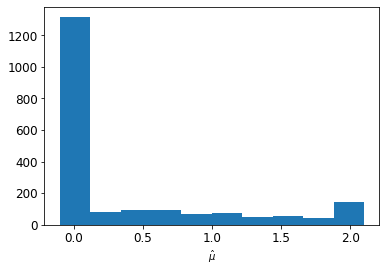

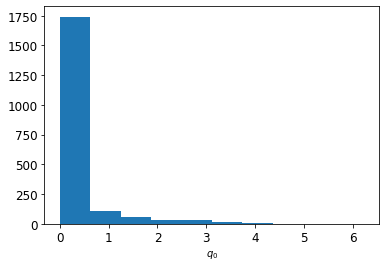

Z:0.0
Z_std:inf
Z_1:0.8504165592731988
Z_std_1:0.6843587233227435
<B> = 147989.1485+/-378.67190871221226
<S> = 21.9795+/-4.685944915382595
3
AUC:0.937460576640456
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

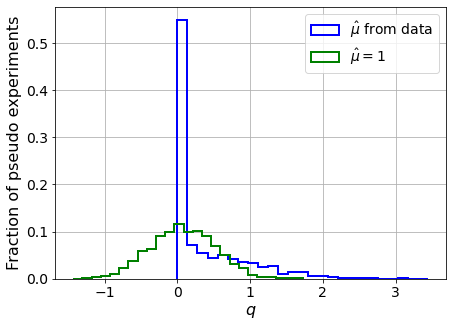

Z BL:(0.24600475077365772, 1.1116954709208104, 0.9909250000000001, 0.2550671052201947, 0.8894250081051913) with 15 bins


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf  8868.31959605
  8560.92987014  8181.99851206  7723.33435208  7169.33476327
  6474.83585355  5627.63921394  4591.050391    3326.82594376
  1786.13912165   -60.43472181 -2241.73467798 -5126.96730035]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  7759.6817566   7677.09357521


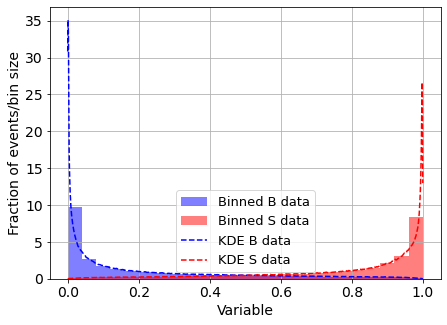

KDE Kernel:  epanechnikov
Background bandwidth:  0.0031053121543406503
Signal bandwidth:  0.0019008479046983867
This may take a while...
1 done
2 done
0.016291081036272602
0.016291081036272602
3 done
4 done
0.01061316818730368
0.01061316818730368
B_expected:  147986
S_expected:  22



  0%|                                                                   | 1/2000 [00:00<14:39,  2.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3139928032495689
<p_{s}(Sdata)> = 6.976952004386952
<p_{b}(Bdata)> = 7.641195170736157
<p_{s}(Bdata)> = 0.29964961322188366


  0%|                                                                   | 2/2000 [00:00<14:40,  2.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21915324411836162
<p_{s}(Sdata)> = 9.71292606783762
<p_{b}(Bdata)> = 7.654331175362028
<p_{s}(Bdata)> = 0.29844886717494107


  0%|                                                                   | 3/2000 [00:01<14:41,  2.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3925960450619207
<p_{s}(Sdata)> = 4.439211644142698
<p_{b}(Bdata)> = 7.598168219242252
<p_{s}(Bdata)> = 0.297469622869843


  0%|▏                                                                  | 4/2000 [00:01<14:44,  2.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28742282556833404
<p_{s}(Sdata)> = 5.118986858187848
<p_{b}(Bdata)> = 7.600392642156426
<p_{s}(Bdata)> = 0.3007191571907624


  0%|▏                                                                  | 6/2000 [00:04<26:12,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46421000452181815
<p_{s}(Sdata)> = 3.8376903643226643
<p_{b}(Bdata)> = 7.579702410551674
<p_{s}(Bdata)> = 0.3019942389361977


  0%|▏                                                                  | 7/2000 [00:04<22:41,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2965136368556851
<p_{s}(Sdata)> = 2.967761354183105
<p_{b}(Bdata)> = 7.5900774989242406
<p_{s}(Bdata)> = 0.3019279294643107


  0%|▎                                                                  | 8/2000 [00:05<20:04,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2165623005974892
<p_{s}(Sdata)> = 5.626237545825988
<p_{b}(Bdata)> = 7.590720002823976
<p_{s}(Bdata)> = 0.3023721191534706


  0%|▎                                                                  | 9/2000 [00:05<18:41,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30157286084547946
<p_{s}(Sdata)> = 2.9908302864288414
<p_{b}(Bdata)> = 7.617286590758058
<p_{s}(Bdata)> = 0.3020454002387238


  0%|▎                                                                 | 10/2000 [00:05<17:25,  1.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5067638298147182
<p_{s}(Sdata)> = 6.644060957212374
<p_{b}(Bdata)> = 7.599242248201038
<p_{s}(Bdata)> = 0.30211695963027657


  1%|▎                                                                 | 11/2000 [00:06<16:34,  2.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41435752398272024
<p_{s}(Sdata)> = 6.4807796571512455
<p_{b}(Bdata)> = 7.59625430535332
<p_{s}(Bdata)> = 0.3005991542884616


  1%|▍                                                                 | 12/2000 [00:06<15:58,  2.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2696049271347928
<p_{s}(Sdata)> = 5.048308086856067
<p_{b}(Bdata)> = 7.541081707606841
<p_{s}(Bdata)> = 0.3023554688311828


  1%|▍                                                                 | 13/2000 [00:07<15:36,  2.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21728280015312965
<p_{s}(Sdata)> = 5.968495668607882
<p_{b}(Bdata)> = 7.617148883680851
<p_{s}(Bdata)> = 0.2989412406422682


  1%|▍                                                                 | 14/2000 [00:07<15:17,  2.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4787424641660362
<p_{s}(Sdata)> = 3.116807582909067
<p_{b}(Bdata)> = 7.6126930735423946
<p_{s}(Bdata)> = 0.2985962535040945


  1%|▍                                                                 | 15/2000 [00:08<15:12,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6689589480082163
<p_{s}(Sdata)> = 4.17120437999155
<p_{b}(Bdata)> = 7.583057870486075
<p_{s}(Bdata)> = 0.3012069193313396


  1%|▌                                                                 | 16/2000 [00:08<15:12,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38001300747779204
<p_{s}(Sdata)> = 2.9230096564151626
<p_{b}(Bdata)> = 7.620859355246849
<p_{s}(Bdata)> = 0.3012713287784648


  1%|▌                                                                 | 17/2000 [00:09<15:05,  2.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29369253175171073
<p_{s}(Sdata)> = 2.19441667318415
<p_{b}(Bdata)> = 7.625102487799154
<p_{s}(Bdata)> = 0.29867849756129966


  1%|▋                                                                 | 20/2000 [00:14<39:09,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.269464488006618
<p_{s}(Sdata)> = 3.6148109799864123
<p_{b}(Bdata)> = 7.531341671092739
<p_{s}(Bdata)> = 0.2996485964096607


  1%|▋                                                                 | 21/2000 [00:14<31:49,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2614465092832688
<p_{s}(Sdata)> = 4.366250588030815
<p_{b}(Bdata)> = 7.626690127269
<p_{s}(Bdata)> = 0.30000657092263605


  1%|▋                                                                 | 22/2000 [00:14<26:36,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.170560455848484
<p_{s}(Sdata)> = 7.183637596993259
<p_{b}(Bdata)> = 7.611201329668996
<p_{s}(Bdata)> = 0.30050397729961337


  1%|▊                                                                 | 23/2000 [00:15<23:03,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2928374720794621
<p_{s}(Sdata)> = 2.8195454104950097
<p_{b}(Bdata)> = 7.594410584961843
<p_{s}(Bdata)> = 0.29844369516537894


  1%|▊                                                                 | 24/2000 [00:15<20:38,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3421499918124468
<p_{s}(Sdata)> = 4.2774628943835165
<p_{b}(Bdata)> = 7.586043726073978
<p_{s}(Bdata)> = 0.30116194897102017


  1%|▊                                                                 | 25/2000 [00:16<18:50,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32604101875348307
<p_{s}(Sdata)> = 4.926237485203825
<p_{b}(Bdata)> = 7.602104213361747
<p_{s}(Bdata)> = 0.30016527293024164


  1%|▉                                                                 | 27/2000 [00:18<23:42,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2253171060575545
<p_{s}(Sdata)> = 6.202103051335136
<p_{b}(Bdata)> = 7.622261513721892
<p_{s}(Bdata)> = 0.29953184511851383


  1%|▉                                                                 | 28/2000 [00:18<20:57,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3116149673149602
<p_{s}(Sdata)> = 4.184308675914718
<p_{b}(Bdata)> = 7.588366320845432
<p_{s}(Bdata)> = 0.30090968790360273


  2%|█                                                                 | 31/2000 [00:24<39:47,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3146521911685452
<p_{s}(Sdata)> = 3.57642880504453
<p_{b}(Bdata)> = 7.577279508663283
<p_{s}(Bdata)> = 0.30219344061131614


  2%|█                                                                 | 33/2000 [00:26<37:09,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.296276061970164
<p_{s}(Sdata)> = 4.533706918367878
<p_{b}(Bdata)> = 7.5959503875486325
<p_{s}(Bdata)> = 0.3019308596996215


  2%|█                                                                 | 34/2000 [00:26<30:20,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2691322174769115
<p_{s}(Sdata)> = 4.046533253184049
<p_{b}(Bdata)> = 7.613634608062428
<p_{s}(Bdata)> = 0.2997985596277741


  2%|█▏                                                                | 35/2000 [00:27<25:37,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6671053940021939
<p_{s}(Sdata)> = 4.629439499663066
<p_{b}(Bdata)> = 7.612050940532517
<p_{s}(Bdata)> = 0.3007260749197351


  2%|█▏                                                                | 36/2000 [00:27<22:19,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26592846834383793
<p_{s}(Sdata)> = 3.798013161115327
<p_{b}(Bdata)> = 7.564102875566571
<p_{s}(Bdata)> = 0.30103449336924765


  2%|█▏                                                                | 37/2000 [00:28<20:03,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34097946406096125
<p_{s}(Sdata)> = 2.316884780080991
<p_{b}(Bdata)> = 7.632615871197341
<p_{s}(Bdata)> = 0.2990003874382459


  2%|█▎                                                                | 38/2000 [00:28<18:36,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19913940070550726
<p_{s}(Sdata)> = 6.870289310338098
<p_{b}(Bdata)> = 7.588610138216697
<p_{s}(Bdata)> = 0.3008983248708348


  2%|█▎                                                                | 39/2000 [00:29<17:19,  1.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19610137971309421
<p_{s}(Sdata)> = 4.909962039028716
<p_{b}(Bdata)> = 7.617902807047079
<p_{s}(Bdata)> = 0.30252350552740903


  2%|█▎                                                                | 40/2000 [00:29<16:31,  1.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2542948005075223
<p_{s}(Sdata)> = 5.481461574046262
<p_{b}(Bdata)> = 7.580899036664075
<p_{s}(Bdata)> = 0.3009592556778684


  2%|█▎                                                                | 41/2000 [00:30<15:59,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28566399013344856
<p_{s}(Sdata)> = 3.7983911729997257
<p_{b}(Bdata)> = 7.599066513697924
<p_{s}(Bdata)> = 0.3026615653271892


  2%|█▍                                                                | 42/2000 [00:30<15:31,  2.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23467590854493373
<p_{s}(Sdata)> = 3.46216878390039
<p_{b}(Bdata)> = 7.594673216258914
<p_{s}(Bdata)> = 0.30098637033975356


  2%|█▍                                                                | 43/2000 [00:30<15:17,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5248893938888276
<p_{s}(Sdata)> = 5.066313176088414
<p_{b}(Bdata)> = 7.631649809830076
<p_{s}(Bdata)> = 0.300119062151407


  2%|█▍                                                                | 44/2000 [00:31<15:02,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22539740577669054
<p_{s}(Sdata)> = 6.311237060822336
<p_{b}(Bdata)> = 7.608375147423873
<p_{s}(Bdata)> = 0.30138322935018214


  2%|█▍                                                                | 45/2000 [00:31<14:54,  2.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25839733755414623
<p_{s}(Sdata)> = 3.9840787966954783
<p_{b}(Bdata)> = 7.58270131696927
<p_{s}(Bdata)> = 0.30048988942958726


  2%|█▌                                                                | 47/2000 [00:34<29:42,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2943791915459359
<p_{s}(Sdata)> = 4.330939779657492
<p_{b}(Bdata)> = 7.623319430161368
<p_{s}(Bdata)> = 0.30203990699998556
muhat = 2.1
<p_{b}(Sdata)> = 0.21571631009025596
<p_{s}(Sdata)> = 10.023426904629947
<p_{b}(Bdata)> = 7.604743535993241
<p_{s}(Bdata)> = 0.3022289155805668


  2%|█▌                                                                | 49/2000 [00:36<23:26,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21435584960028203
<p_{s}(Sdata)> = 5.7425733724085335
<p_{b}(Bdata)> = 7.568174102640639
<p_{s}(Bdata)> = 0.3009889893891807


  2%|█▋                                                                | 50/2000 [00:36<20:52,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.4768641146080839
<p_{s}(Sdata)> = 5.117748728383269
<p_{b}(Bdata)> = 7.617710538668356
<p_{s}(Bdata)> = 0.30008278115146364


  3%|█▋                                                                | 51/2000 [00:36<18:58,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5001806660751195
<p_{s}(Sdata)> = 6.480842599274478
<p_{b}(Bdata)> = 7.574441586699144
<p_{s}(Bdata)> = 0.30052401617713076


  3%|█▋                                                                | 52/2000 [00:37<17:37,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27205641779951895
<p_{s}(Sdata)> = 3.3975023113172993
<p_{b}(Bdata)> = 7.559165389251997
<p_{s}(Bdata)> = 0.30258223666082273


  3%|█▋                                                                | 53/2000 [00:37<16:37,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2330864301709428
<p_{s}(Sdata)> = 4.757750461547347
<p_{b}(Bdata)> = 7.650904223701689
<p_{s}(Bdata)> = 0.30143657249503664


  3%|█▊                                                                | 54/2000 [00:38<15:54,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2375930030244248
<p_{s}(Sdata)> = 5.20256020346769
<p_{b}(Bdata)> = 7.5216230945178335
<p_{s}(Bdata)> = 0.3003016625859926


  3%|█▊                                                                | 55/2000 [00:38<15:22,  2.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47935506045813847
<p_{s}(Sdata)> = 3.2409406332925403
<p_{b}(Bdata)> = 7.593865768272558
<p_{s}(Bdata)> = 0.3014658852703631


  3%|█▊                                                                | 56/2000 [00:39<15:07,  2.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21645498531252502
<p_{s}(Sdata)> = 6.120930411871277
<p_{b}(Bdata)> = 7.605225506876382
<p_{s}(Bdata)> = 0.2993091550246445


  3%|█▉                                                                | 57/2000 [00:39<14:56,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34730046347866916
<p_{s}(Sdata)> = 3.244058275069889
<p_{b}(Bdata)> = 7.569840994457671
<p_{s}(Bdata)> = 0.29918398490842324


  3%|█▉                                                                | 58/2000 [00:40<14:45,  2.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27389197555149225
<p_{s}(Sdata)> = 5.871074266908945
<p_{b}(Bdata)> = 7.586836256399718
<p_{s}(Bdata)> = 0.3012689543780868


  3%|█▉                                                                | 59/2000 [00:40<14:38,  2.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22388705463265118
<p_{s}(Sdata)> = 5.067694781254385
<p_{b}(Bdata)> = 7.581479130914207
<p_{s}(Bdata)> = 0.3019045534343761


  3%|█▉                                                                | 60/2000 [00:40<14:31,  2.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23844584271132221
<p_{s}(Sdata)> = 3.979021299891298
<p_{b}(Bdata)> = 7.622290732741246
<p_{s}(Bdata)> = 0.3008051055933242


  3%|██                                                                | 61/2000 [00:41<14:34,  2.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21842163494560263
<p_{s}(Sdata)> = 6.824379045958787
<p_{b}(Bdata)> = 7.637247195892607
<p_{s}(Bdata)> = 0.3010060577406928


  3%|██                                                                | 63/2000 [00:43<20:02,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2905416126152849
<p_{s}(Sdata)> = 7.61887404510965
<p_{b}(Bdata)> = 7.57161513817792
<p_{s}(Bdata)> = 0.3011714355042692


  3%|██                                                                | 64/2000 [00:43<18:17,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26597566377320214
<p_{s}(Sdata)> = 5.107647479044287
<p_{b}(Bdata)> = 7.661118705459438
<p_{s}(Bdata)> = 0.300569141709854


  3%|██▏                                                               | 66/2000 [00:47<40:37,  1.26s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.25149503547151625
<p_{s}(Sdata)> = 5.162425002145365
<p_{b}(Bdata)> = 7.643495824612178
<p_{s}(Bdata)> = 0.3028154522389408


  3%|██▏                                                               | 67/2000 [00:48<32:55,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23811031486052198
<p_{s}(Sdata)> = 5.0835779527607965
<p_{b}(Bdata)> = 7.575918547440788
<p_{s}(Bdata)> = 0.30265160935626384


  3%|██▏                                                               | 68/2000 [00:48<27:25,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5361787569590447
<p_{s}(Sdata)> = 4.782369302551053
<p_{b}(Bdata)> = 7.561965387381764
<p_{s}(Bdata)> = 0.3017025369205898


  3%|██▎                                                               | 69/2000 [00:49<23:34,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29287391173496286
<p_{s}(Sdata)> = 4.0581701987362075
<p_{b}(Bdata)> = 7.596839295906962
<p_{s}(Bdata)> = 0.30273767532277507


  4%|██▎                                                               | 70/2000 [00:49<21:03,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29629037460280855
<p_{s}(Sdata)> = 4.811579308162157
<p_{b}(Bdata)> = 7.605413202171765
<p_{s}(Bdata)> = 0.29964538303446203


  4%|██▎                                                               | 71/2000 [00:50<19:03,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28178851732772087
<p_{s}(Sdata)> = 5.088352414924627
<p_{b}(Bdata)> = 7.593856630802691
<p_{s}(Bdata)> = 0.30107400825710867


  4%|██▍                                                               | 72/2000 [00:50<17:37,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.416376018266613
<p_{s}(Sdata)> = 3.2590093361377637
<p_{b}(Bdata)> = 7.570338147023305
<p_{s}(Bdata)> = 0.3042091727840571


  4%|██▌                                                               | 79/2000 [01:02<46:14,  1.44s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3955526309168528
<p_{s}(Sdata)> = 2.8987596729220133
<p_{b}(Bdata)> = 7.579630762537009
<p_{s}(Bdata)> = 0.30027928124211584


  4%|██▋                                                               | 80/2000 [01:02<36:35,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2673525638363745
<p_{s}(Sdata)> = 6.6696728648273345
<p_{b}(Bdata)> = 7.580527790027388
<p_{s}(Bdata)> = 0.3006306943764026


  4%|██▋                                                               | 82/2000 [01:06<44:25,  1.39s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2755866723364004
<p_{s}(Sdata)> = 3.7544307716216423
<p_{b}(Bdata)> = 7.614963340881532
<p_{s}(Bdata)> = 0.2996042396297531


  4%|██▋                                                               | 83/2000 [01:07<38:26,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25447045209003255
<p_{s}(Sdata)> = 4.1178770175712796
<p_{b}(Bdata)> = 7.5880839019679875
<p_{s}(Bdata)> = 0.2997649107714728


  4%|██▊                                                               | 86/2000 [01:13<49:39,  1.56s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.45811662353758814
<p_{s}(Sdata)> = 3.6459351258139985
<p_{b}(Bdata)> = 7.602535189473977
<p_{s}(Bdata)> = 0.30099717966127215


  4%|██▊                                                               | 87/2000 [01:13<42:02,  1.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28681227072301235
<p_{s}(Sdata)> = 5.31560619501568
<p_{b}(Bdata)> = 7.62339850759039
<p_{s}(Bdata)> = 0.29990607528416724


  4%|██▉                                                               | 89/2000 [01:16<43:52,  1.38s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24808036876244308
<p_{s}(Sdata)> = 5.114367917515111
<p_{b}(Bdata)> = 7.603825277308525
<p_{s}(Bdata)> = 0.3001980305296635


  4%|██▉                                                               | 90/2000 [01:17<38:04,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3287657189904334
<p_{s}(Sdata)> = 6.2026766859867974
<p_{b}(Bdata)> = 7.57824085361329
<p_{s}(Bdata)> = 0.29958533775900525


  5%|███                                                             | 94/2000 [01:28<1:06:39,  2.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2767222857913957
<p_{s}(Sdata)> = 3.3199207584511696
<p_{b}(Bdata)> = 7.620381040899135
<p_{s}(Bdata)> = 0.2997330359114333
muhat = 2.1
<p_{b}(Sdata)> = 0.22742612675451798
<p_{s}(Sdata)> = 5.933231296050134
<p_{b}(Bdata)> = 7.5951798350227
<p_{s}(Bdata)> = 0.30294027839863286


  5%|███▏                                                              | 96/2000 [01:30<47:17,  1.49s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20679209679025742
<p_{s}(Sdata)> = 4.097279073782653
<p_{b}(Bdata)> = 7.59753885952351
<p_{s}(Bdata)> = 0.2999219612032274


  5%|███▏                                                              | 98/2000 [01:33<49:02,  1.55s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24807409164409777
<p_{s}(Sdata)> = 4.573406937627395
<p_{b}(Bdata)> = 7.547929733533242
<p_{s}(Bdata)> = 0.2994278173552155


  5%|███▎                                                              | 99/2000 [01:34<41:36,  1.31s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2668777593997577
<p_{s}(Sdata)> = 7.083077825920165
<p_{b}(Bdata)> = 7.587709427035575
<p_{s}(Bdata)> = 0.302163676523421


  5%|███▏                                                           | 101/2000 [01:40<1:05:25,  2.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.6512115307787982
<p_{s}(Sdata)> = 7.82672028605053
<p_{b}(Bdata)> = 7.5636104043327075
<p_{s}(Bdata)> = 0.3006130925149666


  5%|███▎                                                             | 102/2000 [01:41<53:04,  1.68s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4316989268844146
<p_{s}(Sdata)> = 5.731156381405809
<p_{b}(Bdata)> = 7.5920786253199815
<p_{s}(Bdata)> = 0.29999284662036657


  5%|███▎                                                             | 103/2000 [01:42<44:17,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2467685012091164
<p_{s}(Sdata)> = 4.851970432856499
<p_{b}(Bdata)> = 7.623327966518786
<p_{s}(Bdata)> = 0.29916107700046374


  5%|███▎                                                           | 105/2000 [01:48<1:04:43,  2.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3447552591630653
<p_{s}(Sdata)> = 4.819344785844915
<p_{b}(Bdata)> = 7.576670292801873
<p_{s}(Bdata)> = 0.30044047024213694


  5%|███▍                                                             | 106/2000 [01:49<52:39,  1.67s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26409493640423587
<p_{s}(Sdata)> = 4.065010022071179
<p_{b}(Bdata)> = 7.607084367071381
<p_{s}(Bdata)> = 0.2996243246448288


  5%|███▍                                                             | 107/2000 [01:50<44:09,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2206447794838757
<p_{s}(Sdata)> = 5.652391409410102
<p_{b}(Bdata)> = 7.497542145441593
<p_{s}(Bdata)> = 0.30237708764787524


  5%|███▌                                                             | 108/2000 [01:50<38:04,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27806881935472966
<p_{s}(Sdata)> = 4.440785670315771
<p_{b}(Bdata)> = 7.574013398392161
<p_{s}(Bdata)> = 0.30238853995577175


  5%|███▌                                                             | 109/2000 [01:51<33:50,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22223824489422592
<p_{s}(Sdata)> = 5.197611783744291
<p_{b}(Bdata)> = 7.5809832490305755
<p_{s}(Bdata)> = 0.30090463282501345


  6%|███▌                                                             | 110/2000 [01:52<30:51,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20916843592505605
<p_{s}(Sdata)> = 3.2751667506491087
<p_{b}(Bdata)> = 7.619868540366933
<p_{s}(Bdata)> = 0.3002274004895965


  6%|███▌                                                             | 111/2000 [01:53<28:51,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3565468400074342
<p_{s}(Sdata)> = 5.780540812903956
<p_{b}(Bdata)> = 7.57976441737337
<p_{s}(Bdata)> = 0.3003334215977944


  6%|███▋                                                             | 112/2000 [01:53<27:28,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29606641981252935
<p_{s}(Sdata)> = 6.2000283121190245
<p_{b}(Bdata)> = 7.592027738005071
<p_{s}(Bdata)> = 0.3002718321035283
muhat = 2.1
<p_{b}(Sdata)> = 0.24155283992283327
<p_{s}(Sdata)> = 4.971844773631625
<p_{b}(Bdata)> = 7.631724154135281
<p_{s}(Bdata)> = 0.30328510384596863


  6%|███▋                                                             | 115/2000 [01:59<48:18,  1.54s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23125980653557168
<p_{s}(Sdata)> = 7.339858100134397
<p_{b}(Bdata)> = 7.620280893993015
<p_{s}(Bdata)> = 0.29954755351667844


  6%|███▊                                                             | 116/2000 [02:00<40:58,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3080131575847291
<p_{s}(Sdata)> = 5.354189716128724
<p_{b}(Bdata)> = 7.5911140493042435
<p_{s}(Bdata)> = 0.3002932750075737


  6%|███▊                                                             | 117/2000 [02:01<35:48,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3006592267557926
<p_{s}(Sdata)> = 6.493025417914967
<p_{b}(Bdata)> = 7.548725316485004
<p_{s}(Bdata)> = 0.30164494668909847


  6%|███▊                                                             | 119/2000 [02:05<47:48,  1.53s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23722891302670224
<p_{s}(Sdata)> = 3.8288209650208085
<p_{b}(Bdata)> = 7.594898086193598
<p_{s}(Bdata)> = 0.30031911221227325


  6%|███▉                                                             | 120/2000 [02:06<40:43,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25856883260696334
<p_{s}(Sdata)> = 5.232117877703746
<p_{b}(Bdata)> = 7.582490712895969
<p_{s}(Bdata)> = 0.29978981699471763


  6%|███▉                                                           | 124/2000 [02:22<1:29:39,  2.87s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2174145510821917
<p_{s}(Sdata)> = 6.85170703686822
<p_{b}(Bdata)> = 7.617084550101646
<p_{s}(Bdata)> = 0.3000462591845943


  6%|███▉                                                           | 125/2000 [02:23<1:09:53,  2.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27616674468375324
<p_{s}(Sdata)> = 4.878036703248921
<p_{b}(Bdata)> = 7.5761408009065345
<p_{s}(Bdata)> = 0.30028292766473863


  6%|████                                                             | 126/2000 [02:24<56:04,  1.80s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28884957679121154
<p_{s}(Sdata)> = 3.5143099102398625
<p_{b}(Bdata)> = 7.622402944312091
<p_{s}(Bdata)> = 0.3007449448748458


  6%|████▏                                                            | 127/2000 [02:25<46:28,  1.49s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.47613449591652557
<p_{s}(Sdata)> = 4.993283632962273
<p_{b}(Bdata)> = 7.594666059374454
<p_{s}(Bdata)> = 0.3018194199531901


  6%|████▏                                                            | 128/2000 [02:25<39:37,  1.27s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.43994658567104067
<p_{s}(Sdata)> = 4.002902509825133
<p_{b}(Bdata)> = 7.634680664262271
<p_{s}(Bdata)> = 0.3013229264041277


  6%|████▏                                                            | 129/2000 [02:26<34:48,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2512453569638366
<p_{s}(Sdata)> = 6.909236978128525
<p_{b}(Bdata)> = 7.592568107059709
<p_{s}(Bdata)> = 0.30000610524049753


  6%|████▏                                                            | 130/2000 [02:27<31:29,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.35316093314777913
<p_{s}(Sdata)> = 2.9215341257911307
<p_{b}(Bdata)> = 7.553878740954354
<p_{s}(Bdata)> = 0.3017830392588829


  7%|████▎                                                            | 132/2000 [02:32<52:55,  1.70s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20776776879558403
<p_{s}(Sdata)> = 5.875657161933769
<p_{b}(Bdata)> = 7.617210898409625
<p_{s}(Bdata)> = 0.3015104365339176


  7%|████▎                                                            | 133/2000 [02:33<44:09,  1.42s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2935738667667958
<p_{s}(Sdata)> = 5.085623866049926
<p_{b}(Bdata)> = 7.63538022597498
<p_{s}(Bdata)> = 0.30023994219296485


  7%|████▎                                                            | 134/2000 [02:34<37:59,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21711204323949446
<p_{s}(Sdata)> = 4.321998786290894
<p_{b}(Bdata)> = 7.56211965678683
<p_{s}(Bdata)> = 0.30255574613791847


  7%|████▍                                                            | 135/2000 [02:35<33:41,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3177982268064945
<p_{s}(Sdata)> = 4.69433241745748
<p_{b}(Bdata)> = 7.514027055106189
<p_{s}(Bdata)> = 0.30375197676356375


  7%|████▍                                                            | 138/2000 [02:39<41:57,  1.35s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5121680939862094
<p_{s}(Sdata)> = 4.496522172326312
<p_{b}(Bdata)> = 7.592069589479024
<p_{s}(Bdata)> = 0.30247530780093984


  7%|████▌                                                            | 139/2000 [02:40<36:24,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4461407194148658
<p_{s}(Sdata)> = 4.186046428179016
<p_{b}(Bdata)> = 7.5801042132218495
<p_{s}(Bdata)> = 0.3007177046250538


  7%|████▌                                                            | 140/2000 [02:41<32:29,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2997660636411305
<p_{s}(Sdata)> = 3.978510990749886
<p_{b}(Bdata)> = 7.621144121534081
<p_{s}(Bdata)> = 0.2995990553008674


  7%|████▌                                                            | 142/2000 [02:45<42:34,  1.37s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2015755079786235
<p_{s}(Sdata)> = 5.675368851451607
<p_{b}(Bdata)> = 7.576859724816775
<p_{s}(Bdata)> = 0.30059362145644564


  7%|████▋                                                            | 143/2000 [02:46<36:54,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26009623594125714
<p_{s}(Sdata)> = 4.9994136484644205
<p_{b}(Bdata)> = 7.651360706666023
<p_{s}(Bdata)> = 0.2999783814412828


  7%|████▋                                                            | 144/2000 [02:46<32:56,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.32621301088581944
<p_{s}(Sdata)> = 4.538819969625129
<p_{b}(Bdata)> = 7.629190911828258
<p_{s}(Bdata)> = 0.3020050914890878


  7%|████▋                                                            | 146/2000 [02:50<40:23,  1.31s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30501622450368704
<p_{s}(Sdata)> = 2.2725306950719144
<p_{b}(Bdata)> = 7.621125511064797
<p_{s}(Bdata)> = 0.2993383942399453


  7%|████▊                                                            | 147/2000 [02:51<35:39,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3898465158982087
<p_{s}(Sdata)> = 3.1972758962453427
<p_{b}(Bdata)> = 7.558771214849034
<p_{s}(Bdata)> = 0.30207364969098766


  7%|████▊                                                            | 148/2000 [02:51<32:01,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25337813049950825
<p_{s}(Sdata)> = 5.4413620396616516
<p_{b}(Bdata)> = 7.534069238697376
<p_{s}(Bdata)> = 0.3009755059469233


  8%|████▉                                                            | 150/2000 [02:54<37:31,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27912494007339556
<p_{s}(Sdata)> = 4.689886532219727
<p_{b}(Bdata)> = 7.629405569297733
<p_{s}(Bdata)> = 0.29967984564204175


  8%|████▉                                                            | 151/2000 [02:55<33:24,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.43408880542936323
<p_{s}(Sdata)> = 3.554490032827548
<p_{b}(Bdata)> = 7.603714159734981
<p_{s}(Bdata)> = 0.2996017918616386


  8%|████▉                                                            | 153/2000 [02:59<46:52,  1.52s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23531424763811915
<p_{s}(Sdata)> = 3.67094998581069
<p_{b}(Bdata)> = 7.629987264730124
<p_{s}(Bdata)> = 0.2985855103458549


  8%|█████                                                            | 154/2000 [03:00<39:50,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17464348743102595
<p_{s}(Sdata)> = 6.653321841959278
<p_{b}(Bdata)> = 7.589771237119649
<p_{s}(Bdata)> = 0.3002586842717274


  8%|█████                                                            | 156/2000 [03:04<42:52,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33616420991151286
<p_{s}(Sdata)> = 3.992227404478707
<p_{b}(Bdata)> = 7.61949353375168
<p_{s}(Bdata)> = 0.3000658286650345


  8%|█████▏                                                           | 158/2000 [03:07<44:40,  1.46s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.36717910289709377
<p_{s}(Sdata)> = 3.0676061554487597
<p_{b}(Bdata)> = 7.605139825828621
<p_{s}(Bdata)> = 0.299942536600969


  8%|█████▏                                                           | 159/2000 [03:08<38:22,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4283552748524446
<p_{s}(Sdata)> = 5.165607482508924
<p_{b}(Bdata)> = 7.593046841683555
<p_{s}(Bdata)> = 0.30076460758265355


  8%|█████▎                                                           | 162/2000 [03:16<58:17,  1.90s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.36403531689467444
<p_{s}(Sdata)> = 4.588943364906095
<p_{b}(Bdata)> = 7.65473457973648
<p_{s}(Bdata)> = 0.30047597896678263


  8%|█████▎                                                           | 163/2000 [03:16<47:47,  1.56s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.48581657544831086
<p_{s}(Sdata)> = 5.736617854954934
<p_{b}(Bdata)> = 7.612600159959245
<p_{s}(Bdata)> = 0.3001939773539652


  8%|█████▍                                                           | 166/2000 [03:20<40:05,  1.31s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27222822233247723
<p_{s}(Sdata)> = 5.781159167601708
<p_{b}(Bdata)> = 7.59756414101795
<p_{s}(Bdata)> = 0.30142981698564764


  8%|█████▍                                                           | 167/2000 [03:21<35:09,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.48672923800172585
<p_{s}(Sdata)> = 3.3038488204541503
<p_{b}(Bdata)> = 7.585939695006426
<p_{s}(Bdata)> = 0.3010434395139164


  8%|█████▍                                                           | 169/2000 [03:24<40:24,  1.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22188184254211166
<p_{s}(Sdata)> = 5.466808042189565
<p_{b}(Bdata)> = 7.59034086438363
<p_{s}(Bdata)> = 0.3024905919507615


  8%|█████▌                                                           | 170/2000 [03:25<35:17,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24641317910317184
<p_{s}(Sdata)> = 5.200082365893158
<p_{b}(Bdata)> = 7.569589814583077
<p_{s}(Bdata)> = 0.3006834893990171


  9%|█████▌                                                           | 171/2000 [03:26<31:39,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.6876118177544196
<p_{s}(Sdata)> = 4.725195166146057
<p_{b}(Bdata)> = 7.574495560475496
<p_{s}(Bdata)> = 0.29947459308991803


  9%|█████▌                                                           | 172/2000 [03:27<29:08,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31879496823864234
<p_{s}(Sdata)> = 1.8053055748565996
<p_{b}(Bdata)> = 7.600400020440268
<p_{s}(Bdata)> = 0.30056389973323205


  9%|█████▌                                                           | 173/2000 [03:27<27:21,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24515975373716142
<p_{s}(Sdata)> = 7.147839858035699
<p_{b}(Bdata)> = 7.576080943440656
<p_{s}(Bdata)> = 0.2989375467799113


  9%|█████▋                                                           | 174/2000 [03:28<26:09,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30725373011442736
<p_{s}(Sdata)> = 3.8606108223502216
<p_{b}(Bdata)> = 7.605664887629859
<p_{s}(Bdata)> = 0.2997624592999821


  9%|█████▋                                                           | 175/2000 [03:29<25:16,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5664890355940448
<p_{s}(Sdata)> = 3.128448253010098
<p_{b}(Bdata)> = 7.609360311986099
<p_{s}(Bdata)> = 0.30017664066980987


  9%|█████▋                                                           | 176/2000 [03:30<24:37,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20287980054294083
<p_{s}(Sdata)> = 6.047813751254223
<p_{b}(Bdata)> = 7.5909434290689
<p_{s}(Bdata)> = 0.3020582878876506


  9%|█████▊                                                           | 177/2000 [03:30<24:11,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29624298665483495
<p_{s}(Sdata)> = 4.35852812663291
<p_{b}(Bdata)> = 7.60380001166972
<p_{s}(Bdata)> = 0.30047126475526126


  9%|█████▊                                                           | 178/2000 [03:31<23:49,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5638919536765973
<p_{s}(Sdata)> = 6.126913451840093
<p_{b}(Bdata)> = 7.584902285538777
<p_{s}(Bdata)> = 0.30238279667980367


  9%|█████▊                                                           | 179/2000 [03:32<23:38,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2562266425452223
<p_{s}(Sdata)> = 5.2177969215127264
<p_{b}(Bdata)> = 7.617883179356049
<p_{s}(Bdata)> = 0.30105088450877826


  9%|█████▊                                                           | 180/2000 [03:33<23:24,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26389876329184714
<p_{s}(Sdata)> = 5.986489805452422
<p_{b}(Bdata)> = 7.6013107503724076
<p_{s}(Bdata)> = 0.30153229138339427


  9%|█████▉                                                           | 181/2000 [03:33<23:22,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27951552024593285
<p_{s}(Sdata)> = 4.5510672393563185
<p_{b}(Bdata)> = 7.600697513431181
<p_{s}(Bdata)> = 0.30116300408918173


  9%|█████▉                                                           | 182/2000 [03:34<23:15,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23160085905550196
<p_{s}(Sdata)> = 5.014499663470963
<p_{b}(Bdata)> = 7.638198075229405
<p_{s}(Bdata)> = 0.30088279445803223


  9%|█████▉                                                           | 183/2000 [03:35<23:11,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3075579156852739
<p_{s}(Sdata)> = 4.685033507779471
<p_{b}(Bdata)> = 7.580218089805266
<p_{s}(Bdata)> = 0.3032024805647446


  9%|█████▉                                                           | 184/2000 [03:36<23:12,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5526257531688259
<p_{s}(Sdata)> = 4.600736139191379
<p_{b}(Bdata)> = 7.585953625154277
<p_{s}(Bdata)> = 0.3008508338351471


  9%|██████                                                           | 186/2000 [03:39<33:19,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2571660929252769
<p_{s}(Sdata)> = 4.269141895987575
<p_{b}(Bdata)> = 7.60436599730165
<p_{s}(Bdata)> = 0.30052571271587175


  9%|██████                                                           | 187/2000 [03:40<30:11,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3539148116690853
<p_{s}(Sdata)> = 3.3405209646952274
<p_{b}(Bdata)> = 7.609425398503174
<p_{s}(Bdata)> = 0.2995292866229597


  9%|██████                                                           | 188/2000 [03:40<28:02,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22313048600473612
<p_{s}(Sdata)> = 3.9275469006649244
<p_{b}(Bdata)> = 7.5967781665093455
<p_{s}(Bdata)> = 0.3002480057367509


 10%|██████                                                         | 191/2000 [03:52<1:11:06,  2.36s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5100366270328216
<p_{s}(Sdata)> = 3.9408664963293782
<p_{b}(Bdata)> = 7.570704822543152
<p_{s}(Bdata)> = 0.3026287315192302


 10%|██████▏                                                          | 192/2000 [03:52<56:42,  1.88s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24711395493914365
<p_{s}(Sdata)> = 4.04860013074147
<p_{b}(Bdata)> = 7.60649471585206
<p_{s}(Bdata)> = 0.30182394896234027


 10%|██████▎                                                          | 193/2000 [03:53<46:32,  1.55s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23356078998947175
<p_{s}(Sdata)> = 3.510968056484746
<p_{b}(Bdata)> = 7.597030852172752
<p_{s}(Bdata)> = 0.30094115555134243


 10%|██████▎                                                          | 195/2000 [03:56<44:04,  1.47s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27933785119419235
<p_{s}(Sdata)> = 4.4600472455297915
<p_{b}(Bdata)> = 7.617294056537989
<p_{s}(Bdata)> = 0.302842239397702


 10%|██████▎                                                          | 196/2000 [03:57<37:42,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3359983726788245
<p_{s}(Sdata)> = 5.411201735043289
<p_{b}(Bdata)> = 7.6508766078249
<p_{s}(Bdata)> = 0.30029656222788137


 10%|██████▍                                                          | 197/2000 [03:58<33:14,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21398876230393934
<p_{s}(Sdata)> = 5.262556093535165
<p_{b}(Bdata)> = 7.654094529226523
<p_{s}(Bdata)> = 0.3013293617494908


 10%|██████▌                                                          | 200/2000 [04:03<45:38,  1.52s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.40391859646581435
<p_{s}(Sdata)> = 5.966255774594367
<p_{b}(Bdata)> = 7.556253352477905
<p_{s}(Bdata)> = 0.3026115597280205


 10%|██████▍                                                        | 203/2000 [04:12<1:04:00,  2.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2869975056766449
<p_{s}(Sdata)> = 3.245401188669949
<p_{b}(Bdata)> = 7.608306269487535
<p_{s}(Bdata)> = 0.301387820057659


 10%|██████▋                                                          | 204/2000 [04:12<51:36,  1.72s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4050433871015122
<p_{s}(Sdata)> = 5.558337596627609
<p_{b}(Bdata)> = 7.598216316593466
<p_{s}(Bdata)> = 0.30178541411771875


 10%|██████▋                                                          | 205/2000 [04:13<42:59,  1.44s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.368364443714883
<p_{s}(Sdata)> = 5.479471584266614
<p_{b}(Bdata)> = 7.6124759344418
<p_{s}(Bdata)> = 0.3016075992690296


 10%|██████▋                                                          | 206/2000 [04:14<36:53,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3288918690608816
<p_{s}(Sdata)> = 3.6889051285426793
<p_{b}(Bdata)> = 7.600127334297613
<p_{s}(Bdata)> = 0.29987746305796564


 10%|██████▊                                                          | 208/2000 [04:19<50:30,  1.69s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2756827496659494
<p_{s}(Sdata)> = 5.922809081618884
<p_{b}(Bdata)> = 7.642312725917703
<p_{s}(Bdata)> = 0.30113487870581523


 10%|██████▌                                                        | 210/2000 [04:24<1:01:07,  2.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2623620365520874
<p_{s}(Sdata)> = 4.190826106917762
<p_{b}(Bdata)> = 7.591502156376132
<p_{s}(Bdata)> = 0.30182853392137504


 11%|██████▉                                                          | 212/2000 [04:28<55:32,  1.86s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.34226309834115304
<p_{s}(Sdata)> = 2.490029984669753
<p_{b}(Bdata)> = 7.615772750998773
<p_{s}(Bdata)> = 0.2999562881326734


 11%|██████▉                                                          | 213/2000 [04:29<45:40,  1.53s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23286944586931638
<p_{s}(Sdata)> = 5.837691005369828
<p_{b}(Bdata)> = 7.604669387249259
<p_{s}(Bdata)> = 0.30039669948329173


 11%|██████▉                                                          | 215/2000 [04:34<56:25,  1.90s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4197859433387817
<p_{s}(Sdata)> = 5.386354436365194
<p_{b}(Bdata)> = 7.6198226932734725
<p_{s}(Bdata)> = 0.3009528682368958


 11%|███████                                                          | 216/2000 [04:35<46:15,  1.56s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3856971966659454
<p_{s}(Sdata)> = 3.1135631852779984
<p_{b}(Bdata)> = 7.591731790625944
<p_{s}(Bdata)> = 0.30227354858896566


 11%|███████                                                          | 217/2000 [04:35<39:17,  1.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3885828978535659
<p_{s}(Sdata)> = 4.538729885849737
<p_{b}(Bdata)> = 7.653863077050933
<p_{s}(Bdata)> = 0.2991180506138043


 11%|███████                                                          | 218/2000 [04:36<34:28,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3410849528415804
<p_{s}(Sdata)> = 4.597403686895151
<p_{b}(Bdata)> = 7.618433908737905
<p_{s}(Bdata)> = 0.29894759174136504


 11%|███████                                                          | 219/2000 [04:37<31:01,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2673509222341688
<p_{s}(Sdata)> = 6.282284485300505
<p_{b}(Bdata)> = 7.629058149084996
<p_{s}(Bdata)> = 0.2997187151288639


 11%|███████▏                                                         | 220/2000 [04:38<28:32,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38358919833122257
<p_{s}(Sdata)> = 3.17924887307267
<p_{b}(Bdata)> = 7.574733226504111
<p_{s}(Bdata)> = 0.30029431317011107


 11%|███████▏                                                         | 221/2000 [04:39<26:48,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4677325720686792
<p_{s}(Sdata)> = 4.12287079310159
<p_{b}(Bdata)> = 7.586475538814628
<p_{s}(Bdata)> = 0.30325082591535013


 11%|███████▏                                                         | 222/2000 [04:39<25:37,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22469334068521057
<p_{s}(Sdata)> = 4.735380906795404
<p_{b}(Bdata)> = 7.579327795966402
<p_{s}(Bdata)> = 0.30111905718941595


 11%|███████▏                                                         | 223/2000 [04:40<24:41,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47111614452477674
<p_{s}(Sdata)> = 4.19332482076326
<p_{b}(Bdata)> = 7.63528080771831
<p_{s}(Bdata)> = 0.30068841045609157


 11%|███████▎                                                         | 224/2000 [04:41<24:03,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3534513959524291
<p_{s}(Sdata)> = 4.962913558502531
<p_{b}(Bdata)> = 7.586389283839123
<p_{s}(Bdata)> = 0.29915933294203745


 11%|███████▎                                                         | 225/2000 [04:42<23:34,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2172689444926982
<p_{s}(Sdata)> = 6.594296116645196
<p_{b}(Bdata)> = 7.580984974483421
<p_{s}(Bdata)> = 0.29943714518540765


 11%|███████▎                                                         | 226/2000 [04:42<23:25,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3472989462120846
<p_{s}(Sdata)> = 3.7249761984272793
<p_{b}(Bdata)> = 7.56832397006378
<p_{s}(Bdata)> = 0.30159318922735334


 11%|███████▍                                                         | 228/2000 [04:45<31:32,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23469958683506795
<p_{s}(Sdata)> = 7.1441154725781315
<p_{b}(Bdata)> = 7.558780282493315
<p_{s}(Bdata)> = 0.30141593428638264


 11%|███████▍                                                         | 229/2000 [04:46<28:48,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42441923835276674
<p_{s}(Sdata)> = 4.293567292025007
<p_{b}(Bdata)> = 7.598188378708679
<p_{s}(Bdata)> = 0.3013906111107709


 12%|███████▍                                                         | 230/2000 [04:47<26:52,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2593901663003484
<p_{s}(Sdata)> = 8.687643288655924
<p_{b}(Bdata)> = 7.59279504399632
<p_{s}(Bdata)> = 0.29908140708335096


 12%|███████▌                                                         | 232/2000 [04:49<30:08,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3137543557076786
<p_{s}(Sdata)> = 5.538587865677026
<p_{b}(Bdata)> = 7.581828541026179
<p_{s}(Bdata)> = 0.3006312730791788


 12%|███████▌                                                         | 233/2000 [04:50<27:49,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2681857560195682
<p_{s}(Sdata)> = 3.1708044676657035
<p_{b}(Bdata)> = 7.658706713604505
<p_{s}(Bdata)> = 0.3003275134427438


 12%|███████▌                                                         | 234/2000 [04:51<26:18,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33539499908477854
<p_{s}(Sdata)> = 3.7537135408187297
<p_{b}(Bdata)> = 7.6235972011218
<p_{s}(Bdata)> = 0.2989134039373364


 12%|███████▋                                                         | 235/2000 [04:52<25:14,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2684931116905378
<p_{s}(Sdata)> = 5.161129417038017
<p_{b}(Bdata)> = 7.579567919220492
<p_{s}(Bdata)> = 0.30189988157540976


 12%|███████▋                                                         | 238/2000 [05:01<58:23,  1.99s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26723892724449544
<p_{s}(Sdata)> = 5.948549799785383
<p_{b}(Bdata)> = 7.593060125788249
<p_{s}(Bdata)> = 0.30227907875591326


 12%|███████▊                                                         | 239/2000 [05:02<47:32,  1.62s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.44419396866463
<p_{s}(Sdata)> = 5.326370588617657
<p_{b}(Bdata)> = 7.586344015816256
<p_{s}(Bdata)> = 0.2996995217944782


 12%|███████▊                                                         | 240/2000 [05:02<39:55,  1.36s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2826334850094102
<p_{s}(Sdata)> = 5.807617683969661
<p_{b}(Bdata)> = 7.557433050950343
<p_{s}(Bdata)> = 0.30022765435509546


 12%|███████▊                                                         | 241/2000 [05:03<34:35,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33490454740080144
<p_{s}(Sdata)> = 4.67545434209406
<p_{b}(Bdata)> = 7.618393764179405
<p_{s}(Bdata)> = 0.30091501855899566


 12%|███████▉                                                         | 243/2000 [05:07<39:44,  1.36s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25854801520719217
<p_{s}(Sdata)> = 4.597244370218936
<p_{b}(Bdata)> = 7.664233296730933
<p_{s}(Bdata)> = 0.30121730987318324


 12%|███████▉                                                         | 244/2000 [05:07<34:33,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3661720605160951
<p_{s}(Sdata)> = 4.891528689991367
<p_{b}(Bdata)> = 7.579268436950249
<p_{s}(Bdata)> = 0.30132112392897736


 12%|███████▉                                                         | 245/2000 [05:08<30:58,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22317039949900316
<p_{s}(Sdata)> = 6.051285349543233
<p_{b}(Bdata)> = 7.580451970002869
<p_{s}(Bdata)> = 0.2993711946522587


 12%|████████                                                         | 247/2000 [05:15<57:49,  1.98s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24246176594006072
<p_{s}(Sdata)> = 4.693220791236414
<p_{b}(Bdata)> = 7.6162251422487985
<p_{s}(Bdata)> = 0.29835351501039553


 12%|████████                                                         | 248/2000 [05:15<47:19,  1.62s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.47699459473111033
<p_{s}(Sdata)> = 3.9749303390476998
<p_{b}(Bdata)> = 7.604048307851732
<p_{s}(Bdata)> = 0.3021372071188062


 12%|████████▏                                                        | 250/2000 [05:19<48:22,  1.66s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28789777229353064
<p_{s}(Sdata)> = 4.820174965439081
<p_{b}(Bdata)> = 7.5593306554445725
<p_{s}(Bdata)> = 0.30235165188626684


 13%|████████▏                                                        | 251/2000 [05:20<40:32,  1.39s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3416168793492136
<p_{s}(Sdata)> = 2.798097542606906
<p_{b}(Bdata)> = 7.566205944577975
<p_{s}(Bdata)> = 0.29987547187056945


 13%|████████▏                                                        | 252/2000 [05:21<35:06,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24784106353044724
<p_{s}(Sdata)> = 4.987277377779411
<p_{b}(Bdata)> = 7.649031393154063
<p_{s}(Bdata)> = 0.3007735863591827


 13%|████████▏                                                        | 253/2000 [05:22<31:24,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.40874920172023627
<p_{s}(Sdata)> = 5.237167776645222
<p_{b}(Bdata)> = 7.6225967023102355
<p_{s}(Bdata)> = 0.30134149036406455


 13%|████████▎                                                        | 254/2000 [05:22<28:40,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34794902727520494
<p_{s}(Sdata)> = 3.818251469523507
<p_{b}(Bdata)> = 7.594339177629164
<p_{s}(Bdata)> = 0.30064442902264676


 13%|████████▎                                                        | 255/2000 [05:23<26:53,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.256983362956234
<p_{s}(Sdata)> = 3.539013206372922
<p_{b}(Bdata)> = 7.598350454859402
<p_{s}(Bdata)> = 0.3007545185636873


 13%|████████▎                                                        | 256/2000 [05:24<25:27,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2724626826796266
<p_{s}(Sdata)> = 5.309971584552756
<p_{b}(Bdata)> = 7.627855627819744
<p_{s}(Bdata)> = 0.29929390837465625


 13%|████████▎                                                        | 257/2000 [05:25<24:26,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29209403632715686
<p_{s}(Sdata)> = 4.895819774016587
<p_{b}(Bdata)> = 7.639877751735523
<p_{s}(Bdata)> = 0.3014391266191203


 13%|████████▍                                                        | 259/2000 [05:30<48:28,  1.67s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.15645541276252975
<p_{s}(Sdata)> = 9.03111226777605
<p_{b}(Bdata)> = 7.599439377486597
<p_{s}(Bdata)> = 0.29849590076895005
muhat = 2.1
<p_{b}(Sdata)> = 0.34613513357534803
<p_{s}(Sdata)> = 6.762254361889203
<p_{b}(Bdata)> = 7.602874306463365
<p_{s}(Bdata)> = 0.3033624157338607


 13%|████████▌                                                        | 262/2000 [05:35<46:58,  1.62s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23874409991568374
<p_{s}(Sdata)> = 3.463340613257369
<p_{b}(Bdata)> = 7.620556761882773
<p_{s}(Bdata)> = 0.3013252411976607


 13%|████████▌                                                        | 264/2000 [05:38<40:17,  1.39s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.32777462650440403
<p_{s}(Sdata)> = 4.497281908959529
<p_{b}(Bdata)> = 7.591470601934774
<p_{s}(Bdata)> = 0.30080817299178947


 13%|████████▌                                                        | 265/2000 [05:39<34:50,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18697486579170045
<p_{s}(Sdata)> = 6.609125360271009
<p_{b}(Bdata)> = 7.6407634574795456
<p_{s}(Bdata)> = 0.30034495913680087


 13%|████████▋                                                        | 266/2000 [05:39<30:56,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.35257712809210257
<p_{s}(Sdata)> = 5.114959764827229
<p_{b}(Bdata)> = 7.557258498289487
<p_{s}(Bdata)> = 0.30180342107275115
muhat = 2.1
<p_{b}(Sdata)> = 0.5327840405423214
<p_{s}(Sdata)> = 4.1176871812144045
<p_{b}(Bdata)> = 7.57586432375542
<p_{s}(Bdata)> = 0.30435602312441407


 14%|████████▊                                                        | 270/2000 [05:45<34:50,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25150514769075544
<p_{s}(Sdata)> = 4.11233091685133
<p_{b}(Bdata)> = 7.558373888338297
<p_{s}(Bdata)> = 0.3018896863268867


 14%|████████▊                                                        | 271/2000 [05:45<30:56,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.36894090374794
<p_{s}(Sdata)> = 4.118109780969991
<p_{b}(Bdata)> = 7.619996894709919
<p_{s}(Bdata)> = 0.3014334607557582


 14%|████████▊                                                        | 272/2000 [05:46<28:18,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31738570057315824
<p_{s}(Sdata)> = 5.408836024435912
<p_{b}(Bdata)> = 7.5958769236657355
<p_{s}(Bdata)> = 0.30100067256164587


 14%|████████▊                                                        | 273/2000 [05:47<26:23,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.387536422285635
<p_{s}(Sdata)> = 2.837770654367556
<p_{b}(Bdata)> = 7.606799956833579
<p_{s}(Bdata)> = 0.2982335022191418


 14%|████████▉                                                        | 275/2000 [05:51<39:41,  1.38s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.595401851756474
<p_{s}(Sdata)> = 7.256470089034993
<p_{b}(Bdata)> = 7.617718801260228
<p_{s}(Bdata)> = 0.30055690109951716


 14%|█████████                                                        | 277/2000 [05:54<38:19,  1.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27425882535040835
<p_{s}(Sdata)> = 4.59293961583627
<p_{b}(Bdata)> = 7.5973663212239195
<p_{s}(Bdata)> = 0.30129661926727724


 14%|█████████                                                        | 278/2000 [05:55<33:21,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.260486776653498
<p_{s}(Sdata)> = 4.192825565465077
<p_{b}(Bdata)> = 7.596597326735783
<p_{s}(Bdata)> = 0.3009363539915136


 14%|█████████▏                                                       | 281/2000 [06:03<58:08,  2.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19435103739877319
<p_{s}(Sdata)> = 5.235888926758317
<p_{b}(Bdata)> = 7.564472302047851
<p_{s}(Bdata)> = 0.30252655551302493


 14%|█████████▏                                                       | 283/2000 [06:05<46:36,  1.63s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5083105468850968
<p_{s}(Sdata)> = 3.7175805284625194
<p_{b}(Bdata)> = 7.611997403222401
<p_{s}(Bdata)> = 0.2985489469737993


 14%|█████████▎                                                       | 287/2000 [06:15<58:58,  2.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3529784032403964
<p_{s}(Sdata)> = 5.363016348347632
<p_{b}(Bdata)> = 7.615272125257314
<p_{s}(Bdata)> = 0.30423431437184206


 14%|█████████▎                                                       | 288/2000 [06:16<47:48,  1.68s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2756705269038082
<p_{s}(Sdata)> = 5.421337266602066
<p_{b}(Bdata)> = 7.594252723439485
<p_{s}(Bdata)> = 0.29988121412307867


 14%|█████████▍                                                       | 289/2000 [06:17<40:01,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3217833448330117
<p_{s}(Sdata)> = 4.216032303667642
<p_{b}(Bdata)> = 7.57332871025325
<p_{s}(Bdata)> = 0.30093537575272683


 14%|█████████▍                                                       | 290/2000 [06:18<34:28,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33056100729942195
<p_{s}(Sdata)> = 2.455822745206395
<p_{b}(Bdata)> = 7.6181133375830274
<p_{s}(Bdata)> = 0.2985520693690205


 15%|█████████▍                                                       | 292/2000 [06:22<43:10,  1.52s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26299087155844647
<p_{s}(Sdata)> = 4.928163365929446
<p_{b}(Bdata)> = 7.597204995864475
<p_{s}(Bdata)> = 0.29805945528745004
muhat = 2.1
<p_{b}(Sdata)> = 0.2357441259219183
<p_{s}(Sdata)> = 5.527421025340598
<p_{b}(Bdata)> = 7.627413912804859
<p_{s}(Bdata)> = 0.304461833141654


 15%|█████████▌                                                       | 295/2000 [06:27<44:41,  1.57s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26947381689957134
<p_{s}(Sdata)> = 6.374770813252809
<p_{b}(Bdata)> = 7.5999602717484
<p_{s}(Bdata)> = 0.29732637543724416


 15%|█████████▌                                                       | 296/2000 [06:27<37:48,  1.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23927996928346798
<p_{s}(Sdata)> = 5.312602581474368
<p_{b}(Bdata)> = 7.608934497094309
<p_{s}(Bdata)> = 0.2987885708655452


 15%|█████████▋                                                       | 297/2000 [06:28<32:56,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2162184688372517
<p_{s}(Sdata)> = 6.306712182124495
<p_{b}(Bdata)> = 7.62957173028804
<p_{s}(Bdata)> = 0.30002561064402516


 15%|█████████▋                                                       | 299/2000 [06:32<39:12,  1.38s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3955529775530598
<p_{s}(Sdata)> = 2.8858625483550377
<p_{b}(Bdata)> = 7.541881925042119
<p_{s}(Bdata)> = 0.30255670428271386


 15%|█████████▊                                                       | 301/2000 [06:35<37:48,  1.34s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25387721821982484
<p_{s}(Sdata)> = 6.870756893692996
<p_{b}(Bdata)> = 7.584183766429376
<p_{s}(Bdata)> = 0.3022159233520796


 15%|█████████▊                                                       | 302/2000 [06:35<32:58,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3123072941509638
<p_{s}(Sdata)> = 5.102472337326008
<p_{b}(Bdata)> = 7.579338202555475
<p_{s}(Bdata)> = 0.3016832763612928


 15%|█████████▉                                                       | 304/2000 [06:40<47:56,  1.70s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2546232414486247
<p_{s}(Sdata)> = 4.355185627987875
<p_{b}(Bdata)> = 7.590260019520264
<p_{s}(Bdata)> = 0.3025463747135227


 15%|█████████▉                                                       | 305/2000 [06:41<39:58,  1.42s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25124095187583967
<p_{s}(Sdata)> = 3.251450712543514
<p_{b}(Bdata)> = 7.580442225498635
<p_{s}(Bdata)> = 0.30285098556978807


 15%|█████████▉                                                       | 307/2000 [06:44<41:05,  1.46s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3440245506450697
<p_{s}(Sdata)> = 5.225328442484713
<p_{b}(Bdata)> = 7.6176009084320375
<p_{s}(Bdata)> = 0.30075911963208796


 15%|██████████                                                       | 309/2000 [06:48<40:02,  1.42s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2538462355169791
<p_{s}(Sdata)> = 4.559329562226643
<p_{b}(Bdata)> = 7.601573527795087
<p_{s}(Bdata)> = 0.3025347749062641


 16%|██████████                                                       | 310/2000 [06:48<34:37,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.34588459869372395
<p_{s}(Sdata)> = 6.106756010020058
<p_{b}(Bdata)> = 7.611337329665685
<p_{s}(Bdata)> = 0.29910156910762675


 16%|██████████                                                       | 311/2000 [06:49<30:50,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29576887039268496
<p_{s}(Sdata)> = 5.731530216081232
<p_{b}(Bdata)> = 7.584988629481431
<p_{s}(Bdata)> = 0.2999873705278067


 16%|██████████▏                                                      | 312/2000 [06:50<28:01,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3086346833300123
<p_{s}(Sdata)> = 5.720221013435316
<p_{b}(Bdata)> = 7.600098006445363
<p_{s}(Bdata)> = 0.3022209271054056


 16%|██████████▏                                                      | 313/2000 [06:51<26:00,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3514458165499332
<p_{s}(Sdata)> = 3.7790097395816127
<p_{b}(Bdata)> = 7.577862219261203
<p_{s}(Bdata)> = 0.3005012526385374


 16%|██████████▏                                                      | 314/2000 [06:51<24:37,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36093433124759766
<p_{s}(Sdata)> = 2.5288112350196115
<p_{b}(Bdata)> = 7.62728074854811
<p_{s}(Bdata)> = 0.3004131000277838


 16%|██████████▎                                                      | 316/2000 [06:58<54:32,  1.94s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.39128733182953895
<p_{s}(Sdata)> = 1.7760681631307567
<p_{b}(Bdata)> = 7.610481381099126
<p_{s}(Bdata)> = 0.30178792261375514


 16%|██████████▎                                                      | 317/2000 [06:59<44:35,  1.59s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21236979636075234
<p_{s}(Sdata)> = 5.993287026006195
<p_{b}(Bdata)> = 7.582349370535832
<p_{s}(Bdata)> = 0.30138754422068914


 16%|██████████▎                                                      | 318/2000 [07:00<37:40,  1.34s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2478281280438631
<p_{s}(Sdata)> = 4.49388809664191
<p_{b}(Bdata)> = 7.635817438382371
<p_{s}(Bdata)> = 0.3004695591954271


 16%|██████████▎                                                      | 319/2000 [07:01<32:46,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2808157475290539
<p_{s}(Sdata)> = 5.449418697343141
<p_{b}(Bdata)> = 7.604959072266626
<p_{s}(Bdata)> = 0.3009086774138395


 16%|██████████▍                                                      | 321/2000 [07:03<31:18,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24659486517525442
<p_{s}(Sdata)> = 4.768338838072052
<p_{b}(Bdata)> = 7.537081520004101
<p_{s}(Bdata)> = 0.3028439168905148


 16%|██████████▍                                                      | 322/2000 [07:04<28:15,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2878610391324521
<p_{s}(Sdata)> = 3.7488251449951155
<p_{b}(Bdata)> = 7.618568604697963
<p_{s}(Bdata)> = 0.3016828096762456


 16%|██████████▍                                                      | 323/2000 [07:04<26:07,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35546339692362056
<p_{s}(Sdata)> = 4.990067045154134
<p_{b}(Bdata)> = 7.5892656668224046
<p_{s}(Bdata)> = 0.2998675167921158


 16%|██████████▌                                                      | 324/2000 [07:05<24:39,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25240143918079505
<p_{s}(Sdata)> = 6.21622238294179
<p_{b}(Bdata)> = 7.5785582337926245
<p_{s}(Bdata)> = 0.2981239215916776


 16%|██████████▎                                                    | 328/2000 [07:17<1:01:56,  2.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29195570962494916
<p_{s}(Sdata)> = 4.501779733864717
<p_{b}(Bdata)> = 7.605706410454566
<p_{s}(Bdata)> = 0.3011755013642098


 16%|██████████▋                                                      | 329/2000 [07:17<49:47,  1.79s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.351143955461078
<p_{s}(Sdata)> = 2.6015747385575385
<p_{b}(Bdata)> = 7.582434626542394
<p_{s}(Bdata)> = 0.3017480424380273


 16%|██████████▋                                                      | 330/2000 [07:18<41:10,  1.48s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3280667433757301
<p_{s}(Sdata)> = 2.569972608483949
<p_{b}(Bdata)> = 7.5822203761128355
<p_{s}(Bdata)> = 0.3005975893827495
muhat = 2.1
<p_{b}(Sdata)> = 0.2385109248049431
<p_{s}(Sdata)> = 7.769315110067591
<p_{b}(Bdata)> = 7.5956009163534945
<p_{s}(Bdata)> = 0.304724642154226


 17%|██████████▊                                                      | 333/2000 [07:22<35:19,  1.27s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.44939658250440123
<p_{s}(Sdata)> = 3.644360093313139
<p_{b}(Bdata)> = 7.645394338166098
<p_{s}(Bdata)> = 0.30269708085175256


 17%|██████████▊                                                      | 334/2000 [07:23<31:09,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.47116097866730655
<p_{s}(Sdata)> = 5.3970964424550525
<p_{b}(Bdata)> = 7.5831287876004385
<p_{s}(Bdata)> = 0.30024235262644244


 17%|██████████▉                                                      | 335/2000 [07:23<28:04,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.45542819707384113
<p_{s}(Sdata)> = 3.2338257325442314
<p_{b}(Bdata)> = 7.554876397854621
<p_{s}(Bdata)> = 0.30051625195099935
muhat = 2.1
<p_{b}(Sdata)> = 0.23897008736057898
<p_{s}(Sdata)> = 4.705255901472886
<p_{b}(Bdata)> = 7.584840873711302
<p_{s}(Bdata)> = 0.3042293735827716


 17%|██████████▉                                                      | 337/2000 [07:25<26:36,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.295974015604075
<p_{s}(Sdata)> = 5.605014237938343
<p_{b}(Bdata)> = 7.616009379529178
<p_{s}(Bdata)> = 0.3000786068719294


 17%|███████████                                                      | 339/2000 [07:29<38:21,  1.39s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24788041127090024
<p_{s}(Sdata)> = 4.97664348184519
<p_{b}(Bdata)> = 7.605818519408793
<p_{s}(Bdata)> = 0.30085303647594325


 17%|███████████                                                      | 340/2000 [07:30<34:31,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5027110903880417
<p_{s}(Sdata)> = 6.035862688730641
<p_{b}(Bdata)> = 7.5626542609268785
<p_{s}(Bdata)> = 0.30021782032433425


 17%|███████████                                                      | 341/2000 [07:31<32:11,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3280154452638547
<p_{s}(Sdata)> = 6.853772646492048
<p_{b}(Bdata)> = 7.612256309876096
<p_{s}(Bdata)> = 0.30093661492006024


 17%|███████████▏                                                     | 343/2000 [07:36<48:34,  1.76s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.7033435277686827
<p_{s}(Sdata)> = 3.841014919177375
<p_{b}(Bdata)> = 7.5916106163499855
<p_{s}(Bdata)> = 0.30165558310864465


 17%|██████████▉                                                    | 346/2000 [07:45<1:01:54,  2.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3158224545204414
<p_{s}(Sdata)> = 4.026246846763987
<p_{b}(Bdata)> = 7.586132230972453
<p_{s}(Bdata)> = 0.30237584825037384


 17%|███████████▎                                                     | 348/2000 [07:48<52:39,  1.91s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3200564995830047
<p_{s}(Sdata)> = 6.495366329114788
<p_{b}(Bdata)> = 7.613690551725031
<p_{s}(Bdata)> = 0.30231716042016404


 18%|███████████▍                                                     | 350/2000 [07:53<54:27,  1.98s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2730061194894302
<p_{s}(Sdata)> = 4.25338772404805
<p_{b}(Bdata)> = 7.618913169926943
<p_{s}(Bdata)> = 0.3025980637252603


 18%|███████████▍                                                     | 351/2000 [07:54<46:08,  1.68s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.37898068998324436
<p_{s}(Sdata)> = 3.7171427314226215
<p_{b}(Bdata)> = 7.575400815182136
<p_{s}(Bdata)> = 0.30074640282843157


 18%|███████████▏                                                   | 354/2000 [08:05<1:18:08,  2.85s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21765321154139733
<p_{s}(Sdata)> = 5.495637336635087
<p_{b}(Bdata)> = 7.5845037061851475
<p_{s}(Bdata)> = 0.30136983258593913


 18%|███████████▏                                                   | 356/2000 [08:09<1:04:52,  2.37s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.47380584389459646
<p_{s}(Sdata)> = 4.6428643172726325
<p_{b}(Bdata)> = 7.596318928727306
<p_{s}(Bdata)> = 0.3003782999739447


 18%|███████████▌                                                     | 357/2000 [08:10<53:20,  1.95s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4104531126640801
<p_{s}(Sdata)> = 5.251811590817696
<p_{b}(Bdata)> = 7.5717353548065995
<p_{s}(Bdata)> = 0.29980171217999313


 18%|███████████▋                                                     | 358/2000 [08:11<45:13,  1.65s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30212973562680834
<p_{s}(Sdata)> = 4.280438513179271
<p_{b}(Bdata)> = 7.622568639339305
<p_{s}(Bdata)> = 0.3006274159501246


 18%|███████████▎                                                   | 361/2000 [08:22<1:04:20,  2.36s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.36044956810414086
<p_{s}(Sdata)> = 3.190122546592538
<p_{b}(Bdata)> = 7.5998690256867905
<p_{s}(Bdata)> = 0.3009905443875331


 18%|███████████▊                                                     | 363/2000 [08:26<58:13,  2.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21141851777876985
<p_{s}(Sdata)> = 3.0454264173285073
<p_{b}(Bdata)> = 7.629241848183553
<p_{s}(Bdata)> = 0.3015387034278875


 18%|███████████▊                                                     | 364/2000 [08:27<47:01,  1.72s/it]

muhat = -0.1
<p_{b}(Sdata)> = 2.07949326779298
<p_{s}(Sdata)> = 4.088115341542815
<p_{b}(Bdata)> = 7.595468997160044
<p_{s}(Bdata)> = 0.3027052903414061


 18%|███████████▊                                                     | 365/2000 [08:28<39:12,  1.44s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.31274924130123916
<p_{s}(Sdata)> = 3.2371302227186116
<p_{b}(Bdata)> = 7.621019956081595
<p_{s}(Bdata)> = 0.2988320682758421


 18%|███████████▉                                                     | 366/2000 [08:28<33:39,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3110644809360838
<p_{s}(Sdata)> = 2.3431616969254505
<p_{b}(Bdata)> = 7.5924937186525385
<p_{s}(Bdata)> = 0.3006793023469278


 18%|███████████▉                                                     | 367/2000 [08:29<29:44,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.38741936188836495
<p_{s}(Sdata)> = 7.21034669602018
<p_{b}(Bdata)> = 7.558151955073474
<p_{s}(Bdata)> = 0.3036380585276936


 18%|███████████▋                                                   | 370/2000 [08:41<1:08:51,  2.53s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3878343317541208
<p_{s}(Sdata)> = 4.054405558797176
<p_{b}(Bdata)> = 7.65547456265403
<p_{s}(Bdata)> = 0.3007710151976067


 19%|████████████                                                     | 372/2000 [08:45<59:08,  2.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.31903519993472584
<p_{s}(Sdata)> = 4.172586685587836
<p_{b}(Bdata)> = 7.618120750382188
<p_{s}(Bdata)> = 0.2993889094968547


 19%|███████████▉                                                   | 377/2000 [08:58<1:00:31,  2.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.39727997966429474
<p_{s}(Sdata)> = 5.189288006573067
<p_{b}(Bdata)> = 7.568934546952877
<p_{s}(Bdata)> = 0.300305106899216


 19%|████████████▎                                                    | 379/2000 [09:00<47:20,  1.75s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28954393594028077
<p_{s}(Sdata)> = 3.1899103492370595
<p_{b}(Bdata)> = 7.561503897127932
<p_{s}(Bdata)> = 0.30081955832919394


 19%|████████████▎                                                    | 380/2000 [09:01<39:18,  1.46s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5005820423657275
<p_{s}(Sdata)> = 3.571007741720061
<p_{b}(Bdata)> = 7.593675992107662
<p_{s}(Bdata)> = 0.3014150065332488


 19%|████████████▍                                                    | 381/2000 [09:02<33:38,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.41023452028295126
<p_{s}(Sdata)> = 6.2741297609070035
<p_{b}(Bdata)> = 7.638298587543076
<p_{s}(Bdata)> = 0.2988285213087286


 19%|████████████▍                                                    | 382/2000 [09:03<29:41,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33376872146527486
<p_{s}(Sdata)> = 5.047763170317291
<p_{b}(Bdata)> = 7.559910948388506
<p_{s}(Bdata)> = 0.30132224448866085


 19%|████████████▍                                                    | 384/2000 [09:08<47:34,  1.77s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.36234183067881875
<p_{s}(Sdata)> = 2.9083758424757393
<p_{b}(Bdata)> = 7.579387556146087
<p_{s}(Bdata)> = 0.3020956591601341


 19%|████████████▌                                                    | 386/2000 [09:12<45:23,  1.69s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2090766028725194
<p_{s}(Sdata)> = 5.233785323778963
<p_{b}(Bdata)> = 7.591148577586654
<p_{s}(Bdata)> = 0.30173646674627563


 19%|████████████▋                                                    | 389/2000 [09:16<35:21,  1.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.241069565850604
<p_{s}(Sdata)> = 4.503932889643103
<p_{b}(Bdata)> = 7.574214171508313
<p_{s}(Bdata)> = 0.3023094941276948


 20%|████████████▋                                                    | 390/2000 [09:16<28:11,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2801542365357707
<p_{s}(Sdata)> = 5.037658548582323
<p_{b}(Bdata)> = 7.64031293182454
<p_{s}(Bdata)> = 0.29880363452165615


 20%|████████████▋                                                    | 391/2000 [09:17<23:11,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29450265112766383
<p_{s}(Sdata)> = 3.721045605204768
<p_{b}(Bdata)> = 7.635877189647684
<p_{s}(Bdata)> = 0.30259224072287


 20%|████████████▊                                                    | 393/2000 [09:19<22:59,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2510349788273021
<p_{s}(Sdata)> = 7.91867249924315
<p_{b}(Bdata)> = 7.605267407143532
<p_{s}(Bdata)> = 0.29836500959717466


 20%|████████████▊                                                    | 394/2000 [09:19<21:04,  1.27it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3268683820726058
<p_{s}(Sdata)> = 4.905241788861038
<p_{b}(Bdata)> = 7.614831133662766
<p_{s}(Bdata)> = 0.3044325159968479


 20%|████████████▊                                                    | 395/2000 [09:20<18:15,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24630038862542802
<p_{s}(Sdata)> = 6.629049416879897
<p_{b}(Bdata)> = 7.611351442704955
<p_{s}(Bdata)> = 0.30118581934949934


 20%|████████████▊                                                    | 396/2000 [09:20<17:40,  1.51it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22566421710523432
<p_{s}(Sdata)> = 7.985881259877852
<p_{b}(Bdata)> = 7.605184391824467
<p_{s}(Bdata)> = 0.30362214966191176


 20%|████████████▉                                                    | 398/2000 [09:23<21:52,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4612110788446656
<p_{s}(Sdata)> = 3.3914175231717625
<p_{b}(Bdata)> = 7.58232159751503
<p_{s}(Bdata)> = 0.3017520922486824


 20%|████████████▉                                                    | 399/2000 [09:23<18:58,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.307798156053906
<p_{s}(Sdata)> = 5.914013912715223
<p_{b}(Bdata)> = 7.612635724917734
<p_{s}(Bdata)> = 0.3016197877317628


 20%|█████████████                                                    | 400/2000 [09:24<16:46,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20685719315419054
<p_{s}(Sdata)> = 6.586165311179421
<p_{b}(Bdata)> = 7.624017230110608
<p_{s}(Bdata)> = 0.30298289804467254


 20%|█████████████                                                    | 401/2000 [09:24<15:11,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23418101610704814
<p_{s}(Sdata)> = 4.715926495249602
<p_{b}(Bdata)> = 7.627988472434378
<p_{s}(Bdata)> = 0.30056019407719864


 20%|█████████████▏                                                   | 404/2000 [09:28<25:00,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5596955831954552
<p_{s}(Sdata)> = 4.619348801221295
<p_{b}(Bdata)> = 7.570322811109052
<p_{s}(Bdata)> = 0.3028058097865016


 20%|█████████████▏                                                   | 405/2000 [09:29<20:56,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29650045014112647
<p_{s}(Sdata)> = 3.2347670792378573
<p_{b}(Bdata)> = 7.638563967201453
<p_{s}(Bdata)> = 0.30163425577648506


 20%|█████████████▏                                                   | 407/2000 [09:32<27:41,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29111089251590294
<p_{s}(Sdata)> = 3.6109314644743433
<p_{b}(Bdata)> = 7.563697373319919
<p_{s}(Bdata)> = 0.2993309314637853


 20%|█████████████▎                                                   | 408/2000 [09:32<22:50,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31727895949313156
<p_{s}(Sdata)> = 2.9803916595912265
<p_{b}(Bdata)> = 7.604144659973801
<p_{s}(Bdata)> = 0.3000412094613137


 20%|█████████████▎                                                   | 410/2000 [09:34<23:13,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31190123809801956
<p_{s}(Sdata)> = 3.286305563639042
<p_{b}(Bdata)> = 7.608184173873967
<p_{s}(Bdata)> = 0.30153876976670313


 21%|█████████████▎                                                   | 411/2000 [09:34<19:43,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41193754289349255
<p_{s}(Sdata)> = 2.627724597706911
<p_{b}(Bdata)> = 7.618400481557374
<p_{s}(Bdata)> = 0.3007558062814277


 21%|█████████████▍                                                   | 412/2000 [09:35<17:14,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25698356433657393
<p_{s}(Sdata)> = 3.3582276788691923
<p_{b}(Bdata)> = 7.671602176724154
<p_{s}(Bdata)> = 0.30134442974606157


 21%|█████████████▍                                                   | 413/2000 [09:35<15:30,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3116619724289324
<p_{s}(Sdata)> = 7.484440390621134
<p_{b}(Bdata)> = 7.580660510384448
<p_{s}(Bdata)> = 0.30039452803626787


 21%|█████████████▍                                                   | 415/2000 [09:38<24:48,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29673335394703654
<p_{s}(Sdata)> = 4.661557859261157
<p_{b}(Bdata)> = 7.595185069461938
<p_{s}(Bdata)> = 0.3000619059453951


 21%|█████████████▌                                                   | 419/2000 [09:47<42:39,  1.62s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23775564341788502
<p_{s}(Sdata)> = 6.566375583359158
<p_{b}(Bdata)> = 7.632969218319338
<p_{s}(Bdata)> = 0.3012893586629412


 21%|█████████████▋                                                   | 420/2000 [09:47<33:17,  1.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2812719491971559
<p_{s}(Sdata)> = 6.829770659130193
<p_{b}(Bdata)> = 7.572338343815753
<p_{s}(Bdata)> = 0.3001418574179223


 21%|█████████████▋                                                   | 421/2000 [09:48<26:45,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30108694693541166
<p_{s}(Sdata)> = 3.614867195090558
<p_{b}(Bdata)> = 7.6142443319863515
<p_{s}(Bdata)> = 0.3010843170642458


 21%|█████████████▋                                                   | 422/2000 [09:48<23:33,  1.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17148216224776863
<p_{s}(Sdata)> = 9.994723159627794
<p_{b}(Bdata)> = 7.557647261534928
<p_{s}(Bdata)> = 0.3042263429536141


 21%|█████████████▋                                                   | 423/2000 [09:49<19:55,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32293773534244563
<p_{s}(Sdata)> = 4.500884208384121
<p_{b}(Bdata)> = 7.619393995744936
<p_{s}(Bdata)> = 0.30098753896982794


 21%|█████████████▊                                                   | 424/2000 [09:49<17:20,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26797851805036993
<p_{s}(Sdata)> = 2.8510151745082375
<p_{b}(Bdata)> = 7.58513768123984
<p_{s}(Bdata)> = 0.3012375910211937


 21%|█████████████▊                                                   | 426/2000 [09:53<33:32,  1.28s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2961318485598356
<p_{s}(Sdata)> = 6.845512395965178
<p_{b}(Bdata)> = 7.613969979661055
<p_{s}(Bdata)> = 0.3048020776539403


 21%|█████████████▉                                                   | 428/2000 [09:56<29:46,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4752087596555254
<p_{s}(Sdata)> = 2.652941218107424
<p_{b}(Bdata)> = 7.592352965072022
<p_{s}(Bdata)> = 0.30003776555764


 21%|█████████████▉                                                   | 429/2000 [09:56<24:16,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4885106935130814
<p_{s}(Sdata)> = 4.919489315904029
<p_{b}(Bdata)> = 7.634602793440927
<p_{s}(Bdata)> = 0.3025720441109412


 22%|██████████████                                                   | 431/2000 [09:58<23:18,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3230927409199849
<p_{s}(Sdata)> = 3.9550210026076176
<p_{b}(Bdata)> = 7.626952419865301
<p_{s}(Bdata)> = 0.29897821040302586


 22%|██████████████                                                   | 432/2000 [09:58<19:40,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35650874136214905
<p_{s}(Sdata)> = 5.409898822669711
<p_{b}(Bdata)> = 7.54180921100613
<p_{s}(Bdata)> = 0.2977796633389659


 22%|██████████████                                                   | 434/2000 [10:00<18:11,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36055734005706214
<p_{s}(Sdata)> = 4.058456285702277
<p_{b}(Bdata)> = 7.630503568668508
<p_{s}(Bdata)> = 0.29882710001873314


 22%|██████████████▏                                                  | 435/2000 [10:00<16:06,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27002527785513497
<p_{s}(Sdata)> = 4.274327128192696
<p_{b}(Bdata)> = 7.584167274073655
<p_{s}(Bdata)> = 0.30294801513211905


 22%|██████████████▏                                                  | 436/2000 [10:01<14:38,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2131886233670664
<p_{s}(Sdata)> = 4.389455428482731
<p_{b}(Bdata)> = 7.583653115038543
<p_{s}(Bdata)> = 0.3023463252703497


 22%|██████████████▏                                                  | 437/2000 [10:01<13:37,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20149118120308657
<p_{s}(Sdata)> = 5.6232453707705
<p_{b}(Bdata)> = 7.6144999757716985
<p_{s}(Bdata)> = 0.30230243975222193


 22%|██████████████▎                                                  | 439/2000 [10:02<14:45,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47337616418427636
<p_{s}(Sdata)> = 8.430080196755213
<p_{b}(Bdata)> = 7.616721400914292
<p_{s}(Bdata)> = 0.2976968604596138


 22%|██████████████▎                                                  | 440/2000 [10:03<13:42,  1.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28164982972050595
<p_{s}(Sdata)> = 6.069803143153563
<p_{b}(Bdata)> = 7.610900178394696
<p_{s}(Bdata)> = 0.3001879207605136


 22%|██████████████▍                                                  | 443/2000 [10:05<17:00,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24007003881061528
<p_{s}(Sdata)> = 6.827918416025615
<p_{b}(Bdata)> = 7.653900208301475
<p_{s}(Bdata)> = 0.29918417520528157


 22%|██████████████▍                                                  | 444/2000 [10:06<15:16,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2505613347059059
<p_{s}(Sdata)> = 6.133837786373696
<p_{b}(Bdata)> = 7.60623807696649
<p_{s}(Bdata)> = 0.2997470140456304


 22%|██████████████▍                                                  | 445/2000 [10:06<14:02,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30622499615866766
<p_{s}(Sdata)> = 2.8264439448491676
<p_{b}(Bdata)> = 7.603392360640001
<p_{s}(Bdata)> = 0.2987819716460974


 22%|██████████████▍                                                  | 446/2000 [10:07<13:11,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.313437793969922
<p_{s}(Sdata)> = 3.4713006790170504
<p_{b}(Bdata)> = 7.554151266140653
<p_{s}(Bdata)> = 0.3007196442787191


 22%|██████████████▌                                                  | 447/2000 [10:07<12:34,  2.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3399578166889357
<p_{s}(Sdata)> = 4.822677096828457
<p_{b}(Bdata)> = 7.5504465306607464
<p_{s}(Bdata)> = 0.3030035789783092


 22%|██████████████▌                                                  | 448/2000 [10:07<12:09,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1988503890702462
<p_{s}(Sdata)> = 7.915408852526558
<p_{b}(Bdata)> = 7.615537782897501
<p_{s}(Bdata)> = 0.2998097142692848


 22%|██████████████▌                                                  | 449/2000 [10:08<11:51,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34464907911929255
<p_{s}(Sdata)> = 3.743941094260159
<p_{b}(Bdata)> = 7.6430914926655635
<p_{s}(Bdata)> = 0.29902838366186


 22%|██████████████▋                                                  | 450/2000 [10:08<11:39,  2.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2662785841322481
<p_{s}(Sdata)> = 3.2917424554410233
<p_{b}(Bdata)> = 7.60670512122776
<p_{s}(Bdata)> = 0.2974751403905379


 23%|██████████████▊                                                  | 454/2000 [10:15<26:32,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29880380424475156
<p_{s}(Sdata)> = 2.993640111255811
<p_{b}(Bdata)> = 7.626841885964643
<p_{s}(Bdata)> = 0.30037184550814555


 23%|██████████████▊                                                  | 455/2000 [10:15<21:56,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2459811875420481
<p_{s}(Sdata)> = 6.123242513188728
<p_{b}(Bdata)> = 7.5649827187842345
<p_{s}(Bdata)> = 0.2997410686665977


 23%|██████████████▊                                                  | 456/2000 [10:16<18:45,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2282366734683787
<p_{s}(Sdata)> = 4.203839544628649
<p_{b}(Bdata)> = 7.577765283019591
<p_{s}(Bdata)> = 0.3001308274327423


 23%|██████████████▊                                                  | 457/2000 [10:16<16:30,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2973653724808625
<p_{s}(Sdata)> = 4.62011504225944
<p_{b}(Bdata)> = 7.634306387798227
<p_{s}(Bdata)> = 0.2994588278701136


 23%|██████████████▉                                                  | 458/2000 [10:16<14:53,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41900600690388684
<p_{s}(Sdata)> = 5.240007456811364
<p_{b}(Bdata)> = 7.602740568326393
<p_{s}(Bdata)> = 0.30015383119279626


 23%|██████████████▉                                                  | 459/2000 [10:17<13:45,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2826527160959242
<p_{s}(Sdata)> = 5.375301264967042
<p_{b}(Bdata)> = 7.63737135016799
<p_{s}(Bdata)> = 0.29895372059380176


 23%|███████████████                                                  | 462/2000 [10:19<17:05,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4930171496093699
<p_{s}(Sdata)> = 2.893382374202035
<p_{b}(Bdata)> = 7.618157426756629
<p_{s}(Bdata)> = 0.300180120817751


 23%|███████████████                                                  | 464/2000 [10:21<18:42,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34187902960693894
<p_{s}(Sdata)> = 2.720103238576888
<p_{b}(Bdata)> = 7.570826085574309
<p_{s}(Bdata)> = 0.30171444728670327


 23%|███████████████                                                  | 465/2000 [10:21<16:27,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35629726832893743
<p_{s}(Sdata)> = 4.409304925462144
<p_{b}(Bdata)> = 7.616911335756912
<p_{s}(Bdata)> = 0.2988662791700487


 23%|███████████████▏                                                 | 466/2000 [10:22<14:51,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3773745841799133
<p_{s}(Sdata)> = 3.52800292286346
<p_{b}(Bdata)> = 7.591786380916354
<p_{s}(Bdata)> = 0.30126353718028087


 23%|███████████████▏                                                 | 467/2000 [10:22<13:43,  1.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3700275288832662
<p_{s}(Sdata)> = 4.194903564979498
<p_{b}(Bdata)> = 7.617702771232703
<p_{s}(Bdata)> = 0.30029731429478707


 23%|███████████████▏                                                 | 468/2000 [10:23<12:53,  1.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30299816771731275
<p_{s}(Sdata)> = 5.190923073267259
<p_{b}(Bdata)> = 7.577885161982504
<p_{s}(Bdata)> = 0.30191208935201264


 24%|███████████████▎                                                 | 470/2000 [10:25<18:39,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4053218381240157
<p_{s}(Sdata)> = 5.51386312466469
<p_{b}(Bdata)> = 7.61421461988836
<p_{s}(Bdata)> = 0.30222834111064323


 24%|███████████████▎                                                 | 471/2000 [10:25<16:19,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2665829186771925
<p_{s}(Sdata)> = 5.4520170560722745
<p_{b}(Bdata)> = 7.578149080864605
<p_{s}(Bdata)> = 0.30359014065610457


 24%|███████████████▎                                                 | 472/2000 [10:26<14:46,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29072653286019523
<p_{s}(Sdata)> = 4.13939944115453
<p_{b}(Bdata)> = 7.561751972177
<p_{s}(Bdata)> = 0.3018006078912436


 24%|███████████████▎                                                 | 473/2000 [10:26<13:46,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2568380719164254
<p_{s}(Sdata)> = 4.822993084291876
<p_{b}(Bdata)> = 7.573966195226667
<p_{s}(Bdata)> = 0.30002343439986656


 24%|███████████████▍                                                 | 476/2000 [10:30<23:54,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24493655208828882
<p_{s}(Sdata)> = 5.337230396984934
<p_{b}(Bdata)> = 7.589796691033689
<p_{s}(Bdata)> = 0.2998614870319414


 24%|███████████████▌                                                 | 477/2000 [10:30<20:05,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2606620691233984
<p_{s}(Sdata)> = 3.438049681544781
<p_{b}(Bdata)> = 7.619276846491255
<p_{s}(Bdata)> = 0.2997143060202354


 24%|███████████████▌                                                 | 478/2000 [10:31<17:23,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30182547574813257
<p_{s}(Sdata)> = 5.035702514646398
<p_{b}(Bdata)> = 7.6299613577352
<p_{s}(Bdata)> = 0.3001735734545266


 24%|███████████████▌                                                 | 479/2000 [10:31<15:32,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30828449357027793
<p_{s}(Sdata)> = 4.924196714851906
<p_{b}(Bdata)> = 7.6031087004659454
<p_{s}(Bdata)> = 0.29885905839693355


 24%|███████████████▌                                                 | 480/2000 [10:32<14:08,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2568034645300299
<p_{s}(Sdata)> = 4.211870425915558
<p_{b}(Bdata)> = 7.620048873508068
<p_{s}(Bdata)> = 0.297721881957946


 24%|███████████████▋                                                 | 481/2000 [10:32<13:13,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.354953144037911
<p_{s}(Sdata)> = 4.333069401235398
<p_{b}(Bdata)> = 7.621155237756422
<p_{s}(Bdata)> = 0.2992150699107455


 24%|███████████████▋                                                 | 483/2000 [10:35<21:18,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32723769552731957
<p_{s}(Sdata)> = 5.229688482771053
<p_{b}(Bdata)> = 7.626302516205326
<p_{s}(Bdata)> = 0.2998551763841421


 24%|███████████████▊                                                 | 486/2000 [10:38<22:47,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29592386556078537
<p_{s}(Sdata)> = 6.381699034755953
<p_{b}(Bdata)> = 7.614889064549076
<p_{s}(Bdata)> = 0.2999218457085953


 24%|███████████████▊                                                 | 488/2000 [10:40<22:53,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3381390544476924
<p_{s}(Sdata)> = 1.939741137108104
<p_{b}(Bdata)> = 7.594466971934025
<p_{s}(Bdata)> = 0.3011834210345811


 24%|███████████████▉                                                 | 489/2000 [10:40<19:13,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4508915220139429
<p_{s}(Sdata)> = 4.844499998656939
<p_{b}(Bdata)> = 7.608815849984342
<p_{s}(Bdata)> = 0.30069003175947223


 24%|███████████████▉                                                 | 490/2000 [10:41<16:44,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23931566492498965
<p_{s}(Sdata)> = 7.569207294907911
<p_{b}(Bdata)> = 7.603160876505738
<p_{s}(Bdata)> = 0.29931627904499813


 25%|███████████████▉                                                 | 491/2000 [10:41<14:58,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4656433499513536
<p_{s}(Sdata)> = 3.485742526160309
<p_{b}(Bdata)> = 7.579335715812464
<p_{s}(Bdata)> = 0.30307972258573185


 25%|███████████████▉                                                 | 492/2000 [10:42<13:43,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33180194730562224
<p_{s}(Sdata)> = 5.432247775009341
<p_{b}(Bdata)> = 7.579501882210613
<p_{s}(Bdata)> = 0.3004014680792951


 25%|████████████████                                                 | 493/2000 [10:42<12:50,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33946683615356366
<p_{s}(Sdata)> = 3.212130874958315
<p_{b}(Bdata)> = 7.605706514098127
<p_{s}(Bdata)> = 0.303283146575189


 25%|████████████████                                                 | 494/2000 [10:43<12:16,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.314378463850105
<p_{s}(Sdata)> = 4.244879606278813
<p_{b}(Bdata)> = 7.643625608193406
<p_{s}(Bdata)> = 0.3008242926716433


 25%|████████████████                                                 | 495/2000 [10:43<11:52,  2.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40979241507753167
<p_{s}(Sdata)> = 6.11681143683511
<p_{b}(Bdata)> = 7.613578098251133
<p_{s}(Bdata)> = 0.29976624918736644


 25%|████████████████                                                 | 496/2000 [10:43<11:34,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2914257864537267
<p_{s}(Sdata)> = 4.057936523671149
<p_{b}(Bdata)> = 7.607262347261972
<p_{s}(Bdata)> = 0.3031071568499214


 25%|████████████████▏                                                | 497/2000 [10:44<11:21,  2.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32236422093860756
<p_{s}(Sdata)> = 4.767027705090331
<p_{b}(Bdata)> = 7.641351098708623
<p_{s}(Bdata)> = 0.3016625712816941


 25%|████████████████▎                                                | 501/2000 [10:51<34:10,  1.37s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4142025105026637
<p_{s}(Sdata)> = 2.838955432971268
<p_{b}(Bdata)> = 7.609558774160132
<p_{s}(Bdata)> = 0.30034186062233453


 25%|████████████████▎                                                | 502/2000 [10:51<27:12,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3081119857464527
<p_{s}(Sdata)> = 5.101403001395618
<p_{b}(Bdata)> = 7.627602489897901
<p_{s}(Bdata)> = 0.3011834090046177


 25%|████████████████▎                                                | 503/2000 [10:52<22:18,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2811100764782256
<p_{s}(Sdata)> = 3.473270224850091
<p_{b}(Bdata)> = 7.595298668323069
<p_{s}(Bdata)> = 0.30156312835572635


 25%|████████████████▍                                                | 505/2000 [10:54<25:20,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30143274026602185
<p_{s}(Sdata)> = 7.127958307865989
<p_{b}(Bdata)> = 7.561731155791512
<p_{s}(Bdata)> = 0.3024719219892271


 25%|████████████████▍                                                | 506/2000 [10:55<21:13,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23555451841743708
<p_{s}(Sdata)> = 6.201725066328258
<p_{b}(Bdata)> = 7.613537976361678
<p_{s}(Bdata)> = 0.30036555348077815


 25%|████████████████▍                                                | 507/2000 [10:55<18:11,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35643498951624475
<p_{s}(Sdata)> = 8.580665068002268
<p_{b}(Bdata)> = 7.606810218370936
<p_{s}(Bdata)> = 0.3021821483087819


 25%|████████████████▌                                                | 509/2000 [10:57<18:43,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2952866964795044
<p_{s}(Sdata)> = 3.8279830183372647
<p_{b}(Bdata)> = 7.619890457091571
<p_{s}(Bdata)> = 0.29950174574155003


 26%|████████████████▌                                                | 510/2000 [10:57<16:19,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21973152857661668
<p_{s}(Sdata)> = 4.958271311024396
<p_{b}(Bdata)> = 7.579728592802632
<p_{s}(Bdata)> = 0.2992290606984899


 26%|████████████████▌                                                | 511/2000 [10:58<14:39,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2239230988550439
<p_{s}(Sdata)> = 6.578820159294873
<p_{b}(Bdata)> = 7.582943237731329
<p_{s}(Bdata)> = 0.3008493501910734


 26%|████████████████▋                                                | 512/2000 [10:58<14:48,  1.68it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2779296944706436
<p_{s}(Sdata)> = 5.9462097803206335
<p_{b}(Bdata)> = 7.65558776684179
<p_{s}(Bdata)> = 0.3034245401015511


 26%|████████████████▋                                                | 514/2000 [11:00<14:58,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2189285247018536
<p_{s}(Sdata)> = 6.661434543711436
<p_{b}(Bdata)> = 7.568905686290657
<p_{s}(Bdata)> = 0.30118438376271267


 26%|████████████████▊                                                | 516/2000 [11:03<27:06,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21875205695214112
<p_{s}(Sdata)> = 6.4010511111329915
<p_{b}(Bdata)> = 7.6461030718291285
<p_{s}(Bdata)> = 0.2991862595355883


 26%|████████████████▉                                                | 520/2000 [11:08<25:57,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.335395125847143
<p_{s}(Sdata)> = 4.3613492328534464
<p_{b}(Bdata)> = 7.569826485838382
<p_{s}(Bdata)> = 0.3000946359355512


 26%|████████████████▉                                                | 521/2000 [11:09<21:21,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2882096626872171
<p_{s}(Sdata)> = 5.481892783651596
<p_{b}(Bdata)> = 7.569883164832004
<p_{s}(Bdata)> = 0.30239713954631814


 26%|████████████████▉                                                | 522/2000 [11:09<18:14,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2413709935509169
<p_{s}(Sdata)> = 5.489540955365976
<p_{b}(Bdata)> = 7.578163702080378
<p_{s}(Bdata)> = 0.30173666157084433


 26%|█████████████████                                                | 525/2000 [11:14<27:42,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.35791956770947697
<p_{s}(Sdata)> = 3.2273824750266846
<p_{b}(Bdata)> = 7.628248712936176
<p_{s}(Bdata)> = 0.29997873875304765


 26%|█████████████████                                                | 526/2000 [11:14<22:36,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28233318281294023
<p_{s}(Sdata)> = 6.044693922014382
<p_{b}(Bdata)> = 7.666277968213705
<p_{s}(Bdata)> = 0.2993313019512651


 26%|█████████████████▏                                               | 528/2000 [11:16<21:34,  1.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2685468068969455
<p_{s}(Sdata)> = 6.808465943051073
<p_{b}(Bdata)> = 7.591198728011592
<p_{s}(Bdata)> = 0.30482479807088664


 26%|█████████████████▏                                               | 529/2000 [11:17<18:16,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3195657852185143
<p_{s}(Sdata)> = 5.248386524740313
<p_{b}(Bdata)> = 7.629358617358885
<p_{s}(Bdata)> = 0.301956763414628


 26%|█████████████████▏                                               | 530/2000 [11:17<15:55,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2734321648854093
<p_{s}(Sdata)> = 6.008676186508394
<p_{b}(Bdata)> = 7.627255788247707
<p_{s}(Bdata)> = 0.2984751178399374


 27%|█████████████████▎                                               | 532/2000 [11:19<20:35,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23160735551216324
<p_{s}(Sdata)> = 7.603861179164836
<p_{b}(Bdata)> = 7.661873082357389
<p_{s}(Bdata)> = 0.2987573008155795


 27%|█████████████████▎                                               | 533/2000 [11:20<17:33,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.113999139869451
<p_{s}(Sdata)> = 3.335944649714649
<p_{b}(Bdata)> = 7.5371449896245055
<p_{s}(Bdata)> = 0.3034916998580229


 27%|█████████████████▎                                               | 534/2000 [11:20<15:26,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4659070099074934
<p_{s}(Sdata)> = 4.255339106350027
<p_{b}(Bdata)> = 7.58270360196412
<p_{s}(Bdata)> = 0.30067776411048874


 27%|█████████████████▍                                               | 535/2000 [11:21<13:58,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2546251965561834
<p_{s}(Sdata)> = 6.322604842586891
<p_{b}(Bdata)> = 7.625369782883689
<p_{s}(Bdata)> = 0.3009247918904664


 27%|█████████████████▍                                               | 537/2000 [11:25<28:08,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.346181603607757
<p_{s}(Sdata)> = 4.4240876191120355
<p_{b}(Bdata)> = 7.645650256830151
<p_{s}(Bdata)> = 0.3000597658611093


 27%|█████████████████▍                                               | 538/2000 [11:25<22:51,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28552118180700903
<p_{s}(Sdata)> = 3.3004002089871163
<p_{b}(Bdata)> = 7.581221256206294
<p_{s}(Bdata)> = 0.30087680411346657


 27%|█████████████████▌                                               | 539/2000 [11:26<19:12,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2883316943954592
<p_{s}(Sdata)> = 3.342133224450882
<p_{b}(Bdata)> = 7.591014740392373
<p_{s}(Bdata)> = 0.30032875486276234


 27%|█████████████████▌                                               | 540/2000 [11:26<16:38,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22797894353236736
<p_{s}(Sdata)> = 4.412989665295511
<p_{b}(Bdata)> = 7.540471031080633
<p_{s}(Bdata)> = 0.3034844265607455


 27%|█████████████████▌                                               | 541/2000 [11:26<14:50,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2628254827338909
<p_{s}(Sdata)> = 5.199299461687759
<p_{b}(Bdata)> = 7.666889608718918
<p_{s}(Bdata)> = 0.3007025804523494


 27%|█████████████████▋                                               | 544/2000 [11:31<26:13,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.39668774493868647
<p_{s}(Sdata)> = 4.428548485003761
<p_{b}(Bdata)> = 7.6205189878447
<p_{s}(Bdata)> = 0.29991214546487843


 27%|█████████████████▋                                               | 546/2000 [11:32<20:26,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27536940721901826
<p_{s}(Sdata)> = 3.2162339948489325
<p_{b}(Bdata)> = 7.643980991411255
<p_{s}(Bdata)> = 0.2985925612540731


 27%|█████████████████▊                                               | 548/2000 [11:34<17:53,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2315030515079836
<p_{s}(Sdata)> = 4.66288643230335
<p_{b}(Bdata)> = 7.643711076487031
<p_{s}(Bdata)> = 0.3000276528495


 27%|█████████████████▊                                               | 549/2000 [11:34<15:44,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3490734278891406
<p_{s}(Sdata)> = 4.0512890293807615
<p_{b}(Bdata)> = 7.580513388362425
<p_{s}(Bdata)> = 0.30250899225475764


 28%|█████████████████▉                                               | 550/2000 [11:35<14:08,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28222544124127547
<p_{s}(Sdata)> = 2.2290348190819613
<p_{b}(Bdata)> = 7.652629776830271
<p_{s}(Bdata)> = 0.2996052067340616


 28%|██████████████████                                               | 555/2000 [11:43<31:42,  1.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.399984936780932
<p_{s}(Sdata)> = 4.8544025099933075
<p_{b}(Bdata)> = 7.604011468256606
<p_{s}(Bdata)> = 0.3008814688093856


 28%|██████████████████                                               | 557/2000 [11:44<23:17,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22907993552521252
<p_{s}(Sdata)> = 6.884836938523532
<p_{b}(Bdata)> = 7.63706434893791
<p_{s}(Bdata)> = 0.30016735914032083


 28%|██████████████████▏                                              | 558/2000 [11:45<19:26,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2611810273433157
<p_{s}(Sdata)> = 5.154081541419297
<p_{b}(Bdata)> = 7.62803916783213
<p_{s}(Bdata)> = 0.30325911135323763


 28%|██████████████████▏                                              | 559/2000 [11:45<16:50,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29540225184921376
<p_{s}(Sdata)> = 4.253769481698571
<p_{b}(Bdata)> = 7.589711722925543
<p_{s}(Bdata)> = 0.30111880479693903


 28%|██████████████████▏                                              | 560/2000 [11:46<14:55,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27932674389509393
<p_{s}(Sdata)> = 4.465576059909919
<p_{b}(Bdata)> = 7.6067518403626595
<p_{s}(Bdata)> = 0.29882202981634126


 28%|██████████████████▎                                              | 562/2000 [11:50<28:00,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23266033333154962
<p_{s}(Sdata)> = 6.935291083141266
<p_{b}(Bdata)> = 7.624626717559736
<p_{s}(Bdata)> = 0.29899396413798146


 28%|██████████████████▎                                              | 563/2000 [11:50<22:40,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4036880407710396
<p_{s}(Sdata)> = 4.110432828112075
<p_{b}(Bdata)> = 7.6190270289840925
<p_{s}(Bdata)> = 0.30046257578574936


 28%|██████████████████▎                                              | 564/2000 [11:51<19:04,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24656576840198305
<p_{s}(Sdata)> = 5.833950817490981
<p_{b}(Bdata)> = 7.584386561886395
<p_{s}(Bdata)> = 0.3017821308646495


 28%|██████████████████▎                                              | 565/2000 [11:51<16:29,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24415680051859087
<p_{s}(Sdata)> = 4.5749918671021295
<p_{b}(Bdata)> = 7.599472516494551
<p_{s}(Bdata)> = 0.30004205517736027


 28%|██████████████████▍                                              | 566/2000 [11:51<14:38,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3588815251687636
<p_{s}(Sdata)> = 1.5927687098041525
<p_{b}(Bdata)> = 7.589195339464542
<p_{s}(Bdata)> = 0.30180998171505563


 28%|██████████████████▍                                              | 568/2000 [11:53<18:04,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2622876065507558
<p_{s}(Sdata)> = 6.280246562087072
<p_{b}(Bdata)> = 7.562376901021684
<p_{s}(Bdata)> = 0.30054282682849937


 28%|██████████████████▍                                              | 569/2000 [11:54<15:52,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3144107147315667
<p_{s}(Sdata)> = 5.033874048463848
<p_{b}(Bdata)> = 7.588293195217991
<p_{s}(Bdata)> = 0.29940918457364135


 28%|██████████████████▌                                              | 570/2000 [11:54<14:11,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28394635428125803
<p_{s}(Sdata)> = 4.843631877929
<p_{b}(Bdata)> = 7.595675082361162
<p_{s}(Bdata)> = 0.3000575302205558


 29%|██████████████████▌                                              | 571/2000 [11:55<13:01,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36955988725771016
<p_{s}(Sdata)> = 2.5516100143772813
<p_{b}(Bdata)> = 7.613109524464277
<p_{s}(Bdata)> = 0.3006181839916727


 29%|██████████████████▌                                              | 572/2000 [11:55<12:11,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23737450376783728
<p_{s}(Sdata)> = 4.450384473491192
<p_{b}(Bdata)> = 7.618075482645314
<p_{s}(Bdata)> = 0.3026447254989656


 29%|██████████████████▌                                              | 573/2000 [11:56<11:41,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30564714869816045
<p_{s}(Sdata)> = 4.680697116072501
<p_{b}(Bdata)> = 7.59591443424782
<p_{s}(Bdata)> = 0.30076216069209416


 29%|██████████████████▋                                              | 574/2000 [11:56<11:16,  2.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3423916494814217
<p_{s}(Sdata)> = 4.1114992446154845
<p_{b}(Bdata)> = 7.653060410206076
<p_{s}(Bdata)> = 0.29993700539994106


 29%|██████████████████▋                                              | 575/2000 [11:56<10:59,  2.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.452371842569006
<p_{s}(Sdata)> = 3.803646159958067
<p_{b}(Bdata)> = 7.5523365322877245
<p_{s}(Bdata)> = 0.3000065962318935


 29%|██████████████████▋                                              | 576/2000 [11:57<10:51,  2.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24163724836581527
<p_{s}(Sdata)> = 5.128677542458152
<p_{b}(Bdata)> = 7.604163440134457
<p_{s}(Bdata)> = 0.3021446074886879


 29%|██████████████████▊                                              | 577/2000 [11:57<10:45,  2.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3182320694211219
<p_{s}(Sdata)> = 3.942282546085132
<p_{b}(Bdata)> = 7.600493841950966
<p_{s}(Bdata)> = 0.3023234299267157


 29%|██████████████████▊                                              | 578/2000 [11:58<10:38,  2.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24205852790429355
<p_{s}(Sdata)> = 6.7765339997556
<p_{b}(Bdata)> = 7.586560660950758
<p_{s}(Bdata)> = 0.30158869847711334


 29%|██████████████████▊                                              | 579/2000 [11:58<10:29,  2.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.355619048083483
<p_{s}(Sdata)> = 4.5442920555430035
<p_{b}(Bdata)> = 7.625922148819587
<p_{s}(Bdata)> = 0.3022741521842119


 29%|██████████████████▊                                              | 580/2000 [11:59<10:24,  2.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22444637171587684
<p_{s}(Sdata)> = 7.470833004544568
<p_{b}(Bdata)> = 7.595037388704682
<p_{s}(Bdata)> = 0.3015436221803925


 29%|██████████████████▉                                              | 582/2000 [12:00<13:53,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28796498607001725
<p_{s}(Sdata)> = 3.505863309367778
<p_{b}(Bdata)> = 7.61705531083129
<p_{s}(Bdata)> = 0.30173807152458004


 29%|██████████████████▉                                              | 584/2000 [12:03<21:57,  1.07it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25582884874733697
<p_{s}(Sdata)> = 5.5760959706706075
<p_{b}(Bdata)> = 7.5941680904084965
<p_{s}(Bdata)> = 0.304065290671429


 29%|███████████████████                                              | 585/2000 [12:03<18:26,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2084686815512106
<p_{s}(Sdata)> = 10.016333400139255
<p_{b}(Bdata)> = 7.602848188840154
<p_{s}(Bdata)> = 0.2991288624317093


 29%|███████████████████                                              | 586/2000 [12:04<15:56,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3329265225988607
<p_{s}(Sdata)> = 4.297346299178195
<p_{b}(Bdata)> = 7.5895331842308
<p_{s}(Bdata)> = 0.3012097350606152


 29%|███████████████████                                              | 587/2000 [12:04<14:11,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23134570679857766
<p_{s}(Sdata)> = 6.82726639509484
<p_{b}(Bdata)> = 7.60286093598138
<p_{s}(Bdata)> = 0.3017084356091402


 29%|███████████████████                                              | 588/2000 [12:05<12:57,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24358636833045924
<p_{s}(Sdata)> = 4.504543114735268
<p_{b}(Bdata)> = 7.603024604623528
<p_{s}(Bdata)> = 0.30188426304132937


 29%|███████████████████▏                                             | 589/2000 [12:05<12:12,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5205717056240364
<p_{s}(Sdata)> = 4.198523880219492
<p_{b}(Bdata)> = 7.651027512265532
<p_{s}(Bdata)> = 0.2988714033606054


 30%|███████████████████▏                                             | 590/2000 [12:06<11:38,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22198672310488246
<p_{s}(Sdata)> = 5.600334792475415
<p_{b}(Bdata)> = 7.644369734345791
<p_{s}(Bdata)> = 0.3013122415458871


 30%|███████████████████▏                                             | 591/2000 [12:06<11:16,  2.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40444113800754333
<p_{s}(Sdata)> = 3.3659953984988547
<p_{b}(Bdata)> = 7.556875896042964
<p_{s}(Bdata)> = 0.30180056102482494


 30%|███████████████████▏                                             | 592/2000 [12:07<11:00,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28029661677950624
<p_{s}(Sdata)> = 3.3545330875948025
<p_{b}(Bdata)> = 7.635048798709472
<p_{s}(Bdata)> = 0.30025144887355787


 30%|███████████████████▎                                             | 593/2000 [12:07<10:48,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.437298105416495
<p_{s}(Sdata)> = 2.9207601214786854
<p_{b}(Bdata)> = 7.62942854495849
<p_{s}(Bdata)> = 0.29979878656324976


 30%|███████████████████▎                                             | 594/2000 [12:07<10:38,  2.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3294261868929053
<p_{s}(Sdata)> = 4.621502960331486
<p_{b}(Bdata)> = 7.572723146642772
<p_{s}(Bdata)> = 0.30250728695355183


 30%|███████████████████▎                                             | 595/2000 [12:08<10:31,  2.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2996001283170107
<p_{s}(Sdata)> = 7.179689395086984
<p_{b}(Bdata)> = 7.615991947275333
<p_{s}(Bdata)> = 0.30002037900608636


 30%|███████████████████▎                                             | 596/2000 [12:08<10:23,  2.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2546337573771872
<p_{s}(Sdata)> = 3.806248849815207
<p_{b}(Bdata)> = 7.553111521137004
<p_{s}(Bdata)> = 0.3002519087324195


 30%|███████████████████▍                                             | 597/2000 [12:09<11:38,  2.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.43837666176871143
<p_{s}(Sdata)> = 6.533275301943204
<p_{b}(Bdata)> = 7.552568146449569
<p_{s}(Bdata)> = 0.30330404482738677


 30%|███████████████████▍                                             | 598/2000 [12:09<11:11,  2.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23574512904315945
<p_{s}(Sdata)> = 5.4954580896092775
<p_{b}(Bdata)> = 7.581907477942922
<p_{s}(Bdata)> = 0.30177922225297804


 30%|███████████████████▌                                             | 600/2000 [12:13<22:16,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18364676944086328
<p_{s}(Sdata)> = 6.923016008568649
<p_{b}(Bdata)> = 7.577964982891103
<p_{s}(Bdata)> = 0.3002708813708334


 30%|███████████████████▌                                             | 602/2000 [12:14<20:52,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24297564351525583
<p_{s}(Sdata)> = 6.903711752309951
<p_{b}(Bdata)> = 7.603617194548911
<p_{s}(Bdata)> = 0.29999208027755553


 30%|███████████████████▌                                             | 603/2000 [12:15<17:39,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36692905846309404
<p_{s}(Sdata)> = 3.7982645256927468
<p_{b}(Bdata)> = 7.614936013732407
<p_{s}(Bdata)> = 0.2999256888615296


 30%|███████████████████▋                                             | 604/2000 [12:15<15:26,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5293758166903649
<p_{s}(Sdata)> = 3.216817926783233
<p_{b}(Bdata)> = 7.61146094636352
<p_{s}(Bdata)> = 0.3017807030111284


 30%|███████████████████▋                                             | 605/2000 [12:16<13:50,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4147645010833478
<p_{s}(Sdata)> = 4.738216109925288
<p_{b}(Bdata)> = 7.600063488642317
<p_{s}(Bdata)> = 0.2992360594971825


 30%|███████████████████▋                                             | 606/2000 [12:16<12:43,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2346295035285491
<p_{s}(Sdata)> = 6.184473176027585
<p_{b}(Bdata)> = 7.613539434786484
<p_{s}(Bdata)> = 0.3006636434695554


 30%|███████████████████▋                                             | 607/2000 [12:17<11:57,  1.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25153631058243314
<p_{s}(Sdata)> = 4.930781536500651
<p_{b}(Bdata)> = 7.563595250970587
<p_{s}(Bdata)> = 0.3002726732457997


 30%|███████████████████▊                                             | 610/2000 [12:20<18:51,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3063952162102241
<p_{s}(Sdata)> = 6.809775983349738
<p_{b}(Bdata)> = 7.580803692105348
<p_{s}(Bdata)> = 0.3003882557040874


 31%|███████████████████▊                                             | 611/2000 [12:20<16:11,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1831502432536152
<p_{s}(Sdata)> = 7.805626806981182
<p_{b}(Bdata)> = 7.602982536497863
<p_{s}(Bdata)> = 0.3007084971738994


 31%|███████████████████▉                                             | 613/2000 [12:22<16:34,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23847763566242355
<p_{s}(Sdata)> = 4.793184963501532
<p_{b}(Bdata)> = 7.639210294089129
<p_{s}(Bdata)> = 0.3012712414160657


 31%|███████████████████▉                                             | 614/2000 [12:22<14:35,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28567839768660763
<p_{s}(Sdata)> = 3.8858440892865365
<p_{b}(Bdata)> = 7.593421896334012
<p_{s}(Bdata)> = 0.30179026749590604


 31%|███████████████████▉                                             | 615/2000 [12:23<13:15,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2114739364807155
<p_{s}(Sdata)> = 5.538049736882617
<p_{b}(Bdata)> = 7.633337379584538
<p_{s}(Bdata)> = 0.3001595819746535


 31%|████████████████████                                             | 617/2000 [12:25<19:28,  1.18it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3924810286540646
<p_{s}(Sdata)> = 4.809182746023009
<p_{b}(Bdata)> = 7.548820698308676
<p_{s}(Bdata)> = 0.3051298538515637


 31%|████████████████████                                             | 618/2000 [12:26<17:53,  1.29it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14228487029522946
<p_{s}(Sdata)> = 9.318042492623595
<p_{b}(Bdata)> = 7.602787676516388
<p_{s}(Bdata)> = 0.302618874537412


 31%|████████████████████▏                                            | 620/2000 [12:28<21:46,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20143923684699136
<p_{s}(Sdata)> = 7.320220792633202
<p_{b}(Bdata)> = 7.568132467383863
<p_{s}(Bdata)> = 0.2992814943546439


 31%|████████████████████▏                                            | 622/2000 [12:30<22:46,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.14354404591195852
<p_{s}(Sdata)> = 7.223500860037268
<p_{b}(Bdata)> = 7.630452815387301
<p_{s}(Bdata)> = 0.29913944918761337


 31%|████████████████████▏                                            | 623/2000 [12:31<18:56,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2936986304690321
<p_{s}(Sdata)> = 4.534727696757754
<p_{b}(Bdata)> = 7.591998483296274
<p_{s}(Bdata)> = 0.30081796062026983


 31%|████████████████████▎                                            | 624/2000 [12:31<16:15,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2775693216230306
<p_{s}(Sdata)> = 4.88543450574532
<p_{b}(Bdata)> = 7.581938018130677
<p_{s}(Bdata)> = 0.301801379861675


 31%|████████████████████▍                                            | 628/2000 [12:38<28:14,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.225013616318485
<p_{s}(Sdata)> = 4.556276357132542
<p_{b}(Bdata)> = 7.612089551995038
<p_{s}(Bdata)> = 0.3019077300598519


 32%|████████████████████▌                                            | 631/2000 [12:43<29:46,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24660300033437269
<p_{s}(Sdata)> = 6.0086392736011485
<p_{b}(Bdata)> = 7.604452424644843
<p_{s}(Bdata)> = 0.3000338389018032


 32%|████████████████████▌                                            | 632/2000 [12:43<23:47,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.42169287185534404
<p_{s}(Sdata)> = 3.2694768376983787
<p_{b}(Bdata)> = 7.618571370741319
<p_{s}(Bdata)> = 0.3026187953639262


 32%|████████████████████▌                                            | 633/2000 [12:44<19:36,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24962234409331202
<p_{s}(Sdata)> = 6.490099127994704
<p_{b}(Bdata)> = 7.601974808943665
<p_{s}(Bdata)> = 0.2995378580012769


 32%|████████████████████▌                                            | 634/2000 [12:44<16:42,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2892786804588237
<p_{s}(Sdata)> = 4.886603490947915
<p_{b}(Bdata)> = 7.546868707704876
<p_{s}(Bdata)> = 0.30005908340595


 32%|████████████████████▋                                            | 635/2000 [12:45<14:36,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28411829128623506
<p_{s}(Sdata)> = 3.910656723824302
<p_{b}(Bdata)> = 7.613626603471969
<p_{s}(Bdata)> = 0.30143157938599763


 32%|████████████████████▋                                            | 636/2000 [12:45<13:12,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28431100912761875
<p_{s}(Sdata)> = 4.840895034610558
<p_{b}(Bdata)> = 7.579424077046418
<p_{s}(Bdata)> = 0.30105570196168335


 32%|████████████████████▋                                            | 637/2000 [12:46<12:12,  1.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24309825157380657
<p_{s}(Sdata)> = 3.5670103368074635
<p_{b}(Bdata)> = 7.627931219387018
<p_{s}(Bdata)> = 0.3013649864067467


 32%|████████████████████▊                                            | 639/2000 [12:47<15:30,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26050061995752266
<p_{s}(Sdata)> = 5.930016907772175
<p_{b}(Bdata)> = 7.616020628557518
<p_{s}(Bdata)> = 0.29836981979607724


 32%|████████████████████▊                                            | 640/2000 [12:48<13:47,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29790299457737746
<p_{s}(Sdata)> = 4.309093340801777
<p_{b}(Bdata)> = 7.600070728789523
<p_{s}(Bdata)> = 0.29889793665397674


 32%|████████████████████▊                                            | 641/2000 [12:48<12:43,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.373691344702645
<p_{s}(Sdata)> = 3.5837500133874824
<p_{b}(Bdata)> = 7.54867133621938
<p_{s}(Bdata)> = 0.3025742501776964


 32%|████████████████████▊                                            | 642/2000 [12:49<12:07,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2255197346351028
<p_{s}(Sdata)> = 3.2430374877673187
<p_{b}(Bdata)> = 7.6302946278804455
<p_{s}(Bdata)> = 0.2966893986085216


 32%|████████████████████▉                                            | 643/2000 [12:49<11:27,  1.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25252428472971
<p_{s}(Sdata)> = 3.9168291515111187
<p_{b}(Bdata)> = 7.59904251096128
<p_{s}(Bdata)> = 0.2998038284425542


 32%|████████████████████▉                                            | 644/2000 [12:50<10:56,  2.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2527535568332355
<p_{s}(Sdata)> = 5.823469836234014
<p_{b}(Bdata)> = 7.619235288608326
<p_{s}(Bdata)> = 0.3027368357235179


 32%|████████████████████▉                                            | 645/2000 [12:50<10:37,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28576686241421667
<p_{s}(Sdata)> = 5.851791037049389
<p_{b}(Bdata)> = 7.63847584211165
<p_{s}(Bdata)> = 0.30017146185669674


 32%|████████████████████▉                                            | 646/2000 [12:51<10:22,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.632196511216995
<p_{s}(Sdata)> = 3.5022110257468113
<p_{b}(Bdata)> = 7.578315295259627
<p_{s}(Bdata)> = 0.3032610035600682


 32%|█████████████████████                                            | 647/2000 [12:51<10:12,  2.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.215189358495736
<p_{s}(Sdata)> = 5.984338557998987
<p_{b}(Bdata)> = 7.604299994462531
<p_{s}(Bdata)> = 0.3006047986151247


 32%|█████████████████████                                            | 649/2000 [12:53<14:30,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27440620108107383
<p_{s}(Sdata)> = 4.204260233658372
<p_{b}(Bdata)> = 7.616485027654429
<p_{s}(Bdata)> = 0.2997548994143885


 33%|█████████████████████▏                                           | 651/2000 [12:55<19:40,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7544886328184166
<p_{s}(Sdata)> = 5.4565996099194205
<p_{b}(Bdata)> = 7.592969222877874
<p_{s}(Bdata)> = 0.2993192298516012


 33%|█████████████████████▏                                           | 652/2000 [12:56<16:41,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22767218605838688
<p_{s}(Sdata)> = 6.66294183713421
<p_{b}(Bdata)> = 7.578347903941068
<p_{s}(Bdata)> = 0.3000657108829705


 33%|█████████████████████▏                                           | 653/2000 [12:56<14:47,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40654660652839886
<p_{s}(Sdata)> = 5.50971904289187
<p_{b}(Bdata)> = 7.545540899229882
<p_{s}(Bdata)> = 0.3000477964955983


 33%|█████████████████████▎                                           | 655/2000 [12:58<17:18,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2673948050855185
<p_{s}(Sdata)> = 7.924776547998794
<p_{b}(Bdata)> = 7.633537386550295
<p_{s}(Bdata)> = 0.3013559662935919


 33%|█████████████████████▎                                           | 657/2000 [12:59<15:04,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2057102272782565
<p_{s}(Sdata)> = 4.329606491806157
<p_{b}(Bdata)> = 7.571980683460038
<p_{s}(Bdata)> = 0.3044694254171389


 33%|█████████████████████▍                                           | 658/2000 [13:00<13:27,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27598024142927957
<p_{s}(Sdata)> = 2.9610865167702003
<p_{b}(Bdata)> = 7.596931468433937
<p_{s}(Bdata)> = 0.301681364707218


 33%|█████████████████████▍                                           | 659/2000 [13:00<12:20,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2363959305455838
<p_{s}(Sdata)> = 5.495452418635871
<p_{b}(Bdata)> = 7.6596160725001505
<p_{s}(Bdata)> = 0.29976526806316944


 33%|█████████████████████▍                                           | 660/2000 [13:01<11:30,  1.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23006742266147484
<p_{s}(Sdata)> = 4.7376532346137035
<p_{b}(Bdata)> = 7.629270223772368
<p_{s}(Bdata)> = 0.2990722299589551


 33%|█████████████████████▍                                           | 661/2000 [13:01<10:56,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31330405896058433
<p_{s}(Sdata)> = 6.384012251936467
<p_{b}(Bdata)> = 7.579178429180931
<p_{s}(Bdata)> = 0.30044072192146315


 33%|█████████████████████▌                                           | 662/2000 [13:02<10:31,  2.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2742910897114581
<p_{s}(Sdata)> = 3.826056102460522
<p_{b}(Bdata)> = 7.565151923143654
<p_{s}(Bdata)> = 0.30015062557948313


 33%|█████████████████████▌                                           | 663/2000 [13:02<10:15,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45602658227789156
<p_{s}(Sdata)> = 6.451853995109742
<p_{b}(Bdata)> = 7.528950424373437
<p_{s}(Bdata)> = 0.3025122043700327


 33%|█████████████████████▌                                           | 664/2000 [13:02<10:03,  2.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2181113233470478
<p_{s}(Sdata)> = 7.935040443713901
<p_{b}(Bdata)> = 7.617222865612772
<p_{s}(Bdata)> = 0.3010871894386849


 33%|█████████████████████▌                                           | 665/2000 [13:03<09:56,  2.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3529454867562039
<p_{s}(Sdata)> = 3.1831740840966947
<p_{b}(Bdata)> = 7.643830380976181
<p_{s}(Bdata)> = 0.30109569709995737


 33%|█████████████████████▋                                           | 666/2000 [13:03<09:50,  2.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36765784252360767
<p_{s}(Sdata)> = 4.770056830817627
<p_{b}(Bdata)> = 7.6175253269738095
<p_{s}(Bdata)> = 0.2995558565765314


 33%|█████████████████████▋                                           | 668/2000 [13:05<13:42,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24613466565108147
<p_{s}(Sdata)> = 5.775153170225954
<p_{b}(Bdata)> = 7.594858316234087
<p_{s}(Bdata)> = 0.2986264971195442


 33%|█████████████████████▋                                           | 669/2000 [13:05<12:33,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2792379691876805
<p_{s}(Sdata)> = 4.421817069269301
<p_{b}(Bdata)> = 7.606641186368736
<p_{s}(Bdata)> = 0.3018220479749501


 34%|█████████████████████▊                                           | 670/2000 [13:06<11:39,  1.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.319781720397603
<p_{s}(Sdata)> = 6.642906387490013
<p_{b}(Bdata)> = 7.571394715412531
<p_{s}(Bdata)> = 0.3015272844289615


 34%|█████████████████████▊                                           | 671/2000 [13:06<11:00,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25078416747118965
<p_{s}(Sdata)> = 5.571727350138655
<p_{b}(Bdata)> = 7.625848622440436
<p_{s}(Bdata)> = 0.30179241013113245


 34%|█████████████████████▉                                           | 674/2000 [13:10<18:24,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16724391181979992
<p_{s}(Sdata)> = 8.107589949227972
<p_{b}(Bdata)> = 7.6181405135337155
<p_{s}(Bdata)> = 0.29932660583110293


 34%|█████████████████████▉                                           | 675/2000 [13:10<15:44,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20476114050191077
<p_{s}(Sdata)> = 9.988476300997384
<p_{b}(Bdata)> = 7.640218185992442
<p_{s}(Bdata)> = 0.2994508804855435


 34%|█████████████████████▉                                           | 676/2000 [13:11<13:52,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3534814373990844
<p_{s}(Sdata)> = 4.519853202295969
<p_{b}(Bdata)> = 7.571735754111779
<p_{s}(Bdata)> = 0.30151480190453506


 34%|██████████████████████                                           | 677/2000 [13:11<12:34,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5481613796207322
<p_{s}(Sdata)> = 5.3737097512190894
<p_{b}(Bdata)> = 7.577755930834298
<p_{s}(Bdata)> = 0.3009233352063815


 34%|██████████████████████                                           | 680/2000 [13:17<28:25,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23339103032835903
<p_{s}(Sdata)> = 5.883686798643973
<p_{b}(Bdata)> = 7.548439477773844
<p_{s}(Bdata)> = 0.3006050222366651


 34%|██████████████████████▏                                          | 681/2000 [13:17<22:43,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2803975071356143
<p_{s}(Sdata)> = 6.728157063429753
<p_{b}(Bdata)> = 7.602614922445205
<p_{s}(Bdata)> = 0.2992386018034335


 34%|██████████████████████▏                                          | 683/2000 [13:19<19:34,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37303204400304874
<p_{s}(Sdata)> = 2.562839331251644
<p_{b}(Bdata)> = 7.60434338787424
<p_{s}(Bdata)> = 0.2997013753669541


 34%|██████████████████████▎                                          | 686/2000 [13:22<21:39,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24197968719431712
<p_{s}(Sdata)> = 4.52232171348631
<p_{b}(Bdata)> = 7.590072658754521
<p_{s}(Bdata)> = 0.3014914328900944


 34%|██████████████████████▎                                          | 687/2000 [13:23<17:58,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2155179437081008
<p_{s}(Sdata)> = 6.817266297208845
<p_{b}(Bdata)> = 7.6068513849968085
<p_{s}(Bdata)> = 0.29933060746549905


 34%|██████████████████████▎                                          | 688/2000 [13:23<15:23,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3188369044026736
<p_{s}(Sdata)> = 2.970692689304772
<p_{b}(Bdata)> = 7.642667235770111
<p_{s}(Bdata)> = 0.3009709693706021


 34%|██████████████████████▍                                          | 689/2000 [13:23<13:34,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21357942182678538
<p_{s}(Sdata)> = 6.699560751603341
<p_{b}(Bdata)> = 7.596337186394838
<p_{s}(Bdata)> = 0.300152196920398


 34%|██████████████████████▍                                          | 690/2000 [13:24<13:30,  1.62it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2807201811761482
<p_{s}(Sdata)> = 3.6796362548534884
<p_{b}(Bdata)> = 7.632592707960698
<p_{s}(Bdata)> = 0.30325977572039886


 35%|██████████████████████▍                                          | 691/2000 [13:24<12:24,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2578917889501668
<p_{s}(Sdata)> = 4.354840913551041
<p_{b}(Bdata)> = 7.621246596878878
<p_{s}(Bdata)> = 0.29910542267704554


 35%|██████████████████████▍                                          | 692/2000 [13:25<11:30,  1.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2538773083513956
<p_{s}(Sdata)> = 3.910551304224173
<p_{b}(Bdata)> = 7.578616636199184
<p_{s}(Bdata)> = 0.30199344131544614


 35%|██████████████████████▌                                          | 695/2000 [13:30<27:12,  1.25s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.23899554130428438
<p_{s}(Sdata)> = 9.103341316838392
<p_{b}(Bdata)> = 7.614676436550472
<p_{s}(Bdata)> = 0.3030473923780576


 35%|██████████████████████▌                                          | 696/2000 [13:31<21:50,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24752632624305776
<p_{s}(Sdata)> = 3.9869624840539593
<p_{b}(Bdata)> = 7.574626352436594
<p_{s}(Bdata)> = 0.3017281800099113


 35%|██████████████████████▋                                          | 697/2000 [13:31<18:03,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27397088484136894
<p_{s}(Sdata)> = 4.115174082249757
<p_{b}(Bdata)> = 7.628975554146191
<p_{s}(Bdata)> = 0.2993918893603902


 35%|██████████████████████▋                                          | 699/2000 [13:32<15:57,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25039150181499265
<p_{s}(Sdata)> = 4.009998392924765
<p_{b}(Bdata)> = 7.6401953541391485
<p_{s}(Bdata)> = 0.301738576087657


 35%|██████████████████████▊                                          | 701/2000 [13:36<25:09,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.312475460286729
<p_{s}(Sdata)> = 3.8316603421064364
<p_{b}(Bdata)> = 7.617880692139494
<p_{s}(Bdata)> = 0.3018214498922035


 35%|██████████████████████▊                                          | 702/2000 [13:37<21:32,  1.00it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2279147642255172
<p_{s}(Sdata)> = 5.8981731717279136
<p_{b}(Bdata)> = 7.619952887406488
<p_{s}(Bdata)> = 0.303093745786486


 35%|██████████████████████▊                                          | 703/2000 [13:37<17:51,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24877203067716563
<p_{s}(Sdata)> = 5.250715560283895
<p_{b}(Bdata)> = 7.642162838147412
<p_{s}(Bdata)> = 0.2992168544303164


 35%|██████████████████████▉                                          | 704/2000 [13:38<15:17,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16895521683489514
<p_{s}(Sdata)> = 9.839488783505093
<p_{b}(Bdata)> = 7.575736593824581
<p_{s}(Bdata)> = 0.30174428844076234


 35%|██████████████████████▉                                          | 705/2000 [13:38<13:29,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2697466569285271
<p_{s}(Sdata)> = 6.227785932221017
<p_{b}(Bdata)> = 7.620414616625658
<p_{s}(Bdata)> = 0.3002304471823599


 35%|██████████████████████▉                                          | 706/2000 [13:38<12:11,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20872134618453195
<p_{s}(Sdata)> = 6.621264490262028
<p_{b}(Bdata)> = 7.594071760623516
<p_{s}(Bdata)> = 0.2996744410738144


 35%|██████████████████████▉                                          | 707/2000 [13:39<11:20,  1.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27286534912750593
<p_{s}(Sdata)> = 5.516100423444383
<p_{b}(Bdata)> = 7.614386203594265
<p_{s}(Bdata)> = 0.300938038946134


 36%|███████████████████████                                          | 710/2000 [13:46<31:20,  1.46s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2774423727402914
<p_{s}(Sdata)> = 5.412396069841988
<p_{b}(Bdata)> = 7.601028701117013
<p_{s}(Bdata)> = 0.3017695047452111


 36%|███████████████████████▏                                         | 712/2000 [13:47<21:42,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21396396084916053
<p_{s}(Sdata)> = 11.574778273779568
<p_{b}(Bdata)> = 7.625092309756729
<p_{s}(Bdata)> = 0.30221738130703985


 36%|███████████████████████▏                                         | 715/2000 [13:51<23:55,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22855966187404175
<p_{s}(Sdata)> = 5.0869460534878845
<p_{b}(Bdata)> = 7.591449870644851
<p_{s}(Bdata)> = 0.30055429706967385


 36%|███████████████████████▎                                         | 716/2000 [13:51<19:31,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3895737576290838
<p_{s}(Sdata)> = 4.30148938511212
<p_{b}(Bdata)> = 7.604974093734958
<p_{s}(Bdata)> = 0.300544304558455


 36%|███████████████████████▎                                         | 718/2000 [13:54<20:24,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26782897233018493
<p_{s}(Sdata)> = 5.761351391370406
<p_{b}(Bdata)> = 7.585340172874185
<p_{s}(Bdata)> = 0.2987068618700318


 36%|███████████████████████▎                                         | 719/2000 [13:54<17:01,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4272058031657194
<p_{s}(Sdata)> = 4.992214566119466
<p_{b}(Bdata)> = 7.590133720529055
<p_{s}(Bdata)> = 0.299528253428114


 36%|███████████████████████▍                                         | 720/2000 [13:54<14:43,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.13713031634364659
<p_{s}(Sdata)> = 8.723062599681334
<p_{b}(Bdata)> = 7.6573446181663645
<p_{s}(Bdata)> = 0.300072344647491


 36%|███████████████████████▍                                         | 722/2000 [13:57<18:02,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2743472159929069
<p_{s}(Sdata)> = 4.053604491526951
<p_{b}(Bdata)> = 7.577333196883615
<p_{s}(Bdata)> = 0.3009215886148069


 36%|███████████████████████▍                                         | 723/2000 [13:57<15:21,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2727181534575842
<p_{s}(Sdata)> = 4.595464596060174
<p_{b}(Bdata)> = 7.567808176962897
<p_{s}(Bdata)> = 0.30237497896183074


 36%|███████████████████████▋                                         | 728/2000 [14:07<31:48,  1.50s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4384845107540055
<p_{s}(Sdata)> = 4.41882848416392
<p_{b}(Bdata)> = 7.586661225561937
<p_{s}(Bdata)> = 0.30193358749355237


 36%|███████████████████████▋                                         | 729/2000 [14:07<25:02,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23557633474957737
<p_{s}(Sdata)> = 3.4414269284470693
<p_{b}(Bdata)> = 7.576839935481212
<p_{s}(Bdata)> = 0.30275891585276055


 36%|███████████████████████▋                                         | 730/2000 [14:08<20:17,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37120114728066583
<p_{s}(Sdata)> = 4.909776707780389
<p_{b}(Bdata)> = 7.632521627279225
<p_{s}(Bdata)> = 0.3009651405810278


 37%|███████████████████████▊                                         | 731/2000 [14:08<16:58,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22927842440199953
<p_{s}(Sdata)> = 6.134365054552081
<p_{b}(Bdata)> = 7.6343776928600455
<p_{s}(Bdata)> = 0.30022124342663875


 37%|███████████████████████▊                                         | 732/2000 [14:09<14:39,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29074807413086534
<p_{s}(Sdata)> = 5.96594225918121
<p_{b}(Bdata)> = 7.605087972873892
<p_{s}(Bdata)> = 0.2992110024598718


 37%|███████████████████████▊                                         | 733/2000 [14:09<13:01,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2976603202134439
<p_{s}(Sdata)> = 4.178765877073032
<p_{b}(Bdata)> = 7.5986288732416964
<p_{s}(Bdata)> = 0.3014193384042685


 37%|███████████████████████▉                                         | 735/2000 [14:11<16:43,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4142298311459416
<p_{s}(Sdata)> = 3.0373339026213455
<p_{b}(Bdata)> = 7.608974778973394
<p_{s}(Bdata)> = 0.30167526622257634


 37%|███████████████████████▉                                         | 736/2000 [14:12<14:25,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16292178159444054
<p_{s}(Sdata)> = 8.05300458241071
<p_{b}(Bdata)> = 7.6177422871337885
<p_{s}(Bdata)> = 0.30106176062292744


 37%|███████████████████████▉                                         | 737/2000 [14:12<12:49,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24822587223916967
<p_{s}(Sdata)> = 4.515443680862491
<p_{b}(Bdata)> = 7.610679093554456
<p_{s}(Bdata)> = 0.30079294808233537


 37%|████████████████████████                                         | 740/2000 [14:18<26:21,  1.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28322259468823063
<p_{s}(Sdata)> = 5.862595006434413
<p_{b}(Bdata)> = 7.592410102205373
<p_{s}(Bdata)> = 0.30171674259293496


 37%|████████████████████████                                         | 742/2000 [14:20<23:40,  1.13s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.4996991784342282
<p_{s}(Sdata)> = 2.609013237577715
<p_{b}(Bdata)> = 7.612910554787036
<p_{s}(Bdata)> = 0.305225876827811


 37%|████████████████████████▏                                        | 743/2000 [14:20<19:18,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2536271870189813
<p_{s}(Sdata)> = 5.6764377498423615
<p_{b}(Bdata)> = 7.630229322653054
<p_{s}(Bdata)> = 0.29902359073527196


 37%|████████████████████████▏                                        | 744/2000 [14:21<16:12,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2479812505823672
<p_{s}(Sdata)> = 3.1465708527968603
<p_{b}(Bdata)> = 7.629274799025336
<p_{s}(Bdata)> = 0.2992909202856549


 37%|████████████████████████▏                                        | 746/2000 [14:24<22:22,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.39471731902405494
<p_{s}(Sdata)> = 4.240862746447253
<p_{b}(Bdata)> = 7.622714561742172
<p_{s}(Bdata)> = 0.30054139543368696


 37%|████████████████████████▎                                        | 748/2000 [14:26<22:13,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2616583817879054
<p_{s}(Sdata)> = 6.656639843235984
<p_{b}(Bdata)> = 7.606872740307081
<p_{s}(Bdata)> = 0.30159395376187853


 38%|████████████████████████▍                                        | 750/2000 [14:28<20:51,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5043900501871116
<p_{s}(Sdata)> = 3.244196971367737
<p_{b}(Bdata)> = 7.614096268937112
<p_{s}(Bdata)> = 0.2989297308278713


 38%|████████████████████████▍                                        | 751/2000 [14:29<17:19,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4724254633433375
<p_{s}(Sdata)> = 2.6299075188695302
<p_{b}(Bdata)> = 7.6307946341437685
<p_{s}(Bdata)> = 0.2990666364183771


 38%|████████████████████████▍                                        | 752/2000 [14:29<14:48,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3274238951323707
<p_{s}(Sdata)> = 3.738429352549478
<p_{b}(Bdata)> = 7.594539627277979
<p_{s}(Bdata)> = 0.3026568501863761


 38%|████████████████████████▍                                        | 753/2000 [14:30<13:03,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3008233650630663
<p_{s}(Sdata)> = 4.41677324954544
<p_{b}(Bdata)> = 7.630468123383127
<p_{s}(Bdata)> = 0.29990148301488384


 38%|████████████████████████▌                                        | 756/2000 [14:34<20:49,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.299861049518213
<p_{s}(Sdata)> = 5.325147785219598
<p_{b}(Bdata)> = 7.6077784754940145
<p_{s}(Bdata)> = 0.29862423095186896


 38%|████████████████████████▌                                        | 757/2000 [14:35<17:16,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3185970244037302
<p_{s}(Sdata)> = 4.49382330827419
<p_{b}(Bdata)> = 7.630774873166807
<p_{s}(Bdata)> = 0.2999780600519657


 38%|████████████████████████▋                                        | 758/2000 [14:35<14:50,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2882252512034624
<p_{s}(Sdata)> = 4.0013937613012365
<p_{b}(Bdata)> = 7.6117707019906335
<p_{s}(Bdata)> = 0.3007513117021133


 38%|████████████████████████▋                                        | 760/2000 [14:37<14:58,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46233841344533433
<p_{s}(Sdata)> = 5.0227602889037986
<p_{b}(Bdata)> = 7.558429304266356
<p_{s}(Bdata)> = 0.3019549557479239


 38%|████████████████████████▊                                        | 762/2000 [14:40<24:01,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19157707776619765
<p_{s}(Sdata)> = 5.139518402705009
<p_{b}(Bdata)> = 7.554221008286404
<p_{s}(Bdata)> = 0.3007573307445401


 38%|████████████████████████▊                                        | 764/2000 [14:44<27:19,  1.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2664974096581989
<p_{s}(Sdata)> = 5.19400417861355
<p_{b}(Bdata)> = 7.585412254069781
<p_{s}(Bdata)> = 0.3009261948216097


 38%|████████████████████████▊                                        | 765/2000 [14:44<21:47,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4732897053708975
<p_{s}(Sdata)> = 3.5773661598593587
<p_{b}(Bdata)> = 7.620235254553962
<p_{s}(Bdata)> = 0.3016135871742425


 38%|████████████████████████▉                                        | 766/2000 [14:45<17:59,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24029964245995106
<p_{s}(Sdata)> = 4.5756584068167045
<p_{b}(Bdata)> = 7.6097897515354465
<p_{s}(Bdata)> = 0.3008395855987102


 38%|████████████████████████▉                                        | 767/2000 [14:45<15:15,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27115521771065076
<p_{s}(Sdata)> = 4.379094596039646
<p_{b}(Bdata)> = 7.59756899113771
<p_{s}(Bdata)> = 0.30326102061867094


 38%|████████████████████████▉                                        | 768/2000 [14:46<13:18,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29162859597575563
<p_{s}(Sdata)> = 4.530729906550186
<p_{b}(Bdata)> = 7.604840679211142
<p_{s}(Bdata)> = 0.302282807695272


 39%|█████████████████████████                                        | 771/2000 [14:49<17:46,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23209196022128625
<p_{s}(Sdata)> = 4.664164978672437
<p_{b}(Bdata)> = 7.6289425567860185
<p_{s}(Bdata)> = 0.29999824566953776


 39%|█████████████████████████                                        | 772/2000 [14:50<15:06,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2976477642348567
<p_{s}(Sdata)> = 2.8867472760690327
<p_{b}(Bdata)> = 7.596334111052199
<p_{s}(Bdata)> = 0.3023814085321261


 39%|█████████████████████████                                        | 773/2000 [14:50<13:19,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5467192273896391
<p_{s}(Sdata)> = 4.397451005529642
<p_{b}(Bdata)> = 7.63856665153285
<p_{s}(Bdata)> = 0.3017080485989199


 39%|█████████████████████████▏                                       | 775/2000 [14:52<16:12,  1.26it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4454214190401014
<p_{s}(Sdata)> = 5.914048213469972
<p_{b}(Bdata)> = 7.577953495040528
<p_{s}(Bdata)> = 0.30217842909621695


 39%|█████████████████████████▎                                       | 777/2000 [14:53<14:53,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19740049115521505
<p_{s}(Sdata)> = 5.492139835772883
<p_{b}(Bdata)> = 7.611839891383183
<p_{s}(Bdata)> = 0.30003990381802664


 39%|█████████████████████████▎                                       | 778/2000 [14:54<13:06,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25067919642584446
<p_{s}(Sdata)> = 4.708797327488576
<p_{b}(Bdata)> = 7.561595564684983
<p_{s}(Bdata)> = 0.30227351547948306


 39%|█████████████████████████▎                                       | 779/2000 [14:54<11:48,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28578048300715586
<p_{s}(Sdata)> = 4.956735730559867
<p_{b}(Bdata)> = 7.550660767170931
<p_{s}(Bdata)> = 0.3002732811078445


 39%|█████████████████████████▎                                       | 780/2000 [14:55<10:54,  1.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.9014899680588279
<p_{s}(Sdata)> = 3.793465163037057
<p_{b}(Bdata)> = 7.634123654256519
<p_{s}(Bdata)> = 0.29998417942047


 39%|█████████████████████████▍                                       | 781/2000 [14:55<10:23,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23868833289637412
<p_{s}(Sdata)> = 5.026220546606494
<p_{b}(Bdata)> = 7.587500253143945
<p_{s}(Bdata)> = 0.30024839769446793


 39%|█████████████████████████▍                                       | 782/2000 [14:56<09:58,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22330456747738464
<p_{s}(Sdata)> = 5.042938402518382
<p_{b}(Bdata)> = 7.556401225247341
<p_{s}(Bdata)> = 0.30127506292622774


 39%|█████████████████████████▍                                       | 783/2000 [14:56<09:36,  2.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3822415415552949
<p_{s}(Sdata)> = 7.569405675379617
<p_{b}(Bdata)> = 7.616949930912098
<p_{s}(Bdata)> = 0.3017863008599699


 39%|█████████████████████████▍                                       | 784/2000 [14:56<09:22,  2.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.445522174191239
<p_{s}(Sdata)> = 6.078870531216381
<p_{b}(Bdata)> = 7.592385163899385
<p_{s}(Bdata)> = 0.30213916484557224


 39%|█████████████████████████▌                                       | 785/2000 [14:57<10:16,  1.97it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2614033948165269
<p_{s}(Sdata)> = 5.720410595883914
<p_{b}(Bdata)> = 7.560008961610991
<p_{s}(Bdata)> = 0.30488202038408163


 39%|█████████████████████████▌                                       | 787/2000 [15:00<20:01,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35372724635419
<p_{s}(Sdata)> = 3.84974444524686
<p_{b}(Bdata)> = 7.628238239206645
<p_{s}(Bdata)> = 0.3011974411970476


 39%|█████████████████████████▌                                       | 788/2000 [15:01<16:37,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4102830162005147
<p_{s}(Sdata)> = 5.654205043588045
<p_{b}(Bdata)> = 7.602577332891083
<p_{s}(Bdata)> = 0.30066292193194105


 40%|█████████████████████████▋                                       | 790/2000 [15:03<18:04,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18119395819437803
<p_{s}(Sdata)> = 5.796823423981187
<p_{b}(Bdata)> = 7.610982829719112
<p_{s}(Bdata)> = 0.3014089187737916


 40%|█████████████████████████▋                                       | 791/2000 [15:04<15:27,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26776136878713774
<p_{s}(Sdata)> = 6.37876836468489
<p_{b}(Bdata)> = 7.621825154157742
<p_{s}(Bdata)> = 0.3006195844248673


 40%|█████████████████████████▋                                       | 792/2000 [15:04<13:25,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2624579413058391
<p_{s}(Sdata)> = 5.653056269350236
<p_{b}(Bdata)> = 7.56909147094639
<p_{s}(Bdata)> = 0.3018881267023487


 40%|█████████████████████████▊                                       | 793/2000 [15:04<12:01,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30879525809763025
<p_{s}(Sdata)> = 5.495797451859229
<p_{b}(Bdata)> = 7.614634493912161
<p_{s}(Bdata)> = 0.2994473692929


 40%|█████████████████████████▊                                       | 794/2000 [15:05<11:00,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3347629274674678
<p_{s}(Sdata)> = 5.547644225503295
<p_{b}(Bdata)> = 7.609908186889425
<p_{s}(Bdata)> = 0.2987416157769186


 40%|█████████████████████████▊                                       | 795/2000 [15:05<10:18,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42392839344569555
<p_{s}(Sdata)> = 5.839357281636628
<p_{b}(Bdata)> = 7.598940097872844
<p_{s}(Bdata)> = 0.30159517783060036


 40%|█████████████████████████▊                                       | 796/2000 [15:06<09:50,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29701048196447005
<p_{s}(Sdata)> = 6.636237373136966
<p_{b}(Bdata)> = 7.595063901937714
<p_{s}(Bdata)> = 0.2995855118167447


 40%|█████████████████████████▉                                       | 799/2000 [15:10<20:31,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.34606031815227767
<p_{s}(Sdata)> = 5.945141480132745
<p_{b}(Bdata)> = 7.560581187558071
<p_{s}(Bdata)> = 0.30090410599614664


 40%|██████████████████████████                                       | 801/2000 [15:13<21:43,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21105031806420643
<p_{s}(Sdata)> = 5.502979777756334
<p_{b}(Bdata)> = 7.630042181327852
<p_{s}(Bdata)> = 0.3026172090441289


 40%|██████████████████████████                                       | 802/2000 [15:13<17:50,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29593650264809584
<p_{s}(Sdata)> = 3.2959877216699534
<p_{b}(Bdata)> = 7.648973300230498
<p_{s}(Bdata)> = 0.300639509567031


 40%|██████████████████████████                                       | 803/2000 [15:14<15:04,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36436006059153186
<p_{s}(Sdata)> = 4.048857906207231
<p_{b}(Bdata)> = 7.604547914309043
<p_{s}(Bdata)> = 0.30168167704635346


 40%|██████████████████████████▏                                      | 804/2000 [15:14<13:07,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4207025532777694
<p_{s}(Sdata)> = 2.9718826844393536
<p_{b}(Bdata)> = 7.57171871917751
<p_{s}(Bdata)> = 0.2993262330058963


 40%|██████████████████████████▏                                      | 805/2000 [15:15<11:44,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32739956626154104
<p_{s}(Sdata)> = 4.651887951500775
<p_{b}(Bdata)> = 7.592708359676657
<p_{s}(Bdata)> = 0.30247421357476145


 40%|██████████████████████████▏                                      | 806/2000 [15:15<10:50,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22474535830909276
<p_{s}(Sdata)> = 5.454073395402625
<p_{b}(Bdata)> = 7.583673682855708
<p_{s}(Bdata)> = 0.30134415566423167


 40%|██████████████████████████▏                                      | 807/2000 [15:15<10:10,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3809201506777326
<p_{s}(Sdata)> = 2.5949888677304704
<p_{b}(Bdata)> = 7.509171848368688
<p_{s}(Bdata)> = 0.3033966181904741


 40%|██████████████████████████▎                                      | 809/2000 [15:17<11:42,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2900651226174475
<p_{s}(Sdata)> = 5.704741980186068
<p_{b}(Bdata)> = 7.627669027746686
<p_{s}(Bdata)> = 0.2998039883092842


 40%|██████████████████████████▎                                      | 810/2000 [15:17<10:46,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23741694762386226
<p_{s}(Sdata)> = 4.643749583968311
<p_{b}(Bdata)> = 7.576256281352928
<p_{s}(Bdata)> = 0.30183857990173457


 41%|██████████████████████████▎                                      | 811/2000 [15:18<10:08,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.351647227895701
<p_{s}(Sdata)> = 2.1333620368914907
<p_{b}(Bdata)> = 7.59680542754443
<p_{s}(Bdata)> = 0.29934608501208265


 41%|██████████████████████████▍                                      | 812/2000 [15:18<09:39,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3544845467095558
<p_{s}(Sdata)> = 4.240874024665297
<p_{b}(Bdata)> = 7.5806092098602385
<p_{s}(Bdata)> = 0.3008151337522722


 41%|██████████████████████████▍                                      | 813/2000 [15:19<09:17,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4497269972201184
<p_{s}(Sdata)> = 4.27009895913509
<p_{b}(Bdata)> = 7.609330118599058
<p_{s}(Bdata)> = 0.3031052107625869


 41%|██████████████████████████▍                                      | 815/2000 [15:21<15:14,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2849487760396195
<p_{s}(Sdata)> = 3.496636739343272
<p_{b}(Bdata)> = 7.570960236810561
<p_{s}(Bdata)> = 0.3021816765270816


 41%|██████████████████████████▌                                      | 816/2000 [15:21<13:12,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26654972138394284
<p_{s}(Sdata)> = 3.5910380233237897
<p_{b}(Bdata)> = 7.644733621339716
<p_{s}(Bdata)> = 0.3017273950611776


 41%|██████████████████████████▌                                      | 818/2000 [15:23<13:26,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3104632698566853
<p_{s}(Sdata)> = 7.115414806548916
<p_{b}(Bdata)> = 7.6004938005855305
<p_{s}(Bdata)> = 0.29879091544698355


 41%|██████████████████████████▌                                      | 819/2000 [15:23<11:56,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28482860151512635
<p_{s}(Sdata)> = 4.686191322803543
<p_{b}(Bdata)> = 7.626209005307164
<p_{s}(Bdata)> = 0.30171265688269777


 41%|██████████████████████████▋                                      | 820/2000 [15:24<10:55,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.728583724080546
<p_{s}(Sdata)> = 3.858844979001551
<p_{b}(Bdata)> = 7.6293616771645985
<p_{s}(Bdata)> = 0.3010924534069995


 41%|██████████████████████████▋                                      | 821/2000 [15:24<10:13,  1.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35229599686281643
<p_{s}(Sdata)> = 3.0019894400218585
<p_{b}(Bdata)> = 7.6525294703786875
<p_{s}(Bdata)> = 0.29936673326577906


 41%|██████████████████████████▋                                      | 822/2000 [15:25<09:41,  2.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33071013378734676
<p_{s}(Sdata)> = 3.6646717282658012
<p_{b}(Bdata)> = 7.612546149919697
<p_{s}(Bdata)> = 0.29830084368419735


 41%|██████████████████████████▋                                      | 823/2000 [15:25<09:24,  2.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23020746100796038
<p_{s}(Sdata)> = 6.290080703262586
<p_{b}(Bdata)> = 7.5532039357584875
<p_{s}(Bdata)> = 0.3022755340821476


 41%|██████████████████████████▊                                      | 824/2000 [15:26<09:07,  2.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27144539736886414
<p_{s}(Sdata)> = 3.6068342413261556
<p_{b}(Bdata)> = 7.576242814304572
<p_{s}(Bdata)> = 0.30084338233867564


 42%|██████████████████████████▉                                      | 830/2000 [15:35<21:18,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.38831231914719105
<p_{s}(Sdata)> = 4.368619539763363
<p_{b}(Bdata)> = 7.573796165013107
<p_{s}(Bdata)> = 0.2985315366441751


 42%|███████████████████████████                                      | 831/2000 [15:35<17:27,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36229216854969987
<p_{s}(Sdata)> = 4.532302400343689
<p_{b}(Bdata)> = 7.642556800887284
<p_{s}(Bdata)> = 0.29875789926446283


 42%|███████████████████████████                                      | 832/2000 [15:35<14:43,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29701009462404365
<p_{s}(Sdata)> = 5.3258035877874965
<p_{b}(Bdata)> = 7.59520076411874
<p_{s}(Bdata)> = 0.3009131540124923


 42%|███████████████████████████                                      | 833/2000 [15:36<12:47,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35631453604733665
<p_{s}(Sdata)> = 4.276028824599587
<p_{b}(Bdata)> = 7.575536352725997
<p_{s}(Bdata)> = 0.3006943581500879


 42%|███████████████████████████                                      | 834/2000 [15:36<11:28,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.250138117971415
<p_{s}(Sdata)> = 7.299246369006512
<p_{b}(Bdata)> = 7.6227403528276545
<p_{s}(Bdata)> = 0.2997494955323231


 42%|███████████████████████████▏                                     | 835/2000 [15:37<10:33,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21445977359112725
<p_{s}(Sdata)> = 4.65398499699556
<p_{b}(Bdata)> = 7.598290777220444
<p_{s}(Bdata)> = 0.3011962809783603


 42%|███████████████████████████▏                                     | 836/2000 [15:37<09:54,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31968808817086336
<p_{s}(Sdata)> = 5.81836925070319
<p_{b}(Bdata)> = 7.626873926229755
<p_{s}(Bdata)> = 0.3028284661264521


 42%|███████████████████████████▏                                     | 837/2000 [15:38<09:25,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23945687442296634
<p_{s}(Sdata)> = 5.8809149664118765
<p_{b}(Bdata)> = 7.583636476644297
<p_{s}(Bdata)> = 0.30226378755389427


 42%|███████████████████████████▏                                     | 838/2000 [15:38<09:06,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3012323111769931
<p_{s}(Sdata)> = 6.849220658538126
<p_{b}(Bdata)> = 7.6386220801806495
<p_{s}(Bdata)> = 0.3007583798249501


 42%|███████████████████████████▎                                     | 839/2000 [15:38<08:53,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2722566123931307
<p_{s}(Sdata)> = 4.4336800297076495
<p_{b}(Bdata)> = 7.586243739009276
<p_{s}(Bdata)> = 0.29990749694208635


 42%|███████████████████████████▎                                     | 840/2000 [15:39<08:43,  2.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3074187711991813
<p_{s}(Sdata)> = 3.957431612748828
<p_{b}(Bdata)> = 7.615645305592742
<p_{s}(Bdata)> = 0.3017284640460587


 42%|███████████████████████████▎                                     | 841/2000 [15:40<09:37,  2.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25612656082144447
<p_{s}(Sdata)> = 7.7918056235375825
<p_{b}(Bdata)> = 7.608087081808236
<p_{s}(Bdata)> = 0.30347856700283954


 42%|███████████████████████████▍                                     | 843/2000 [15:42<16:58,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2757418508808258
<p_{s}(Sdata)> = 4.984359720989516
<p_{b}(Bdata)> = 7.638893115428202
<p_{s}(Bdata)> = 0.2999657422520547


 42%|███████████████████████████▍                                     | 844/2000 [15:43<14:21,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2512299579718146
<p_{s}(Sdata)> = 2.1736701028158945
<p_{b}(Bdata)> = 7.578887191007821
<p_{s}(Bdata)> = 0.299810499568345


 42%|███████████████████████████▍                                     | 845/2000 [15:43<12:32,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31762520579599707
<p_{s}(Sdata)> = 2.8045671142224577
<p_{b}(Bdata)> = 7.554499638197385
<p_{s}(Bdata)> = 0.30048145842089957


 42%|███████████████████████████▍                                     | 846/2000 [15:44<11:21,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31023110335192466
<p_{s}(Sdata)> = 5.053396360315726
<p_{b}(Bdata)> = 7.6204487738348154
<p_{s}(Bdata)> = 0.30142708556725994


 42%|███████████████████████████▌                                     | 847/2000 [15:44<10:26,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24316253237761135
<p_{s}(Sdata)> = 3.94282452744808
<p_{b}(Bdata)> = 7.603744020451709
<p_{s}(Bdata)> = 0.30139488772809725


 42%|███████████████████████████▌                                     | 848/2000 [15:45<09:47,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2957125791928388
<p_{s}(Sdata)> = 4.526528579969268
<p_{b}(Bdata)> = 7.572722877337334
<p_{s}(Bdata)> = 0.30012558962540586


 42%|███████████████████████████▌                                     | 849/2000 [15:45<09:23,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27172010014059017
<p_{s}(Sdata)> = 7.059027084970018
<p_{b}(Bdata)> = 7.6124945879241475
<p_{s}(Bdata)> = 0.2989720489971546


 42%|███████████████████████████▋                                     | 850/2000 [15:45<09:06,  2.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24268933432116965
<p_{s}(Sdata)> = 5.301238809916021
<p_{b}(Bdata)> = 7.532909214974762
<p_{s}(Bdata)> = 0.30156151522477675


 43%|███████████████████████████▋                                     | 851/2000 [15:46<08:51,  2.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24518173112921474
<p_{s}(Sdata)> = 4.3830983994374195
<p_{b}(Bdata)> = 7.574955033737656
<p_{s}(Bdata)> = 0.30235282933273827


 43%|███████████████████████████▋                                     | 852/2000 [15:46<08:39,  2.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29525724565763023
<p_{s}(Sdata)> = 6.245710769595372
<p_{b}(Bdata)> = 7.60819196957225
<p_{s}(Bdata)> = 0.3002889456739807


 43%|███████████████████████████▋                                     | 853/2000 [15:47<08:32,  2.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28581878291989504
<p_{s}(Sdata)> = 3.7937056751510645
<p_{b}(Bdata)> = 7.581944841350229
<p_{s}(Bdata)> = 0.3006571822696208


 43%|███████████████████████████▊                                     | 854/2000 [15:47<08:26,  2.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2611558787507103
<p_{s}(Sdata)> = 5.782402151937393
<p_{b}(Bdata)> = 7.616407470303103
<p_{s}(Bdata)> = 0.29952330129914084


 43%|███████████████████████████▊                                     | 855/2000 [15:48<08:23,  2.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25936191619020194
<p_{s}(Sdata)> = 4.346016433455725
<p_{b}(Bdata)> = 7.582867542802984
<p_{s}(Bdata)> = 0.30185638847124313


 43%|███████████████████████████▊                                     | 856/2000 [15:48<08:19,  2.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34319673856047495
<p_{s}(Sdata)> = 2.996993041945974
<p_{b}(Bdata)> = 7.553237925730401
<p_{s}(Bdata)> = 0.30265885694986605


 43%|███████████████████████████▊                                     | 857/2000 [15:48<08:21,  2.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22088150046195965
<p_{s}(Sdata)> = 5.598565583396586
<p_{b}(Bdata)> = 7.591516833822298
<p_{s}(Bdata)> = 0.2995495662960913


 43%|███████████████████████████▉                                     | 858/2000 [15:49<08:21,  2.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23166501433438205
<p_{s}(Sdata)> = 4.6483830766122995
<p_{b}(Bdata)> = 7.560123361203814
<p_{s}(Bdata)> = 0.29954212901909466


 43%|███████████████████████████▉                                     | 861/2000 [15:53<17:23,  1.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2266111603212778
<p_{s}(Sdata)> = 5.19593276103889
<p_{b}(Bdata)> = 7.596780367799499
<p_{s}(Bdata)> = 0.3033149092918188


 43%|████████████████████████████                                     | 864/2000 [15:57<22:26,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22445889037963748
<p_{s}(Sdata)> = 5.267198813986709
<p_{b}(Bdata)> = 7.568258818752596
<p_{s}(Bdata)> = 0.30254345302090224


 43%|████████████████████████████                                     | 865/2000 [15:57<18:08,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2772205310094785
<p_{s}(Sdata)> = 3.450574299508488
<p_{b}(Bdata)> = 7.570412603049117
<p_{s}(Bdata)> = 0.3019244971789909


 43%|████████████████████████████▏                                    | 867/2000 [16:02<26:26,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2792161585891142
<p_{s}(Sdata)> = 4.120972150617803
<p_{b}(Bdata)> = 7.585416401901741
<p_{s}(Bdata)> = 0.30147579159124327


 43%|████████████████████████████▏                                    | 868/2000 [16:02<20:57,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22310826848098028
<p_{s}(Sdata)> = 5.867787435252765
<p_{b}(Bdata)> = 7.602884051577538
<p_{s}(Bdata)> = 0.30168854436476283


 43%|████████████████████████████▏                                    | 869/2000 [16:03<17:09,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18311883318492098
<p_{s}(Sdata)> = 6.579709206379968
<p_{b}(Bdata)> = 7.614687396205939
<p_{s}(Bdata)> = 0.29959553819609747


 44%|████████████████████████████▎                                    | 870/2000 [16:03<15:28,  1.22it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20997922993025397
<p_{s}(Sdata)> = 6.0529147127023215
<p_{b}(Bdata)> = 7.591309956535376
<p_{s}(Bdata)> = 0.3041201373891822


 44%|████████████████████████████▎                                    | 871/2000 [16:04<13:18,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26582425229628065
<p_{s}(Sdata)> = 5.636420385765368
<p_{b}(Bdata)> = 7.602382270777998
<p_{s}(Bdata)> = 0.29764015932424637


 44%|████████████████████████████▎                                    | 873/2000 [16:06<17:29,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2899512157213313
<p_{s}(Sdata)> = 4.334120049122437
<p_{b}(Bdata)> = 7.611838360892062
<p_{s}(Bdata)> = 0.30128406824768766


 44%|████████████████████████████▍                                    | 874/2000 [16:07<14:39,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3180004304969056
<p_{s}(Sdata)> = 3.806320408610781
<p_{b}(Bdata)> = 7.571384899796331
<p_{s}(Bdata)> = 0.3039877555482168


 44%|████████████████████████████▍                                    | 875/2000 [16:07<12:42,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24746196050109875
<p_{s}(Sdata)> = 6.329977350530845
<p_{b}(Bdata)> = 7.591379382226913
<p_{s}(Bdata)> = 0.30121779704195634


 44%|████████████████████████████▍                                    | 876/2000 [16:08<11:25,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4501392991898912
<p_{s}(Sdata)> = 3.2405280549506585
<p_{b}(Bdata)> = 7.60054920379645
<p_{s}(Bdata)> = 0.30042084167314304


 44%|████████████████████████████▌                                    | 878/2000 [16:09<14:03,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3493764145591177
<p_{s}(Sdata)> = 3.7932660032541237
<p_{b}(Bdata)> = 7.612181284831578
<p_{s}(Bdata)> = 0.29987417673571254


 44%|████████████████████████████▌                                    | 879/2000 [16:10<12:15,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2486536248432151
<p_{s}(Sdata)> = 3.8926849893634077
<p_{b}(Bdata)> = 7.601731875309317
<p_{s}(Bdata)> = 0.30195815151811806


 44%|████████████████████████████▌                                    | 880/2000 [16:10<10:57,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33283763307867004
<p_{s}(Sdata)> = 3.972665400740214
<p_{b}(Bdata)> = 7.552623654301858
<p_{s}(Bdata)> = 0.30374696787714583


 44%|████████████████████████████▋                                    | 882/2000 [16:13<16:30,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6269998107959379
<p_{s}(Sdata)> = 4.187924155192609
<p_{b}(Bdata)> = 7.587200094255505
<p_{s}(Bdata)> = 0.30278685088871715


 44%|████████████████████████████▋                                    | 883/2000 [16:13<13:57,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3003074383450198
<p_{s}(Sdata)> = 3.4427661610140627
<p_{b}(Bdata)> = 7.638447203736803
<p_{s}(Bdata)> = 0.303140218059511


 44%|████████████████████████████▋                                    | 884/2000 [16:14<12:09,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.50039654760293
<p_{s}(Sdata)> = 5.475513135682624
<p_{b}(Bdata)> = 7.5786795429684854
<p_{s}(Bdata)> = 0.30210800375146557


 44%|████████████████████████████▊                                    | 885/2000 [16:14<10:55,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3797001772812108
<p_{s}(Sdata)> = 3.2649770896793604
<p_{b}(Bdata)> = 7.5713184410594865
<p_{s}(Bdata)> = 0.30127421325582754


 44%|████████████████████████████▊                                    | 888/2000 [16:17<14:34,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31830465503210115
<p_{s}(Sdata)> = 5.5769086835490995
<p_{b}(Bdata)> = 7.563423156552946
<p_{s}(Bdata)> = 0.302183552848484


 44%|████████████████████████████▉                                    | 889/2000 [16:18<12:37,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2767141790012956
<p_{s}(Sdata)> = 5.764676675807173
<p_{b}(Bdata)> = 7.545703905462933
<p_{s}(Bdata)> = 0.3007238014078079


 44%|████████████████████████████▉                                    | 890/2000 [16:18<11:14,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28758829708918965
<p_{s}(Sdata)> = 3.8445031189374403
<p_{b}(Bdata)> = 7.55306058829909
<p_{s}(Bdata)> = 0.3041270218482011


 45%|████████████████████████████▉                                    | 892/2000 [16:20<15:32,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29589901511545125
<p_{s}(Sdata)> = 5.722849066033791
<p_{b}(Bdata)> = 7.578716343560312
<p_{s}(Bdata)> = 0.3021376410812178


 45%|█████████████████████████████                                    | 893/2000 [16:21<13:19,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2329995561208934
<p_{s}(Sdata)> = 4.501095372801362
<p_{b}(Bdata)> = 7.581967914132376
<p_{s}(Bdata)> = 0.3015594959808602


 45%|█████████████████████████████                                    | 895/2000 [16:23<15:12,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23904898175337874
<p_{s}(Sdata)> = 5.157724710089325
<p_{b}(Bdata)> = 7.631816539096548
<p_{s}(Bdata)> = 0.3006943828881174


 45%|█████████████████████████████                                    | 896/2000 [16:23<13:03,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23917067663304684
<p_{s}(Sdata)> = 5.180671263876981
<p_{b}(Bdata)> = 7.583384734251096
<p_{s}(Bdata)> = 0.2995974171129051


 45%|█████████████████████████████▏                                   | 897/2000 [16:24<11:32,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24669519678902618
<p_{s}(Sdata)> = 4.368086177281231
<p_{b}(Bdata)> = 7.615789204060768
<p_{s}(Bdata)> = 0.29855703460151867


 45%|█████████████████████████████▏                                   | 898/2000 [16:24<10:30,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2652006657701614
<p_{s}(Sdata)> = 3.68888108048621
<p_{b}(Bdata)> = 7.6033715629602705
<p_{s}(Bdata)> = 0.3011661235562816


 45%|█████████████████████████████▏                                   | 899/2000 [16:25<09:46,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.295768850517614
<p_{s}(Sdata)> = 4.4021202993241815
<p_{b}(Bdata)> = 7.571284054242264
<p_{s}(Bdata)> = 0.30246207029825184


 45%|█████████████████████████████▎                                   | 901/2000 [16:26<12:11,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3751645203072887
<p_{s}(Sdata)> = 3.4944614309233217
<p_{b}(Bdata)> = 7.608939406331173
<p_{s}(Bdata)> = 0.30038008278180256


 45%|█████████████████████████████▎                                   | 902/2000 [16:27<10:56,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25795453642709243
<p_{s}(Sdata)> = 5.760015637986882
<p_{b}(Bdata)> = 7.592607803640391
<p_{s}(Bdata)> = 0.3020018415318147


 45%|█████████████████████████████▎                                   | 903/2000 [16:27<10:03,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22397158785699625
<p_{s}(Sdata)> = 9.306170930299842
<p_{b}(Bdata)> = 7.541367577783378
<p_{s}(Bdata)> = 0.30038927749290584


 45%|█████████████████████████████▍                                   | 905/2000 [16:30<15:00,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.286906215003236
<p_{s}(Sdata)> = 6.747140096689844
<p_{b}(Bdata)> = 7.61338214865017
<p_{s}(Bdata)> = 0.3024583984036748


 45%|█████████████████████████████▍                                   | 906/2000 [16:30<12:54,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23008303124601423
<p_{s}(Sdata)> = 5.055639337974251
<p_{b}(Bdata)> = 7.648475670822762
<p_{s}(Bdata)> = 0.2998028260314354


 45%|█████████████████████████████▌                                   | 908/2000 [16:33<16:18,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33822558995594887
<p_{s}(Sdata)> = 4.595645131356644
<p_{b}(Bdata)> = 7.5511876448483
<p_{s}(Bdata)> = 0.3013447051635297


 45%|█████████████████████████████▌                                   | 909/2000 [16:33<13:50,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.306949003432352
<p_{s}(Sdata)> = 2.5891125563639124
<p_{b}(Bdata)> = 7.566284919308747
<p_{s}(Bdata)> = 0.3011881694790188


 46%|█████████████████████████████▌                                   | 910/2000 [16:34<12:00,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47578891381197647
<p_{s}(Sdata)> = 2.628067259485458
<p_{b}(Bdata)> = 7.632226928172328
<p_{s}(Bdata)> = 0.29951119936670645


 46%|█████████████████████████████▌                                   | 911/2000 [16:34<11:45,  1.54it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3572312618985977
<p_{s}(Sdata)> = 7.362773270733444
<p_{b}(Bdata)> = 7.592623513296635
<p_{s}(Bdata)> = 0.30374922296721507


 46%|█████████████████████████████▋                                   | 912/2000 [16:35<10:34,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43284884301364757
<p_{s}(Sdata)> = 3.9836907482893014
<p_{b}(Bdata)> = 7.648516511890012
<p_{s}(Bdata)> = 0.30112682910239125


 46%|█████████████████████████████▋                                   | 913/2000 [16:35<09:47,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24938259456900716
<p_{s}(Sdata)> = 4.573449397352993
<p_{b}(Bdata)> = 7.563149206153068
<p_{s}(Bdata)> = 0.30203369212003367


 46%|█████████████████████████████▋                                   | 914/2000 [16:35<09:11,  1.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.254457802384166
<p_{s}(Sdata)> = 3.591295546260642
<p_{b}(Bdata)> = 7.577039787797027
<p_{s}(Bdata)> = 0.30151032527834987


 46%|█████████████████████████████▊                                   | 916/2000 [16:38<14:25,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2401682491734337
<p_{s}(Sdata)> = 3.968364479616737
<p_{b}(Bdata)> = 7.582596993646163
<p_{s}(Bdata)> = 0.3025989034128798


 46%|█████████████████████████████▊                                   | 917/2000 [16:38<12:28,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34192087073410543
<p_{s}(Sdata)> = 2.721583203070307
<p_{b}(Bdata)> = 7.633552608858094
<p_{s}(Bdata)> = 0.29798258828136875


 46%|█████████████████████████████▊                                   | 918/2000 [16:39<11:07,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3150056386841315
<p_{s}(Sdata)> = 3.532968331412079
<p_{b}(Bdata)> = 7.665936926950846
<p_{s}(Bdata)> = 0.30114104903781647


 46%|█████████████████████████████▉                                   | 920/2000 [16:41<12:42,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24259342730791303
<p_{s}(Sdata)> = 6.733338148011802
<p_{b}(Bdata)> = 7.595572657496377
<p_{s}(Bdata)> = 0.29938465833191247


 46%|█████████████████████████████▉                                   | 922/2000 [16:42<12:24,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2617675923723772
<p_{s}(Sdata)> = 6.084896013910073
<p_{b}(Bdata)> = 7.648870726072068
<p_{s}(Bdata)> = 0.29900149003636717


 46%|█████████████████████████████▉                                   | 923/2000 [16:42<11:00,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26722575913102287
<p_{s}(Sdata)> = 4.314682860826212
<p_{b}(Bdata)> = 7.584651027169404
<p_{s}(Bdata)> = 0.2991179999659302


 46%|██████████████████████████████                                   | 924/2000 [16:43<09:59,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18462326652621497
<p_{s}(Sdata)> = 7.702563339513122
<p_{b}(Bdata)> = 7.581369888425012
<p_{s}(Bdata)> = 0.3024504158160267


 46%|██████████████████████████████                                   | 925/2000 [16:43<09:19,  1.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27210820751315234
<p_{s}(Sdata)> = 6.998463234517203
<p_{b}(Bdata)> = 7.614273291198647
<p_{s}(Bdata)> = 0.2999210917031322


 46%|██████████████████████████████                                   | 926/2000 [16:44<08:56,  2.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.269952623698471
<p_{s}(Sdata)> = 3.6609155968601095
<p_{b}(Bdata)> = 7.623491880677681
<p_{s}(Bdata)> = 0.3032645658565349


 46%|██████████████████████████████▏                                  | 927/2000 [16:44<08:39,  2.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2680581549869912
<p_{s}(Sdata)> = 4.942250165937384
<p_{b}(Bdata)> = 7.653303237698605
<p_{s}(Bdata)> = 0.29868937938247697


 46%|██████████████████████████████▏                                  | 928/2000 [16:45<08:20,  2.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24022562718791157
<p_{s}(Sdata)> = 5.647291633283876
<p_{b}(Bdata)> = 7.600690458310334
<p_{s}(Bdata)> = 0.30362417791249496


 46%|██████████████████████████████▏                                  | 929/2000 [16:45<08:13,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32088065804888394
<p_{s}(Sdata)> = 2.8806645448219235
<p_{b}(Bdata)> = 7.551622467455368
<p_{s}(Bdata)> = 0.2990890450888287


 46%|██████████████████████████████▏                                  | 930/2000 [16:46<09:01,  1.98it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.28582023547226537
<p_{s}(Sdata)> = 4.496888798284315
<p_{b}(Bdata)> = 7.653414314754758
<p_{s}(Bdata)> = 0.3040740622705719


 47%|██████████████████████████████▎                                  | 931/2000 [16:46<08:37,  2.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26574305717578633
<p_{s}(Sdata)> = 5.105390798009711
<p_{b}(Bdata)> = 7.619311187893125
<p_{s}(Bdata)> = 0.29969232051800054


 47%|██████████████████████████████▎                                  | 933/2000 [16:49<13:58,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3278473630132339
<p_{s}(Sdata)> = 2.800344378236292
<p_{b}(Bdata)> = 7.625221644943768
<p_{s}(Bdata)> = 0.29917891349381054


 47%|██████████████████████████████▎                                  | 934/2000 [16:49<12:04,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21017691652537548
<p_{s}(Sdata)> = 7.9443366228539105
<p_{b}(Bdata)> = 7.60952256327176
<p_{s}(Bdata)> = 0.29965229449891356


 47%|██████████████████████████████▍                                  | 935/2000 [16:49<10:49,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23638442092663597
<p_{s}(Sdata)> = 5.025040705439392
<p_{b}(Bdata)> = 7.569383374251549
<p_{s}(Bdata)> = 0.30247303761015626


 47%|██████████████████████████████▍                                  | 936/2000 [16:50<09:52,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.259002969439909
<p_{s}(Sdata)> = 3.580892260485841
<p_{b}(Bdata)> = 7.605410670660214
<p_{s}(Bdata)> = 0.3029535669270814


 47%|██████████████████████████████▍                                  | 938/2000 [16:53<18:33,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.437643145353528
<p_{s}(Sdata)> = 4.482966636711931
<p_{b}(Bdata)> = 7.610720858419347
<p_{s}(Bdata)> = 0.3015347249719832


 47%|██████████████████████████████▌                                  | 939/2000 [16:54<15:15,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1767233711493046
<p_{s}(Sdata)> = 6.6353656575718025
<p_{b}(Bdata)> = 7.62207838862049
<p_{s}(Bdata)> = 0.30027328438730394


 47%|██████████████████████████████▌                                  | 940/2000 [16:54<13:00,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3436607922019153
<p_{s}(Sdata)> = 1.8233067669712213
<p_{b}(Bdata)> = 7.593302253107339
<p_{s}(Bdata)> = 0.29963566193395924


 47%|██████████████████████████████▌                                  | 941/2000 [16:55<11:24,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20134429440130983
<p_{s}(Sdata)> = 6.728084141042877
<p_{b}(Bdata)> = 7.61952929579071
<p_{s}(Bdata)> = 0.29791309680717937


 47%|██████████████████████████████▋                                  | 945/2000 [17:02<23:36,  1.34s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2852179864124386
<p_{s}(Sdata)> = 6.255712299476438
<p_{b}(Bdata)> = 7.620791383214308
<p_{s}(Bdata)> = 0.30060134248950066


 47%|██████████████████████████████▋                                  | 946/2000 [17:02<18:48,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2769723162328103
<p_{s}(Sdata)> = 2.4081244798180395
<p_{b}(Bdata)> = 7.618226104760338
<p_{s}(Bdata)> = 0.30021276432685035


 47%|██████████████████████████████▊                                  | 948/2000 [17:06<24:16,  1.38s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19132082157433053
<p_{s}(Sdata)> = 7.175500159816611
<p_{b}(Bdata)> = 7.619633993736167
<p_{s}(Bdata)> = 0.30209919215388376


 47%|██████████████████████████████▊                                  | 949/2000 [17:07<19:15,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21783239524320294
<p_{s}(Sdata)> = 6.462415425135939
<p_{b}(Bdata)> = 7.643395252239592
<p_{s}(Bdata)> = 0.29991373527842113


 48%|██████████████████████████████▉                                  | 950/2000 [17:07<15:43,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28696871640371263
<p_{s}(Sdata)> = 4.697632182599508
<p_{b}(Bdata)> = 7.651880786450469
<p_{s}(Bdata)> = 0.3014523107580327


 48%|██████████████████████████████▉                                  | 951/2000 [17:07<13:16,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6801464773441259
<p_{s}(Sdata)> = 1.8613818291333
<p_{b}(Bdata)> = 7.600612222404512
<p_{s}(Bdata)> = 0.30108016238618507


 48%|██████████████████████████████▉                                  | 953/2000 [17:09<12:28,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3014622811705762
<p_{s}(Sdata)> = 3.522220536376243
<p_{b}(Bdata)> = 7.595267238515847
<p_{s}(Bdata)> = 0.29972688853353446


 48%|███████████████████████████████                                  | 955/2000 [17:11<13:03,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3290139468746362
<p_{s}(Sdata)> = 5.683834138525834
<p_{b}(Bdata)> = 7.588513911393149
<p_{s}(Bdata)> = 0.29812234119867514


 48%|███████████████████████████████                                  | 957/2000 [17:14<18:57,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2898327250660488
<p_{s}(Sdata)> = 4.866901934340251
<p_{b}(Bdata)> = 7.6294238778089545
<p_{s}(Bdata)> = 0.3024017800035373


 48%|███████████████████████████████▏                                 | 959/2000 [17:15<15:00,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5973269298760838
<p_{s}(Sdata)> = 1.7333333552700287
<p_{b}(Bdata)> = 7.560825840781972
<p_{s}(Bdata)> = 0.30150163712045225


 48%|███████████████████████████████▎                                 | 962/2000 [17:18<15:24,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3980443713409113
<p_{s}(Sdata)> = 4.679802822134829
<p_{b}(Bdata)> = 7.631555523645621
<p_{s}(Bdata)> = 0.2986039038609627


 48%|███████████████████████████████▎                                 | 964/2000 [17:20<14:12,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49018585121096553
<p_{s}(Sdata)> = 2.5008489018488183
<p_{b}(Bdata)> = 7.597710424176134
<p_{s}(Bdata)> = 0.30077250816358475


 48%|███████████████████████████████▎                                 | 965/2000 [17:20<12:10,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4513872880708655
<p_{s}(Sdata)> = 5.111361139652718
<p_{b}(Bdata)> = 7.630058372835091
<p_{s}(Bdata)> = 0.30105123288609714


 48%|███████████████████████████████▍                                 | 966/2000 [17:21<10:45,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20671059567708608
<p_{s}(Sdata)> = 4.882679140722603
<p_{b}(Bdata)> = 7.633793026504717
<p_{s}(Bdata)> = 0.2993365529476655


 48%|███████████████████████████████▍                                 | 967/2000 [17:21<09:44,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43702086904089726
<p_{s}(Sdata)> = 5.192476902598304
<p_{b}(Bdata)> = 7.605990366295265
<p_{s}(Bdata)> = 0.2997800991247703


 48%|███████████████████████████████▍                                 | 969/2000 [17:23<10:03,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1734527062045902
<p_{s}(Sdata)> = 8.209907990097587
<p_{b}(Bdata)> = 7.612237545683132
<p_{s}(Bdata)> = 0.29867896420419876


 48%|███████████████████████████████▌                                 | 970/2000 [17:23<09:19,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4716186887159947
<p_{s}(Sdata)> = 5.322994738677592
<p_{b}(Bdata)> = 7.564298973643682
<p_{s}(Bdata)> = 0.30149114734745536


 49%|███████████████████████████████▌                                 | 971/2000 [17:23<08:46,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5762075491387981
<p_{s}(Sdata)> = 3.8914980914339306
<p_{b}(Bdata)> = 7.604930913605654
<p_{s}(Bdata)> = 0.3011780124002542


 49%|███████████████████████████████▌                                 | 972/2000 [17:24<09:20,  1.83it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17573971942054326
<p_{s}(Sdata)> = 6.681004017343269
<p_{b}(Bdata)> = 7.593582674009938
<p_{s}(Bdata)> = 0.30369442041242356


 49%|███████████████████████████████▌                                 | 973/2000 [17:25<08:44,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26116649366385725
<p_{s}(Sdata)> = 3.78658799404253
<p_{b}(Bdata)> = 7.59211268304689
<p_{s}(Bdata)> = 0.2999936003827371


 49%|███████████████████████████████▋                                 | 976/2000 [17:30<20:57,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2193404283574055
<p_{s}(Sdata)> = 6.069039464062866
<p_{b}(Bdata)> = 7.553184497476478
<p_{s}(Bdata)> = 0.3012151709548522


 49%|███████████████████████████████▊                                 | 977/2000 [17:30<16:51,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33892049126825985
<p_{s}(Sdata)> = 2.705940751825441
<p_{b}(Bdata)> = 7.611880779417341
<p_{s}(Bdata)> = 0.30180473868365465


 49%|███████████████████████████████▊                                 | 979/2000 [17:33<17:47,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33753335643866766
<p_{s}(Sdata)> = 2.626084309484909
<p_{b}(Bdata)> = 7.580946624854117
<p_{s}(Bdata)> = 0.3008893141897129


 49%|███████████████████████████████▊                                 | 980/2000 [17:33<14:43,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4123853297929225
<p_{s}(Sdata)> = 3.666932955218614
<p_{b}(Bdata)> = 7.579303188947011
<p_{s}(Bdata)> = 0.29932611898608463


 49%|███████████████████████████████▉                                 | 982/2000 [17:35<13:59,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19618205446091558
<p_{s}(Sdata)> = 7.465217138435493
<p_{b}(Bdata)> = 7.626897930412597
<p_{s}(Bdata)> = 0.30031079570477953


 49%|███████████████████████████████▉                                 | 983/2000 [17:35<11:59,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2867157234569579
<p_{s}(Sdata)> = 5.256752033883731
<p_{b}(Bdata)> = 7.650558794833636
<p_{s}(Bdata)> = 0.29990812208645545


 49%|███████████████████████████████▉                                 | 984/2000 [17:36<10:34,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24563629726106523
<p_{s}(Sdata)> = 6.655535443321818
<p_{b}(Bdata)> = 7.596308611212205
<p_{s}(Bdata)> = 0.29826562475066837


 49%|████████████████████████████████                                 | 985/2000 [17:36<09:34,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2541897441672062
<p_{s}(Sdata)> = 5.058919930794573
<p_{b}(Bdata)> = 7.5567857149612445
<p_{s}(Bdata)> = 0.3025222636179804


 49%|████████████████████████████████                                 | 986/2000 [17:37<08:51,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3619511674309039
<p_{s}(Sdata)> = 4.2778903605314635
<p_{b}(Bdata)> = 7.672646436618105
<p_{s}(Bdata)> = 0.30064869317830223


 49%|████████████████████████████████                                 | 987/2000 [17:37<08:22,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23674558865735332
<p_{s}(Sdata)> = 4.072886914931538
<p_{b}(Bdata)> = 7.598793710272575
<p_{s}(Bdata)> = 0.3011768873885858


 49%|████████████████████████████████                                 | 988/2000 [17:37<08:02,  2.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3996155256501519
<p_{s}(Sdata)> = 4.382892642330905
<p_{b}(Bdata)> = 7.586668431302894
<p_{s}(Bdata)> = 0.2991121115429848


 49%|████████████████████████████████▏                                | 989/2000 [17:38<07:54,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.300411587019699
<p_{s}(Sdata)> = 3.1531308515063534
<p_{b}(Bdata)> = 7.597614210583825
<p_{s}(Bdata)> = 0.29811444575402773


 50%|████████████████████████████████▏                                | 992/2000 [17:44<22:17,  1.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.36072245073949805
<p_{s}(Sdata)> = 3.025472550756561
<p_{b}(Bdata)> = 7.610596588092529
<p_{s}(Bdata)> = 0.29849786086128627


 50%|████████████████████████████████▎                                | 994/2000 [17:48<23:59,  1.43s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3117758153068816
<p_{s}(Sdata)> = 4.615143776046099
<p_{b}(Bdata)> = 7.587834817722542
<p_{s}(Bdata)> = 0.302797112151368


 50%|████████████████████████████████▎                                | 995/2000 [17:48<18:56,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27543790510190896
<p_{s}(Sdata)> = 3.0740445181620486
<p_{b}(Bdata)> = 7.645217981066707
<p_{s}(Bdata)> = 0.3008103793389259


 50%|████████████████████████████████▎                                | 996/2000 [17:49<16:20,  1.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.39617674229603383
<p_{s}(Sdata)> = 5.046815096594514
<p_{b}(Bdata)> = 7.6154920480449135
<p_{s}(Bdata)> = 0.3030678971513542


 50%|████████████████████████████████▍                                | 997/2000 [17:49<13:37,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3342964212944084
<p_{s}(Sdata)> = 5.169504469655903
<p_{b}(Bdata)> = 7.61438185364407
<p_{s}(Bdata)> = 0.2992906955522287


 50%|████████████████████████████████▍                                | 999/2000 [17:51<13:49,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35862403852760033
<p_{s}(Sdata)> = 2.599678530715035
<p_{b}(Bdata)> = 7.623376228496495
<p_{s}(Bdata)> = 0.3018544086638951


 50%|████████████████████████████████                                | 1000/2000 [17:52<11:49,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24299025792648427
<p_{s}(Sdata)> = 4.768372953907068
<p_{b}(Bdata)> = 7.595228726952646
<p_{s}(Bdata)> = 0.30222423265156373


 50%|████████████████████████████████                                | 1002/2000 [17:54<13:53,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18242788252731423
<p_{s}(Sdata)> = 5.257441233415256
<p_{b}(Bdata)> = 7.579546077167949
<p_{s}(Bdata)> = 0.3024845543028219


 50%|████████████████████████████████▏                               | 1005/2000 [17:56<12:18,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29837492571710567
<p_{s}(Sdata)> = 3.9734337020638377
<p_{b}(Bdata)> = 7.58060544296859
<p_{s}(Bdata)> = 0.3004151249390347


 50%|████████████████████████████████▏                               | 1006/2000 [17:56<10:45,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2844714589066774
<p_{s}(Sdata)> = 3.7325295180681453
<p_{b}(Bdata)> = 7.649997316340903
<p_{s}(Bdata)> = 0.3009974335033036


 50%|████████████████████████████████▏                               | 1007/2000 [17:57<09:40,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32066100286901655
<p_{s}(Sdata)> = 4.472036019793303
<p_{b}(Bdata)> = 7.596491900085056
<p_{s}(Bdata)> = 0.29957395137452086


 50%|████████████████████████████████▎                               | 1008/2000 [17:57<09:46,  1.69it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20866893247977417
<p_{s}(Sdata)> = 7.0293473192055655
<p_{b}(Bdata)> = 7.623246840107099
<p_{s}(Bdata)> = 0.3021413989380207


 50%|████████████████████████████████▎                               | 1010/2000 [17:59<10:13,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3043691018914671
<p_{s}(Sdata)> = 3.659124128137359
<p_{b}(Bdata)> = 7.56034224374593
<p_{s}(Bdata)> = 0.3005298125769596


 51%|████████████████████████████████▌                               | 1017/2000 [18:11<23:25,  1.43s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3490438823266136
<p_{s}(Sdata)> = 5.022984863213176
<p_{b}(Bdata)> = 7.628283469651868
<p_{s}(Bdata)> = 0.29857118200602056


 51%|████████████████████████████████▌                               | 1018/2000 [18:12<18:32,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29306080402293055
<p_{s}(Sdata)> = 5.313304984971057
<p_{b}(Bdata)> = 7.608027501204411
<p_{s}(Bdata)> = 0.2991182933806653


 51%|████████████████████████████████▋                               | 1021/2000 [18:16<21:32,  1.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3804101660645849
<p_{s}(Sdata)> = 2.687903973930236
<p_{b}(Bdata)> = 7.636593960612069
<p_{s}(Bdata)> = 0.3011695335558592


 51%|████████████████████████████████▊                               | 1025/2000 [18:22<19:17,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3934763769180197
<p_{s}(Sdata)> = 2.7955598073749424
<p_{b}(Bdata)> = 7.595909045556515
<p_{s}(Bdata)> = 0.30137918461470486


 51%|████████████████████████████████▊                               | 1026/2000 [18:22<15:36,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2887857266106726
<p_{s}(Sdata)> = 4.7276912028962395
<p_{b}(Bdata)> = 7.6144459013293275
<p_{s}(Bdata)> = 0.30298358084892285


 51%|████████████████████████████████▊                               | 1027/2000 [18:23<13:00,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.14475347280076806
<p_{s}(Sdata)> = 8.951899441656742
<p_{b}(Bdata)> = 7.567664660862021
<p_{s}(Bdata)> = 0.3010590244039682


 52%|████████████████████████████████▉                               | 1030/2000 [18:26<17:43,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24064302996218606
<p_{s}(Sdata)> = 4.426968146208208
<p_{b}(Bdata)> = 7.580967847116255
<p_{s}(Bdata)> = 0.30029602420561324


 52%|█████████████████████████████████                               | 1032/2000 [18:29<17:50,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26427640392532253
<p_{s}(Sdata)> = 5.979058953525391
<p_{b}(Bdata)> = 7.59641103716522
<p_{s}(Bdata)> = 0.30233174317995815


 52%|█████████████████████████████████                               | 1035/2000 [18:33<18:09,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2530860606220362
<p_{s}(Sdata)> = 3.269766092845993
<p_{b}(Bdata)> = 7.621576205464069
<p_{s}(Bdata)> = 0.30018291241378914


 52%|█████████████████████████████████▏                              | 1036/2000 [18:33<14:48,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4236468353430966
<p_{s}(Sdata)> = 4.2376486899972825
<p_{b}(Bdata)> = 7.54748444556679
<p_{s}(Bdata)> = 0.30235132849855917


 52%|█████████████████████████████████▏                              | 1039/2000 [18:38<21:25,  1.34s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2573707108406638
<p_{s}(Sdata)> = 7.080439906777527
<p_{b}(Bdata)> = 7.618698513060746
<p_{s}(Bdata)> = 0.30083079045501043


 52%|█████████████████████████████████▎                              | 1040/2000 [18:39<17:04,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2735562568598377
<p_{s}(Sdata)> = 7.035419007895104
<p_{b}(Bdata)> = 7.544999040840653
<p_{s}(Bdata)> = 0.30003588909164863


 52%|█████████████████████████████████▎                              | 1042/2000 [18:41<17:16,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2468615498045398
<p_{s}(Sdata)> = 5.000414290489566
<p_{b}(Bdata)> = 7.612643682193797
<p_{s}(Bdata)> = 0.2981307874338949


 52%|█████████████████████████████████▍                              | 1044/2000 [18:43<15:08,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20764854182501466
<p_{s}(Sdata)> = 5.413232691286177
<p_{b}(Bdata)> = 7.600211589997429
<p_{s}(Bdata)> = 0.3000938481525527


 52%|█████████████████████████████████▍                              | 1045/2000 [18:43<12:39,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21363855155219344
<p_{s}(Sdata)> = 4.186279237833042
<p_{b}(Bdata)> = 7.6101887553536764
<p_{s}(Bdata)> = 0.30073043585461207


 52%|█████████████████████████████████▍                              | 1046/2000 [18:44<10:58,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1964790311670797
<p_{s}(Sdata)> = 7.569122860663715
<p_{b}(Bdata)> = 7.614010612932556
<p_{s}(Bdata)> = 0.30235716016807385


 52%|█████████████████████████████████▌                              | 1047/2000 [18:44<09:46,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31629139782283555
<p_{s}(Sdata)> = 3.9684046963344426
<p_{b}(Bdata)> = 7.57395807810121
<p_{s}(Bdata)> = 0.30163333476314874


 52%|█████████████████████████████████▌                              | 1048/2000 [18:45<08:52,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4455869174180049
<p_{s}(Sdata)> = 5.004100408772044
<p_{b}(Bdata)> = 7.57276812905642
<p_{s}(Bdata)> = 0.3026219113332049


 52%|█████████████████████████████████▌                              | 1049/2000 [18:45<08:18,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5916392518369611
<p_{s}(Sdata)> = 4.238038539027083
<p_{b}(Bdata)> = 7.589380911019086
<p_{s}(Bdata)> = 0.30130705561582105


 52%|█████████████████████████████████▌                              | 1050/2000 [18:46<07:50,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2797404550485731
<p_{s}(Sdata)> = 5.619699674479112
<p_{b}(Bdata)> = 7.65426218219762
<p_{s}(Bdata)> = 0.29969939741063895


 53%|█████████████████████████████████▋                              | 1052/2000 [18:47<10:31,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44910091126509954
<p_{s}(Sdata)> = 5.73021214114989
<p_{b}(Bdata)> = 7.57877585003089
<p_{s}(Bdata)> = 0.29991060908646133


 53%|█████████████████████████████████▋                              | 1053/2000 [18:48<09:28,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5031174560857856
<p_{s}(Sdata)> = 3.6105304935826
<p_{b}(Bdata)> = 7.59534371138571
<p_{s}(Bdata)> = 0.30014279194304316


 53%|█████████████████████████████████▋                              | 1054/2000 [18:48<08:40,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2994620934490403
<p_{s}(Sdata)> = 3.0151791328764426
<p_{b}(Bdata)> = 7.641154136944707
<p_{s}(Bdata)> = 0.30172204027361493


 53%|█████████████████████████████████▉                              | 1059/2000 [18:56<17:33,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.36693088690703435
<p_{s}(Sdata)> = 4.180605551350455
<p_{b}(Bdata)> = 7.537226950500511
<p_{s}(Bdata)> = 0.30023843437904674


 53%|█████████████████████████████████▉                              | 1060/2000 [18:56<14:30,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19251647901377944
<p_{s}(Sdata)> = 7.0011652790925325
<p_{b}(Bdata)> = 7.609210894442284
<p_{s}(Bdata)> = 0.29936810875156533


 53%|█████████████████████████████████▉                              | 1061/2000 [18:57<12:11,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3972284597980275
<p_{s}(Sdata)> = 3.2138181997479314
<p_{b}(Bdata)> = 7.6345336762512
<p_{s}(Bdata)> = 0.30183332010609076


 53%|██████████████████████████████████                              | 1063/2000 [18:58<10:51,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4531093466088621
<p_{s}(Sdata)> = 3.9645114839029123
<p_{b}(Bdata)> = 7.613870127525387
<p_{s}(Bdata)> = 0.29974382943915195


 53%|██████████████████████████████████                              | 1064/2000 [18:59<09:38,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2835150053757592
<p_{s}(Sdata)> = 4.064750398049635
<p_{b}(Bdata)> = 7.598094895664544
<p_{s}(Bdata)> = 0.3024266337385868


 53%|██████████████████████████████████                              | 1065/2000 [18:59<08:46,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28605100605604805
<p_{s}(Sdata)> = 5.136024396058818
<p_{b}(Bdata)> = 7.630865015405888
<p_{s}(Bdata)> = 0.30033094671786104


 53%|██████████████████████████████████                              | 1066/2000 [18:59<08:11,  1.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2677233606551856
<p_{s}(Sdata)> = 4.764635150906795
<p_{b}(Bdata)> = 7.575243979636318
<p_{s}(Bdata)> = 0.30022378167030866


 53%|██████████████████████████████████▏                             | 1067/2000 [19:00<07:45,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2980059023744064
<p_{s}(Sdata)> = 4.243118055656323
<p_{b}(Bdata)> = 7.624719640529162
<p_{s}(Bdata)> = 0.30018454693439006


 53%|██████████████████████████████████▏                             | 1068/2000 [19:00<07:25,  2.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2807976750580804
<p_{s}(Sdata)> = 5.7399015308030235
<p_{b}(Bdata)> = 7.585152430671691
<p_{s}(Bdata)> = 0.29994676000756976


 53%|██████████████████████████████████▏                             | 1069/2000 [19:01<07:16,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6817501561866625
<p_{s}(Sdata)> = 4.585142936962902
<p_{b}(Bdata)> = 7.55837289964376
<p_{s}(Bdata)> = 0.3012165499168195


 54%|██████████████████████████████████▏                             | 1070/2000 [19:01<07:08,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2468160012103941
<p_{s}(Sdata)> = 5.62557936035405
<p_{b}(Bdata)> = 7.60973174174269
<p_{s}(Bdata)> = 0.30133106996499526


 54%|██████████████████████████████████▎                             | 1071/2000 [19:02<06:59,  2.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20814825571252515
<p_{s}(Sdata)> = 5.725610530760683
<p_{b}(Bdata)> = 7.633418266589886
<p_{s}(Bdata)> = 0.30136631516156137


 54%|██████████████████████████████████▎                             | 1072/2000 [19:02<07:02,  2.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38031123607164125
<p_{s}(Sdata)> = 3.992287301535556
<p_{b}(Bdata)> = 7.580024894987902
<p_{s}(Bdata)> = 0.2996149569214761


 54%|██████████████████████████████████▎                             | 1074/2000 [19:04<10:20,  1.49it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2849845253127309
<p_{s}(Sdata)> = 7.135403205014801
<p_{b}(Bdata)> = 7.573306945089821
<p_{s}(Bdata)> = 0.30286969547878967


 54%|██████████████████████████████████▍                             | 1075/2000 [19:04<09:13,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3069846516685697
<p_{s}(Sdata)> = 6.216861544728872
<p_{b}(Bdata)> = 7.628338066299747
<p_{s}(Bdata)> = 0.2989196694189896


 54%|██████████████████████████████████▍                             | 1076/2000 [19:05<08:25,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16863009108455412
<p_{s}(Sdata)> = 6.556951231984561
<p_{b}(Bdata)> = 7.554316498618249
<p_{s}(Bdata)> = 0.3025942475993667


 54%|██████████████████████████████████▍                             | 1078/2000 [19:08<13:53,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.375552327227522
<p_{s}(Sdata)> = 5.6649839294543725
<p_{b}(Bdata)> = 7.580933743531323
<p_{s}(Bdata)> = 0.3015031710764905


 54%|██████████████████████████████████▌                             | 1079/2000 [19:08<11:43,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2169771776333159
<p_{s}(Sdata)> = 6.825337724405366
<p_{b}(Bdata)> = 7.629485403497419
<p_{s}(Bdata)> = 0.30085816179143404


 54%|██████████████████████████████████▌                             | 1080/2000 [19:09<10:11,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2109267107902508
<p_{s}(Sdata)> = 6.632983297880605
<p_{b}(Bdata)> = 7.571199100096914
<p_{s}(Bdata)> = 0.3022502241086495


 54%|██████████████████████████████████▌                             | 1082/2000 [19:11<14:58,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2815003192185412
<p_{s}(Sdata)> = 4.055549687421812
<p_{b}(Bdata)> = 7.561460829918254
<p_{s}(Bdata)> = 0.3012858428956973


 54%|██████████████████████████████████▋                             | 1083/2000 [19:12<12:27,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3134764455542506
<p_{s}(Sdata)> = 6.690890909332578
<p_{b}(Bdata)> = 7.609574189641824
<p_{s}(Bdata)> = 0.30123399329560074


 54%|██████████████████████████████████▋                             | 1084/2000 [19:12<10:43,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32181418368364983
<p_{s}(Sdata)> = 4.337184263070789
<p_{b}(Bdata)> = 7.572250844616881
<p_{s}(Bdata)> = 0.29948774205871265


 54%|██████████████████████████████████▋                             | 1085/2000 [19:13<09:31,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2982609337489243
<p_{s}(Sdata)> = 4.387603831719526
<p_{b}(Bdata)> = 7.602268061599717
<p_{s}(Bdata)> = 0.2984150501356685


 54%|██████████████████████████████████▊                             | 1088/2000 [19:16<13:01,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24447020628044355
<p_{s}(Sdata)> = 7.1845937706975525
<p_{b}(Bdata)> = 7.626959586255973
<p_{s}(Bdata)> = 0.3008123016647262


 54%|██████████████████████████████████▊                             | 1089/2000 [19:17<11:08,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.229312410016534
<p_{s}(Sdata)> = 4.300316947930987
<p_{b}(Bdata)> = 7.634024047554924
<p_{s}(Bdata)> = 0.2983321498319976


 55%|██████████████████████████████████▉                             | 1090/2000 [19:17<09:47,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19350782318239274
<p_{s}(Sdata)> = 6.319360671431002
<p_{b}(Bdata)> = 7.626669388293089
<p_{s}(Bdata)> = 0.3012035411178442


 55%|██████████████████████████████████▉                             | 1091/2000 [19:18<09:37,  1.57it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21996458153932577
<p_{s}(Sdata)> = 6.225890659434255
<p_{b}(Bdata)> = 7.665761409623718
<p_{s}(Bdata)> = 0.3045573466807306


 55%|██████████████████████████████████▉                             | 1092/2000 [19:18<08:43,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5228397938916504
<p_{s}(Sdata)> = 2.5834163861885844
<p_{b}(Bdata)> = 7.61862539977484
<p_{s}(Bdata)> = 0.2999061788728578


 55%|███████████████████████████████████                             | 1094/2000 [19:20<10:09,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34797491344027526
<p_{s}(Sdata)> = 3.3650888330503266
<p_{b}(Bdata)> = 7.5886661430861295
<p_{s}(Bdata)> = 0.30148355074942335


 55%|███████████████████████████████████                             | 1095/2000 [19:20<09:04,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2616513070735935
<p_{s}(Sdata)> = 3.0392282913715256
<p_{b}(Bdata)> = 7.620095681504605
<p_{s}(Bdata)> = 0.29843312692207835


 55%|███████████████████████████████████                             | 1097/2000 [19:22<11:03,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2044407268081073
<p_{s}(Sdata)> = 6.343016896438332
<p_{b}(Bdata)> = 7.594545741513308
<p_{s}(Bdata)> = 0.3026506707008635


 55%|███████████████████████████████████▏                            | 1098/2000 [19:22<09:40,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3023494929051568
<p_{s}(Sdata)> = 5.901510692623304
<p_{b}(Bdata)> = 7.636301003363075
<p_{s}(Bdata)> = 0.30095147824431595


 55%|███████████████████████████████████▏                            | 1099/2000 [19:23<08:43,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22520567391044163
<p_{s}(Sdata)> = 3.6620990793559223
<p_{b}(Bdata)> = 7.551884355459983
<p_{s}(Bdata)> = 0.3000118200706199


 55%|███████████████████████████████████▏                            | 1100/2000 [19:23<08:07,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25042923832265856
<p_{s}(Sdata)> = 4.566738672469264
<p_{b}(Bdata)> = 7.594867331779826
<p_{s}(Bdata)> = 0.29947570632922954


 55%|███████████████████████████████████▎                            | 1102/2000 [19:26<13:39,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2469369959638013
<p_{s}(Sdata)> = 7.542817303774104
<p_{b}(Bdata)> = 7.5942901118399755
<p_{s}(Bdata)> = 0.299627272310621


 55%|███████████████████████████████████▎                            | 1103/2000 [19:27<11:32,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2443903628328525
<p_{s}(Sdata)> = 5.107352020047388
<p_{b}(Bdata)> = 7.61303746891975
<p_{s}(Bdata)> = 0.29976781767764993


 55%|███████████████████████████████████▎                            | 1104/2000 [19:27<09:59,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3246560710787204
<p_{s}(Sdata)> = 2.6792907685272715
<p_{b}(Bdata)> = 7.574093688132263
<p_{s}(Bdata)> = 0.3018450037503566


 55%|███████████████████████████████████▍                            | 1106/2000 [19:28<09:47,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2656189418789954
<p_{s}(Sdata)> = 4.474705629578999
<p_{b}(Bdata)> = 7.602864937165987
<p_{s}(Bdata)> = 0.2996878603266183


 55%|███████████████████████████████████▍                            | 1108/2000 [19:32<16:16,  1.09s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19661871160011704
<p_{s}(Sdata)> = 4.626587201982133
<p_{b}(Bdata)> = 7.629852907009839
<p_{s}(Bdata)> = 0.3040507559437403


 55%|███████████████████████████████████▍                            | 1109/2000 [19:32<13:21,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4470978578498496
<p_{s}(Sdata)> = 4.773533524447157
<p_{b}(Bdata)> = 7.649365096611204
<p_{s}(Bdata)> = 0.2984493012524871


 56%|███████████████████████████████████▌                            | 1110/2000 [19:33<11:15,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4259563999915642
<p_{s}(Sdata)> = 3.6668213112576833
<p_{b}(Bdata)> = 7.602529297982694
<p_{s}(Bdata)> = 0.29927724472156264


 56%|███████████████████████████████████▌                            | 1112/2000 [19:36<15:46,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26715958715577454
<p_{s}(Sdata)> = 4.659484438884691
<p_{b}(Bdata)> = 7.574433131104012
<p_{s}(Bdata)> = 0.30135443665533795


 56%|███████████████████████████████████▌                            | 1113/2000 [19:36<12:56,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30293564146601404
<p_{s}(Sdata)> = 2.874263309663828
<p_{b}(Bdata)> = 7.612041759159774
<p_{s}(Bdata)> = 0.29998372968626225


 56%|███████████████████████████████████▋                            | 1114/2000 [19:37<10:58,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2336740690350265
<p_{s}(Sdata)> = 8.765193941919867
<p_{b}(Bdata)> = 7.5373423587239445
<p_{s}(Bdata)> = 0.30006423365885165


 56%|███████████████████████████████████▋                            | 1115/2000 [19:37<09:35,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2544421425847513
<p_{s}(Sdata)> = 3.9175191101942177
<p_{b}(Bdata)> = 7.577728671685602
<p_{s}(Bdata)> = 0.3000341555699384


 56%|███████████████████████████████████▋                            | 1117/2000 [19:38<09:14,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27600809901120127
<p_{s}(Sdata)> = 7.3443329914166355
<p_{b}(Bdata)> = 7.629572216697465
<p_{s}(Bdata)> = 0.2992938742579964


 56%|███████████████████████████████████▊                            | 1118/2000 [19:39<08:23,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38967389491371235
<p_{s}(Sdata)> = 3.218542884690976
<p_{b}(Bdata)> = 7.625815023755423
<p_{s}(Bdata)> = 0.298467378789321


 56%|███████████████████████████████████▊                            | 1119/2000 [19:39<07:47,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7466108478359618
<p_{s}(Sdata)> = 3.66501593708771
<p_{b}(Bdata)> = 7.603433874149226
<p_{s}(Bdata)> = 0.30106475440302527


 56%|███████████████████████████████████▊                            | 1120/2000 [19:40<07:20,  2.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5989250344594558
<p_{s}(Sdata)> = 4.601635556509232
<p_{b}(Bdata)> = 7.583083549569684
<p_{s}(Bdata)> = 0.3010459139032312


 56%|███████████████████████████████████▊                            | 1121/2000 [19:40<07:05,  2.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25133012640632113
<p_{s}(Sdata)> = 4.046230858911061
<p_{b}(Bdata)> = 7.612771649766221
<p_{s}(Bdata)> = 0.30102119358953555


 56%|███████████████████████████████████▉                            | 1122/2000 [19:41<06:51,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3261558148179736
<p_{s}(Sdata)> = 2.9518422342468553
<p_{b}(Bdata)> = 7.591977970333831
<p_{s}(Bdata)> = 0.29937704404515053


 56%|███████████████████████████████████▉                            | 1124/2000 [19:44<14:08,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.305298535136724
<p_{s}(Sdata)> = 3.065348556524625
<p_{b}(Bdata)> = 7.676295092343543
<p_{s}(Bdata)> = 0.30235338351084223


 56%|████████████████████████████████████                            | 1125/2000 [19:45<12:36,  1.16it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2950451663248169
<p_{s}(Sdata)> = 5.167426860855006
<p_{b}(Bdata)> = 7.60085836096813
<p_{s}(Bdata)> = 0.3052742456589074


 56%|████████████████████████████████████                            | 1127/2000 [19:46<10:59,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45682183077795896
<p_{s}(Sdata)> = 3.388955561379104
<p_{b}(Bdata)> = 7.583594802504886
<p_{s}(Bdata)> = 0.30225962877876994


 56%|████████████████████████████████████                            | 1128/2000 [19:46<09:39,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22482957505241366
<p_{s}(Sdata)> = 5.009115176705242
<p_{b}(Bdata)> = 7.601959950771243
<p_{s}(Bdata)> = 0.3015576608744939


 56%|████████████████████████████████████▏                           | 1129/2000 [19:47<09:28,  1.53it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18939658610659083
<p_{s}(Sdata)> = 5.074991461521606
<p_{b}(Bdata)> = 7.61177235672468
<p_{s}(Bdata)> = 0.30254233026431354


 56%|████████████████████████████████████▏                           | 1130/2000 [19:48<08:32,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31701526573033684
<p_{s}(Sdata)> = 4.667913014077144
<p_{b}(Bdata)> = 7.602488288052589
<p_{s}(Bdata)> = 0.3008627632671695


 57%|████████████████████████████████████▏                           | 1131/2000 [19:48<07:53,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30187298262415996
<p_{s}(Sdata)> = 3.413853167546882
<p_{b}(Bdata)> = 7.603449684979155
<p_{s}(Bdata)> = 0.30045088178088897


 57%|████████████████████████████████████▏                           | 1132/2000 [19:48<07:22,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24525767637323387
<p_{s}(Sdata)> = 6.538375928311541
<p_{b}(Bdata)> = 7.617405817312254
<p_{s}(Bdata)> = 0.29669531123531484


 57%|████████████████████████████████████▎                           | 1133/2000 [19:49<07:01,  2.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27159487918813596
<p_{s}(Sdata)> = 4.845492131532679
<p_{b}(Bdata)> = 7.572581335446419
<p_{s}(Bdata)> = 0.2991340096633808


 57%|████████████████████████████████████▎                           | 1134/2000 [19:49<06:49,  2.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40682602871624174
<p_{s}(Sdata)> = 4.6519817396425935
<p_{b}(Bdata)> = 7.6251045480541615
<p_{s}(Bdata)> = 0.3031791591264487


 57%|████████████████████████████████████▎                           | 1135/2000 [19:50<06:40,  2.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45410274505591497
<p_{s}(Sdata)> = 3.26302242721321
<p_{b}(Bdata)> = 7.62225813152584
<p_{s}(Bdata)> = 0.2999861040519419


 57%|████████████████████████████████████▎                           | 1136/2000 [19:50<06:33,  2.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4000490519066942
<p_{s}(Sdata)> = 5.862612787242217
<p_{b}(Bdata)> = 7.617326266172805
<p_{s}(Bdata)> = 0.2999710987354504


 57%|████████████████████████████████████▍                           | 1137/2000 [19:51<06:29,  2.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22691558131331901
<p_{s}(Sdata)> = 5.618641029812151
<p_{b}(Bdata)> = 7.5825302389395395
<p_{s}(Bdata)> = 0.3040528860998173


 57%|████████████████████████████████████▍                           | 1138/2000 [19:51<06:25,  2.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21606946011638276
<p_{s}(Sdata)> = 5.059387306478531
<p_{b}(Bdata)> = 7.603929425335491
<p_{s}(Bdata)> = 0.29848379485257936


 57%|████████████████████████████████████▌                           | 1141/2000 [19:53<08:21,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24389918538855995
<p_{s}(Sdata)> = 6.802791746481789
<p_{b}(Bdata)> = 7.650447311139343
<p_{s}(Bdata)> = 0.29797222321228894


 57%|████████████████████████████████████▌                           | 1142/2000 [19:54<07:41,  1.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3115617858529395
<p_{s}(Sdata)> = 5.620289480255922
<p_{b}(Bdata)> = 7.591039053948246
<p_{s}(Bdata)> = 0.30242324641800344


 57%|████████████████████████████████████▌                           | 1143/2000 [19:54<07:13,  1.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3659081772989221
<p_{s}(Sdata)> = 3.1403290271991353
<p_{b}(Bdata)> = 7.564255967278805
<p_{s}(Bdata)> = 0.30087684395683434


 57%|████████████████████████████████████▌                           | 1144/2000 [19:54<06:53,  2.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2133440630813278
<p_{s}(Sdata)> = 4.247840237843992
<p_{b}(Bdata)> = 7.612217285234348
<p_{s}(Bdata)> = 0.3008794938071089


 57%|████████████████████████████████████▋                           | 1147/2000 [19:57<09:46,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3136767409510708
<p_{s}(Sdata)> = 5.543995007566159
<p_{b}(Bdata)> = 7.575416023728006
<p_{s}(Bdata)> = 0.3004339530069795


 57%|████████████████████████████████████▋                           | 1148/2000 [19:57<08:40,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30483219002127765
<p_{s}(Sdata)> = 3.9905013312816684
<p_{b}(Bdata)> = 7.608452286978711
<p_{s}(Bdata)> = 0.30030622208903524


 57%|████████████████████████████████████▊                           | 1149/2000 [19:58<07:55,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43912070273954007
<p_{s}(Sdata)> = 3.188514812605408
<p_{b}(Bdata)> = 7.637897919286747
<p_{s}(Bdata)> = 0.2984882436589136


 57%|████████████████████████████████████▊                           | 1150/2000 [19:58<07:24,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2692847032636252
<p_{s}(Sdata)> = 2.8015598318460757
<p_{b}(Bdata)> = 7.594433194279307
<p_{s}(Bdata)> = 0.30240520820015176


 58%|████████████████████████████████████▊                           | 1151/2000 [19:59<07:01,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2911177232617681
<p_{s}(Sdata)> = 4.330144287138552
<p_{b}(Bdata)> = 7.63941010798475
<p_{s}(Bdata)> = 0.3021102564489677


 58%|████████████████████████████████████▉                           | 1154/2000 [20:01<09:56,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20414946713072502
<p_{s}(Sdata)> = 7.1005211256824445
<p_{b}(Bdata)> = 7.606034786349897
<p_{s}(Bdata)> = 0.3004426749869996


 58%|████████████████████████████████████▉                           | 1156/2000 [20:05<16:38,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.260973676138604
<p_{s}(Sdata)> = 5.613087019381056
<p_{b}(Bdata)> = 7.600594092523191
<p_{s}(Bdata)> = 0.29946569805460044


 58%|█████████████████████████████████████                           | 1157/2000 [20:06<13:28,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19483106539915968
<p_{s}(Sdata)> = 7.264003275988476
<p_{b}(Bdata)> = 7.601557436370891
<p_{s}(Bdata)> = 0.29990395047878016


 58%|█████████████████████████████████████                           | 1158/2000 [20:06<11:14,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2225555206631122
<p_{s}(Sdata)> = 6.465529340980636
<p_{b}(Bdata)> = 7.635274940109146
<p_{s}(Bdata)> = 0.300414393217838


 58%|█████████████████████████████████████▏                          | 1163/2000 [20:13<17:02,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2611752594319057
<p_{s}(Sdata)> = 3.932749798047842
<p_{b}(Bdata)> = 7.554173995866323
<p_{s}(Bdata)> = 0.29981810350000954


 58%|█████████████████████████████████████▏                          | 1164/2000 [20:14<13:49,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28103954159314104
<p_{s}(Sdata)> = 3.267200044824976
<p_{b}(Bdata)> = 7.609033150863979
<p_{s}(Bdata)> = 0.3004963793639417


 58%|█████████████████████████████████████▎                          | 1165/2000 [20:14<11:29,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2539028670895158
<p_{s}(Sdata)> = 4.761793224812966
<p_{b}(Bdata)> = 7.608784516242379
<p_{s}(Bdata)> = 0.3026590492770481


 58%|█████████████████████████████████████▍                          | 1168/2000 [20:18<15:21,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3459055619929274
<p_{s}(Sdata)> = 1.8741568650931058
<p_{b}(Bdata)> = 7.612757365570563
<p_{s}(Bdata)> = 0.3011874362376626


 58%|█████████████████████████████████████▍                          | 1169/2000 [20:19<12:34,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23538597597161126
<p_{s}(Sdata)> = 4.531078906238413
<p_{b}(Bdata)> = 7.590551023823281
<p_{s}(Bdata)> = 0.29937831932548065


 58%|█████████████████████████████████████▍                          | 1170/2000 [20:19<10:35,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44922127368557085
<p_{s}(Sdata)> = 4.0083207200592055
<p_{b}(Bdata)> = 7.629851581765549
<p_{s}(Bdata)> = 0.3018589970009513


 59%|█████████████████████████████████████▍                          | 1171/2000 [20:20<09:11,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3468373622143363
<p_{s}(Sdata)> = 4.0297385045592415
<p_{b}(Bdata)> = 7.609700838528068
<p_{s}(Bdata)> = 0.3013900637384528


 59%|█████████████████████████████████████▌                          | 1172/2000 [20:20<08:12,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25985836831866826
<p_{s}(Sdata)> = 5.678230290370194
<p_{b}(Bdata)> = 7.543481560515473
<p_{s}(Bdata)> = 0.3014069744146905


 59%|█████████████████████████████████████▌                          | 1173/2000 [20:21<07:32,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28236858635071294
<p_{s}(Sdata)> = 3.6577506219188765
<p_{b}(Bdata)> = 7.626565055819383
<p_{s}(Bdata)> = 0.30005510253728673


 59%|█████████████████████████████████████▌                          | 1174/2000 [20:21<07:04,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25209710386718887
<p_{s}(Sdata)> = 6.112721782854485
<p_{b}(Bdata)> = 7.540605484411272
<p_{s}(Bdata)> = 0.2986205087314107


 59%|█████████████████████████████████████▌                          | 1175/2000 [20:22<06:43,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46313846564721733
<p_{s}(Sdata)> = 3.936311206311215
<p_{b}(Bdata)> = 7.567244080300933
<p_{s}(Bdata)> = 0.30332257147918995


 59%|█████████████████████████████████████▋                          | 1176/2000 [20:22<06:31,  2.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2301983691283293
<p_{s}(Sdata)> = 6.509746107000862
<p_{b}(Bdata)> = 7.59840320764134
<p_{s}(Bdata)> = 0.29876826802334705


 59%|█████████████████████████████████████▋                          | 1177/2000 [20:22<06:20,  2.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29625663483079673
<p_{s}(Sdata)> = 3.637708927553111
<p_{b}(Bdata)> = 7.615125194581081
<p_{s}(Bdata)> = 0.30126466002541297


 59%|█████████████████████████████████████▋                          | 1178/2000 [20:23<06:13,  2.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27077813017173386
<p_{s}(Sdata)> = 5.696196593698514
<p_{b}(Bdata)> = 7.5988366451276494
<p_{s}(Bdata)> = 0.30000209007810763


 59%|█████████████████████████████████████▊                          | 1180/2000 [20:26<13:18,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5526570421572131
<p_{s}(Sdata)> = 5.716386158708667
<p_{b}(Bdata)> = 7.592650390856592
<p_{s}(Bdata)> = 0.29962300908100004


 59%|█████████████████████████████████████▊                          | 1182/2000 [20:29<15:20,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3746885341378023
<p_{s}(Sdata)> = 3.9303246885995198
<p_{b}(Bdata)> = 7.608172311893467
<p_{s}(Bdata)> = 0.29935259910627904


 59%|█████████████████████████████████████▉                          | 1185/2000 [20:34<16:46,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2844079531939877
<p_{s}(Sdata)> = 5.013103114958648
<p_{b}(Bdata)> = 7.656854973011018
<p_{s}(Bdata)> = 0.30027633232216216


 59%|█████████████████████████████████████▉                          | 1186/2000 [20:34<13:29,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24162272321327716
<p_{s}(Sdata)> = 5.470767443614531
<p_{b}(Bdata)> = 7.585705671519525
<p_{s}(Bdata)> = 0.2992299859737005


 59%|█████████████████████████████████████▉                          | 1187/2000 [20:35<11:10,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2657239423573415
<p_{s}(Sdata)> = 5.81564906683615
<p_{b}(Bdata)> = 7.664625511229014
<p_{s}(Bdata)> = 0.30041112179933643


 59%|██████████████████████████████████████                          | 1188/2000 [20:35<09:37,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3077787601273884
<p_{s}(Sdata)> = 3.535792490482071
<p_{b}(Bdata)> = 7.592021928113631
<p_{s}(Bdata)> = 0.30012244851456693


 60%|██████████████████████████████████████                          | 1190/2000 [20:37<09:47,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25156367468578394
<p_{s}(Sdata)> = 5.238550723003356
<p_{b}(Bdata)> = 7.602020993919208
<p_{s}(Bdata)> = 0.30053721622900725


 60%|██████████████████████████████████████                          | 1191/2000 [20:37<08:36,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31700145555350984
<p_{s}(Sdata)> = 4.26643085920979
<p_{b}(Bdata)> = 7.63254306679726
<p_{s}(Bdata)> = 0.3027570595991651


 60%|██████████████████████████████████████▏                         | 1193/2000 [20:41<14:48,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24340778818299474
<p_{s}(Sdata)> = 4.385258124546342
<p_{b}(Bdata)> = 7.594877053358079
<p_{s}(Bdata)> = 0.30185334808924225


 60%|██████████████████████████████████████▏                         | 1195/2000 [20:43<15:17,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.277777825455513
<p_{s}(Sdata)> = 4.5079222365217335
<p_{b}(Bdata)> = 7.58856636581369
<p_{s}(Bdata)> = 0.30116713199831674


 60%|██████████████████████████████████████▎                         | 1196/2000 [20:44<12:25,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16787243489487108
<p_{s}(Sdata)> = 9.314875447463006
<p_{b}(Bdata)> = 7.618765374345836
<p_{s}(Bdata)> = 0.29913356955921394


 60%|██████████████████████████████████████▎                         | 1197/2000 [20:44<10:26,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3006646703170231
<p_{s}(Sdata)> = 2.2620522098866833
<p_{b}(Bdata)> = 7.555458602001221
<p_{s}(Bdata)> = 0.30011413167786105


 60%|██████████████████████████████████████▎                         | 1198/2000 [20:45<09:04,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3370555755920806
<p_{s}(Sdata)> = 3.159473598090717
<p_{b}(Bdata)> = 7.624191787654537
<p_{s}(Bdata)> = 0.3014044726685467


 60%|██████████████████████████████████████▍                         | 1200/2000 [20:47<10:41,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24154502538869693
<p_{s}(Sdata)> = 4.533741462838894
<p_{b}(Bdata)> = 7.611112583718765
<p_{s}(Bdata)> = 0.3027816837647422


 60%|██████████████████████████████████████▍                         | 1203/2000 [20:49<10:01,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33653842343875406
<p_{s}(Sdata)> = 6.022484533963077
<p_{b}(Bdata)> = 7.586243079574002
<p_{s}(Bdata)> = 0.3009494729332257


 60%|██████████████████████████████████████▌                         | 1204/2000 [20:50<08:56,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31008345142944915
<p_{s}(Sdata)> = 6.203457744327681
<p_{b}(Bdata)> = 7.631238297825954
<p_{s}(Bdata)> = 0.29960175763790875


 60%|██████████████████████████████████████▌                         | 1207/2000 [20:54<14:11,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2896342491141006
<p_{s}(Sdata)> = 2.4446621456519786
<p_{b}(Bdata)> = 7.555099178445184
<p_{s}(Bdata)> = 0.30174742257495346


 60%|██████████████████████████████████████▋                         | 1208/2000 [20:55<11:40,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31243006942322554
<p_{s}(Sdata)> = 4.044046322334755
<p_{b}(Bdata)> = 7.533808888395725
<p_{s}(Bdata)> = 0.3004816933229365


 60%|██████████████████████████████████████▋                         | 1210/2000 [20:56<10:35,  1.24it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20253186628227346
<p_{s}(Sdata)> = 6.20086374808768
<p_{b}(Bdata)> = 7.585629116671787
<p_{s}(Bdata)> = 0.30391757185370183


 61%|██████████████████████████████████████▊                         | 1211/2000 [20:57<09:15,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2580375158677043
<p_{s}(Sdata)> = 5.09157126625466
<p_{b}(Bdata)> = 7.581425404782232
<p_{s}(Bdata)> = 0.29832747745583654


 61%|██████████████████████████████████████▊                         | 1212/2000 [20:57<08:13,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3523980504536479
<p_{s}(Sdata)> = 4.009066728107971
<p_{b}(Bdata)> = 7.599233490230555
<p_{s}(Bdata)> = 0.3009802131219158


 61%|██████████████████████████████████████▊                         | 1213/2000 [20:58<07:27,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2664256086625294
<p_{s}(Sdata)> = 6.080430019052961
<p_{b}(Bdata)> = 7.574991356113933
<p_{s}(Bdata)> = 0.300719995093267


 61%|██████████████████████████████████████▉                         | 1215/2000 [20:59<08:21,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3738852377014123
<p_{s}(Sdata)> = 4.2282890555061154
<p_{b}(Bdata)> = 7.638612755399724
<p_{s}(Bdata)> = 0.3038158660521384


 61%|██████████████████████████████████████▉                         | 1216/2000 [21:00<07:36,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2208324125576415
<p_{s}(Sdata)> = 4.540205678866248
<p_{b}(Bdata)> = 7.6210667772008955
<p_{s}(Bdata)> = 0.3016567794128317


 61%|███████████████████████████████████████                         | 1219/2000 [21:04<13:47,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.235799043024063
<p_{s}(Sdata)> = 7.129213868323312
<p_{b}(Bdata)> = 7.631224311074306
<p_{s}(Bdata)> = 0.30138645116446805


 61%|███████████████████████████████████████                         | 1222/2000 [21:07<10:44,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3028253239218029
<p_{s}(Sdata)> = 4.8552191799269035
<p_{b}(Bdata)> = 7.607116093053504
<p_{s}(Bdata)> = 0.2999706176660833


 61%|███████████████████████████████████████▏                        | 1224/2000 [21:09<12:16,  1.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2977605665352601
<p_{s}(Sdata)> = 3.525952838284976
<p_{b}(Bdata)> = 7.612660504410526
<p_{s}(Bdata)> = 0.303274061766092


 61%|███████████████████████████████████████▏                        | 1225/2000 [21:09<10:15,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.244605209489991
<p_{s}(Sdata)> = 6.356743309081659
<p_{b}(Bdata)> = 7.556748507171422
<p_{s}(Bdata)> = 0.30205513416032087


 61%|███████████████████████████████████████▏                        | 1226/2000 [21:10<08:53,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25133809626697745
<p_{s}(Sdata)> = 3.0412527935287774
<p_{b}(Bdata)> = 7.594742252958713
<p_{s}(Bdata)> = 0.30216465025895045


 61%|███████████████████████████████████████▎                        | 1227/2000 [21:10<07:54,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1809148261954294
<p_{s}(Sdata)> = 7.647121835787131
<p_{b}(Bdata)> = 7.581492882169024
<p_{s}(Bdata)> = 0.29918644441885917


 61%|███████████████████████████████████████▎                        | 1228/2000 [21:11<07:12,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3183061941849282
<p_{s}(Sdata)> = 6.900959904360552
<p_{b}(Bdata)> = 7.623314844881357
<p_{s}(Bdata)> = 0.3003086334036828


 62%|███████████████████████████████████████▎                        | 1230/2000 [21:12<07:44,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2646775951622701
<p_{s}(Sdata)> = 6.7471121949343775
<p_{b}(Bdata)> = 7.597021053650506
<p_{s}(Bdata)> = 0.301233355909729


 62%|███████████████████████████████████████▍                        | 1231/2000 [21:12<07:06,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2142731925618582
<p_{s}(Sdata)> = 4.306513828226346
<p_{b}(Bdata)> = 7.600729586254779
<p_{s}(Bdata)> = 0.29823004552810056


 62%|███████████████████████████████████████▍                        | 1232/2000 [21:13<06:39,  1.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3846384705814709
<p_{s}(Sdata)> = 5.467747955006927
<p_{b}(Bdata)> = 7.618481916782524
<p_{s}(Bdata)> = 0.2985734013632263


 62%|███████████████████████████████████████▍                        | 1233/2000 [21:13<06:18,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.330456995530392
<p_{s}(Sdata)> = 5.218402323774433
<p_{b}(Bdata)> = 7.527134665948087
<p_{s}(Bdata)> = 0.30173753070845


 62%|███████████████████████████████████████▌                        | 1237/2000 [21:19<15:16,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3597740342899773
<p_{s}(Sdata)> = 7.480748711802024
<p_{b}(Bdata)> = 7.652775071563439
<p_{s}(Bdata)> = 0.29543424804602625


 62%|███████████████████████████████████████▌                        | 1238/2000 [21:20<12:20,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37818955432644574
<p_{s}(Sdata)> = 4.351843713204517
<p_{b}(Bdata)> = 7.521114257805953
<p_{s}(Bdata)> = 0.3009811350257982


 62%|███████████████████████████████████████▋                        | 1240/2000 [21:22<13:09,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3068387907147179
<p_{s}(Sdata)> = 4.984860906356708
<p_{b}(Bdata)> = 7.64226963526334
<p_{s}(Bdata)> = 0.2987658960772005


 62%|███████████████████████████████████████▋                        | 1241/2000 [21:23<10:52,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3271499691881407
<p_{s}(Sdata)> = 3.2351314775936584
<p_{b}(Bdata)> = 7.605665761541325
<p_{s}(Bdata)> = 0.30028492069857166


 62%|███████████████████████████████████████▊                        | 1243/2000 [21:26<13:24,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21036728154203224
<p_{s}(Sdata)> = 7.322008537726433
<p_{b}(Bdata)> = 7.615741575702567
<p_{s}(Bdata)> = 0.30073499642910295


 62%|███████████████████████████████████████▊                        | 1244/2000 [21:26<11:03,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40617569339793136
<p_{s}(Sdata)> = 4.2124657776327625
<p_{b}(Bdata)> = 7.634716956844205
<p_{s}(Bdata)> = 0.3005385651232681


 62%|███████████████████████████████████████▊                        | 1246/2000 [21:28<11:31,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27279312770386466
<p_{s}(Sdata)> = 5.549818031024
<p_{b}(Bdata)> = 7.600449118705765
<p_{s}(Bdata)> = 0.3020353121192982


 62%|███████████████████████████████████████▉                        | 1247/2000 [21:29<09:42,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22736282114895226
<p_{s}(Sdata)> = 6.329796772471854
<p_{b}(Bdata)> = 7.593634009282088
<p_{s}(Bdata)> = 0.3004319151727673


 62%|███████████████████████████████████████▉                        | 1248/2000 [21:29<08:25,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3207320793690758
<p_{s}(Sdata)> = 4.566767142608566
<p_{b}(Bdata)> = 7.649979755925684
<p_{s}(Bdata)> = 0.29943385574803627


 62%|███████████████████████████████████████▉                        | 1249/2000 [21:30<07:30,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3809839174883796
<p_{s}(Sdata)> = 5.322914075179379
<p_{b}(Bdata)> = 7.620057833208013
<p_{s}(Bdata)> = 0.2998343357893082


 62%|████████████████████████████████████████                        | 1250/2000 [21:30<06:54,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26766948483849495
<p_{s}(Sdata)> = 5.50105465828868
<p_{b}(Bdata)> = 7.61785030455298
<p_{s}(Bdata)> = 0.3007874356818797


 63%|████████████████████████████████████████                        | 1252/2000 [21:33<11:57,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.369557184627645
<p_{s}(Sdata)> = 4.380500074849343
<p_{b}(Bdata)> = 7.57238441029439
<p_{s}(Bdata)> = 0.3025697131598573


 63%|████████████████████████████████████████                        | 1253/2000 [21:34<10:00,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2893199607085684
<p_{s}(Sdata)> = 3.6334459566856454
<p_{b}(Bdata)> = 7.549277737108273
<p_{s}(Bdata)> = 0.30177599829326823


 63%|████████████████████████████████████████▏                       | 1254/2000 [21:34<08:38,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27001965446936743
<p_{s}(Sdata)> = 4.3081800922828695
<p_{b}(Bdata)> = 7.6174924677148015
<p_{s}(Bdata)> = 0.30345179535278627


 63%|████████████████████████████████████████▏                       | 1255/2000 [21:34<07:39,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33652027880847657
<p_{s}(Sdata)> = 5.6918738680691146
<p_{b}(Bdata)> = 7.588259835154051
<p_{s}(Bdata)> = 0.3008646816698776


 63%|████████████████████████████████████████▏                       | 1256/2000 [21:35<06:59,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2790197699879027
<p_{s}(Sdata)> = 3.9522670667190245
<p_{b}(Bdata)> = 7.5476170973237044
<p_{s}(Bdata)> = 0.30066513999718053


 63%|████████████████████████████████████████▏                       | 1257/2000 [21:35<06:29,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1578960420526186
<p_{s}(Sdata)> = 8.241559607976306
<p_{b}(Bdata)> = 7.573543862025078
<p_{s}(Bdata)> = 0.30055420488101076


 63%|████████████████████████████████████████▎                       | 1258/2000 [21:36<06:08,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33127659393243325
<p_{s}(Sdata)> = 5.642071852618458
<p_{b}(Bdata)> = 7.604483083444655
<p_{s}(Bdata)> = 0.30008634789090916


 63%|████████████████████████████████████████▎                       | 1259/2000 [21:36<05:57,  2.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3929183915194189
<p_{s}(Sdata)> = 3.9377373494531764
<p_{b}(Bdata)> = 7.60402703246028
<p_{s}(Bdata)> = 0.3005591875566728


 63%|████████████████████████████████████████▎                       | 1260/2000 [21:37<05:48,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2663345293234613
<p_{s}(Sdata)> = 5.1723578105960115
<p_{b}(Bdata)> = 7.616831874256636
<p_{s}(Bdata)> = 0.3015578085567635


 63%|████████████████████████████████████████▍                       | 1262/2000 [21:38<07:39,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23591092972832228
<p_{s}(Sdata)> = 4.674581768537745
<p_{b}(Bdata)> = 7.610008571861258
<p_{s}(Bdata)> = 0.3005632842529217


 63%|████████████████████████████████████████▍                       | 1263/2000 [21:39<06:58,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5576724093933974
<p_{s}(Sdata)> = 4.7583023772066735
<p_{b}(Bdata)> = 7.617047152880728
<p_{s}(Bdata)> = 0.300610781926997


 63%|████████████████████████████████████████▍                       | 1264/2000 [21:39<06:30,  1.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4801984092104696
<p_{s}(Sdata)> = 4.196482917222393
<p_{b}(Bdata)> = 7.579014406740025
<p_{s}(Bdata)> = 0.30291238625361366


 63%|████████████████████████████████████████▌                       | 1266/2000 [21:42<09:42,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30558251663884356
<p_{s}(Sdata)> = 4.267923875170637
<p_{b}(Bdata)> = 7.600908711636757
<p_{s}(Bdata)> = 0.3014730958596385


 63%|████████████████████████████████████████▌                       | 1268/2000 [21:43<08:37,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31381904583142384
<p_{s}(Sdata)> = 4.720045467004163
<p_{b}(Bdata)> = 7.591376094628913
<p_{s}(Bdata)> = 0.2992511672320202


 63%|████████████████████████████████████████▌                       | 1269/2000 [21:43<07:37,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23913845511545642
<p_{s}(Sdata)> = 3.057620737010341
<p_{b}(Bdata)> = 7.6053851959428656
<p_{s}(Bdata)> = 0.3018176825266727


 64%|████████████████████████████████████████▋                       | 1270/2000 [21:44<06:55,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30786022607466507
<p_{s}(Sdata)> = 5.346007638910154
<p_{b}(Bdata)> = 7.59242194810901
<p_{s}(Bdata)> = 0.30208322049217823


 64%|████████████████████████████████████████▋                       | 1271/2000 [21:44<06:26,  1.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46706964435431064
<p_{s}(Sdata)> = 4.425308456613077
<p_{b}(Bdata)> = 7.580894542872066
<p_{s}(Bdata)> = 0.30070333159750096


 64%|████████████████████████████████████████▋                       | 1272/2000 [21:45<06:04,  2.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39042807832782905
<p_{s}(Sdata)> = 5.310797670250762
<p_{b}(Bdata)> = 7.618137113713629
<p_{s}(Bdata)> = 0.30173640939302016


 64%|████████████████████████████████████████▋                       | 1273/2000 [21:45<05:52,  2.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23797630080967874
<p_{s}(Sdata)> = 4.141104238088901
<p_{b}(Bdata)> = 7.60412227123495
<p_{s}(Bdata)> = 0.30097834058861267


 64%|████████████████████████████████████████▊                       | 1274/2000 [21:45<05:41,  2.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3951976873185177
<p_{s}(Sdata)> = 3.723353741031124
<p_{b}(Bdata)> = 7.562365420054042
<p_{s}(Bdata)> = 0.3011027013898912


 64%|████████████████████████████████████████▊                       | 1275/2000 [21:46<05:34,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44360742239947076
<p_{s}(Sdata)> = 3.25697151183577
<p_{b}(Bdata)> = 7.610100485578227
<p_{s}(Bdata)> = 0.3021813155030636


 64%|████████████████████████████████████████▊                       | 1276/2000 [21:46<05:31,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2642022915937111
<p_{s}(Sdata)> = 6.175099817869118
<p_{b}(Bdata)> = 7.633418503887842
<p_{s}(Bdata)> = 0.29906192157009304


 64%|████████████████████████████████████████▊                       | 1277/2000 [21:47<05:26,  2.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.9206069924104205
<p_{s}(Sdata)> = 4.447580699340346
<p_{b}(Bdata)> = 7.646038222583145
<p_{s}(Bdata)> = 0.2981428439319688


 64%|████████████████████████████████████████▉                       | 1279/2000 [21:50<12:04,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24777458044633222
<p_{s}(Sdata)> = 4.6208982601030995
<p_{b}(Bdata)> = 7.6170069712389274
<p_{s}(Bdata)> = 0.302553884083241


 64%|████████████████████████████████████████▉                       | 1280/2000 [21:51<10:01,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24206528649697004
<p_{s}(Sdata)> = 4.06774772374604
<p_{b}(Bdata)> = 7.652416133174124
<p_{s}(Bdata)> = 0.29920436010161267


 64%|████████████████████████████████████████▉                       | 1281/2000 [21:51<08:35,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3037946668267791
<p_{s}(Sdata)> = 3.5687634016692305
<p_{b}(Bdata)> = 7.618479627815762
<p_{s}(Bdata)> = 0.3020676811003456


 64%|█████████████████████████████████████████                       | 1282/2000 [21:52<08:12,  1.46it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24641118156850036
<p_{s}(Sdata)> = 8.400974515956412
<p_{b}(Bdata)> = 7.631129961340857
<p_{s}(Bdata)> = 0.3015746034984829


 64%|█████████████████████████████████████████                       | 1285/2000 [21:56<11:36,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2836791244870927
<p_{s}(Sdata)> = 2.6847708714284546
<p_{b}(Bdata)> = 7.5984542011359295
<p_{s}(Bdata)> = 0.30190002094193014


 64%|█████████████████████████████████████████▏                      | 1286/2000 [21:56<09:41,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43148164737596967
<p_{s}(Sdata)> = 6.708781759128239
<p_{b}(Bdata)> = 7.61467052878359
<p_{s}(Bdata)> = 0.2998806424538008


 64%|█████████████████████████████████████████▏                      | 1288/2000 [22:00<15:35,  1.31s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.255938476336113
<p_{s}(Sdata)> = 5.40987775004631
<p_{b}(Bdata)> = 7.577652241642047
<p_{s}(Bdata)> = 0.30162064904781766


 64%|█████████████████████████████████████████▏                      | 1289/2000 [22:01<12:27,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4760233724788222
<p_{s}(Sdata)> = 5.5937494376361885
<p_{b}(Bdata)> = 7.582996788180472
<p_{s}(Bdata)> = 0.3027803294625775


 65%|█████████████████████████████████████████▎                      | 1291/2000 [22:02<10:09,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2317909934309099
<p_{s}(Sdata)> = 7.895951618021676
<p_{b}(Bdata)> = 7.631284644947341
<p_{s}(Bdata)> = 0.2994833183666751


 65%|█████████████████████████████████████████▎                      | 1292/2000 [22:03<08:39,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4141211691767403
<p_{s}(Sdata)> = 3.310807206522981
<p_{b}(Bdata)> = 7.652042252573232
<p_{s}(Bdata)> = 0.3011510434166069


 65%|█████████████████████████████████████████▍                      | 1293/2000 [22:03<07:34,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34164404232523365
<p_{s}(Sdata)> = 4.185600164316377
<p_{b}(Bdata)> = 7.5298093634004575
<p_{s}(Bdata)> = 0.30050452640416164


 65%|█████████████████████████████████████████▍                      | 1295/2000 [22:04<07:12,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2856755779041451
<p_{s}(Sdata)> = 5.497239727458918
<p_{b}(Bdata)> = 7.604497110096549
<p_{s}(Bdata)> = 0.30022010747257155


 65%|█████████████████████████████████████████▍                      | 1296/2000 [22:05<06:36,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19192218200982386
<p_{s}(Sdata)> = 8.087904377685742
<p_{b}(Bdata)> = 7.6122499302598
<p_{s}(Bdata)> = 0.30108758657614704


 65%|█████████████████████████████████████████▌                      | 1297/2000 [22:05<06:49,  1.72it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2733722217280472
<p_{s}(Sdata)> = 8.506111023572016
<p_{b}(Bdata)> = 7.614736560436797
<p_{s}(Bdata)> = 0.3015525145712944


 65%|█████████████████████████████████████████▌                      | 1299/2000 [22:09<11:15,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26010470463141017
<p_{s}(Sdata)> = 5.334904377489105
<p_{b}(Bdata)> = 7.591965856131336
<p_{s}(Bdata)> = 0.2994982300716576


 65%|█████████████████████████████████████████▋                      | 1301/2000 [22:11<12:27,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.39868191354751986
<p_{s}(Sdata)> = 4.810718416275052
<p_{b}(Bdata)> = 7.597126136723878
<p_{s}(Bdata)> = 0.30031492877943355


 65%|█████████████████████████████████████████▋                      | 1303/2000 [22:13<09:52,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3980099957401607
<p_{s}(Sdata)> = 2.371235182565963
<p_{b}(Bdata)> = 7.651563501764111
<p_{s}(Bdata)> = 0.29816088035123756


 65%|█████████████████████████████████████████▋                      | 1304/2000 [22:13<08:26,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46264142952135634
<p_{s}(Sdata)> = 5.8582119231812415
<p_{b}(Bdata)> = 7.600050976761054
<p_{s}(Bdata)> = 0.29999063913649127


 65%|█████████████████████████████████████████▊                      | 1306/2000 [22:14<08:08,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2470668580052619
<p_{s}(Sdata)> = 3.765526165357781
<p_{b}(Bdata)> = 7.586755996719306
<p_{s}(Bdata)> = 0.30026382913555716


 65%|█████████████████████████████████████████▊                      | 1308/2000 [22:18<12:31,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.413176065389933
<p_{s}(Sdata)> = 4.318808348449027
<p_{b}(Bdata)> = 7.56487344365823
<p_{s}(Bdata)> = 0.30302425027248536


 65%|█████████████████████████████████████████▉                      | 1309/2000 [22:18<10:17,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2657032282767036
<p_{s}(Sdata)> = 5.2096120329826565
<p_{b}(Bdata)> = 7.591792767310683
<p_{s}(Bdata)> = 0.3001032446092796


 66%|█████████████████████████████████████████▉                      | 1310/2000 [22:19<08:44,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2624465140928425
<p_{s}(Sdata)> = 2.725487197431869
<p_{b}(Bdata)> = 7.626367901110076
<p_{s}(Bdata)> = 0.29917397508204785


 66%|█████████████████████████████████████████▉                      | 1312/2000 [22:20<08:12,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4371465970416358
<p_{s}(Sdata)> = 3.6262394542471967
<p_{b}(Bdata)> = 7.57405722776985
<p_{s}(Bdata)> = 0.3011594580389019


 66%|██████████████████████████████████████████                      | 1313/2000 [22:21<07:14,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31247158064806324
<p_{s}(Sdata)> = 3.784203431371253
<p_{b}(Bdata)> = 7.635954610138398
<p_{s}(Bdata)> = 0.3025932113185476


 66%|██████████████████████████████████████████                      | 1314/2000 [22:21<06:33,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23813647252695788
<p_{s}(Sdata)> = 3.8564610612665122
<p_{b}(Bdata)> = 7.596402673139236
<p_{s}(Bdata)> = 0.30142711581101284


 66%|██████████████████████████████████████████                      | 1315/2000 [22:21<06:03,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5661661939892173
<p_{s}(Sdata)> = 3.5060034471053045
<p_{b}(Bdata)> = 7.618859524454175
<p_{s}(Bdata)> = 0.3005592293373234


 66%|██████████████████████████████████████████▏                     | 1317/2000 [22:23<08:10,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29216416258991357
<p_{s}(Sdata)> = 5.024414220700818
<p_{b}(Bdata)> = 7.608327709709064
<p_{s}(Bdata)> = 0.3028454796258967


 66%|██████████████████████████████████████████▏                     | 1318/2000 [22:24<07:13,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23930274616272829
<p_{s}(Sdata)> = 5.572052557015038
<p_{b}(Bdata)> = 7.537690909358044
<p_{s}(Bdata)> = 0.30055578983999215


 66%|██████████████████████████████████████████▏                     | 1319/2000 [22:24<06:32,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34229545390039107
<p_{s}(Sdata)> = 4.227977740920776
<p_{b}(Bdata)> = 7.615020060400803
<p_{s}(Bdata)> = 0.30130637699910606


 66%|██████████████████████████████████████████▎                     | 1321/2000 [22:28<12:16,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2760987873115689
<p_{s}(Sdata)> = 3.6944651969582702
<p_{b}(Bdata)> = 7.590068929725702
<p_{s}(Bdata)> = 0.30231141041089127


 66%|██████████████████████████████████████████▎                     | 1322/2000 [22:28<10:04,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40993396003246313
<p_{s}(Sdata)> = 4.981786893214167
<p_{b}(Bdata)> = 7.625626491040107
<p_{s}(Bdata)> = 0.3003963440397673


 66%|██████████████████████████████████████████▎                     | 1323/2000 [22:29<08:30,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3116551618981905
<p_{s}(Sdata)> = 5.232983734055878
<p_{b}(Bdata)> = 7.611361129168978
<p_{s}(Bdata)> = 0.30097255504275


 66%|██████████████████████████████████████████▎                     | 1324/2000 [22:29<07:24,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42323398279172936
<p_{s}(Sdata)> = 6.936102522842517
<p_{b}(Bdata)> = 7.535458965956331
<p_{s}(Bdata)> = 0.30119979153016524


 66%|██████████████████████████████████████████▍                     | 1325/2000 [22:30<06:41,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5250980282030381
<p_{s}(Sdata)> = 3.4612074369194312
<p_{b}(Bdata)> = 7.59114572340884
<p_{s}(Bdata)> = 0.3026472700099592


 66%|██████████████████████████████████████████▌                     | 1329/2000 [22:35<10:38,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3525719653372431
<p_{s}(Sdata)> = 2.6470132658866796
<p_{b}(Bdata)> = 7.53854530433854
<p_{s}(Bdata)> = 0.30238495229953527


 66%|██████████████████████████████████████████▌                     | 1330/2000 [22:35<08:55,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5566854667425344
<p_{s}(Sdata)> = 3.9111435351897588
<p_{b}(Bdata)> = 7.601542815756297
<p_{s}(Bdata)> = 0.30045933499935057


 67%|██████████████████████████████████████████▌                     | 1331/2000 [22:35<07:42,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3958446524003797
<p_{s}(Sdata)> = 5.0749175383051215
<p_{b}(Bdata)> = 7.612165361217762
<p_{s}(Bdata)> = 0.30074184567316226


 67%|██████████████████████████████████████████▋                     | 1333/2000 [22:39<13:14,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25051979599703056
<p_{s}(Sdata)> = 5.960823089436676
<p_{b}(Bdata)> = 7.65260597400953
<p_{s}(Bdata)> = 0.29876035242538135


 67%|██████████████████████████████████████████▋                     | 1334/2000 [22:40<10:43,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21903759266608527
<p_{s}(Sdata)> = 7.172749026898609
<p_{b}(Bdata)> = 7.618880920274245
<p_{s}(Bdata)> = 0.2998615614467388


 67%|██████████████████████████████████████████▋                     | 1335/2000 [22:40<09:38,  1.15it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1360496008496017
<p_{s}(Sdata)> = 10.48641801584701
<p_{b}(Bdata)> = 7.540610404400509
<p_{s}(Bdata)> = 0.304181311827922


 67%|██████████████████████████████████████████▊                     | 1336/2000 [22:41<08:15,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37705694732086475
<p_{s}(Sdata)> = 3.8843271170597005
<p_{b}(Bdata)> = 7.6105405689877275
<p_{s}(Bdata)> = 0.3008534134588746


 67%|██████████████████████████████████████████▊                     | 1337/2000 [22:41<07:12,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46443494405249414
<p_{s}(Sdata)> = 3.977894913614934
<p_{b}(Bdata)> = 7.573986680859251
<p_{s}(Bdata)> = 0.30394841980208503


 67%|██████████████████████████████████████████▊                     | 1338/2000 [22:42<06:28,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6801876733946075
<p_{s}(Sdata)> = 3.7293591358698075
<p_{b}(Bdata)> = 7.647567955654753
<p_{s}(Bdata)> = 0.30047721843663167


 67%|██████████████████████████████████████████▉                     | 1340/2000 [22:46<12:23,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26882757563114956
<p_{s}(Sdata)> = 3.7405704066058116
<p_{b}(Bdata)> = 7.612225594870288
<p_{s}(Bdata)> = 0.3031186197809482


 67%|██████████████████████████████████████████▉                     | 1341/2000 [22:46<10:05,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3438281739806751
<p_{s}(Sdata)> = 4.349432556458134
<p_{b}(Bdata)> = 7.583511763531366
<p_{s}(Bdata)> = 0.30243018579684927


 67%|██████████████████████████████████████████▉                     | 1343/2000 [22:48<08:49,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3304824257106603
<p_{s}(Sdata)> = 4.909321458446336
<p_{b}(Bdata)> = 7.611207310931257
<p_{s}(Bdata)> = 0.2990939302435782


 67%|███████████████████████████████████████████                     | 1344/2000 [22:48<07:36,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3683920255674471
<p_{s}(Sdata)> = 3.5905042640649003
<p_{b}(Bdata)> = 7.596462094748307
<p_{s}(Bdata)> = 0.30236797391202047


 67%|███████████████████████████████████████████                     | 1346/2000 [22:50<08:59,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29806774282718623
<p_{s}(Sdata)> = 5.603566949940285
<p_{b}(Bdata)> = 7.622491923516168
<p_{s}(Bdata)> = 0.3000857630122083


 67%|███████████████████████████████████████████▏                    | 1348/2000 [22:52<09:58,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28810236331379896
<p_{s}(Sdata)> = 2.9313038229911643
<p_{b}(Bdata)> = 7.602782918472141
<p_{s}(Bdata)> = 0.300970710006232


 68%|███████████████████████████████████████████▏                    | 1350/2000 [22:56<12:55,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5887854121461208
<p_{s}(Sdata)> = 3.790784165737982
<p_{b}(Bdata)> = 7.5699328358411995
<p_{s}(Bdata)> = 0.30076844343043113


 68%|███████████████████████████████████████████▎                    | 1352/2000 [22:59<14:14,  1.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2541309893893965
<p_{s}(Sdata)> = 5.580390650553444
<p_{b}(Bdata)> = 7.588343992492243
<p_{s}(Bdata)> = 0.30208322677171484


 68%|███████████████████████████████████████████▎                    | 1353/2000 [22:59<11:22,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28521851575441376
<p_{s}(Sdata)> = 5.106322370874148
<p_{b}(Bdata)> = 7.607268747988225
<p_{s}(Bdata)> = 0.30074586544313725


 68%|███████████████████████████████████████████▎                    | 1355/2000 [23:01<09:47,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22395380129178588
<p_{s}(Sdata)> = 7.38290023368953
<p_{b}(Bdata)> = 7.638313663198133
<p_{s}(Bdata)> = 0.301289083143253


 68%|███████████████████████████████████████████▍                    | 1356/2000 [23:02<08:15,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18423742026829562
<p_{s}(Sdata)> = 6.327409202681715
<p_{b}(Bdata)> = 7.563098090794441
<p_{s}(Bdata)> = 0.30137397107936


 68%|███████████████████████████████████████████▍                    | 1357/2000 [23:02<07:09,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44096772422807046
<p_{s}(Sdata)> = 6.299685383717254
<p_{b}(Bdata)> = 7.601756188465173
<p_{s}(Bdata)> = 0.3014795525633218


 68%|███████████████████████████████████████████▍                    | 1359/2000 [23:04<07:50,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3332172114355371
<p_{s}(Sdata)> = 2.9496562671257407
<p_{b}(Bdata)> = 7.608028808551284
<p_{s}(Bdata)> = 0.30249588446694564


 68%|███████████████████████████████████████████▌                    | 1361/2000 [23:08<13:27,  1.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4446420732526894
<p_{s}(Sdata)> = 2.95960893288025
<p_{b}(Bdata)> = 7.627668885977691
<p_{s}(Bdata)> = 0.2989950663765605


 68%|███████████████████████████████████████████▌                    | 1363/2000 [23:12<15:36,  1.47s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.36208537015761155
<p_{s}(Sdata)> = 2.797407824643571
<p_{b}(Bdata)> = 7.5907771780353315
<p_{s}(Bdata)> = 0.30216778988464726


 68%|███████████████████████████████████████████▋                    | 1365/2000 [23:14<13:44,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25377377694229175
<p_{s}(Sdata)> = 5.205019044774426
<p_{b}(Bdata)> = 7.630310306953948
<p_{s}(Bdata)> = 0.2995082923599665


 68%|███████████████████████████████████████████▋                    | 1366/2000 [23:15<11:00,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26118993186277123
<p_{s}(Sdata)> = 5.944514193060629
<p_{b}(Bdata)> = 7.599989203799011
<p_{s}(Bdata)> = 0.30100435595445874


 68%|███████████████████████████████████████████▊                    | 1368/2000 [23:17<09:50,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3135355385239967
<p_{s}(Sdata)> = 7.004481020470668
<p_{b}(Bdata)> = 7.625168441574035
<p_{s}(Bdata)> = 0.3016514104110363


 68%|███████████████████████████████████████████▊                    | 1369/2000 [23:17<08:15,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24268698191011626
<p_{s}(Sdata)> = 4.643740997926139
<p_{b}(Bdata)> = 7.656063095652224
<p_{s}(Bdata)> = 0.2976933344138562


 68%|███████████████████████████████████████████▊                    | 1370/2000 [23:17<07:07,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35730238667900655
<p_{s}(Sdata)> = 3.760346170704238
<p_{b}(Bdata)> = 7.605228917099573
<p_{s}(Bdata)> = 0.3030929719077803


 69%|███████████████████████████████████████████▊                    | 1371/2000 [23:18<06:20,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21033302604279852
<p_{s}(Sdata)> = 6.999107894392627
<p_{b}(Bdata)> = 7.654383226049696
<p_{s}(Bdata)> = 0.2981050178176779


 69%|███████████████████████████████████████████▉                    | 1372/2000 [23:18<05:47,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2740481929663188
<p_{s}(Sdata)> = 3.788971103812465
<p_{b}(Bdata)> = 7.589141461029287
<p_{s}(Bdata)> = 0.3009341478663432


 69%|███████████████████████████████████████████▉                    | 1373/2000 [23:19<05:28,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2768840678372694
<p_{s}(Sdata)> = 5.237551520863362
<p_{b}(Bdata)> = 7.645146391093864
<p_{s}(Bdata)> = 0.3005053334466689


 69%|███████████████████████████████████████████▉                    | 1374/2000 [23:19<05:11,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3685727877096103
<p_{s}(Sdata)> = 4.077992916496189
<p_{b}(Bdata)> = 7.590195785850117
<p_{s}(Bdata)> = 0.30084026823291143


 69%|████████████████████████████████████████████                    | 1375/2000 [23:20<04:59,  2.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17690842813698907
<p_{s}(Sdata)> = 6.351108274204033
<p_{b}(Bdata)> = 7.559900821894463
<p_{s}(Bdata)> = 0.302365201052795


 69%|████████████████████████████████████████████                    | 1376/2000 [23:20<04:50,  2.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.304351131749407
<p_{s}(Sdata)> = 4.438571705234025
<p_{b}(Bdata)> = 7.591157857088852
<p_{s}(Bdata)> = 0.2995121464867733


 69%|████████████████████████████████████████████                    | 1377/2000 [23:20<04:44,  2.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21010284293936504
<p_{s}(Sdata)> = 4.939683782850637
<p_{b}(Bdata)> = 7.565396044970007
<p_{s}(Bdata)> = 0.301606846485153


 69%|████████████████████████████████████████████                    | 1378/2000 [23:21<04:40,  2.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2423867167658139
<p_{s}(Sdata)> = 7.230270938937356
<p_{b}(Bdata)> = 7.619825112793204
<p_{s}(Bdata)> = 0.30037461096598


 69%|████████████████████████████████████████████▏                   | 1379/2000 [23:21<04:38,  2.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3088833459356685
<p_{s}(Sdata)> = 5.308427368331992
<p_{b}(Bdata)> = 7.608243761228865
<p_{s}(Bdata)> = 0.301294467760575


 69%|████████████████████████████████████████████▏                   | 1380/2000 [23:22<04:35,  2.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3205307793733765
<p_{s}(Sdata)> = 3.8974698653537923
<p_{b}(Bdata)> = 7.653608269876696
<p_{s}(Bdata)> = 0.29719028244784773


 69%|████████████████████████████████████████████▎                   | 1383/2000 [23:26<10:41,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27742391170249
<p_{s}(Sdata)> = 2.6674527313123932
<p_{b}(Bdata)> = 7.623511084012794
<p_{s}(Bdata)> = 0.2988835260570055


 69%|████████████████████████████████████████████▎                   | 1385/2000 [23:29<10:23,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3701730245582496
<p_{s}(Sdata)> = 2.2834053788380477
<p_{b}(Bdata)> = 7.601164927065287
<p_{s}(Bdata)> = 0.30301365911171685


 69%|████████████████████████████████████████████▍                   | 1387/2000 [23:33<14:03,  1.38s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23313531051611772
<p_{s}(Sdata)> = 6.098995137121387
<p_{b}(Bdata)> = 7.66574212195248
<p_{s}(Bdata)> = 0.3014679533303184


 69%|████████████████████████████████████████████▍                   | 1388/2000 [23:33<11:42,  1.15s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15838126190737092
<p_{s}(Sdata)> = 8.182395476954166
<p_{b}(Bdata)> = 7.660538093626872
<p_{s}(Bdata)> = 0.3027293887581342


 69%|████████████████████████████████████████████▍                   | 1389/2000 [23:34<09:29,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20944694110994527
<p_{s}(Sdata)> = 6.7529896421065585
<p_{b}(Bdata)> = 7.573327675468536
<p_{s}(Bdata)> = 0.30086669892999407


 70%|████████████████████████████████████████████▌                   | 1391/2000 [23:35<09:02,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21871402472308024
<p_{s}(Sdata)> = 4.841235548790782
<p_{b}(Bdata)> = 7.624777921235868
<p_{s}(Bdata)> = 0.3010515697639645


 70%|████████████████████████████████████████████▌                   | 1392/2000 [23:36<07:41,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2887407569973679
<p_{s}(Sdata)> = 3.5593114056231836
<p_{b}(Bdata)> = 7.575393291808985
<p_{s}(Bdata)> = 0.30246679951779426


 70%|████████████████████████████████████████████▌                   | 1393/2000 [23:36<06:42,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3223114275934065
<p_{s}(Sdata)> = 5.5087582585293555
<p_{b}(Bdata)> = 7.569854264420568
<p_{s}(Bdata)> = 0.3014189412733761


 70%|████████████████████████████████████████████▋                   | 1395/2000 [23:38<07:03,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4441021402416337
<p_{s}(Sdata)> = 5.4596111727530126
<p_{b}(Bdata)> = 7.610415228893677
<p_{s}(Bdata)> = 0.299926893366431


 70%|████████████████████████████████████████████▋                   | 1396/2000 [23:38<06:15,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28625633582765525
<p_{s}(Sdata)> = 4.340669434123155
<p_{b}(Bdata)> = 7.539227591773387
<p_{s}(Bdata)> = 0.300844365075652


 70%|████████████████████████████████████████████▋                   | 1397/2000 [23:39<05:40,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20709715941438378
<p_{s}(Sdata)> = 5.426094645995224
<p_{b}(Bdata)> = 7.6170689447531466
<p_{s}(Bdata)> = 0.3020583985824234


 70%|████████████████████████████████████████████▋                   | 1398/2000 [23:39<05:15,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29744908941358855
<p_{s}(Sdata)> = 4.626710114550085
<p_{b}(Bdata)> = 7.663445457877454
<p_{s}(Bdata)> = 0.3003565599419642


 70%|████████████████████████████████████████████▊                   | 1399/2000 [23:40<04:58,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23940886105596212
<p_{s}(Sdata)> = 7.444738562418742
<p_{b}(Bdata)> = 7.611420072530995
<p_{s}(Bdata)> = 0.3011683961791673


 70%|████████████████████████████████████████████▊                   | 1400/2000 [23:40<04:47,  2.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30106659471675196
<p_{s}(Sdata)> = 4.373236806083023
<p_{b}(Bdata)> = 7.646997120343693
<p_{s}(Bdata)> = 0.3006102893560745


 70%|████████████████████████████████████████████▊                   | 1402/2000 [23:42<07:16,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2366261610754569
<p_{s}(Sdata)> = 6.320335177124729
<p_{b}(Bdata)> = 7.629728966241634
<p_{s}(Bdata)> = 0.30056535435041815


 70%|████████████████████████████████████████████▉                   | 1405/2000 [23:48<12:25,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3298362631970244
<p_{s}(Sdata)> = 4.566839236644324
<p_{b}(Bdata)> = 7.552088151249799
<p_{s}(Bdata)> = 0.3012102189055372


 70%|████████████████████████████████████████████▉                   | 1406/2000 [23:48<09:59,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3424856915761191
<p_{s}(Sdata)> = 4.351877866343768
<p_{b}(Bdata)> = 7.61157858825863
<p_{s}(Bdata)> = 0.3003816769033093


 70%|█████████████████████████████████████████████                   | 1407/2000 [23:48<08:16,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19798603015162336
<p_{s}(Sdata)> = 7.621315497916491
<p_{b}(Bdata)> = 7.585844477116381
<p_{s}(Bdata)> = 0.30112551883380906


 70%|█████████████████████████████████████████████                   | 1408/2000 [23:49<07:04,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1903090475159351
<p_{s}(Sdata)> = 5.834043732533256
<p_{b}(Bdata)> = 7.588564909216567
<p_{s}(Bdata)> = 0.301589867468117


 70%|█████████████████████████████████████████████                   | 1410/2000 [23:50<06:31,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24864701971794587
<p_{s}(Sdata)> = 4.634231322558988
<p_{b}(Bdata)> = 7.6120323382655375
<p_{s}(Bdata)> = 0.30091654675969215


 71%|█████████████████████████████████████████████▏                  | 1411/2000 [23:51<05:52,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2555586553430553
<p_{s}(Sdata)> = 7.635347517353062
<p_{b}(Bdata)> = 7.632738790517998
<p_{s}(Bdata)> = 0.30072136686693524


 71%|█████████████████████████████████████████████▏                  | 1412/2000 [23:51<05:23,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30041692389513375
<p_{s}(Sdata)> = 3.6327037224606635
<p_{b}(Bdata)> = 7.634173455634569
<p_{s}(Bdata)> = 0.30070289148967894


 71%|█████████████████████████████████████████████▏                  | 1413/2000 [23:52<05:33,  1.76it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22788311996352908
<p_{s}(Sdata)> = 5.204541611465653
<p_{b}(Bdata)> = 7.6577562765635285
<p_{s}(Bdata)> = 0.3039191972894293


 71%|█████████████████████████████████████████████▏                  | 1414/2000 [23:52<05:08,  1.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3644102056352217
<p_{s}(Sdata)> = 4.255920786715415
<p_{b}(Bdata)> = 7.604961136655819
<p_{s}(Bdata)> = 0.29990604222721506


 71%|█████████████████████████████████████████████▎                  | 1417/2000 [23:57<11:29,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3801591431218512
<p_{s}(Sdata)> = 6.287738334942731
<p_{b}(Bdata)> = 7.6325975477482055
<p_{s}(Bdata)> = 0.3002627491342348


 71%|█████████████████████████████████████████████▍                  | 1418/2000 [23:57<09:20,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27161480242152225
<p_{s}(Sdata)> = 4.680647007124086
<p_{b}(Bdata)> = 7.6481380541692365
<p_{s}(Bdata)> = 0.30112035155678146


 71%|█████████████████████████████████████████████▍                  | 1419/2000 [23:58<07:51,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.331261521060926
<p_{s}(Sdata)> = 5.8314010891442605
<p_{b}(Bdata)> = 7.55129492772886
<p_{s}(Bdata)> = 0.3019262160693921


 71%|█████████████████████████████████████████████▍                  | 1420/2000 [23:58<06:45,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2911091488158099
<p_{s}(Sdata)> = 5.8404656948059985
<p_{b}(Bdata)> = 7.581333308642848
<p_{s}(Bdata)> = 0.30175858699044567


 71%|█████████████████████████████████████████████▍                  | 1421/2000 [23:59<05:58,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26299684160543707
<p_{s}(Sdata)> = 5.042981612140631
<p_{b}(Bdata)> = 7.617279526142453
<p_{s}(Bdata)> = 0.30185733535671655


 71%|█████████████████████████████████████████████▌                  | 1422/2000 [23:59<05:26,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26953340890636934
<p_{s}(Sdata)> = 2.809044810329705
<p_{b}(Bdata)> = 7.617856986423248
<p_{s}(Bdata)> = 0.29949722698761566


 71%|█████████████████████████████████████████████▌                  | 1423/2000 [24:00<05:02,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2614554987357388
<p_{s}(Sdata)> = 5.0882847926763395
<p_{b}(Bdata)> = 7.628993736395822
<p_{s}(Bdata)> = 0.29887568001619097


 71%|█████████████████████████████████████████████▌                  | 1424/2000 [24:00<04:47,  2.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21990965110259483
<p_{s}(Sdata)> = 5.396371344619666
<p_{b}(Bdata)> = 7.574618006457985
<p_{s}(Bdata)> = 0.2991101336112892


 71%|█████████████████████████████████████████████▌                  | 1425/2000 [24:00<04:35,  2.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2850749230195158
<p_{s}(Sdata)> = 2.9778372279864778
<p_{b}(Bdata)> = 7.5685185067023895
<p_{s}(Bdata)> = 0.3019450321422184


 71%|█████████████████████████████████████████████▋                  | 1426/2000 [24:01<04:27,  2.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24488402527595182
<p_{s}(Sdata)> = 6.107492998907939
<p_{b}(Bdata)> = 7.612258178454875
<p_{s}(Bdata)> = 0.2999203759689027


 71%|█████████████████████████████████████████████▋                  | 1428/2000 [24:04<09:47,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27188258610410776
<p_{s}(Sdata)> = 5.74394129568595
<p_{b}(Bdata)> = 7.5879871372400896
<p_{s}(Bdata)> = 0.3027970576932735


 71%|█████████████████████████████████████████████▋                  | 1429/2000 [24:05<08:04,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19003551493899334
<p_{s}(Sdata)> = 4.9021952760312795
<p_{b}(Bdata)> = 7.628032385103642
<p_{s}(Bdata)> = 0.30125588089598954


 72%|█████████████████████████████████████████████▊                  | 1430/2000 [24:05<06:52,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23567760814115854
<p_{s}(Sdata)> = 7.2612508434394645
<p_{b}(Bdata)> = 7.619975796532664
<p_{s}(Bdata)> = 0.29883328145332855


 72%|█████████████████████████████████████████████▊                  | 1431/2000 [24:06<06:01,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24506341994944356
<p_{s}(Sdata)> = 8.454172204850353
<p_{b}(Bdata)> = 7.6442025658100485
<p_{s}(Bdata)> = 0.29797681644768925


 72%|█████████████████████████████████████████████▊                  | 1432/2000 [24:06<05:26,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28328070435227903
<p_{s}(Sdata)> = 3.1278792893072893
<p_{b}(Bdata)> = 7.589817079216567
<p_{s}(Bdata)> = 0.30159477531144435


 72%|█████████████████████████████████████████████▊                  | 1433/2000 [24:07<05:01,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2798999572852356
<p_{s}(Sdata)> = 4.992526384484372
<p_{b}(Bdata)> = 7.648422811829088
<p_{s}(Bdata)> = 0.29862415311779134


 72%|█████████████████████████████████████████████▉                  | 1434/2000 [24:07<04:44,  1.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3372481678320716
<p_{s}(Sdata)> = 6.297658334266292
<p_{b}(Bdata)> = 7.592919694038713
<p_{s}(Bdata)> = 0.298947699076347


 72%|█████████████████████████████████████████████▉                  | 1435/2000 [24:07<04:31,  2.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20087777094973758
<p_{s}(Sdata)> = 6.116874018178364
<p_{b}(Bdata)> = 7.6042906281554234
<p_{s}(Bdata)> = 0.3014924735884409


 72%|█████████████████████████████████████████████▉                  | 1436/2000 [24:08<04:24,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3054469584397701
<p_{s}(Sdata)> = 2.3217055848751147
<p_{b}(Bdata)> = 7.588960560358322
<p_{s}(Bdata)> = 0.3006453680078326


 72%|█████████████████████████████████████████████▉                  | 1437/2000 [24:08<04:18,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3146257712518919
<p_{s}(Sdata)> = 5.401744543287988
<p_{b}(Bdata)> = 7.6132518110647975
<p_{s}(Bdata)> = 0.2992245055695225


 72%|██████████████████████████████████████████████                  | 1439/2000 [24:12<08:40,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20162850752270328
<p_{s}(Sdata)> = 5.917516823868721
<p_{b}(Bdata)> = 7.590913698954235
<p_{s}(Bdata)> = 0.30161271829990693


 72%|██████████████████████████████████████████████                  | 1440/2000 [24:12<07:16,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29668668091741107
<p_{s}(Sdata)> = 3.937362298344105
<p_{b}(Bdata)> = 7.5675096444391645
<p_{s}(Bdata)> = 0.3027755638974835


 72%|██████████████████████████████████████████████▏                 | 1442/2000 [24:15<10:45,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1890707817318303
<p_{s}(Sdata)> = 5.640927229509444
<p_{b}(Bdata)> = 7.617945077689838
<p_{s}(Bdata)> = 0.30010783707051664


 72%|██████████████████████████████████████████████▏                 | 1443/2000 [24:16<08:44,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23274444469483432
<p_{s}(Sdata)> = 5.196627577065754
<p_{b}(Bdata)> = 7.5445234752561685
<p_{s}(Bdata)> = 0.30191697911966675


 72%|██████████████████████████████████████████████▏                 | 1444/2000 [24:16<07:18,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15668494587709209
<p_{s}(Sdata)> = 7.925229782327044
<p_{b}(Bdata)> = 7.575595055956982
<p_{s}(Bdata)> = 0.30129025978381446


 72%|██████████████████████████████████████████████▎                 | 1447/2000 [24:21<11:33,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22991624417203896
<p_{s}(Sdata)> = 8.553043323372274
<p_{b}(Bdata)> = 7.577914590682987
<p_{s}(Bdata)> = 0.3012374910141626


 72%|██████████████████████████████████████████████▎                 | 1448/2000 [24:21<09:17,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.35832146615629223
<p_{s}(Sdata)> = 5.3820253986635676
<p_{b}(Bdata)> = 7.572511587569959
<p_{s}(Bdata)> = 0.30116212846383505


 72%|██████████████████████████████████████████████▎                 | 1449/2000 [24:22<07:41,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3628777725387114
<p_{s}(Sdata)> = 3.8286036940078327
<p_{b}(Bdata)> = 7.584706674625021
<p_{s}(Bdata)> = 0.30240703089137494


 73%|██████████████████████████████████████████████▍                 | 1451/2000 [24:24<07:20,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3102125599009537
<p_{s}(Sdata)> = 4.675844225780963
<p_{b}(Bdata)> = 7.588424091816723
<p_{s}(Bdata)> = 0.29839894917114984


 73%|██████████████████████████████████████████████▍                 | 1453/2000 [24:25<06:44,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21909286958959553
<p_{s}(Sdata)> = 3.7112620796297686
<p_{b}(Bdata)> = 7.603766849128281
<p_{s}(Bdata)> = 0.30206222973179186


 73%|██████████████████████████████████████████████▌                 | 1454/2000 [24:26<06:22,  1.43it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4045766405520717
<p_{s}(Sdata)> = 3.8270025147514306
<p_{b}(Bdata)> = 7.60348759890606
<p_{s}(Bdata)> = 0.3035832724836219


 73%|██████████████████████████████████████████████▌                 | 1455/2000 [24:26<05:38,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2260472967865515
<p_{s}(Sdata)> = 4.3153625057684515
<p_{b}(Bdata)> = 7.585979858684417
<p_{s}(Bdata)> = 0.29972384835190596


 73%|██████████████████████████████████████████████▌                 | 1456/2000 [24:27<05:07,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25169579112942464
<p_{s}(Sdata)> = 6.7109756557463225
<p_{b}(Bdata)> = 7.560479561942379
<p_{s}(Bdata)> = 0.3016340599221693


 73%|██████████████████████████████████████████████▌                 | 1457/2000 [24:27<04:45,  1.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25934198379394396
<p_{s}(Sdata)> = 6.274274629560489
<p_{b}(Bdata)> = 7.61413740028289
<p_{s}(Bdata)> = 0.3014725148260786


 73%|██████████████████████████████████████████████▋                 | 1458/2000 [24:27<04:29,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3135940479729311
<p_{s}(Sdata)> = 2.9293786133387414
<p_{b}(Bdata)> = 7.578956686274817
<p_{s}(Bdata)> = 0.3027508216161299


 73%|██████████████████████████████████████████████▋                 | 1459/2000 [24:28<04:18,  2.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35970423599074347
<p_{s}(Sdata)> = 2.588502372097473
<p_{b}(Bdata)> = 7.650775860557528
<p_{s}(Bdata)> = 0.2989373717254966


 73%|██████████████████████████████████████████████▋                 | 1460/2000 [24:28<04:12,  2.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30382063156678774
<p_{s}(Sdata)> = 4.810856322405448
<p_{b}(Bdata)> = 7.626935199956791
<p_{s}(Bdata)> = 0.30193208895789975


 73%|██████████████████████████████████████████████▊                 | 1463/2000 [24:33<08:46,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1882277923302765
<p_{s}(Sdata)> = 6.38032698851369
<p_{b}(Bdata)> = 7.664716151704257
<p_{s}(Bdata)> = 0.3025471254204129


 73%|██████████████████████████████████████████████▉                 | 1465/2000 [24:35<08:17,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33805347782055684
<p_{s}(Sdata)> = 4.314062093975911
<p_{b}(Bdata)> = 7.59746719110586
<p_{s}(Bdata)> = 0.3014794158449088


 73%|██████████████████████████████████████████████▉                 | 1466/2000 [24:35<06:58,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2531011386783514
<p_{s}(Sdata)> = 5.664863308142767
<p_{b}(Bdata)> = 7.590086558638686
<p_{s}(Bdata)> = 0.3015542071694925


 73%|██████████████████████████████████████████████▉                 | 1467/2000 [24:36<06:03,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3029090816720751
<p_{s}(Sdata)> = 5.351871505482591
<p_{b}(Bdata)> = 7.578477862210378
<p_{s}(Bdata)> = 0.30078781782776637


 73%|███████████████████████████████████████████████                 | 1469/2000 [24:37<06:15,  1.41it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4551726994732008
<p_{s}(Sdata)> = 5.970831718134775
<p_{b}(Bdata)> = 7.597039718093877
<p_{s}(Bdata)> = 0.3038428222435212


 74%|███████████████████████████████████████████████                 | 1471/2000 [24:39<05:56,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27330829907788085
<p_{s}(Sdata)> = 5.008976393426503
<p_{b}(Bdata)> = 7.650017293807701
<p_{s}(Bdata)> = 0.30084492959561226


 74%|███████████████████████████████████████████████▏                | 1474/2000 [24:43<09:22,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3032983617096603
<p_{s}(Sdata)> = 4.978645298334472
<p_{b}(Bdata)> = 7.621087391248124
<p_{s}(Bdata)> = 0.3004157916251323


 74%|███████████████████████████████████████████████▏                | 1475/2000 [24:43<08:11,  1.07it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.344776717817073
<p_{s}(Sdata)> = 4.464149625683938
<p_{b}(Bdata)> = 7.5976030992729475
<p_{s}(Bdata)> = 0.3030645535830618


 74%|███████████████████████████████████████████████▏                | 1476/2000 [24:44<06:51,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.258975841614422
<p_{s}(Sdata)> = 5.399727056447533
<p_{b}(Bdata)> = 7.614454399175131
<p_{s}(Bdata)> = 0.30112759484453233


 74%|███████████████████████████████████████████████▎                | 1477/2000 [24:44<05:57,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33497822960738727
<p_{s}(Sdata)> = 2.4986856578147636
<p_{b}(Bdata)> = 7.619395296964211
<p_{s}(Bdata)> = 0.2992147658044228


 74%|███████████████████████████████████████████████▎                | 1479/2000 [24:48<09:43,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26406457256153665
<p_{s}(Sdata)> = 4.66943734306554
<p_{b}(Bdata)> = 7.603301904437523
<p_{s}(Bdata)> = 0.3009863792850508


 74%|███████████████████████████████████████████████▍                | 1482/2000 [24:50<07:45,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31102245770397785
<p_{s}(Sdata)> = 4.277926708840465
<p_{b}(Bdata)> = 7.606280820100565
<p_{s}(Bdata)> = 0.30088006564856934


 74%|███████████████████████████████████████████████▍                | 1483/2000 [24:51<06:31,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24034605811754048
<p_{s}(Sdata)> = 3.7123467598706172
<p_{b}(Bdata)> = 7.615031895986288
<p_{s}(Bdata)> = 0.30079951611090583


 74%|███████████████████████████████████████████████▍                | 1484/2000 [24:51<05:42,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30369699371669107
<p_{s}(Sdata)> = 2.5474947988472025
<p_{b}(Bdata)> = 7.6379639635977385
<p_{s}(Bdata)> = 0.2994414165546788


 74%|███████████████████████████████████████████████▌                | 1485/2000 [24:52<05:06,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19794866929379176
<p_{s}(Sdata)> = 6.820704149235818
<p_{b}(Bdata)> = 7.531330246028487
<p_{s}(Bdata)> = 0.3002531677865321


 74%|███████████████████████████████████████████████▌                | 1486/2000 [24:52<04:41,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28834306864121656
<p_{s}(Sdata)> = 4.315882374541312
<p_{b}(Bdata)> = 7.62826196266652
<p_{s}(Bdata)> = 0.2985669859200493


 74%|███████████████████████████████████████████████▌                | 1487/2000 [24:52<04:23,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36985678121101845
<p_{s}(Sdata)> = 4.160857988428001
<p_{b}(Bdata)> = 7.573629170641746
<p_{s}(Bdata)> = 0.3027597013658572


 74%|███████████████████████████████████████████████▌                | 1488/2000 [24:53<04:10,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3586611405331943
<p_{s}(Sdata)> = 3.438881099600261
<p_{b}(Bdata)> = 7.573001595744862
<p_{s}(Bdata)> = 0.300095673920038


 74%|███████████████████████████████████████████████▋                | 1489/2000 [24:54<04:28,  1.90it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3495761485213879
<p_{s}(Sdata)> = 7.308339415130798
<p_{b}(Bdata)> = 7.568963480858762
<p_{s}(Bdata)> = 0.30443394145705416


 74%|███████████████████████████████████████████████▋                | 1490/2000 [24:54<04:14,  2.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2314794822709021
<p_{s}(Sdata)> = 6.355442321682037
<p_{b}(Bdata)> = 7.604855751851682
<p_{s}(Bdata)> = 0.3030764793333337


 75%|███████████████████████████████████████████████▋                | 1491/2000 [24:54<04:03,  2.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28940032121456954
<p_{s}(Sdata)> = 4.333777359473012
<p_{b}(Bdata)> = 7.545059619279363
<p_{s}(Bdata)> = 0.30177281455401855


 75%|███████████████████████████████████████████████▋                | 1492/2000 [24:55<03:55,  2.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.265411630890837
<p_{s}(Sdata)> = 3.848204021245079
<p_{b}(Bdata)> = 7.5997382021795605
<p_{s}(Bdata)> = 0.3029345187975313


 75%|███████████████████████████████████████████████▊                | 1493/2000 [24:55<03:51,  2.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2584989667875634
<p_{s}(Sdata)> = 2.907449427994401
<p_{b}(Bdata)> = 7.5900783245914845
<p_{s}(Bdata)> = 0.30031773821501184


 75%|███████████████████████████████████████████████▊                | 1494/2000 [24:56<03:48,  2.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40086441336912
<p_{s}(Sdata)> = 4.433863463201499
<p_{b}(Bdata)> = 7.62643004091178
<p_{s}(Bdata)> = 0.3013271456404376


 75%|███████████████████████████████████████████████▊                | 1495/2000 [24:56<03:45,  2.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22563659848413825
<p_{s}(Sdata)> = 6.636613480456384
<p_{b}(Bdata)> = 7.5847047744919935
<p_{s}(Bdata)> = 0.3018645667201966


 75%|███████████████████████████████████████████████▊                | 1496/2000 [24:57<03:43,  2.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23324134447101272
<p_{s}(Sdata)> = 4.810512063102275
<p_{b}(Bdata)> = 7.640425078077081
<p_{s}(Bdata)> = 0.30006007662696454


 75%|███████████████████████████████████████████████▉                | 1497/2000 [24:57<03:43,  2.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34390874820442824
<p_{s}(Sdata)> = 1.9728708760257105
<p_{b}(Bdata)> = 7.604112442108175
<p_{s}(Bdata)> = 0.3023664328628514


 75%|███████████████████████████████████████████████▉                | 1498/2000 [24:57<03:44,  2.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27647576320013173
<p_{s}(Sdata)> = 4.236961731950128
<p_{b}(Bdata)> = 7.614734842118882
<p_{s}(Bdata)> = 0.30143329213181574


 75%|███████████████████████████████████████████████▉                | 1499/2000 [24:58<03:41,  2.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19499454665441915
<p_{s}(Sdata)> = 6.006681846176652
<p_{b}(Bdata)> = 7.610005239933164
<p_{s}(Bdata)> = 0.3033205780755521


 75%|████████████████████████████████████████████████                | 1501/2000 [25:01<06:45,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22375804108627118
<p_{s}(Sdata)> = 5.75589965669104
<p_{b}(Bdata)> = 7.608958635898968
<p_{s}(Bdata)> = 0.29975494237057876


 75%|████████████████████████████████████████████████                | 1502/2000 [25:01<06:13,  1.33it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20456313624760725
<p_{s}(Sdata)> = 5.6870935129794065
<p_{b}(Bdata)> = 7.5413062505745785
<p_{s}(Bdata)> = 0.30319534309579926


 75%|████████████████████████████████████████████████                | 1503/2000 [25:02<05:26,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24097600873686634
<p_{s}(Sdata)> = 5.438870426185861
<p_{b}(Bdata)> = 7.624448654715119
<p_{s}(Bdata)> = 0.3002246751189591


 75%|████████████████████████████████████████████████▏               | 1504/2000 [25:02<04:51,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4751180799330949
<p_{s}(Sdata)> = 4.815783905023014
<p_{b}(Bdata)> = 7.558803016304242
<p_{s}(Bdata)> = 0.3021526907278463


 75%|████████████████████████████████████████████████▏               | 1505/2000 [25:02<04:27,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23754292194645546
<p_{s}(Sdata)> = 3.8397266269303123
<p_{b}(Bdata)> = 7.612648011775619
<p_{s}(Bdata)> = 0.30178611820603535


 75%|████████████████████████████████████████████████▏               | 1506/2000 [25:03<04:11,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35181661768747546
<p_{s}(Sdata)> = 4.764291005781168
<p_{b}(Bdata)> = 7.593667562045797
<p_{s}(Bdata)> = 0.3012496002204278


 75%|████████████████████████████████████████████████▎               | 1508/2000 [25:06<08:02,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38045247479100336
<p_{s}(Sdata)> = 2.6726386330644383
<p_{b}(Bdata)> = 7.601134854756383
<p_{s}(Bdata)> = 0.30030305111258954


 75%|████████████████████████████████████████████████▎               | 1509/2000 [25:07<07:07,  1.15it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3070515529460172
<p_{s}(Sdata)> = 6.713927284732222
<p_{b}(Bdata)> = 7.606050515540006
<p_{s}(Bdata)> = 0.30371631610149163


 76%|████████████████████████████████████████████████▍               | 1512/2000 [25:10<08:07,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2644817183920281
<p_{s}(Sdata)> = 5.397020934090372
<p_{b}(Bdata)> = 7.562961300827032
<p_{s}(Bdata)> = 0.3017338374896316


 76%|████████████████████████████████████████████████▍               | 1513/2000 [25:11<06:44,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29232790010866033
<p_{s}(Sdata)> = 4.6356589294514166
<p_{b}(Bdata)> = 7.566892754972529
<p_{s}(Bdata)> = 0.3012031153284567


 76%|████████████████████████████████████████████████▍               | 1514/2000 [25:11<05:46,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2236100986838724
<p_{s}(Sdata)> = 5.094671888970684
<p_{b}(Bdata)> = 7.570363389150547
<p_{s}(Bdata)> = 0.3004613708892772


 76%|████████████████████████████████████████████████▌               | 1516/2000 [25:13<06:30,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3830536581563469
<p_{s}(Sdata)> = 4.444286106811337
<p_{b}(Bdata)> = 7.58383914402366
<p_{s}(Bdata)> = 0.30138191045290647


 76%|████████████████████████████████████████████████▌               | 1517/2000 [25:14<05:35,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4064507760774786
<p_{s}(Sdata)> = 4.996649728020126
<p_{b}(Bdata)> = 7.655402376290572
<p_{s}(Bdata)> = 0.3003617971575775


 76%|████████████████████████████████████████████████▌               | 1518/2000 [25:14<04:58,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2334448390725269
<p_{s}(Sdata)> = 6.304136597214197
<p_{b}(Bdata)> = 7.59796667431239
<p_{s}(Bdata)> = 0.3007322374077299


 76%|████████████████████████████████████████████████▌               | 1519/2000 [25:15<04:30,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24055248723483197
<p_{s}(Sdata)> = 4.0563533986743545
<p_{b}(Bdata)> = 7.629820463901032
<p_{s}(Bdata)> = 0.30125035553281415


 76%|████████████████████████████████████████████████▋               | 1520/2000 [25:15<04:11,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2113998160218472
<p_{s}(Sdata)> = 6.825544350364392
<p_{b}(Bdata)> = 7.581896604875497
<p_{s}(Bdata)> = 0.302482018099265


 76%|████████████████████████████████████████████████▋               | 1521/2000 [25:15<03:58,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.266424193905608
<p_{s}(Sdata)> = 4.9469199172212726
<p_{b}(Bdata)> = 7.535205117221105
<p_{s}(Bdata)> = 0.3003051605790659


 76%|████████████████████████████████████████████████▋               | 1523/2000 [25:17<04:16,  1.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26651648280777435
<p_{s}(Sdata)> = 2.562811791778395
<p_{b}(Bdata)> = 7.569512627395511
<p_{s}(Bdata)> = 0.30000988840821163


 76%|████████████████████████████████████████████████▊               | 1526/2000 [25:21<07:42,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36620412799782026
<p_{s}(Sdata)> = 5.810667841299244
<p_{b}(Bdata)> = 7.5958817002037
<p_{s}(Bdata)> = 0.3015914762118573


 76%|████████████████████████████████████████████████▊               | 1527/2000 [25:21<06:24,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26237741758329153
<p_{s}(Sdata)> = 4.7430948063832234
<p_{b}(Bdata)> = 7.562094143248892
<p_{s}(Bdata)> = 0.3006803944332418


 76%|████████████████████████████████████████████████▉               | 1528/2000 [25:21<05:29,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26653822486146855
<p_{s}(Sdata)> = 3.5712272619191103
<p_{b}(Bdata)> = 7.622362193085868
<p_{s}(Bdata)> = 0.30243922999363476


 76%|████████████████████████████████████████████████▉               | 1530/2000 [25:24<07:43,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31186733419181134
<p_{s}(Sdata)> = 5.136365973577591
<p_{b}(Bdata)> = 7.551467948926286
<p_{s}(Bdata)> = 0.30177540518051543


 77%|█████████████████████████████████████████████████               | 1532/2000 [25:27<07:48,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.31515072098440905
<p_{s}(Sdata)> = 4.079090805719848
<p_{b}(Bdata)> = 7.618838617847931
<p_{s}(Bdata)> = 0.3008580866058756


 77%|█████████████████████████████████████████████████               | 1533/2000 [25:27<06:27,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36606737175908566
<p_{s}(Sdata)> = 3.0170700791548395
<p_{b}(Bdata)> = 7.590356185260612
<p_{s}(Bdata)> = 0.2989113242200945


 77%|█████████████████████████████████████████████████               | 1535/2000 [25:30<08:41,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25212248862022524
<p_{s}(Sdata)> = 4.543249564781943
<p_{b}(Bdata)> = 7.615242651044625
<p_{s}(Bdata)> = 0.2994866316014247


 77%|█████████████████████████████████████████████████▏              | 1536/2000 [25:31<07:03,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22214230425143983
<p_{s}(Sdata)> = 4.155198965952527
<p_{b}(Bdata)> = 7.614613152077131
<p_{s}(Bdata)> = 0.3014111855854426


 77%|█████████████████████████████████████████████████▏              | 1538/2000 [25:33<07:57,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21274625529035712
<p_{s}(Sdata)> = 5.82817974169425
<p_{b}(Bdata)> = 7.568974594529177
<p_{s}(Bdata)> = 0.30209595456984867


 77%|█████████████████████████████████████████████████▏              | 1539/2000 [25:34<06:34,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3544050750251349
<p_{s}(Sdata)> = 3.745480172372592
<p_{b}(Bdata)> = 7.58265253289329
<p_{s}(Bdata)> = 0.30108486246298927


 77%|█████████████████████████████████████████████████▎              | 1540/2000 [25:34<05:36,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29051744827643594
<p_{s}(Sdata)> = 4.662477143845977
<p_{b}(Bdata)> = 7.596324897028326
<p_{s}(Bdata)> = 0.3014869205870713


 77%|█████████████████████████████████████████████████▍              | 1543/2000 [25:39<08:39,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23470074325696164
<p_{s}(Sdata)> = 6.7471962173572875
<p_{b}(Bdata)> = 7.59315686499736
<p_{s}(Bdata)> = 0.30106409675318424


 77%|█████████████████████████████████████████████████▍              | 1545/2000 [25:42<08:59,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24176971689800103
<p_{s}(Sdata)> = 4.982927899634261
<p_{b}(Bdata)> = 7.599583905492106
<p_{s}(Bdata)> = 0.3010183323167847


 77%|█████████████████████████████████████████████████▍              | 1546/2000 [25:42<07:15,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31483262682976354
<p_{s}(Sdata)> = 4.247513713417727
<p_{b}(Bdata)> = 7.596931233027948
<p_{s}(Bdata)> = 0.30122106187438713


 77%|█████████████████████████████████████████████████▌              | 1547/2000 [25:43<06:03,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27570893250038364
<p_{s}(Sdata)> = 4.704077134834977
<p_{b}(Bdata)> = 7.601544202933877
<p_{s}(Bdata)> = 0.30121036136688223


 77%|█████████████████████████████████████████████████▌              | 1548/2000 [25:43<05:37,  1.34it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2880078364512823
<p_{s}(Sdata)> = 6.222846543962913
<p_{b}(Bdata)> = 7.503885433401629
<p_{s}(Bdata)> = 0.3051141959136354


 77%|█████████████████████████████████████████████████▌              | 1549/2000 [25:44<04:54,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32488477807308785
<p_{s}(Sdata)> = 4.853930271198801
<p_{b}(Bdata)> = 7.589706903445829
<p_{s}(Bdata)> = 0.29986802462609125


 78%|█████████████████████████████████████████████████▌              | 1550/2000 [25:44<04:24,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3986716225750917
<p_{s}(Sdata)> = 3.187634744801244
<p_{b}(Bdata)> = 7.588807171616345
<p_{s}(Bdata)> = 0.3061493270380172


 78%|█████████████████████████████████████████████████▋              | 1552/2000 [25:46<04:27,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3907110199784282
<p_{s}(Sdata)> = 3.843223340105041
<p_{b}(Bdata)> = 7.650809833736161
<p_{s}(Bdata)> = 0.30170493474874466


 78%|█████████████████████████████████████████████████▊              | 1555/2000 [25:50<07:29,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2549471327342276
<p_{s}(Sdata)> = 3.723834968994356
<p_{b}(Bdata)> = 7.594965806604255
<p_{s}(Bdata)> = 0.3012298567110167


 78%|█████████████████████████████████████████████████▊              | 1556/2000 [25:50<06:10,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47260212776182386
<p_{s}(Sdata)> = 4.812465269034529
<p_{b}(Bdata)> = 7.636189780574483
<p_{s}(Bdata)> = 0.3010254351150931


 78%|█████████████████████████████████████████████████▊              | 1557/2000 [25:51<05:17,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40384749268640413
<p_{s}(Sdata)> = 3.643889102930121
<p_{b}(Bdata)> = 7.580227979129197
<p_{s}(Bdata)> = 0.3028234630273023


 78%|█████████████████████████████████████████████████▊              | 1558/2000 [25:51<04:39,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40560700194895155
<p_{s}(Sdata)> = 4.8895694071021145
<p_{b}(Bdata)> = 7.560312994790317
<p_{s}(Bdata)> = 0.3019598267801511


 78%|█████████████████████████████████████████████████▉              | 1559/2000 [25:52<04:13,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29630135584489303
<p_{s}(Sdata)> = 4.147618123732194
<p_{b}(Bdata)> = 7.628509582062955
<p_{s}(Bdata)> = 0.30018736720710426


 78%|█████████████████████████████████████████████████▉              | 1560/2000 [25:52<03:54,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2674934820109022
<p_{s}(Sdata)> = 4.401917567771328
<p_{b}(Bdata)> = 7.590843996078815
<p_{s}(Bdata)> = 0.3008383010163536


 78%|█████████████████████████████████████████████████▉              | 1561/2000 [25:52<03:41,  1.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20925464489211434
<p_{s}(Sdata)> = 6.505473284011689
<p_{b}(Bdata)> = 7.646367442674248
<p_{s}(Bdata)> = 0.29941252475235586


 78%|█████████████████████████████████████████████████▉              | 1562/2000 [25:53<03:31,  2.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3184698214229986
<p_{s}(Sdata)> = 4.064198652432616
<p_{b}(Bdata)> = 7.615497272669862
<p_{s}(Bdata)> = 0.3024687473571075


 78%|██████████████████████████████████████████████████              | 1563/2000 [25:53<03:25,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24923066118578296
<p_{s}(Sdata)> = 4.893795309330914
<p_{b}(Bdata)> = 7.58394885588774
<p_{s}(Bdata)> = 0.30040679998639835


 78%|██████████████████████████████████████████████████              | 1564/2000 [25:54<03:20,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1872729375315231
<p_{s}(Sdata)> = 6.495027203446548
<p_{b}(Bdata)> = 7.628780504024355
<p_{s}(Bdata)> = 0.29658230096146043


 78%|██████████████████████████████████████████████████              | 1565/2000 [25:54<03:16,  2.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5121617100572811
<p_{s}(Sdata)> = 4.069231264091153
<p_{b}(Bdata)> = 7.59483725956342
<p_{s}(Bdata)> = 0.30205626243505296


 78%|██████████████████████████████████████████████████              | 1566/2000 [25:55<03:12,  2.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3579512185181084
<p_{s}(Sdata)> = 4.964932847436841
<p_{b}(Bdata)> = 7.625700445967977
<p_{s}(Bdata)> = 0.29963699268377264


 78%|██████████████████████████████████████████████████▏             | 1567/2000 [25:55<03:11,  2.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6195619551300988
<p_{s}(Sdata)> = 6.244398730423323
<p_{b}(Bdata)> = 7.577701340475291
<p_{s}(Bdata)> = 0.30173686447524384


 78%|██████████████████████████████████████████████████▏             | 1568/2000 [25:55<03:09,  2.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5145146043507801
<p_{s}(Sdata)> = 2.5680135291432213
<p_{b}(Bdata)> = 7.593359004033805
<p_{s}(Bdata)> = 0.30102373838683105


 78%|██████████████████████████████████████████████████▏             | 1569/2000 [25:56<03:08,  2.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5450292736944535
<p_{s}(Sdata)> = 1.9170267785003603
<p_{b}(Bdata)> = 7.632487221387497
<p_{s}(Bdata)> = 0.2994827822525875


 78%|██████████████████████████████████████████████████▏             | 1570/2000 [25:56<03:07,  2.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.391025699067379
<p_{s}(Sdata)> = 6.099354017352226
<p_{b}(Bdata)> = 7.614627063252463
<p_{s}(Bdata)> = 0.30151715383066935


 79%|██████████████████████████████████████████████████▎             | 1571/2000 [25:57<03:06,  2.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4335732477299885
<p_{s}(Sdata)> = 2.8491256148985546
<p_{b}(Bdata)> = 7.5964622625656375
<p_{s}(Bdata)> = 0.3024824035474973


 79%|██████████████████████████████████████████████████▎             | 1572/2000 [25:57<03:06,  2.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2483071289272233
<p_{s}(Sdata)> = 3.4470061808180117
<p_{b}(Bdata)> = 7.616969151055587
<p_{s}(Bdata)> = 0.2996841145306308


 79%|██████████████████████████████████████████████████▎             | 1573/2000 [25:58<03:08,  2.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2763037480362596
<p_{s}(Sdata)> = 4.826640285399539
<p_{b}(Bdata)> = 7.668117312358393
<p_{s}(Bdata)> = 0.30143105085441935


 79%|██████████████████████████████████████████████████▍             | 1576/2000 [26:01<05:11,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2803156889765288
<p_{s}(Sdata)> = 3.1029858547164912
<p_{b}(Bdata)> = 7.574810625585543
<p_{s}(Bdata)> = 0.3002887723026417


 79%|██████████████████████████████████████████████████▍             | 1577/2000 [26:01<04:33,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.273951818551897
<p_{s}(Sdata)> = 5.979839219894061
<p_{b}(Bdata)> = 7.651045246698274
<p_{s}(Bdata)> = 0.2988667355987048


 79%|██████████████████████████████████████████████████▍             | 1578/2000 [26:02<04:05,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3639012408418131
<p_{s}(Sdata)> = 3.6019707967243333
<p_{b}(Bdata)> = 7.619546789737646
<p_{s}(Bdata)> = 0.2993428823143612


 79%|██████████████████████████████████████████████████▌             | 1580/2000 [26:03<04:31,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2972909715060271
<p_{s}(Sdata)> = 6.673194157039225
<p_{b}(Bdata)> = 7.59372592513784
<p_{s}(Bdata)> = 0.30210545543136996


 79%|██████████████████████████████████████████████████▌             | 1581/2000 [26:03<04:04,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26146811739835013
<p_{s}(Sdata)> = 3.9083711618169215
<p_{b}(Bdata)> = 7.5214338041371445
<p_{s}(Bdata)> = 0.3016437485363866


 79%|██████████████████████████████████████████████████▋             | 1583/2000 [26:06<06:14,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2985089021910736
<p_{s}(Sdata)> = 4.231950842849791
<p_{b}(Bdata)> = 7.600789136692101
<p_{s}(Bdata)> = 0.29973069572717853


 79%|██████████████████████████████████████████████████▋             | 1584/2000 [26:07<05:15,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2633766111789543
<p_{s}(Sdata)> = 5.101186584677669
<p_{b}(Bdata)> = 7.567325476227734
<p_{s}(Bdata)> = 0.3025627980037283


 79%|██████████████████████████████████████████████████▋             | 1585/2000 [26:07<04:34,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37439222475243517
<p_{s}(Sdata)> = 4.105441997203683
<p_{b}(Bdata)> = 7.6230263519558275
<p_{s}(Bdata)> = 0.3015447088053201


 79%|██████████████████████████████████████████████████▊             | 1586/2000 [26:08<04:07,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21617612889343213
<p_{s}(Sdata)> = 6.081901327127154
<p_{b}(Bdata)> = 7.592549671404406
<p_{s}(Bdata)> = 0.3012773233917946


 79%|██████████████████████████████████████████████████▊             | 1587/2000 [26:08<03:47,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23989206002746144
<p_{s}(Sdata)> = 2.360387835836461
<p_{b}(Bdata)> = 7.581520479457027
<p_{s}(Bdata)> = 0.3009697374972216


 79%|██████████████████████████████████████████████████▊             | 1589/2000 [26:09<04:11,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3812761655246339
<p_{s}(Sdata)> = 7.576038264950223
<p_{b}(Bdata)> = 7.577135619867066
<p_{s}(Bdata)> = 0.29854244056303925


 80%|██████████████████████████████████████████████████▉             | 1590/2000 [26:10<03:48,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3382623907500363
<p_{s}(Sdata)> = 2.79010337783066
<p_{b}(Bdata)> = 7.5636914980955225
<p_{s}(Bdata)> = 0.3005661528686495


 80%|██████████████████████████████████████████████████▉             | 1591/2000 [26:10<03:33,  1.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28022007600099297
<p_{s}(Sdata)> = 4.857325542190155
<p_{b}(Bdata)> = 7.60812478796646
<p_{s}(Bdata)> = 0.30119691595094855


 80%|██████████████████████████████████████████████████▉             | 1593/2000 [26:12<03:50,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4614468561514884
<p_{s}(Sdata)> = 3.399828857326115
<p_{b}(Bdata)> = 7.650691597830358
<p_{s}(Bdata)> = 0.3016509798676635


 80%|███████████████████████████████████████████████████             | 1594/2000 [26:12<03:34,  1.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30281440178979313
<p_{s}(Sdata)> = 2.524058579436693
<p_{b}(Bdata)> = 7.63743275641898
<p_{s}(Bdata)> = 0.29981195338593997


 80%|███████████████████████████████████████████████████             | 1595/2000 [26:12<03:22,  2.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28530015555562455
<p_{s}(Sdata)> = 4.03344667401519
<p_{b}(Bdata)> = 7.604349549424836
<p_{s}(Bdata)> = 0.300509003021611


 80%|███████████████████████████████████████████████████             | 1596/2000 [26:13<03:13,  2.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3030127066565196
<p_{s}(Sdata)> = 5.675411963854931
<p_{b}(Bdata)> = 7.580146693510387
<p_{s}(Bdata)> = 0.3011256693426066


 80%|███████████████████████████████████████████████████             | 1597/2000 [26:13<03:06,  2.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.13991033762727118
<p_{s}(Sdata)> = 6.3871488321451535
<p_{b}(Bdata)> = 7.611266935999406
<p_{s}(Bdata)> = 0.3000337338879319


 80%|███████████████████████████████████████████████████▏            | 1599/2000 [26:16<06:06,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2950662108573952
<p_{s}(Sdata)> = 3.5022030787717418
<p_{b}(Bdata)> = 7.5894751635857896
<p_{s}(Bdata)> = 0.30115587973855756


 80%|███████████████████████████████████████████████████▏            | 1600/2000 [26:17<05:07,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2775032710262619
<p_{s}(Sdata)> = 4.731974594354258
<p_{b}(Bdata)> = 7.58716552848964
<p_{s}(Bdata)> = 0.299819045811167


 80%|███████████████████████████████████████████████████▎            | 1604/2000 [26:25<08:51,  1.34s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3410418543602902
<p_{s}(Sdata)> = 5.720722439733364
<p_{b}(Bdata)> = 7.552072061428801
<p_{s}(Bdata)> = 0.30061375119422956


 80%|███████████████████████████████████████████████████▎            | 1605/2000 [26:25<07:02,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33105509817418705
<p_{s}(Sdata)> = 4.727879134355221
<p_{b}(Bdata)> = 7.633530909586858
<p_{s}(Bdata)> = 0.2999781801242754


 80%|███████████████████████████████████████████████████▍            | 1606/2000 [26:25<05:46,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28923388763214974
<p_{s}(Sdata)> = 4.872893003828889
<p_{b}(Bdata)> = 7.568167685136462
<p_{s}(Bdata)> = 0.29945910890342103


 80%|███████████████████████████████████████████████████▍            | 1607/2000 [26:26<04:54,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5844597178738536
<p_{s}(Sdata)> = 4.390291630985458
<p_{b}(Bdata)> = 7.613080376368219
<p_{s}(Bdata)> = 0.300031608574926


 80%|███████████████████████████████████████████████████▍            | 1608/2000 [26:26<04:16,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2954108564142778
<p_{s}(Sdata)> = 6.06507779356517
<p_{b}(Bdata)> = 7.5730045707921665
<p_{s}(Bdata)> = 0.30075908716540534


 80%|███████████████████████████████████████████████████▍            | 1609/2000 [26:27<03:49,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26432276113395003
<p_{s}(Sdata)> = 4.853930143690474
<p_{b}(Bdata)> = 7.6149279266775
<p_{s}(Bdata)> = 0.29767071292206276


 81%|███████████████████████████████████████████████████▌            | 1611/2000 [26:28<04:21,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36943203426776905
<p_{s}(Sdata)> = 6.183674113004927
<p_{b}(Bdata)> = 7.53576418780106
<p_{s}(Bdata)> = 0.3008389481373789


 81%|███████████████████████████████████████████████████▌            | 1612/2000 [26:29<03:55,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3266635432303246
<p_{s}(Sdata)> = 3.9095025318601864
<p_{b}(Bdata)> = 7.619261510506086
<p_{s}(Bdata)> = 0.3008489360700387


 81%|███████████████████████████████████████████████████▌            | 1613/2000 [26:29<03:35,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36087344580698066
<p_{s}(Sdata)> = 2.7223255575828773
<p_{b}(Bdata)> = 7.606723185603012
<p_{s}(Bdata)> = 0.3006788641769694


 81%|███████████████████████████████████████████████████▋            | 1614/2000 [26:30<03:20,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4278641793380678
<p_{s}(Sdata)> = 3.234558092373665
<p_{b}(Bdata)> = 7.622171583352465
<p_{s}(Bdata)> = 0.30034596584401474


 81%|███████████████████████████████████████████████████▋            | 1615/2000 [26:30<03:09,  2.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24477999644801982
<p_{s}(Sdata)> = 7.473093949715482
<p_{b}(Bdata)> = 7.605653805093289
<p_{s}(Bdata)> = 0.29988601684887384


 81%|███████████████████████████████████████████████████▋            | 1617/2000 [26:33<05:21,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3562010633797246
<p_{s}(Sdata)> = 4.111700175410686
<p_{b}(Bdata)> = 7.5964451950125635
<p_{s}(Bdata)> = 0.29921004359673425


 81%|███████████████████████████████████████████████████▊            | 1619/2000 [26:36<06:47,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.32472018542803954
<p_{s}(Sdata)> = 7.3498066889278375
<p_{b}(Bdata)> = 7.625167773619667
<p_{s}(Bdata)> = 0.29829397666112495


 81%|███████████████████████████████████████████████████▊            | 1620/2000 [26:36<06:13,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19565257083621299
<p_{s}(Sdata)> = 5.365300823207713
<p_{b}(Bdata)> = 7.605974850755965
<p_{s}(Bdata)> = 0.2990600177397074


 81%|███████████████████████████████████████████████████▉            | 1624/2000 [26:51<17:04,  2.73s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3567219226353754
<p_{s}(Sdata)> = 3.465627062608534
<p_{b}(Bdata)> = 7.6518240872298975
<p_{s}(Bdata)> = 0.2997121039286579


 81%|████████████████████████████████████████████████████            | 1625/2000 [26:52<13:21,  2.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3336414040805956
<p_{s}(Sdata)> = 3.689404472852361
<p_{b}(Bdata)> = 7.6319199468096715
<p_{s}(Bdata)> = 0.30171005029190656


 81%|████████████████████████████████████████████████████            | 1626/2000 [26:52<10:46,  1.73s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24027983291348
<p_{s}(Sdata)> = 4.3698869779038905
<p_{b}(Bdata)> = 7.648565190657599
<p_{s}(Bdata)> = 0.29992891186597026


 81%|████████████████████████████████████████████████████            | 1627/2000 [26:53<08:56,  1.44s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.32929146082580946
<p_{s}(Sdata)> = 2.814127595919013
<p_{b}(Bdata)> = 7.585919499445693
<p_{s}(Bdata)> = 0.30284487064135657


 81%|████████████████████████████████████████████████████▏           | 1629/2000 [26:57<09:34,  1.55s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.335232518582132
<p_{s}(Sdata)> = 2.1851970491016934
<p_{b}(Bdata)> = 7.604428415679433
<p_{s}(Bdata)> = 0.30212051274333157


 82%|████████████████████████████████████████████████████▏           | 1630/2000 [26:58<08:07,  1.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4737740912184144
<p_{s}(Sdata)> = 5.251010928699643
<p_{b}(Bdata)> = 7.56319506058039
<p_{s}(Bdata)> = 0.3026147965211898


 82%|████████████████████████████████████████████████████▏           | 1631/2000 [26:58<07:06,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27739212336305547
<p_{s}(Sdata)> = 4.911010723980465
<p_{b}(Bdata)> = 7.587362803411523
<p_{s}(Bdata)> = 0.2989530238446618


 82%|████████████████████████████████████████████████████▏           | 1632/2000 [26:59<06:27,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22790543744743344
<p_{s}(Sdata)> = 4.7879556085260075
<p_{b}(Bdata)> = 7.585666782132974
<p_{s}(Bdata)> = 0.3013083783965218


 82%|████████████████████████████████████████████████████▎           | 1633/2000 [27:00<05:56,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2239677815365478
<p_{s}(Sdata)> = 4.7967931437110165
<p_{b}(Bdata)> = 7.62037352796887
<p_{s}(Bdata)> = 0.29977376326313043


 82%|████████████████████████████████████████████████████▎           | 1634/2000 [27:01<05:32,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18882422794876863
<p_{s}(Sdata)> = 5.936749613535692
<p_{b}(Bdata)> = 7.5754406305889095
<p_{s}(Bdata)> = 0.2993332225538301


 82%|████████████████████████████████████████████████████▎           | 1635/2000 [27:01<05:16,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6804469041820113
<p_{s}(Sdata)> = 2.847127615055439
<p_{b}(Bdata)> = 7.596356653962229
<p_{s}(Bdata)> = 0.30251132951460075


 82%|████████████████████████████████████████████████████▎           | 1636/2000 [27:02<05:03,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29558231609943436
<p_{s}(Sdata)> = 7.68694081833246
<p_{b}(Bdata)> = 7.612440936732616
<p_{s}(Bdata)> = 0.3009165277834374


 82%|████████████████████████████████████████████████████▍           | 1637/2000 [27:03<04:56,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2099299525081985
<p_{s}(Sdata)> = 6.704348332245056
<p_{b}(Bdata)> = 7.625867335143764
<p_{s}(Bdata)> = 0.30041266875334305


 82%|████████████████████████████████████████████████████▍           | 1638/2000 [27:04<04:49,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22509622706250298
<p_{s}(Sdata)> = 4.185314390604203
<p_{b}(Bdata)> = 7.578286574193874
<p_{s}(Bdata)> = 0.29973594605615467


 82%|████████████████████████████████████████████████████▍           | 1639/2000 [27:04<04:44,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4294833159694344
<p_{s}(Sdata)> = 5.015138538145357
<p_{b}(Bdata)> = 7.565055201998409
<p_{s}(Bdata)> = 0.3031139441759188


 82%|████████████████████████████████████████████████████▍           | 1640/2000 [27:05<04:40,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3076574163583407
<p_{s}(Sdata)> = 4.475226275331442
<p_{b}(Bdata)> = 7.590174148854144
<p_{s}(Bdata)> = 0.30234533135389796


 82%|████████████████████████████████████████████████████▌           | 1642/2000 [27:08<06:28,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3285256018562535
<p_{s}(Sdata)> = 7.210953557112983
<p_{b}(Bdata)> = 7.588111510846261
<p_{s}(Bdata)> = 0.30114711794618915


 82%|████████████████████████████████████████████████████▌           | 1644/2000 [27:12<08:25,  1.42s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.35427228916369685
<p_{s}(Sdata)> = 4.767170499416027
<p_{b}(Bdata)> = 7.5941542124521435
<p_{s}(Bdata)> = 0.2997182794768499


 82%|████████████████████████████████████████████████████▋           | 1645/2000 [27:13<07:13,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2222743215649647
<p_{s}(Sdata)> = 5.178970500396564
<p_{b}(Bdata)> = 7.625660280679275
<p_{s}(Bdata)> = 0.30044635611350784


 82%|████████████████████████████████████████████████████▋           | 1646/2000 [27:14<06:24,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21302828994411138
<p_{s}(Sdata)> = 5.663382560479824
<p_{b}(Bdata)> = 7.559667599437296
<p_{s}(Bdata)> = 0.30194965111246724
muhat = 2.1
<p_{b}(Sdata)> = 0.4262005084487661
<p_{s}(Sdata)> = 7.722965239184877
<p_{b}(Bdata)> = 7.588426957461101
<p_{s}(Bdata)> = 0.3023094389898308


 82%|████████████████████████████████████████████████████▊           | 1649/2000 [27:17<06:39,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5821747200651902
<p_{s}(Sdata)> = 4.172351552611264
<p_{b}(Bdata)> = 7.605669082227891
<p_{s}(Bdata)> = 0.3013405694668778


 82%|████████████████████████████████████████████████████▊           | 1650/2000 [27:18<05:58,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.36564776025474327
<p_{s}(Sdata)> = 3.7730955868040037
<p_{b}(Bdata)> = 7.584938066697135
<p_{s}(Bdata)> = 0.3011566641427593


 83%|████████████████████████████████████████████████████▊           | 1651/2000 [27:19<05:31,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2806090862976172
<p_{s}(Sdata)> = 3.172238584708856
<p_{b}(Bdata)> = 7.598491185097678
<p_{s}(Bdata)> = 0.3016485172737827


 83%|████████████████████████████████████████████████████▊           | 1652/2000 [27:20<05:10,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3768100379121749
<p_{s}(Sdata)> = 3.4149271024128898
<p_{b}(Bdata)> = 7.613669303183063
<p_{s}(Bdata)> = 0.29902630545670555


 83%|████████████████████████████████████████████████████▉           | 1655/2000 [27:27<10:42,  1.86s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24460089919993566
<p_{s}(Sdata)> = 5.280732743845249
<p_{b}(Bdata)> = 7.613475718459637
<p_{s}(Bdata)> = 0.29974486755510893


 83%|████████████████████████████████████████████████████▉           | 1656/2000 [27:28<08:46,  1.53s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4253133979772811
<p_{s}(Sdata)> = 4.297234028645301
<p_{b}(Bdata)> = 7.636896129905023
<p_{s}(Bdata)> = 0.300368173082475


 83%|█████████████████████████████████████████████████████           | 1657/2000 [27:29<07:27,  1.31s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.34494567070224014
<p_{s}(Sdata)> = 5.410944148167572
<p_{b}(Bdata)> = 7.598815020503293
<p_{s}(Bdata)> = 0.3012232015928468


 83%|█████████████████████████████████████████████████████           | 1658/2000 [27:29<06:31,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4155125897704733
<p_{s}(Sdata)> = 4.389695169662185
<p_{b}(Bdata)> = 7.550792507875207
<p_{s}(Bdata)> = 0.30066321019217973


 83%|█████████████████████████████████████████████████████▏          | 1662/2000 [27:44<14:35,  2.59s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.351625189679623
<p_{s}(Sdata)> = 3.842558067480123
<p_{b}(Bdata)> = 7.590358464217214
<p_{s}(Bdata)> = 0.30056260822254516


 83%|█████████████████████████████████████████████████████▎          | 1665/2000 [27:49<11:04,  1.98s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2857750153775668
<p_{s}(Sdata)> = 4.181297106654393
<p_{b}(Bdata)> = 7.601290565782584
<p_{s}(Bdata)> = 0.3017157603076098


 83%|█████████████████████████████████████████████████████▎          | 1666/2000 [27:50<09:01,  1.62s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20970039652971123
<p_{s}(Sdata)> = 5.397641677283892
<p_{b}(Bdata)> = 7.596785166185796
<p_{s}(Bdata)> = 0.3012491675292472


 84%|█████████████████████████████████████████████████████▍          | 1670/2000 [28:02<13:04,  2.38s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2640106462900081
<p_{s}(Sdata)> = 7.871423187293401
<p_{b}(Bdata)> = 7.607153755125638
<p_{s}(Bdata)> = 0.3010545844943269


 84%|█████████████████████████████████████████████████████▌          | 1672/2000 [28:05<09:56,  1.82s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28761678833472176
<p_{s}(Sdata)> = 5.263172639437275
<p_{b}(Bdata)> = 7.627824605565973
<p_{s}(Bdata)> = 0.30131262320642554


 84%|█████████████████████████████████████████████████████▌          | 1675/2000 [28:14<12:31,  2.31s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3814380425167299
<p_{s}(Sdata)> = 6.464457859170835
<p_{b}(Bdata)> = 7.648923101263146
<p_{s}(Bdata)> = 0.3002207466584312


 84%|█████████████████████████████████████████████████████▋          | 1676/2000 [28:15<09:58,  1.85s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3512224666979038
<p_{s}(Sdata)> = 2.922337540665975
<p_{b}(Bdata)> = 7.561075140681736
<p_{s}(Bdata)> = 0.29964807298538826


 84%|█████████████████████████████████████████████████████▋          | 1677/2000 [28:16<08:12,  1.53s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33101448663057476
<p_{s}(Sdata)> = 3.1085794226723773
<p_{b}(Bdata)> = 7.620819413063977
<p_{s}(Bdata)> = 0.2989337604299263


 84%|█████████████████████████████████████████████████████▋          | 1678/2000 [28:16<06:57,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.32634585931647214
<p_{s}(Sdata)> = 2.8908940477575746
<p_{b}(Bdata)> = 7.577453946231159
<p_{s}(Bdata)> = 0.30054278768450826


 84%|█████████████████████████████████████████████████████▋          | 1679/2000 [28:17<06:05,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28643652151527205
<p_{s}(Sdata)> = 3.6961888226763038
<p_{b}(Bdata)> = 7.591782084504795
<p_{s}(Bdata)> = 0.30240669218885563


 84%|█████████████████████████████████████████████████████▊          | 1680/2000 [28:18<05:30,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28240346536115873
<p_{s}(Sdata)> = 7.488855432746113
<p_{b}(Bdata)> = 7.58831046568601
<p_{s}(Bdata)> = 0.29972219743508655


 84%|█████████████████████████████████████████████████████▊          | 1681/2000 [28:19<05:04,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30751527062067135
<p_{s}(Sdata)> = 5.681886570568226
<p_{b}(Bdata)> = 7.57738742409979
<p_{s}(Bdata)> = 0.2980720235888658


 84%|█████████████████████████████████████████████████████▊          | 1682/2000 [28:19<04:45,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3575065801707411
<p_{s}(Sdata)> = 6.220232198419974
<p_{b}(Bdata)> = 7.630680917349378
<p_{s}(Bdata)> = 0.29972233232898127


 84%|█████████████████████████████████████████████████████▊          | 1683/2000 [28:20<04:31,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3534501631917196
<p_{s}(Sdata)> = 3.748346365677302
<p_{b}(Bdata)> = 7.5957621605618
<p_{s}(Bdata)> = 0.30209359819686604


 84%|█████████████████████████████████████████████████████▉          | 1684/2000 [28:21<04:20,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2611350428255056
<p_{s}(Sdata)> = 3.723978136838747
<p_{b}(Bdata)> = 7.541314649133531
<p_{s}(Bdata)> = 0.3032405475857978


 84%|█████████████████████████████████████████████████████▉          | 1686/2000 [28:25<06:29,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.37251546979921757
<p_{s}(Sdata)> = 3.6668581331526617
<p_{b}(Bdata)> = 7.6285777598039015
<p_{s}(Bdata)> = 0.30129145193651835


 84%|█████████████████████████████████████████████████████▉          | 1687/2000 [28:25<05:43,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.262104940889365
<p_{s}(Sdata)> = 4.788917266672672
<p_{b}(Bdata)> = 7.570075450711185
<p_{s}(Bdata)> = 0.30074670827650296


 84%|██████████████████████████████████████████████████████          | 1688/2000 [28:26<05:12,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23453531939797906
<p_{s}(Sdata)> = 6.929725544595055
<p_{b}(Bdata)> = 7.591240541670864
<p_{s}(Bdata)> = 0.3005727984705368


 84%|██████████████████████████████████████████████████████          | 1690/2000 [28:29<06:08,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21404464402780474
<p_{s}(Sdata)> = 4.754254420477424
<p_{b}(Bdata)> = 7.569651212521191
<p_{s}(Bdata)> = 0.3010239727529459


 85%|██████████████████████████████████████████████████████          | 1691/2000 [28:30<05:29,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.46381151536427045
<p_{s}(Sdata)> = 5.196757745869515
<p_{b}(Bdata)> = 7.564778071882186
<p_{s}(Bdata)> = 0.30247057327311216


 85%|██████████████████████████████████████████████████████▏         | 1693/2000 [28:36<09:04,  1.78s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.272472950228496
<p_{s}(Sdata)> = 3.650397050412594
<p_{b}(Bdata)> = 7.563203775191479
<p_{s}(Bdata)> = 0.30369160073662793


 85%|██████████████████████████████████████████████████████▏         | 1694/2000 [28:36<07:30,  1.47s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27690021465487397
<p_{s}(Sdata)> = 3.7588759322728302
<p_{b}(Bdata)> = 7.604647601397196
<p_{s}(Bdata)> = 0.29994065435182227
muhat = 2.1
<p_{b}(Sdata)> = 0.2076789991743353
<p_{s}(Sdata)> = 5.199696488971679
<p_{b}(Bdata)> = 7.646568099908086
<p_{s}(Bdata)> = 0.30247882820038746


 85%|██████████████████████████████████████████████████████▎         | 1696/2000 [28:38<05:59,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.32308508450164547
<p_{s}(Sdata)> = 5.614172863230782
<p_{b}(Bdata)> = 7.581222756481044
<p_{s}(Bdata)> = 0.3009595561445143


 85%|██████████████████████████████████████████████████████▎         | 1697/2000 [28:39<05:19,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23995248273160502
<p_{s}(Sdata)> = 5.0850798818730825
<p_{b}(Bdata)> = 7.573892615000129
<p_{s}(Bdata)> = 0.30063386400806774


 85%|██████████████████████████████████████████████████████▎         | 1698/2000 [28:40<04:51,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24243791575323256
<p_{s}(Sdata)> = 7.390557347511938
<p_{b}(Bdata)> = 7.586090030169041
<p_{s}(Bdata)> = 0.30225877449173655


 85%|██████████████████████████████████████████████████████▎         | 1699/2000 [28:40<04:33,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22577354832127025
<p_{s}(Sdata)> = 6.99117741036215
<p_{b}(Bdata)> = 7.595775652743573
<p_{s}(Bdata)> = 0.30295934197328234


 85%|██████████████████████████████████████████████████████▍         | 1701/2000 [28:43<05:27,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3196510478148104
<p_{s}(Sdata)> = 7.092310431313719
<p_{b}(Bdata)> = 7.633001093677034
<p_{s}(Bdata)> = 0.3011278999182386


 85%|██████████████████████████████████████████████████████▍         | 1702/2000 [28:44<04:56,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36338922813785063
<p_{s}(Sdata)> = 4.734682539971253
<p_{b}(Bdata)> = 7.5978927612093115
<p_{s}(Bdata)> = 0.3007465336257531


 85%|██████████████████████████████████████████████████████▌         | 1704/2000 [28:48<06:47,  1.38s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.49456655654326226
<p_{s}(Sdata)> = 7.245049572474133
<p_{b}(Bdata)> = 7.625310106486317
<p_{s}(Bdata)> = 0.3007045014070472


 85%|██████████████████████████████████████████████████████▌         | 1705/2000 [28:49<05:52,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3519978731514006
<p_{s}(Sdata)> = 3.8298376839536075
<p_{b}(Bdata)> = 7.593947433034704
<p_{s}(Bdata)> = 0.29950015355604803


 85%|██████████████████████████████████████████████████████▋         | 1708/2000 [28:56<08:30,  1.75s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20353619298746195
<p_{s}(Sdata)> = 5.145117862987605
<p_{b}(Bdata)> = 7.6309804863053605
<p_{s}(Bdata)> = 0.2990991760980898


 85%|██████████████████████████████████████████████████████▋         | 1709/2000 [28:57<07:04,  1.46s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22179835663670383
<p_{s}(Sdata)> = 5.072431504128746
<p_{b}(Bdata)> = 7.598136950834658
<p_{s}(Bdata)> = 0.29990917386445265


 86%|██████████████████████████████████████████████████████▋         | 1710/2000 [28:58<06:03,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2568317356554132
<p_{s}(Sdata)> = 5.237252352454111
<p_{b}(Bdata)> = 7.5943202743916185
<p_{s}(Bdata)> = 0.3016866426676383


 86%|██████████████████████████████████████████████████████▊         | 1711/2000 [28:58<05:20,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.291422469164036
<p_{s}(Sdata)> = 4.236845627432673
<p_{b}(Bdata)> = 7.597739055434781
<p_{s}(Bdata)> = 0.3026928186210118


 86%|██████████████████████████████████████████████████████▊         | 1713/2000 [29:01<06:02,  1.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.42021630140173594
<p_{s}(Sdata)> = 1.8541939951756579
<p_{b}(Bdata)> = 7.642612394906323
<p_{s}(Bdata)> = 0.30078408160694753


 86%|██████████████████████████████████████████████████████▊         | 1714/2000 [29:02<05:19,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.38159582301450906
<p_{s}(Sdata)> = 2.8500361851944596
<p_{b}(Bdata)> = 7.634568023095884
<p_{s}(Bdata)> = 0.3012264874511133


 86%|██████████████████████████████████████████████████████▉         | 1715/2000 [29:03<04:48,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4517590326638483
<p_{s}(Sdata)> = 2.3115884338058725
<p_{b}(Bdata)> = 7.558126291065004
<p_{s}(Bdata)> = 0.30184221578716103


 86%|██████████████████████████████████████████████████████▉         | 1717/2000 [29:06<05:11,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3612460620202528
<p_{s}(Sdata)> = 3.5960131465243097
<p_{b}(Bdata)> = 7.58636504052435
<p_{s}(Bdata)> = 0.29998706600273006


 86%|██████████████████████████████████████████████████████▉         | 1718/2000 [29:06<04:41,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38185570443755407
<p_{s}(Sdata)> = 8.525977232047744
<p_{b}(Bdata)> = 7.613612987317781
<p_{s}(Bdata)> = 0.2995791636033935


 86%|███████████████████████████████████████████████████████         | 1719/2000 [29:07<04:21,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2785317115301231
<p_{s}(Sdata)> = 3.931658553019258
<p_{b}(Bdata)> = 7.600361333596533
<p_{s}(Bdata)> = 0.30207694150878184


 86%|███████████████████████████████████████████████████████         | 1720/2000 [29:08<04:07,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24620123754902984
<p_{s}(Sdata)> = 5.270388651040581
<p_{b}(Bdata)> = 7.610087573948383
<p_{s}(Bdata)> = 0.3018402603998698


 86%|███████████████████████████████████████████████████████         | 1721/2000 [29:09<03:56,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23040998553790876
<p_{s}(Sdata)> = 5.512245754581812
<p_{b}(Bdata)> = 7.627439534239851
<p_{s}(Bdata)> = 0.29819049310891754


 86%|███████████████████████████████████████████████████████         | 1722/2000 [29:09<03:48,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19493696269158822
<p_{s}(Sdata)> = 5.559773028783097
<p_{b}(Bdata)> = 7.645330689306916
<p_{s}(Bdata)> = 0.2997214252538978


 86%|███████████████████████████████████████████████████████▏        | 1723/2000 [29:10<03:44,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22267784922975872
<p_{s}(Sdata)> = 6.894203863305074
<p_{b}(Bdata)> = 7.612648212435624
<p_{s}(Bdata)> = 0.29889388627807256


 86%|███████████████████████████████████████████████████████▏        | 1724/2000 [29:11<03:39,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.314360761872356
<p_{s}(Sdata)> = 6.495208405727009
<p_{b}(Bdata)> = 7.617318248936233
<p_{s}(Bdata)> = 0.29861729956628374


 86%|███████████████████████████████████████████████████████▎        | 1728/2000 [29:23<09:27,  2.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3141185818227911
<p_{s}(Sdata)> = 4.231155908217624
<p_{b}(Bdata)> = 7.666842763532347
<p_{s}(Bdata)> = 0.2998710367733339


 86%|███████████████████████████████████████████████████████▎        | 1730/2000 [29:25<07:31,  1.67s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1863465146905658
<p_{s}(Sdata)> = 4.9559224438134555
<p_{b}(Bdata)> = 7.620896834265795
<p_{s}(Bdata)> = 0.3023319401651608


 87%|███████████████████████████████████████████████████████▍        | 1731/2000 [29:26<06:16,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26738726952989356
<p_{s}(Sdata)> = 4.742169450034944
<p_{b}(Bdata)> = 7.591754652742132
<p_{s}(Bdata)> = 0.3010961830193901


 87%|███████████████████████████████████████████████████████▍        | 1732/2000 [29:27<05:23,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24635327807426158
<p_{s}(Sdata)> = 5.780361348209065
<p_{b}(Bdata)> = 7.611273079851636
<p_{s}(Bdata)> = 0.3015991134903007


 87%|███████████████████████████████████████████████████████▍        | 1733/2000 [29:28<04:47,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21982219983698165
<p_{s}(Sdata)> = 5.261537197457522
<p_{b}(Bdata)> = 7.600824663968339
<p_{s}(Bdata)> = 0.3028761671014425


 87%|███████████████████████████████████████████████████████▌        | 1735/2000 [29:34<08:41,  1.97s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28030621197527783
<p_{s}(Sdata)> = 2.586209167041311
<p_{b}(Bdata)> = 7.5557718738554795
<p_{s}(Bdata)> = 0.30105153163687376


 87%|███████████████████████████████████████████████████████▌        | 1736/2000 [29:35<07:05,  1.61s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2351581068408248
<p_{s}(Sdata)> = 5.017153296991714
<p_{b}(Bdata)> = 7.642372157051686
<p_{s}(Bdata)> = 0.3008924243721299


 87%|███████████████████████████████████████████████████████▌        | 1738/2000 [29:39<07:29,  1.72s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2844809508875627
<p_{s}(Sdata)> = 6.636490172478413
<p_{b}(Bdata)> = 7.58975427598885
<p_{s}(Bdata)> = 0.3004238135748629


 87%|███████████████████████████████████████████████████████▋        | 1739/2000 [29:40<06:12,  1.43s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28393769930985335
<p_{s}(Sdata)> = 2.4731519026956854
<p_{b}(Bdata)> = 7.596696686153448
<p_{s}(Bdata)> = 0.3025321433134369


 87%|███████████████████████████████████████████████████████▋        | 1740/2000 [29:41<05:19,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2699751669212832
<p_{s}(Sdata)> = 7.126290150911406
<p_{b}(Bdata)> = 7.6066363885700925
<p_{s}(Bdata)> = 0.29927400847580204


 87%|███████████████████████████████████████████████████████▋        | 1741/2000 [29:41<04:42,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27070318321428555
<p_{s}(Sdata)> = 6.171101731214017
<p_{b}(Bdata)> = 7.638659717441577
<p_{s}(Bdata)> = 0.300647916485341


 87%|███████████████████████████████████████████████████████▋        | 1742/2000 [29:42<04:16,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27976484580712474
<p_{s}(Sdata)> = 3.346352569854534
<p_{b}(Bdata)> = 7.560206169669404
<p_{s}(Bdata)> = 0.3018880516152188


 87%|███████████████████████████████████████████████████████▊        | 1743/2000 [29:43<03:57,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31430463377174755
<p_{s}(Sdata)> = 4.609739392815096
<p_{b}(Bdata)> = 7.626858769244499
<p_{s}(Bdata)> = 0.298050554284828


 87%|███████████████████████████████████████████████████████▊        | 1744/2000 [29:44<03:43,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3412183238986338
<p_{s}(Sdata)> = 3.8607215872802634
<p_{b}(Bdata)> = 7.62121013105276
<p_{s}(Bdata)> = 0.3014589838984448


 87%|███████████████████████████████████████████████████████▊        | 1745/2000 [29:44<03:34,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2711898702230629
<p_{s}(Sdata)> = 3.3501005195605202
<p_{b}(Bdata)> = 7.567512450959565
<p_{s}(Bdata)> = 0.3022840464387867


 87%|███████████████████████████████████████████████████████▊        | 1746/2000 [29:45<03:27,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3100167219578005
<p_{s}(Sdata)> = 6.1510078806691055
<p_{b}(Bdata)> = 7.611578353082159
<p_{s}(Bdata)> = 0.3006235509992471


 87%|███████████████████████████████████████████████████████▉        | 1748/2000 [29:49<05:18,  1.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2944812985650418
<p_{s}(Sdata)> = 5.03796762416964
<p_{b}(Bdata)> = 7.581036287277998
<p_{s}(Bdata)> = 0.3011242053256907


 87%|███████████████████████████████████████████████████████▉        | 1749/2000 [29:50<04:39,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.41303595140878374
<p_{s}(Sdata)> = 5.910558110772693
<p_{b}(Bdata)> = 7.594179317049378
<p_{s}(Bdata)> = 0.3003081761556071


 88%|████████████████████████████████████████████████████████        | 1750/2000 [29:51<04:11,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3171925580481763
<p_{s}(Sdata)> = 1.8676393609510593
<p_{b}(Bdata)> = 7.55304327186378
<p_{s}(Bdata)> = 0.30210019209257216


 88%|████████████████████████████████████████████████████████        | 1751/2000 [29:51<03:54,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24199543583021957
<p_{s}(Sdata)> = 5.64823917365213
<p_{b}(Bdata)> = 7.60529939257906
<p_{s}(Bdata)> = 0.3030130345525516


 88%|████████████████████████████████████████████████████████        | 1752/2000 [29:52<03:39,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29768412428789975
<p_{s}(Sdata)> = 7.047913316856434
<p_{b}(Bdata)> = 7.604500007082371
<p_{s}(Bdata)> = 0.3000652378381492


 88%|████████████████████████████████████████████████████████        | 1753/2000 [29:53<03:30,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20509235661177092
<p_{s}(Sdata)> = 5.651194806212341
<p_{b}(Bdata)> = 7.627230306038553
<p_{s}(Bdata)> = 0.29760333072248224


 88%|████████████████████████████████████████████████████████▏       | 1754/2000 [29:54<03:23,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42120974380433074
<p_{s}(Sdata)> = 7.1320177755501675
<p_{b}(Bdata)> = 7.595013821007623
<p_{s}(Bdata)> = 0.3016753412283861


 88%|████████████████████████████████████████████████████████▏       | 1755/2000 [29:54<03:18,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2317442134766015
<p_{s}(Sdata)> = 3.4228769421046326
<p_{b}(Bdata)> = 7.608587914448291
<p_{s}(Bdata)> = 0.2998353980057272


 88%|████████████████████████████████████████████████████████▏       | 1756/2000 [29:55<03:14,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2562774501002183
<p_{s}(Sdata)> = 4.104405709059458
<p_{b}(Bdata)> = 7.598090982912513
<p_{s}(Bdata)> = 0.2995015835077306


 88%|████████████████████████████████████████████████████████▎       | 1758/2000 [30:01<06:30,  1.61s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2181331571066385
<p_{s}(Sdata)> = 7.701537595457992
<p_{b}(Bdata)> = 7.593346773348254
<p_{s}(Bdata)> = 0.30115089714046384


 88%|████████████████████████████████████████████████████████▎       | 1759/2000 [30:01<05:27,  1.36s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.252386254633445
<p_{s}(Sdata)> = 4.045857274899819
<p_{b}(Bdata)> = 7.540543220967563
<p_{s}(Bdata)> = 0.3021668152684265


 88%|████████████████████████████████████████████████████████▎       | 1761/2000 [30:05<05:45,  1.45s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29286345336282704
<p_{s}(Sdata)> = 3.969959200249685
<p_{b}(Bdata)> = 7.520000827986883
<p_{s}(Bdata)> = 0.30104797262296606


 88%|████████████████████████████████████████████████████████▍       | 1762/2000 [30:06<04:55,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5182216444413054
<p_{s}(Sdata)> = 3.872835563229825
<p_{b}(Bdata)> = 7.617097686462754
<p_{s}(Bdata)> = 0.29919605036571867
muhat = 2.1
<p_{b}(Sdata)> = 0.25527811982549775
<p_{s}(Sdata)> = 7.039307342313796
<p_{b}(Bdata)> = 7.59315007161724
<p_{s}(Bdata)> = 0.30459328279620584


 88%|████████████████████████████████████████████████████████▍       | 1765/2000 [30:13<07:37,  1.95s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2890966161950722
<p_{s}(Sdata)> = 4.271665850594051
<p_{b}(Bdata)> = 7.623931461975279
<p_{s}(Bdata)> = 0.30167253070968486


 88%|████████████████████████████████████████████████████████▌       | 1767/2000 [30:19<09:06,  2.34s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4013112292359897
<p_{s}(Sdata)> = 5.011453277338122
<p_{b}(Bdata)> = 7.586651026775018
<p_{s}(Bdata)> = 0.30081107049583566


 88%|████████████████████████████████████████████████████████▌       | 1768/2000 [30:20<07:14,  1.87s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28416897888291437
<p_{s}(Sdata)> = 6.2684442018550515
<p_{b}(Bdata)> = 7.580707639138156
<p_{s}(Bdata)> = 0.30040933005124276


 89%|████████████████████████████████████████████████████████▋       | 1771/2000 [30:28<08:33,  2.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29362213215365335
<p_{s}(Sdata)> = 5.794309651199977
<p_{b}(Bdata)> = 7.547927184915936
<p_{s}(Bdata)> = 0.30278644681612543


 89%|████████████████████████████████████████████████████████▋       | 1772/2000 [30:29<06:51,  1.81s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.357129920013059
<p_{s}(Sdata)> = 5.654475091562075
<p_{b}(Bdata)> = 7.551244980772401
<p_{s}(Bdata)> = 0.29891880699889134


 89%|████████████████████████████████████████████████████████▋       | 1773/2000 [30:29<05:39,  1.50s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.293471774515801
<p_{s}(Sdata)> = 3.570930577283161
<p_{b}(Bdata)> = 7.633629280902674
<p_{s}(Bdata)> = 0.29886272847529943


 89%|████████████████████████████████████████████████████████▊       | 1775/2000 [30:32<04:59,  1.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3703181445555203
<p_{s}(Sdata)> = 5.487943859920973
<p_{b}(Bdata)> = 7.5902148343755895
<p_{s}(Bdata)> = 0.3023053640986494


 89%|████████████████████████████████████████████████████████▊       | 1776/2000 [30:33<04:19,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.7925923060502471
<p_{s}(Sdata)> = 3.689147282899476
<p_{b}(Bdata)> = 7.57894971505668
<p_{s}(Bdata)> = 0.3010879426862696


 89%|████████████████████████████████████████████████████████▊       | 1777/2000 [30:33<03:52,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.35053487697207103
<p_{s}(Sdata)> = 4.814024658434499
<p_{b}(Bdata)> = 7.605929187608622
<p_{s}(Bdata)> = 0.3004199821916711


 89%|████████████████████████████████████████████████████████▉       | 1778/2000 [30:34<03:33,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2927225893067297
<p_{s}(Sdata)> = 5.147700533502657
<p_{b}(Bdata)> = 7.608996309105063
<p_{s}(Bdata)> = 0.300142920038468


 89%|████████████████████████████████████████████████████████▉       | 1779/2000 [30:35<03:19,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22509716603047122
<p_{s}(Sdata)> = 5.832496445694766
<p_{b}(Bdata)> = 7.6082256755852615
<p_{s}(Bdata)> = 0.29939425803737346


 89%|████████████████████████████████████████████████████████▉       | 1780/2000 [30:36<03:09,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30280483412164644
<p_{s}(Sdata)> = 3.30469968558881
<p_{b}(Bdata)> = 7.605410768293605
<p_{s}(Bdata)> = 0.30032979582804803


 89%|████████████████████████████████████████████████████████▉       | 1781/2000 [30:37<03:02,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3949831617204153
<p_{s}(Sdata)> = 3.922377863337014
<p_{b}(Bdata)> = 7.641792888571339
<p_{s}(Bdata)> = 0.29853527726537105


 89%|█████████████████████████████████████████████████████████       | 1783/2000 [30:42<06:01,  1.67s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28177685737063435
<p_{s}(Sdata)> = 3.9717166942250706
<p_{b}(Bdata)> = 7.59652447923235
<p_{s}(Bdata)> = 0.29808873379177553


 89%|█████████████████████████████████████████████████████████       | 1784/2000 [30:43<05:01,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24008482315909668
<p_{s}(Sdata)> = 5.584578792527548
<p_{b}(Bdata)> = 7.627365574706407
<p_{s}(Bdata)> = 0.2997356361262674


 89%|█████████████████████████████████████████████████████████       | 1785/2000 [30:44<04:19,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3159782096108743
<p_{s}(Sdata)> = 3.747097847966861
<p_{b}(Bdata)> = 7.618027771990399
<p_{s}(Bdata)> = 0.30137624621076253
muhat = 2.1
<p_{b}(Sdata)> = 0.248756102692684
<p_{s}(Sdata)> = 4.756398180094915
<p_{b}(Bdata)> = 7.591873450700277
<p_{s}(Bdata)> = 0.3025077601454902


 89%|█████████████████████████████████████████████████████████▏      | 1787/2000 [30:46<03:45,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.31726574459724466
<p_{s}(Sdata)> = 3.409806786648716
<p_{b}(Bdata)> = 7.599698881625251
<p_{s}(Bdata)> = 0.30287764181233323


 89%|█████████████████████████████████████████████████████████▏      | 1788/2000 [30:47<03:32,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.45635372697236265
<p_{s}(Sdata)> = 4.585071330634539
<p_{b}(Bdata)> = 7.6360342061358235
<p_{s}(Bdata)> = 0.29963635458898347


 89%|█████████████████████████████████████████████████████████▏      | 1789/2000 [30:47<03:25,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2314990606122925
<p_{s}(Sdata)> = 8.43116384365056
<p_{b}(Bdata)> = 7.608286872390513
<p_{s}(Bdata)> = 0.29859626525114596


 90%|█████████████████████████████████████████████████████████▎      | 1791/2000 [30:50<04:08,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3063662074709432
<p_{s}(Sdata)> = 3.2709684284956495
<p_{b}(Bdata)> = 7.530582422101354
<p_{s}(Bdata)> = 0.30221666145519477


 90%|█████████████████████████████████████████████████████████▎      | 1792/2000 [30:51<03:49,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4245348262259304
<p_{s}(Sdata)> = 4.05862779346662
<p_{b}(Bdata)> = 7.677377591173552
<p_{s}(Bdata)> = 0.29928100590668943


 90%|█████████████████████████████████████████████████████████▍      | 1793/2000 [30:52<03:35,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29769395283929134
<p_{s}(Sdata)> = 1.9169927552715762
<p_{b}(Bdata)> = 7.589189790226496
<p_{s}(Bdata)> = 0.30187319137487617


 90%|█████████████████████████████████████████████████████████▍      | 1794/2000 [30:53<03:25,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31565894267083505
<p_{s}(Sdata)> = 4.0147993056809606
<p_{b}(Bdata)> = 7.614808294106779
<p_{s}(Bdata)> = 0.30078772896987177


 90%|█████████████████████████████████████████████████████████▍      | 1796/2000 [31:00<06:33,  1.93s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28407300201619134
<p_{s}(Sdata)> = 4.068486351099558
<p_{b}(Bdata)> = 7.614710624945302
<p_{s}(Bdata)> = 0.3029963312958006


 90%|█████████████████████████████████████████████████████████▌      | 1799/2000 [31:07<06:46,  2.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2224586696768708
<p_{s}(Sdata)> = 3.6357723271199127
<p_{b}(Bdata)> = 7.563836958922627
<p_{s}(Bdata)> = 0.30445630113465855


 90%|█████████████████████████████████████████████████████████▋      | 1801/2000 [31:12<06:36,  1.99s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27136365641557575
<p_{s}(Sdata)> = 2.518125612988562
<p_{b}(Bdata)> = 7.596912399032823
<p_{s}(Bdata)> = 0.29947373586500764


 90%|█████████████████████████████████████████████████████████▊      | 1805/2000 [31:18<04:54,  1.51s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26644717565784626
<p_{s}(Sdata)> = 3.1520780281765326
<p_{b}(Bdata)> = 7.572824363093323
<p_{s}(Bdata)> = 0.3010950556436263
muhat = 2.1
<p_{b}(Sdata)> = 0.22094520909278526
<p_{s}(Sdata)> = 5.21989721959708
<p_{b}(Bdata)> = 7.603464648475952
<p_{s}(Bdata)> = 0.3018675061245108


 90%|█████████████████████████████████████████████████████████▊      | 1806/2000 [31:19<04:30,  1.39s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.5079074343085135
<p_{s}(Sdata)> = 5.516365662038105
<p_{b}(Bdata)> = 7.593410205915163
<p_{s}(Bdata)> = 0.3045404935101177


 90%|█████████████████████████████████████████████████████████▊      | 1808/2000 [31:21<03:40,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3368645528776786
<p_{s}(Sdata)> = 2.506115066270222
<p_{b}(Bdata)> = 7.595098584556032
<p_{s}(Bdata)> = 0.30230074928481904
muhat = 2.1
<p_{b}(Sdata)> = 0.31040299064149995
<p_{s}(Sdata)> = 5.091768276786171
<p_{b}(Bdata)> = 7.644951702868738
<p_{s}(Bdata)> = 0.3033431289054474


 91%|█████████████████████████████████████████████████████████▉      | 1811/2000 [31:27<05:12,  1.66s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.40601445214989784
<p_{s}(Sdata)> = 3.528372307059675
<p_{b}(Bdata)> = 7.598338292913034
<p_{s}(Bdata)> = 0.30141035739012456


 91%|██████████████████████████████████████████████████████████      | 1814/2000 [31:31<04:09,  1.34s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4818617120160939
<p_{s}(Sdata)> = 2.4548556313422365
<p_{b}(Bdata)> = 7.572799925214927
<p_{s}(Bdata)> = 0.29769865605790025


 91%|██████████████████████████████████████████████████████████      | 1815/2000 [31:32<03:36,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.38493943857669016
<p_{s}(Sdata)> = 4.101385613600255
<p_{b}(Bdata)> = 7.585158744545812
<p_{s}(Bdata)> = 0.3017619401504606


 91%|██████████████████████████████████████████████████████████▏     | 1817/2000 [31:38<06:13,  2.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3069330961157418
<p_{s}(Sdata)> = 4.145034773815165
<p_{b}(Bdata)> = 7.608303817010402
<p_{s}(Bdata)> = 0.301036054772629


 91%|██████████████████████████████████████████████████████████▏     | 1820/2000 [31:49<08:21,  2.79s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20394419220455595
<p_{s}(Sdata)> = 5.625059961749692
<p_{b}(Bdata)> = 7.587827145112882
<p_{s}(Bdata)> = 0.3044528807313279


 91%|██████████████████████████████████████████████████████████▎     | 1822/2000 [31:50<05:25,  1.83s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3004330629975244
<p_{s}(Sdata)> = 2.876145319012566
<p_{b}(Bdata)> = 7.629138416263393
<p_{s}(Bdata)> = 0.29892673630768624


 91%|██████████████████████████████████████████████████████████▎     | 1823/2000 [31:51<04:27,  1.51s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27338531823306184
<p_{s}(Sdata)> = 5.0477214067604494
<p_{b}(Bdata)> = 7.584015077789097
<p_{s}(Bdata)> = 0.30233565840406196


 91%|██████████████████████████████████████████████████████████▎     | 1824/2000 [31:52<03:46,  1.28s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.44143584178153944
<p_{s}(Sdata)> = 3.918470452703501
<p_{b}(Bdata)> = 7.583623160001958
<p_{s}(Bdata)> = 0.29987834784351963


 91%|██████████████████████████████████████████████████████████▍     | 1825/2000 [31:53<03:17,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2949189770402577
<p_{s}(Sdata)> = 6.236303463646092
<p_{b}(Bdata)> = 7.617090695747655
<p_{s}(Bdata)> = 0.3002846050426077


 91%|██████████████████████████████████████████████████████████▍     | 1826/2000 [31:53<02:57,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.34055130126325006
<p_{s}(Sdata)> = 8.58613355832255
<p_{b}(Bdata)> = 7.626601018267345
<p_{s}(Bdata)> = 0.3002090272147349


 91%|██████████████████████████████████████████████████████████▍     | 1828/2000 [31:58<04:11,  1.46s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30622887715410585
<p_{s}(Sdata)> = 4.692147953726917
<p_{b}(Bdata)> = 7.495032384526579
<p_{s}(Bdata)> = 0.30320829855440934


 91%|██████████████████████████████████████████████████████████▌     | 1829/2000 [31:59<03:34,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2048184414193348
<p_{s}(Sdata)> = 4.934161971222918
<p_{b}(Bdata)> = 7.632126180741062
<p_{s}(Bdata)> = 0.3024150108220067


 92%|██████████████████████████████████████████████████████████▌     | 1831/2000 [32:02<03:53,  1.38s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2609134802964046
<p_{s}(Sdata)> = 3.5821538941215345
<p_{b}(Bdata)> = 7.592079813126501
<p_{s}(Bdata)> = 0.301054955963914


 92%|██████████████████████████████████████████████████████████▌     | 1832/2000 [32:03<03:21,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4648801212598418
<p_{s}(Sdata)> = 4.034293713795069
<p_{b}(Bdata)> = 7.61577274143127
<p_{s}(Bdata)> = 0.30274256208558065


 92%|██████████████████████████████████████████████████████████▋     | 1833/2000 [32:03<02:58,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2803646391985161
<p_{s}(Sdata)> = 4.7964376142234455
<p_{b}(Bdata)> = 7.669274158495756
<p_{s}(Bdata)> = 0.2989557464417975


 92%|██████████████████████████████████████████████████████████▋     | 1835/2000 [32:06<02:53,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2539870421240202
<p_{s}(Sdata)> = 4.5516973898469475
<p_{b}(Bdata)> = 7.540566167399673
<p_{s}(Bdata)> = 0.3019029927128525


 92%|██████████████████████████████████████████████████████████▊     | 1836/2000 [32:06<02:38,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2934910769959085
<p_{s}(Sdata)> = 5.243422430105423
<p_{b}(Bdata)> = 7.61602590501618
<p_{s}(Bdata)> = 0.3017417574989347


 92%|██████████████████████████████████████████████████████████▊     | 1837/2000 [32:07<02:27,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20271639950774165
<p_{s}(Sdata)> = 6.5681735757537885
<p_{b}(Bdata)> = 7.635315331197004
<p_{s}(Bdata)> = 0.30092310732803307


 92%|██████████████████████████████████████████████████████████▊     | 1838/2000 [32:08<02:19,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21348422602599426
<p_{s}(Sdata)> = 5.524488576721278
<p_{b}(Bdata)> = 7.556852276260146
<p_{s}(Bdata)> = 0.29924381445514775


 92%|██████████████████████████████████████████████████████████▊     | 1839/2000 [32:09<02:13,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3623934820487591
<p_{s}(Sdata)> = 3.604078225317754
<p_{b}(Bdata)> = 7.659301347459994
<p_{s}(Bdata)> = 0.3001327345515741


 92%|██████████████████████████████████████████████████████████▉     | 1840/2000 [32:09<02:09,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31875186773573394
<p_{s}(Sdata)> = 3.005082405509813
<p_{b}(Bdata)> = 7.552728613865892
<p_{s}(Bdata)> = 0.30192321167560315


 92%|██████████████████████████████████████████████████████████▉     | 1842/2000 [32:13<03:18,  1.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.36112412640743
<p_{s}(Sdata)> = 4.187198604926868
<p_{b}(Bdata)> = 7.6083028166408155
<p_{s}(Bdata)> = 0.30090258146704946


 92%|██████████████████████████████████████████████████████████▉     | 1843/2000 [32:14<02:54,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1865096444886138
<p_{s}(Sdata)> = 9.111404705939389
<p_{b}(Bdata)> = 7.623980545378957
<p_{s}(Bdata)> = 0.30219455274280466


 92%|███████████████████████████████████████████████████████████     | 1844/2000 [32:15<02:36,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3520727798638798
<p_{s}(Sdata)> = 4.172283709866002
<p_{b}(Bdata)> = 7.605123415642411
<p_{s}(Bdata)> = 0.30330523098682605
muhat = 2.1
<p_{b}(Sdata)> = 0.4421938955599516
<p_{s}(Sdata)> = 6.62230259713533
<p_{b}(Bdata)> = 7.596619524068289
<p_{s}(Bdata)> = 0.3039609720818561


 92%|███████████████████████████████████████████████████████████     | 1846/2000 [32:17<02:27,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24320754803702013
<p_{s}(Sdata)> = 5.209257464168751
<p_{b}(Bdata)> = 7.570011827737535
<p_{s}(Bdata)> = 0.3002334305065539


 92%|███████████████████████████████████████████████████████████     | 1847/2000 [32:17<02:17,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5510052797066813
<p_{s}(Sdata)> = 5.443432015885636
<p_{b}(Bdata)> = 7.556253469193104
<p_{s}(Bdata)> = 0.3011221315045571


 92%|███████████████████████████████████████████████████████████▏    | 1848/2000 [32:18<02:10,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15332361910270828
<p_{s}(Sdata)> = 8.818259657774382
<p_{b}(Bdata)> = 7.60523494962154
<p_{s}(Bdata)> = 0.3005028787905878


 92%|███████████████████████████████████████████████████████████▏    | 1849/2000 [32:19<02:05,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25211489771753426
<p_{s}(Sdata)> = 5.207732041997651
<p_{b}(Bdata)> = 7.596484325293405
<p_{s}(Bdata)> = 0.30095300290637433


 92%|███████████████████████████████████████████████████████████▏    | 1850/2000 [32:20<02:02,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2913486667588692
<p_{s}(Sdata)> = 5.206279477886935
<p_{b}(Bdata)> = 7.552415322788329
<p_{s}(Bdata)> = 0.3000555858905616


 93%|███████████████████████████████████████████████████████████▏    | 1851/2000 [32:20<01:59,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4754726508422939
<p_{s}(Sdata)> = 8.029564731117665
<p_{b}(Bdata)> = 7.563449020371435
<p_{s}(Bdata)> = 0.29937381207107855


 93%|███████████████████████████████████████████████████████████▎    | 1852/2000 [32:21<01:57,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4219805604985222
<p_{s}(Sdata)> = 5.8076133816120965
<p_{b}(Bdata)> = 7.558629146074342
<p_{s}(Bdata)> = 0.3030794213175721


 93%|███████████████████████████████████████████████████████████▎    | 1855/2000 [32:26<02:58,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.16606894964070804
<p_{s}(Sdata)> = 8.268587783108401
<p_{b}(Bdata)> = 7.645989525079334
<p_{s}(Bdata)> = 0.2987274001024188


 93%|███████████████████████████████████████████████████████████▍    | 1856/2000 [32:27<02:36,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19031076893178703
<p_{s}(Sdata)> = 4.327152610661117
<p_{b}(Bdata)> = 7.650762258338309
<p_{s}(Bdata)> = 0.30075089914640096


 93%|███████████████████████████████████████████████████████████▍    | 1858/2000 [32:32<03:58,  1.68s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.35288248717312315
<p_{s}(Sdata)> = 5.558785195000969
<p_{b}(Bdata)> = 7.621806009108977
<p_{s}(Bdata)> = 0.30000898067163995


 93%|███████████████████████████████████████████████████████████▍    | 1859/2000 [32:33<03:18,  1.41s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2069790615987673
<p_{s}(Sdata)> = 6.648003582361913
<p_{b}(Bdata)> = 7.685362032052362
<p_{s}(Bdata)> = 0.29959461299193835


 93%|███████████████████████████████████████████████████████████▌    | 1860/2000 [32:33<02:50,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23136304611380268
<p_{s}(Sdata)> = 3.893088459332798
<p_{b}(Bdata)> = 7.587294417705609
<p_{s}(Bdata)> = 0.30066987006607565


 93%|███████████████████████████████████████████████████████████▌    | 1863/2000 [32:38<03:11,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29451924501212673
<p_{s}(Sdata)> = 3.857915292416471
<p_{b}(Bdata)> = 7.602163930506142
<p_{s}(Bdata)> = 0.3002359529002785


 93%|███████████████████████████████████████████████████████████▋    | 1864/2000 [32:39<02:44,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.41777180472938125
<p_{s}(Sdata)> = 3.082334387293366
<p_{b}(Bdata)> = 7.585242097323399
<p_{s}(Bdata)> = 0.30153932917316006


 93%|███████████████████████████████████████████████████████████▋    | 1866/2000 [32:45<04:14,  1.90s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.35150396213215296
<p_{s}(Sdata)> = 2.336562730500003
<p_{b}(Bdata)> = 7.608035702725547
<p_{s}(Bdata)> = 0.2992956088056021


 93%|███████████████████████████████████████████████████████████▋    | 1867/2000 [32:46<03:26,  1.56s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3841979703040567
<p_{s}(Sdata)> = 1.11492205495533
<p_{b}(Bdata)> = 7.604230716789502
<p_{s}(Bdata)> = 0.30144596181794414


 93%|███████████████████████████████████████████████████████████▊    | 1868/2000 [32:46<02:54,  1.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3565274903258168
<p_{s}(Sdata)> = 4.527383712376968
<p_{b}(Bdata)> = 7.5566231891619395
<p_{s}(Bdata)> = 0.302003470567596


 93%|███████████████████████████████████████████████████████████▊    | 1869/2000 [32:47<02:31,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3453084669418954
<p_{s}(Sdata)> = 3.930516121267145
<p_{b}(Bdata)> = 7.60491590319014
<p_{s}(Bdata)> = 0.2998278438419586


 94%|███████████████████████████████████████████████████████████▊    | 1870/2000 [32:48<02:14,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21741541667348238
<p_{s}(Sdata)> = 6.918909686708763
<p_{b}(Bdata)> = 7.596728815147302
<p_{s}(Bdata)> = 0.29942805038530157


 94%|███████████████████████████████████████████████████████████▊    | 1871/2000 [32:49<02:03,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26881423023705575
<p_{s}(Sdata)> = 4.3055545199136205
<p_{b}(Bdata)> = 7.5839800291691235
<p_{s}(Bdata)> = 0.3034629614576722


 94%|███████████████████████████████████████████████████████████▉    | 1872/2000 [32:50<01:55,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24430495926651982
<p_{s}(Sdata)> = 6.633988467512592
<p_{b}(Bdata)> = 7.643727800555844
<p_{s}(Bdata)> = 0.30151623718620707


 94%|███████████████████████████████████████████████████████████▉    | 1874/2000 [32:53<02:43,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27407098238137545
<p_{s}(Sdata)> = 2.5705184136226826
<p_{b}(Bdata)> = 7.551359738210007
<p_{s}(Bdata)> = 0.3048338362720841


 94%|████████████████████████████████████████████████████████████    | 1875/2000 [32:54<02:22,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22524811771231557
<p_{s}(Sdata)> = 5.053200727435686
<p_{b}(Bdata)> = 7.574315331115369
<p_{s}(Bdata)> = 0.3032503602268412


 94%|████████████████████████████████████████████████████████████    | 1876/2000 [32:55<02:08,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29869932785156217
<p_{s}(Sdata)> = 3.475841509058504
<p_{b}(Bdata)> = 7.571847282053919
<p_{s}(Bdata)> = 0.29963018056467966


 94%|████████████████████████████████████████████████████████████    | 1877/2000 [32:56<01:57,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31754041322646676
<p_{s}(Sdata)> = 5.904309821885295
<p_{b}(Bdata)> = 7.602673674418603
<p_{s}(Bdata)> = 0.30101724310138045


 94%|████████████████████████████████████████████████████████████    | 1878/2000 [32:56<01:50,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2930342313157562
<p_{s}(Sdata)> = 4.375666263225971
<p_{b}(Bdata)> = 7.639778015375388
<p_{s}(Bdata)> = 0.30010289639691123


 94%|████████████████████████████████████████████████████████████▏   | 1879/2000 [32:57<01:44,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23226867227449816
<p_{s}(Sdata)> = 4.290078972613265
<p_{b}(Bdata)> = 7.610696357718233
<p_{s}(Bdata)> = 0.3013036337674957


 94%|████████████████████████████████████████████████████████████▏   | 1880/2000 [32:58<01:39,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24454241358498577
<p_{s}(Sdata)> = 4.12583333271302
<p_{b}(Bdata)> = 7.580388769759099
<p_{s}(Bdata)> = 0.3008892851075066


 94%|████████████████████████████████████████████████████████████▎   | 1883/2000 [33:03<02:34,  1.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.6807738656400764
<p_{s}(Sdata)> = 3.3557868012707703
<p_{b}(Bdata)> = 7.575026296310617
<p_{s}(Bdata)> = 0.2985037978232968


 94%|████████████████████████████████████████████████████████████▎   | 1884/2000 [33:04<02:13,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3449789532953946
<p_{s}(Sdata)> = 3.3002958033514025
<p_{b}(Bdata)> = 7.581440182957174
<p_{s}(Bdata)> = 0.30115643089558836


 94%|████████████████████████████████████████████████████████████▎   | 1885/2000 [33:05<01:59,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29611621459477366
<p_{s}(Sdata)> = 5.299476524937155
<p_{b}(Bdata)> = 7.646503199117587
<p_{s}(Bdata)> = 0.29999566068285927


 94%|████████████████████████████████████████████████████████████▍   | 1887/2000 [33:11<03:42,  1.97s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5142639554870972
<p_{s}(Sdata)> = 2.6890615287467146
<p_{b}(Bdata)> = 7.577268565157672
<p_{s}(Bdata)> = 0.30339493697539915


 94%|████████████████████████████████████████████████████████████▍   | 1888/2000 [33:12<03:05,  1.66s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2320270744473346
<p_{s}(Sdata)> = 5.698669106262371
<p_{b}(Bdata)> = 7.622568291442892
<p_{s}(Bdata)> = 0.30127138970264583


 94%|████████████████████████████████████████████████████████████▍   | 1889/2000 [33:13<02:39,  1.44s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2985015416531683
<p_{s}(Sdata)> = 3.5745287200027693
<p_{b}(Bdata)> = 7.6182336610468075
<p_{s}(Bdata)> = 0.3008128154522498


 94%|████████████████████████████████████████████████████████████▍   | 1890/2000 [33:14<02:20,  1.28s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2561120991973316
<p_{s}(Sdata)> = 4.28447937887813
<p_{b}(Bdata)> = 7.616546847948376
<p_{s}(Bdata)> = 0.29999386840108283


 95%|████████████████████████████████████████████████████████████▌   | 1892/2000 [33:18<02:53,  1.60s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3133367745939133
<p_{s}(Sdata)> = 3.5050551235356657
<p_{b}(Bdata)> = 7.5797672782213175
<p_{s}(Bdata)> = 0.2984531127224792


 95%|████████████████████████████████████████████████████████████▌   | 1894/2000 [33:24<03:30,  1.99s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19014462430945078
<p_{s}(Sdata)> = 5.9225905595773005
<p_{b}(Bdata)> = 7.612954360563692
<p_{s}(Bdata)> = 0.2991611708895268


 95%|████████████████████████████████████████████████████████████▋   | 1895/2000 [33:24<02:50,  1.62s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19618461759947953
<p_{s}(Sdata)> = 4.356781471745941
<p_{b}(Bdata)> = 7.625201801689599
<p_{s}(Bdata)> = 0.30210936710749225


 95%|████████████████████████████████████████████████████████████▋   | 1897/2000 [33:30<03:42,  2.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.6230514047276101
<p_{s}(Sdata)> = 3.1241264484897546
<p_{b}(Bdata)> = 7.592146162874598
<p_{s}(Bdata)> = 0.30196986389008124


 95%|████████████████████████████████████████████████████████████▋   | 1898/2000 [33:31<02:57,  1.74s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27825772054985126
<p_{s}(Sdata)> = 4.56724906441496
<p_{b}(Bdata)> = 7.5754676401151615
<p_{s}(Bdata)> = 0.3005120025148647


 95%|████████████████████████████████████████████████████████████▊   | 1899/2000 [33:32<02:26,  1.45s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2415003010753696
<p_{s}(Sdata)> = 5.014227471146479
<p_{b}(Bdata)> = 7.633598360601486
<p_{s}(Bdata)> = 0.3014706561226357


 95%|████████████████████████████████████████████████████████████▊   | 1900/2000 [33:33<02:04,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23252794554435177
<p_{s}(Sdata)> = 6.65573576628308
<p_{b}(Bdata)> = 7.592781305711116
<p_{s}(Bdata)> = 0.29985964720709357


 95%|████████████████████████████████████████████████████████████▊   | 1901/2000 [33:34<01:49,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24725019885941588
<p_{s}(Sdata)> = 3.9823804970033714
<p_{b}(Bdata)> = 7.580066849104939
<p_{s}(Bdata)> = 0.30297356848018175


 95%|████████████████████████████████████████████████████████████▉   | 1903/2000 [33:38<02:33,  1.58s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26603971556703954
<p_{s}(Sdata)> = 4.75274560560224
<p_{b}(Bdata)> = 7.589516576615546
<p_{s}(Bdata)> = 0.29939271048472293


 95%|████████████████████████████████████████████████████████████▉   | 1904/2000 [33:40<02:40,  1.68s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.31424072387916857
<p_{s}(Sdata)> = 4.65443256048725
<p_{b}(Bdata)> = 7.573653391960027
<p_{s}(Bdata)> = 0.30503315541377235


 95%|█████████████████████████████████████████████████████████████   | 1907/2000 [33:47<03:12,  2.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.34764858328772935
<p_{s}(Sdata)> = 4.864877188128577
<p_{b}(Bdata)> = 7.632985102895258
<p_{s}(Bdata)> = 0.3008034318551258


 95%|█████████████████████████████████████████████████████████████   | 1909/2000 [33:53<03:36,  2.38s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3419998799413742
<p_{s}(Sdata)> = 3.493008326111835
<p_{b}(Bdata)> = 7.656029620132606
<p_{s}(Bdata)> = 0.3007968161225016


 96%|█████████████████████████████████████████████████████████████   | 1910/2000 [33:57<04:17,  2.86s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.24552978790183283
<p_{s}(Sdata)> = 9.268852259108437
<p_{b}(Bdata)> = 7.601973301419158
<p_{s}(Bdata)> = 0.3034330044427112


 96%|█████████████████████████████████████████████████████████████▏  | 1913/2000 [34:01<02:29,  1.72s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5490783019598002
<p_{s}(Sdata)> = 5.834063593343886
<p_{b}(Bdata)> = 7.555782268041516
<p_{s}(Bdata)> = 0.30086752556043744


 96%|█████████████████████████████████████████████████████████████▏  | 1914/2000 [34:02<02:03,  1.44s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27602989418250323
<p_{s}(Sdata)> = 4.271297650846999
<p_{b}(Bdata)> = 7.648054273252742
<p_{s}(Bdata)> = 0.3024679442465254


 96%|█████████████████████████████████████████████████████████████▎  | 1916/2000 [34:08<02:53,  2.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.284707878867661
<p_{s}(Sdata)> = 4.520213566145852
<p_{b}(Bdata)> = 7.5327547844932665
<p_{s}(Bdata)> = 0.3015223023610137


 96%|█████████████████████████████████████████████████████████████▍  | 1918/2000 [34:11<02:17,  1.67s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22373916127682886
<p_{s}(Sdata)> = 5.2938549342704615
<p_{b}(Bdata)> = 7.56491777736612
<p_{s}(Bdata)> = 0.3017562648258996


 96%|█████████████████████████████████████████████████████████████▍  | 1920/2000 [34:13<01:56,  1.45s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29162439605297835
<p_{s}(Sdata)> = 6.024456899945648
<p_{b}(Bdata)> = 7.587403362845038
<p_{s}(Bdata)> = 0.30050190679131067


 96%|█████████████████████████████████████████████████████████████▍  | 1921/2000 [34:14<01:38,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23624166771258318
<p_{s}(Sdata)> = 5.286815362522789
<p_{b}(Bdata)> = 7.58819285843167
<p_{s}(Bdata)> = 0.3014182489508545


 96%|█████████████████████████████████████████████████████████████▌  | 1922/2000 [34:15<01:26,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23731852359864075
<p_{s}(Sdata)> = 5.793019821629108
<p_{b}(Bdata)> = 7.597073752166664
<p_{s}(Bdata)> = 0.30136765975504315


 96%|█████████████████████████████████████████████████████████████▌  | 1923/2000 [34:16<01:17,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30254007073693284
<p_{s}(Sdata)> = 5.435882628525587
<p_{b}(Bdata)> = 7.603223327764903
<p_{s}(Bdata)> = 0.30280045468207156


 96%|█████████████████████████████████████████████████████████████▌  | 1924/2000 [34:16<01:11,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27428092507664026
<p_{s}(Sdata)> = 5.9609336418107395
<p_{b}(Bdata)> = 7.588617345922898
<p_{s}(Bdata)> = 0.30245737248737947


 96%|█████████████████████████████████████████████████████████████▌  | 1925/2000 [34:17<01:06,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5207794783794778
<p_{s}(Sdata)> = 4.007962532023485
<p_{b}(Bdata)> = 7.673863888022942
<p_{s}(Bdata)> = 0.3007802348672818


 96%|█████████████████████████████████████████████████████████████▋  | 1926/2000 [34:18<01:02,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29990306423051427
<p_{s}(Sdata)> = 3.087069311629129
<p_{b}(Bdata)> = 7.64242045017315
<p_{s}(Bdata)> = 0.3011024664387808


 96%|█████████████████████████████████████████████████████████████▋  | 1927/2000 [34:19<01:00,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43927176458702216
<p_{s}(Sdata)> = 5.712596774790534
<p_{b}(Bdata)> = 7.554971468568086
<p_{s}(Bdata)> = 0.3027573912657388


 96%|█████████████████████████████████████████████████████████████▋  | 1928/2000 [34:19<00:58,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3308153054091373
<p_{s}(Sdata)> = 5.4173595165120965
<p_{b}(Bdata)> = 7.650608930189672
<p_{s}(Bdata)> = 0.298567191140885


 96%|█████████████████████████████████████████████████████████████▋  | 1929/2000 [34:20<00:56,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35753974028450547
<p_{s}(Sdata)> = 2.7591036253318943
<p_{b}(Bdata)> = 7.571097543905141
<p_{s}(Bdata)> = 0.3004665633347101


 96%|█████████████████████████████████████████████████████████████▊  | 1930/2000 [34:21<00:55,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24460467863240767
<p_{s}(Sdata)> = 5.737566966302198
<p_{b}(Bdata)> = 7.552383276358207
<p_{s}(Bdata)> = 0.2993880337561895


 97%|█████████████████████████████████████████████████████████████▊  | 1931/2000 [34:22<00:53,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2741030321647224
<p_{s}(Sdata)> = 5.104786758234475
<p_{b}(Bdata)> = 7.563358081788326
<p_{s}(Bdata)> = 0.29943516274895776


 97%|█████████████████████████████████████████████████████████████▊  | 1932/2000 [34:23<00:52,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5659626100665969
<p_{s}(Sdata)> = 6.743064436980411
<p_{b}(Bdata)> = 7.598226200247435
<p_{s}(Bdata)> = 0.30185083672439916


 97%|█████████████████████████████████████████████████████████████▊  | 1933/2000 [34:23<00:51,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4149908069400696
<p_{s}(Sdata)> = 4.855202524144579
<p_{b}(Bdata)> = 7.582899130978563
<p_{s}(Bdata)> = 0.30167299543722115


 97%|█████████████████████████████████████████████████████████████▉  | 1934/2000 [34:24<00:50,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29790065564450435
<p_{s}(Sdata)> = 3.7073903233539887
<p_{b}(Bdata)> = 7.559178072331033
<p_{s}(Bdata)> = 0.30334499959145084


 97%|█████████████████████████████████████████████████████████████▉  | 1935/2000 [34:25<00:49,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4365225212556988
<p_{s}(Sdata)> = 2.1784606686138317
<p_{b}(Bdata)> = 7.564336871584622
<p_{s}(Bdata)> = 0.30200526588831683


 97%|█████████████████████████████████████████████████████████████▉  | 1936/2000 [34:26<00:49,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36782207541114903
<p_{s}(Sdata)> = 4.300236700056693
<p_{b}(Bdata)> = 7.651374594395651
<p_{s}(Bdata)> = 0.30028763290152444


 97%|█████████████████████████████████████████████████████████████▉  | 1937/2000 [34:26<00:48,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4127881706555613
<p_{s}(Sdata)> = 2.9890941663097115
<p_{b}(Bdata)> = 7.562677174374523
<p_{s}(Bdata)> = 0.30023654236746883


 97%|██████████████████████████████████████████████████████████████  | 1939/2000 [34:30<01:10,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18046989426406784
<p_{s}(Sdata)> = 6.020759933349607
<p_{b}(Bdata)> = 7.550593817645101
<p_{s}(Bdata)> = 0.3002784229713


 97%|██████████████████████████████████████████████████████████████  | 1940/2000 [34:31<01:02,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29775916773852673
<p_{s}(Sdata)> = 5.159169240969044
<p_{b}(Bdata)> = 7.593250586074068
<p_{s}(Bdata)> = 0.30055918095558964


 97%|██████████████████████████████████████████████████████████████  | 1941/2000 [34:31<00:56,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39815162527694603
<p_{s}(Sdata)> = 4.709754300104569
<p_{b}(Bdata)> = 7.576228885326008
<p_{s}(Bdata)> = 0.3018726705741769


 97%|██████████████████████████████████████████████████████████████▏ | 1943/2000 [34:37<01:42,  1.81s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24181522415983686
<p_{s}(Sdata)> = 7.023710596177769
<p_{b}(Bdata)> = 7.600335384703995
<p_{s}(Bdata)> = 0.29879111106312667


 97%|██████████████████████████████████████████████████████████████▏ | 1944/2000 [34:38<01:23,  1.49s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.31429785024320134
<p_{s}(Sdata)> = 4.170241723673866
<p_{b}(Bdata)> = 7.577485647597471
<p_{s}(Bdata)> = 0.30264373786657234


 97%|██████████████████████████████████████████████████████████████▏ | 1945/2000 [34:39<01:10,  1.28s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.36337245361133624
<p_{s}(Sdata)> = 3.823006299246451
<p_{b}(Bdata)> = 7.599517077517839
<p_{s}(Bdata)> = 0.3025526476570765


 97%|██████████████████████████████████████████████████████████████▎ | 1946/2000 [34:40<01:00,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28346778297408687
<p_{s}(Sdata)> = 2.644026965222212
<p_{b}(Bdata)> = 7.602803841885459
<p_{s}(Bdata)> = 0.30070485040945033


 97%|██████████████████████████████████████████████████████████████▎ | 1947/2000 [34:40<00:54,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25193309554047566
<p_{s}(Sdata)> = 4.362012637465796
<p_{b}(Bdata)> = 7.6542246274801915
<p_{s}(Bdata)> = 0.29942235826577246


 97%|██████████████████████████████████████████████████████████████▎ | 1948/2000 [34:41<00:49,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2746506582738999
<p_{s}(Sdata)> = 3.760422827086803
<p_{b}(Bdata)> = 7.598046042354091
<p_{s}(Bdata)> = 0.3012427480314902


 97%|██████████████████████████████████████████████████████████████▎ | 1949/2000 [34:42<00:45,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2662909059259912
<p_{s}(Sdata)> = 2.922769196534292
<p_{b}(Bdata)> = 7.607073073668852
<p_{s}(Bdata)> = 0.2997948218478224


 98%|██████████████████████████████████████████████████████████████▍ | 1951/2000 [34:45<01:00,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29336349370541287
<p_{s}(Sdata)> = 2.8900745936163625
<p_{b}(Bdata)> = 7.617119921112515
<p_{s}(Bdata)> = 0.29955079453970024


 98%|██████████████████████████████████████████████████████████████▍ | 1952/2000 [34:46<00:52,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2779358600631887
<p_{s}(Sdata)> = 2.572397424712696
<p_{b}(Bdata)> = 7.623796690646127
<p_{s}(Bdata)> = 0.30004536501322693


 98%|██████████████████████████████████████████████████████████████▍ | 1953/2000 [34:47<00:46,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2562785721196072
<p_{s}(Sdata)> = 4.845156728849381
<p_{b}(Bdata)> = 7.575889561957241
<p_{s}(Bdata)> = 0.30080375865500314


 98%|██████████████████████████████████████████████████████████████▌ | 1956/2000 [34:53<01:04,  1.47s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.37529591481091024
<p_{s}(Sdata)> = 2.716937515971599
<p_{b}(Bdata)> = 7.613892296819191
<p_{s}(Bdata)> = 0.30138276364836614


 98%|██████████████████████████████████████████████████████████████▋ | 1958/2000 [34:56<00:56,  1.35s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.915430649215732
<p_{s}(Sdata)> = 5.640711193018913
<p_{b}(Bdata)> = 7.618829236547871
<p_{s}(Bdata)> = 0.3013669942421212


 98%|██████████████████████████████████████████████████████████████▊ | 1961/2000 [35:02<01:01,  1.58s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.37018076187248
<p_{s}(Sdata)> = 4.456117967834666
<p_{b}(Bdata)> = 7.601042495412967
<p_{s}(Bdata)> = 0.3002475347180022


 98%|██████████████████████████████████████████████████████████████▊ | 1962/2000 [35:02<00:47,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33183077503902536
<p_{s}(Sdata)> = 2.8059919786539784
<p_{b}(Bdata)> = 7.574103504683153
<p_{s}(Bdata)> = 0.30161026237052196


 98%|██████████████████████████████████████████████████████████████▊ | 1964/2000 [35:04<00:40,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3119707628804912
<p_{s}(Sdata)> = 2.3713748617646626
<p_{b}(Bdata)> = 7.612605231109629
<p_{s}(Bdata)> = 0.30156790432429864


 98%|██████████████████████████████████████████████████████████████▉ | 1965/2000 [35:05<00:32,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4097852493268022
<p_{s}(Sdata)> = 6.244496658873122
<p_{b}(Bdata)> = 7.5837889678576715
<p_{s}(Bdata)> = 0.3005843218170161


 98%|██████████████████████████████████████████████████████████████▉ | 1966/2000 [35:05<00:26,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23055267321243117
<p_{s}(Sdata)> = 7.039829826780266
<p_{b}(Bdata)> = 7.562885911224218
<p_{s}(Bdata)> = 0.30006643910979613


 98%|██████████████████████████████████████████████████████████████▉ | 1967/2000 [35:06<00:22,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25476812665878534
<p_{s}(Sdata)> = 5.130955918617354
<p_{b}(Bdata)> = 7.641587985799039
<p_{s}(Bdata)> = 0.30013855857898525


 98%|███████████████████████████████████████████████████████████████ | 1970/2000 [35:09<00:29,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24886475463644792
<p_{s}(Sdata)> = 5.642690915039868
<p_{b}(Bdata)> = 7.600335679678945
<p_{s}(Bdata)> = 0.3003584212702644


 99%|███████████████████████████████████████████████████████████████▏| 1974/2000 [35:17<00:41,  1.59s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.39218539154045157
<p_{s}(Sdata)> = 4.556464794553334
<p_{b}(Bdata)> = 7.642206220048408
<p_{s}(Bdata)> = 0.3029484174238532


 99%|███████████████████████████████████████████████████████████████▏| 1976/2000 [35:19<00:28,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4525657833407557
<p_{s}(Sdata)> = 3.137771297827829
<p_{b}(Bdata)> = 7.64043939378501
<p_{s}(Bdata)> = 0.30104286937884134


 99%|███████████████████████████████████████████████████████████████▎| 1978/2000 [35:21<00:22,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.35301022536882054
<p_{s}(Sdata)> = 4.4053901553671455
<p_{b}(Bdata)> = 7.589020855632729
<p_{s}(Bdata)> = 0.3004411652186382


 99%|███████████████████████████████████████████████████████████████▎| 1979/2000 [35:21<00:17,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5092031281137809
<p_{s}(Sdata)> = 2.360165158769005
<p_{b}(Bdata)> = 7.587824049865054
<p_{s}(Bdata)> = 0.2997774846256003


 99%|███████████████████████████████████████████████████████████████▎| 1980/2000 [35:22<00:14,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2739488121560778
<p_{s}(Sdata)> = 4.434785026775845
<p_{b}(Bdata)> = 7.645565534148012
<p_{s}(Bdata)> = 0.2982279392618709


 99%|███████████████████████████████████████████████████████████████▍| 1982/2000 [35:23<00:12,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3838998507389069
<p_{s}(Sdata)> = 1.9576922838107944
<p_{b}(Bdata)> = 7.597020605792549
<p_{s}(Bdata)> = 0.2974611532068004


 99%|███████████████████████████████████████████████████████████████▍| 1983/2000 [35:23<00:10,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17273847825991137
<p_{s}(Sdata)> = 7.267599975051943
<p_{b}(Bdata)> = 7.608436944939621
<p_{s}(Bdata)> = 0.3006056927810404


 99%|███████████████████████████████████████████████████████████████▌| 1985/2000 [35:26<00:13,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23009326409539035
<p_{s}(Sdata)> = 3.456118555818621
<p_{b}(Bdata)> = 7.636347805624283
<p_{s}(Bdata)> = 0.3010041238677405


 99%|███████████████████████████████████████████████████████████████▌| 1987/2000 [35:28<00:11,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46634865784624707
<p_{s}(Sdata)> = 3.471318638119083
<p_{b}(Bdata)> = 7.6198279581556765
<p_{s}(Bdata)> = 0.30044949395417603


 99%|███████████████████████████████████████████████████████████████▋| 1989/2000 [35:29<00:08,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3305155740785898
<p_{s}(Sdata)> = 3.52119861184186
<p_{b}(Bdata)> = 7.6214474138547645
<p_{s}(Bdata)> = 0.3008186751378229


100%|███████████████████████████████████████████████████████████████▋| 1990/2000 [35:30<00:06,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2558478082761636
<p_{s}(Sdata)> = 4.9297863712012475
<p_{b}(Bdata)> = 7.579099250090164
<p_{s}(Bdata)> = 0.3016473436744679


100%|███████████████████████████████████████████████████████████████▋| 1992/2000 [35:32<00:06,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4043785018129813
<p_{s}(Sdata)> = 3.599833234208725
<p_{b}(Bdata)> = 7.602899860862889
<p_{s}(Bdata)> = 0.30111143204976115


100%|███████████████████████████████████████████████████████████████▊| 1994/2000 [35:34<00:05,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2848619055164344
<p_{s}(Sdata)> = 5.879292443622756
<p_{b}(Bdata)> = 7.6306954895543
<p_{s}(Bdata)> = 0.2993493299269834


100%|███████████████████████████████████████████████████████████████▊| 1995/2000 [35:34<00:03,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25053584018188474
<p_{s}(Sdata)> = 3.6621424598138543
<p_{b}(Bdata)> = 7.604906533393894
<p_{s}(Bdata)> = 0.30033112527774575


100%|███████████████████████████████████████████████████████████████▉| 1997/2000 [35:37<00:02,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2405801896788589
<p_{s}(Sdata)> = 5.182066229663403
<p_{b}(Bdata)> = 7.59301525378199
<p_{s}(Bdata)> = 0.300405615799745


100%|███████████████████████████████████████████████████████████████▉| 1998/2000 [35:37<00:01,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36902955579766555
<p_{s}(Sdata)> = 4.2850041855980505
<p_{b}(Bdata)> = 7.583658408460983
<p_{s}(Bdata)> = 0.3019108367538914


100%|████████████████████████████████████████████████████████████████| 2000/2000 [35:40<00:00,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2740358562253854
<p_{s}(Sdata)> = 4.323233756154562
<p_{b}(Bdata)> = 7.579151535949062
<p_{s}(Bdata)> = 0.300639329459875



/tmp/ipykernel_1555726/3602883017.py:409: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


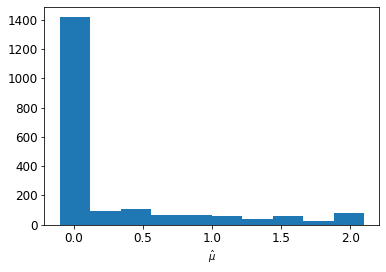

Z:0.0
Z_std:inf
Z_1:1.0168582750556547
Z_std_1:0.6066708658831401
<B> = 147984.8785+/-386.5848195904102
<S> = 21.9535+/-4.6455718431641975
4
AUC:0.9370919955879302
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

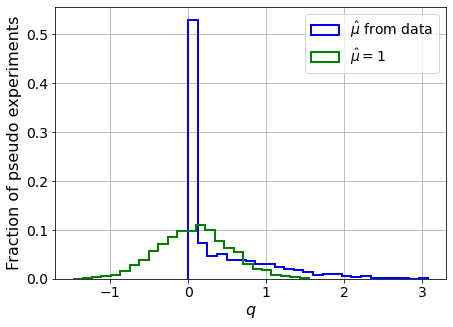

Z BL:(0.28410198118456104, 0.9980321654802505, 1.011875, 0.29567519414832744, 0.7852565112687355) with 15 bins


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  9265.00035219  9010.05119871
  8685.03471278  8291.97066075  7817.80855392  7235.84077757
  6530.47495319  5678.5026042   4629.77094182  3350.17409479
  1798.7328165    -84.204464   -2293.93525908 -5147.36338316]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf  7694.93358232


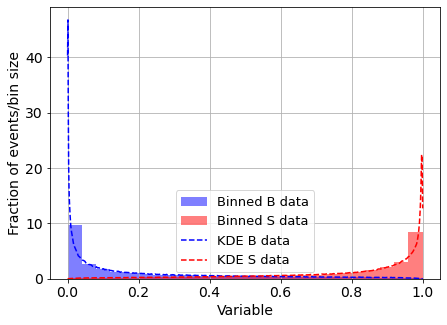

KDE Kernel:  epanechnikov
Background bandwidth:  0.0019008479046983867
Signal bandwidth:  0.0031053121543406503
This may take a while...


In [ ]:
MLL = True

Z_BL         = []
bin_nums     = []
bins_to_test = range(1,500) # number of bins we are testing to see if condition holds

Z_MLL_code   = []
Z_MLL        = []
Z_MLL_std    = []
Z_MLL_mu     = []
Z_MLL_std_mu = []

auc_total   = []
auc_wgamma  = []
auc_wjets   = []
auc_ttgamma = []

num_bkg = []
num_sig = []

num_pseudo = 2000
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]] # range of our data (between 0 and 1 if its the ML output)
D_or_E = 'discovery'
for iloop in range(10):
    
    print(iloop)
    nobs = np.min( (len(photon_SM), len(photon_NP[bp])) )
    df = pd.DataFrame()


    #np.random.seed(28890)

    SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

    df[lst[0]]= np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][:nobs,0]])
    df[lst[1]]= np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][:nobs,1]])
    df[lst[2]]= np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][:nobs,2]])
    df[lst[3]]= np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][:nobs,3]])

    df[lst[4]]= np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][:nobs,0]])
    df[lst[5]]= np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][:nobs,1]])
    df[lst[6]]= np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][:nobs,2]])

    df[lst[7]]= np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][:nobs,0]])
    df[lst[8]]= np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][:nobs,1]])
    df[lst[9]]= np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][:nobs,2]])
    df[lst[10]]= np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][:nobs,3]])
    df[lst[11]]= np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][:nobs,4]])

    df[lst[12]]= np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][:nobs,0]])
    df[lst[13]]= np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][:nobs,2]])

    df[lst[14]]= np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][:nobs,0]])
    df[lst[15]]= np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][:nobs,1]])
    df[lst[16]]= np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][:nobs,2]])

    df[lst[17]]= np.concatenate([ST_SM[SM_indices], ST_NP[bp][:nobs]])
    df[lst[18]]= np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][:nobs]])
    #df[lst[19]]= np.concatenate([m_eff_SM[SM_indices], m_eff_NP[bp][:nobs]])

    df[lst[19]]= np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][:nobs]])
    df[lst[20]]= np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][:nobs]])
    df[lst[21]]= np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][:nobs]])


    df['bkg_flag']= np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][:nobs]))) )

    df[lst[22]]= np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][:nobs]))])

    df_array = np.asarray(df)
    
    df_test = pd.DataFrame()

    SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

    df_test[lst[0]]= np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][nobs:,0]])
    df_test[lst[1]]= np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][nobs:,1]])
    df_test[lst[2]]= np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][nobs:,2]])
    df_test[lst[3]]= np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][nobs:,3]])

    df_test[lst[4]]= np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][nobs:,0]])
    df_test[lst[5]]= np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][nobs:,1]])
    df_test[lst[6]]= np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][nobs:,2]])

    df_test[lst[7]]= np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][nobs:,0]])
    df_test[lst[8]]= np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][nobs:,1]])
    df_test[lst[9]]= np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][nobs:,2]])
    df_test[lst[10]]= np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][nobs:,3]])
    df_test[lst[11]]= np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][nobs:,4]])

    df_test[lst[12]]= np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][nobs:,0]])
    df_test[lst[13]]= np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][nobs:,2]])

    df_test[lst[14]]= np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][nobs:,0]])
    df_test[lst[15]]= np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][nobs:,1]])
    df_test[lst[16]]= np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][nobs:,2]])

    df_test[lst[17]]= np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][nobs:]])
    df_test[lst[18]]= np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][nobs:]])
    #df_test[lst[19]]= np.concatenate([m_eff_SM_pool[SM_indices], m_eff_NP[bp][nobs:]])

    df_test[lst[19]]= np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][nobs:]])
    df_test[lst[20]]= np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][nobs:]])
    df_test[lst[21]]= np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][nobs:]])


    df_test['bkg_flag_pool']= np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][nobs:]))) )

    df_test[lst[22]]= np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][nobs:]))])

    df_test_array = np.asarray(df_test)
    
    nobs = len(df_array)

    train_size = int(0.80 * nobs)
    val_size   = nobs - train_size #%- test_size 

    random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

    train_indices = random_indices[:train_size]
    val_indices   = random_indices[train_size:]
    
    
    X_train        = df_array[train_indices, :22]
    bkg_flag_train = df_array[train_indices, 22]
    y_mon_train    = df_array[train_indices, -1]

    X_test        = df_test_array[:, :22]
    bkg_flag_test = df_test_array[:, 22]
    y_mon_test    = df_test_array[:, -1]

    X_val        = df_array[val_indices, :22]
    bkg_flag_val = df_array[val_indices, 22]
    y_mon_val    = df_array[val_indices, -1]
    
    # to normalize
    x_scaler = preprocessing.MinMaxScaler()
    x_scaler = x_scaler.fit(X_train)

    X_mon_train = x_scaler.transform(X_train)
    X_mon_test  = x_scaler.transform(X_test)
    X_mon_val   = x_scaler.transform(X_val)
    
    
    # CLASSIFIER
    classifier = XGBClassifier(
        n_estimators  = 500,
        learning_rate = 0.1,
        reg_lambda    = 0.0, reg_alpha = 0.0,
        early_stopping_rounds = 50,#early stopping
        eval_metric = 'logloss',
        gamma = 0.0, objective = 'binary:logistic',
        max_depth = 5)

    # FIT
    classifier.fit(X_mon_train, y_mon_train, 
                   eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
                   verbose  = False)

    # PREDICTIONS
    y_pred_xg = classifier.predict_proba(X_mon_test).T[1]

    pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
    pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]
    
    
    # Let's estimate the ROC Curve
    nvals = 50
    tpr_total   = np.zeros(nvals) 
    fpr_total   = np.zeros(nvals) 
    tpr_ttgamma = np.zeros(nvals) 
    fpr_ttgamma = np.zeros(nvals) 
    tpr_wgamma  = np.zeros(nvals) 
    fpr_wgamma  = np.zeros(nvals) 
    tpr_wjets   = np.zeros(nvals) 
    fpr_wjets   = np.zeros(nvals) 

    for ith, th in enumerate(np.linspace(0,1, nvals)):
        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_total[ith] = len(tp) / (len(tp) + len(fn))
        fpr_total[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_ttgamma.append( auc(fpr_ttgamma, tpr_ttgamma) )
    auc_wjets.append( auc(fpr_wjets, tpr_wjets) )
    auc_wgamma.append( auc(fpr_wgamma, tpr_wgamma) )
    auc_total.append( auc(fpr_total, tpr_total) )
    
    
    print('AUC:' + str(auc_total[iloop]))

    # FIND THE NUMBER OF BINS:
    num_bins = 15#max_num_bins(pred_XG_SM, int(B_expected), range_dat, 5, bins_to_test)
    Z_BL.append( BL_test_fast('discovery', pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, num_bins, range_dat, 5, linear_bins=True) )

    bin_nums.append(num_bins)
    print('Z BL:' + str(Z_BL[iloop]) + ' with ' + str(num_bins) + ' bins')

    if MLL:
        kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                                50000, # Numero de datos para fitear
                                                                                                np.logspace(-4.0, 0.05, 20), 
                                                                                                set_kernel='epanechnikov')
        print('This may take a while...')
    
        pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
        print('1 done')
        pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
        print('2 done')
    
        # Normalize
        pB_B_data = pB_B_data / norm_factor_SM
        pS_B_data = pS_B_data / norm_factor_NP
        
        print(np.min(pB_B_data))
        pB_B_data[np.where(pB_B_data == 0 )[0]] = np.min(pB_B_data[np.where(pB_B_data > 0 )[0]])
        pS_B_data[np.where(pS_B_data == 0 )[0]] = np.min(pS_B_data[np.where(pS_B_data > 0 )[0]])
        print(np.min(pB_B_data))
        
        pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
        print('3 done')
        pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
        print('4 done')
    
        # Normalize
        pB_S_data = pB_S_data / norm_factor_SM
        pS_S_data = pS_S_data / norm_factor_NP
        
        print(np.min(pB_S_data))
        pB_S_data[np.where(pB_S_data == 0 )[0]] = np.min(pB_S_data[np.where(pB_S_data > 0 )[0]])
        pS_S_data[np.where(pS_S_data == 0 )[0]] = np.min(pS_S_data[np.where(pS_S_data > 0 )[0]])
        print(np.min(pB_S_data))
        
        print('B_expected: ', int(B_expected))
        print('S_expected: ', int(S_expected[bp]))
        print('')
    
        #Z_MLL_code.append( MLL_test_fast(D_or_E, pB_B_data, pS_B_data, pB_S_data, 
        #                      pS_S_data, B_expected, int(S_expected[bp]), num_pseudo = num_pseudo) )
        #print('Z_MLL: ', Z_MLL_code[iloop][0])
        #print('std Z_MLL: ', Z_MLL_code[iloop][1])
        
        # indeces (to later build a random pseudo experiment)
        indices_B = [i for i in range(len(pS_B_data))]
        indices_S = [i for i in range(len(pS_S_data))]
        # loop over the number of pseudo experiments
        #np.random.seed(91218)
    
        muhat_selected_MLL_list = []
        q_muhat_MLL = []
        q_muhat_MLL_mu = []
        
        num_bkg_aux = []
        num_sig_aux = []
        for its in tqdm(range(num_pseudo)):
    
            # this pseudo-exp has B_rand number of B events
            B_rand = np.random.poisson(int(B_expected))
            num_bkg_aux.append(B_rand)
            
            ran_ind = np.random.choice(indices_B, B_rand)
    
            pB_B_data_shuf = []
            pS_B_data_shuf = []
    
            # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
            for i in ran_ind:
                pB_B_data_shuf.append(pB_B_data[i])
                pS_B_data_shuf.append(pS_B_data[i])
    
            pB_B_data_shuf  = np.array(pB_B_data_shuf)
            pS_B_data_shuf  = np.array(pS_B_data_shuf)
    
    
    
            # this pseudo-exp has S_rand number of S events
            S_rand = np.random.poisson(int(S_expected[bp]))
            num_sig_aux.append(S_rand)
    
            ran_ind = np.random.choice(indices_S, S_rand)
    
            pB_S_data_shuf = []
            pS_S_data_shuf = []
    
            # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
            for i in ran_ind:
                pB_S_data_shuf.append(pB_S_data[i])
                pS_S_data_shuf.append(pS_S_data[i])
    
            pB_S_data_shuf  = np.array(pB_S_data_shuf)
            pS_S_data_shuf  = np.array(pS_S_data_shuf)
    
            # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
            prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])
    
            # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
            prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])
    
    
    
            # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment
    
            # approximation: mu_hat=1 (discovery)
            q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
    
    
    
            # ESTIMATE mu_hat for this particular ensemble (implicit equation)
            B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]
    
            # reference points
            sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
            sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    
    
            # we need (implicit eq. for mu_hat) = 1
            # conditions considering the reference points
            if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
                print('muhat = 2.1')
                muhat_selected_MLL = 2.1
    
                print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
                print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
                print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
                print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))
    
            elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
                print('muhat = -0.1')
                muhat_selected_MLL = -0.1
    
                print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
                print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
                print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
                print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))
    
            elif sum_muhat_zero < 1 < sum_muhat_two:
                #print('muhat ~ 1')
    
                # grid, mu_hat is around 1
                muhat_test = np.arange(0, 2., 0.05)
    
                for vv in range(len(muhat_test)):
    
                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    
                    if mu_hat_condition_equal_1 > 1:
                        muhat_selected_MLL = muhat_test[vv]
                        break
    
            elif sum_muhat_two < 1 < sum_muhat_zero:
                #print('muhat ~ 1')
    
                # grid, mu_hat is around 1
                muhat_test = np.arange(0, 2., 0.05)
    
                for vv in range(len(muhat_test)):
    
                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    
                    if mu_hat_condition_equal_1 < 1:
                        muhat_selected_MLL = muhat_test[vv]
                        break
    
    
            # save the computed mu_hat (within range) for each pseudo_experiment
            muhat_selected_MLL_list.append(muhat_selected_MLL)
    
    
            # compute the test statistic for each pseudo_exp considering mu_hat
            if muhat_selected_MLL > 0:
                q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
    
            else:
                q_muhat_MLL.append( 0 )
    
    
    
        # With the calculation of mu_hat
        muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
        Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
        Z_MLL.append( Z_MLL_aux )
        Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )
    
    
        # With the approximation of mu_hat
        Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
        Z_MLL_mu.append( Z_MLL_mu_aux )
        Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )
        
        try:
            plt.hist(np.asarray(muhat_selected_MLL_list))
            plt.xlabel(r'$\hat{\mu}$')
            plt.savefig('../graph/BP' + str(bp+1) + '/muhat_hist_' + str(iloop) + '.pdf')
            plt.show()
            plt.clf()
    
            plt.hist(np.asarray(q_muhat_MLL))
            plt.xlabel(r'$q_{0}$')
            plt.savefig('../graph/BP' + str(bp+1) + '/q0_hist_' + str(iloop) + '.pdf')
            plt.show()
            plt.clf()
        except:
            pass
        print('Z:' + str(Z_MLL[iloop]))
        print('Z_std:' + str(Z_MLL_std[iloop]))
        print('Z_1:' + str(Z_MLL_mu[iloop]))
        print('Z_std_1:' + str(Z_MLL_std_mu[iloop]))
        
        num_bkg.append(num_bkg_aux)
        num_sig.append(num_sig_aux)
        print('<B> = ' + str(np.mean(np.asarray(num_bkg_aux))) + '+/-' + str(np.std(np.asarray(num_bkg_aux))))
        print('<S> = ' + str(np.mean(np.asarray(num_sig_aux))) + '+/-' + str(np.std(np.asarray(num_sig_aux))))

In [171]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.text(0.5,0.08, 'Z = ' + '{:.2f}'.format(np.mean(np.asarray(Z_MLL))) + ' +/- ' + 
         '{:.2f}'.format(np.std(np.asarray(Z_MLL))) + ' +/- ' + '{:.2f}'.format(np.mean(np.nan_to_num(Z_MLL_std, nan=0, posinf=0, neginf=0))),
         transform = plt.gca().transAxes)
plt.text(0.5,0.02, 'Z BL = ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,0])) + ' +/- ' + 
         '{:.2f}'.format(np.std(np.asarray(Z_BL)[:,0])) + ' +/- ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,1])), transform = plt.gca().transAxes)
plt.title('BP' + str(bp+1))
plt.xlabel('Iteration')
plt.savefig('../graph/loopBP' + str(bp+1) + '_50000_MLLvariable_ALLbkg_' + str(B_expected) + '.pdf')

In [172]:
print('Z = ' + '{:.2f}'.format(np.mean(np.asarray(Z_MLL))) + ' +/- ' + '{:.2f}'.format(np.std(np.asarray(Z_MLL))) + ' +/- ' + '{:.2f}'.format(np.mean(np.nan_to_num(Z_MLL_std, nan=0, posinf=0, neginf=0))))
print('Z BL = ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,0])) + ' +/- ' + '{:.2f}'.format(np.std(np.asarray(Z_BL)[:,0]))  + ' +/- ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,1])) )

Z = 0.07 +/- 0.09 +/- 4.35
Z BL = 0.27 +/- 0.02 +/- 1.03


In [173]:
Z_MLL

[0.018052124018491645,
 0.2266894263296019,
 0.0,
 0.0,
 0.0,
 0.15244762699521602,
 0.0,
 0.05846429169099232,
 0.0,
 0.24315155419429565]

In [174]:
Z_MLL_std

[26.63286454486443,
 2.7038739468331054,
 inf,
 inf,
 inf,
 3.6166487750826297,
 inf,
 7.936542851171162,
 inf,
 2.5870751408627077]

In [175]:
print('AUC : ' + str(np.mean(np.asarray(auc_total))) + ' +/- ' + str(np.std(np.asarray(auc_total))))

AUC : 0.9374323171287117 +/- 0.0001924927638311426
